In [2]:
from google.colab import drive

drive.mount('/content/gdrive' , force_remount=True)

Mounted at /content/gdrive


In [3]:
import os
os.getcwd()

'/content'

Imports

In [4]:
import os
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
from keras.models import load_model

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

Residual Block

In [5]:
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

Upsampling Block

In [6]:
def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

Generator Model

In [7]:
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    # Conv layer after Residual Blocks
    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)

    # Add the initial layer stored in temp here.
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    # Final Conv layer
    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

Discriminator Block

In [8]:
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model

Discriminator Model

In [9]:
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

VGG19 feature map

In [10]:
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

Combined Model

In [11]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

Load the dataset

In [12]:
dataset_path='/content/gdrive/MyDrive/SRGAN_TEST'
lr_images_path = 'lr_images'
hr_images_path = 'hr_images'

In [13]:
lr_list = os.listdir(os.path.join(dataset_path , lr_images_path))[:500]
hr_list = os.listdir(os.path.join(dataset_path , hr_images_path))[:500]

lr_list.sort()
hr_list.sort()


print(lr_list[0] , hr_list[0])
print(hr_list[1] , lr_list[1])

lr_images = []
for index , img in enumerate(lr_list):
    img_lr = cv2.imread(os.path.join(dataset_path , lr_images_path) +'/'+ img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)


hr_images = []
for index , img in enumerate(hr_list):
    img_hr = cv2.imread(os.path.join(dataset_path , hr_images_path)+'/'+ img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)


lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

eu-1289.png eu-129.png
eu-1290.png eu-129.png


Sanity Check

351
eu-414.png


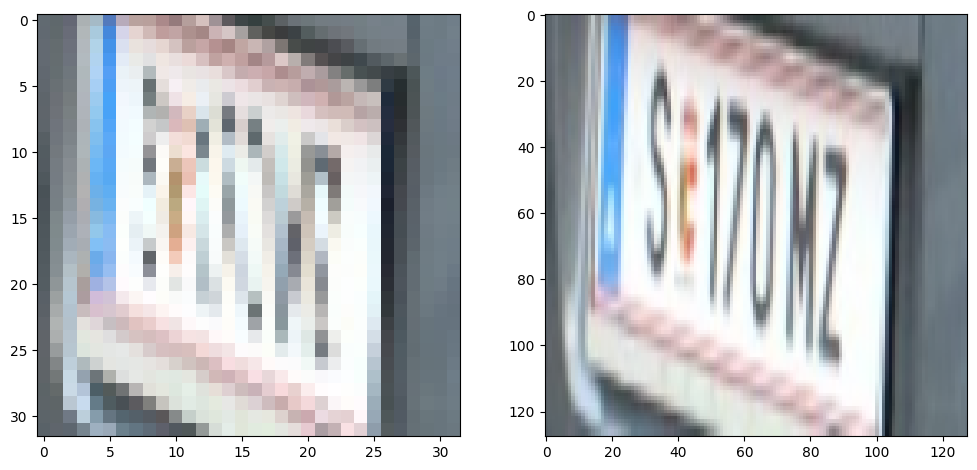

In [14]:
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
print(image_number)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)

# Finding the correct image for the hr image through indexing
lr_img_name= lr_list[image_number]
print(lr_img_name)
lr_index_in_hr = hr_list.index(lr_img_name)

plt.imshow(np.reshape(hr_images[lr_index_in_hr], (128, 128, 3)))
plt.show()

Scale Values

In [15]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

Train and test data split

In [16]:
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,
                         test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [ ]:
# for index in range(len(lr_test)):
#   cv2.imwrite(os.path.join(dataset_path , "test_images" , "lr_test" , f'{index}.jpg') , lr_test[index])
#   cv2.imwrite(os.path.join(dataset_path , "test_images" , "hr_test" , f'{index}.jpg') , hr_test[index])


Invoking generator , discriminator and VGG model

In [17]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

# size of hr
vgg = build_vgg((128,128,3))

print(vgg.summary())
vgg.trainable = False



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [18]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [19]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 1)            38249281    ['model[0][0]']            

Creating batches with batch size 1

In [20]:
batch_size = 1
train_lr_batches = []
train_hr_batches = []

for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
# generator = load_model(os.path.join(dataset_path , "gen_e_70.h5"))
# generator.compile()

In [ ]:
##Open the text file in append mode
metrics_file = open(os.path.join(dataset_path , "metrics.txt") , "a")



Start Training

In [ ]:
epochs = 100
# Enumerate training over epochs
for e in range(epochs+1):

    metrics_file= open(os.path.join(dataset_path , "metrics.txt"),'a')

    print(f"<=======Starting epoch {e+1} =======>")
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

    #Create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []

    #Enumerate training over batches.
    print("Looping train batch")
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

        #First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False

        #Average the discriminator loss, just for reporting purposes.
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)

        #Train the generator via GAN.
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        #Save losses to a list so we can average and report.
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    #Convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    #Report the progress during training.
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)
    metrics_file.write(f'epoch:{e+1} g_loss:{g_loss} g_acc:{1-g_loss} d_loss:{d_loss} d_acc:{1-d_loss}\n');
    metrics_file.close()
    # if (e+1) % 5 == 0: #Change the frequency for model saving, if needed
    #Save the generator after every epoch
    print("Saving the generator after epoch " + str(e+1))
    try:
        generator.save(f"/content/gdrive/MyDrive/SRGAN_TEST/gen_e_{e+1}.hdf5")
    except:
        print("Exception occured")



<=======Starting epoch 1 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 1/335 [00:00<01:12,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 2/335 [00:00<01:12,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 3/335 [00:00<01:09,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 4/335 [00:00<01:09,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 5/335 [00:01<01:07,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 6/335 [00:01<01:09,  4.71it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 7/335 [00:01<01:13,  4.48it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 8/335 [00:01<01:15,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 9/335 [00:02<01:17,  4.23it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 10/335 [00:02<01:19,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 11/335 [00:02<01:18,  4.10it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▎         | 12/335 [00:02<01:21,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 13/335 [00:03<01:20,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 14/335 [00:03<01:21,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 15/335 [00:03<01:21,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 16/335 [00:03<01:22,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 17/335 [00:04<01:22,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 18/335 [00:04<01:21,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 19/335 [00:04<01:21,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 20/335 [00:04<01:21,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 21/335 [00:05<01:20,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 22/335 [00:05<01:14,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 23/335 [00:05<01:10,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 24/335 [00:05<01:07,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 25/335 [00:05<01:05,  4.73it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 26/335 [00:06<01:03,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 27/335 [00:06<01:01,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 28/335 [00:06<01:02,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 29/335 [00:06<01:02,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 30/335 [00:06<01:01,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 31/335 [00:07<01:01,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 32/335 [00:07<01:00,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 33/335 [00:07<01:00,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 34/335 [00:07<00:59,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 35/335 [00:07<00:59,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 36/335 [00:08<00:59,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 37/335 [00:08<01:00,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 38/335 [00:08<01:01,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 39/335 [00:08<01:00,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 40/335 [00:08<01:00,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 41/335 [00:09<00:59,  4.98it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 42/335 [00:09<00:58,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 43/335 [00:09<00:58,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 44/335 [00:09<00:58,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 45/335 [00:09<00:57,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 46/335 [00:10<00:56,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 47/335 [00:10<00:57,  4.99it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 48/335 [00:10<00:58,  4.93it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 49/335 [00:10<00:57,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 50/335 [00:10<00:56,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 51/335 [00:11<00:56,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 52/335 [00:11<00:55,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 53/335 [00:11<00:56,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 54/335 [00:11<00:56,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 55/335 [00:11<00:55,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 56/335 [00:12<00:54,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 57/335 [00:12<00:54,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 58/335 [00:12<00:54,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 59/335 [00:12<00:53,  5.13it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 60/335 [00:12<00:53,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 61/335 [00:13<00:52,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 62/335 [00:13<00:51,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 63/335 [00:13<00:53,  5.06it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 64/335 [00:13<00:52,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 65/335 [00:13<00:53,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 66/335 [00:14<00:52,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 67/335 [00:14<00:50,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 68/335 [00:14<00:50,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 69/335 [00:14<00:51,  5.15it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 70/335 [00:14<00:50,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 71/335 [00:14<00:50,  5.23it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 72/335 [00:15<00:51,  5.06it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 73/335 [00:15<00:54,  4.83it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 74/335 [00:15<00:58,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 75/335 [00:15<01:00,  4.28it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 76/335 [00:16<01:02,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 77/335 [00:16<01:02,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 78/335 [00:16<01:04,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 79/335 [00:16<01:05,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 80/335 [00:17<01:04,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 81/335 [00:17<01:04,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 82/335 [00:17<01:06,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 83/335 [00:18<01:06,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 84/335 [00:18<01:07,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 85/335 [00:18<01:06,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 86/335 [00:18<01:08,  3.63it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 87/335 [00:19<01:02,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 88/335 [00:19<00:59,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 89/335 [00:19<00:56,  4.39it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 90/335 [00:19<00:55,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 91/335 [00:19<00:54,  4.52it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 92/335 [00:20<00:51,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 93/335 [00:20<00:50,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 94/335 [00:20<00:48,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 95/335 [00:20<00:47,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 96/335 [00:20<00:46,  5.11it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 97/335 [00:21<00:45,  5.18it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 98/335 [00:21<00:45,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 99/335 [00:21<00:44,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 100/335 [00:21<00:44,  5.33it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 101/335 [00:21<00:44,  5.23it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 102/335 [00:21<00:44,  5.26it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 103/335 [00:22<00:44,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 104/335 [00:22<00:44,  5.20it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 105/335 [00:22<00:43,  5.30it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 106/335 [00:22<00:42,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 107/335 [00:22<00:43,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 108/335 [00:23<00:43,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 109/335 [00:23<00:42,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 110/335 [00:23<00:42,  5.32it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 111/335 [00:23<00:42,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 112/335 [00:23<00:42,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 113/335 [00:24<00:42,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 114/335 [00:24<00:42,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 115/335 [00:24<00:41,  5.29it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 116/335 [00:24<00:41,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 117/335 [00:24<00:40,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 118/335 [00:25<00:40,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 119/335 [00:25<00:40,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 120/335 [00:25<00:39,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 121/335 [00:25<00:40,  5.27it/s]

1/1 [==============================] - 0s 100ms/step


 36%|███▋      | 122/335 [00:26<00:57,  3.68it/s]

1/1 [==============================] - 0s 64ms/step


 37%|███▋      | 123/335 [00:26<01:04,  3.31it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 124/335 [00:26<00:56,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 125/335 [00:26<00:51,  4.05it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 126/335 [00:27<00:49,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 127/335 [00:27<00:45,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 128/335 [00:27<00:56,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 129/335 [00:27<01:02,  3.28it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 130/335 [00:28<00:57,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 131/335 [00:28<00:53,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 132/335 [00:28<00:49,  4.13it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 133/335 [00:28<00:47,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 134/335 [00:29<00:48,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 135/335 [00:29<00:50,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 136/335 [00:29<00:49,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 137/335 [00:29<00:50,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 138/335 [00:30<00:50,  3.91it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 139/335 [00:30<00:53,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 140/335 [00:30<00:51,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 141/335 [00:30<00:50,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 142/335 [00:31<00:50,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 143/335 [00:31<00:51,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 144/335 [00:31<00:51,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 145/335 [00:32<00:50,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 146/335 [00:32<00:50,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 147/335 [00:32<00:49,  3.78it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 148/335 [00:32<00:48,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 149/335 [00:33<00:45,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 150/335 [00:33<00:43,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 151/335 [00:33<00:41,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 152/335 [00:33<00:39,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 153/335 [00:33<00:38,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 154/335 [00:34<00:38,  4.76it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 155/335 [00:34<00:37,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 156/335 [00:34<00:36,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 157/335 [00:34<00:38,  4.60it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 158/335 [00:34<00:37,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 159/335 [00:35<00:37,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 160/335 [00:35<00:37,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 161/335 [00:35<00:36,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 162/335 [00:35<00:35,  4.84it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 163/335 [00:35<00:35,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 164/335 [00:36<00:35,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 165/335 [00:36<00:35,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 166/335 [00:36<00:34,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 167/335 [00:36<00:33,  5.01it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 168/335 [00:36<00:32,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 169/335 [00:37<00:32,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 170/335 [00:37<00:33,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 171/335 [00:37<00:32,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 172/335 [00:37<00:32,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 173/335 [00:37<00:32,  5.01it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 174/335 [00:38<00:31,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 175/335 [00:38<00:32,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 176/335 [00:38<00:31,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 177/335 [00:38<00:30,  5.12it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 178/335 [00:38<00:30,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 179/335 [00:39<00:30,  5.08it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 180/335 [00:39<00:30,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 181/335 [00:39<00:30,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 182/335 [00:39<00:30,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 183/335 [00:39<00:29,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 184/335 [00:40<00:29,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 185/335 [00:40<00:29,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 186/335 [00:40<00:28,  5.17it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 187/335 [00:40<00:28,  5.25it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 188/335 [00:40<00:28,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 189/335 [00:41<00:28,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 190/335 [00:41<00:28,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 191/335 [00:41<00:28,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 192/335 [00:41<00:27,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 193/335 [00:41<00:27,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 194/335 [00:41<00:27,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 195/335 [00:42<00:27,  5.17it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 196/335 [00:42<00:27,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 197/335 [00:42<00:27,  5.04it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 198/335 [00:42<00:29,  4.61it/s]

1/1 [==============================] - 0s 176ms/step


 59%|█████▉    | 199/335 [00:43<00:53,  2.56it/s]

1/1 [==============================] - 0s 139ms/step


 60%|█████▉    | 200/335 [00:44<01:07,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 201/335 [00:44<01:08,  1.97it/s]

1/1 [==============================] - 0s 220ms/step


 60%|██████    | 202/335 [00:46<01:38,  1.35it/s]

1/1 [==============================] - 0s 104ms/step


 61%|██████    | 203/335 [00:47<01:41,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 204/335 [00:47<01:19,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 205/335 [00:47<01:03,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 206/335 [00:47<00:51,  2.48it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 207/335 [00:47<00:43,  2.91it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 208/335 [00:48<00:38,  3.33it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 209/335 [00:48<00:34,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 210/335 [00:48<00:31,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 211/335 [00:48<00:29,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 212/335 [00:48<00:28,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 213/335 [00:49<00:26,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 214/335 [00:49<00:26,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 215/335 [00:49<00:25,  4.62it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 216/335 [00:49<00:25,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 217/335 [00:49<00:25,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 218/335 [00:50<00:24,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 219/335 [00:50<00:24,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 220/335 [00:50<00:23,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 221/335 [00:50<00:24,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 222/335 [00:51<00:23,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 223/335 [00:51<00:23,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 224/335 [00:51<00:23,  4.69it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 225/335 [00:51<00:23,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 226/335 [00:51<00:23,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 227/335 [00:52<00:23,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 228/335 [00:52<00:22,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 229/335 [00:52<00:22,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 230/335 [00:52<00:22,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 231/335 [00:52<00:21,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 232/335 [00:53<00:21,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 233/335 [00:53<00:21,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 234/335 [00:53<00:21,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 235/335 [00:53<00:20,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 236/335 [00:53<00:20,  4.87it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 237/335 [00:54<00:20,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 238/335 [00:54<00:20,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 239/335 [00:54<00:19,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 240/335 [00:54<00:19,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 241/335 [00:54<00:18,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 242/335 [00:55<00:18,  5.07it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 243/335 [00:55<00:18,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 244/335 [00:55<00:17,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 245/335 [00:55<00:17,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 246/335 [00:55<00:17,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 247/335 [00:56<00:17,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 248/335 [00:56<00:16,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 249/335 [00:56<00:16,  5.16it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 250/335 [00:56<00:16,  5.07it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 251/335 [00:56<00:16,  5.13it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 252/335 [00:57<00:16,  5.07it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 253/335 [00:57<00:17,  4.72it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 254/335 [00:57<00:18,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 255/335 [00:57<00:18,  4.23it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 256/335 [00:58<00:19,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 257/335 [00:58<00:19,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 258/335 [00:58<00:19,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 259/335 [00:58<00:20,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 260/335 [00:59<00:20,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 261/335 [00:59<00:20,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 262/335 [00:59<00:20,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 263/335 [01:00<00:19,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 264/335 [01:00<00:19,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 265/335 [01:00<00:19,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 266/335 [01:00<00:19,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 267/335 [01:01<00:18,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 268/335 [01:01<00:16,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 269/335 [01:01<00:15,  4.29it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 270/335 [01:01<00:14,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 271/335 [01:02<00:14,  4.47it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 272/335 [01:02<00:13,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 273/335 [01:02<00:13,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 274/335 [01:02<00:13,  4.47it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 275/335 [01:02<00:12,  4.66it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 276/335 [01:03<00:12,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 277/335 [01:03<00:12,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 278/335 [01:03<00:11,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 279/335 [01:03<00:11,  4.86it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 280/335 [01:03<00:11,  4.81it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 281/335 [01:04<00:11,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 282/335 [01:04<00:11,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 283/335 [01:04<00:10,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 284/335 [01:04<00:10,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 285/335 [01:04<00:10,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 286/335 [01:05<00:10,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 287/335 [01:05<00:09,  4.80it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 288/335 [01:05<00:09,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 289/335 [01:05<00:09,  4.89it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 290/335 [01:05<00:09,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 291/335 [01:06<00:08,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 292/335 [01:06<00:08,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 293/335 [01:06<00:08,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 294/335 [01:06<00:08,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 295/335 [01:07<00:08,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 296/335 [01:07<00:08,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 297/335 [01:07<00:08,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 298/335 [01:07<00:07,  4.72it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 299/335 [01:07<00:07,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 300/335 [01:08<00:07,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 301/335 [01:08<00:07,  4.74it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 302/335 [01:08<00:06,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 303/335 [01:08<00:06,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 304/335 [01:08<00:06,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 305/335 [01:09<00:06,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 306/335 [01:09<00:05,  4.98it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 307/335 [01:09<00:05,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 308/335 [01:09<00:05,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 309/335 [01:09<00:05,  4.98it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 310/335 [01:10<00:05,  4.88it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 311/335 [01:10<00:04,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 312/335 [01:10<00:04,  4.89it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 313/335 [01:10<00:04,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 314/335 [01:10<00:04,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 315/335 [01:11<00:04,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 316/335 [01:11<00:04,  4.54it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 317/335 [01:11<00:04,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 318/335 [01:11<00:04,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 319/335 [01:12<00:04,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 320/335 [01:12<00:03,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 321/335 [01:12<00:03,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 322/335 [01:12<00:03,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 323/335 [01:13<00:03,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 324/335 [01:13<00:02,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 325/335 [01:13<00:02,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 326/335 [01:14<00:02,  3.71it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 327/335 [01:14<00:02,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 328/335 [01:14<00:02,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 329/335 [01:15<00:01,  3.37it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 330/335 [01:15<00:01,  3.69it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 331/335 [01:15<00:01,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 332/335 [01:15<00:00,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 333/335 [01:15<00:00,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 334/335 [01:16<00:00,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 335/335 [01:16<00:00,  4.39it/s]


epoch: 1 g_loss: 46.06244080386945 d_loss: [0.73376966 0.95970149]
Saving the generator after epoch 1
<=======Starting epoch 2 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 1/335 [00:00<01:07,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 2/335 [00:00<01:08,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 3/335 [00:00<01:07,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 4/335 [00:00<01:07,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 5/335 [00:01<01:07,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 6/335 [00:01<01:07,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 7/335 [00:01<01:07,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 8/335 [00:01<01:09,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 9/335 [00:01<01:08,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 10/335 [00:02<01:07,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 11/335 [00:02<01:07,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 12/335 [00:02<01:06,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 13/335 [00:02<01:05,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 14/335 [00:02<01:07,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 15/335 [00:03<01:08,  4.66it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 16/335 [00:03<01:12,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 17/335 [00:03<01:08,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 18/335 [00:03<01:06,  4.74it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 19/335 [00:03<01:04,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 20/335 [00:04<01:04,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 21/335 [00:04<01:07,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 22/335 [00:04<01:06,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 23/335 [00:04<01:05,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 24/335 [00:05<01:04,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 25/335 [00:05<01:03,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 26/335 [00:05<01:01,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 27/335 [00:05<01:00,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 28/335 [00:05<01:00,  5.09it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 29/335 [00:05<01:00,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 30/335 [00:06<01:01,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 31/335 [00:06<01:01,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 32/335 [00:06<01:02,  4.87it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 33/335 [00:06<01:01,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 34/335 [00:07<01:00,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 35/335 [00:07<00:59,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 36/335 [00:07<01:01,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 37/335 [00:07<01:00,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 38/335 [00:07<01:01,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 39/335 [00:08<01:01,  4.80it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 40/335 [00:08<01:00,  4.85it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 41/335 [00:08<01:03,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 42/335 [00:08<01:08,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 43/335 [00:09<01:11,  4.06it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 44/335 [00:09<01:14,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 45/335 [00:09<01:14,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 46/335 [00:09<01:14,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 47/335 [00:10<01:13,  3.91it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 48/335 [00:10<01:14,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 49/335 [00:10<01:15,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 50/335 [00:10<01:16,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 51/335 [00:11<01:14,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 52/335 [00:11<01:15,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 53/335 [00:11<01:15,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 54/335 [00:12<01:16,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 55/335 [00:12<01:16,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 56/335 [00:12<01:10,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 57/335 [00:12<01:07,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 58/335 [00:12<01:04,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 59/335 [00:13<01:02,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 60/335 [00:13<00:59,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 61/335 [00:13<00:58,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 62/335 [00:13<00:56,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 63/335 [00:13<00:55,  4.90it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 64/335 [00:14<00:56,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 65/335 [00:14<00:56,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 66/335 [00:14<00:55,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 67/335 [00:14<00:55,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 68/335 [00:14<00:54,  4.90it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 69/335 [00:15<00:55,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 70/335 [00:15<00:53,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 71/335 [00:15<00:55,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 72/335 [00:15<00:55,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 73/335 [00:15<00:54,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 74/335 [00:16<00:54,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 75/335 [00:16<00:54,  4.76it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 76/335 [00:16<00:54,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 77/335 [00:16<00:54,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 78/335 [00:17<00:53,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 79/335 [00:17<00:54,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 80/335 [00:17<00:54,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 81/335 [00:17<00:53,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 82/335 [00:17<00:54,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 83/335 [00:18<00:54,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 84/335 [00:18<00:53,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 85/335 [00:18<00:52,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 86/335 [00:18<00:52,  4.73it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 87/335 [00:18<00:51,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 88/335 [00:19<00:51,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 89/335 [00:19<00:51,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 90/335 [00:19<00:50,  4.82it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 91/335 [00:19<00:51,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 92/335 [00:20<00:51,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 93/335 [00:20<00:51,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 94/335 [00:20<00:50,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 95/335 [00:20<00:50,  4.80it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 96/335 [00:20<00:50,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 97/335 [00:21<00:49,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 98/335 [00:21<00:49,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 99/335 [00:21<00:49,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 100/335 [00:21<00:50,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 101/335 [00:21<00:49,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 102/335 [00:22<00:49,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 103/335 [00:22<00:50,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 104/335 [00:22<00:53,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 105/335 [00:22<00:55,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 106/335 [00:23<00:57,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 107/335 [00:23<01:00,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 108/335 [00:23<01:01,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 109/335 [00:23<01:00,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 110/335 [00:24<01:00,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 111/335 [00:24<01:00,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 112/335 [00:24<01:00,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 113/335 [00:25<01:00,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 114/335 [00:25<01:00,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 115/335 [00:25<01:00,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 116/335 [00:25<00:59,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 117/335 [00:26<00:58,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 118/335 [00:26<00:57,  3.79it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 119/335 [00:26<00:54,  3.96it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 120/335 [00:26<00:51,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 121/335 [00:27<00:49,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 122/335 [00:27<00:47,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 123/335 [00:27<00:46,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 124/335 [00:27<00:45,  4.68it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 125/335 [00:27<00:44,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 126/335 [00:28<00:43,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 127/335 [00:28<00:44,  4.72it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 128/335 [00:28<00:44,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 129/335 [00:28<00:43,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 130/335 [00:28<00:42,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 131/335 [00:29<00:41,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 132/335 [00:29<00:41,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 133/335 [00:29<00:41,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 134/335 [00:29<00:41,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 135/335 [00:29<00:41,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 136/335 [00:30<00:41,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 137/335 [00:30<00:41,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 138/335 [00:30<00:40,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 139/335 [00:30<00:40,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 140/335 [00:31<00:40,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 141/335 [00:31<00:40,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 142/335 [00:31<00:39,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 143/335 [00:31<00:40,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 144/335 [00:31<00:39,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 145/335 [00:32<00:39,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 146/335 [00:32<00:39,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 147/335 [00:32<00:39,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 148/335 [00:32<00:39,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 149/335 [00:32<00:39,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 150/335 [00:33<00:39,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 151/335 [00:33<00:39,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 152/335 [00:33<00:38,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 153/335 [00:33<00:37,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 154/335 [00:33<00:38,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 155/335 [00:34<00:38,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 156/335 [00:34<00:38,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 157/335 [00:34<00:38,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 158/335 [00:34<00:38,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 159/335 [00:35<00:38,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 160/335 [00:35<00:38,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 161/335 [00:35<00:37,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 162/335 [00:35<00:37,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 163/335 [00:35<00:37,  4.61it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 164/335 [00:36<00:37,  4.58it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 165/335 [00:36<00:37,  4.55it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 166/335 [00:36<00:41,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 167/335 [00:36<00:42,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 168/335 [00:37<00:43,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 169/335 [00:37<00:44,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 170/335 [00:37<00:45,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 171/335 [00:38<00:44,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 172/335 [00:38<00:44,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 173/335 [00:38<00:44,  3.65it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 174/335 [00:38<00:44,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 175/335 [00:39<00:44,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 176/335 [00:39<00:43,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 177/335 [00:39<00:42,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 178/335 [00:39<00:43,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 179/335 [00:40<00:41,  3.77it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 180/335 [00:40<00:40,  3.83it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 181/335 [00:40<00:38,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 182/335 [00:40<00:37,  4.11it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 183/335 [00:41<00:35,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 184/335 [00:41<00:34,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 185/335 [00:41<00:33,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 186/335 [00:41<00:33,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 187/335 [00:42<00:33,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 188/335 [00:42<00:32,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 189/335 [00:42<00:31,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 190/335 [00:42<00:31,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 191/335 [00:42<00:30,  4.65it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 192/335 [00:43<00:30,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 193/335 [00:43<00:30,  4.62it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 194/335 [00:43<00:30,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 195/335 [00:43<00:30,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 196/335 [00:43<00:29,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 197/335 [00:44<00:28,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 198/335 [00:44<00:28,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 199/335 [00:44<00:28,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 200/335 [00:44<00:28,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 201/335 [00:44<00:27,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 202/335 [00:45<00:27,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 203/335 [00:45<00:27,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 204/335 [00:45<00:27,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 205/335 [00:45<00:26,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 206/335 [00:45<00:26,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 207/335 [00:46<00:26,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 208/335 [00:46<00:26,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 209/335 [00:46<00:26,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 210/335 [00:46<00:25,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 211/335 [00:47<00:26,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 212/335 [00:47<00:25,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 213/335 [00:47<00:25,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 214/335 [00:47<00:24,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 215/335 [00:47<00:24,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 216/335 [00:48<00:24,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 217/335 [00:48<00:25,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 218/335 [00:48<00:24,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 219/335 [00:48<00:24,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 220/335 [00:48<00:24,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 221/335 [00:49<00:24,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 222/335 [00:49<00:24,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 223/335 [00:49<00:24,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 224/335 [00:49<00:24,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 225/335 [00:50<00:24,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 226/335 [00:50<00:23,  4.61it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 227/335 [00:50<00:24,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 228/335 [00:50<00:25,  4.22it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 229/335 [00:51<00:25,  4.09it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 230/335 [00:51<00:27,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 231/335 [00:51<00:29,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 232/335 [00:51<00:28,  3.62it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 233/335 [00:52<00:28,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 234/335 [00:52<00:28,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 235/335 [00:52<00:27,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 236/335 [00:53<00:27,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 237/335 [00:53<00:27,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 238/335 [00:53<00:26,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 239/335 [00:53<00:26,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 240/335 [00:54<00:26,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 241/335 [00:54<00:26,  3.54it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 242/335 [00:54<00:24,  3.79it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 243/335 [00:54<00:22,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 244/335 [00:55<00:21,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 245/335 [00:55<00:20,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 246/335 [00:55<00:20,  4.41it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 247/335 [00:55<00:19,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 248/335 [00:55<00:18,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 249/335 [00:56<00:18,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 250/335 [00:56<00:18,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 251/335 [00:56<00:17,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 252/335 [00:56<00:17,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 253/335 [00:56<00:17,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 254/335 [00:57<00:16,  4.85it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 255/335 [00:57<00:16,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 256/335 [00:57<00:16,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 257/335 [00:57<00:16,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 258/335 [00:58<00:16,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 259/335 [00:58<00:15,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 260/335 [00:58<00:15,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 261/335 [00:58<00:15,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 262/335 [00:58<00:15,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 263/335 [00:59<00:15,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 264/335 [00:59<00:15,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 265/335 [00:59<00:14,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 266/335 [00:59<00:14,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 267/335 [00:59<00:14,  4.72it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 268/335 [01:00<00:14,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 269/335 [01:00<00:13,  4.73it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 270/335 [01:00<00:14,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 271/335 [01:00<00:13,  4.68it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 272/335 [01:01<00:13,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 273/335 [01:01<00:12,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 274/335 [01:01<00:12,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 275/335 [01:01<00:12,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 276/335 [01:01<00:12,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 277/335 [01:02<00:12,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 278/335 [01:02<00:12,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 279/335 [01:02<00:11,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 280/335 [01:02<00:11,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 281/335 [01:02<00:11,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 282/335 [01:03<00:11,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 283/335 [01:03<00:11,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 284/335 [01:03<00:10,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 285/335 [01:03<00:10,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 286/335 [01:04<00:10,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 287/335 [01:04<00:10,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 288/335 [01:04<00:10,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 289/335 [01:04<00:10,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 290/335 [01:04<00:10,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 291/335 [01:05<00:11,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 292/335 [01:05<00:11,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 293/335 [01:05<00:11,  3.76it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 294/335 [01:06<00:11,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 295/335 [01:06<00:10,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 296/335 [01:06<00:10,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 297/335 [01:06<00:10,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 298/335 [01:07<00:10,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 299/335 [01:07<00:09,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 300/335 [01:07<00:09,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 301/335 [01:08<00:09,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 302/335 [01:08<00:09,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 303/335 [01:08<00:08,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 304/335 [01:08<00:07,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 305/335 [01:09<00:07,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 306/335 [01:09<00:06,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 307/335 [01:09<00:06,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 308/335 [01:09<00:05,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 309/335 [01:09<00:05,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 310/335 [01:10<00:05,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 311/335 [01:10<00:05,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 312/335 [01:10<00:04,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 313/335 [01:10<00:04,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 314/335 [01:10<00:04,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 315/335 [01:11<00:04,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 316/335 [01:11<00:03,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 317/335 [01:11<00:03,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 318/335 [01:11<00:03,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 319/335 [01:11<00:03,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 320/335 [01:12<00:03,  4.80it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 321/335 [01:12<00:02,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 322/335 [01:12<00:02,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 323/335 [01:12<00:02,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 324/335 [01:13<00:02,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 325/335 [01:13<00:02,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 326/335 [01:13<00:01,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 327/335 [01:13<00:01,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 328/335 [01:13<00:01,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 329/335 [01:14<00:01,  4.76it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 330/335 [01:14<00:01,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 331/335 [01:14<00:00,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 332/335 [01:14<00:00,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 333/335 [01:14<00:00,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 334/335 [01:15<00:00,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 335/335 [01:15<00:00,  4.45it/s]


epoch: 2 g_loss: 42.22350715523336 d_loss: [2.11594547 0.95970149]
Saving the generator after epoch 2
<=======Starting epoch 3 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 1/335 [00:00<01:12,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 2/335 [00:00<01:11,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 3/335 [00:00<01:10,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 4/335 [00:00<01:10,  4.68it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 5/335 [00:01<01:10,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 6/335 [00:01<01:10,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 7/335 [00:01<01:10,  4.68it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 8/335 [00:01<01:09,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 9/335 [00:01<01:10,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 10/335 [00:02<01:09,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 11/335 [00:02<01:10,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 12/335 [00:02<01:08,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 13/335 [00:02<01:11,  4.52it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 14/335 [00:03<01:16,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 15/335 [00:03<01:19,  4.05it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 16/335 [00:03<01:21,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 17/335 [00:03<01:25,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 18/335 [00:04<01:26,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 19/335 [00:04<01:26,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 20/335 [00:04<01:26,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 21/335 [00:05<01:31,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 22/335 [00:05<01:30,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 23/335 [00:05<01:29,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 24/335 [00:05<01:28,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 25/335 [00:06<01:26,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 26/335 [00:06<01:26,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 27/335 [00:06<01:26,  3.56it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 28/335 [00:06<01:21,  3.77it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 29/335 [00:07<01:17,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 30/335 [00:07<01:14,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 31/335 [00:07<01:12,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 32/335 [00:07<01:08,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 33/335 [00:08<01:06,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 34/335 [00:08<01:05,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 35/335 [00:08<01:04,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 36/335 [00:08<01:03,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 37/335 [00:08<01:03,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 38/335 [00:09<01:04,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 39/335 [00:09<01:03,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 40/335 [00:09<01:02,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 41/335 [00:09<01:02,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 42/335 [00:10<01:03,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 43/335 [00:10<01:02,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 44/335 [00:10<01:02,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 45/335 [00:10<01:02,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 46/335 [00:10<01:02,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 47/335 [00:11<01:02,  4.63it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 48/335 [00:11<01:01,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 49/335 [00:11<01:00,  4.71it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 50/335 [00:11<00:59,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 51/335 [00:11<01:00,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 52/335 [00:12<00:59,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 53/335 [00:12<00:58,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 54/335 [00:12<00:58,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 55/335 [00:12<00:59,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 56/335 [00:12<01:00,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 57/335 [00:13<00:59,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 58/335 [00:13<00:58,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 59/335 [00:13<00:58,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 60/335 [00:13<00:57,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 61/335 [00:14<00:56,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 62/335 [00:14<00:56,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 63/335 [00:14<00:55,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 64/335 [00:14<00:56,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 65/335 [00:14<00:56,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 66/335 [00:15<00:56,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 67/335 [00:15<00:55,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 68/335 [00:15<00:56,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 69/335 [00:15<00:55,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 70/335 [00:15<00:55,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 71/335 [00:16<00:54,  4.80it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 72/335 [00:16<00:54,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 73/335 [00:16<00:55,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 74/335 [00:16<00:55,  4.73it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 75/335 [00:16<00:57,  4.50it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 76/335 [00:17<01:00,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 77/335 [00:17<01:02,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 78/335 [00:17<01:06,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 79/335 [00:18<01:07,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 80/335 [00:18<01:08,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 81/335 [00:18<01:08,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 82/335 [00:18<01:08,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 83/335 [00:19<01:09,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 84/335 [00:19<01:10,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 85/335 [00:19<01:09,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 86/335 [00:20<01:07,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 87/335 [00:20<01:06,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 88/335 [00:20<01:07,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 89/335 [00:20<01:08,  3.61it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 90/335 [00:21<01:02,  3.89it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 91/335 [00:21<00:58,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 92/335 [00:21<00:56,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 93/335 [00:21<00:54,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 94/335 [00:21<00:53,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 95/335 [00:22<00:51,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 96/335 [00:22<00:51,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 97/335 [00:22<00:51,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 98/335 [00:22<00:50,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 99/335 [00:22<00:51,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 100/335 [00:23<00:50,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 101/335 [00:23<00:49,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 102/335 [00:23<00:49,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 103/335 [00:23<00:48,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 104/335 [00:24<00:49,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 105/335 [00:24<00:48,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 106/335 [00:24<00:48,  4.68it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 107/335 [00:24<00:48,  4.65it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 108/335 [00:24<00:48,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 109/335 [00:25<00:48,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 110/335 [00:25<00:48,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 111/335 [00:25<00:47,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 112/335 [00:25<00:47,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 113/335 [00:25<00:47,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 114/335 [00:26<00:47,  4.62it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 115/335 [00:26<00:47,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 116/335 [00:26<00:47,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 117/335 [00:26<00:46,  4.70it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 118/335 [00:27<00:46,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 119/335 [00:27<00:47,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 120/335 [00:27<00:46,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 121/335 [00:27<00:46,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 122/335 [00:27<00:45,  4.68it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 123/335 [00:28<00:45,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 124/335 [00:28<00:45,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 125/335 [00:28<00:45,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 126/335 [00:28<00:44,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 127/335 [00:28<00:44,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 128/335 [00:29<00:44,  4.69it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 129/335 [00:29<00:44,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 130/335 [00:29<00:43,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 131/335 [00:29<00:43,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 132/335 [00:30<00:43,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 133/335 [00:30<00:42,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 134/335 [00:30<00:42,  4.75it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 135/335 [00:30<00:41,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 136/335 [00:30<00:41,  4.75it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 137/335 [00:31<00:45,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 138/335 [00:31<00:47,  4.17it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 139/335 [00:31<00:49,  3.94it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 140/335 [00:32<00:56,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 141/335 [00:32<00:56,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 142/335 [00:32<00:55,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 143/335 [00:32<00:55,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 144/335 [00:33<00:54,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 145/335 [00:33<00:54,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 146/335 [00:33<00:55,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 147/335 [00:34<00:54,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 148/335 [00:34<00:54,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 149/335 [00:34<00:54,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 150/335 [00:34<00:53,  3.46it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 151/335 [00:35<00:49,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 152/335 [00:35<00:45,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 153/335 [00:35<00:44,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 154/335 [00:35<00:42,  4.28it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 155/335 [00:36<00:41,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 156/335 [00:36<00:40,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 157/335 [00:36<00:40,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 158/335 [00:36<00:40,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 159/335 [00:36<00:39,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 160/335 [00:37<00:38,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 161/335 [00:37<00:37,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 162/335 [00:37<00:36,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 163/335 [00:37<00:36,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 164/335 [00:37<00:35,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 165/335 [00:38<00:35,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 166/335 [00:38<00:36,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 167/335 [00:38<00:36,  4.62it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 168/335 [00:38<00:35,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 169/335 [00:39<00:35,  4.63it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 170/335 [00:39<00:35,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 171/335 [00:39<00:35,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 172/335 [00:39<00:35,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 173/335 [00:39<00:35,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 174/335 [00:40<00:35,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 175/335 [00:40<00:34,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 176/335 [00:40<00:33,  4.68it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 177/335 [00:40<00:34,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 178/335 [00:40<00:33,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 179/335 [00:41<00:33,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 180/335 [00:41<00:33,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 181/335 [00:41<00:32,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 182/335 [00:41<00:32,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 183/335 [00:42<00:32,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 184/335 [00:42<00:32,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 185/335 [00:42<00:32,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 186/335 [00:42<00:31,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 187/335 [00:42<00:31,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 188/335 [00:43<00:31,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 189/335 [00:43<00:31,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 190/335 [00:43<00:31,  4.55it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 191/335 [00:43<00:31,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 192/335 [00:43<00:30,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 193/335 [00:44<00:30,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 194/335 [00:44<00:30,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 195/335 [00:44<00:30,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 196/335 [00:44<00:30,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 197/335 [00:45<00:31,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 198/335 [00:45<00:32,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 199/335 [00:45<00:34,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 200/335 [00:45<00:35,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 201/335 [00:46<00:37,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 202/335 [00:46<00:36,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 203/335 [00:46<00:36,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 204/335 [00:47<00:35,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 205/335 [00:47<00:35,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 206/335 [00:47<00:36,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 207/335 [00:47<00:35,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 208/335 [00:48<00:36,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 209/335 [00:48<00:36,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 210/335 [00:48<00:35,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 211/335 [00:49<00:35,  3.48it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 212/335 [00:49<00:32,  3.77it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 213/335 [00:49<00:30,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 214/335 [00:49<00:29,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 215/335 [00:49<00:28,  4.19it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 216/335 [00:50<00:27,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 217/335 [00:50<00:26,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 218/335 [00:50<00:26,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 219/335 [00:50<00:26,  4.32it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 220/335 [00:51<00:25,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 221/335 [00:51<00:25,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 222/335 [00:51<00:25,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 223/335 [00:51<00:24,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 224/335 [00:51<00:24,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 225/335 [00:52<00:23,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 226/335 [00:52<00:23,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 227/335 [00:52<00:23,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 228/335 [00:52<00:23,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 229/335 [00:53<00:22,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 230/335 [00:53<00:22,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 231/335 [00:53<00:22,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 232/335 [00:53<00:22,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 233/335 [00:53<00:22,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 234/335 [00:54<00:22,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 235/335 [00:54<00:21,  4.61it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 236/335 [00:54<00:21,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 237/335 [00:54<00:21,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 238/335 [00:55<00:21,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 239/335 [00:55<00:20,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 240/335 [00:55<00:20,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 241/335 [00:55<00:20,  4.69it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 242/335 [00:55<00:19,  4.70it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 243/335 [00:56<00:19,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 244/335 [00:56<00:19,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 245/335 [00:56<00:19,  4.65it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 246/335 [00:56<00:19,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 247/335 [00:56<00:19,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 248/335 [00:57<00:18,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 249/335 [00:57<00:18,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 250/335 [00:57<00:18,  4.60it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 251/335 [00:57<00:18,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 252/335 [00:58<00:18,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 253/335 [00:58<00:17,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 254/335 [00:58<00:17,  4.59it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 255/335 [00:58<00:17,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 256/335 [00:58<00:16,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 257/335 [00:59<00:17,  4.48it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 258/335 [00:59<00:18,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 259/335 [00:59<00:19,  3.96it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 260/335 [01:00<00:33,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 261/335 [01:00<00:29,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 262/335 [01:01<00:27,  2.64it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 263/335 [01:01<00:26,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 264/335 [01:01<00:24,  2.86it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 265/335 [01:02<00:23,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 266/335 [01:02<00:21,  3.16it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 267/335 [01:02<00:21,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 268/335 [01:03<00:20,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 269/335 [01:03<00:18,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 270/335 [01:03<00:17,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 271/335 [01:03<00:16,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 272/335 [01:03<00:15,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 273/335 [01:04<00:15,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 274/335 [01:04<00:14,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 275/335 [01:04<00:14,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 276/335 [01:04<00:13,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 277/335 [01:05<00:13,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 278/335 [01:05<00:13,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 279/335 [01:05<00:12,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 280/335 [01:05<00:12,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 281/335 [01:06<00:12,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 282/335 [01:06<00:12,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 283/335 [01:06<00:11,  4.40it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 284/335 [01:06<00:11,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 285/335 [01:06<00:11,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 286/335 [01:07<00:11,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 287/335 [01:07<00:11,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 288/335 [01:07<00:10,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 289/335 [01:07<00:10,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 290/335 [01:08<00:10,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 291/335 [01:08<00:10,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 292/335 [01:08<00:09,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 293/335 [01:08<00:09,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 294/335 [01:09<00:09,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 295/335 [01:09<00:09,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 296/335 [01:09<00:09,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 297/335 [01:09<00:08,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 298/335 [01:09<00:08,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 299/335 [01:10<00:08,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 300/335 [01:10<00:08,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 301/335 [01:10<00:07,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 302/335 [01:10<00:07,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 303/335 [01:11<00:07,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 304/335 [01:11<00:07,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 305/335 [01:11<00:06,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 306/335 [01:11<00:06,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 307/335 [01:12<00:06,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 308/335 [01:12<00:06,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 309/335 [01:12<00:06,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 310/335 [01:12<00:05,  4.21it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 311/335 [01:13<00:05,  4.04it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 312/335 [01:13<00:06,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 313/335 [01:13<00:06,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 314/335 [01:14<00:06,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 315/335 [01:14<00:05,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 316/335 [01:14<00:05,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 317/335 [01:14<00:05,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 318/335 [01:15<00:04,  3.40it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 319/335 [01:15<00:04,  3.31it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 320/335 [01:15<00:04,  3.19it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 321/335 [01:16<00:04,  3.16it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 322/335 [01:16<00:04,  3.17it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▋| 323/335 [01:16<00:03,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 324/335 [01:17<00:03,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 325/335 [01:17<00:02,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 326/335 [01:17<00:02,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 327/335 [01:17<00:02,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 328/335 [01:18<00:01,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 329/335 [01:18<00:01,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 330/335 [01:18<00:01,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 331/335 [01:18<00:00,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 332/335 [01:18<00:00,  4.29it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 333/335 [01:19<00:00,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 334/335 [01:19<00:00,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 335/335 [01:19<00:00,  4.20it/s]


epoch: 3 g_loss: 40.14544382807034 d_loss: [0.49220209 0.98656716]
Saving the generator after epoch 3
<=======Starting epoch 4 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 1/335 [00:00<01:12,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 2/335 [00:00<01:17,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 3/335 [00:00<01:17,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 4/335 [00:00<01:17,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 5/335 [00:01<01:17,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 6/335 [00:01<01:16,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 7/335 [00:01<01:16,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 8/335 [00:01<01:17,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 9/335 [00:02<01:16,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 10/335 [00:02<01:17,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 11/335 [00:02<01:17,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 12/335 [00:02<01:18,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 13/335 [00:03<01:17,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 14/335 [00:03<01:18,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 15/335 [00:03<01:17,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 16/335 [00:03<01:17,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 17/335 [00:04<01:15,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 18/335 [00:04<01:14,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 19/335 [00:04<01:15,  4.21it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 20/335 [00:04<01:16,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 21/335 [00:05<01:15,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 22/335 [00:05<01:14,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 23/335 [00:05<01:14,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 24/335 [00:05<01:13,  4.22it/s]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 25/335 [00:05<01:16,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 26/335 [00:06<01:15,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 27/335 [00:06<01:15,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 28/335 [00:06<01:13,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 29/335 [00:06<01:14,  4.11it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 30/335 [00:07<01:16,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 31/335 [00:07<01:20,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 32/335 [00:07<01:23,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 33/335 [00:08<01:24,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 34/335 [00:08<01:23,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 35/335 [00:08<01:24,  3.55it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█         | 36/335 [00:08<01:26,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 37/335 [00:09<01:26,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 38/335 [00:09<01:25,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 39/335 [00:09<01:26,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 40/335 [00:10<01:27,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 41/335 [00:10<01:25,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 42/335 [00:10<01:27,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 43/335 [00:11<01:25,  3.43it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 44/335 [00:11<01:19,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 45/335 [00:11<01:14,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 46/335 [00:11<01:12,  3.97it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 47/335 [00:11<01:10,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 48/335 [00:12<01:09,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 49/335 [00:12<01:07,  4.23it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 50/335 [00:12<01:07,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 51/335 [00:12<01:05,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 52/335 [00:13<01:05,  4.34it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 53/335 [00:13<01:04,  4.40it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 54/335 [00:13<01:03,  4.41it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 55/335 [00:13<01:03,  4.42it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 56/335 [00:13<01:03,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 57/335 [00:14<01:03,  4.40it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 58/335 [00:14<01:02,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 59/335 [00:14<01:01,  4.52it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 60/335 [00:14<01:02,  4.43it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 61/335 [00:15<01:03,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 62/335 [00:15<01:01,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 63/335 [00:15<01:00,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 64/335 [00:15<01:00,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 65/335 [00:15<00:59,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 66/335 [00:16<00:59,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 67/335 [00:16<00:58,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 68/335 [00:16<00:58,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 69/335 [00:16<00:59,  4.49it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 70/335 [00:17<00:59,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 71/335 [00:17<00:59,  4.46it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 72/335 [00:17<00:58,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 73/335 [00:17<00:57,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 74/335 [00:17<00:56,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 75/335 [00:18<00:56,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 76/335 [00:18<00:55,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 77/335 [00:18<00:55,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 78/335 [00:18<00:54,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 79/335 [00:19<00:54,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 80/335 [00:19<00:55,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 81/335 [00:19<00:55,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 82/335 [00:19<00:55,  4.59it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 83/335 [00:19<00:54,  4.60it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 84/335 [00:20<00:54,  4.59it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 85/335 [00:20<00:55,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 86/335 [00:20<00:55,  4.46it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 87/335 [00:20<00:55,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 88/335 [00:21<00:55,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 89/335 [00:21<01:00,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 90/335 [00:21<01:02,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 91/335 [00:21<01:03,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 92/335 [00:22<01:03,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 93/335 [00:22<01:06,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 94/335 [00:22<01:06,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 95/335 [00:23<01:06,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 96/335 [00:23<01:06,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 97/335 [00:23<01:07,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 98/335 [00:23<01:06,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 99/335 [00:24<01:05,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 100/335 [00:24<01:05,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 101/335 [00:24<01:04,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 102/335 [00:24<01:03,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 103/335 [00:25<01:03,  3.66it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 104/335 [00:25<01:00,  3.84it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 105/335 [00:25<00:57,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 106/335 [00:25<00:55,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 107/335 [00:26<00:53,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 108/335 [00:26<00:52,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 109/335 [00:26<00:51,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 110/335 [00:26<00:50,  4.43it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 111/335 [00:27<00:50,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 112/335 [00:27<00:49,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 113/335 [00:27<00:49,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 114/335 [00:27<00:49,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 115/335 [00:27<00:48,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 116/335 [00:28<00:47,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 117/335 [00:28<00:48,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 118/335 [00:28<00:47,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 119/335 [00:28<00:47,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 120/335 [00:28<00:48,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 121/335 [00:29<00:47,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 122/335 [00:29<00:47,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 123/335 [00:29<00:46,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 124/335 [00:29<00:45,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 125/335 [00:30<00:45,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 126/335 [00:30<00:45,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 127/335 [00:30<00:45,  4.54it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 128/335 [00:30<00:45,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 129/335 [00:30<00:45,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 130/335 [00:31<00:45,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 131/335 [00:31<00:44,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 132/335 [00:31<00:45,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 133/335 [00:31<00:44,  4.55it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 134/335 [00:32<00:44,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 135/335 [00:32<00:43,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 136/335 [00:32<00:43,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 137/335 [00:32<00:43,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 138/335 [00:32<00:42,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 139/335 [00:33<00:42,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 140/335 [00:33<00:42,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 141/335 [00:33<00:41,  4.65it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 142/335 [00:33<00:42,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 143/335 [00:34<00:41,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 144/335 [00:34<00:41,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 145/335 [00:34<00:41,  4.55it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 146/335 [00:34<00:41,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 147/335 [00:34<00:42,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 148/335 [00:35<00:41,  4.54it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 149/335 [00:35<00:41,  4.49it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 150/335 [00:35<00:44,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 151/335 [00:35<00:46,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 152/335 [00:36<00:49,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 153/335 [00:36<00:49,  3.64it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 154/335 [00:36<00:54,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 155/335 [00:37<00:53,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 156/335 [00:37<00:52,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 157/335 [00:37<00:51,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 158/335 [00:38<00:51,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 159/335 [00:38<00:50,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 160/335 [00:38<00:50,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 161/335 [00:38<00:50,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 162/335 [00:39<00:49,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 163/335 [00:39<00:48,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 164/335 [00:39<00:45,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 165/335 [00:39<00:43,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 166/335 [00:40<00:42,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 167/335 [00:40<00:39,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 168/335 [00:40<00:38,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 169/335 [00:40<00:37,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 170/335 [00:40<00:36,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 171/335 [00:41<00:37,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 172/335 [00:41<00:35,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 173/335 [00:41<00:35,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 174/335 [00:41<00:35,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 175/335 [00:42<00:35,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 176/335 [00:42<00:35,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 177/335 [00:42<00:35,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 178/335 [00:42<00:34,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 179/335 [00:42<00:34,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 180/335 [00:43<00:34,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 181/335 [00:43<00:34,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 182/335 [00:43<00:34,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 183/335 [00:43<00:34,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 184/335 [00:44<00:34,  4.40it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 185/335 [00:44<00:34,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 186/335 [00:44<00:34,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 187/335 [00:44<00:33,  4.36it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 188/335 [00:45<00:33,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 189/335 [00:45<00:32,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 190/335 [00:45<00:32,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 191/335 [00:45<00:31,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 192/335 [00:45<00:31,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 193/335 [00:46<00:31,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 194/335 [00:46<00:31,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 195/335 [00:46<00:31,  4.48it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 196/335 [00:46<00:30,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 197/335 [00:47<00:30,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 198/335 [00:47<00:30,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 199/335 [00:47<00:29,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 200/335 [00:47<00:29,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 201/335 [00:47<00:28,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 202/335 [00:48<00:28,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 203/335 [00:48<00:28,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 204/335 [00:48<00:28,  4.66it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 205/335 [00:48<00:28,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 206/335 [00:48<00:28,  4.53it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 207/335 [00:49<00:28,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 208/335 [00:49<00:28,  4.52it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 209/335 [00:49<00:28,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 210/335 [00:49<00:31,  4.03it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 211/335 [00:50<00:32,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 212/335 [00:50<00:32,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 213/335 [00:50<00:34,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 214/335 [00:51<00:34,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 215/335 [00:51<00:35,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 216/335 [00:51<00:35,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 217/335 [00:52<00:34,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 218/335 [00:52<00:33,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 219/335 [00:52<00:33,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 220/335 [00:52<00:32,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 221/335 [00:53<00:32,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 222/335 [00:53<00:32,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 223/335 [00:53<00:31,  3.59it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 224/335 [00:53<00:29,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 225/335 [00:54<00:27,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 226/335 [00:54<00:26,  4.07it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 227/335 [00:54<00:25,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 228/335 [00:54<00:24,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 229/335 [00:55<00:23,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 230/335 [00:55<00:23,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 231/335 [00:55<00:22,  4.53it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 232/335 [00:55<00:22,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 233/335 [00:55<00:22,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 234/335 [00:56<00:22,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 235/335 [00:56<00:21,  4.59it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 236/335 [00:56<00:21,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 237/335 [00:56<00:21,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 238/335 [00:57<00:21,  4.53it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 239/335 [00:57<00:21,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 240/335 [00:57<00:21,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 241/335 [00:57<00:20,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 242/335 [00:57<00:20,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 243/335 [00:58<00:20,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 244/335 [00:58<00:19,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 245/335 [00:58<00:19,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 246/335 [00:58<00:19,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 247/335 [00:58<00:19,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 248/335 [00:59<00:18,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 249/335 [00:59<00:18,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 250/335 [00:59<00:18,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 251/335 [00:59<00:18,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 252/335 [01:00<00:17,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 253/335 [01:00<00:17,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 254/335 [01:00<00:18,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 255/335 [01:00<00:17,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 256/335 [01:00<00:17,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 257/335 [01:01<00:17,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 258/335 [01:01<00:17,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 259/335 [01:01<00:17,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 260/335 [01:01<00:16,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 261/335 [01:02<00:16,  4.47it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 262/335 [01:02<00:16,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 263/335 [01:02<00:15,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 264/335 [01:02<00:15,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 265/335 [01:02<00:15,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 266/335 [01:03<00:15,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 267/335 [01:03<00:14,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 268/335 [01:03<00:14,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 269/335 [01:03<00:14,  4.56it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 270/335 [01:04<00:15,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 271/335 [01:04<00:16,  3.94it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 272/335 [01:04<00:16,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 273/335 [01:04<00:17,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 274/335 [01:05<00:17,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 275/335 [01:05<00:16,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 276/335 [01:05<00:16,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 277/335 [01:06<00:16,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 278/335 [01:06<00:16,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 279/335 [01:06<00:16,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 280/335 [01:07<00:16,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 281/335 [01:07<00:15,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 282/335 [01:07<00:15,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 283/335 [01:07<00:15,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 284/335 [01:08<00:14,  3.50it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 285/335 [01:08<00:13,  3.77it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 286/335 [01:08<00:12,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 287/335 [01:08<00:11,  4.12it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 288/335 [01:09<00:11,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 289/335 [01:09<00:10,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 290/335 [01:09<00:10,  4.35it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 291/335 [01:09<00:10,  4.40it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 292/335 [01:09<00:09,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 293/335 [01:10<00:09,  4.43it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 294/335 [01:10<00:09,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 295/335 [01:10<00:08,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 296/335 [01:10<00:08,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 297/335 [01:11<00:08,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 298/335 [01:11<00:08,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 299/335 [01:11<00:07,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 300/335 [01:11<00:07,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 301/335 [01:11<00:07,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 302/335 [01:12<00:07,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 303/335 [01:12<00:06,  4.59it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 304/335 [01:12<00:06,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 305/335 [01:12<00:06,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 306/335 [01:13<00:06,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 307/335 [01:13<00:06,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 308/335 [01:13<00:05,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 309/335 [01:13<00:05,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 310/335 [01:13<00:05,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 311/335 [01:14<00:05,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 312/335 [01:14<00:05,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 313/335 [01:14<00:04,  4.55it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 314/335 [01:14<00:04,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 315/335 [01:14<00:04,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 316/335 [01:15<00:04,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 317/335 [01:15<00:03,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 318/335 [01:15<00:03,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 319/335 [01:15<00:03,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 320/335 [01:16<00:03,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 321/335 [01:16<00:03,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 322/335 [01:16<00:02,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 323/335 [01:16<00:02,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 324/335 [01:16<00:02,  4.68it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 325/335 [01:17<00:02,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 326/335 [01:17<00:01,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 327/335 [01:17<00:01,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 328/335 [01:17<00:01,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 329/335 [01:18<00:01,  4.57it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▊| 330/335 [01:18<00:01,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 331/335 [01:18<00:01,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 332/335 [01:18<00:00,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 333/335 [01:19<00:00,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 334/335 [01:19<00:00,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 335/335 [01:19<00:00,  4.20it/s]


epoch: 4 g_loss: 38.80083609339017 d_loss: [1.84533305 0.9641791 ]
Saving the generator after epoch 4
<=======Starting epoch 5 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 1/335 [00:00<01:37,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 2/335 [00:00<01:42,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 3/335 [00:00<01:43,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 4/335 [00:01<01:38,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 5/335 [00:01<01:42,  3.21it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 6/335 [00:01<01:39,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 7/335 [00:02<01:38,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 8/335 [00:02<01:34,  3.47it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 9/335 [00:02<01:27,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 10/335 [00:02<01:23,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 11/335 [00:03<01:19,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 12/335 [00:03<01:16,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 13/335 [00:03<01:15,  4.29it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 14/335 [00:03<01:14,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 15/335 [00:03<01:13,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 16/335 [00:04<01:12,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 17/335 [00:04<01:12,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 18/335 [00:04<01:11,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 19/335 [00:04<01:10,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 20/335 [00:05<01:09,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 21/335 [00:05<01:09,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 22/335 [00:05<01:08,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 23/335 [00:05<01:09,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 24/335 [00:05<01:10,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 25/335 [00:06<01:11,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 26/335 [00:06<01:10,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 27/335 [00:06<01:09,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 28/335 [00:06<01:08,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 29/335 [00:07<01:07,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 30/335 [00:07<01:07,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 31/335 [00:07<01:06,  4.57it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 32/335 [00:07<01:07,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 33/335 [00:07<01:07,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 34/335 [00:08<01:06,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 35/335 [00:08<01:05,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 36/335 [00:08<01:04,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 37/335 [00:08<01:05,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 38/335 [00:09<01:04,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 39/335 [00:09<01:04,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 40/335 [00:09<01:04,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 41/335 [00:09<01:05,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 42/335 [00:09<01:04,  4.52it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 43/335 [00:10<01:04,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 44/335 [00:10<01:04,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 45/335 [00:10<01:03,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 46/335 [00:10<01:03,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 47/335 [00:11<01:02,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 48/335 [00:11<01:02,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 49/335 [00:11<01:03,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 50/335 [00:11<01:02,  4.55it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 51/335 [00:11<01:03,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 52/335 [00:12<01:01,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 53/335 [00:12<01:04,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 54/335 [00:12<01:08,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 55/335 [00:12<01:11,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 56/335 [00:13<01:12,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 57/335 [00:13<01:22,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 58/335 [00:13<01:20,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 59/335 [00:14<01:21,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 60/335 [00:14<01:20,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 61/335 [00:14<01:21,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▊        | 62/335 [00:15<01:20,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 63/335 [00:15<01:16,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 64/335 [00:15<01:16,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 65/335 [00:15<01:17,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 66/335 [00:16<01:18,  3.42it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 67/335 [00:16<01:19,  3.35it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 68/335 [00:16<01:14,  3.59it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 69/335 [00:16<01:09,  3.84it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 70/335 [00:17<01:05,  4.04it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 71/335 [00:17<01:04,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 72/335 [00:17<01:01,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 73/335 [00:17<01:00,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 74/335 [00:18<00:59,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 75/335 [00:18<00:57,  4.52it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 76/335 [00:18<00:57,  4.52it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 77/335 [00:18<00:57,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 78/335 [00:18<00:56,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 79/335 [00:19<00:56,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 80/335 [00:19<00:55,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 81/335 [00:19<00:55,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 82/335 [00:19<00:55,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 83/335 [00:20<00:55,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 84/335 [00:20<00:55,  4.55it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 85/335 [00:20<00:54,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 86/335 [00:20<00:55,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 87/335 [00:20<00:54,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 88/335 [00:21<00:53,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 89/335 [00:21<00:53,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 90/335 [00:21<00:53,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 91/335 [00:21<00:54,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 92/335 [00:22<00:53,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 93/335 [00:22<00:54,  4.45it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 94/335 [00:22<00:55,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 95/335 [00:22<00:53,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 96/335 [00:22<00:52,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 97/335 [00:23<00:52,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 98/335 [00:23<00:53,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 99/335 [00:23<00:51,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 100/335 [00:23<00:52,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 101/335 [00:24<00:51,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 102/335 [00:24<00:51,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 103/335 [00:24<00:51,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 104/335 [00:24<00:50,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 105/335 [00:24<00:51,  4.48it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 106/335 [00:25<00:51,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 107/335 [00:25<00:53,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 108/335 [00:25<00:52,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 109/335 [00:25<00:53,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 110/335 [00:26<00:51,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 111/335 [00:26<00:49,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 112/335 [00:26<00:48,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 113/335 [00:26<00:50,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 114/335 [00:27<00:54,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 115/335 [00:27<00:54,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 116/335 [00:27<00:56,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 117/335 [00:27<00:58,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 118/335 [00:28<00:59,  3.64it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 119/335 [00:28<01:01,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 120/335 [00:28<01:01,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 121/335 [00:29<01:01,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 122/335 [00:29<01:06,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 123/335 [00:29<01:10,  3.00it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 124/335 [00:30<01:09,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 125/335 [00:30<01:09,  3.01it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 126/335 [00:30<01:07,  3.11it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 127/335 [00:31<01:03,  3.30it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 128/335 [00:31<00:58,  3.53it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 129/335 [00:31<00:54,  3.75it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 130/335 [00:31<00:51,  3.97it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 131/335 [00:31<00:49,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 132/335 [00:32<00:47,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 133/335 [00:32<00:46,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 134/335 [00:32<00:45,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 135/335 [00:32<00:45,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 136/335 [00:33<00:44,  4.48it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 137/335 [00:33<00:44,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 138/335 [00:33<00:43,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 139/335 [00:33<00:43,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 140/335 [00:33<00:45,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 141/335 [00:34<00:43,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 142/335 [00:34<00:43,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 143/335 [00:34<00:42,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 144/335 [00:34<00:42,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 145/335 [00:35<00:41,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 146/335 [00:35<00:41,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 147/335 [00:35<00:42,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 148/335 [00:35<00:42,  4.44it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 149/335 [00:35<00:41,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 150/335 [00:36<00:41,  4.43it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 151/335 [00:36<00:42,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 152/335 [00:36<00:41,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 153/335 [00:36<00:40,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 154/335 [00:37<00:41,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 155/335 [00:37<00:40,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 156/335 [00:37<00:40,  4.40it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 157/335 [00:37<00:40,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 158/335 [00:37<00:40,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 159/335 [00:38<00:39,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 160/335 [00:38<00:38,  4.52it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 161/335 [00:38<00:37,  4.60it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 162/335 [00:38<00:37,  4.62it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 163/335 [00:39<00:37,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 164/335 [00:39<00:37,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 165/335 [00:39<00:36,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 166/335 [00:39<00:36,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 167/335 [00:39<00:37,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 168/335 [00:40<00:36,  4.52it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 169/335 [00:40<00:37,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 170/335 [00:40<00:37,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 171/335 [00:40<00:37,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 172/335 [00:41<00:41,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 173/335 [00:41<00:44,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 174/335 [00:41<00:45,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 175/335 [00:42<00:45,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 176/335 [00:42<00:46,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 177/335 [00:42<00:46,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 178/335 [00:42<00:45,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 179/335 [00:43<00:44,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 180/335 [00:43<00:46,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 181/335 [00:43<00:44,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 182/335 [00:44<00:44,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 183/335 [00:44<00:44,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 184/335 [00:44<00:43,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 185/335 [00:45<00:46,  3.20it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 186/335 [00:45<00:43,  3.44it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 187/335 [00:45<00:40,  3.64it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 188/335 [00:45<00:38,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 189/335 [00:46<00:36,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 190/335 [00:46<00:35,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 191/335 [00:46<00:34,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 192/335 [00:46<00:33,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 193/335 [00:46<00:33,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 194/335 [00:47<00:33,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 195/335 [00:47<00:32,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 196/335 [00:47<00:32,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 197/335 [00:47<00:31,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 198/335 [00:48<00:31,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 199/335 [00:48<00:30,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 200/335 [00:48<00:30,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 201/335 [00:48<00:30,  4.42it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 202/335 [00:48<00:30,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 203/335 [00:49<00:29,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 204/335 [00:49<00:29,  4.46it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 205/335 [00:49<00:29,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 206/335 [00:49<00:29,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 207/335 [00:50<00:29,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 208/335 [00:50<00:28,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 209/335 [00:50<00:28,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 210/335 [00:50<00:28,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 211/335 [00:50<00:27,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 212/335 [00:51<00:27,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 213/335 [00:51<00:27,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 214/335 [00:51<00:27,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 215/335 [00:51<00:26,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 216/335 [00:52<00:26,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 217/335 [00:52<00:26,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 218/335 [00:52<00:25,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 219/335 [00:52<00:25,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 220/335 [00:52<00:25,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 221/335 [00:53<00:25,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 222/335 [00:53<00:25,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 223/335 [00:53<00:25,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 224/335 [00:53<00:25,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 225/335 [00:54<00:24,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 226/335 [00:54<00:24,  4.52it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 227/335 [00:54<00:23,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 228/335 [00:54<00:23,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 229/335 [00:55<00:23,  4.46it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 230/335 [00:55<00:25,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 231/335 [00:55<00:27,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 232/335 [00:55<00:28,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 233/335 [00:56<00:28,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 234/335 [00:56<00:29,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 235/335 [00:56<00:30,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 236/335 [00:57<00:29,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 237/335 [00:57<00:29,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 238/335 [00:57<00:29,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 239/335 [00:58<00:28,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 240/335 [00:58<00:28,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 241/335 [00:58<00:27,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 242/335 [00:58<00:26,  3.53it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 243/335 [00:59<00:27,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 244/335 [00:59<00:26,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 245/335 [00:59<00:23,  3.80it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 246/335 [00:59<00:22,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 247/335 [01:00<00:21,  4.16it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 248/335 [01:00<00:20,  4.16it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 249/335 [01:00<00:20,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 250/335 [01:00<00:19,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 251/335 [01:00<00:18,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 252/335 [01:01<00:18,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 253/335 [01:01<00:17,  4.62it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 254/335 [01:01<00:17,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 255/335 [01:01<00:17,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 256/335 [01:02<00:17,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 257/335 [01:02<00:16,  4.68it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 258/335 [01:02<00:16,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 259/335 [01:02<00:16,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 260/335 [01:02<00:16,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 261/335 [01:03<00:16,  4.47it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 262/335 [01:03<00:16,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 263/335 [01:03<00:16,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 264/335 [01:03<00:15,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 265/335 [01:04<00:15,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 266/335 [01:04<00:15,  4.32it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 267/335 [01:04<00:16,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 268/335 [01:04<00:15,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 269/335 [01:05<00:15,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 270/335 [01:05<00:14,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 271/335 [01:05<00:14,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 272/335 [01:05<00:14,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 273/335 [01:05<00:13,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 274/335 [01:06<00:13,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 275/335 [01:06<00:13,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 276/335 [01:06<00:13,  4.47it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 277/335 [01:06<00:12,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 278/335 [01:07<00:12,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 279/335 [01:07<00:12,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 280/335 [01:07<00:12,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 281/335 [01:07<00:11,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 282/335 [01:07<00:11,  4.60it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 283/335 [01:08<00:11,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 284/335 [01:08<00:11,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 285/335 [01:08<00:11,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 286/335 [01:08<00:11,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 287/335 [01:09<00:10,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 288/335 [01:09<00:10,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 289/335 [01:09<00:10,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 290/335 [01:09<00:11,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 291/335 [01:10<00:12,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 292/335 [01:10<00:12,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 293/335 [01:10<00:12,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 294/335 [01:11<00:12,  3.30it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 295/335 [01:11<00:12,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 296/335 [01:11<00:11,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 297/335 [01:11<00:11,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 298/335 [01:12<00:11,  3.20it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 299/335 [01:12<00:10,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 300/335 [01:12<00:10,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 301/335 [01:13<00:09,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 302/335 [01:13<00:10,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 303/335 [01:13<00:09,  3.36it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 304/335 [01:14<00:08,  3.59it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 305/335 [01:14<00:07,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 306/335 [01:14<00:07,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 307/335 [01:14<00:06,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 308/335 [01:14<00:06,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 309/335 [01:15<00:05,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 310/335 [01:15<00:05,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 311/335 [01:15<00:05,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 312/335 [01:15<00:05,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 313/335 [01:16<00:04,  4.44it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 314/335 [01:16<00:04,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 315/335 [01:16<00:04,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 316/335 [01:16<00:04,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 317/335 [01:16<00:03,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 318/335 [01:17<00:03,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 319/335 [01:17<00:03,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 320/335 [01:17<00:03,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 321/335 [01:17<00:03,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 322/335 [01:17<00:02,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 323/335 [01:18<00:02,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 324/335 [01:18<00:02,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 325/335 [01:18<00:02,  4.57it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 326/335 [01:18<00:01,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 327/335 [01:19<00:01,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 328/335 [01:19<00:01,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 329/335 [01:19<00:01,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 330/335 [01:19<00:01,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 331/335 [01:19<00:00,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 332/335 [01:20<00:00,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 333/335 [01:20<00:00,  4.59it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 334/335 [01:20<00:00,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 335/335 [01:20<00:00,  4.14it/s]


epoch: 5 g_loss: 39.24659044920509 d_loss: [0.73078219 0.98358209]
Saving the generator after epoch 5
<=======Starting epoch 6 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 1/335 [00:00<01:16,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 2/335 [00:00<01:17,  4.31it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 3/335 [00:00<01:15,  4.40it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 4/335 [00:00<01:13,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 5/335 [00:01<01:13,  4.49it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 6/335 [00:01<01:14,  4.41it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 7/335 [00:01<01:13,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 8/335 [00:01<01:13,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 9/335 [00:02<01:14,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 10/335 [00:02<01:14,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 11/335 [00:02<01:14,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 12/335 [00:02<01:20,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 13/335 [00:03<01:25,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 14/335 [00:03<01:25,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 15/335 [00:03<01:30,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 16/335 [00:03<01:31,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 17/335 [00:04<01:33,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 18/335 [00:04<01:34,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 19/335 [00:04<01:35,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 20/335 [00:05<01:43,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 21/335 [00:05<01:36,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 22/335 [00:05<01:42,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 23/335 [00:06<01:39,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 24/335 [00:06<01:36,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 25/335 [00:06<01:32,  3.34it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 26/335 [00:07<01:27,  3.52it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 27/335 [00:07<01:22,  3.73it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 28/335 [00:07<01:18,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 29/335 [00:07<01:15,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 30/335 [00:07<01:14,  4.11it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 31/335 [00:08<01:11,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 32/335 [00:08<01:14,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 33/335 [00:08<01:12,  4.18it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 34/335 [00:08<01:09,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 35/335 [00:09<01:07,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 36/335 [00:09<01:06,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 37/335 [00:09<01:06,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 38/335 [00:09<01:07,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 39/335 [00:09<01:06,  4.48it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 40/335 [00:10<01:05,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 41/335 [00:10<01:05,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 42/335 [00:10<01:04,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 43/335 [00:10<01:04,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 44/335 [00:11<01:05,  4.42it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 45/335 [00:11<01:05,  4.44it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 46/335 [00:11<01:04,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 47/335 [00:11<01:05,  4.43it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 48/335 [00:12<01:04,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 49/335 [00:12<01:04,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 50/335 [00:12<01:03,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 51/335 [00:12<01:02,  4.54it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 52/335 [00:12<01:03,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 53/335 [00:13<01:04,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 54/335 [00:13<01:03,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 55/335 [00:13<01:03,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 56/335 [00:13<01:03,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 57/335 [00:14<01:03,  4.36it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 58/335 [00:14<01:02,  4.44it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 59/335 [00:14<01:01,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 60/335 [00:14<01:01,  4.47it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 61/335 [00:14<01:01,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 62/335 [00:15<01:01,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 63/335 [00:15<01:00,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 64/335 [00:15<01:01,  4.43it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 65/335 [00:15<01:01,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 66/335 [00:16<01:02,  4.34it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 67/335 [00:16<01:00,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 68/335 [00:16<00:59,  4.49it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 69/335 [00:16<00:58,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 70/335 [00:16<00:59,  4.47it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 71/335 [00:17<01:02,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 72/335 [00:17<01:06,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 73/335 [00:17<01:07,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 74/335 [00:18<01:09,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 75/335 [00:18<01:12,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 76/335 [00:18<01:12,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 77/335 [00:18<01:11,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 78/335 [00:19<01:12,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▎       | 79/335 [00:19<01:14,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 80/335 [00:19<01:12,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 81/335 [00:20<01:14,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 82/335 [00:20<01:13,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 83/335 [00:20<01:12,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 84/335 [00:20<01:12,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 85/335 [00:21<01:11,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 86/335 [00:21<01:09,  3.58it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 87/335 [00:21<01:05,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 88/335 [00:21<01:01,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 89/335 [00:22<01:00,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 90/335 [00:22<00:59,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 91/335 [00:22<00:58,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 92/335 [00:22<00:57,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 93/335 [00:23<00:55,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 94/335 [00:23<00:55,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 95/335 [00:23<00:54,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 96/335 [00:23<00:53,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 97/335 [00:24<00:53,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 98/335 [00:24<00:52,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 99/335 [00:24<00:51,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 100/335 [00:24<00:52,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 101/335 [00:24<00:52,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 102/335 [00:25<00:51,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 103/335 [00:25<00:51,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 104/335 [00:25<00:50,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 105/335 [00:25<00:51,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 106/335 [00:26<00:51,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 107/335 [00:26<00:51,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 108/335 [00:26<00:51,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 109/335 [00:26<00:50,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 110/335 [00:26<00:50,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 111/335 [00:27<00:49,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 112/335 [00:27<00:49,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 113/335 [00:27<00:48,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 114/335 [00:27<00:47,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 115/335 [00:27<00:48,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 116/335 [00:28<00:49,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 117/335 [00:28<00:48,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 118/335 [00:28<00:49,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 119/335 [00:28<00:48,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 120/335 [00:29<00:48,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 121/335 [00:29<00:48,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 122/335 [00:29<00:48,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 123/335 [00:29<00:47,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 124/335 [00:30<00:47,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 125/335 [00:30<00:47,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 126/335 [00:30<00:46,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 127/335 [00:30<00:46,  4.52it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 128/335 [00:30<00:45,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 129/335 [00:31<00:44,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 130/335 [00:31<00:44,  4.60it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 131/335 [00:31<00:47,  4.30it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 132/335 [00:31<00:50,  3.98it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 133/335 [00:32<00:53,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 134/335 [00:32<00:58,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 135/335 [00:32<01:01,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 136/335 [00:33<00:59,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 137/335 [00:33<00:58,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 138/335 [00:33<01:04,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 139/335 [00:34<01:01,  3.20it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 140/335 [00:34<01:02,  3.12it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 141/335 [00:34<01:04,  3.03it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 142/335 [00:35<01:01,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 143/335 [00:35<01:06,  2.90it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 144/335 [00:35<01:00,  3.17it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 145/335 [00:36<00:54,  3.47it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 146/335 [00:36<00:50,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 147/335 [00:36<00:47,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 148/335 [00:36<00:45,  4.14it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 149/335 [00:36<00:44,  4.22it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 150/335 [00:37<00:42,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 151/335 [00:37<00:42,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 152/335 [00:37<00:42,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 153/335 [00:37<00:41,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 154/335 [00:37<00:40,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 155/335 [00:38<00:39,  4.51it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 156/335 [00:38<00:39,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 157/335 [00:38<00:39,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 158/335 [00:38<00:39,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 159/335 [00:39<00:39,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 160/335 [00:39<00:39,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 161/335 [00:39<00:40,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 162/335 [00:39<00:39,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 163/335 [00:40<00:38,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 164/335 [00:40<00:38,  4.45it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 165/335 [00:40<00:37,  4.53it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 166/335 [00:40<00:38,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 167/335 [00:40<00:37,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 168/335 [00:41<00:37,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 169/335 [00:41<00:36,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 170/335 [00:41<00:37,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 171/335 [00:41<00:37,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 172/335 [00:42<00:37,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 173/335 [00:42<00:36,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 174/335 [00:42<00:35,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 175/335 [00:42<00:35,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 176/335 [00:42<00:35,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 177/335 [00:43<00:35,  4.51it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 178/335 [00:43<00:35,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 179/335 [00:43<00:34,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 180/335 [00:43<00:34,  4.53it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 181/335 [00:44<00:34,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 182/335 [00:44<00:34,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 183/335 [00:44<00:34,  4.44it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 184/335 [00:44<00:35,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 185/335 [00:44<00:34,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 186/335 [00:45<00:33,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 187/335 [00:45<00:33,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 188/335 [00:45<00:33,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 189/335 [00:45<00:37,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 190/335 [00:46<00:39,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 191/335 [00:46<00:39,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 192/335 [00:46<00:40,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 193/335 [00:47<00:40,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 194/335 [00:47<00:39,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 195/335 [00:47<00:39,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 196/335 [00:48<00:39,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 197/335 [00:48<00:40,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 198/335 [00:48<00:39,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 199/335 [00:48<00:40,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 200/335 [00:49<00:39,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 201/335 [00:49<00:40,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 202/335 [00:49<00:40,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 203/335 [00:50<00:39,  3.38it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 204/335 [00:50<00:36,  3.60it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 205/335 [00:50<00:34,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 206/335 [00:50<00:32,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 207/335 [00:51<00:31,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 208/335 [00:51<00:30,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 209/335 [00:51<00:28,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 210/335 [00:51<00:28,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 211/335 [00:51<00:27,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 212/335 [00:52<00:27,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 213/335 [00:52<00:27,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 214/335 [00:52<00:27,  4.44it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 215/335 [00:52<00:27,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 216/335 [00:53<00:27,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 217/335 [00:53<00:27,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 218/335 [00:53<00:26,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 219/335 [00:53<00:26,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 220/335 [00:53<00:25,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 221/335 [00:54<00:25,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 222/335 [00:54<00:24,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 223/335 [00:54<00:24,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 224/335 [00:54<00:24,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 225/335 [00:55<00:24,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 226/335 [00:55<00:24,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 227/335 [00:55<00:23,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 228/335 [00:55<00:23,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 229/335 [00:55<00:23,  4.59it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 230/335 [00:56<00:22,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 231/335 [00:56<00:22,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 232/335 [00:56<00:22,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 233/335 [00:56<00:22,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 234/335 [00:57<00:22,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 235/335 [00:57<00:22,  4.47it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 236/335 [00:57<00:21,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 237/335 [00:57<00:21,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 238/335 [00:57<00:21,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 239/335 [00:58<00:21,  4.40it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 240/335 [00:58<00:21,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 241/335 [00:58<00:21,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 242/335 [00:58<00:20,  4.49it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 243/335 [00:59<00:20,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 244/335 [00:59<00:20,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 245/335 [00:59<00:19,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 246/335 [00:59<00:19,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 247/335 [00:59<00:19,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 248/335 [01:00<00:20,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 249/335 [01:00<00:21,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 250/335 [01:00<00:23,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 251/335 [01:01<00:24,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 252/335 [01:01<00:23,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 253/335 [01:01<00:23,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 254/335 [01:01<00:23,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 255/335 [01:02<00:23,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 256/335 [01:02<00:23,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 257/335 [01:02<00:23,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 258/335 [01:03<00:23,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 259/335 [01:03<00:23,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 260/335 [01:03<00:22,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 261/335 [01:04<00:22,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 262/335 [01:04<00:22,  3.29it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 263/335 [01:04<00:20,  3.47it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 264/335 [01:04<00:19,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 265/335 [01:05<00:17,  3.90it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 266/335 [01:05<00:17,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 267/335 [01:05<00:16,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 268/335 [01:05<00:15,  4.20it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 269/335 [01:06<00:15,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 270/335 [01:06<00:15,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 271/335 [01:06<00:14,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 272/335 [01:06<00:14,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 273/335 [01:06<00:13,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 274/335 [01:07<00:13,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 275/335 [01:07<00:13,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 276/335 [01:07<00:13,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 277/335 [01:07<00:13,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 278/335 [01:08<00:13,  4.37it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 279/335 [01:08<00:12,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 280/335 [01:08<00:12,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 281/335 [01:08<00:12,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 282/335 [01:08<00:11,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 283/335 [01:09<00:11,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 284/335 [01:09<00:11,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 285/335 [01:09<00:11,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 286/335 [01:09<00:11,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 287/335 [01:10<00:11,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 288/335 [01:10<00:10,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 289/335 [01:10<00:10,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 290/335 [01:10<00:10,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 291/335 [01:11<00:10,  4.40it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 292/335 [01:11<00:09,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 293/335 [01:11<00:09,  4.35it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 294/335 [01:11<00:09,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 295/335 [01:11<00:09,  4.27it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 296/335 [01:12<00:08,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 297/335 [01:12<00:08,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 298/335 [01:12<00:08,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 299/335 [01:12<00:08,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 300/335 [01:13<00:07,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 301/335 [01:13<00:07,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 302/335 [01:13<00:07,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 303/335 [01:13<00:07,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 304/335 [01:13<00:07,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 305/335 [01:14<00:06,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 306/335 [01:14<00:06,  4.41it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 307/335 [01:14<00:06,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 308/335 [01:15<00:07,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 309/335 [01:15<00:07,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 310/335 [01:15<00:07,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 311/335 [01:15<00:06,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 312/335 [01:16<00:06,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 313/335 [01:16<00:06,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 314/335 [01:16<00:06,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 315/335 [01:17<00:06,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 316/335 [01:17<00:05,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 317/335 [01:17<00:05,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 318/335 [01:18<00:05,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 319/335 [01:18<00:04,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 320/335 [01:18<00:04,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 321/335 [01:18<00:04,  3.35it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 322/335 [01:19<00:03,  3.58it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 323/335 [01:19<00:03,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 324/335 [01:19<00:02,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 325/335 [01:19<00:02,  3.97it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 326/335 [01:20<00:02,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 327/335 [01:20<00:01,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 328/335 [01:20<00:01,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 329/335 [01:20<00:01,  4.36it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 330/335 [01:21<00:01,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 331/335 [01:21<00:00,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 332/335 [01:21<00:00,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 333/335 [01:21<00:00,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 334/335 [01:21<00:00,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 335/335 [01:22<00:00,  4.08it/s]


epoch: 6 g_loss: 37.1486566315836 d_loss: [0.98347218 0.97164179]
Saving the generator after epoch 6
<=======Starting epoch 7 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 1/335 [00:00<01:15,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 2/335 [00:00<01:16,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 3/335 [00:00<01:14,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 4/335 [00:00<01:13,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 5/335 [00:01<01:15,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 6/335 [00:01<01:15,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 7/335 [00:01<01:14,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 8/335 [00:01<01:18,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 9/335 [00:02<01:16,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 10/335 [00:02<01:15,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 11/335 [00:02<01:14,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 12/335 [00:02<01:14,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 13/335 [00:02<01:14,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 14/335 [00:03<01:13,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 15/335 [00:03<01:15,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 16/335 [00:03<01:13,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 17/335 [00:03<01:11,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 18/335 [00:04<01:11,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 19/335 [00:04<01:10,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 20/335 [00:04<01:10,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 21/335 [00:04<01:09,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 22/335 [00:05<01:10,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 23/335 [00:05<01:10,  4.41it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 24/335 [00:05<01:10,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 25/335 [00:05<01:11,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 26/335 [00:05<01:13,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 27/335 [00:06<01:13,  4.18it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 28/335 [00:06<01:11,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 29/335 [00:06<01:17,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 30/335 [00:07<01:22,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 31/335 [00:07<01:23,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 32/335 [00:07<01:26,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 33/335 [00:07<01:31,  3.30it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 34/335 [00:08<01:30,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 35/335 [00:08<01:34,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 36/335 [00:08<01:34,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 37/335 [00:09<01:39,  3.01it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 38/335 [00:09<01:35,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 39/335 [00:09<01:34,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 40/335 [00:10<01:39,  2.97it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 41/335 [00:10<01:37,  3.03it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 42/335 [00:10<01:29,  3.27it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 43/335 [00:11<01:22,  3.55it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 44/335 [00:11<01:16,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 45/335 [00:11<01:15,  3.85it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 46/335 [00:11<01:12,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 47/335 [00:12<01:10,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 48/335 [00:12<01:08,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 49/335 [00:12<01:06,  4.29it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 50/335 [00:12<01:07,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 51/335 [00:12<01:05,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 52/335 [00:13<01:06,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 53/335 [00:13<01:04,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 54/335 [00:13<01:04,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 55/335 [00:13<01:04,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 56/335 [00:14<01:03,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 57/335 [00:14<01:03,  4.40it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 58/335 [00:14<01:05,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 59/335 [00:14<01:04,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 60/335 [00:15<01:04,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 61/335 [00:15<01:02,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 62/335 [00:15<01:01,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 63/335 [00:15<01:01,  4.41it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 64/335 [00:15<01:02,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 65/335 [00:16<01:01,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 66/335 [00:16<01:00,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 67/335 [00:16<01:00,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 68/335 [00:16<01:00,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 69/335 [00:17<00:59,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 70/335 [00:17<00:58,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 71/335 [00:17<00:57,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 72/335 [00:17<00:57,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 73/335 [00:17<00:57,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 74/335 [00:18<00:57,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 75/335 [00:18<00:56,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 76/335 [00:18<00:56,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 77/335 [00:18<00:56,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 78/335 [00:18<00:56,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 79/335 [00:19<00:57,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 80/335 [00:19<00:57,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 81/335 [00:19<00:58,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 82/335 [00:19<00:57,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 83/335 [00:20<00:57,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 84/335 [00:20<00:56,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 85/335 [00:20<00:56,  4.42it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 86/335 [00:20<00:57,  4.35it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 87/335 [00:21<01:01,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 88/335 [00:21<01:03,  3.86it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 89/335 [00:21<01:06,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 90/335 [00:22<01:09,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 91/335 [00:22<01:07,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 92/335 [00:22<01:07,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 93/335 [00:22<01:08,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 94/335 [00:23<01:09,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 95/335 [00:23<01:10,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 96/335 [00:23<01:11,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 97/335 [00:24<01:11,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 98/335 [00:24<01:11,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 99/335 [00:24<01:10,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 100/335 [00:24<01:08,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 101/335 [00:25<01:08,  3.40it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 102/335 [00:25<01:05,  3.58it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 103/335 [00:25<01:00,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 104/335 [00:25<00:57,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 105/335 [00:26<00:54,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 106/335 [00:26<00:53,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 107/335 [00:26<00:52,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 108/335 [00:26<00:51,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 109/335 [00:27<00:50,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 110/335 [00:27<00:50,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 111/335 [00:27<00:50,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 112/335 [00:27<00:50,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 113/335 [00:27<00:50,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 114/335 [00:28<00:50,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 115/335 [00:28<00:50,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 116/335 [00:28<00:50,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 117/335 [00:28<00:50,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 118/335 [00:29<00:49,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 119/335 [00:29<00:49,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 120/335 [00:29<00:48,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 121/335 [00:29<00:48,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 122/335 [00:29<00:47,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 123/335 [00:30<00:47,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 124/335 [00:30<00:47,  4.47it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 125/335 [00:30<00:46,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 126/335 [00:30<00:46,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 127/335 [00:31<00:46,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 128/335 [00:31<00:46,  4.43it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 129/335 [00:31<00:46,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 130/335 [00:31<00:46,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 131/335 [00:32<00:45,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 132/335 [00:32<00:45,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 133/335 [00:32<00:45,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 134/335 [00:32<00:45,  4.46it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 135/335 [00:32<00:45,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 136/335 [00:33<00:45,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 137/335 [00:33<00:44,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 138/335 [00:33<00:43,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 139/335 [00:33<00:42,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 140/335 [00:34<00:43,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 141/335 [00:34<00:42,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 142/335 [00:34<00:42,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 143/335 [00:34<00:42,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 144/335 [00:34<00:42,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 145/335 [00:35<00:41,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 146/335 [00:35<00:41,  4.51it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 147/335 [00:35<00:46,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 148/335 [00:35<00:49,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 149/335 [00:36<00:51,  3.59it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▍     | 150/335 [00:37<01:24,  2.19it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 151/335 [00:37<01:15,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 152/335 [00:37<01:10,  2.59it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 153/335 [00:38<01:06,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 154/335 [00:38<01:02,  2.90it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 155/335 [00:38<01:04,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 156/335 [00:39<01:01,  2.93it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 157/335 [00:39<01:05,  2.70it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 158/335 [00:39<01:02,  2.82it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 159/335 [00:40<00:56,  3.09it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 160/335 [00:40<00:52,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 161/335 [00:40<00:49,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 162/335 [00:40<00:47,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 163/335 [00:41<00:45,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 164/335 [00:41<00:43,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 165/335 [00:41<00:42,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 166/335 [00:41<00:43,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 167/335 [00:42<00:42,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 168/335 [00:42<00:41,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 169/335 [00:42<00:41,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 170/335 [00:42<00:40,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 171/335 [00:43<00:39,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 172/335 [00:43<00:39,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 173/335 [00:43<00:38,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 174/335 [00:43<00:39,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 175/335 [00:43<00:38,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 176/335 [00:44<00:38,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 177/335 [00:44<00:37,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 178/335 [00:44<00:37,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 179/335 [00:44<00:38,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 180/335 [00:45<00:37,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 181/335 [00:45<00:37,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 182/335 [00:45<00:37,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 183/335 [00:45<00:36,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 184/335 [00:46<00:36,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 185/335 [00:46<00:35,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 186/335 [00:46<00:35,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 187/335 [00:46<00:35,  4.13it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 188/335 [00:47<00:35,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 189/335 [00:47<00:35,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 190/335 [00:47<00:35,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 191/335 [00:47<00:35,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 192/335 [00:48<00:34,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 193/335 [00:48<00:33,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 194/335 [00:48<00:33,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 195/335 [00:48<00:33,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 196/335 [00:49<00:32,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 197/335 [00:49<00:32,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 198/335 [00:49<00:32,  4.25it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 199/335 [00:49<00:35,  3.88it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 200/335 [00:50<00:37,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 201/335 [00:50<00:38,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 202/335 [00:50<00:39,  3.40it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 203/335 [00:51<00:38,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 204/335 [00:51<00:39,  3.30it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 205/335 [00:51<00:40,  3.21it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 206/335 [00:51<00:39,  3.26it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 207/335 [00:52<00:40,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 208/335 [00:52<00:41,  3.06it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 209/335 [00:53<00:41,  3.04it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 210/335 [00:53<00:40,  3.09it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 211/335 [00:53<00:39,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 212/335 [00:53<00:39,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 213/335 [00:54<00:36,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 214/335 [00:54<00:33,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 215/335 [00:54<00:32,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 216/335 [00:54<00:30,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 217/335 [00:55<00:29,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 218/335 [00:55<00:28,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 219/335 [00:55<00:27,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 220/335 [00:55<00:27,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 221/335 [00:56<00:26,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 222/335 [00:56<00:26,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 223/335 [00:56<00:26,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 224/335 [00:56<00:26,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 225/335 [00:57<00:26,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 226/335 [00:57<00:26,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 227/335 [00:57<00:25,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 228/335 [00:57<00:25,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 229/335 [00:57<00:25,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 230/335 [00:58<00:25,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 231/335 [00:58<00:24,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 232/335 [00:58<00:24,  4.21it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 233/335 [00:58<00:24,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 234/335 [00:59<00:24,  4.15it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 235/335 [00:59<00:23,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 236/335 [00:59<00:23,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 237/335 [00:59<00:22,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 238/335 [01:00<00:23,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 239/335 [01:00<00:23,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 240/335 [01:00<00:23,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 241/335 [01:00<00:22,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 242/335 [01:01<00:22,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 243/335 [01:01<00:22,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 244/335 [01:01<00:22,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 245/335 [01:01<00:22,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 246/335 [01:02<00:22,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 247/335 [01:02<00:21,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 248/335 [01:02<00:21,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 249/335 [01:02<00:20,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 250/335 [01:03<00:20,  4.13it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 251/335 [01:03<00:20,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 252/335 [01:03<00:20,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 253/335 [01:03<00:19,  4.11it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 254/335 [01:04<00:21,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 255/335 [01:04<00:21,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 256/335 [01:04<00:24,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 257/335 [01:05<00:24,  3.20it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 258/335 [01:05<00:24,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 259/335 [01:05<00:24,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 260/335 [01:06<00:23,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 261/335 [01:06<00:25,  2.92it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 262/335 [01:06<00:24,  3.01it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▊  | 263/335 [01:07<00:24,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 264/335 [01:07<00:23,  3.01it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 265/335 [01:07<00:23,  2.97it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 266/335 [01:08<00:22,  3.06it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 267/335 [01:08<00:20,  3.26it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 268/335 [01:08<00:19,  3.47it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 269/335 [01:08<00:17,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 270/335 [01:09<00:16,  3.88it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 271/335 [01:09<00:16,  3.95it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 272/335 [01:09<00:15,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 273/335 [01:09<00:15,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 274/335 [01:09<00:14,  4.16it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 275/335 [01:10<00:14,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 276/335 [01:10<00:13,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 277/335 [01:10<00:13,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 278/335 [01:10<00:13,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 279/335 [01:11<00:13,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 280/335 [01:11<00:12,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 281/335 [01:11<00:12,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 282/335 [01:11<00:12,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 283/335 [01:12<00:12,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 284/335 [01:12<00:12,  4.23it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 285/335 [01:12<00:11,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 286/335 [01:12<00:11,  4.28it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 287/335 [01:13<00:11,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 288/335 [01:13<00:10,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 289/335 [01:13<00:10,  4.32it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 290/335 [01:13<00:10,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 291/335 [01:13<00:10,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 292/335 [01:14<00:10,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 293/335 [01:14<00:09,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 294/335 [01:14<00:09,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 295/335 [01:14<00:09,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 296/335 [01:15<00:08,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 297/335 [01:15<00:08,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 298/335 [01:15<00:08,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 299/335 [01:15<00:08,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 300/335 [01:15<00:07,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 301/335 [01:16<00:07,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 302/335 [01:16<00:07,  4.44it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 303/335 [01:16<00:07,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 304/335 [01:16<00:07,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 305/335 [01:17<00:06,  4.40it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 306/335 [01:17<00:06,  4.40it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 307/335 [01:17<00:06,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 308/335 [01:17<00:06,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 309/335 [01:18<00:05,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 310/335 [01:18<00:05,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 311/335 [01:18<00:05,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 312/335 [01:18<00:06,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 313/335 [01:19<00:06,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 314/335 [01:19<00:05,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 315/335 [01:19<00:05,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 316/335 [01:20<00:05,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 317/335 [01:20<00:05,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 318/335 [01:20<00:05,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 319/335 [01:20<00:04,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 320/335 [01:21<00:04,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 321/335 [01:21<00:04,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 322/335 [01:21<00:03,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 323/335 [01:22<00:03,  3.26it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 324/335 [01:22<00:03,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 325/335 [01:22<00:03,  3.09it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 326/335 [01:23<00:02,  3.34it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 327/335 [01:23<00:02,  3.56it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 328/335 [01:23<00:01,  3.78it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 329/335 [01:23<00:01,  3.97it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 330/335 [01:24<00:01,  4.15it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 331/335 [01:24<00:00,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 332/335 [01:24<00:00,  4.33it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 333/335 [01:24<00:00,  4.33it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 334/335 [01:24<00:00,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 335/335 [01:25<00:00,  3.93it/s]


epoch: 7 g_loss: 35.629797468612445 d_loss: [0.88270214 0.96865672]
Saving the generator after epoch 7
<=======Starting epoch 8 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 1/335 [00:00<01:30,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 2/335 [00:00<01:23,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 3/335 [00:00<01:19,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 4/335 [00:00<01:16,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 5/335 [00:01<01:15,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 6/335 [00:01<01:14,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 7/335 [00:01<01:13,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 8/335 [00:01<01:17,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 9/335 [00:02<01:17,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 10/335 [00:02<01:14,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 11/335 [00:02<01:14,  4.37it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 12/335 [00:02<01:13,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 13/335 [00:03<01:12,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 14/335 [00:03<01:12,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 15/335 [00:03<01:11,  4.47it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 16/335 [00:03<01:10,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 17/335 [00:03<01:10,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 18/335 [00:04<01:09,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 19/335 [00:04<01:10,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 20/335 [00:04<01:09,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 21/335 [00:04<01:09,  4.49it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 22/335 [00:05<01:10,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 23/335 [00:05<01:09,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 24/335 [00:05<01:09,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 25/335 [00:05<01:10,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 26/335 [00:05<01:10,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 27/335 [00:06<01:11,  4.29it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 28/335 [00:06<01:09,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 29/335 [00:06<01:08,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 30/335 [00:06<01:09,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 31/335 [00:07<01:09,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 32/335 [00:07<01:13,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 33/335 [00:07<01:18,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 34/335 [00:07<01:23,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 35/335 [00:08<01:26,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 36/335 [00:08<01:30,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 37/335 [00:08<01:30,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 38/335 [00:09<01:29,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 39/335 [00:09<01:28,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 40/335 [00:09<01:28,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 41/335 [00:10<01:32,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 42/335 [00:10<01:28,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 43/335 [00:10<01:27,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 44/335 [00:11<01:32,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 45/335 [00:11<01:33,  3.12it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 46/335 [00:11<01:25,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 47/335 [00:11<01:20,  3.58it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 48/335 [00:12<01:16,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 49/335 [00:12<01:12,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 50/335 [00:12<01:09,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 51/335 [00:12<01:07,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 52/335 [00:13<01:06,  4.24it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 53/335 [00:13<01:06,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 54/335 [00:13<01:06,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 55/335 [00:13<01:05,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 56/335 [00:13<01:04,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 57/335 [00:14<01:03,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 58/335 [00:14<01:04,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 59/335 [00:14<01:03,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 60/335 [00:14<01:01,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 61/335 [00:15<01:03,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 62/335 [00:15<01:03,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 63/335 [00:15<01:02,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 64/335 [00:15<01:02,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 65/335 [00:16<01:01,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 66/335 [00:16<01:01,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 67/335 [00:16<01:01,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 68/335 [00:16<01:01,  4.33it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 69/335 [00:16<01:01,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 70/335 [00:17<01:02,  4.27it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 71/335 [00:17<01:01,  4.32it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 72/335 [00:17<01:00,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 73/335 [00:17<00:58,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 74/335 [00:18<00:57,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 75/335 [00:18<00:57,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 76/335 [00:18<00:56,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 77/335 [00:18<00:57,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 78/335 [00:18<00:57,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 79/335 [00:19<00:56,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 80/335 [00:19<00:56,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 81/335 [00:19<00:57,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 82/335 [00:19<00:56,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 83/335 [00:20<00:56,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 84/335 [00:20<00:57,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 85/335 [00:20<00:56,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 86/335 [00:20<00:56,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 87/335 [00:20<00:56,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 88/335 [00:21<00:56,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 89/335 [00:21<00:57,  4.27it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 90/335 [00:21<00:59,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 91/335 [00:22<01:06,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 92/335 [00:22<01:07,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 93/335 [00:22<01:08,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 94/335 [00:22<01:09,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 95/335 [00:23<01:12,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 96/335 [00:23<01:12,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 97/335 [00:23<01:12,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 98/335 [00:24<01:10,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 99/335 [00:24<01:08,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 100/335 [00:24<01:09,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 101/335 [00:25<01:09,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 102/335 [00:25<01:09,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 103/335 [00:25<01:08,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 104/335 [00:25<01:07,  3.41it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 105/335 [00:26<01:05,  3.50it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 106/335 [00:26<01:02,  3.65it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 107/335 [00:26<00:58,  3.88it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 108/335 [00:26<00:56,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 109/335 [00:27<00:53,  4.21it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 110/335 [00:27<00:51,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 111/335 [00:27<00:52,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 112/335 [00:27<00:51,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 113/335 [00:28<00:50,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 114/335 [00:28<00:49,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 115/335 [00:28<00:48,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 116/335 [00:28<00:49,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 117/335 [00:28<00:48,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 118/335 [00:29<00:48,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 119/335 [00:29<00:48,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 120/335 [00:29<00:48,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 121/335 [00:29<00:47,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 122/335 [00:30<00:48,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 123/335 [00:30<00:48,  4.37it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 124/335 [00:30<00:48,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 125/335 [00:30<00:48,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 126/335 [00:30<00:47,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 127/335 [00:31<00:47,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 128/335 [00:31<00:47,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 129/335 [00:31<00:48,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 130/335 [00:31<00:47,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 131/335 [00:32<00:45,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 132/335 [00:32<00:45,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 133/335 [00:32<00:44,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 134/335 [00:32<00:45,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 135/335 [00:33<00:45,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 136/335 [00:33<00:45,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 137/335 [00:33<00:45,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 138/335 [00:33<00:45,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 139/335 [00:33<00:44,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 140/335 [00:34<00:44,  4.39it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 141/335 [00:34<00:44,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 142/335 [00:34<00:44,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 143/335 [00:34<00:42,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 144/335 [00:35<00:42,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 145/335 [00:35<00:42,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 146/335 [00:35<00:41,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 147/335 [00:35<00:41,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 148/335 [00:35<00:41,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 149/335 [00:36<00:42,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 150/335 [00:36<00:46,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 151/335 [00:36<00:48,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 152/335 [00:37<00:52,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 153/335 [00:37<00:52,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 154/335 [00:37<00:56,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 155/335 [00:38<00:55,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 156/335 [00:38<00:55,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 157/335 [00:38<00:57,  3.12it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 158/335 [00:39<00:59,  2.98it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 159/335 [00:39<00:57,  3.05it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 160/335 [00:39<00:57,  3.06it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 161/335 [00:40<00:58,  2.99it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 162/335 [00:40<00:57,  3.01it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 163/335 [00:40<00:53,  3.23it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 164/335 [00:40<00:48,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 165/335 [00:41<00:45,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 166/335 [00:41<00:42,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 167/335 [00:41<00:41,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 168/335 [00:41<00:40,  4.13it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 169/335 [00:42<00:39,  4.16it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 170/335 [00:42<00:39,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 171/335 [00:42<00:38,  4.24it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 172/335 [00:42<00:37,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 173/335 [00:42<00:37,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 174/335 [00:43<00:38,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 175/335 [00:43<00:38,  4.14it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 176/335 [00:43<00:37,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 177/335 [00:43<00:37,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 178/335 [00:44<00:37,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 179/335 [00:44<00:36,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 180/335 [00:44<00:36,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 181/335 [00:44<00:34,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 182/335 [00:45<00:34,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 183/335 [00:45<00:34,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 184/335 [00:45<00:34,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 185/335 [00:45<00:33,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 186/335 [00:45<00:33,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 187/335 [00:46<00:33,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 188/335 [00:46<00:33,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 189/335 [00:46<00:33,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 190/335 [00:46<00:33,  4.36it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 191/335 [00:47<00:32,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 192/335 [00:47<00:32,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 193/335 [00:47<00:32,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 194/335 [00:47<00:31,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 195/335 [00:47<00:31,  4.48it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 196/335 [00:48<00:31,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 197/335 [00:48<00:31,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 198/335 [00:48<00:31,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 199/335 [00:48<00:31,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 200/335 [00:49<00:31,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 201/335 [00:49<00:30,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 202/335 [00:49<00:29,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 203/335 [00:49<00:29,  4.41it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 204/335 [00:50<00:29,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 205/335 [00:50<00:29,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 206/335 [00:50<00:29,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 207/335 [00:50<00:31,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 208/335 [00:51<00:31,  4.00it/s]

1/1 [==============================] - 0s 66ms/step


 62%|██████▏   | 209/335 [00:51<00:34,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 210/335 [00:51<00:36,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 211/335 [00:52<00:38,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 212/335 [00:52<00:37,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 213/335 [00:52<00:36,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 214/335 [00:52<00:36,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 215/335 [00:53<00:37,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 216/335 [00:53<00:39,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 217/335 [00:53<00:37,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 218/335 [00:54<00:36,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 219/335 [00:54<00:36,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 220/335 [00:54<00:34,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 221/335 [00:55<00:35,  3.19it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 222/335 [00:55<00:32,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 223/335 [00:55<00:30,  3.63it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 224/335 [00:55<00:28,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 225/335 [00:56<00:27,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 226/335 [00:56<00:26,  4.08it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 227/335 [00:56<00:26,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 228/335 [00:56<00:26,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 229/335 [00:57<00:25,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 230/335 [00:57<00:24,  4.23it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 231/335 [00:57<00:25,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 232/335 [00:57<00:24,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 233/335 [00:58<00:23,  4.29it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 234/335 [00:58<00:22,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 235/335 [00:58<00:22,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 236/335 [00:58<00:22,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 237/335 [00:58<00:22,  4.39it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 238/335 [00:59<00:22,  4.39it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 239/335 [00:59<00:21,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 240/335 [00:59<00:21,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 241/335 [00:59<00:21,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 242/335 [01:00<00:21,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 243/335 [01:00<00:20,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 244/335 [01:00<00:20,  4.47it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 245/335 [01:00<00:20,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 246/335 [01:00<00:20,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 247/335 [01:01<00:19,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 248/335 [01:01<00:19,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 249/335 [01:01<00:19,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 250/335 [01:01<00:19,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 251/335 [01:02<00:18,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 252/335 [01:02<00:19,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 253/335 [01:02<00:18,  4.39it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 254/335 [01:02<00:18,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 255/335 [01:02<00:18,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 256/335 [01:03<00:18,  4.37it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 257/335 [01:03<00:18,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 258/335 [01:03<00:17,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 259/335 [01:03<00:17,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 260/335 [01:04<00:17,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 261/335 [01:04<00:17,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 262/335 [01:04<00:16,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 263/335 [01:04<00:16,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 264/335 [01:05<00:16,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 265/335 [01:05<00:16,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 266/335 [01:05<00:17,  4.02it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 267/335 [01:05<00:17,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 268/335 [01:06<00:19,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 269/335 [01:06<00:21,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 270/335 [01:06<00:20,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 271/335 [01:07<00:19,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 272/335 [01:07<00:19,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 273/335 [01:07<00:20,  3.02it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 274/335 [01:08<00:19,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 275/335 [01:08<00:20,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 276/335 [01:08<00:19,  2.96it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 277/335 [01:09<00:19,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 278/335 [01:09<00:18,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 279/335 [01:09<00:18,  3.11it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 280/335 [01:10<00:16,  3.42it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 281/335 [01:10<00:14,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 282/335 [01:10<00:13,  3.91it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 283/335 [01:10<00:12,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 284/335 [01:11<00:12,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 285/335 [01:11<00:11,  4.26it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 286/335 [01:11<00:11,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 287/335 [01:11<00:11,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 288/335 [01:11<00:10,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 289/335 [01:12<00:10,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 290/335 [01:12<00:10,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 291/335 [01:12<00:10,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 292/335 [01:12<00:10,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 293/335 [01:13<00:09,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 294/335 [01:13<00:09,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 295/335 [01:13<00:09,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 296/335 [01:13<00:09,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 297/335 [01:14<00:08,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 298/335 [01:14<00:08,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 299/335 [01:14<00:08,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 300/335 [01:14<00:08,  4.37it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 301/335 [01:14<00:07,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 302/335 [01:15<00:07,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 303/335 [01:15<00:07,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 304/335 [01:15<00:07,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 305/335 [01:15<00:06,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 306/335 [01:16<00:06,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 307/335 [01:16<00:06,  4.45it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 308/335 [01:16<00:06,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 309/335 [01:16<00:05,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 310/335 [01:16<00:05,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 311/335 [01:17<00:05,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 312/335 [01:17<00:05,  4.40it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 313/335 [01:17<00:05,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 314/335 [01:17<00:04,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 315/335 [01:18<00:04,  4.40it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 316/335 [01:18<00:04,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 317/335 [01:18<00:04,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 318/335 [01:18<00:03,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 319/335 [01:19<00:03,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 320/335 [01:19<00:03,  4.37it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 321/335 [01:19<00:03,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 322/335 [01:19<00:03,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 323/335 [01:20<00:03,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 324/335 [01:20<00:02,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 325/335 [01:20<00:02,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 326/335 [01:20<00:02,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 327/335 [01:21<00:02,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 328/335 [01:21<00:02,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 329/335 [01:21<00:01,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 330/335 [01:22<00:01,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 331/335 [01:22<00:01,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 332/335 [01:22<00:00,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 333/335 [01:23<00:00,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 334/335 [01:23<00:00,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 335/335 [01:23<00:00,  3.99it/s]


epoch: 8 g_loss: 34.17515770926404 d_loss: [1.39299105 0.95522388]
Saving the generator after epoch 8
<=======Starting epoch 9 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 1/335 [00:00<01:40,  3.32it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 2/335 [00:00<01:28,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 3/335 [00:00<01:23,  3.96it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 4/335 [00:00<01:18,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 5/335 [00:01<01:19,  4.17it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 6/335 [00:01<01:17,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 7/335 [00:01<01:15,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 8/335 [00:01<01:14,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 9/335 [00:02<01:14,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 10/335 [00:02<01:14,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 11/335 [00:02<01:14,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 12/335 [00:02<01:12,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 13/335 [00:03<01:12,  4.43it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 14/335 [00:03<01:12,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 15/335 [00:03<01:13,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 16/335 [00:03<01:13,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 17/335 [00:03<01:12,  4.36it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 18/335 [00:04<01:12,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 19/335 [00:04<01:13,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 20/335 [00:04<01:13,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 21/335 [00:04<01:13,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 22/335 [00:05<01:13,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 23/335 [00:05<01:12,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 24/335 [00:05<01:13,  4.22it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 25/335 [00:05<01:14,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 26/335 [00:06<01:12,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 27/335 [00:06<01:12,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 28/335 [00:06<01:11,  4.27it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 29/335 [00:06<01:11,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 30/335 [00:07<01:12,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 31/335 [00:07<01:14,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 32/335 [00:07<01:11,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 33/335 [00:07<01:10,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 34/335 [00:07<01:11,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 35/335 [00:08<01:10,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 36/335 [00:08<01:10,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 37/335 [00:08<01:08,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 38/335 [00:08<01:09,  4.29it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 39/335 [00:09<01:07,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 40/335 [00:09<01:07,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 41/335 [00:09<01:09,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 42/335 [00:09<01:10,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 43/335 [00:10<01:08,  4.29it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 44/335 [00:10<01:07,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 45/335 [00:10<01:13,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 46/335 [00:10<01:18,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 47/335 [00:11<01:22,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 48/335 [00:11<01:24,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 49/335 [00:11<01:24,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 50/335 [00:12<01:25,  3.34it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 51/335 [00:12<01:26,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 52/335 [00:12<01:27,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 53/335 [00:13<01:32,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 54/335 [00:13<01:28,  3.16it/s]

1/1 [==============================] - 0s 54ms/step


 16%|█▋        | 55/335 [00:13<01:28,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 56/335 [00:14<01:27,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 57/335 [00:14<01:30,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 58/335 [00:14<01:27,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 59/335 [00:14<01:22,  3.33it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 60/335 [00:15<01:16,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 61/335 [00:15<01:12,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 62/335 [00:15<01:09,  3.92it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 63/335 [00:15<01:07,  4.06it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 64/335 [00:16<01:05,  4.16it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 65/335 [00:16<01:03,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 66/335 [00:16<01:03,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 67/335 [00:16<01:02,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 68/335 [00:17<01:02,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 69/335 [00:17<01:01,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 70/335 [00:17<00:59,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 71/335 [00:17<00:59,  4.40it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 72/335 [00:17<00:59,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 73/335 [00:18<00:59,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 74/335 [00:18<00:59,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 75/335 [00:18<00:59,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 76/335 [00:18<00:59,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 77/335 [00:19<00:58,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 78/335 [00:19<00:58,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 79/335 [00:19<00:58,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 80/335 [00:19<00:58,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 81/335 [00:20<00:57,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 82/335 [00:20<00:56,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 83/335 [00:20<00:55,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 84/335 [00:20<00:57,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 85/335 [00:20<00:59,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 86/335 [00:21<00:58,  4.26it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 87/335 [00:21<00:56,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 88/335 [00:21<00:56,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 89/335 [00:21<00:56,  4.34it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 90/335 [00:22<00:57,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 91/335 [00:22<00:56,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 92/335 [00:22<00:55,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 93/335 [00:22<00:56,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 94/335 [00:23<00:54,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 95/335 [00:23<00:54,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 96/335 [00:23<00:54,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 97/335 [00:23<00:53,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 98/335 [00:23<00:52,  4.49it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 99/335 [00:24<00:52,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 100/335 [00:24<00:52,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 101/335 [00:24<00:53,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 102/335 [00:24<00:54,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 103/335 [00:25<00:57,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 104/335 [00:25<01:01,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 105/335 [00:25<01:01,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 106/335 [00:26<01:04,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 107/335 [00:26<01:06,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 108/335 [00:26<01:05,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 109/335 [00:26<01:07,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 110/335 [00:27<01:06,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 111/335 [00:27<01:07,  3.33it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 112/335 [00:27<01:07,  3.29it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▎      | 113/335 [00:28<01:09,  3.20it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 114/335 [00:28<01:08,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 115/335 [00:28<01:09,  3.17it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 116/335 [00:29<01:08,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 117/335 [00:29<01:06,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 118/335 [00:29<01:05,  3.31it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 119/335 [00:29<01:01,  3.50it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 120/335 [00:30<00:58,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 121/335 [00:30<00:55,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 122/335 [00:30<00:52,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 123/335 [00:30<00:50,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 124/335 [00:31<00:50,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 125/335 [00:31<00:49,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 126/335 [00:31<00:49,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 127/335 [00:31<00:48,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 128/335 [00:31<00:48,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 129/335 [00:32<00:48,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 130/335 [00:32<00:48,  4.26it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 131/335 [00:32<00:48,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 132/335 [00:32<00:48,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 133/335 [00:33<00:47,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 134/335 [00:33<00:47,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 135/335 [00:33<00:48,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 136/335 [00:33<00:48,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 137/335 [00:34<00:46,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 138/335 [00:34<00:45,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 139/335 [00:34<00:44,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 140/335 [00:34<00:45,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 141/335 [00:35<00:44,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 142/335 [00:35<00:43,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 143/335 [00:35<00:43,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 144/335 [00:35<00:44,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 145/335 [00:35<00:44,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 146/335 [00:36<00:45,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 147/335 [00:36<00:44,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 148/335 [00:36<00:44,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 149/335 [00:36<00:44,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 150/335 [00:37<00:44,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 151/335 [00:37<00:43,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 152/335 [00:37<00:42,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 153/335 [00:37<00:42,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 154/335 [00:38<00:42,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 155/335 [00:38<00:42,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 156/335 [00:38<00:42,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 157/335 [00:38<00:41,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 158/335 [00:39<00:41,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 159/335 [00:39<00:41,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 160/335 [00:39<00:41,  4.19it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 161/335 [00:39<00:41,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 162/335 [00:40<00:44,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 163/335 [00:40<00:45,  3.76it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 164/335 [00:40<00:47,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 165/335 [00:41<00:51,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 166/335 [00:41<00:52,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 167/335 [00:41<00:50,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 168/335 [00:41<00:52,  3.17it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 169/335 [00:42<00:53,  3.08it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 170/335 [00:42<00:53,  3.09it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 171/335 [00:42<00:53,  3.08it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 172/335 [00:43<00:53,  3.04it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 173/335 [00:43<00:52,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 174/335 [00:43<00:52,  3.06it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 175/335 [00:44<00:52,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 176/335 [00:44<00:51,  3.09it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 177/335 [00:44<00:48,  3.25it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 178/335 [00:45<00:44,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 179/335 [00:45<00:42,  3.69it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 180/335 [00:45<00:39,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 181/335 [00:45<00:38,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 182/335 [00:46<00:37,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 183/335 [00:46<00:36,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 184/335 [00:46<00:35,  4.28it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 185/335 [00:46<00:35,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 186/335 [00:46<00:34,  4.34it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 187/335 [00:47<00:34,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 188/335 [00:47<00:33,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 189/335 [00:47<00:33,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 190/335 [00:47<00:34,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 191/335 [00:48<00:33,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 192/335 [00:48<00:33,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 193/335 [00:48<00:33,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 194/335 [00:48<00:33,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 195/335 [00:49<00:32,  4.27it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 196/335 [00:49<00:32,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 197/335 [00:49<00:32,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 198/335 [00:49<00:32,  4.19it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 199/335 [00:49<00:31,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 200/335 [00:50<00:31,  4.35it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 201/335 [00:50<00:30,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 202/335 [00:50<00:30,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 203/335 [00:50<00:30,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 204/335 [00:51<00:30,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 205/335 [00:51<00:30,  4.29it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 206/335 [00:51<00:29,  4.33it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 207/335 [00:51<00:28,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 208/335 [00:52<00:29,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 209/335 [00:52<00:29,  4.33it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 210/335 [00:52<00:29,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 211/335 [00:52<00:29,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 212/335 [00:52<00:28,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 213/335 [00:53<00:28,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 214/335 [00:53<00:27,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 215/335 [00:53<00:27,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 216/335 [00:53<00:27,  4.32it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 217/335 [00:54<00:27,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 218/335 [00:54<00:26,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 219/335 [00:54<00:26,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 220/335 [00:54<00:27,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 221/335 [00:55<00:30,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 222/335 [00:55<00:34,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 223/335 [00:55<00:36,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 224/335 [00:56<00:35,  3.12it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 225/335 [00:56<00:36,  3.00it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 226/335 [00:56<00:35,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 227/335 [00:57<00:34,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 228/335 [00:57<00:34,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 229/335 [00:57<00:32,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 230/335 [00:58<00:32,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 231/335 [00:58<00:33,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 232/335 [00:58<00:31,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 233/335 [00:59<00:32,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 234/335 [00:59<00:31,  3.23it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 235/335 [00:59<00:29,  3.34it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 236/335 [00:59<00:27,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 237/335 [01:00<00:26,  3.67it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 238/335 [01:00<00:25,  3.83it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 239/335 [01:00<00:23,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 240/335 [01:00<00:23,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 241/335 [01:01<00:22,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 242/335 [01:01<00:22,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 243/335 [01:01<00:21,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 244/335 [01:01<00:20,  4.34it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 245/335 [01:02<00:21,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 246/335 [01:02<00:20,  4.30it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 247/335 [01:02<00:20,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 248/335 [01:02<00:20,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 249/335 [01:02<00:20,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 250/335 [01:03<00:20,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 251/335 [01:03<00:20,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 252/335 [01:03<00:19,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 253/335 [01:03<00:19,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 254/335 [01:04<00:19,  4.23it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 255/335 [01:04<00:18,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 256/335 [01:04<00:18,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 257/335 [01:04<00:18,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 258/335 [01:05<00:17,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 259/335 [01:05<00:17,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 260/335 [01:05<00:17,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 261/335 [01:05<00:16,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 262/335 [01:06<00:16,  4.34it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 263/335 [01:06<00:16,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 264/335 [01:06<00:16,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 265/335 [01:06<00:16,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 266/335 [01:06<00:16,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 267/335 [01:07<00:16,  4.24it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 268/335 [01:07<00:15,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 269/335 [01:07<00:15,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 270/335 [01:07<00:14,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 271/335 [01:08<00:14,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 272/335 [01:08<00:14,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 273/335 [01:08<00:14,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 274/335 [01:08<00:13,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 275/335 [01:08<00:13,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 276/335 [01:09<00:13,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 277/335 [01:09<00:13,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 278/335 [01:09<00:13,  4.24it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 279/335 [01:10<00:14,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 280/335 [01:10<00:15,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 281/335 [01:10<00:15,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 282/335 [01:11<00:15,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 283/335 [01:11<00:15,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 284/335 [01:11<00:15,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 285/335 [01:11<00:15,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 286/335 [01:12<00:14,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 287/335 [01:12<00:14,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 288/335 [01:12<00:14,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 289/335 [01:13<00:14,  3.18it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 290/335 [01:13<00:14,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 291/335 [01:13<00:13,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 292/335 [01:14<00:13,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 293/335 [01:14<00:12,  3.26it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 294/335 [01:14<00:11,  3.51it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 295/335 [01:14<00:10,  3.74it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 296/335 [01:15<00:10,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 297/335 [01:15<00:09,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 298/335 [01:15<00:08,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 299/335 [01:15<00:08,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 300/335 [01:16<00:08,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 301/335 [01:16<00:07,  4.27it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 302/335 [01:16<00:07,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 303/335 [01:16<00:07,  4.24it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 304/335 [01:16<00:07,  4.26it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 305/335 [01:17<00:07,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 306/335 [01:17<00:06,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 307/335 [01:17<00:06,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 308/335 [01:17<00:06,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 309/335 [01:18<00:06,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 310/335 [01:18<00:05,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 311/335 [01:18<00:05,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 312/335 [01:18<00:05,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 313/335 [01:19<00:05,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 314/335 [01:19<00:04,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 315/335 [01:19<00:04,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 316/335 [01:19<00:04,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 317/335 [01:20<00:04,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 318/335 [01:20<00:03,  4.29it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 319/335 [01:20<00:03,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 320/335 [01:20<00:03,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 321/335 [01:20<00:03,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 322/335 [01:21<00:03,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 323/335 [01:21<00:02,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 324/335 [01:21<00:02,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 325/335 [01:21<00:02,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 326/335 [01:22<00:02,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 327/335 [01:22<00:01,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 328/335 [01:22<00:01,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 329/335 [01:22<00:01,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 330/335 [01:23<00:01,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 331/335 [01:23<00:00,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 332/335 [01:23<00:00,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 333/335 [01:23<00:00,  4.37it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 334/335 [01:23<00:00,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 335/335 [01:24<00:00,  3.98it/s]


epoch: 9 g_loss: 33.11058963234745 d_loss: [0.55132315 0.96865672]
Saving the generator after epoch 9
<=======Starting epoch 10 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 1/335 [00:00<01:50,  3.01it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 2/335 [00:00<01:58,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 3/335 [00:01<01:50,  3.02it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 4/335 [00:01<01:44,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 5/335 [00:01<01:51,  2.97it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 6/335 [00:02<01:53,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 7/335 [00:02<01:52,  2.92it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 8/335 [00:02<01:47,  3.03it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 9/335 [00:03<01:49,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 10/335 [00:03<01:44,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 11/335 [00:03<01:48,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 12/335 [00:03<01:43,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 13/335 [00:04<01:46,  3.02it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 14/335 [00:04<01:39,  3.22it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 15/335 [00:04<01:32,  3.44it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 16/335 [00:05<01:27,  3.66it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 17/335 [00:05<01:22,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 18/335 [00:05<01:19,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 19/335 [00:05<01:15,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 20/335 [00:05<01:15,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 21/335 [00:06<01:14,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 22/335 [00:06<01:13,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 23/335 [00:06<01:13,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 24/335 [00:06<01:13,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 25/335 [00:07<01:12,  4.28it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 26/335 [00:07<01:12,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 27/335 [00:07<01:10,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 28/335 [00:07<01:10,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 29/335 [00:08<01:09,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 30/335 [00:08<01:08,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 31/335 [00:08<01:08,  4.44it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 32/335 [00:08<01:09,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 33/335 [00:08<01:10,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 34/335 [00:09<01:09,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 35/335 [00:09<01:08,  4.39it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 36/335 [00:09<01:08,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 37/335 [00:09<01:07,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 38/335 [00:10<01:07,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 39/335 [00:10<01:07,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 40/335 [00:10<01:07,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 41/335 [00:10<01:09,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 42/335 [00:11<01:07,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 43/335 [00:11<01:08,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 44/335 [00:11<01:06,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 45/335 [00:11<01:06,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 46/335 [00:11<01:05,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 47/335 [00:12<01:06,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 48/335 [00:12<01:06,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 49/335 [00:12<01:05,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 50/335 [00:12<01:06,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 51/335 [00:13<01:06,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 52/335 [00:13<01:06,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 53/335 [00:13<01:05,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 54/335 [00:13<01:05,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 55/335 [00:14<01:04,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 56/335 [00:14<01:05,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 57/335 [00:14<01:09,  3.98it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 58/335 [00:14<01:13,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 59/335 [00:15<01:13,  3.77it/s]

1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 60/335 [00:15<01:19,  3.46it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 61/335 [00:15<01:22,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▊        | 62/335 [00:16<01:26,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 63/335 [00:16<01:26,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 64/335 [00:16<01:28,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 65/335 [00:17<01:28,  3.05it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 66/335 [00:17<01:28,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 67/335 [00:17<01:30,  2.97it/s]

1/1 [==============================] - 0s 48ms/step


 20%|██        | 68/335 [00:18<01:33,  2.84it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 69/335 [00:18<01:28,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 70/335 [00:18<01:30,  2.92it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 71/335 [00:19<01:29,  2.96it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 72/335 [00:19<01:19,  3.29it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 73/335 [00:19<01:15,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 74/335 [00:19<01:12,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 75/335 [00:20<01:10,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 76/335 [00:20<01:07,  3.86it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 77/335 [00:20<01:04,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 78/335 [00:20<01:03,  4.06it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 79/335 [00:21<01:02,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 80/335 [00:21<01:00,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 81/335 [00:21<01:00,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 82/335 [00:21<01:00,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 83/335 [00:22<00:58,  4.33it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 84/335 [00:22<00:58,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 85/335 [00:22<00:58,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 86/335 [00:22<00:59,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 87/335 [00:22<00:57,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 88/335 [00:23<00:57,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 89/335 [00:23<00:56,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 90/335 [00:23<00:56,  4.34it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 91/335 [00:23<00:57,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 92/335 [00:24<00:58,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 93/335 [00:24<00:56,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 94/335 [00:24<00:55,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 95/335 [00:24<00:54,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 96/335 [00:25<00:54,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 97/335 [00:25<00:54,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 98/335 [00:25<00:55,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 99/335 [00:25<00:55,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 100/335 [00:26<00:54,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 101/335 [00:26<00:53,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 102/335 [00:26<00:53,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 103/335 [00:26<00:53,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 104/335 [00:26<00:52,  4.37it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 105/335 [00:27<00:52,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 106/335 [00:27<00:52,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 107/335 [00:27<00:52,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 108/335 [00:27<00:52,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 109/335 [00:28<00:52,  4.33it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 110/335 [00:28<00:52,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 111/335 [00:28<00:52,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 112/335 [00:28<00:52,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 113/335 [00:29<00:52,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 114/335 [00:29<00:52,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 115/335 [00:29<00:57,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 116/335 [00:29<01:01,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 117/335 [00:30<01:04,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 118/335 [00:30<01:05,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 119/335 [00:30<01:03,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 120/335 [00:31<01:06,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 121/335 [00:31<01:06,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 122/335 [00:31<01:05,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 123/335 [00:32<01:06,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 124/335 [00:32<01:06,  3.19it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 125/335 [00:32<01:05,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 126/335 [00:33<01:03,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 127/335 [00:33<01:04,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 128/335 [00:33<01:07,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 129/335 [00:34<01:05,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 130/335 [00:34<01:02,  3.27it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 131/335 [00:34<00:58,  3.50it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 132/335 [00:34<00:54,  3.69it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 133/335 [00:35<00:53,  3.77it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 134/335 [00:35<00:51,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 135/335 [00:35<00:48,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 136/335 [00:35<00:48,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 137/335 [00:35<00:47,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 138/335 [00:36<00:46,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 139/335 [00:36<00:45,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 140/335 [00:36<00:45,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 141/335 [00:36<00:44,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 142/335 [00:37<00:44,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 143/335 [00:37<00:42,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 144/335 [00:37<00:43,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 145/335 [00:37<00:42,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 146/335 [00:37<00:42,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 147/335 [00:38<00:42,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 148/335 [00:38<00:42,  4.37it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 149/335 [00:38<00:42,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 150/335 [00:39<00:49,  3.75it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 151/335 [00:39<00:47,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 152/335 [00:39<00:45,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 153/335 [00:39<00:44,  4.05it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 154/335 [00:39<00:44,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 155/335 [00:40<00:43,  4.09it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 156/335 [00:40<00:43,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 157/335 [00:40<00:42,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 158/335 [00:40<00:43,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 159/335 [00:41<00:41,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 160/335 [00:41<00:41,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 161/335 [00:41<00:40,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 162/335 [00:41<00:39,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 163/335 [00:42<00:40,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 164/335 [00:42<00:41,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 165/335 [00:42<00:41,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 166/335 [00:42<00:40,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 167/335 [00:43<00:40,  4.17it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 168/335 [00:43<00:39,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 169/335 [00:43<00:39,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 170/335 [00:43<00:39,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 171/335 [00:44<00:39,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 172/335 [00:44<00:43,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 173/335 [00:44<00:45,  3.59it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 174/335 [00:44<00:47,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 175/335 [00:45<00:50,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 176/335 [00:45<00:51,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 177/335 [00:46<00:50,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 178/335 [00:46<00:52,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 179/335 [00:46<00:53,  2.94it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 180/335 [00:47<00:50,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 181/335 [00:47<00:48,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 182/335 [00:47<00:48,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 183/335 [00:47<00:48,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 184/335 [00:48<00:48,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 185/335 [00:48<00:47,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 186/335 [00:48<00:46,  3.17it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 187/335 [00:49<00:43,  3.43it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 188/335 [00:49<00:40,  3.59it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 189/335 [00:49<00:39,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 190/335 [00:49<00:37,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 191/335 [00:50<00:36,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 192/335 [00:50<00:35,  4.04it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 193/335 [00:50<00:34,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 194/335 [00:50<00:33,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 195/335 [00:51<00:33,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 196/335 [00:51<00:33,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 197/335 [00:51<00:33,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 198/335 [00:51<00:32,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 199/335 [00:51<00:32,  4.20it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 200/335 [00:52<00:31,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 201/335 [00:52<00:31,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 202/335 [00:52<00:31,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 203/335 [00:52<00:30,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 204/335 [00:53<00:30,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 205/335 [00:53<00:30,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 206/335 [00:53<00:30,  4.17it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 207/335 [00:53<00:31,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 208/335 [00:54<00:29,  4.23it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 209/335 [00:54<00:29,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 210/335 [00:54<00:29,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 211/335 [00:54<00:29,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 212/335 [00:55<00:28,  4.31it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 213/335 [00:55<00:28,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 214/335 [00:55<00:28,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 215/335 [00:55<00:28,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 216/335 [00:55<00:27,  4.31it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 217/335 [00:56<00:27,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 218/335 [00:56<00:27,  4.21it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 219/335 [00:56<00:28,  4.04it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 220/335 [00:56<00:27,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 221/335 [00:57<00:26,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 222/335 [00:57<00:26,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 223/335 [00:57<00:27,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 224/335 [00:57<00:26,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 225/335 [00:58<00:25,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 226/335 [00:58<00:25,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 227/335 [00:58<00:25,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 228/335 [00:58<00:25,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 229/335 [00:59<00:26,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 230/335 [00:59<00:28,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 231/335 [00:59<00:29,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 232/335 [01:00<00:32,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 233/335 [01:00<00:32,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 234/335 [01:00<00:32,  3.08it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 235/335 [01:01<00:31,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 236/335 [01:01<00:31,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 237/335 [01:01<00:30,  3.19it/s]

1/1 [==============================] - 0s 63ms/step


 71%|███████   | 238/335 [01:02<00:31,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 239/335 [01:02<00:31,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 240/335 [01:02<00:30,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 241/335 [01:03<00:30,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 242/335 [01:03<00:30,  3.02it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 243/335 [01:03<00:30,  2.99it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 244/335 [01:03<00:27,  3.31it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 245/335 [01:04<00:25,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 246/335 [01:04<00:23,  3.75it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 247/335 [01:04<00:22,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 248/335 [01:04<00:22,  3.88it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 249/335 [01:05<00:21,  4.03it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 250/335 [01:05<00:20,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 251/335 [01:05<00:21,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 252/335 [01:05<00:20,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 253/335 [01:06<00:20,  4.09it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 254/335 [01:06<00:19,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 255/335 [01:06<00:18,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 256/335 [01:06<00:19,  4.14it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 257/335 [01:07<00:18,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 258/335 [01:07<00:18,  4.14it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 259/335 [01:07<00:18,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 260/335 [01:07<00:17,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 261/335 [01:08<00:17,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 262/335 [01:08<00:16,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 263/335 [01:08<00:16,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 264/335 [01:08<00:16,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 265/335 [01:08<00:16,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 266/335 [01:09<00:16,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 267/335 [01:09<00:16,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 268/335 [01:09<00:15,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 269/335 [01:09<00:15,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 270/335 [01:10<00:15,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 271/335 [01:10<00:14,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 272/335 [01:10<00:14,  4.28it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 273/335 [01:10<00:15,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 274/335 [01:11<00:14,  4.13it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 275/335 [01:11<00:14,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 276/335 [01:11<00:13,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 277/335 [01:11<00:13,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 278/335 [01:12<00:13,  4.19it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 279/335 [01:12<00:13,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 280/335 [01:12<00:12,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 281/335 [01:12<00:12,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 282/335 [01:13<00:12,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 283/335 [01:13<00:12,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 284/335 [01:13<00:12,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 285/335 [01:13<00:12,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 286/335 [01:14<00:12,  3.96it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 287/335 [01:14<00:12,  3.71it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 288/335 [01:14<00:13,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 289/335 [01:14<00:13,  3.33it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 290/335 [01:15<00:14,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 291/335 [01:15<00:14,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 292/335 [01:16<00:14,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 293/335 [01:16<00:13,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 294/335 [01:16<00:12,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 295/335 [01:16<00:12,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 296/335 [01:17<00:12,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 297/335 [01:17<00:12,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 298/335 [01:17<00:12,  3.01it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 299/335 [01:18<00:12,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 300/335 [01:18<00:11,  3.03it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 301/335 [01:18<00:10,  3.35it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 302/335 [01:19<00:09,  3.57it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 303/335 [01:19<00:08,  3.77it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 304/335 [01:19<00:07,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 305/335 [01:19<00:07,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 306/335 [01:20<00:07,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 307/335 [01:20<00:06,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 308/335 [01:20<00:06,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 309/335 [01:20<00:06,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 310/335 [01:20<00:05,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 311/335 [01:21<00:05,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 312/335 [01:21<00:05,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 313/335 [01:21<00:05,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 314/335 [01:21<00:05,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 315/335 [01:22<00:04,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 316/335 [01:22<00:04,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 317/335 [01:22<00:04,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 318/335 [01:22<00:03,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 319/335 [01:23<00:03,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 320/335 [01:23<00:03,  4.36it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 321/335 [01:23<00:03,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 322/335 [01:23<00:02,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 323/335 [01:24<00:02,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 324/335 [01:24<00:02,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 325/335 [01:24<00:02,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 326/335 [01:24<00:02,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 327/335 [01:24<00:01,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 328/335 [01:25<00:01,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 329/335 [01:25<00:01,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 330/335 [01:25<00:01,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 331/335 [01:25<00:00,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 332/335 [01:26<00:00,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 333/335 [01:26<00:00,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 334/335 [01:26<00:00,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 335/335 [01:26<00:00,  3.86it/s]


epoch: 10 g_loss: 32.216900044056906 d_loss: [0.38845561 0.9641791 ]
Saving the generator after epoch 10
<=======Starting epoch 11 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 1/335 [00:00<01:14,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 2/335 [00:00<01:17,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 3/335 [00:00<01:18,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 4/335 [00:00<01:16,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 5/335 [00:01<01:17,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 6/335 [00:01<01:16,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 7/335 [00:01<01:21,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 8/335 [00:01<01:25,  3.81it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 9/335 [00:02<01:33,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 10/335 [00:02<01:32,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 11/335 [00:02<01:36,  3.36it/s]

1/1 [==============================] - 0s 52ms/step


  4%|▎         | 12/335 [00:03<01:39,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 13/335 [00:03<01:45,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 14/335 [00:03<01:45,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 15/335 [00:04<01:40,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 16/335 [00:04<01:43,  3.08it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 17/335 [00:04<01:45,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 18/335 [00:05<02:37,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 19/335 [00:06<02:22,  2.21it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 20/335 [00:06<02:12,  2.38it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 21/335 [00:06<02:03,  2.54it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 22/335 [00:07<01:49,  2.85it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 23/335 [00:07<01:40,  3.09it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 24/335 [00:07<01:34,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 25/335 [00:07<01:32,  3.36it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 26/335 [00:08<01:27,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 27/335 [00:08<01:24,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 28/335 [00:08<01:21,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 29/335 [00:08<01:18,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 30/335 [00:09<01:17,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 31/335 [00:09<01:17,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 32/335 [00:09<01:16,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 33/335 [00:09<01:16,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 34/335 [00:10<01:14,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 35/335 [00:10<01:15,  3.98it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 36/335 [00:10<01:13,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 37/335 [00:10<01:13,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 38/335 [00:11<01:12,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 39/335 [00:11<01:16,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 40/335 [00:11<01:14,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 41/335 [00:11<01:14,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 42/335 [00:12<01:14,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 43/335 [00:12<01:13,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 44/335 [00:12<01:13,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 45/335 [00:12<01:13,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 46/335 [00:13<01:11,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 47/335 [00:13<01:11,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 48/335 [00:13<01:11,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 49/335 [00:13<01:11,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 50/335 [00:14<01:11,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 51/335 [00:14<01:11,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 52/335 [00:14<01:09,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 53/335 [00:14<01:10,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 54/335 [00:15<01:09,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 55/335 [00:15<01:07,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 56/335 [00:15<01:07,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 57/335 [00:15<01:07,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 58/335 [00:16<01:09,  3.97it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 59/335 [00:16<01:13,  3.75it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 60/335 [00:16<01:20,  3.42it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 61/335 [00:17<01:26,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▊        | 62/335 [00:17<01:26,  3.14it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 63/335 [00:17<01:28,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 64/335 [00:18<01:30,  2.98it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 65/335 [00:18<01:27,  3.10it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 66/335 [00:18<01:29,  3.01it/s]

1/1 [==============================] - 0s 61ms/step


 20%|██        | 67/335 [00:19<01:29,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 68/335 [00:19<01:32,  2.89it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 69/335 [00:19<01:29,  2.99it/s]

1/1 [==============================] - 0s 57ms/step


 21%|██        | 70/335 [00:20<01:31,  2.90it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 71/335 [00:20<01:30,  2.91it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 72/335 [00:20<01:30,  2.92it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 73/335 [00:21<01:26,  3.02it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 74/335 [00:21<01:20,  3.24it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 75/335 [00:21<01:15,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 76/335 [00:21<01:11,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 77/335 [00:22<01:10,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 78/335 [00:22<01:08,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 79/335 [00:22<01:06,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 80/335 [00:22<01:05,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 81/335 [00:23<01:04,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 82/335 [00:23<01:05,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 83/335 [00:23<01:04,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 84/335 [00:23<01:03,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 85/335 [00:24<01:03,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 86/335 [00:24<01:02,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 87/335 [00:24<01:00,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 88/335 [00:24<01:01,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 89/335 [00:25<01:00,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 90/335 [00:25<01:00,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 91/335 [00:25<01:00,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 92/335 [00:25<01:00,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 93/335 [00:26<01:00,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 94/335 [00:26<01:02,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 95/335 [00:26<01:01,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 96/335 [00:26<01:01,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 97/335 [00:27<01:00,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 98/335 [00:27<00:59,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 99/335 [00:27<01:00,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 100/335 [00:27<00:59,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 101/335 [00:28<01:00,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 102/335 [00:28<00:59,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 103/335 [00:28<00:58,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 104/335 [00:28<00:58,  3.95it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 105/335 [00:29<00:59,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 106/335 [00:29<00:58,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 107/335 [00:29<00:59,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 108/335 [00:30<00:59,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 109/335 [00:30<00:58,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 110/335 [00:30<00:57,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 111/335 [00:30<01:02,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 112/335 [00:31<01:00,  3.71it/s]

1/1 [==============================] - 0s 51ms/step


 34%|███▎      | 113/335 [00:31<01:04,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 114/335 [00:31<01:10,  3.15it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 115/335 [00:32<01:14,  2.95it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 116/335 [00:32<01:17,  2.84it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 117/335 [00:32<01:15,  2.91it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███▌      | 118/335 [00:33<01:15,  2.88it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 119/335 [00:33<01:14,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 120/335 [00:33<01:14,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 121/335 [00:34<01:15,  2.84it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▋      | 122/335 [00:34<01:16,  2.78it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 123/335 [00:35<01:13,  2.87it/s]

1/1 [==============================] - 0s 66ms/step


 37%|███▋      | 124/335 [00:35<01:16,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 125/335 [00:35<01:14,  2.83it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 126/335 [00:36<01:08,  3.07it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 127/335 [00:36<01:03,  3.29it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 128/335 [00:36<00:57,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 129/335 [00:36<00:55,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 130/335 [00:37<00:53,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 131/335 [00:37<00:54,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 132/335 [00:37<00:52,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 133/335 [00:37<00:52,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 134/335 [00:38<00:50,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 135/335 [00:38<00:48,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 136/335 [00:38<00:48,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 137/335 [00:38<00:48,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 138/335 [00:38<00:48,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 139/335 [00:39<00:47,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 140/335 [00:39<00:47,  4.09it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 141/335 [00:39<00:47,  4.11it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 142/335 [00:39<00:46,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 143/335 [00:40<00:46,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 144/335 [00:40<00:46,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 145/335 [00:40<00:44,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 146/335 [00:40<00:44,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 147/335 [00:41<00:43,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 148/335 [00:41<00:43,  4.29it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 149/335 [00:41<00:43,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 150/335 [00:41<00:43,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 151/335 [00:42<00:42,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 152/335 [00:42<00:43,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 153/335 [00:42<00:43,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 154/335 [00:42<00:43,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 155/335 [00:43<00:43,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 156/335 [00:43<00:42,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 157/335 [00:43<00:42,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 158/335 [00:43<00:41,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 159/335 [00:43<00:41,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 160/335 [00:44<00:41,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 161/335 [00:44<00:41,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 162/335 [00:44<00:40,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 163/335 [00:44<00:39,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 164/335 [00:45<00:39,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 165/335 [00:45<00:39,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 166/335 [00:45<00:39,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 167/335 [00:45<00:38,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 168/335 [00:46<00:43,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 169/335 [00:46<00:47,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 170/335 [00:46<00:49,  3.31it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 171/335 [00:47<00:51,  3.18it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████▏    | 172/335 [00:47<00:53,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 173/335 [00:47<00:54,  2.95it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 174/335 [00:48<00:54,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 175/335 [00:48<00:52,  3.06it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 176/335 [00:48<00:53,  2.98it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 177/335 [00:49<00:52,  3.01it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 178/335 [00:49<00:52,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 179/335 [00:49<00:51,  3.02it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▎    | 180/335 [00:50<00:50,  3.09it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 181/335 [00:50<00:50,  3.05it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 182/335 [00:50<00:46,  3.26it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 183/335 [00:51<00:43,  3.47it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 184/335 [00:51<00:40,  3.69it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 185/335 [00:51<00:38,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 186/335 [00:51<00:38,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 187/335 [00:51<00:36,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 188/335 [00:52<00:36,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 189/335 [00:52<00:36,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 190/335 [00:52<00:35,  4.13it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 191/335 [00:52<00:34,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 192/335 [00:53<00:33,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 193/335 [00:53<00:33,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 194/335 [00:53<00:33,  4.26it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 195/335 [00:53<00:32,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 196/335 [00:54<00:32,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 197/335 [00:54<00:32,  4.24it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 198/335 [00:54<00:32,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 199/335 [00:54<00:31,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 200/335 [00:55<00:31,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 201/335 [00:55<00:31,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 202/335 [00:55<00:31,  4.29it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 203/335 [00:55<00:30,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 204/335 [00:55<00:30,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 205/335 [00:56<00:29,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 206/335 [00:56<00:29,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 207/335 [00:56<00:29,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 208/335 [00:56<00:28,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 209/335 [00:57<00:28,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 210/335 [00:57<00:28,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 211/335 [00:57<00:28,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 212/335 [00:57<00:28,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 213/335 [00:58<00:28,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 214/335 [00:58<00:28,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 215/335 [00:58<00:28,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 216/335 [00:58<00:28,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 217/335 [00:58<00:27,  4.22it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 218/335 [00:59<00:29,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 219/335 [00:59<00:28,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 220/335 [00:59<00:27,  4.13it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 221/335 [00:59<00:27,  4.19it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 222/335 [01:00<00:27,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 223/335 [01:00<00:30,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 224/335 [01:00<00:29,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 225/335 [01:01<00:30,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 226/335 [01:01<00:31,  3.41it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 227/335 [01:01<00:34,  3.14it/s]

1/1 [==============================] - 0s 62ms/step


 68%|██████▊   | 228/335 [01:02<00:35,  3.00it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 229/335 [01:02<00:35,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 230/335 [01:02<00:35,  2.97it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 231/335 [01:03<00:37,  2.80it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 232/335 [01:03<00:35,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 233/335 [01:03<00:34,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 234/335 [01:04<00:33,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 235/335 [01:04<00:33,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 236/335 [01:04<00:33,  2.99it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 237/335 [01:05<00:32,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 238/335 [01:05<00:31,  3.04it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 239/335 [01:05<00:29,  3.22it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 240/335 [01:06<00:27,  3.47it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 241/335 [01:06<00:25,  3.72it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 242/335 [01:06<00:24,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 243/335 [01:06<00:23,  3.94it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 244/335 [01:06<00:22,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 245/335 [01:07<00:21,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 246/335 [01:07<00:21,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 247/335 [01:07<00:21,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 248/335 [01:07<00:20,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 249/335 [01:08<00:20,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 250/335 [01:08<00:19,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 251/335 [01:08<00:19,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 252/335 [01:08<00:19,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 253/335 [01:09<00:19,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 254/335 [01:09<00:18,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 255/335 [01:09<00:18,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 256/335 [01:09<00:18,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 257/335 [01:09<00:18,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 258/335 [01:10<00:18,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 259/335 [01:10<00:17,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 260/335 [01:10<00:17,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 261/335 [01:10<00:17,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 262/335 [01:11<00:16,  4.32it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 263/335 [01:11<00:16,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 264/335 [01:11<00:16,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 265/335 [01:11<00:16,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 266/335 [01:12<00:16,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 267/335 [01:12<00:16,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 268/335 [01:12<00:15,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 269/335 [01:12<00:15,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 270/335 [01:13<00:15,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 271/335 [01:13<00:14,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 272/335 [01:13<00:14,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 273/335 [01:13<00:14,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 274/335 [01:14<00:14,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 275/335 [01:14<00:14,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 276/335 [01:14<00:13,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 277/335 [01:14<00:13,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 278/335 [01:14<00:13,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 279/335 [01:15<00:13,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 280/335 [01:15<00:12,  4.29it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 281/335 [01:15<00:12,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 282/335 [01:15<00:13,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 283/335 [01:16<00:14,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 284/335 [01:16<00:14,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 285/335 [01:16<00:14,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 286/335 [01:17<00:15,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 287/335 [01:17<00:15,  3.03it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 288/335 [01:18<00:16,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 289/335 [01:18<00:16,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 290/335 [01:18<00:14,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 291/335 [01:19<00:14,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 292/335 [01:19<00:14,  3.06it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 293/335 [01:19<00:13,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 294/335 [01:20<00:13,  2.97it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 295/335 [01:20<00:13,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 296/335 [01:20<00:13,  2.98it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 297/335 [01:20<00:11,  3.19it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 298/335 [01:21<00:11,  3.27it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 299/335 [01:21<00:10,  3.36it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 300/335 [01:21<00:09,  3.56it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 301/335 [01:21<00:09,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 302/335 [01:22<00:08,  3.84it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 303/335 [01:22<00:08,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 304/335 [01:22<00:07,  3.97it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 305/335 [01:22<00:07,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 306/335 [01:23<00:07,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 307/335 [01:23<00:06,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 308/335 [01:23<00:06,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 309/335 [01:23<00:06,  4.06it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 310/335 [01:24<00:06,  4.12it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 311/335 [01:24<00:05,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 312/335 [01:24<00:05,  4.18it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 313/335 [01:24<00:05,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 314/335 [01:25<00:04,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 315/335 [01:25<00:04,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 316/335 [01:25<00:04,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 317/335 [01:25<00:04,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 318/335 [01:26<00:03,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 319/335 [01:26<00:03,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 320/335 [01:26<00:03,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 321/335 [01:26<00:03,  4.26it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 322/335 [01:27<00:03,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 323/335 [01:27<00:03,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 324/335 [01:27<00:02,  3.97it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 325/335 [01:27<00:02,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 326/335 [01:28<00:02,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 327/335 [01:28<00:01,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 328/335 [01:28<00:01,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 329/335 [01:28<00:01,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 330/335 [01:28<00:01,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 331/335 [01:29<00:00,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 332/335 [01:29<00:00,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 333/335 [01:29<00:00,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 334/335 [01:29<00:00,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 335/335 [01:30<00:00,  3.71it/s]


epoch: 11 g_loss: 31.274892213451327 d_loss: [1.03488863 0.94477612]
Saving the generator after epoch 11
<=======Starting epoch 12 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 1/335 [00:00<01:24,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 2/335 [00:00<01:32,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 3/335 [00:00<01:34,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 4/335 [00:01<01:39,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 5/335 [00:01<01:46,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 6/335 [00:01<01:44,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 7/335 [00:02<01:45,  3.10it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 8/335 [00:02<01:44,  3.12it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 9/335 [00:02<01:45,  3.09it/s]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 10/335 [00:03<01:53,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 11/335 [00:03<01:50,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 12/335 [00:03<01:47,  3.02it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 13/335 [00:04<01:44,  3.07it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 14/335 [00:04<01:54,  2.79it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 15/335 [00:04<01:49,  2.91it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 16/335 [00:05<01:49,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 17/335 [00:05<01:46,  2.99it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 18/335 [00:05<01:37,  3.24it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 19/335 [00:06<01:33,  3.38it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 20/335 [00:06<01:27,  3.60it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 21/335 [00:06<01:23,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 22/335 [00:06<01:23,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 23/335 [00:07<01:20,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 24/335 [00:07<01:17,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 25/335 [00:07<01:16,  4.04it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 26/335 [00:07<01:16,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 27/335 [00:08<01:15,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 28/335 [00:08<01:13,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 29/335 [00:08<01:13,  4.19it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 30/335 [00:08<01:12,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 31/335 [00:08<01:12,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 32/335 [00:09<01:11,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 33/335 [00:09<01:11,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 34/335 [00:09<01:12,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 35/335 [00:09<01:14,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 36/335 [00:10<01:12,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 37/335 [00:10<01:12,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 38/335 [00:10<01:11,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 39/335 [00:10<01:10,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 40/335 [00:11<01:10,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 41/335 [00:11<01:12,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 42/335 [00:11<01:11,  4.07it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 43/335 [00:11<01:11,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 44/335 [00:12<01:10,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 45/335 [00:12<01:08,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 46/335 [00:12<01:09,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 47/335 [00:12<01:07,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 48/335 [00:13<01:07,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 49/335 [00:13<01:07,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 50/335 [00:13<01:05,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 51/335 [00:13<01:06,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 52/335 [00:13<01:04,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 53/335 [00:14<01:04,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 54/335 [00:14<01:04,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 55/335 [00:14<01:04,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 56/335 [00:14<01:05,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 57/335 [00:15<01:04,  4.29it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 58/335 [00:15<01:04,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 59/335 [00:15<01:07,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 60/335 [00:15<01:11,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 61/335 [00:16<01:17,  3.51it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▊        | 62/335 [00:16<01:22,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 63/335 [00:16<01:24,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 64/335 [00:17<01:27,  3.10it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 65/335 [00:17<01:26,  3.12it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 66/335 [00:18<01:37,  2.76it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 67/335 [00:18<01:33,  2.86it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 68/335 [00:18<01:31,  2.92it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 69/335 [00:19<01:34,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 70/335 [00:19<01:32,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 71/335 [00:19<01:28,  2.97it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 72/335 [00:20<01:29,  2.94it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 73/335 [00:20<01:29,  2.92it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 74/335 [00:20<01:21,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 75/335 [00:20<01:14,  3.47it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 76/335 [00:21<01:11,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 77/335 [00:21<01:07,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 78/335 [00:21<01:04,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 79/335 [00:21<01:02,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 80/335 [00:22<01:08,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 81/335 [00:22<01:04,  3.91it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 82/335 [00:22<01:03,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 83/335 [00:22<01:02,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 84/335 [00:23<01:01,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 85/335 [00:23<01:01,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 86/335 [00:23<01:01,  4.05it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 87/335 [00:23<00:59,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 88/335 [00:24<00:58,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 89/335 [00:24<00:58,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 90/335 [00:24<00:58,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 91/335 [00:24<00:57,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 92/335 [00:25<00:57,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 93/335 [00:25<00:57,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 94/335 [00:25<00:56,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 95/335 [00:25<00:56,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 96/335 [00:25<00:56,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 97/335 [00:26<00:56,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 98/335 [00:26<00:55,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 99/335 [00:26<00:55,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 100/335 [00:26<00:56,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 101/335 [00:27<00:55,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 102/335 [00:27<00:56,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 103/335 [00:27<00:55,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 104/335 [00:27<00:55,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 105/335 [00:28<00:54,  4.21it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 106/335 [00:28<00:54,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 107/335 [00:28<00:56,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 108/335 [00:28<00:56,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 109/335 [00:29<00:55,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 110/335 [00:29<00:55,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 111/335 [00:29<00:54,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 112/335 [00:29<00:52,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 113/335 [00:30<00:53,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 114/335 [00:30<00:52,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 115/335 [00:30<00:53,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 116/335 [00:30<00:59,  3.67it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▍      | 117/335 [00:31<01:05,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 118/335 [00:31<01:06,  3.27it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 119/335 [00:31<01:05,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 120/335 [00:32<01:05,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 121/335 [00:32<01:05,  3.25it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███▋      | 122/335 [00:32<01:07,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 123/335 [00:33<01:07,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 124/335 [00:33<01:07,  3.14it/s]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 125/335 [00:33<01:08,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 126/335 [00:34<01:12,  2.90it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 127/335 [00:34<01:15,  2.75it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 128/335 [00:34<01:13,  2.81it/s]

1/1 [==============================] - 0s 66ms/step


 39%|███▊      | 129/335 [00:35<01:15,  2.74it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 130/335 [00:35<01:12,  2.81it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 131/335 [00:35<01:08,  2.97it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 132/335 [00:36<01:02,  3.26it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 133/335 [00:36<00:58,  3.48it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 134/335 [00:36<00:55,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 135/335 [00:36<00:53,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 136/335 [00:37<00:50,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 137/335 [00:37<00:49,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 138/335 [00:37<00:48,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 139/335 [00:37<00:46,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 140/335 [00:38<00:46,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 141/335 [00:38<00:45,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 142/335 [00:38<00:45,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 143/335 [00:38<00:46,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 144/335 [00:39<00:45,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 145/335 [00:39<00:45,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 146/335 [00:39<00:44,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 147/335 [00:39<00:44,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 148/335 [00:39<00:43,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 149/335 [00:40<00:45,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 150/335 [00:40<00:46,  3.99it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 151/335 [00:40<00:45,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 152/335 [00:40<00:44,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 153/335 [00:41<00:44,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 154/335 [00:41<00:43,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 155/335 [00:41<00:45,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 156/335 [00:41<00:43,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 157/335 [00:42<00:42,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 158/335 [00:42<00:42,  4.18it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 159/335 [00:42<00:42,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 160/335 [00:42<00:41,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 161/335 [00:43<00:41,  4.18it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 162/335 [00:43<00:40,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 163/335 [00:43<00:40,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 164/335 [00:43<00:40,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 165/335 [00:44<00:39,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 166/335 [00:44<00:41,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 167/335 [00:44<00:40,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 168/335 [00:44<00:40,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 169/335 [00:45<00:39,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 170/335 [00:45<00:38,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 171/335 [00:45<00:38,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 172/335 [00:45<00:41,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 173/335 [00:46<00:42,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 174/335 [00:46<00:44,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 175/335 [00:46<00:45,  3.51it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 176/335 [00:47<00:49,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 177/335 [00:47<00:50,  3.13it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 178/335 [00:47<00:51,  3.03it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 179/335 [00:48<00:50,  3.09it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 180/335 [00:48<00:50,  3.10it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 181/335 [00:48<00:49,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 182/335 [00:49<00:49,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 183/335 [00:49<00:48,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 184/335 [00:49<00:49,  3.08it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 185/335 [00:50<00:50,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 186/335 [00:50<00:49,  3.01it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 187/335 [00:50<00:48,  3.03it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 188/335 [00:51<00:47,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 189/335 [00:51<00:43,  3.32it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 190/335 [00:51<00:41,  3.53it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 191/335 [00:51<00:38,  3.77it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 192/335 [00:51<00:37,  3.84it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 193/335 [00:52<00:35,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 194/335 [00:52<00:34,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 195/335 [00:52<00:33,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 196/335 [00:52<00:32,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 197/335 [00:53<00:32,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 198/335 [00:53<00:31,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 199/335 [00:53<00:32,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 200/335 [00:53<00:32,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 201/335 [00:54<00:33,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 202/335 [00:54<00:32,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 203/335 [00:54<00:30,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 204/335 [00:54<00:30,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 205/335 [00:55<00:30,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 206/335 [00:55<00:30,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 207/335 [00:55<00:30,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 208/335 [00:55<00:29,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 209/335 [00:55<00:29,  4.33it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 210/335 [00:56<00:28,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 211/335 [00:56<00:28,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 212/335 [00:56<00:27,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 213/335 [00:56<00:27,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 214/335 [00:57<00:27,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 215/335 [00:57<00:27,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 216/335 [00:57<00:27,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 217/335 [00:57<00:26,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 218/335 [00:58<00:26,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 219/335 [00:58<00:27,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 220/335 [00:58<00:26,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 221/335 [00:58<00:26,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 222/335 [00:58<00:26,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 223/335 [00:59<00:26,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 224/335 [00:59<00:25,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 225/335 [00:59<00:25,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 226/335 [00:59<00:25,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 227/335 [01:00<00:25,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 228/335 [01:00<00:26,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 229/335 [01:00<00:25,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 230/335 [01:00<00:24,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 231/335 [01:01<00:24,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 232/335 [01:01<00:26,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 233/335 [01:01<00:28,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 234/335 [01:02<00:29,  3.38it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 235/335 [01:02<00:33,  3.00it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 236/335 [01:02<00:32,  3.07it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 237/335 [01:03<00:34,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 238/335 [01:03<00:33,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 239/335 [01:03<00:31,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 240/335 [01:04<00:31,  3.03it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 241/335 [01:04<00:30,  3.07it/s]

1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 242/335 [01:04<00:32,  2.88it/s]

1/1 [==============================] - 0s 67ms/step


 73%|███████▎  | 243/335 [01:05<00:33,  2.79it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 244/335 [01:05<00:33,  2.75it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 245/335 [01:05<00:30,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 246/335 [01:06<00:28,  3.09it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 247/335 [01:06<00:25,  3.42it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 248/335 [01:06<00:25,  3.48it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 249/335 [01:06<00:23,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 250/335 [01:07<00:22,  3.79it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 251/335 [01:07<00:21,  3.88it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 252/335 [01:07<00:21,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 253/335 [01:07<00:20,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 254/335 [01:08<00:19,  4.14it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 255/335 [01:08<00:19,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 256/335 [01:08<00:18,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 257/335 [01:08<00:18,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 258/335 [01:09<00:17,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 259/335 [01:09<00:17,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 260/335 [01:09<00:17,  4.31it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 261/335 [01:09<00:17,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 262/335 [01:10<00:17,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 263/335 [01:10<00:17,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 264/335 [01:10<00:16,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 265/335 [01:10<00:16,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 266/335 [01:10<00:16,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 267/335 [01:11<00:16,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 268/335 [01:11<00:16,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 269/335 [01:11<00:16,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 270/335 [01:11<00:15,  4.14it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 271/335 [01:12<00:15,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 272/335 [01:12<00:14,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 273/335 [01:12<00:14,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 274/335 [01:12<00:15,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 275/335 [01:13<00:14,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 276/335 [01:13<00:14,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 277/335 [01:13<00:13,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 278/335 [01:13<00:13,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 279/335 [01:14<00:12,  4.32it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 280/335 [01:14<00:12,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 281/335 [01:14<00:12,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 282/335 [01:14<00:12,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 283/335 [01:15<00:12,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 284/335 [01:15<00:12,  4.20it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 285/335 [01:15<00:12,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 286/335 [01:15<00:11,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 287/335 [01:16<00:11,  4.01it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 288/335 [01:16<00:12,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 289/335 [01:16<00:13,  3.51it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 290/335 [01:17<00:13,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 291/335 [01:17<00:13,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 292/335 [01:17<00:13,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 293/335 [01:18<00:14,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 294/335 [01:18<00:13,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 295/335 [01:18<00:13,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 296/335 [01:19<00:13,  2.93it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 297/335 [01:19<00:12,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 298/335 [01:19<00:13,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 299/335 [01:20<00:12,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 300/335 [01:20<00:11,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 301/335 [01:20<00:10,  3.09it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 302/335 [01:21<00:10,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 303/335 [01:21<00:10,  3.09it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 304/335 [01:21<00:09,  3.41it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 305/335 [01:21<00:08,  3.67it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 306/335 [01:22<00:07,  3.77it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 307/335 [01:22<00:06,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 308/335 [01:22<00:06,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 309/335 [01:22<00:06,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 310/335 [01:23<00:05,  4.19it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 311/335 [01:23<00:05,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 312/335 [01:23<00:05,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 313/335 [01:23<00:05,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 314/335 [01:23<00:05,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 315/335 [01:24<00:04,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 316/335 [01:24<00:04,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 317/335 [01:24<00:04,  4.06it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 318/335 [01:24<00:04,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 319/335 [01:25<00:03,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 320/335 [01:25<00:03,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 321/335 [01:25<00:03,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 322/335 [01:25<00:03,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 323/335 [01:26<00:02,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 324/335 [01:26<00:02,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 325/335 [01:26<00:02,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 326/335 [01:26<00:02,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 327/335 [01:27<00:02,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 328/335 [01:27<00:01,  3.97it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 329/335 [01:27<00:01,  4.11it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 330/335 [01:27<00:01,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 331/335 [01:28<00:00,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 332/335 [01:28<00:00,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 333/335 [01:28<00:00,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 334/335 [01:28<00:00,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 335/335 [01:29<00:00,  3.76it/s]


epoch: 12 g_loss: 31.240628719329834 d_loss: [1.11565382 0.92985075]
Saving the generator after epoch 12
<=======Starting epoch 13 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 1/335 [00:00<01:19,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 2/335 [00:00<01:19,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 3/335 [00:00<01:20,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 4/335 [00:00<01:20,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 5/335 [00:01<01:19,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 6/335 [00:01<01:19,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 7/335 [00:01<01:16,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 8/335 [00:01<01:17,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 9/335 [00:02<01:23,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 10/335 [00:02<01:30,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 11/335 [00:02<01:35,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▎         | 12/335 [00:03<01:36,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 13/335 [00:03<01:35,  3.37it/s]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 14/335 [00:03<01:38,  3.25it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 15/335 [00:04<01:41,  3.14it/s]

1/1 [==============================] - 0s 57ms/step


  5%|▍         | 16/335 [00:04<01:43,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 17/335 [00:04<01:41,  3.12it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 18/335 [00:05<01:44,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 19/335 [00:05<01:44,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 20/335 [00:05<01:44,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 21/335 [00:06<01:45,  2.97it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 22/335 [00:06<01:40,  3.11it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 23/335 [00:06<01:41,  3.07it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 24/335 [00:07<01:45,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 25/335 [00:07<01:38,  3.16it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 26/335 [00:07<01:30,  3.43it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 27/335 [00:07<01:22,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 28/335 [00:08<01:20,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 29/335 [00:08<01:19,  3.85it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 30/335 [00:08<01:18,  3.86it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 31/335 [00:08<01:15,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 32/335 [00:09<01:14,  4.08it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 33/335 [00:09<01:12,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 34/335 [00:09<01:12,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 35/335 [00:09<01:11,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 36/335 [00:10<01:11,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 37/335 [00:10<01:11,  4.17it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 38/335 [00:10<01:11,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 39/335 [00:10<01:11,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 40/335 [00:10<01:09,  4.23it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 41/335 [00:11<01:09,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 42/335 [00:11<01:08,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 43/335 [00:11<01:08,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 44/335 [00:11<01:09,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 45/335 [00:12<01:08,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 46/335 [00:12<01:08,  4.20it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 47/335 [00:12<01:07,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 48/335 [00:12<01:07,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 49/335 [00:13<01:09,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 50/335 [00:13<01:08,  4.14it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 51/335 [00:13<01:09,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 52/335 [00:13<01:08,  4.16it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 53/335 [00:14<01:07,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 54/335 [00:14<01:05,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 55/335 [00:14<01:06,  4.18it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 56/335 [00:14<01:05,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 57/335 [00:15<01:04,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 58/335 [00:15<01:04,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 59/335 [00:15<01:04,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 60/335 [00:15<01:04,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 61/335 [00:15<01:04,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 62/335 [00:16<01:05,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 63/335 [00:16<01:04,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 64/335 [00:16<01:04,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 65/335 [00:16<01:03,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 66/335 [00:17<01:02,  4.30it/s]

1/1 [==============================] - 0s 43ms/step


 20%|██        | 67/335 [00:17<01:06,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 68/335 [00:17<01:07,  3.93it/s]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 69/335 [00:18<01:17,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 70/335 [00:18<01:19,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 71/335 [00:18<01:19,  3.33it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██▏       | 72/335 [00:18<01:20,  3.28it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 73/335 [00:19<01:25,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 74/335 [00:19<01:24,  3.08it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 75/335 [00:20<01:24,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 76/335 [00:20<01:25,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 77/335 [00:20<01:24,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 78/335 [00:21<01:28,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 79/335 [00:21<01:27,  2.94it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 80/335 [00:21<01:26,  2.96it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 81/335 [00:22<01:24,  3.00it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 82/335 [00:22<01:23,  3.04it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 83/335 [00:22<01:18,  3.20it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 84/335 [00:22<01:13,  3.40it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 85/335 [00:23<01:11,  3.50it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 86/335 [00:23<01:10,  3.53it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 87/335 [00:23<01:06,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 88/335 [00:23<01:04,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 89/335 [00:24<01:01,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 90/335 [00:24<01:01,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 91/335 [00:24<00:59,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 92/335 [00:24<01:00,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 93/335 [00:25<00:58,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 94/335 [00:25<01:00,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 95/335 [00:25<01:00,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 96/335 [00:25<01:00,  3.96it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 97/335 [00:26<00:59,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 98/335 [00:26<00:57,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 99/335 [00:26<00:57,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 100/335 [00:26<00:57,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 101/335 [00:27<00:57,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 102/335 [00:27<00:57,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 103/335 [00:27<00:55,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 104/335 [00:27<00:54,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 105/335 [00:28<00:56,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 106/335 [00:28<00:55,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 107/335 [00:28<00:54,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 108/335 [00:28<00:54,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 109/335 [00:28<00:53,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 110/335 [00:29<00:53,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 111/335 [00:29<00:53,  4.18it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 112/335 [00:29<00:53,  4.18it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 113/335 [00:29<00:53,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 114/335 [00:30<00:54,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 115/335 [00:30<00:53,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 116/335 [00:30<00:51,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 117/335 [00:30<00:52,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 118/335 [00:31<00:50,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 119/335 [00:31<00:51,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 120/335 [00:31<00:50,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 121/335 [00:31<00:50,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 122/335 [00:32<00:50,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 123/335 [00:32<00:50,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 124/335 [00:32<00:51,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 125/335 [00:32<00:56,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 126/335 [00:33<00:58,  3.55it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 127/335 [00:33<01:06,  3.11it/s]

1/1 [==============================] - 0s 62ms/step


 38%|███▊      | 128/335 [00:34<01:09,  2.99it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 129/335 [00:34<01:10,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 130/335 [00:34<01:08,  2.98it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 131/335 [00:35<01:09,  2.93it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 132/335 [00:35<01:08,  2.95it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███▉      | 133/335 [00:35<01:08,  2.97it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 134/335 [00:36<01:10,  2.85it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 135/335 [00:36<01:09,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 136/335 [00:36<01:09,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 137/335 [00:37<01:06,  2.96it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 138/335 [00:37<01:06,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 139/335 [00:37<01:02,  3.14it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 140/335 [00:37<00:56,  3.42it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 141/335 [00:38<00:56,  3.46it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 142/335 [00:38<00:54,  3.57it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 143/335 [00:38<00:51,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 144/335 [00:38<00:50,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 145/335 [00:39<00:49,  3.84it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 146/335 [00:39<00:47,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 147/335 [00:39<00:45,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 148/335 [00:39<00:47,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 149/335 [00:40<00:45,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 150/335 [00:40<00:45,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 151/335 [00:40<00:43,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 152/335 [00:40<00:44,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 153/335 [00:41<00:44,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 154/335 [00:41<00:44,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 155/335 [00:41<00:43,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 156/335 [00:41<00:44,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 157/335 [00:42<00:42,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 158/335 [00:42<00:42,  4.18it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 159/335 [00:42<00:41,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 160/335 [00:42<00:42,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 161/335 [00:43<00:41,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 162/335 [00:43<00:41,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 163/335 [00:43<00:41,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 164/335 [00:43<00:42,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 165/335 [00:44<00:41,  4.06it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 166/335 [00:44<00:41,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 167/335 [00:44<00:39,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 168/335 [00:44<00:39,  4.20it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 169/335 [00:45<00:39,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 170/335 [00:45<00:39,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 171/335 [00:45<00:39,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 172/335 [00:45<00:39,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 173/335 [00:45<00:38,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 174/335 [00:46<00:38,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 175/335 [00:46<00:37,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 176/335 [00:46<00:37,  4.27it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 177/335 [00:46<00:37,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 178/335 [00:47<00:38,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 179/335 [00:47<00:37,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 180/335 [00:47<00:37,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 181/335 [00:47<00:40,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 182/335 [00:48<00:40,  3.80it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 183/335 [00:48<00:42,  3.54it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▍    | 184/335 [00:48<00:45,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 185/335 [00:49<00:46,  3.22it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▌    | 186/335 [00:49<00:48,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 187/335 [00:49<00:48,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 188/335 [00:50<00:48,  3.03it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▋    | 189/335 [00:50<00:51,  2.85it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 190/335 [00:51<00:51,  2.81it/s]

1/1 [==============================] - 0s 63ms/step


 57%|█████▋    | 191/335 [00:51<00:51,  2.81it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 192/335 [00:51<00:52,  2.74it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 193/335 [00:52<00:49,  2.84it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 194/335 [00:52<00:50,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 195/335 [00:52<00:48,  2.91it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 196/335 [00:53<00:44,  3.11it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 197/335 [00:53<00:42,  3.26it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 198/335 [00:53<00:39,  3.44it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 199/335 [00:53<00:37,  3.63it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 200/335 [00:54<00:35,  3.80it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 201/335 [00:54<00:33,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 202/335 [00:54<00:32,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 203/335 [00:54<00:31,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 204/335 [00:54<00:30,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 205/335 [00:55<00:30,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 206/335 [00:55<00:30,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 207/335 [00:55<00:30,  4.14it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 208/335 [00:55<00:30,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 209/335 [00:56<00:29,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 210/335 [00:56<00:30,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 211/335 [00:56<00:29,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 212/335 [00:56<00:29,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 213/335 [00:57<00:28,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 214/335 [00:57<00:28,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 215/335 [00:57<00:27,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 216/335 [00:57<00:27,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 217/335 [00:58<00:27,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 218/335 [00:58<00:27,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 219/335 [00:58<00:26,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 220/335 [00:58<00:26,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 221/335 [00:58<00:26,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 222/335 [00:59<00:27,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 223/335 [00:59<00:27,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 224/335 [00:59<00:26,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 225/335 [00:59<00:25,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 226/335 [01:00<00:26,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 227/335 [01:00<00:26,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 228/335 [01:00<00:25,  4.20it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 229/335 [01:00<00:25,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 230/335 [01:01<00:25,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 231/335 [01:01<00:25,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 232/335 [01:01<00:24,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 233/335 [01:01<00:23,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 234/335 [01:02<00:24,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 235/335 [01:02<00:23,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 236/335 [01:02<00:23,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 237/335 [01:02<00:22,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 238/335 [01:03<00:26,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 239/335 [01:03<00:29,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 240/335 [01:03<00:29,  3.17it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 241/335 [01:04<00:31,  3.02it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 242/335 [01:04<00:31,  2.99it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 243/335 [01:04<00:30,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 244/335 [01:05<00:29,  3.09it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 245/335 [01:05<00:30,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 246/335 [01:05<00:29,  3.03it/s]

1/1 [==============================] - 0s 63ms/step


 74%|███████▎  | 247/335 [01:06<00:30,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 248/335 [01:06<00:29,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 249/335 [01:07<00:31,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 250/335 [01:07<00:30,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 251/335 [01:07<00:29,  2.80it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 252/335 [01:08<00:28,  2.95it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 253/335 [01:08<00:25,  3.23it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 254/335 [01:08<00:23,  3.48it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 255/335 [01:08<00:21,  3.66it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 256/335 [01:08<00:21,  3.75it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 257/335 [01:09<00:20,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 258/335 [01:09<00:19,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 259/335 [01:09<00:19,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 260/335 [01:09<00:18,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 261/335 [01:10<00:18,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 262/335 [01:10<00:18,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 263/335 [01:10<00:17,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 264/335 [01:10<00:17,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 265/335 [01:11<00:16,  4.14it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 266/335 [01:11<00:16,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 267/335 [01:11<00:16,  4.16it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 268/335 [01:11<00:16,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 269/335 [01:12<00:15,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 270/335 [01:12<00:15,  4.17it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 271/335 [01:12<00:15,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 272/335 [01:12<00:15,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 273/335 [01:13<00:14,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 274/335 [01:13<00:14,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 275/335 [01:13<00:14,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 276/335 [01:13<00:14,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 277/335 [01:14<00:14,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 278/335 [01:14<00:13,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 279/335 [01:14<00:13,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 280/335 [01:14<00:13,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 281/335 [01:15<00:13,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 282/335 [01:15<00:13,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 283/335 [01:15<00:12,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 284/335 [01:15<00:12,  3.93it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 285/335 [01:16<00:12,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 286/335 [01:16<00:12,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 287/335 [01:16<00:11,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 288/335 [01:16<00:11,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 289/335 [01:17<00:11,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 290/335 [01:17<00:11,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 291/335 [01:17<00:10,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 292/335 [01:17<00:10,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 293/335 [01:17<00:10,  4.09it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 294/335 [01:18<00:11,  3.70it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 295/335 [01:18<00:11,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 296/335 [01:19<00:12,  3.15it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▊ | 297/335 [01:19<00:12,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 298/335 [01:19<00:11,  3.21it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 299/335 [01:19<00:11,  3.12it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 300/335 [01:20<00:11,  3.04it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 301/335 [01:20<00:11,  2.97it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 302/335 [01:21<00:11,  2.93it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 303/335 [01:21<00:10,  2.99it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 304/335 [01:21<00:10,  3.01it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 305/335 [01:22<00:09,  3.05it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████▏| 306/335 [01:22<00:09,  2.97it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 307/335 [01:22<00:10,  2.79it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 308/335 [01:23<00:09,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 309/335 [01:23<00:08,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 310/335 [01:23<00:07,  3.37it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 311/335 [01:23<00:06,  3.60it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 312/335 [01:24<00:06,  3.79it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 313/335 [01:24<00:05,  3.89it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 314/335 [01:24<00:05,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 315/335 [01:24<00:05,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 316/335 [01:25<00:04,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 317/335 [01:25<00:04,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 318/335 [01:25<00:04,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 319/335 [01:25<00:03,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 320/335 [01:25<00:03,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 321/335 [01:26<00:03,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 322/335 [01:26<00:03,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 323/335 [01:26<00:02,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 324/335 [01:26<00:02,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 325/335 [01:27<00:02,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 326/335 [01:27<00:02,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 327/335 [01:27<00:01,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 328/335 [01:27<00:01,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 329/335 [01:28<00:01,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 330/335 [01:28<00:01,  3.97it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 331/335 [01:28<00:00,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 332/335 [01:28<00:00,  4.12it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 333/335 [01:29<00:00,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 334/335 [01:29<00:00,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 335/335 [01:29<00:00,  3.74it/s]


epoch: 13 g_loss: 30.518981466720355 d_loss: [1.05254152 0.92238806]
Saving the generator after epoch 13
<=======Starting epoch 14 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 1/335 [00:00<01:33,  3.59it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 2/335 [00:00<01:31,  3.63it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 3/335 [00:00<01:26,  3.85it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 4/335 [00:01<01:23,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 5/335 [00:01<01:21,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 6/335 [00:01<01:19,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 7/335 [00:01<01:18,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 8/335 [00:01<01:16,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 9/335 [00:02<01:17,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 10/335 [00:02<01:18,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 11/335 [00:02<01:16,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 12/335 [00:02<01:17,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 13/335 [00:03<01:22,  3.91it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 14/335 [00:03<01:30,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 15/335 [00:03<01:30,  3.52it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 16/335 [00:04<01:35,  3.35it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 17/335 [00:04<01:43,  3.06it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 18/335 [00:04<01:48,  2.91it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 19/335 [00:05<01:50,  2.86it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 20/335 [00:05<01:47,  2.94it/s]

1/1 [==============================] - 0s 57ms/step


  6%|▋         | 21/335 [00:06<01:51,  2.80it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 22/335 [00:06<01:53,  2.75it/s]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 23/335 [00:06<01:51,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 24/335 [00:07<01:52,  2.77it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 25/335 [00:07<01:47,  2.88it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 26/335 [00:07<01:49,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 27/335 [00:08<01:43,  2.99it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 28/335 [00:08<01:34,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 29/335 [00:08<01:30,  3.38it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 30/335 [00:08<01:24,  3.61it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 31/335 [00:09<01:20,  3.79it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 32/335 [00:09<01:16,  3.97it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 33/335 [00:09<01:14,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 34/335 [00:09<01:16,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 35/335 [00:10<01:15,  3.99it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 36/335 [00:10<01:12,  4.11it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 37/335 [00:10<01:11,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 38/335 [00:10<01:12,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 39/335 [00:11<01:15,  3.92it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 40/335 [00:11<01:13,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 41/335 [00:11<01:11,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 42/335 [00:11<01:10,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 43/335 [00:11<01:09,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 44/335 [00:12<01:09,  4.16it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 45/335 [00:12<01:08,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 46/335 [00:12<01:11,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 47/335 [00:13<01:14,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 48/335 [00:13<01:10,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 49/335 [00:13<01:09,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 50/335 [00:13<01:09,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 51/335 [00:13<01:10,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 52/335 [00:14<01:10,  4.01it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 53/335 [00:14<01:09,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 54/335 [00:14<01:07,  4.14it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 55/335 [00:14<01:07,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 56/335 [00:15<01:06,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 57/335 [00:15<01:07,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 58/335 [00:15<01:08,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 59/335 [00:15<01:08,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 60/335 [00:16<01:06,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 61/335 [00:16<01:06,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 62/335 [00:16<01:08,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 63/335 [00:16<01:07,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 64/335 [00:17<01:06,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 65/335 [00:17<01:04,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 66/335 [00:17<01:06,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 67/335 [00:17<01:06,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 68/335 [00:18<01:07,  3.97it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 69/335 [00:18<01:13,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 70/335 [00:18<01:14,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 71/335 [00:19<01:18,  3.34it/s]

1/1 [==============================] - 0s 70ms/step


 21%|██▏       | 72/335 [00:19<01:25,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 73/335 [00:19<01:25,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 74/335 [00:20<01:25,  3.07it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 75/335 [00:20<01:30,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 76/335 [00:20<01:31,  2.84it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 77/335 [00:21<01:29,  2.87it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 78/335 [00:21<01:29,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 79/335 [00:21<01:28,  2.90it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 80/335 [00:22<01:27,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 81/335 [00:22<01:27,  2.91it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 82/335 [00:22<01:26,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 83/335 [00:23<01:22,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 84/335 [00:23<01:16,  3.27it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 85/335 [00:23<01:13,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 86/335 [00:24<01:09,  3.61it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 87/335 [00:24<01:05,  3.79it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 88/335 [00:24<01:03,  3.88it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 89/335 [00:24<01:00,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 90/335 [00:24<00:59,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 91/335 [00:25<01:00,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 92/335 [00:25<00:59,  4.11it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 93/335 [00:25<00:57,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 94/335 [00:25<00:57,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 95/335 [00:26<01:00,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 96/335 [00:26<00:59,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 97/335 [00:26<00:57,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 98/335 [00:26<00:56,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 99/335 [00:27<00:56,  4.17it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 100/335 [00:27<00:57,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 101/335 [00:27<00:57,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 102/335 [00:27<00:57,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 103/335 [00:28<00:56,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 104/335 [00:28<00:56,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 105/335 [00:28<00:55,  4.12it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 106/335 [00:28<00:55,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 107/335 [00:29<00:54,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 108/335 [00:29<00:54,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 109/335 [00:29<00:53,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 110/335 [00:29<00:53,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 111/335 [00:30<00:53,  4.20it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 112/335 [00:30<00:53,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 113/335 [00:30<00:53,  4.18it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 114/335 [00:30<00:52,  4.19it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 115/335 [00:30<00:52,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 116/335 [00:31<00:51,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 117/335 [00:31<00:52,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 118/335 [00:31<00:51,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 119/335 [00:31<00:51,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 120/335 [00:32<00:50,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 121/335 [00:32<00:51,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 122/335 [00:32<00:50,  4.24it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 123/335 [00:32<00:49,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 124/335 [00:33<00:48,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 125/335 [00:33<00:50,  4.14it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 126/335 [00:33<00:53,  3.88it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 127/335 [00:33<00:58,  3.55it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 128/335 [00:34<01:02,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 129/335 [00:34<01:03,  3.24it/s]

1/1 [==============================] - 0s 51ms/step


 39%|███▉      | 130/335 [00:35<01:04,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 131/335 [00:35<01:06,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 132/335 [00:35<01:07,  3.01it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 133/335 [00:36<01:06,  3.04it/s]

1/1 [==============================] - 0s 60ms/step


 40%|████      | 134/335 [00:36<01:09,  2.88it/s]

1/1 [==============================] - 0s 50ms/step


 40%|████      | 135/335 [00:36<01:10,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 136/335 [00:37<01:08,  2.89it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 137/335 [00:37<01:13,  2.69it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 138/335 [00:37<01:08,  2.88it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████▏     | 139/335 [00:38<01:08,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 140/335 [00:38<01:09,  2.82it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 141/335 [00:38<01:07,  2.89it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 142/335 [00:39<01:00,  3.18it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 143/335 [00:39<00:56,  3.39it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 144/335 [00:39<00:53,  3.59it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 145/335 [00:39<00:50,  3.77it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 146/335 [00:40<00:48,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 147/335 [00:40<00:47,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 148/335 [00:40<00:46,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 149/335 [00:40<00:49,  3.72it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 150/335 [00:41<00:46,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 151/335 [00:41<00:47,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 152/335 [00:41<00:45,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 153/335 [00:41<00:45,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 154/335 [00:42<00:45,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 155/335 [00:42<00:44,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 156/335 [00:42<00:42,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 157/335 [00:42<00:42,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 158/335 [00:43<00:43,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 159/335 [00:43<00:41,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 160/335 [00:43<00:41,  4.21it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 161/335 [00:43<00:42,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 162/335 [00:44<00:42,  4.02it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 163/335 [00:44<00:41,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 164/335 [00:44<00:42,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 165/335 [00:44<00:42,  4.03it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 166/335 [00:45<00:43,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 167/335 [00:45<00:43,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 168/335 [00:45<00:42,  3.97it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 169/335 [00:45<00:41,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 170/335 [00:46<00:40,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 171/335 [00:46<00:40,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 172/335 [00:46<00:39,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 173/335 [00:46<00:39,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 174/335 [00:46<00:38,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 175/335 [00:47<00:39,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 176/335 [00:47<00:38,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 177/335 [00:47<00:37,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 178/335 [00:47<00:37,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 179/335 [00:48<00:38,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 180/335 [00:48<00:38,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 181/335 [00:48<00:37,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 182/335 [00:48<00:38,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 183/335 [00:49<00:40,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 184/335 [00:49<00:42,  3.55it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 185/335 [00:49<00:44,  3.34it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 186/335 [00:50<00:46,  3.22it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 187/335 [00:50<00:48,  3.07it/s]

1/1 [==============================] - 0s 79ms/step


 56%|█████▌    | 188/335 [00:50<00:49,  2.96it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▋    | 189/335 [00:51<00:50,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 190/335 [00:51<00:48,  3.00it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 191/335 [00:52<00:49,  2.89it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 192/335 [00:52<00:47,  2.98it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 193/335 [00:52<00:47,  3.00it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 194/335 [00:52<00:47,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 195/335 [00:53<00:48,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 196/335 [00:53<00:47,  2.91it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 197/335 [00:53<00:44,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 198/335 [00:54<00:43,  3.17it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 199/335 [00:54<00:41,  3.26it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 200/335 [00:54<00:40,  3.37it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 201/335 [00:55<00:37,  3.60it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 202/335 [00:55<00:35,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 203/335 [00:55<00:33,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 204/335 [00:55<00:33,  3.94it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 205/335 [00:56<00:33,  3.91it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 206/335 [00:56<00:32,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 207/335 [00:56<00:31,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 208/335 [00:56<00:30,  4.13it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 209/335 [00:56<00:30,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 210/335 [00:57<00:30,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 211/335 [00:57<00:30,  4.11it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 212/335 [00:58<00:46,  2.67it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 213/335 [00:58<00:41,  2.94it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 214/335 [00:58<00:38,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 215/335 [00:58<00:35,  3.34it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 216/335 [00:59<00:33,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 217/335 [00:59<00:32,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 218/335 [00:59<00:31,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 219/335 [00:59<00:30,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 220/335 [01:00<00:29,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 221/335 [01:00<00:29,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 222/335 [01:00<00:29,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 223/335 [01:00<00:28,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 224/335 [01:01<00:28,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 225/335 [01:01<00:27,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 226/335 [01:01<00:27,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 227/335 [01:01<00:27,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 228/335 [01:02<00:27,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 229/335 [01:02<00:27,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 230/335 [01:02<00:26,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 231/335 [01:02<00:26,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 232/335 [01:03<00:26,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 233/335 [01:03<00:25,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 234/335 [01:03<00:26,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 235/335 [01:04<00:25,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 236/335 [01:04<00:24,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 237/335 [01:04<00:24,  3.94it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 238/335 [01:04<00:26,  3.71it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████▏  | 239/335 [01:05<00:28,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 240/335 [01:05<00:29,  3.20it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 241/335 [01:05<00:29,  3.20it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 242/335 [01:06<00:33,  2.78it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 243/335 [01:06<00:34,  2.64it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 244/335 [01:07<00:33,  2.74it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 245/335 [01:07<00:32,  2.76it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 246/335 [01:07<00:32,  2.73it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 247/335 [01:08<00:31,  2.77it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 248/335 [01:08<00:30,  2.81it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 249/335 [01:08<00:31,  2.77it/s]

1/1 [==============================] - 0s 69ms/step


 75%|███████▍  | 250/335 [01:09<00:30,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 251/335 [01:09<00:29,  2.83it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 252/335 [01:09<00:27,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 253/335 [01:10<00:25,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 254/335 [01:10<00:24,  3.35it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 255/335 [01:10<00:22,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 256/335 [01:10<00:21,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 257/335 [01:11<00:20,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 258/335 [01:11<00:20,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 259/335 [01:11<00:19,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 260/335 [01:11<00:19,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 261/335 [01:12<00:19,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 262/335 [01:12<00:19,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 263/335 [01:12<00:18,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 264/335 [01:12<00:17,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 265/335 [01:13<00:17,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 266/335 [01:13<00:17,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 267/335 [01:13<00:16,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 268/335 [01:13<00:17,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 269/335 [01:14<00:16,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 270/335 [01:14<00:16,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 271/335 [01:14<00:15,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 272/335 [01:14<00:16,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 273/335 [01:15<00:16,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 274/335 [01:15<00:15,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 275/335 [01:15<00:15,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 276/335 [01:16<00:15,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 277/335 [01:16<00:15,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 278/335 [01:16<00:14,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 279/335 [01:16<00:14,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 280/335 [01:17<00:14,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 281/335 [01:17<00:13,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 282/335 [01:17<00:13,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 283/335 [01:17<00:13,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 284/335 [01:18<00:12,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 285/335 [01:18<00:12,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 286/335 [01:18<00:13,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 287/335 [01:18<00:12,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 288/335 [01:19<00:12,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 289/335 [01:19<00:11,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 290/335 [01:19<00:11,  4.01it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 291/335 [01:19<00:11,  3.73it/s]

1/1 [==============================] - 0s 60ms/step


 87%|████████▋ | 292/335 [01:20<00:13,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 293/335 [01:20<00:13,  3.09it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 294/335 [01:21<00:13,  2.95it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 295/335 [01:21<00:14,  2.84it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 296/335 [01:21<00:13,  2.82it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▊ | 297/335 [01:22<00:13,  2.73it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 298/335 [01:22<00:13,  2.71it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 299/335 [01:22<00:13,  2.73it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 300/335 [01:23<00:12,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 301/335 [01:23<00:12,  2.78it/s]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 302/335 [01:23<00:12,  2.74it/s]

1/1 [==============================] - 0s 67ms/step


 90%|█████████ | 303/335 [01:24<00:11,  2.77it/s]

1/1 [==============================] - 0s 74ms/step


 91%|█████████ | 304/335 [01:24<00:11,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 305/335 [01:25<00:10,  2.93it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 306/335 [01:25<00:09,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 307/335 [01:25<00:08,  3.36it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 308/335 [01:25<00:07,  3.54it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 309/335 [01:26<00:07,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 310/335 [01:26<00:06,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 311/335 [01:26<00:06,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 312/335 [01:26<00:05,  3.87it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 313/335 [01:27<00:05,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 314/335 [01:27<00:05,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 315/335 [01:27<00:04,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 316/335 [01:27<00:04,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 317/335 [01:27<00:04,  4.06it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 318/335 [01:28<00:04,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 319/335 [01:28<00:03,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 320/335 [01:28<00:03,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 321/335 [01:28<00:03,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 322/335 [01:29<00:03,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 323/335 [01:29<00:02,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 324/335 [01:29<00:02,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 325/335 [01:29<00:02,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 326/335 [01:30<00:02,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 327/335 [01:30<00:01,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 328/335 [01:30<00:01,  3.99it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 329/335 [01:30<00:01,  3.93it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 330/335 [01:31<00:01,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 331/335 [01:31<00:00,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 332/335 [01:31<00:00,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 333/335 [01:31<00:00,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 334/335 [01:32<00:00,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 335/335 [01:32<00:00,  3.63it/s]


epoch: 14 g_loss: 28.823807761918253 d_loss: [0.5538156  0.93880597]
Saving the generator after epoch 14
<=======Starting epoch 15 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 1/335 [00:00<01:18,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 2/335 [00:00<01:22,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 3/335 [00:00<01:20,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 4/335 [00:00<01:20,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 5/335 [00:01<01:20,  4.12it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 6/335 [00:01<01:19,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 7/335 [00:01<01:18,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 8/335 [00:01<01:18,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 9/335 [00:02<01:25,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 10/335 [00:02<01:34,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 11/335 [00:02<01:41,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 12/335 [00:03<01:40,  3.20it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 13/335 [00:03<01:41,  3.17it/s]

1/1 [==============================] - 0s 66ms/step


  4%|▍         | 14/335 [00:04<01:52,  2.84it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 15/335 [00:04<01:51,  2.86it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 16/335 [00:04<01:52,  2.83it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 17/335 [00:05<01:50,  2.87it/s]

1/1 [==============================] - 0s 52ms/step


  5%|▌         | 18/335 [00:05<01:50,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 19/335 [00:05<01:47,  2.95it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 20/335 [00:06<01:53,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▋         | 21/335 [00:06<01:52,  2.79it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 22/335 [00:06<01:51,  2.81it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 23/335 [00:07<01:46,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 24/335 [00:07<01:39,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 25/335 [00:07<01:36,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 26/335 [00:07<01:30,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 27/335 [00:08<01:28,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 28/335 [00:08<01:26,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 29/335 [00:08<01:22,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 30/335 [00:08<01:18,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 31/335 [00:09<01:17,  3.91it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 32/335 [00:09<01:15,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 33/335 [00:09<01:15,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 34/335 [00:09<01:13,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 35/335 [00:10<01:16,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 36/335 [00:10<01:13,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 37/335 [00:10<01:13,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 38/335 [00:10<01:12,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 39/335 [00:11<01:13,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 40/335 [00:11<01:14,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 41/335 [00:11<01:12,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 42/335 [00:11<01:10,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 43/335 [00:12<01:10,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 44/335 [00:12<01:13,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 45/335 [00:12<01:14,  3.91it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 46/335 [00:12<01:12,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 47/335 [00:13<01:12,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 48/335 [00:13<01:11,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 49/335 [00:13<01:11,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 50/335 [00:13<01:09,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 51/335 [00:14<01:09,  4.08it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 52/335 [00:14<01:09,  4.09it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 53/335 [00:14<01:10,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 54/335 [00:14<01:08,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 55/335 [00:15<01:07,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 56/335 [00:15<01:07,  4.11it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 57/335 [00:15<01:06,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 58/335 [00:15<01:06,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 59/335 [00:16<01:07,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 60/335 [00:16<01:06,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 61/335 [00:16<01:07,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 62/335 [00:16<01:06,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 63/335 [00:17<01:05,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 64/335 [00:17<01:09,  3.91it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 65/335 [00:17<01:15,  3.57it/s]

1/1 [==============================] - 0s 64ms/step


 20%|█▉        | 66/335 [00:18<01:21,  3.31it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 67/335 [00:18<01:25,  3.15it/s]

1/1 [==============================] - 0s 51ms/step


 20%|██        | 68/335 [00:18<01:28,  3.02it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 69/335 [00:19<01:30,  2.93it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 70/335 [00:19<01:28,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 71/335 [00:19<01:29,  2.95it/s]

1/1 [==============================] - 0s 54ms/step


 21%|██▏       | 72/335 [00:20<01:33,  2.81it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 73/335 [00:20<01:31,  2.88it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 74/335 [00:20<01:27,  2.97it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 75/335 [00:21<01:33,  2.77it/s]

1/1 [==============================] - 0s 61ms/step


 23%|██▎       | 76/335 [00:21<01:36,  2.69it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 77/335 [00:21<01:32,  2.78it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 78/335 [00:22<01:29,  2.88it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 79/335 [00:22<01:22,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 80/335 [00:22<01:16,  3.34it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 81/335 [00:23<01:15,  3.36it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 82/335 [00:23<01:09,  3.66it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 83/335 [00:23<01:06,  3.81it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 84/335 [00:23<01:03,  3.93it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 85/335 [00:24<01:02,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 86/335 [00:24<01:01,  4.05it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 87/335 [00:24<01:00,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 88/335 [00:24<00:59,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 89/335 [00:25<01:00,  4.09it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 90/335 [00:25<00:59,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 91/335 [00:25<01:01,  3.97it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 92/335 [00:25<00:59,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 93/335 [00:26<01:00,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 94/335 [00:26<00:58,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 95/335 [00:26<01:00,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 96/335 [00:26<00:58,  4.05it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 97/335 [00:26<00:58,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 98/335 [00:27<00:59,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 99/335 [00:27<00:58,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 100/335 [00:27<00:58,  4.05it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 101/335 [00:27<00:58,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 102/335 [00:28<00:56,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 103/335 [00:28<00:58,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 104/335 [00:28<00:57,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 105/335 [00:28<00:57,  4.02it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 106/335 [00:29<00:55,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 107/335 [00:29<00:54,  4.17it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 108/335 [00:29<00:53,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 109/335 [00:29<00:54,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 110/335 [00:30<00:54,  4.14it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 111/335 [00:30<00:53,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 112/335 [00:30<00:52,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 113/335 [00:30<00:52,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 114/335 [00:31<00:52,  4.23it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 115/335 [00:31<00:53,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 116/335 [00:31<00:52,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 117/335 [00:31<00:52,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 118/335 [00:32<00:51,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 119/335 [00:32<00:53,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 120/335 [00:32<00:59,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 121/335 [00:33<01:02,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 122/335 [00:33<01:03,  3.35it/s]

1/1 [==============================] - 0s 64ms/step


 37%|███▋      | 123/335 [00:33<01:07,  3.15it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 124/335 [00:34<01:09,  3.02it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 125/335 [00:34<01:11,  2.92it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 126/335 [00:34<01:10,  2.94it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 127/335 [00:35<01:11,  2.91it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 128/335 [00:35<01:11,  2.90it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 129/335 [00:35<01:10,  2.92it/s]

1/1 [==============================] - 0s 61ms/step


 39%|███▉      | 130/335 [00:36<01:09,  2.95it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 131/335 [00:36<01:04,  3.14it/s]

1/1 [==============================] - 0s 63ms/step


 39%|███▉      | 132/335 [00:36<01:07,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 133/335 [00:37<01:05,  3.08it/s]

1/1 [==============================] - 0s 55ms/step


 40%|████      | 134/335 [00:37<01:05,  3.07it/s]

1/1 [==============================] - 0s 64ms/step


 40%|████      | 135/335 [00:37<01:07,  2.96it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 136/335 [00:38<01:02,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 137/335 [00:38<00:59,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 138/335 [00:38<00:57,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 139/335 [00:38<00:54,  3.61it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 140/335 [00:39<00:52,  3.71it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 141/335 [00:39<00:50,  3.84it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 142/335 [00:39<00:49,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 143/335 [00:39<00:47,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 144/335 [00:40<00:48,  3.97it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 145/335 [00:40<00:48,  3.91it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 146/335 [00:40<00:46,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 147/335 [00:40<00:46,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 148/335 [00:40<00:46,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 149/335 [00:41<00:45,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 150/335 [00:41<00:45,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 151/335 [00:41<00:45,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 152/335 [00:41<00:44,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 153/335 [00:42<00:44,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 154/335 [00:42<00:44,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 155/335 [00:42<00:44,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 156/335 [00:42<00:43,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 157/335 [00:43<00:43,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 158/335 [00:43<00:43,  4.02it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 159/335 [00:43<00:45,  3.90it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 160/335 [00:43<00:44,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 161/335 [00:44<00:43,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 162/335 [00:44<00:41,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 163/335 [00:44<00:41,  4.14it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 164/335 [00:44<00:42,  4.00it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 165/335 [00:45<00:42,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 166/335 [00:45<00:42,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 167/335 [00:45<00:42,  3.93it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 168/335 [00:45<00:42,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 169/335 [00:46<00:41,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 170/335 [00:46<00:42,  3.90it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 171/335 [00:46<00:43,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 172/335 [00:47<00:42,  3.86it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 173/335 [00:47<00:41,  3.87it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 174/335 [00:47<00:40,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 175/335 [00:47<00:39,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 176/335 [00:48<00:42,  3.70it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 177/335 [00:48<00:45,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 178/335 [00:48<00:48,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 179/335 [00:49<00:48,  3.22it/s]

1/1 [==============================] - 0s 68ms/step


 54%|█████▎    | 180/335 [00:49<00:51,  3.02it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 181/335 [00:49<00:56,  2.71it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 182/335 [00:50<00:55,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 183/335 [00:50<00:53,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 184/335 [00:50<00:52,  2.85it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 185/335 [00:51<00:55,  2.72it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 186/335 [00:51<00:53,  2.81it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 187/335 [00:52<00:52,  2.81it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 188/335 [00:52<00:52,  2.82it/s]

1/1 [==============================] - 0s 66ms/step


 56%|█████▋    | 189/335 [00:52<00:53,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 190/335 [00:53<00:52,  2.74it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 191/335 [00:53<00:50,  2.84it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 192/335 [00:53<00:46,  3.08it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 193/335 [00:53<00:43,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 194/335 [00:54<00:41,  3.43it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 195/335 [00:54<00:40,  3.45it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 196/335 [00:54<00:38,  3.63it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 197/335 [00:55<00:37,  3.69it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 198/335 [00:55<00:35,  3.82it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 199/335 [00:55<00:35,  3.87it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 200/335 [00:55<00:34,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 201/335 [00:55<00:33,  4.02it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 202/335 [00:56<00:32,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 203/335 [00:56<00:33,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 204/335 [00:56<00:32,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 205/335 [00:57<00:33,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 206/335 [00:57<00:32,  3.91it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 207/335 [00:57<00:32,  3.94it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 208/335 [00:57<00:33,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 209/335 [00:58<00:33,  3.81it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 210/335 [00:58<00:32,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 211/335 [00:58<00:31,  3.88it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 212/335 [00:58<00:30,  3.99it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 213/335 [00:59<00:30,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 214/335 [00:59<00:30,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 215/335 [00:59<00:29,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 216/335 [00:59<00:29,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 217/335 [01:00<00:28,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 218/335 [01:00<00:28,  4.07it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 219/335 [01:00<00:28,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 220/335 [01:00<00:28,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 221/335 [01:01<00:28,  4.03it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 222/335 [01:01<00:27,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 223/335 [01:01<00:27,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 224/335 [01:01<00:27,  4.09it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 225/335 [01:01<00:26,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 226/335 [01:02<00:26,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 227/335 [01:02<00:27,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 228/335 [01:02<00:26,  4.09it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 229/335 [01:02<00:25,  4.12it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 230/335 [01:03<00:25,  4.10it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 231/335 [01:03<00:27,  3.80it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 232/335 [01:03<00:29,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 233/335 [01:04<00:29,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 234/335 [01:04<00:31,  3.17it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 235/335 [01:04<00:32,  3.06it/s]

1/1 [==============================] - 0s 60ms/step


 70%|███████   | 236/335 [01:05<00:33,  2.99it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 237/335 [01:05<00:35,  2.75it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████   | 238/335 [01:06<00:35,  2.76it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 239/335 [01:06<00:33,  2.84it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 240/335 [01:06<00:35,  2.70it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 241/335 [01:07<00:35,  2.66it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 242/335 [01:07<00:32,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 243/335 [01:07<00:32,  2.81it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 244/335 [01:08<00:31,  2.85it/s]

1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 245/335 [01:08<00:31,  2.85it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 246/335 [01:08<00:33,  2.62it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 247/335 [01:09<00:29,  2.93it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 248/335 [01:09<00:27,  3.16it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 249/335 [01:09<00:25,  3.35it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 250/335 [01:09<00:24,  3.50it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 251/335 [01:10<00:23,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 252/335 [01:10<00:22,  3.68it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 253/335 [01:10<00:21,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 254/335 [01:11<00:22,  3.67it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 255/335 [01:11<00:20,  3.82it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 256/335 [01:11<00:20,  3.89it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 257/335 [01:11<00:19,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 258/335 [01:12<00:19,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 259/335 [01:12<00:18,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 260/335 [01:12<00:18,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 261/335 [01:12<00:19,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 262/335 [01:13<00:18,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 263/335 [01:13<00:18,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 264/335 [01:13<00:17,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 265/335 [01:13<00:17,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 266/335 [01:14<00:17,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 267/335 [01:14<00:17,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 268/335 [01:14<00:16,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 269/335 [01:14<00:16,  4.04it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 270/335 [01:14<00:15,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 271/335 [01:15<00:15,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 272/335 [01:15<00:15,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 273/335 [01:15<00:15,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 274/335 [01:15<00:14,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 275/335 [01:16<00:14,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 276/335 [01:16<00:14,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 277/335 [01:16<00:14,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 278/335 [01:16<00:14,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 279/335 [01:17<00:13,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 280/335 [01:17<00:13,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 281/335 [01:17<00:13,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 282/335 [01:17<00:13,  4.01it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 283/335 [01:18<00:12,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 284/335 [01:18<00:12,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 285/335 [01:18<00:12,  4.14it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 286/335 [01:19<00:12,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 287/335 [01:19<00:13,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 288/335 [01:19<00:13,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 289/335 [01:19<00:14,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 290/335 [01:20<00:14,  3.15it/s]

1/1 [==============================] - 0s 60ms/step


 87%|████████▋ | 291/335 [01:20<00:14,  2.96it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 292/335 [01:21<00:15,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 293/335 [01:21<00:14,  2.87it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 294/335 [01:21<00:14,  2.86it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 295/335 [01:22<00:14,  2.75it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 296/335 [01:22<00:14,  2.78it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▊ | 297/335 [01:22<00:13,  2.77it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 298/335 [01:23<00:13,  2.76it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 299/335 [01:23<00:13,  2.67it/s]

1/1 [==============================] - 0s 63ms/step


 90%|████████▉ | 300/335 [01:24<00:13,  2.67it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 301/335 [01:24<00:12,  2.75it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 302/335 [01:24<00:10,  3.01it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 303/335 [01:24<00:09,  3.26it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 304/335 [01:25<00:09,  3.28it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 305/335 [01:25<00:08,  3.50it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 306/335 [01:25<00:08,  3.56it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 307/335 [01:25<00:07,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 308/335 [01:26<00:06,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 309/335 [01:26<00:06,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 310/335 [01:26<00:06,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 311/335 [01:26<00:05,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 312/335 [01:27<00:05,  3.86it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 313/335 [01:27<00:05,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 314/335 [01:27<00:05,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 315/335 [01:27<00:05,  3.85it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 316/335 [01:28<00:04,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 317/335 [01:28<00:04,  3.91it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 318/335 [01:28<00:04,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 319/335 [01:28<00:04,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 320/335 [01:29<00:03,  3.90it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 321/335 [01:29<00:03,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 322/335 [01:29<00:03,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 323/335 [01:29<00:02,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 324/335 [01:30<00:02,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 325/335 [01:30<00:02,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 326/335 [01:30<00:02,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 327/335 [01:30<00:01,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 328/335 [01:31<00:01,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 329/335 [01:31<00:01,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 330/335 [01:31<00:01,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 331/335 [01:31<00:00,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 332/335 [01:32<00:00,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 333/335 [01:32<00:00,  4.09it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 334/335 [01:32<00:00,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 335/335 [01:32<00:00,  3.60it/s]


epoch: 15 g_loss: 28.450917222606602 d_loss: [0.63955497 0.93731343]
Saving the generator after epoch 15
<=======Starting epoch 16 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 1/335 [00:00<01:31,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 2/335 [00:00<01:26,  3.85it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 3/335 [00:00<01:24,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 4/335 [00:01<01:26,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


  1%|▏         | 5/335 [00:01<01:37,  3.37it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 6/335 [00:01<01:38,  3.32it/s]

1/1 [==============================] - 0s 58ms/step


  2%|▏         | 7/335 [00:02<01:48,  3.04it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 8/335 [00:02<01:45,  3.10it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 9/335 [00:02<01:47,  3.04it/s]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 10/335 [00:03<01:50,  2.95it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 11/335 [00:03<01:49,  2.95it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 12/335 [00:03<01:52,  2.88it/s]

1/1 [==============================] - 0s 48ms/step


  4%|▍         | 13/335 [00:04<01:49,  2.95it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 14/335 [00:04<01:52,  2.87it/s]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 15/335 [00:04<01:54,  2.79it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 16/335 [00:05<01:51,  2.87it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▌         | 17/335 [00:05<01:51,  2.85it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▌         | 18/335 [00:05<01:51,  2.84it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 19/335 [00:06<01:53,  2.79it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 20/335 [00:06<01:46,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 21/335 [00:06<01:38,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 22/335 [00:07<01:38,  3.17it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 23/335 [00:07<01:30,  3.45it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 24/335 [00:07<01:27,  3.54it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 25/335 [00:07<01:27,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 26/335 [00:08<01:23,  3.68it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 27/335 [00:08<01:20,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 28/335 [00:08<01:19,  3.86it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 29/335 [00:08<01:18,  3.90it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 30/335 [00:09<01:16,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 31/335 [00:09<01:16,  4.00it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 32/335 [00:09<01:18,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 33/335 [00:09<01:14,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 34/335 [00:10<01:14,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 35/335 [00:10<01:14,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 36/335 [00:10<01:15,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 37/335 [00:10<01:15,  3.96it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 38/335 [00:11<01:16,  3.90it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 39/335 [00:11<01:14,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 40/335 [00:11<01:16,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 41/335 [00:11<01:16,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 42/335 [00:12<01:17,  3.80it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 43/335 [00:12<01:14,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 44/335 [00:12<01:19,  3.65it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 45/335 [00:13<01:16,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 46/335 [00:13<01:15,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 47/335 [00:13<01:15,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 48/335 [00:13<01:12,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 49/335 [00:14<01:11,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 50/335 [00:14<01:11,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 51/335 [00:14<01:09,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 52/335 [00:14<01:12,  3.91it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 53/335 [00:15<01:14,  3.79it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 54/335 [00:15<01:12,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 55/335 [00:15<01:11,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 56/335 [00:15<01:11,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 57/335 [00:16<01:09,  3.97it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 58/335 [00:16<01:08,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 59/335 [00:16<01:12,  3.81it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 60/335 [00:16<01:21,  3.36it/s]

1/1 [==============================] - 0s 64ms/step


 18%|█▊        | 61/335 [00:17<01:27,  3.14it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 62/335 [00:17<01:32,  2.95it/s]

1/1 [==============================] - 0s 47ms/step


 19%|█▉        | 63/335 [00:18<01:33,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 64/335 [00:18<01:31,  2.95it/s]

1/1 [==============================] - 0s 64ms/step


 19%|█▉        | 65/335 [00:18<01:32,  2.90it/s]

1/1 [==============================] - 0s 43ms/step


 20%|█▉        | 66/335 [00:19<01:37,  2.77it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 67/335 [00:19<01:32,  2.89it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 68/335 [00:19<01:37,  2.75it/s]

1/1 [==============================] - 0s 64ms/step


 21%|██        | 69/335 [00:20<01:38,  2.69it/s]

1/1 [==============================] - 0s 54ms/step


 21%|██        | 70/335 [00:20<01:36,  2.73it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 71/335 [00:21<01:37,  2.71it/s]

1/1 [==============================] - 0s 62ms/step


 21%|██▏       | 72/335 [00:21<01:32,  2.84it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 73/335 [00:21<01:29,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 74/335 [00:21<01:23,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 75/335 [00:22<01:18,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 76/335 [00:22<01:17,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 77/335 [00:22<01:13,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 78/335 [00:22<01:10,  3.65it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 79/335 [00:23<01:09,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 80/335 [00:23<01:07,  3.76it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 81/335 [00:23<01:05,  3.88it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 82/335 [00:24<01:06,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 83/335 [00:24<01:03,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 84/335 [00:24<01:03,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 85/335 [00:24<01:01,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 86/335 [00:24<01:00,  4.12it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 87/335 [00:25<01:01,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 88/335 [00:25<01:01,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 89/335 [00:25<01:00,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 90/335 [00:25<00:59,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 91/335 [00:26<00:59,  4.09it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 92/335 [00:26<00:59,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 93/335 [00:26<01:00,  4.00it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 94/335 [00:26<01:00,  3.96it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 95/335 [00:27<00:59,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 96/335 [00:27<00:59,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 97/335 [00:27<00:58,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 98/335 [00:27<00:57,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 99/335 [00:28<00:57,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 100/335 [00:28<00:57,  4.06it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 101/335 [00:28<00:58,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 102/335 [00:28<00:56,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 103/335 [00:29<00:56,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 104/335 [00:29<00:56,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 105/335 [00:29<00:55,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 106/335 [00:29<00:55,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 107/335 [00:30<00:54,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 108/335 [00:30<00:55,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 109/335 [00:30<00:55,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 110/335 [00:30<00:55,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 111/335 [00:31<00:55,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 112/335 [00:31<00:55,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 113/335 [00:31<00:55,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 114/335 [00:31<00:58,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 115/335 [00:32<01:01,  3.60it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 116/335 [00:32<01:05,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 117/335 [00:32<01:08,  3.20it/s]

1/1 [==============================] - 0s 69ms/step


 35%|███▌      | 118/335 [00:33<01:12,  2.98it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 119/335 [00:33<01:13,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 120/335 [00:33<01:12,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 121/335 [00:34<01:12,  2.95it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███▋      | 122/335 [00:34<01:13,  2.91it/s]

1/1 [==============================] - 0s 72ms/step


 37%|███▋      | 123/335 [00:35<01:19,  2.68it/s]

1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 124/335 [00:35<01:16,  2.76it/s]

1/1 [==============================] - 0s 72ms/step


 37%|███▋      | 125/335 [00:35<01:16,  2.75it/s]

1/1 [==============================] - 0s 71ms/step


 38%|███▊      | 126/335 [00:36<01:16,  2.74it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 127/335 [00:36<01:15,  2.76it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 128/335 [00:36<01:16,  2.71it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 129/335 [00:37<01:11,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 130/335 [00:37<01:06,  3.07it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 131/335 [00:37<01:02,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 132/335 [00:38<00:58,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 133/335 [00:38<00:56,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 134/335 [00:38<00:53,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 135/335 [00:38<00:53,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 136/335 [00:39<00:52,  3.77it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 137/335 [00:39<00:51,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 138/335 [00:39<00:50,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 139/335 [00:39<00:50,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 140/335 [00:40<00:50,  3.86it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 141/335 [00:40<00:49,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 142/335 [00:40<00:49,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 143/335 [00:40<00:49,  3.86it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 144/335 [00:41<00:48,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 145/335 [00:41<00:47,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 146/335 [00:41<00:49,  3.80it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 147/335 [00:41<00:48,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 148/335 [00:42<00:48,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 149/335 [00:42<00:48,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 150/335 [00:42<00:47,  3.88it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 151/335 [00:42<00:47,  3.91it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 152/335 [00:43<00:46,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 153/335 [00:43<00:45,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 154/335 [00:43<00:44,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 155/335 [00:43<00:44,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 156/335 [00:44<00:44,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 157/335 [00:44<00:44,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 158/335 [00:44<00:45,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 159/335 [00:44<00:44,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 160/335 [00:45<00:44,  3.96it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 161/335 [00:45<00:43,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 162/335 [00:45<00:42,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 163/335 [00:45<00:41,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 164/335 [00:46<00:42,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 165/335 [00:46<00:41,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 166/335 [00:46<00:40,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 167/335 [00:46<00:39,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 168/335 [00:47<00:41,  4.07it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 169/335 [00:47<00:42,  3.92it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 170/335 [00:47<00:44,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 171/335 [00:47<00:47,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████▏    | 172/335 [00:48<00:49,  3.26it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 173/335 [00:48<00:51,  3.16it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 174/335 [00:49<00:53,  2.98it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 175/335 [00:49<00:54,  2.93it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 176/335 [00:49<00:52,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 177/335 [00:50<00:54,  2.91it/s]

1/1 [==============================] - 0s 72ms/step


 53%|█████▎    | 178/335 [00:50<00:55,  2.82it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 179/335 [00:50<00:54,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 180/335 [00:51<00:51,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 181/335 [00:51<00:50,  3.06it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 182/335 [00:51<00:50,  3.03it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 183/335 [00:52<00:49,  3.05it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 184/335 [00:52<00:53,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 185/335 [00:52<00:50,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 186/335 [00:53<00:47,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 187/335 [00:53<00:45,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 188/335 [00:53<00:43,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 189/335 [00:53<00:41,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 190/335 [00:54<00:39,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 191/335 [00:54<00:39,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 192/335 [00:54<00:38,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 193/335 [00:54<00:37,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 194/335 [00:55<00:37,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 195/335 [00:55<00:36,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 196/335 [00:55<00:40,  3.47it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 197/335 [00:55<00:37,  3.69it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 198/335 [00:56<00:35,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 199/335 [00:56<00:35,  3.86it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 200/335 [00:56<00:34,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 201/335 [00:56<00:34,  3.91it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 202/335 [00:57<00:33,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 203/335 [00:57<00:32,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 204/335 [00:57<00:33,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 205/335 [00:57<00:32,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 206/335 [00:58<00:32,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 207/335 [00:58<00:31,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 208/335 [00:58<00:31,  4.02it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 209/335 [00:58<00:31,  4.04it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 210/335 [00:59<00:30,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 211/335 [00:59<00:30,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 212/335 [00:59<00:30,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 213/335 [00:59<00:30,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 214/335 [01:00<00:29,  4.04it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 215/335 [01:00<00:29,  4.04it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 216/335 [01:00<00:29,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 217/335 [01:00<00:29,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 218/335 [01:01<00:29,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 219/335 [01:01<00:28,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 220/335 [01:01<00:28,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 221/335 [01:02<00:29,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 222/335 [01:02<00:28,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 223/335 [01:02<00:28,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 224/335 [01:02<00:28,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 225/335 [01:03<00:28,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 226/335 [01:03<00:31,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 227/335 [01:03<00:34,  3.14it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 228/335 [01:04<00:33,  3.16it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 229/335 [01:04<00:32,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▊   | 230/335 [01:04<00:32,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 231/335 [01:05<00:33,  3.14it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 232/335 [01:05<00:33,  3.05it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 233/335 [01:05<00:32,  3.10it/s]

1/1 [==============================] - 0s 63ms/step


 70%|██████▉   | 234/335 [01:06<00:34,  2.91it/s]

1/1 [==============================] - 0s 59ms/step


 70%|███████   | 235/335 [01:06<00:34,  2.89it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 236/335 [01:06<00:34,  2.88it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 237/335 [01:07<00:33,  2.93it/s]

1/1 [==============================] - 0s 62ms/step


 71%|███████   | 238/335 [01:07<00:34,  2.81it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 239/335 [01:07<00:34,  2.80it/s]

1/1 [==============================] - 0s 62ms/step


 72%|███████▏  | 240/335 [01:08<00:33,  2.84it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 241/335 [01:08<00:31,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 242/335 [01:08<00:29,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 243/335 [01:09<00:28,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 244/335 [01:09<00:26,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 245/335 [01:09<00:25,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 246/335 [01:09<00:25,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 247/335 [01:10<00:24,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 248/335 [01:10<00:23,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 249/335 [01:10<00:23,  3.71it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 250/335 [01:10<00:23,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 251/335 [01:11<00:22,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 252/335 [01:11<00:22,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 253/335 [01:11<00:21,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 254/335 [01:11<00:21,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 255/335 [01:12<00:20,  3.82it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 256/335 [01:12<00:20,  3.88it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 257/335 [01:12<00:19,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 258/335 [01:12<00:19,  3.89it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 259/335 [01:13<00:19,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 260/335 [01:13<00:19,  3.91it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 261/335 [01:13<00:18,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 262/335 [01:14<00:18,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 263/335 [01:14<00:18,  3.85it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 264/335 [01:14<00:18,  3.79it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 265/335 [01:14<00:17,  3.92it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 266/335 [01:15<00:17,  3.99it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 267/335 [01:15<00:16,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 268/335 [01:15<00:16,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 269/335 [01:15<00:16,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 270/335 [01:16<00:16,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 271/335 [01:16<00:16,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 272/335 [01:16<00:15,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 273/335 [01:16<00:15,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 274/335 [01:17<00:15,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 275/335 [01:17<00:14,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 276/335 [01:17<00:14,  3.97it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 277/335 [01:17<00:14,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 278/335 [01:18<00:14,  4.00it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 279/335 [01:18<00:14,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 280/335 [01:18<00:14,  3.90it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 281/335 [01:18<00:15,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 282/335 [01:19<00:15,  3.35it/s]

1/1 [==============================] - 0s 65ms/step


 84%|████████▍ | 283/335 [01:19<00:16,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 284/335 [01:19<00:17,  2.96it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 285/335 [01:20<00:17,  2.91it/s]

1/1 [==============================] - 0s 61ms/step


 85%|████████▌ | 286/335 [01:20<00:16,  2.89it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 287/335 [01:21<00:16,  2.87it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 288/335 [01:21<00:16,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 289/335 [01:21<00:15,  3.02it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 290/335 [01:22<00:15,  2.93it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 291/335 [01:22<00:15,  2.91it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 292/335 [01:22<00:14,  2.87it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 293/335 [01:23<00:15,  2.71it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 294/335 [01:23<00:15,  2.67it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 295/335 [01:23<00:14,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 296/335 [01:24<00:12,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 297/335 [01:24<00:11,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 298/335 [01:24<00:10,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 299/335 [01:24<00:10,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 300/335 [01:25<00:09,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 301/335 [01:25<00:09,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 302/335 [01:25<00:08,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 303/335 [01:25<00:08,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 304/335 [01:26<00:08,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 305/335 [01:26<00:08,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 306/335 [01:26<00:07,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 307/335 [01:26<00:07,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 308/335 [01:27<00:06,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 309/335 [01:27<00:06,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 310/335 [01:27<00:06,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 311/335 [01:28<00:06,  3.81it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 312/335 [01:28<00:05,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 313/335 [01:28<00:05,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 314/335 [01:28<00:05,  3.61it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 315/335 [01:29<00:05,  3.77it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 316/335 [01:29<00:04,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 317/335 [01:29<00:04,  3.93it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 318/335 [01:29<00:04,  3.99it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 319/335 [01:30<00:04,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 320/335 [01:30<00:03,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 321/335 [01:30<00:03,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 322/335 [01:30<00:03,  3.88it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 323/335 [01:31<00:02,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 324/335 [01:31<00:02,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 325/335 [01:31<00:02,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 326/335 [01:31<00:02,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 327/335 [01:32<00:02,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 328/335 [01:32<00:01,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 329/335 [01:32<00:01,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 330/335 [01:32<00:01,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 331/335 [01:33<00:00,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 332/335 [01:33<00:00,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 333/335 [01:33<00:00,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 334/335 [01:33<00:00,  3.75it/s]

1/1 [==============================] - 0s 44ms/step


100%|██████████| 335/335 [01:34<00:00,  3.56it/s]


epoch: 16 g_loss: 28.986669547522247 d_loss: [0.77007685 0.9238806 ]
Saving the generator after epoch 16
<=======Starting epoch 17 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 1/335 [00:00<01:52,  2.96it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 2/335 [00:00<02:04,  2.67it/s]

1/1 [==============================] - 0s 68ms/step


  1%|          | 3/335 [00:01<02:11,  2.53it/s]

1/1 [==============================] - 0s 50ms/step


  1%|          | 4/335 [00:01<02:07,  2.60it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▏         | 5/335 [00:01<02:02,  2.70it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 6/335 [00:02<01:57,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 7/335 [00:02<01:51,  2.95it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 8/335 [00:02<01:52,  2.91it/s]

1/1 [==============================] - 0s 69ms/step


  3%|▎         | 9/335 [00:03<01:54,  2.86it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 10/335 [00:03<01:51,  2.90it/s]

1/1 [==============================] - 0s 58ms/step


  3%|▎         | 11/335 [00:03<01:54,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 12/335 [00:04<01:56,  2.78it/s]

1/1 [==============================] - 0s 48ms/step


  4%|▍         | 13/335 [00:04<01:55,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 14/335 [00:04<01:47,  2.99it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 15/335 [00:05<01:39,  3.21it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 16/335 [00:05<01:41,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 17/335 [00:05<01:36,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 18/335 [00:06<01:33,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 19/335 [00:06<01:34,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 20/335 [00:06<01:30,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 21/335 [00:06<01:26,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 22/335 [00:07<01:25,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 23/335 [00:07<01:22,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 24/335 [00:07<01:22,  3.77it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 25/335 [00:07<01:22,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 26/335 [00:08<01:21,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 27/335 [00:08<01:22,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 28/335 [00:08<01:22,  3.72it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 29/335 [00:08<01:21,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 30/335 [00:09<01:19,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 31/335 [00:09<01:18,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 32/335 [00:09<01:18,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 33/335 [00:09<01:16,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 34/335 [00:10<01:16,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 35/335 [00:10<01:18,  3.80it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 36/335 [00:10<01:23,  3.60it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 37/335 [00:11<01:19,  3.76it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 38/335 [00:11<01:16,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 39/335 [00:11<01:18,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 40/335 [00:11<01:17,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 41/335 [00:12<01:15,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 42/335 [00:12<01:14,  3.92it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 43/335 [00:12<01:13,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 44/335 [00:12<01:13,  3.97it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 45/335 [00:13<01:13,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 46/335 [00:13<01:16,  3.79it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 47/335 [00:13<01:13,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 48/335 [00:13<01:14,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 49/335 [00:14<01:12,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 50/335 [00:14<01:14,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 51/335 [00:14<01:15,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 52/335 [00:14<01:16,  3.68it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▌        | 53/335 [00:15<01:20,  3.51it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 54/335 [00:15<01:26,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 55/335 [00:16<01:29,  3.12it/s]

1/1 [==============================] - 0s 60ms/step


 17%|█▋        | 56/335 [00:16<01:34,  2.96it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 57/335 [00:16<01:33,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 58/335 [00:17<01:29,  3.08it/s]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 59/335 [00:17<01:32,  2.99it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 60/335 [00:17<01:33,  2.93it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 61/335 [00:18<01:33,  2.94it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▊        | 62/335 [00:18<01:32,  2.96it/s]

1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 63/335 [00:18<01:40,  2.71it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 64/335 [00:19<01:40,  2.69it/s]

1/1 [==============================] - 0s 67ms/step


 19%|█▉        | 65/335 [00:19<01:41,  2.67it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 66/335 [00:20<01:42,  2.62it/s]

1/1 [==============================] - 0s 51ms/step


 20%|██        | 67/335 [00:20<01:38,  2.73it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 68/335 [00:20<01:29,  2.98it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 69/335 [00:20<01:24,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 70/335 [00:21<01:21,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 71/335 [00:21<01:16,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 72/335 [00:21<01:14,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 73/335 [00:21<01:12,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 74/335 [00:22<01:11,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 75/335 [00:22<01:08,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 76/335 [00:22<01:08,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 77/335 [00:22<01:07,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 78/335 [00:23<01:06,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 79/335 [00:23<01:05,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 80/335 [00:23<01:04,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 81/335 [00:23<01:03,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 82/335 [00:24<01:04,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 83/335 [00:24<01:04,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 84/335 [00:24<01:03,  3.94it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 85/335 [00:24<01:03,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 86/335 [00:25<01:03,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 87/335 [00:25<01:02,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 88/335 [00:25<01:02,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 89/335 [00:25<01:02,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 90/335 [00:26<01:01,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 91/335 [00:26<01:01,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 92/335 [00:26<01:01,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 93/335 [00:27<01:02,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 94/335 [00:27<01:00,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 95/335 [00:27<00:59,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 96/335 [00:27<00:58,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 97/335 [00:27<00:59,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 98/335 [00:28<01:01,  3.88it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 99/335 [00:28<00:59,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 100/335 [00:28<00:58,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 101/335 [00:28<00:57,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 102/335 [00:29<00:59,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 103/335 [00:29<01:00,  3.80it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 104/335 [00:29<00:59,  3.90it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 105/335 [00:30<00:58,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 106/335 [00:30<00:58,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 107/335 [00:30<01:02,  3.64it/s]

1/1 [==============================] - 0s 61ms/step


 32%|███▏      | 108/335 [00:30<01:08,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 109/335 [00:31<01:11,  3.15it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 110/335 [00:31<01:21,  2.77it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 111/335 [00:32<01:17,  2.90it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 112/335 [00:32<01:16,  2.91it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 113/335 [00:32<01:16,  2.88it/s]

1/1 [==============================] - 0s 74ms/step


 34%|███▍      | 114/335 [00:33<01:21,  2.72it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 115/335 [00:33<01:18,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 116/335 [00:33<01:17,  2.84it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███▍      | 117/335 [00:34<01:16,  2.84it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███▌      | 118/335 [00:34<01:14,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 119/335 [00:34<01:13,  2.94it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 120/335 [00:35<01:15,  2.85it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 121/335 [00:35<01:17,  2.76it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 122/335 [00:35<01:11,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 123/335 [00:36<01:06,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 124/335 [00:36<01:03,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 125/335 [00:36<01:01,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 126/335 [00:36<00:58,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 127/335 [00:37<00:58,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 128/335 [00:37<00:56,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 129/335 [00:37<00:56,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 130/335 [00:38<00:55,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 131/335 [00:38<00:55,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 132/335 [00:38<00:54,  3.75it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 133/335 [00:38<00:53,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 134/335 [00:39<00:55,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 135/335 [00:39<00:55,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 136/335 [00:39<00:54,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 137/335 [00:39<00:53,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 138/335 [00:40<00:53,  3.67it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 139/335 [00:40<00:52,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 140/335 [00:40<00:50,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 141/335 [00:41<00:50,  3.84it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 142/335 [00:41<00:49,  3.86it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 143/335 [00:41<00:51,  3.73it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 144/335 [00:41<00:50,  3.79it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 145/335 [00:42<00:49,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 146/335 [00:42<00:48,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 147/335 [00:42<00:48,  3.88it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 148/335 [00:42<00:47,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 149/335 [00:43<00:47,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 150/335 [00:43<00:47,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 151/335 [00:43<00:47,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 152/335 [00:43<00:47,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 153/335 [00:44<00:46,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 154/335 [00:44<00:45,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 155/335 [00:44<00:45,  3.93it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 156/335 [00:44<00:44,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 157/335 [00:45<00:46,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 158/335 [00:45<00:45,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 159/335 [00:45<00:44,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 160/335 [00:45<00:47,  3.66it/s]

1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 161/335 [00:46<00:52,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 162/335 [00:46<00:53,  3.22it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 163/335 [00:46<00:55,  3.12it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 164/335 [00:47<00:57,  2.96it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 165/335 [00:47<00:57,  2.96it/s]

1/1 [==============================] - 0s 62ms/step


 50%|████▉     | 166/335 [00:48<00:58,  2.88it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 167/335 [00:48<00:57,  2.93it/s]

1/1 [==============================] - 0s 64ms/step


 50%|█████     | 168/335 [00:48<00:58,  2.85it/s]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 169/335 [00:49<01:00,  2.76it/s]

1/1 [==============================] - 0s 65ms/step


 51%|█████     | 170/335 [00:49<00:59,  2.79it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 171/335 [00:49<00:58,  2.80it/s]

1/1 [==============================] - 0s 59ms/step


 51%|█████▏    | 172/335 [00:50<01:01,  2.63it/s]

1/1 [==============================] - 0s 65ms/step


 52%|█████▏    | 173/335 [00:50<01:01,  2.64it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 174/335 [00:50<00:57,  2.80it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 175/335 [00:51<00:53,  3.02it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 176/335 [00:51<00:49,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 177/335 [00:51<00:46,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 178/335 [00:52<00:44,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 179/335 [00:52<00:42,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 180/335 [00:52<00:41,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 181/335 [00:52<00:41,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 182/335 [00:53<00:40,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 183/335 [00:53<00:40,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 184/335 [00:53<00:39,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 185/335 [00:53<00:38,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 186/335 [00:54<00:38,  3.85it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 187/335 [00:54<00:37,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 188/335 [00:54<00:37,  3.96it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 189/335 [00:54<00:37,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 190/335 [00:55<00:37,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 191/335 [00:55<00:37,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 192/335 [00:55<00:37,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 193/335 [00:55<00:37,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 194/335 [00:56<00:37,  3.78it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 195/335 [00:56<00:36,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 196/335 [00:56<00:36,  3.85it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 197/335 [00:56<00:35,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 198/335 [00:57<00:34,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 199/335 [00:57<00:34,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 200/335 [00:57<00:35,  3.84it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 201/335 [00:57<00:34,  3.91it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 202/335 [00:58<00:32,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 203/335 [00:58<00:32,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 204/335 [00:58<00:33,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 205/335 [00:58<00:32,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 206/335 [00:59<00:32,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 207/335 [00:59<00:31,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 208/335 [00:59<00:31,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 209/335 [00:59<00:31,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 210/335 [01:00<00:32,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 211/335 [01:00<00:31,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 212/335 [01:00<00:31,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 213/335 [01:00<00:31,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 214/335 [01:01<00:34,  3.48it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 215/335 [01:01<00:35,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 216/335 [01:01<00:36,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 217/335 [01:02<00:37,  3.16it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 218/335 [01:02<00:39,  2.99it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 219/335 [01:03<00:38,  3.00it/s]

1/1 [==============================] - 0s 58ms/step


 66%|██████▌   | 220/335 [01:03<00:39,  2.92it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 221/335 [01:03<00:38,  2.94it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▋   | 222/335 [01:04<00:39,  2.85it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 223/335 [01:04<00:40,  2.77it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 224/335 [01:04<00:39,  2.78it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 225/335 [01:05<00:37,  2.94it/s]

1/1 [==============================] - 0s 61ms/step


 67%|██████▋   | 226/335 [01:05<00:37,  2.89it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 227/335 [01:05<00:37,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 228/335 [01:06<00:36,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 229/335 [01:06<00:35,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 230/335 [01:06<00:31,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 231/335 [01:06<00:30,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 232/335 [01:07<00:29,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 233/335 [01:07<00:28,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 234/335 [01:07<00:27,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 235/335 [01:08<00:26,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 236/335 [01:08<00:26,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 237/335 [01:08<00:25,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 238/335 [01:08<00:25,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 239/335 [01:09<00:25,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 240/335 [01:09<00:24,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 241/335 [01:09<00:24,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 242/335 [01:09<00:24,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 243/335 [01:10<00:24,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 244/335 [01:10<00:23,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 245/335 [01:10<00:23,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 246/335 [01:10<00:23,  3.75it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 247/335 [01:11<00:23,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 248/335 [01:11<00:24,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 249/335 [01:11<00:23,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 250/335 [01:11<00:22,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 251/335 [01:12<00:22,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 252/335 [01:12<00:21,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 253/335 [01:12<00:21,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 254/335 [01:13<00:21,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 255/335 [01:13<00:20,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 256/335 [01:13<00:20,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 257/335 [01:13<00:20,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 258/335 [01:14<00:20,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 259/335 [01:14<00:20,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 260/335 [01:14<00:19,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 261/335 [01:14<00:19,  3.88it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 262/335 [01:15<00:19,  3.82it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 263/335 [01:15<00:18,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 264/335 [01:15<00:18,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 265/335 [01:15<00:18,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 266/335 [01:16<00:17,  3.86it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 267/335 [01:16<00:17,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 268/335 [01:16<00:19,  3.50it/s]

1/1 [==============================] - 0s 60ms/step


 80%|████████  | 269/335 [01:17<00:19,  3.30it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 270/335 [01:17<00:22,  2.95it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 271/335 [01:17<00:20,  3.05it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 272/335 [01:18<00:21,  2.94it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████▏ | 273/335 [01:18<00:20,  2.99it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 274/335 [01:18<00:20,  3.01it/s]

1/1 [==============================] - 0s 73ms/step


 82%|████████▏ | 275/335 [01:19<00:21,  2.80it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 276/335 [01:19<00:20,  2.81it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 277/335 [01:19<00:20,  2.81it/s]

1/1 [==============================] - 0s 72ms/step


 83%|████████▎ | 278/335 [01:20<00:21,  2.67it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 279/335 [01:20<00:20,  2.77it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 280/335 [01:21<00:19,  2.86it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 281/335 [01:21<00:19,  2.79it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 282/335 [01:21<00:18,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 283/335 [01:22<00:16,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 284/335 [01:22<00:16,  3.12it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 285/335 [01:22<00:15,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 286/335 [01:22<00:14,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 287/335 [01:23<00:13,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 288/335 [01:23<00:12,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 289/335 [01:23<00:12,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 290/335 [01:23<00:11,  3.79it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 291/335 [01:24<00:11,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 292/335 [01:24<00:11,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 293/335 [01:24<00:10,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 294/335 [01:24<00:10,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 295/335 [01:25<00:10,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 296/335 [01:25<00:09,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 297/335 [01:25<00:09,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 298/335 [01:25<00:09,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 299/335 [01:26<00:09,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 300/335 [01:26<00:08,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 301/335 [01:26<00:08,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 302/335 [01:26<00:08,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 303/335 [01:27<00:07,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 304/335 [01:27<00:07,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 305/335 [01:27<00:07,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 306/335 [01:27<00:07,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 307/335 [01:28<00:07,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 308/335 [01:28<00:06,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 309/335 [01:28<00:06,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 310/335 [01:29<00:06,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 311/335 [01:29<00:06,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 312/335 [01:29<00:06,  3.77it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 313/335 [01:29<00:05,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 314/335 [01:30<00:05,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 315/335 [01:30<00:05,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 316/335 [01:30<00:04,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 317/335 [01:30<00:04,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 318/335 [01:31<00:04,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 319/335 [01:31<00:04,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 320/335 [01:31<00:03,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 321/335 [01:31<00:03,  3.96it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 322/335 [01:32<00:03,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 323/335 [01:32<00:03,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 324/335 [01:32<00:03,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 325/335 [01:33<00:03,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 326/335 [01:33<00:02,  3.13it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 327/335 [01:33<00:02,  3.02it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 328/335 [01:34<00:02,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 329/335 [01:34<00:02,  2.95it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▊| 330/335 [01:34<00:01,  2.96it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 331/335 [01:35<00:01,  2.89it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 332/335 [01:35<00:01,  2.94it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 333/335 [01:35<00:00,  2.97it/s]

1/1 [==============================] - 0s 80ms/step


100%|█████████▉| 334/335 [01:36<00:00,  2.85it/s]

1/1 [==============================] - 0s 46ms/step


100%|██████████| 335/335 [01:36<00:00,  3.47it/s]


epoch: 17 g_loss: 27.529558547575082 d_loss: [0.56425356 0.93134328]
Saving the generator after epoch 17
<=======Starting epoch 18 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  0%|          | 1/335 [00:00<02:28,  2.25it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 2/335 [00:00<01:52,  2.95it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 3/335 [00:00<01:41,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 4/335 [00:01<01:32,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 5/335 [00:01<01:27,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 6/335 [00:01<01:28,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 7/335 [00:01<01:26,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 8/335 [00:02<01:26,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 9/335 [00:02<01:28,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 10/335 [00:02<01:26,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 11/335 [00:03<01:25,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 12/335 [00:03<01:25,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 13/335 [00:03<01:23,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 14/335 [00:03<01:23,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 15/335 [00:04<01:21,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 16/335 [00:04<01:21,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 17/335 [00:04<01:21,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 18/335 [00:04<01:22,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 19/335 [00:05<01:22,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 20/335 [00:05<01:27,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 21/335 [00:05<01:24,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 22/335 [00:05<01:26,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 23/335 [00:06<01:24,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 24/335 [00:06<01:21,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 25/335 [00:06<01:20,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 26/335 [00:07<01:24,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 27/335 [00:07<01:21,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 28/335 [00:07<01:21,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 29/335 [00:07<01:21,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 30/335 [00:08<01:20,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 31/335 [00:08<01:17,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 32/335 [00:08<01:19,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 33/335 [00:08<01:18,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 34/335 [00:09<01:17,  3.88it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 35/335 [00:09<01:17,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 36/335 [00:09<01:17,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 37/335 [00:09<01:18,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 38/335 [00:10<01:16,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 39/335 [00:10<01:16,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 40/335 [00:10<01:20,  3.67it/s]

1/1 [==============================] - 0s 63ms/step


 12%|█▏        | 41/335 [00:11<01:25,  3.45it/s]

1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 42/335 [00:11<01:30,  3.25it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 43/335 [00:11<01:32,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 44/335 [00:12<01:32,  3.14it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 45/335 [00:12<01:34,  3.06it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▎        | 46/335 [00:12<01:33,  3.08it/s]

1/1 [==============================] - 0s 72ms/step


 14%|█▍        | 47/335 [00:13<01:33,  3.08it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 48/335 [00:13<01:34,  3.05it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 49/335 [00:13<01:34,  3.03it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 50/335 [00:14<01:35,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 51/335 [00:14<01:37,  2.92it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 52/335 [00:14<01:40,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 53/335 [00:15<01:41,  2.77it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▌        | 54/335 [00:15<01:41,  2.77it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▋        | 55/335 [00:15<01:38,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 56/335 [00:16<01:32,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 57/335 [00:16<01:25,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 58/335 [00:16<01:21,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 59/335 [00:16<01:19,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 60/335 [00:17<01:17,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 61/335 [00:17<01:15,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 62/335 [00:17<01:13,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 63/335 [00:17<01:12,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 64/335 [00:18<01:10,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 65/335 [00:18<01:10,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 66/335 [00:18<01:09,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 67/335 [00:18<01:08,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 68/335 [00:19<01:10,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 69/335 [00:19<01:10,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 70/335 [00:19<01:09,  3.79it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 71/335 [00:20<01:10,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 72/335 [00:20<01:09,  3.80it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 73/335 [00:20<01:08,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 74/335 [00:20<01:08,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 75/335 [00:21<01:08,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 76/335 [00:21<01:08,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 77/335 [00:21<01:07,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 78/335 [00:21<01:06,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 79/335 [00:22<01:04,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 80/335 [00:22<01:04,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 81/335 [00:22<01:03,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 82/335 [00:22<01:02,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 83/335 [00:23<01:02,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 84/335 [00:23<01:01,  4.05it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 85/335 [00:23<01:02,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 86/335 [00:23<01:01,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 87/335 [00:24<01:02,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 88/335 [00:24<01:02,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 89/335 [00:24<01:01,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 90/335 [00:24<01:02,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 91/335 [00:25<01:03,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 92/335 [00:25<01:03,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 93/335 [00:25<01:03,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 94/335 [00:25<01:02,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 95/335 [00:26<01:05,  3.67it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▊       | 96/335 [00:26<01:10,  3.41it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 97/335 [00:26<01:16,  3.10it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 98/335 [00:27<01:19,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 99/335 [00:27<01:18,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 100/335 [00:28<01:19,  2.94it/s]

1/1 [==============================] - 0s 61ms/step


 30%|███       | 101/335 [00:28<01:21,  2.88it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 102/335 [00:28<01:23,  2.80it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 103/335 [00:29<01:22,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 104/335 [00:29<01:21,  2.84it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 105/335 [00:29<01:18,  2.92it/s]

1/1 [==============================] - 0s 67ms/step


 32%|███▏      | 106/335 [00:30<01:22,  2.78it/s]

1/1 [==============================] - 0s 63ms/step


 32%|███▏      | 107/335 [00:30<01:22,  2.76it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 108/335 [00:30<01:18,  2.89it/s]

1/1 [==============================] - 0s 66ms/step


 33%|███▎      | 109/335 [00:31<01:20,  2.80it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 110/335 [00:31<01:17,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 111/335 [00:31<01:12,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 112/335 [00:32<01:08,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 113/335 [00:32<01:10,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 114/335 [00:32<01:09,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 115/335 [00:32<01:05,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 116/335 [00:33<01:02,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 117/335 [00:33<01:00,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 118/335 [00:33<00:58,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 119/335 [00:34<00:58,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 120/335 [00:34<00:56,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 121/335 [00:34<00:55,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 122/335 [00:34<00:56,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 123/335 [00:35<00:54,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 124/335 [00:35<00:53,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 125/335 [00:35<00:52,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 126/335 [00:35<00:55,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 127/335 [00:36<00:54,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 128/335 [00:36<00:56,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 129/335 [00:36<00:55,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 130/335 [00:36<00:54,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 131/335 [00:37<00:53,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 132/335 [00:37<00:51,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 133/335 [00:37<00:51,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 134/335 [00:37<00:51,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 135/335 [00:38<00:50,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 136/335 [00:38<00:51,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 137/335 [00:38<00:50,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 138/335 [00:38<00:50,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 139/335 [00:39<00:50,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 140/335 [00:39<00:48,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 141/335 [00:39<00:48,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 142/335 [00:39<00:48,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 143/335 [00:40<00:48,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 144/335 [00:40<00:48,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 145/335 [00:40<00:48,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 146/335 [00:40<00:48,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 147/335 [00:41<00:48,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 148/335 [00:41<00:47,  3.96it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 149/335 [00:41<00:48,  3.80it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 150/335 [00:42<00:52,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 151/335 [00:42<00:52,  3.52it/s]

1/1 [==============================] - 0s 67ms/step


 45%|████▌     | 152/335 [00:42<00:57,  3.21it/s]

1/1 [==============================] - 0s 77ms/step


 46%|████▌     | 153/335 [00:43<01:32,  1.96it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 154/335 [00:44<01:25,  2.12it/s]

1/1 [==============================] - 0s 61ms/step


 46%|████▋     | 155/335 [00:44<01:22,  2.18it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 156/335 [00:44<01:17,  2.31it/s]

1/1 [==============================] - 0s 59ms/step


 47%|████▋     | 157/335 [00:45<01:14,  2.38it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 158/335 [00:45<01:12,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 159/335 [00:46<01:09,  2.54it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 160/335 [00:46<01:08,  2.56it/s]

1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 161/335 [00:46<01:06,  2.62it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 162/335 [00:47<01:05,  2.63it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 163/335 [00:47<00:59,  2.89it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 164/335 [00:47<00:54,  3.14it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 165/335 [00:47<00:50,  3.33it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 166/335 [00:48<00:49,  3.41it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 167/335 [00:48<00:48,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 168/335 [00:48<00:46,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 169/335 [00:49<00:45,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 170/335 [00:49<00:44,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 171/335 [00:49<00:44,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████▏    | 172/335 [00:49<00:43,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 173/335 [00:50<00:43,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 174/335 [00:50<00:42,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 175/335 [00:50<00:43,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 176/335 [00:50<00:44,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 177/335 [00:51<00:43,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 178/335 [00:51<00:42,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 179/335 [00:51<00:42,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 180/335 [00:51<00:41,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 181/335 [00:52<00:41,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 182/335 [00:52<00:41,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 183/335 [00:52<00:42,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 184/335 [00:53<00:42,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 185/335 [00:53<00:41,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 186/335 [00:53<00:41,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 187/335 [00:53<00:42,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 188/335 [00:54<00:41,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 189/335 [00:54<00:41,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 190/335 [00:54<00:40,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 191/335 [00:55<00:39,  3.65it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 192/335 [00:55<00:40,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 193/335 [00:55<00:39,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 194/335 [00:55<00:38,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 195/335 [00:56<00:37,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 196/335 [00:56<00:37,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 197/335 [00:56<00:38,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 198/335 [00:56<00:37,  3.69it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 199/335 [00:57<00:38,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 200/335 [00:57<00:42,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 201/335 [00:58<00:46,  2.90it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 202/335 [00:58<00:45,  2.92it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 203/335 [00:58<00:45,  2.90it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 204/335 [00:59<00:44,  2.92it/s]

1/1 [==============================] - 0s 72ms/step


 61%|██████    | 205/335 [00:59<00:46,  2.77it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████▏   | 206/335 [00:59<00:46,  2.78it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 207/335 [01:00<00:47,  2.67it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 208/335 [01:00<00:48,  2.60it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 209/335 [01:01<00:48,  2.58it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 210/335 [01:01<00:50,  2.48it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 211/335 [01:01<00:48,  2.55it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 212/335 [01:02<00:47,  2.59it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 213/335 [01:02<00:42,  2.85it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 214/335 [01:02<00:39,  3.04it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 215/335 [01:03<00:38,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 216/335 [01:03<00:36,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 217/335 [01:03<00:34,  3.39it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 218/335 [01:03<00:34,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 219/335 [01:04<00:33,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 220/335 [01:04<00:33,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 221/335 [01:04<00:32,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 222/335 [01:05<00:31,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 223/335 [01:05<00:30,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 224/335 [01:05<00:30,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 225/335 [01:05<00:30,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 226/335 [01:06<00:29,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 227/335 [01:06<00:29,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 228/335 [01:06<00:28,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 229/335 [01:06<00:28,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 230/335 [01:07<00:28,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 231/335 [01:07<00:28,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 232/335 [01:07<00:28,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 233/335 [01:07<00:27,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 234/335 [01:08<00:28,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 235/335 [01:08<00:29,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 236/335 [01:08<00:29,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 237/335 [01:09<00:27,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 238/335 [01:09<00:27,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 239/335 [01:09<00:26,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 240/335 [01:09<00:25,  3.66it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 241/335 [01:10<00:25,  3.66it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 242/335 [01:10<00:25,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 243/335 [01:10<00:24,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 244/335 [01:11<00:24,  3.79it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 245/335 [01:11<00:23,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 246/335 [01:11<00:23,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 247/335 [01:11<00:23,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 248/335 [01:12<00:22,  3.85it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 249/335 [01:12<00:23,  3.60it/s]

1/1 [==============================] - 0s 78ms/step


 75%|███████▍  | 250/335 [01:12<00:26,  3.24it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▍  | 251/335 [01:13<00:27,  3.11it/s]

1/1 [==============================] - 0s 82ms/step


 75%|███████▌  | 252/335 [01:13<00:28,  2.89it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 253/335 [01:13<00:30,  2.71it/s]

1/1 [==============================] - 0s 67ms/step


 76%|███████▌  | 254/335 [01:14<00:29,  2.75it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 255/335 [01:14<00:27,  2.89it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 256/335 [01:14<00:25,  3.04it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 257/335 [01:15<00:26,  2.89it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 258/335 [01:15<00:26,  2.90it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 259/335 [01:15<00:26,  2.90it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 260/335 [01:16<00:28,  2.65it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 261/335 [01:16<00:27,  2.66it/s]

1/1 [==============================] - 0s 72ms/step


 78%|███████▊  | 262/335 [01:17<00:27,  2.67it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▊  | 263/335 [01:17<00:25,  2.84it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 264/335 [01:17<00:23,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 265/335 [01:17<00:21,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 266/335 [01:18<00:19,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 267/335 [01:18<00:19,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 268/335 [01:18<00:18,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 269/335 [01:19<00:17,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 270/335 [01:19<00:17,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 271/335 [01:19<00:17,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 272/335 [01:19<00:17,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 273/335 [01:20<00:16,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 274/335 [01:20<00:16,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 275/335 [01:20<00:16,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 276/335 [01:20<00:15,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 277/335 [01:21<00:15,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 278/335 [01:21<00:14,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 279/335 [01:21<00:14,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 280/335 [01:22<00:14,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 281/335 [01:22<00:14,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 282/335 [01:22<00:13,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 283/335 [01:22<00:13,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 284/335 [01:23<00:13,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 285/335 [01:23<00:13,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 286/335 [01:23<00:13,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 287/335 [01:23<00:12,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 288/335 [01:24<00:12,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 289/335 [01:24<00:12,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 290/335 [01:24<00:11,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 291/335 [01:24<00:11,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 292/335 [01:25<00:11,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 293/335 [01:25<00:11,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 294/335 [01:25<00:11,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 295/335 [01:26<00:10,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 296/335 [01:26<00:10,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 297/335 [01:26<00:10,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 298/335 [01:26<00:09,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 299/335 [01:27<00:09,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 300/335 [01:27<00:09,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 301/335 [01:27<00:09,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 302/335 [01:28<00:09,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 303/335 [01:28<00:09,  3.32it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 304/335 [01:28<00:09,  3.26it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 305/335 [01:29<00:09,  3.09it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 306/335 [01:29<00:09,  3.03it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 307/335 [01:29<00:09,  3.02it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 308/335 [01:30<00:08,  3.05it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 309/335 [01:30<00:08,  3.10it/s]

1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 310/335 [01:30<00:08,  2.93it/s]

1/1 [==============================] - 0s 71ms/step


 93%|█████████▎| 311/335 [01:31<00:08,  2.82it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 312/335 [01:31<00:08,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 313/335 [01:31<00:07,  2.86it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▎| 314/335 [01:32<00:07,  2.82it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 315/335 [01:32<00:07,  2.79it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 316/335 [01:32<00:06,  2.74it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 317/335 [01:33<00:06,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 318/335 [01:33<00:05,  3.09it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 319/335 [01:33<00:04,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 320/335 [01:34<00:04,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 321/335 [01:34<00:03,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 322/335 [01:34<00:03,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 323/335 [01:34<00:03,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 324/335 [01:35<00:02,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 325/335 [01:35<00:02,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 326/335 [01:35<00:02,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 327/335 [01:35<00:02,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 328/335 [01:36<00:01,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 329/335 [01:36<00:01,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 330/335 [01:36<00:01,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 331/335 [01:36<00:01,  3.91it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 332/335 [01:37<00:00,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 333/335 [01:37<00:00,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 334/335 [01:37<00:00,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 335/335 [01:37<00:00,  3.42it/s]


epoch: 18 g_loss: 26.14549957389262 d_loss: [0.60800596 0.94179104]
Saving the generator after epoch 18
<=======Starting epoch 19 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 1/335 [00:00<01:22,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 2/335 [00:00<01:26,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 3/335 [00:00<01:25,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 4/335 [00:01<01:26,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 5/335 [00:01<01:26,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 6/335 [00:01<01:25,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 7/335 [00:01<01:31,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 8/335 [00:02<01:29,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 9/335 [00:02<01:27,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 10/335 [00:02<01:25,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 11/335 [00:02<01:25,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▎         | 12/335 [00:03<01:24,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 13/335 [00:03<01:24,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 14/335 [00:03<01:23,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 15/335 [00:03<01:20,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 16/335 [00:04<01:20,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 17/335 [00:04<01:20,  3.93it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 18/335 [00:04<01:22,  3.86it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 19/335 [00:05<01:34,  3.36it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 20/335 [00:05<01:40,  3.12it/s]

1/1 [==============================] - 0s 50ms/step


  6%|▋         | 21/335 [00:05<01:49,  2.87it/s]

1/1 [==============================] - 0s 68ms/step


  7%|▋         | 22/335 [00:06<01:54,  2.74it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 23/335 [00:06<01:54,  2.74it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 24/335 [00:07<01:55,  2.70it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 25/335 [00:07<01:50,  2.82it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 26/335 [00:07<01:50,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 27/335 [00:08<01:44,  2.95it/s]

1/1 [==============================] - 0s 61ms/step


  8%|▊         | 28/335 [00:08<01:46,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 29/335 [00:08<01:50,  2.77it/s]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 30/335 [00:09<01:53,  2.70it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 31/335 [00:09<01:51,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 32/335 [00:09<01:48,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 33/335 [00:10<01:43,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 34/335 [00:10<01:46,  2.83it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 35/335 [00:10<01:37,  3.07it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 36/335 [00:11<01:31,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 37/335 [00:11<01:27,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 38/335 [00:11<01:25,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 39/335 [00:11<01:23,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 40/335 [00:12<01:20,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 41/335 [00:12<01:17,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 42/335 [00:12<01:16,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 43/335 [00:12<01:16,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 44/335 [00:13<01:17,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 45/335 [00:13<01:17,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 46/335 [00:13<01:17,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 47/335 [00:13<01:18,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 48/335 [00:14<01:19,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 49/335 [00:14<01:17,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 50/335 [00:14<01:17,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 51/335 [00:15<01:15,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 52/335 [00:15<01:13,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 53/335 [00:15<01:14,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 54/335 [00:15<01:15,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 55/335 [00:16<01:18,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 56/335 [00:16<01:21,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 57/335 [00:16<01:22,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 58/335 [00:17<01:19,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 59/335 [00:17<01:16,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 60/335 [00:17<01:16,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 61/335 [00:17<01:14,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 62/335 [00:18<01:14,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 63/335 [00:18<01:14,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 64/335 [00:18<01:13,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 65/335 [00:18<01:14,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 66/335 [00:19<01:13,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 67/335 [00:19<01:11,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 68/335 [00:19<01:10,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 69/335 [00:19<01:08,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 70/335 [00:20<01:12,  3.63it/s]

1/1 [==============================] - 0s 64ms/step


 21%|██        | 71/335 [00:20<01:19,  3.30it/s]

1/1 [==============================] - 0s 66ms/step


 21%|██▏       | 72/335 [00:21<01:27,  3.02it/s]

1/1 [==============================] - 0s 60ms/step


 22%|██▏       | 73/335 [00:21<01:30,  2.91it/s]

1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 74/335 [00:21<01:37,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 75/335 [00:22<01:35,  2.73it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 76/335 [00:22<01:33,  2.77it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 77/335 [00:22<01:33,  2.75it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 78/335 [00:23<01:33,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 79/335 [00:23<01:34,  2.71it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 80/335 [00:24<01:33,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 81/335 [00:24<01:36,  2.63it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 82/335 [00:24<01:34,  2.68it/s]

1/1 [==============================] - 0s 53ms/step


 25%|██▍       | 83/335 [00:25<01:29,  2.82it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 84/335 [00:25<01:26,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 85/335 [00:25<01:23,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 86/335 [00:25<01:17,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 87/335 [00:26<01:15,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 88/335 [00:26<01:12,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 89/335 [00:26<01:10,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 90/335 [00:27<01:06,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 91/335 [00:27<01:06,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 92/335 [00:27<01:05,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 93/335 [00:27<01:04,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 94/335 [00:28<01:03,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 95/335 [00:28<01:03,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 96/335 [00:28<01:02,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 97/335 [00:28<01:03,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 98/335 [00:29<01:02,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 99/335 [00:29<01:03,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 100/335 [00:29<01:02,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 101/335 [00:29<01:02,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 102/335 [00:30<01:02,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 103/335 [00:30<01:02,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 104/335 [00:30<01:02,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 105/335 [00:31<01:01,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 106/335 [00:31<01:03,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 107/335 [00:31<01:01,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 108/335 [00:31<01:01,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 109/335 [00:32<00:59,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 110/335 [00:32<00:58,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 111/335 [00:32<00:57,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 112/335 [00:32<00:58,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 113/335 [00:33<00:58,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 114/335 [00:33<00:56,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 115/335 [00:33<00:56,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 116/335 [00:33<00:56,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 117/335 [00:34<00:55,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 118/335 [00:34<00:56,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 119/335 [00:34<00:55,  3.88it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 120/335 [00:34<00:57,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 121/335 [00:35<00:56,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 122/335 [00:35<00:56,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 123/335 [00:35<00:58,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 124/335 [00:36<01:01,  3.43it/s]

1/1 [==============================] - 0s 63ms/step


 37%|███▋      | 125/335 [00:36<01:04,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 126/335 [00:36<01:09,  2.99it/s]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 127/335 [00:37<01:10,  2.94it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 128/335 [00:37<01:11,  2.88it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▊      | 129/335 [00:37<01:11,  2.87it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 130/335 [00:38<01:15,  2.70it/s]

1/1 [==============================] - 0s 64ms/step


 39%|███▉      | 131/335 [00:38<01:16,  2.67it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 132/335 [00:39<01:14,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 133/335 [00:39<01:12,  2.78it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 134/335 [00:39<01:11,  2.81it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 135/335 [00:40<01:10,  2.84it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 136/335 [00:40<01:08,  2.91it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 137/335 [00:40<01:09,  2.85it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████      | 138/335 [00:41<01:13,  2.68it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 139/335 [00:41<01:06,  2.94it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 140/335 [00:41<01:02,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 141/335 [00:42<01:00,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 142/335 [00:42<00:56,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 143/335 [00:42<00:56,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 144/335 [00:42<00:55,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 145/335 [00:43<00:52,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 146/335 [00:43<00:51,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 147/335 [00:43<00:50,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 148/335 [00:43<00:51,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 149/335 [00:44<00:50,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 150/335 [00:44<00:49,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 151/335 [00:44<00:49,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 152/335 [00:45<00:49,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 153/335 [00:45<00:48,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 154/335 [00:45<00:48,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 155/335 [00:45<00:46,  3.89it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 156/335 [00:46<00:47,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 157/335 [00:46<00:45,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 158/335 [00:46<00:45,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 159/335 [00:46<00:45,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 160/335 [00:47<00:45,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 161/335 [00:47<00:45,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 162/335 [00:47<00:46,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 163/335 [00:47<00:45,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 164/335 [00:48<00:44,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 165/335 [00:48<00:44,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 166/335 [00:48<00:43,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 167/335 [00:48<00:43,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 168/335 [00:49<00:42,  3.88it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 169/335 [00:49<00:43,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 170/335 [00:49<00:42,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 171/335 [00:50<00:43,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 172/335 [00:50<00:44,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 173/335 [00:50<00:43,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 174/335 [00:50<00:43,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 175/335 [00:51<00:43,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 176/335 [00:51<00:43,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 177/335 [00:51<00:44,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 178/335 [00:52<00:46,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 179/335 [00:52<00:48,  3.23it/s]

1/1 [==============================] - 0s 63ms/step


 54%|█████▎    | 180/335 [00:52<00:50,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 181/335 [00:53<00:52,  2.95it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 182/335 [00:53<00:54,  2.80it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▍    | 183/335 [00:53<00:54,  2.77it/s]

1/1 [==============================] - 0s 69ms/step


 55%|█████▍    | 184/335 [00:54<00:57,  2.65it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▌    | 185/335 [00:54<00:54,  2.73it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 186/335 [00:54<00:54,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 187/335 [00:55<00:53,  2.77it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▌    | 188/335 [00:55<00:53,  2.75it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▋    | 189/335 [00:56<00:53,  2.73it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 190/335 [00:56<00:50,  2.87it/s]

1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 191/335 [00:56<00:51,  2.82it/s]

1/1 [==============================] - 0s 65ms/step


 57%|█████▋    | 192/335 [00:57<00:50,  2.84it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 193/335 [00:57<00:45,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 194/335 [00:57<00:42,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 195/335 [00:57<00:40,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 196/335 [00:58<00:39,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 197/335 [00:58<00:37,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 198/335 [00:58<00:36,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 199/335 [00:58<00:36,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 200/335 [00:59<00:35,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 201/335 [00:59<00:33,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 202/335 [00:59<00:34,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 203/335 [00:59<00:33,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 204/335 [01:00<00:33,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 205/335 [01:00<00:32,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 206/335 [01:00<00:33,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 207/335 [01:00<00:32,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 208/335 [01:01<00:32,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 209/335 [01:01<00:32,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 210/335 [01:01<00:31,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 211/335 [01:01<00:31,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 212/335 [01:02<00:31,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 213/335 [01:02<00:31,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 214/335 [01:02<00:30,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 215/335 [01:02<00:30,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 216/335 [01:03<00:30,  3.95it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 217/335 [01:03<00:29,  3.97it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 218/335 [01:03<00:30,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 219/335 [01:03<00:30,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 220/335 [01:04<00:30,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 221/335 [01:04<00:29,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 222/335 [01:04<00:29,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 223/335 [01:05<00:29,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 224/335 [01:05<00:28,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 225/335 [01:05<00:27,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 226/335 [01:05<00:28,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 227/335 [01:06<00:27,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 228/335 [01:06<00:27,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 229/335 [01:06<00:27,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 230/335 [01:06<00:27,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 231/335 [01:07<00:27,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 232/335 [01:07<00:28,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 233/335 [01:07<00:31,  3.22it/s]

1/1 [==============================] - 0s 65ms/step


 70%|██████▉   | 234/335 [01:08<00:33,  3.02it/s]

1/1 [==============================] - 0s 63ms/step


 70%|███████   | 235/335 [01:08<00:34,  2.93it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 236/335 [01:08<00:32,  3.03it/s]

1/1 [==============================] - 0s 55ms/step


 71%|███████   | 237/335 [01:09<00:33,  2.88it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 238/335 [01:09<00:33,  2.90it/s]

1/1 [==============================] - 0s 68ms/step


 71%|███████▏  | 239/335 [01:09<00:35,  2.72it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 240/335 [01:10<00:34,  2.77it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 241/335 [01:10<00:32,  2.86it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 242/335 [01:11<00:33,  2.77it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 243/335 [01:11<00:33,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 244/335 [01:11<00:31,  2.86it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 245/335 [01:12<00:31,  2.86it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 246/335 [01:12<00:30,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 247/335 [01:12<00:27,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 248/335 [01:12<00:26,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 249/335 [01:13<00:25,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 250/335 [01:13<00:23,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 251/335 [01:13<00:22,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 252/335 [01:13<00:22,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 253/335 [01:14<00:22,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 254/335 [01:14<00:22,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 255/335 [01:14<00:21,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 256/335 [01:15<00:21,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 257/335 [01:15<00:21,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 258/335 [01:15<00:20,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 259/335 [01:15<00:19,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 260/335 [01:16<00:18,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 261/335 [01:16<00:18,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 262/335 [01:16<00:18,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 263/335 [01:16<00:18,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 264/335 [01:17<00:18,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 265/335 [01:17<00:18,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 266/335 [01:17<00:18,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 267/335 [01:17<00:18,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 268/335 [01:18<00:17,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 269/335 [01:18<00:17,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 270/335 [01:18<00:17,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 271/335 [01:18<00:17,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 272/335 [01:19<00:17,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████▏ | 273/335 [01:19<00:16,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 274/335 [01:19<00:16,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 275/335 [01:20<00:15,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 276/335 [01:20<00:14,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 277/335 [01:20<00:15,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 278/335 [01:20<00:14,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 279/335 [01:21<00:14,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 280/335 [01:21<00:14,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 281/335 [01:21<00:14,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 282/335 [01:21<00:13,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 283/335 [01:22<00:13,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 284/335 [01:22<00:13,  3.85it/s]

1/1 [==============================] - 0s 62ms/step


 85%|████████▌ | 285/335 [01:22<00:13,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 286/335 [01:23<00:14,  3.41it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 287/335 [01:23<00:14,  3.33it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 288/335 [01:23<00:15,  3.10it/s]

1/1 [==============================] - 0s 68ms/step


 86%|████████▋ | 289/335 [01:24<00:16,  2.83it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 290/335 [01:24<00:15,  2.85it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 291/335 [01:24<00:15,  2.81it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 292/335 [01:25<00:15,  2.79it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 293/335 [01:25<00:14,  2.89it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 294/335 [01:25<00:14,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 295/335 [01:26<00:14,  2.77it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 296/335 [01:26<00:14,  2.66it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 297/335 [01:27<00:13,  2.75it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 298/335 [01:27<00:12,  2.85it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 299/335 [01:27<00:12,  2.83it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 300/335 [01:28<00:12,  2.78it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 301/335 [01:28<00:11,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 302/335 [01:28<00:10,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 303/335 [01:28<00:09,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 304/335 [01:29<00:08,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 305/335 [01:29<00:08,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 306/335 [01:29<00:07,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 307/335 [01:29<00:07,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 308/335 [01:30<00:07,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 309/335 [01:30<00:06,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 310/335 [01:30<00:06,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 311/335 [01:30<00:06,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 312/335 [01:31<00:05,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 313/335 [01:31<00:05,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 314/335 [01:31<00:05,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 315/335 [01:32<00:05,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 316/335 [01:32<00:04,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 317/335 [01:32<00:04,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 318/335 [01:32<00:04,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 319/335 [01:33<00:04,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 320/335 [01:33<00:03,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 321/335 [01:33<00:03,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 322/335 [01:33<00:03,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 323/335 [01:34<00:03,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 324/335 [01:34<00:02,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 325/335 [01:34<00:02,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 326/335 [01:34<00:02,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 327/335 [01:35<00:02,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 328/335 [01:35<00:01,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 329/335 [01:35<00:01,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 330/335 [01:35<00:01,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 331/335 [01:36<00:01,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 332/335 [01:36<00:00,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 333/335 [01:36<00:00,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 334/335 [01:36<00:00,  3.98it/s]

1/1 [==============================] - 0s 46ms/step


100%|██████████| 335/335 [01:37<00:00,  3.44it/s]


epoch: 19 g_loss: 25.632508734802702 d_loss: [0.52097946 0.93283582]
Saving the generator after epoch 19
<=======Starting epoch 20 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 1/335 [00:00<01:25,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 2/335 [00:00<01:21,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 3/335 [00:00<01:28,  3.76it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 4/335 [00:01<01:38,  3.35it/s]

1/1 [==============================] - 0s 61ms/step


  1%|▏         | 5/335 [00:01<01:44,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 6/335 [00:01<01:54,  2.88it/s]

1/1 [==============================] - 0s 70ms/step


  2%|▏         | 7/335 [00:02<01:54,  2.86it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 8/335 [00:02<01:54,  2.85it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 9/335 [00:02<01:49,  2.97it/s]

1/1 [==============================] - 0s 53ms/step


  3%|▎         | 10/335 [00:03<01:53,  2.87it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 11/335 [00:03<01:51,  2.91it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 12/335 [00:03<01:47,  2.99it/s]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 13/335 [00:04<01:50,  2.93it/s]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 14/335 [00:04<01:49,  2.94it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 15/335 [00:04<01:50,  2.89it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▍         | 16/335 [00:05<01:51,  2.85it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▌         | 17/335 [00:05<01:57,  2.70it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▌         | 18/335 [00:06<01:53,  2.78it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 19/335 [00:06<01:48,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 20/335 [00:06<01:40,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 21/335 [00:06<01:37,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 22/335 [00:07<01:34,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 23/335 [00:07<01:29,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 24/335 [00:07<01:26,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 25/335 [00:08<01:26,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 26/335 [00:08<01:25,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 27/335 [00:08<01:23,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 28/335 [00:08<01:22,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▊         | 29/335 [00:09<01:22,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 30/335 [00:09<01:21,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 31/335 [00:09<01:21,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 32/335 [00:09<01:21,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 33/335 [00:10<01:25,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 34/335 [00:10<01:26,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 35/335 [00:10<01:24,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 36/335 [00:11<01:21,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 37/335 [00:11<01:21,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 38/335 [00:11<01:18,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 39/335 [00:11<01:16,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 40/335 [00:12<01:15,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 41/335 [00:12<01:16,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 42/335 [00:12<01:17,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 43/335 [00:12<01:15,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 44/335 [00:13<01:13,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 45/335 [00:13<01:14,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 46/335 [00:13<01:14,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 47/335 [00:13<01:14,  3.84it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 48/335 [00:14<01:15,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 49/335 [00:14<01:15,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 50/335 [00:14<01:14,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 51/335 [00:14<01:13,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 52/335 [00:15<01:13,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 53/335 [00:15<01:16,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 54/335 [00:15<01:15,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 55/335 [00:15<01:15,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 56/335 [00:16<01:17,  3.60it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 57/335 [00:16<01:16,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 58/335 [00:16<01:21,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 59/335 [00:17<01:23,  3.31it/s]

1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 60/335 [00:17<01:29,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 61/335 [00:17<01:29,  3.07it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 62/335 [00:18<01:29,  3.04it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 63/335 [00:18<01:30,  3.00it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 64/335 [00:18<01:28,  3.07it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 65/335 [00:19<01:32,  2.93it/s]

1/1 [==============================] - 0s 60ms/step


 20%|█▉        | 66/335 [00:19<01:34,  2.85it/s]

1/1 [==============================] - 0s 48ms/step


 20%|██        | 67/335 [00:19<01:31,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 68/335 [00:20<01:30,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 69/335 [00:20<01:27,  3.03it/s]

1/1 [==============================] - 0s 60ms/step


 21%|██        | 70/335 [00:20<01:28,  3.00it/s]

1/1 [==============================] - 0s 54ms/step


 21%|██        | 71/335 [00:21<01:30,  2.90it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██▏       | 72/335 [00:21<01:31,  2.88it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 73/335 [00:22<01:29,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 74/335 [00:22<01:22,  3.15it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 75/335 [00:22<01:19,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 76/335 [00:22<01:14,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 77/335 [00:23<01:11,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 78/335 [00:23<01:10,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 79/335 [00:23<01:10,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 80/335 [00:23<01:09,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 81/335 [00:24<01:08,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 82/335 [00:24<01:08,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 83/335 [00:24<01:05,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 84/335 [00:24<01:10,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 85/335 [00:25<01:07,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 86/335 [00:25<01:06,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 87/335 [00:25<01:05,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 88/335 [00:25<01:05,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 89/335 [00:26<01:05,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 90/335 [00:26<01:04,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 91/335 [00:26<01:03,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 92/335 [00:27<01:04,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 93/335 [00:27<01:04,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 94/335 [00:27<01:05,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 95/335 [00:27<01:03,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 96/335 [00:28<01:05,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 97/335 [00:28<01:03,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 98/335 [00:28<01:04,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 99/335 [00:28<01:05,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 100/335 [00:29<01:03,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 101/335 [00:29<01:03,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 102/335 [00:29<01:03,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 103/335 [00:30<01:00,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 104/335 [00:30<01:01,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 105/335 [00:30<01:02,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 106/335 [00:30<01:02,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 107/335 [00:31<01:01,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 108/335 [00:31<01:01,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 109/335 [00:31<01:00,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 110/335 [00:31<01:03,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 111/335 [00:32<01:03,  3.55it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 112/335 [00:32<01:06,  3.33it/s]

1/1 [==============================] - 0s 51ms/step


 34%|███▎      | 113/335 [00:32<01:11,  3.11it/s]

1/1 [==============================] - 0s 68ms/step


 34%|███▍      | 114/335 [00:33<01:16,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 115/335 [00:33<01:15,  2.92it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███▍      | 116/335 [00:34<01:17,  2.81it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 117/335 [00:34<01:17,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 118/335 [00:34<01:15,  2.89it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 119/335 [00:35<01:15,  2.85it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 120/335 [00:35<01:15,  2.83it/s]

1/1 [==============================] - 0s 63ms/step


 36%|███▌      | 121/335 [00:35<01:16,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 122/335 [00:36<01:13,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 123/335 [00:36<01:11,  2.97it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 124/335 [00:36<01:08,  3.09it/s]

1/1 [==============================] - 0s 78ms/step


 37%|███▋      | 125/335 [00:37<01:14,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 126/335 [00:37<01:07,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 127/335 [00:37<01:03,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 128/335 [00:37<01:00,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 129/335 [00:38<00:58,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 130/335 [00:38<00:55,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 131/335 [00:38<00:53,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 132/335 [00:38<00:52,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 133/335 [00:39<00:52,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 134/335 [00:39<00:53,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 135/335 [00:39<00:53,  3.75it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 136/335 [00:40<00:53,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 137/335 [00:40<00:51,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 138/335 [00:40<00:51,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 139/335 [00:40<00:52,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 140/335 [00:41<00:51,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 141/335 [00:41<00:51,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 142/335 [00:41<00:50,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 143/335 [00:41<00:49,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 144/335 [00:42<00:49,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 145/335 [00:42<00:48,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 146/335 [00:42<00:47,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 147/335 [00:42<00:49,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 148/335 [00:43<00:48,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 149/335 [00:43<00:50,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 150/335 [00:43<00:49,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 151/335 [00:43<00:49,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 152/335 [00:44<00:48,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 153/335 [00:44<00:47,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 154/335 [00:44<00:47,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 155/335 [00:45<00:46,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 156/335 [00:45<00:46,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 157/335 [00:45<00:47,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 158/335 [00:45<00:47,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 159/335 [00:46<00:47,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 160/335 [00:46<00:46,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 161/335 [00:46<00:46,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 162/335 [00:46<00:45,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▊     | 163/335 [00:47<00:45,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 164/335 [00:47<00:46,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 165/335 [00:47<00:50,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 166/335 [00:48<00:50,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 167/335 [00:48<00:51,  3.28it/s]

1/1 [==============================] - 0s 70ms/step


 50%|█████     | 168/335 [00:48<00:53,  3.12it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 169/335 [00:49<00:53,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 170/335 [00:49<00:54,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 171/335 [00:49<00:52,  3.12it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████▏    | 172/335 [00:50<00:54,  2.99it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 173/335 [00:50<00:54,  2.97it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 174/335 [00:50<00:55,  2.89it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 175/335 [00:51<00:55,  2.87it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 176/335 [00:51<00:53,  2.97it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 177/335 [00:51<00:56,  2.77it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 178/335 [00:52<00:58,  2.69it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 179/335 [00:52<00:56,  2.75it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 180/335 [00:52<00:53,  2.89it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 181/335 [00:53<00:52,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 182/335 [00:53<00:48,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 183/335 [00:53<00:45,  3.34it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 184/335 [00:54<00:43,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 185/335 [00:54<00:41,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 186/335 [00:54<00:41,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 187/335 [00:54<00:40,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 188/335 [00:55<00:39,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 189/335 [00:55<00:41,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 190/335 [00:55<00:40,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 191/335 [00:55<00:40,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 192/335 [00:56<00:39,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 193/335 [00:56<00:38,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 194/335 [00:56<00:37,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 195/335 [00:57<00:37,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 196/335 [00:57<00:37,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 197/335 [00:57<00:35,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 198/335 [00:57<00:35,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 199/335 [00:58<00:34,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 200/335 [00:58<00:34,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 201/335 [00:58<00:34,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 202/335 [00:58<00:33,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 203/335 [00:59<00:33,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 204/335 [00:59<00:33,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 205/335 [00:59<00:33,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 206/335 [00:59<00:32,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 207/335 [01:00<00:32,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 208/335 [01:00<00:33,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 209/335 [01:00<00:33,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 210/335 [01:00<00:32,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 211/335 [01:01<00:32,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 212/335 [01:01<00:31,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 213/335 [01:01<00:32,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 214/335 [01:01<00:31,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 215/335 [01:02<00:32,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 216/335 [01:02<00:31,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 217/335 [01:02<00:31,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 218/335 [01:03<00:30,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 219/335 [01:03<00:32,  3.60it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 220/335 [01:03<00:34,  3.37it/s]

1/1 [==============================] - 0s 65ms/step


 66%|██████▌   | 221/335 [01:04<00:36,  3.11it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▋   | 222/335 [01:04<00:40,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 223/335 [01:04<00:40,  2.76it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 224/335 [01:05<00:38,  2.88it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 225/335 [01:05<00:40,  2.72it/s]

1/1 [==============================] - 0s 61ms/step


 67%|██████▋   | 226/335 [01:05<00:40,  2.69it/s]

1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 227/335 [01:06<00:40,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 228/335 [01:06<00:37,  2.83it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 229/335 [01:07<00:37,  2.80it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▊   | 230/335 [01:07<00:37,  2.84it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 231/335 [01:07<00:37,  2.81it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 232/335 [01:08<00:36,  2.82it/s]

1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 233/335 [01:08<00:36,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 234/335 [01:08<00:34,  2.96it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 235/335 [01:08<00:31,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 236/335 [01:09<00:30,  3.25it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 237/335 [01:09<00:28,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 238/335 [01:09<00:27,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 239/335 [01:10<00:27,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 240/335 [01:10<00:25,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 241/335 [01:10<00:23,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 242/335 [01:10<00:24,  3.86it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 243/335 [01:11<00:24,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 244/335 [01:11<00:23,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 245/335 [01:11<00:23,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 246/335 [01:11<00:23,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 247/335 [01:12<00:22,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 248/335 [01:12<00:22,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 249/335 [01:12<00:22,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 250/335 [01:12<00:23,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 251/335 [01:13<00:23,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 252/335 [01:13<00:22,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 253/335 [01:13<00:22,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 254/335 [01:14<00:21,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 255/335 [01:14<00:22,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 256/335 [01:14<00:22,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 257/335 [01:14<00:22,  3.49it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 258/335 [01:15<00:22,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 259/335 [01:15<00:21,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 260/335 [01:15<00:21,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 261/335 [01:16<00:20,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 262/335 [01:16<00:19,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 263/335 [01:16<00:19,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 264/335 [01:16<00:18,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 265/335 [01:17<00:20,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 266/335 [01:17<00:19,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 267/335 [01:17<00:18,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 268/335 [01:17<00:17,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 269/335 [01:18<00:17,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 270/335 [01:18<00:17,  3.77it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 271/335 [01:18<00:18,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 272/335 [01:19<00:18,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 273/335 [01:19<00:19,  3.22it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 274/335 [01:19<00:18,  3.24it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 275/335 [01:20<00:19,  3.00it/s]

1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 276/335 [01:20<00:20,  2.86it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 277/335 [01:20<00:19,  2.92it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 278/335 [01:21<00:20,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 279/335 [01:21<00:19,  2.88it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▎ | 280/335 [01:21<00:18,  2.93it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 281/335 [01:22<00:18,  2.88it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 282/335 [01:22<00:18,  2.80it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 283/335 [01:23<00:18,  2.78it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 284/335 [01:23<00:18,  2.80it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 285/335 [01:23<00:18,  2.76it/s]

1/1 [==============================] - 0s 73ms/step


 85%|████████▌ | 286/335 [01:24<00:17,  2.78it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 287/335 [01:24<00:16,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 288/335 [01:24<00:15,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 289/335 [01:24<00:13,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 290/335 [01:25<00:13,  3.39it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 291/335 [01:25<00:12,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 292/335 [01:25<00:11,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 293/335 [01:26<00:11,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 294/335 [01:26<00:11,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 295/335 [01:26<00:11,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 296/335 [01:26<00:10,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 297/335 [01:27<00:10,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 298/335 [01:27<00:09,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 299/335 [01:27<00:09,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 300/335 [01:27<00:08,  3.95it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 301/335 [01:28<00:08,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 302/335 [01:28<00:08,  3.86it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 303/335 [01:28<00:08,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 304/335 [01:28<00:08,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 305/335 [01:29<00:07,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 306/335 [01:29<00:07,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 307/335 [01:29<00:07,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 308/335 [01:29<00:06,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 309/335 [01:30<00:06,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 310/335 [01:30<00:06,  3.94it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 311/335 [01:30<00:06,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 312/335 [01:30<00:06,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 313/335 [01:31<00:05,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 314/335 [01:31<00:05,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 315/335 [01:31<00:05,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 316/335 [01:32<00:05,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 317/335 [01:32<00:04,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 318/335 [01:32<00:04,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 319/335 [01:32<00:04,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 320/335 [01:33<00:04,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 321/335 [01:33<00:03,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 322/335 [01:33<00:03,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 323/335 [01:33<00:03,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 324/335 [01:34<00:03,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 325/335 [01:34<00:02,  3.51it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 326/335 [01:34<00:02,  3.09it/s]

1/1 [==============================] - 0s 75ms/step


 98%|█████████▊| 327/335 [01:35<00:02,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 328/335 [01:35<00:02,  2.91it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 329/335 [01:36<00:02,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 330/335 [01:36<00:01,  3.00it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 331/335 [01:36<00:01,  2.84it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 332/335 [01:37<00:01,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 333/335 [01:37<00:00,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 334/335 [01:37<00:00,  2.93it/s]

1/1 [==============================] - 0s 48ms/step


100%|██████████| 335/335 [01:38<00:00,  3.41it/s]


epoch: 20 g_loss: 25.24877464237498 d_loss: [0.46864389 0.94626866]
Saving the generator after epoch 20
<=======Starting epoch 21 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


  0%|          | 1/335 [00:00<02:24,  2.32it/s]

1/1 [==============================] - 0s 47ms/step


  1%|          | 2/335 [00:00<02:10,  2.55it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 3/335 [00:01<02:01,  2.73it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 4/335 [00:01<01:59,  2.77it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 5/335 [00:01<01:48,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 6/335 [00:02<01:40,  3.28it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 7/335 [00:02<01:34,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 8/335 [00:02<01:33,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 9/335 [00:02<01:28,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 10/335 [00:03<01:26,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 11/335 [00:03<01:27,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 12/335 [00:03<01:28,  3.65it/s]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 13/335 [00:03<01:29,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 14/335 [00:04<01:25,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 15/335 [00:04<01:26,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 16/335 [00:04<01:26,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 17/335 [00:04<01:25,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 18/335 [00:05<01:22,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 19/335 [00:05<01:21,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 20/335 [00:05<01:22,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 21/335 [00:06<01:26,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 22/335 [00:06<01:25,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 23/335 [00:06<01:25,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 24/335 [00:06<01:22,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 25/335 [00:07<01:22,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 26/335 [00:07<01:24,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 27/335 [00:07<01:23,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 28/335 [00:07<01:24,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 29/335 [00:08<01:22,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 30/335 [00:08<01:20,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 31/335 [00:08<01:22,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 32/335 [00:08<01:22,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 33/335 [00:09<01:19,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 34/335 [00:09<01:21,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 35/335 [00:09<01:22,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 36/335 [00:10<01:20,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 37/335 [00:10<01:20,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 38/335 [00:10<01:19,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 39/335 [00:10<01:18,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 40/335 [00:11<01:16,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 41/335 [00:11<01:14,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 42/335 [00:11<01:14,  3.95it/s]

1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 43/335 [00:11<01:19,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 44/335 [00:12<01:20,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 45/335 [00:12<01:30,  3.20it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▎        | 46/335 [00:12<01:38,  2.94it/s]

1/1 [==============================] - 0s 69ms/step


 14%|█▍        | 47/335 [00:13<01:39,  2.89it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 48/335 [00:13<01:34,  3.03it/s]

1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 49/335 [00:13<01:33,  3.06it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 50/335 [00:14<01:34,  3.01it/s]

1/1 [==============================] - 0s 58ms/step


 15%|█▌        | 51/335 [00:14<01:37,  2.90it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 52/335 [00:15<01:38,  2.86it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 53/335 [00:15<01:37,  2.88it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 54/335 [00:15<01:40,  2.79it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▋        | 55/335 [00:16<01:41,  2.77it/s]

1/1 [==============================] - 0s 65ms/step


 17%|█▋        | 56/335 [00:16<01:45,  2.65it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 57/335 [00:16<01:41,  2.74it/s]

1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 58/335 [00:17<01:44,  2.66it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 59/335 [00:17<01:42,  2.69it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 60/335 [00:17<01:33,  2.94it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 61/335 [00:18<01:27,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 62/335 [00:18<01:22,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 63/335 [00:18<01:23,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 64/335 [00:19<01:23,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 65/335 [00:19<01:19,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 66/335 [00:19<01:16,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 67/335 [00:19<01:14,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 68/335 [00:20<01:12,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 69/335 [00:20<01:11,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 70/335 [00:20<01:08,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 71/335 [00:20<01:07,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 72/335 [00:21<01:07,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 73/335 [00:21<01:07,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 74/335 [00:21<01:07,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 75/335 [00:21<01:06,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 76/335 [00:22<01:06,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 77/335 [00:22<01:05,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 78/335 [00:22<01:05,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 79/335 [00:22<01:05,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 80/335 [00:23<01:06,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 81/335 [00:23<01:07,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 82/335 [00:23<01:05,  3.88it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 83/335 [00:24<01:07,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 84/335 [00:24<01:05,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 85/335 [00:24<01:04,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 86/335 [00:24<01:04,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 87/335 [00:25<01:08,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 88/335 [00:25<01:05,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 89/335 [00:25<01:08,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 90/335 [00:25<01:07,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 91/335 [00:26<01:05,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 92/335 [00:26<01:04,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 93/335 [00:26<01:03,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 94/335 [00:26<01:03,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 95/335 [00:27<01:06,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▊       | 96/335 [00:27<01:08,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 97/335 [00:27<01:09,  3.43it/s]

1/1 [==============================] - 0s 61ms/step


 29%|██▉       | 98/335 [00:28<01:14,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 99/335 [00:28<01:20,  2.94it/s]

1/1 [==============================] - 0s 47ms/step


 30%|██▉       | 100/335 [00:28<01:19,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 101/335 [00:29<01:25,  2.73it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 102/335 [00:29<01:26,  2.70it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 103/335 [00:30<01:24,  2.76it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 104/335 [00:30<01:25,  2.69it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███▏      | 105/335 [00:30<01:22,  2.80it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 106/335 [00:31<01:22,  2.77it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 107/335 [00:31<01:22,  2.77it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 108/335 [00:31<01:21,  2.79it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 109/335 [00:32<01:22,  2.75it/s]

1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 110/335 [00:32<01:21,  2.76it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 111/335 [00:33<01:23,  2.69it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 112/335 [00:33<01:15,  2.94it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 113/335 [00:33<01:11,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 114/335 [00:33<01:07,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 115/335 [00:34<01:05,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 116/335 [00:34<01:02,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 117/335 [00:34<01:00,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 118/335 [00:34<01:03,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 119/335 [00:35<01:00,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 120/335 [00:35<00:57,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 121/335 [00:35<00:59,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 122/335 [00:36<00:58,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 123/335 [00:36<00:56,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 124/335 [00:36<00:57,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 125/335 [00:36<00:55,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 126/335 [00:37<01:00,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 127/335 [00:37<00:59,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 128/335 [00:37<00:58,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 129/335 [00:37<00:57,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 130/335 [00:38<00:59,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 131/335 [00:38<00:57,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 132/335 [00:38<00:55,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 133/335 [00:39<00:55,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 134/335 [00:39<00:53,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 135/335 [00:39<00:53,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 136/335 [00:39<00:51,  3.88it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 137/335 [00:40<00:52,  3.78it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 138/335 [00:40<00:51,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 139/335 [00:40<00:51,  3.83it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 140/335 [00:40<00:52,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 141/335 [00:41<00:51,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 142/335 [00:41<00:51,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 143/335 [00:41<00:50,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 144/335 [00:42<00:54,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 145/335 [00:42<00:54,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 146/335 [00:42<00:56,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 147/335 [00:42<00:55,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 148/335 [00:43<00:54,  3.42it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 149/335 [00:43<00:56,  3.28it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▍     | 150/335 [00:43<01:01,  3.01it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 151/335 [00:44<01:01,  2.98it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 152/335 [00:44<01:04,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 153/335 [00:45<01:03,  2.85it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 154/335 [00:45<01:00,  2.99it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 155/335 [00:45<00:59,  3.03it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 156/335 [00:46<01:04,  2.75it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 157/335 [00:46<01:05,  2.73it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 158/335 [00:46<01:07,  2.63it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 159/335 [00:47<01:07,  2.63it/s]

1/1 [==============================] - 0s 63ms/step


 48%|████▊     | 160/335 [00:47<01:05,  2.68it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 161/335 [00:48<01:06,  2.62it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 162/335 [00:48<01:04,  2.67it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 163/335 [00:48<01:01,  2.81it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 164/335 [00:48<00:57,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 165/335 [00:49<00:54,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 166/335 [00:49<00:51,  3.27it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 167/335 [00:49<00:48,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 168/335 [00:50<00:46,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 169/335 [00:50<00:44,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 170/335 [00:50<00:43,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 171/335 [00:50<00:44,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 172/335 [00:51<00:42,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 173/335 [00:51<00:41,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 174/335 [00:51<00:41,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 175/335 [00:51<00:41,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 176/335 [00:52<00:40,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 177/335 [00:52<00:41,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 178/335 [00:52<00:40,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 179/335 [00:52<00:39,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 180/335 [00:53<00:40,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 181/335 [00:53<00:41,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 182/335 [00:53<00:41,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 183/335 [00:53<00:40,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 184/335 [00:54<00:39,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 185/335 [00:54<00:39,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 186/335 [00:54<00:39,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 187/335 [00:55<00:39,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 188/335 [00:55<00:37,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 189/335 [00:55<00:37,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 190/335 [00:55<00:38,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 191/335 [00:56<00:40,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 192/335 [00:56<00:40,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 193/335 [00:56<00:38,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 194/335 [00:56<00:37,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 195/335 [00:57<00:36,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 196/335 [00:57<00:35,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 197/335 [00:57<00:36,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 198/335 [00:57<00:36,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 199/335 [00:58<00:35,  3.86it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 200/335 [00:58<00:35,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 201/335 [00:58<00:34,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 202/335 [00:59<00:35,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 203/335 [00:59<00:37,  3.56it/s]

1/1 [==============================] - 0s 66ms/step


 61%|██████    | 204/335 [00:59<00:43,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 205/335 [01:00<00:44,  2.92it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████▏   | 206/335 [01:00<00:44,  2.91it/s]

1/1 [==============================] - 0s 64ms/step


 62%|██████▏   | 207/335 [01:00<00:43,  2.92it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 208/335 [01:01<00:44,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 209/335 [01:01<00:40,  3.07it/s]

1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 210/335 [01:01<00:41,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 211/335 [01:02<00:39,  3.10it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 212/335 [01:02<00:41,  2.98it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▎   | 213/335 [01:02<00:41,  2.97it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 214/335 [01:03<00:42,  2.87it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 215/335 [01:03<00:41,  2.87it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 216/335 [01:03<00:41,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 217/335 [01:04<00:41,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 218/335 [01:04<00:40,  2.86it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 219/335 [01:04<00:39,  2.92it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 220/335 [01:05<00:37,  3.04it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 221/335 [01:05<00:35,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 222/335 [01:05<00:32,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 223/335 [01:05<00:31,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 224/335 [01:06<00:30,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 225/335 [01:06<00:30,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 226/335 [01:06<00:29,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 227/335 [01:07<00:28,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 228/335 [01:07<00:27,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 229/335 [01:07<00:28,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 230/335 [01:07<00:29,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 231/335 [01:08<00:28,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 232/335 [01:08<00:27,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 233/335 [01:08<00:27,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 234/335 [01:08<00:27,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 235/335 [01:09<00:26,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 236/335 [01:09<00:25,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 237/335 [01:09<00:25,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 238/335 [01:09<00:24,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 239/335 [01:10<00:24,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 240/335 [01:10<00:24,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 241/335 [01:10<00:24,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 242/335 [01:10<00:24,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 243/335 [01:11<00:23,  3.86it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 244/335 [01:11<00:24,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 245/335 [01:11<00:24,  3.75it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 246/335 [01:12<00:23,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 247/335 [01:12<00:23,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 248/335 [01:12<00:23,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 249/335 [01:12<00:23,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 250/335 [01:13<00:22,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 251/335 [01:13<00:22,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 252/335 [01:13<00:21,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 253/335 [01:13<00:20,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 254/335 [01:14<00:20,  3.87it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 255/335 [01:14<00:21,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 256/335 [01:14<00:23,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 257/335 [01:15<00:24,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 258/335 [01:15<00:24,  3.12it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 259/335 [01:15<00:25,  2.99it/s]

1/1 [==============================] - 0s 61ms/step


 78%|███████▊  | 260/335 [01:16<00:25,  2.94it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 261/335 [01:16<00:26,  2.78it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 262/335 [01:16<00:25,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 263/335 [01:17<00:25,  2.81it/s]

1/1 [==============================] - 0s 64ms/step


 79%|███████▉  | 264/335 [01:17<00:25,  2.83it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 265/335 [01:18<00:24,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 266/335 [01:18<00:24,  2.87it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 267/335 [01:18<00:23,  2.92it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 268/335 [01:19<00:23,  2.80it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 269/335 [01:19<00:23,  2.83it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████  | 270/335 [01:19<00:23,  2.75it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 271/335 [01:20<00:22,  2.85it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 272/335 [01:20<00:20,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 273/335 [01:20<00:19,  3.22it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 274/335 [01:20<00:18,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 275/335 [01:21<00:17,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 276/335 [01:21<00:16,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 277/335 [01:21<00:15,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 278/335 [01:22<00:15,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 279/335 [01:22<00:15,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 280/335 [01:22<00:14,  3.73it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 281/335 [01:22<00:14,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 282/335 [01:23<00:14,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 283/335 [01:23<00:13,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 284/335 [01:23<00:13,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 285/335 [01:23<00:12,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 286/335 [01:24<00:13,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 287/335 [01:24<00:12,  3.78it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 288/335 [01:24<00:12,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 289/335 [01:24<00:11,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 290/335 [01:25<00:11,  3.83it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 291/335 [01:25<00:11,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 292/335 [01:25<00:11,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 293/335 [01:25<00:11,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 294/335 [01:26<00:11,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 295/335 [01:26<00:10,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 296/335 [01:26<00:10,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 297/335 [01:27<00:10,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 298/335 [01:27<00:10,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 299/335 [01:27<00:10,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 300/335 [01:27<00:10,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 301/335 [01:28<00:09,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 302/335 [01:28<00:09,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 303/335 [01:28<00:09,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 304/335 [01:29<00:08,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 305/335 [01:29<00:08,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 306/335 [01:29<00:08,  3.41it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 307/335 [01:30<00:08,  3.38it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 308/335 [01:30<00:08,  3.21it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 309/335 [01:30<00:08,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 310/335 [01:31<00:08,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 311/335 [01:31<00:07,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 312/335 [01:31<00:07,  3.21it/s]

1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 313/335 [01:32<00:07,  3.10it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▎| 314/335 [01:32<00:07,  2.89it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 315/335 [01:32<00:07,  2.85it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 316/335 [01:33<00:06,  2.79it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 317/335 [01:33<00:06,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 318/335 [01:33<00:05,  2.89it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 319/335 [01:34<00:05,  2.71it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 320/335 [01:34<00:05,  2.85it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 321/335 [01:34<00:05,  2.72it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 322/335 [01:35<00:05,  2.56it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 323/335 [01:35<00:04,  2.76it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 324/335 [01:35<00:03,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 325/335 [01:36<00:03,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 326/335 [01:36<00:02,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 327/335 [01:36<00:02,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 328/335 [01:37<00:01,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 329/335 [01:37<00:01,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 330/335 [01:37<00:01,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 331/335 [01:37<00:01,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 332/335 [01:38<00:00,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 333/335 [01:38<00:00,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 334/335 [01:38<00:00,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


100%|██████████| 335/335 [01:38<00:00,  3.39it/s]


epoch: 21 g_loss: 24.023115481191606 d_loss: [0.50975597 0.93283582]
Saving the generator after epoch 21
<=======Starting epoch 22 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 1/335 [00:00<01:29,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 2/335 [00:00<01:27,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 3/335 [00:00<01:25,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 4/335 [00:01<01:25,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 5/335 [00:01<01:24,  3.92it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 6/335 [00:01<01:25,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 7/335 [00:01<01:26,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 8/335 [00:02<01:25,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 9/335 [00:02<01:23,  3.91it/s]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 10/335 [00:02<01:26,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 11/335 [00:02<01:26,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 12/335 [00:03<01:26,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 13/335 [00:03<01:25,  3.78it/s]

1/1 [==============================] - 0s 57ms/step


  4%|▍         | 14/335 [00:03<01:28,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 15/335 [00:03<01:25,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 16/335 [00:04<01:25,  3.72it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▌         | 17/335 [00:04<01:25,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 18/335 [00:04<01:28,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 19/335 [00:05<01:28,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 20/335 [00:05<01:27,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 21/335 [00:05<01:26,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 22/335 [00:05<01:30,  3.44it/s]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 23/335 [00:06<01:34,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 24/335 [00:06<01:37,  3.20it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 25/335 [00:06<01:37,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 26/335 [00:07<01:35,  3.23it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 27/335 [00:07<01:39,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 28/335 [00:07<01:35,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 29/335 [00:08<01:37,  3.15it/s]

1/1 [==============================] - 0s 48ms/step


  9%|▉         | 30/335 [00:08<01:45,  2.89it/s]

1/1 [==============================] - 0s 47ms/step


  9%|▉         | 31/335 [00:08<01:45,  2.89it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 32/335 [00:09<01:45,  2.88it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 33/335 [00:09<01:48,  2.79it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 34/335 [00:10<01:47,  2.79it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 35/335 [00:10<01:44,  2.86it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 36/335 [00:10<01:46,  2.80it/s]

1/1 [==============================] - 0s 69ms/step


 11%|█         | 37/335 [00:11<01:47,  2.76it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█▏        | 38/335 [00:11<01:48,  2.74it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 39/335 [00:11<01:47,  2.75it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 40/335 [00:12<01:38,  2.99it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 41/335 [00:12<01:33,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 42/335 [00:12<01:28,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 43/335 [00:12<01:24,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 44/335 [00:13<01:21,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 45/335 [00:13<01:18,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 46/335 [00:13<01:18,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 47/335 [00:14<01:19,  3.64it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 48/335 [00:14<01:18,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 49/335 [00:14<01:18,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 50/335 [00:14<01:18,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 51/335 [00:15<01:17,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 52/335 [00:15<01:15,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 53/335 [00:15<01:17,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 54/335 [00:15<01:21,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 55/335 [00:16<01:18,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 56/335 [00:16<01:16,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 57/335 [00:16<01:15,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 58/335 [00:17<01:14,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 59/335 [00:17<01:12,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 60/335 [00:17<01:12,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 61/335 [00:17<01:11,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▊        | 62/335 [00:18<01:58,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 63/335 [00:18<01:42,  2.65it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 64/335 [00:19<01:36,  2.82it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 65/335 [00:19<01:29,  3.00it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 66/335 [00:19<01:24,  3.17it/s]

1/1 [==============================] - 0s 54ms/step


 20%|██        | 67/335 [00:20<01:21,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 68/335 [00:20<01:19,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 69/335 [00:20<01:18,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 70/335 [00:20<01:18,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 71/335 [00:21<01:17,  3.41it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██▏       | 72/335 [00:21<01:15,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 73/335 [00:21<01:15,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 74/335 [00:22<01:14,  3.51it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 75/335 [00:22<01:25,  3.05it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 76/335 [00:22<01:23,  3.10it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 77/335 [00:23<01:26,  3.00it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 78/335 [00:23<01:27,  2.94it/s]

1/1 [==============================] - 0s 64ms/step


 24%|██▎       | 79/335 [00:23<01:30,  2.83it/s]

1/1 [==============================] - 0s 76ms/step


 24%|██▍       | 80/335 [00:24<01:35,  2.67it/s]

1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 81/335 [00:24<01:34,  2.68it/s]

1/1 [==============================] - 0s 62ms/step


 24%|██▍       | 82/335 [00:25<01:36,  2.63it/s]

1/1 [==============================] - 0s 58ms/step


 25%|██▍       | 83/335 [00:25<01:35,  2.63it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▌       | 84/335 [00:25<01:33,  2.69it/s]

1/1 [==============================] - 0s 82ms/step


 25%|██▌       | 85/335 [00:26<01:37,  2.57it/s]

1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 86/335 [00:26<01:35,  2.61it/s]

1/1 [==============================] - 0s 47ms/step


 26%|██▌       | 87/335 [00:26<01:31,  2.71it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▋       | 88/335 [00:27<01:30,  2.73it/s]

1/1 [==============================] - 0s 76ms/step


 27%|██▋       | 89/335 [00:27<01:29,  2.74it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 90/335 [00:27<01:24,  2.90it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 91/335 [00:28<01:20,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 92/335 [00:28<01:18,  3.11it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 93/335 [00:28<01:21,  2.97it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 94/335 [00:29<01:20,  3.00it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 95/335 [00:29<01:17,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 96/335 [00:29<01:12,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 97/335 [00:30<01:11,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 98/335 [00:30<01:10,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 99/335 [00:30<01:09,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 100/335 [00:30<01:09,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 101/335 [00:31<01:08,  3.41it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 102/335 [00:31<01:09,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 103/335 [00:31<01:09,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 104/335 [00:32<01:09,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 105/335 [00:32<01:06,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 106/335 [00:32<01:04,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 107/335 [00:32<01:05,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 108/335 [00:33<01:04,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 109/335 [00:33<01:02,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 110/335 [00:33<01:02,  3.58it/s]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 111/335 [00:34<01:05,  3.40it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 112/335 [00:34<01:04,  3.46it/s]

1/1 [==============================] - 0s 52ms/step


 34%|███▎      | 113/335 [00:34<01:03,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 114/335 [00:34<01:04,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 115/335 [00:35<01:02,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 116/335 [00:35<01:06,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 117/335 [00:35<01:06,  3.29it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▌      | 118/335 [00:36<01:05,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 119/335 [00:36<01:07,  3.20it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 120/335 [00:36<01:04,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 121/335 [00:37<01:04,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 122/335 [00:37<01:01,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 123/335 [00:37<01:03,  3.33it/s]

1/1 [==============================] - 0s 53ms/step


 37%|███▋      | 124/335 [00:38<01:05,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 125/335 [00:38<01:09,  3.00it/s]

1/1 [==============================] - 0s 81ms/step


 38%|███▊      | 126/335 [00:38<01:15,  2.76it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 127/335 [00:39<01:18,  2.66it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 128/335 [00:39<01:22,  2.51it/s]

1/1 [==============================] - 0s 53ms/step


 39%|███▊      | 129/335 [00:40<01:24,  2.43it/s]

1/1 [==============================] - 0s 65ms/step


 39%|███▉      | 130/335 [00:40<01:21,  2.52it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 131/335 [00:40<01:21,  2.50it/s]

1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 132/335 [00:41<01:20,  2.53it/s]

1/1 [==============================] - 0s 62ms/step


 40%|███▉      | 133/335 [00:41<01:19,  2.55it/s]

1/1 [==============================] - 0s 59ms/step


 40%|████      | 134/335 [00:42<01:18,  2.56it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 135/335 [00:42<01:15,  2.66it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 136/335 [00:42<01:18,  2.54it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████      | 137/335 [00:43<01:15,  2.64it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 138/335 [00:43<01:10,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 139/335 [00:43<01:07,  2.88it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 140/335 [00:44<01:05,  2.99it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 141/335 [00:44<01:01,  3.13it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 142/335 [00:44<00:59,  3.22it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 143/335 [00:45<00:58,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 144/335 [00:45<00:55,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 145/335 [00:45<00:54,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 146/335 [00:45<00:53,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 147/335 [00:46<00:53,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 148/335 [00:46<00:53,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 149/335 [00:46<00:55,  3.37it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 150/335 [00:47<00:54,  3.42it/s]

1/1 [==============================] - 0s 60ms/step


 45%|████▌     | 151/335 [00:47<00:54,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 152/335 [00:47<00:55,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 153/335 [00:47<00:57,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 154/335 [00:48<00:59,  3.04it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▋     | 155/335 [00:48<00:57,  3.13it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 156/335 [00:48<00:57,  3.09it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 157/335 [00:49<00:56,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 158/335 [00:49<00:53,  3.28it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 159/335 [00:49<00:52,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 160/335 [00:50<00:53,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 161/335 [00:50<00:52,  3.33it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 162/335 [00:50<00:51,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 163/335 [00:51<00:50,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 164/335 [00:51<00:48,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 165/335 [00:51<00:47,  3.61it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 166/335 [00:51<00:47,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 167/335 [00:52<00:45,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 168/335 [00:52<00:45,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 169/335 [00:52<00:44,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 170/335 [00:52<00:45,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 171/335 [00:53<00:45,  3.61it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 172/335 [00:53<00:46,  3.47it/s]

1/1 [==============================] - 0s 76ms/step


 52%|█████▏    | 173/335 [00:53<00:51,  3.14it/s]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 174/335 [00:54<00:54,  2.96it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 175/335 [00:54<00:58,  2.73it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 176/335 [00:55<01:04,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 177/335 [00:55<01:02,  2.54it/s]

1/1 [==============================] - 0s 66ms/step


 53%|█████▎    | 178/335 [00:55<01:02,  2.51it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 179/335 [00:56<01:01,  2.55it/s]

1/1 [==============================] - 0s 60ms/step


 54%|█████▎    | 180/335 [00:56<01:04,  2.39it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 181/335 [00:57<01:05,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 182/335 [00:57<01:01,  2.48it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 183/335 [00:57<00:59,  2.54it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 184/335 [00:58<00:56,  2.66it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▌    | 185/335 [00:58<00:53,  2.80it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 186/335 [00:58<00:50,  2.97it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 187/335 [00:59<00:50,  2.90it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 188/335 [00:59<00:48,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 189/335 [00:59<00:44,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 190/335 [01:00<00:42,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 191/335 [01:00<00:41,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 192/335 [01:00<00:39,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 193/335 [01:00<00:37,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 194/335 [01:01<00:36,  3.83it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 195/335 [01:01<00:37,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 196/335 [01:01<00:38,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 197/335 [01:01<00:37,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 198/335 [01:02<00:36,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 199/335 [01:02<00:36,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 200/335 [01:02<00:35,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 201/335 [01:02<00:35,  3.73it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 202/335 [01:03<00:36,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 203/335 [01:03<00:37,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 204/335 [01:03<00:35,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 205/335 [01:04<00:35,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 206/335 [01:04<00:35,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 207/335 [01:04<00:36,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 208/335 [01:04<00:35,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 209/335 [01:05<00:33,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 210/335 [01:05<00:32,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 211/335 [01:05<00:32,  3.86it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 212/335 [01:05<00:32,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 213/335 [01:06<00:32,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 214/335 [01:06<00:32,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 215/335 [01:06<00:32,  3.73it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 216/335 [01:07<00:32,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 217/335 [01:07<00:32,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 218/335 [01:07<00:31,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 219/335 [01:07<00:30,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 220/335 [01:08<00:30,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 221/335 [01:08<00:30,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 222/335 [01:08<00:31,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 223/335 [01:08<00:32,  3.45it/s]

1/1 [==============================] - 0s 65ms/step


 67%|██████▋   | 224/335 [01:09<00:33,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 225/335 [01:09<00:36,  3.05it/s]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 226/335 [01:10<00:35,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 227/335 [01:10<00:35,  3.06it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 228/335 [01:10<00:35,  2.99it/s]

1/1 [==============================] - 0s 62ms/step


 68%|██████▊   | 229/335 [01:11<00:36,  2.89it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▊   | 230/335 [01:11<00:36,  2.87it/s]

1/1 [==============================] - 0s 61ms/step


 69%|██████▉   | 231/335 [01:11<00:37,  2.79it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 232/335 [01:12<00:35,  2.89it/s]

1/1 [==============================] - 0s 52ms/step


 70%|██████▉   | 233/335 [01:12<00:34,  2.93it/s]

1/1 [==============================] - 0s 69ms/step


 70%|██████▉   | 234/335 [01:12<00:37,  2.71it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 235/335 [01:13<00:36,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 236/335 [01:13<00:35,  2.81it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 237/335 [01:13<00:35,  2.78it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 238/335 [01:14<00:32,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 239/335 [01:14<00:30,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 240/335 [01:14<00:28,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 241/335 [01:15<00:26,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 242/335 [01:15<00:26,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 243/335 [01:15<00:25,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 244/335 [01:15<00:25,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 245/335 [01:16<00:24,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 246/335 [01:16<00:23,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 247/335 [01:16<00:23,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 248/335 [01:16<00:23,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 249/335 [01:17<00:23,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 250/335 [01:17<00:22,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 251/335 [01:17<00:21,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 252/335 [01:17<00:21,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 253/335 [01:18<00:21,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 254/335 [01:18<00:21,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 255/335 [01:18<00:21,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 256/335 [01:19<00:20,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 257/335 [01:19<00:20,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 258/335 [01:19<00:19,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 259/335 [01:19<00:19,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 260/335 [01:20<00:19,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 261/335 [01:20<00:19,  3.80it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 262/335 [01:20<00:19,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 263/335 [01:20<00:19,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 264/335 [01:21<00:18,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 265/335 [01:21<00:18,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 266/335 [01:21<00:18,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 267/335 [01:21<00:17,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 268/335 [01:22<00:17,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 269/335 [01:22<00:17,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 270/335 [01:22<00:17,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 271/335 [01:22<00:16,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 272/335 [01:23<00:16,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 273/335 [01:23<00:16,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 274/335 [01:23<00:15,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 275/335 [01:24<00:15,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 276/335 [01:24<00:16,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 277/335 [01:24<00:17,  3.33it/s]

1/1 [==============================] - 0s 70ms/step


 83%|████████▎ | 278/335 [01:25<00:18,  3.10it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 279/335 [01:25<00:18,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 280/335 [01:25<00:18,  2.96it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 281/335 [01:26<00:17,  3.02it/s]

1/1 [==============================] - 0s 71ms/step


 84%|████████▍ | 282/335 [01:26<00:18,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 283/335 [01:26<00:18,  2.87it/s]

1/1 [==============================] - 0s 64ms/step


 85%|████████▍ | 284/335 [01:27<00:18,  2.76it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▌ | 285/335 [01:27<00:17,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 286/335 [01:27<00:17,  2.78it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 287/335 [01:28<00:16,  2.89it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 288/335 [01:28<00:16,  2.90it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▋ | 289/335 [01:28<00:16,  2.86it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 290/335 [01:29<00:15,  2.92it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 291/335 [01:29<00:15,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 292/335 [01:29<00:14,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 293/335 [01:30<00:13,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 294/335 [01:30<00:12,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 295/335 [01:30<00:11,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 296/335 [01:30<00:10,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 297/335 [01:31<00:10,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 298/335 [01:31<00:10,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 299/335 [01:31<00:09,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 300/335 [01:32<00:09,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 301/335 [01:32<00:09,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 302/335 [01:32<00:08,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 303/335 [01:32<00:08,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 304/335 [01:33<00:08,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 305/335 [01:33<00:07,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 306/335 [01:33<00:07,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 307/335 [01:33<00:07,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 308/335 [01:34<00:07,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 309/335 [01:34<00:07,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 310/335 [01:34<00:06,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 311/335 [01:35<00:06,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 312/335 [01:35<00:06,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 313/335 [01:35<00:05,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 314/335 [01:35<00:05,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 315/335 [01:36<00:05,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 316/335 [01:36<00:05,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 317/335 [01:36<00:04,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 318/335 [01:36<00:04,  3.77it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 319/335 [01:37<00:04,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 320/335 [01:37<00:04,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 321/335 [01:37<00:03,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 322/335 [01:37<00:03,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 323/335 [01:38<00:03,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 324/335 [01:38<00:02,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 325/335 [01:38<00:02,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 326/335 [01:39<00:02,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 327/335 [01:39<00:02,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 328/335 [01:39<00:01,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 329/335 [01:39<00:01,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 330/335 [01:40<00:01,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 331/335 [01:40<00:01,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 332/335 [01:40<00:00,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 333/335 [01:41<00:00,  3.21it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 334/335 [01:41<00:00,  3.07it/s]

1/1 [==============================] - 0s 68ms/step


100%|██████████| 335/335 [01:41<00:00,  3.29it/s]


epoch: 22 g_loss: 23.011414921461647 d_loss: [0.34386765 0.94179104]
Saving the generator after epoch 22
<=======Starting epoch 23 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 65ms/step


  0%|          | 1/335 [00:00<02:10,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 2/335 [00:00<01:56,  2.86it/s]

1/1 [==============================] - 0s 47ms/step


  1%|          | 3/335 [00:01<01:52,  2.95it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 4/335 [00:01<01:57,  2.81it/s]

1/1 [==============================] - 0s 53ms/step


  1%|▏         | 5/335 [00:01<01:56,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 6/335 [00:02<01:55,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 7/335 [00:02<01:50,  2.97it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 8/335 [00:02<01:52,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 9/335 [00:03<01:54,  2.84it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 10/335 [00:03<01:50,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 11/335 [00:03<01:41,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 12/335 [00:03<01:36,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 13/335 [00:04<01:32,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 14/335 [00:04<01:30,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 15/335 [00:04<01:30,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 16/335 [00:05<01:29,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 17/335 [00:05<01:27,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 18/335 [00:05<01:23,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 19/335 [00:05<01:26,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 20/335 [00:06<01:25,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 21/335 [00:06<01:22,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 22/335 [00:06<01:25,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 23/335 [00:06<01:22,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 24/335 [00:07<01:22,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 25/335 [00:07<01:23,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 26/335 [00:07<01:21,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 27/335 [00:07<01:21,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 28/335 [00:08<01:22,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 29/335 [00:08<01:20,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 30/335 [00:08<01:19,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 31/335 [00:09<01:19,  3.84it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 32/335 [00:09<01:18,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 33/335 [00:09<01:18,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 34/335 [00:09<01:17,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 35/335 [00:10<01:19,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 36/335 [00:10<01:18,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 37/335 [00:10<01:17,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 38/335 [00:10<01:17,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 39/335 [00:11<01:17,  3.84it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 40/335 [00:11<01:16,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 41/335 [00:11<01:14,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 42/335 [00:11<01:14,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 43/335 [00:12<01:13,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 44/335 [00:12<01:14,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 45/335 [00:12<01:14,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 46/335 [00:12<01:15,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 47/335 [00:13<01:14,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 48/335 [00:13<01:15,  3.81it/s]

1/1 [==============================] - 0s 52ms/step


 15%|█▍        | 49/335 [00:13<01:23,  3.41it/s]

1/1 [==============================] - 0s 64ms/step


 15%|█▍        | 50/335 [00:14<01:32,  3.07it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 51/335 [00:14<01:35,  2.98it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 52/335 [00:14<01:36,  2.93it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 53/335 [00:15<01:41,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 54/335 [00:15<01:42,  2.75it/s]

1/1 [==============================] - 0s 64ms/step


 16%|█▋        | 55/335 [00:16<01:44,  2.69it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 56/335 [00:16<01:42,  2.72it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 57/335 [00:16<01:41,  2.75it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 58/335 [00:17<01:43,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 59/335 [00:17<01:40,  2.74it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 60/335 [00:17<01:37,  2.82it/s]

1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 61/335 [00:18<01:38,  2.79it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▊        | 62/335 [00:18<01:36,  2.84it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 63/335 [00:18<01:35,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 64/335 [00:19<01:28,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 65/335 [00:19<01:26,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 66/335 [00:19<01:20,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 67/335 [00:19<01:16,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 68/335 [00:20<01:14,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 69/335 [00:20<01:14,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 70/335 [00:20<01:13,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 71/335 [00:21<01:18,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 72/335 [00:21<01:16,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 73/335 [00:21<01:13,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 74/335 [00:21<01:11,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 75/335 [00:22<01:14,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 76/335 [00:22<01:11,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 77/335 [00:22<01:11,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 78/335 [00:23<01:11,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 79/335 [00:23<01:09,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 80/335 [00:23<01:08,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 81/335 [00:23<01:10,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 82/335 [00:24<01:08,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 83/335 [00:24<01:07,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 84/335 [00:24<01:05,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 85/335 [00:24<01:06,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 86/335 [00:25<01:06,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 87/335 [00:25<01:06,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 88/335 [00:25<01:07,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 89/335 [00:26<01:07,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 90/335 [00:26<01:09,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 91/335 [00:26<01:07,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 92/335 [00:26<01:07,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 93/335 [00:27<01:06,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 94/335 [00:27<01:06,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 95/335 [00:27<01:05,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 96/335 [00:27<01:03,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 97/335 [00:28<01:05,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 98/335 [00:28<01:03,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 99/335 [00:28<01:03,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 100/335 [00:29<01:04,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 101/335 [00:29<01:09,  3.37it/s]

1/1 [==============================] - 0s 49ms/step


 30%|███       | 102/335 [00:29<01:13,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 103/335 [00:30<01:16,  3.03it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 104/335 [00:30<01:18,  2.93it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███▏      | 105/335 [00:30<01:22,  2.77it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 106/335 [00:31<01:21,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 107/335 [00:31<01:18,  2.90it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 108/335 [00:31<01:19,  2.86it/s]

1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 109/335 [00:32<01:19,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 110/335 [00:32<01:19,  2.85it/s]

1/1 [==============================] - 0s 65ms/step


 33%|███▎      | 111/335 [00:32<01:16,  2.92it/s]

1/1 [==============================] - 0s 68ms/step


 33%|███▎      | 112/335 [00:33<01:19,  2.82it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 113/335 [00:33<01:17,  2.88it/s]

1/1 [==============================] - 0s 66ms/step


 34%|███▍      | 114/335 [00:34<01:19,  2.78it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 115/335 [00:34<01:17,  2.86it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 116/335 [00:34<01:17,  2.84it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 117/335 [00:35<01:11,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 118/335 [00:35<01:05,  3.30it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 119/335 [00:35<01:02,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 120/335 [00:35<01:01,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 121/335 [00:36<00:59,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 122/335 [00:36<00:59,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 123/335 [00:36<01:03,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 124/335 [00:36<01:01,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 125/335 [00:37<01:01,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 126/335 [00:37<00:58,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 127/335 [00:37<00:57,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 128/335 [00:38<00:55,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 129/335 [00:38<00:55,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 130/335 [00:38<00:54,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 131/335 [00:38<00:54,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 132/335 [00:39<00:53,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 133/335 [00:39<00:53,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 134/335 [00:39<00:52,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 135/335 [00:39<00:52,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 136/335 [00:40<00:53,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 137/335 [00:40<00:52,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 138/335 [00:40<00:54,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 139/335 [00:40<00:53,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 140/335 [00:41<00:52,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 141/335 [00:41<00:52,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 142/335 [00:41<00:54,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 143/335 [00:42<00:53,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 144/335 [00:42<00:52,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 145/335 [00:42<00:51,  3.72it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▎     | 146/335 [00:42<00:52,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 147/335 [00:43<00:54,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 148/335 [00:43<00:52,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 149/335 [00:43<00:50,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 150/335 [00:44<00:50,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 151/335 [00:44<00:50,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 152/335 [00:44<00:47,  3.83it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 153/335 [00:44<00:47,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 154/335 [00:45<00:50,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 155/335 [00:45<00:51,  3.47it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 156/335 [00:45<00:56,  3.18it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 157/335 [00:46<00:56,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 158/335 [00:46<01:00,  2.91it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 159/335 [00:46<01:00,  2.93it/s]

1/1 [==============================] - 0s 66ms/step


 48%|████▊     | 160/335 [00:47<01:00,  2.88it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 161/335 [00:47<00:59,  2.93it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 162/335 [00:47<01:00,  2.88it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▊     | 163/335 [00:48<00:58,  2.94it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 164/335 [00:48<00:58,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 165/335 [00:48<00:56,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 166/335 [00:49<00:57,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 167/335 [00:49<00:55,  3.00it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 168/335 [00:49<00:59,  2.79it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 169/335 [00:50<00:56,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 170/335 [00:50<00:54,  3.04it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 171/335 [00:50<00:50,  3.22it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 172/335 [00:51<00:48,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 173/335 [00:51<00:46,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 174/335 [00:51<00:43,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 175/335 [00:51<00:44,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 176/335 [00:52<00:43,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 177/335 [00:52<00:41,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 178/335 [00:52<00:40,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 179/335 [00:52<00:39,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 180/335 [00:53<00:40,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 181/335 [00:53<00:41,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 182/335 [00:53<00:41,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 183/335 [00:53<00:40,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 184/335 [00:54<00:40,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 185/335 [00:54<00:38,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 186/335 [00:54<00:39,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 187/335 [00:55<00:39,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 188/335 [00:55<00:39,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 189/335 [00:55<00:40,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 190/335 [00:55<00:40,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 191/335 [00:56<00:40,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 192/335 [00:56<00:39,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 193/335 [00:56<00:38,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 194/335 [00:56<00:37,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 195/335 [00:57<00:37,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 196/335 [00:57<00:36,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 197/335 [00:57<00:37,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 198/335 [00:58<00:35,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 199/335 [00:58<00:35,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 200/335 [00:58<00:36,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 201/335 [00:58<00:35,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 202/335 [00:59<00:35,  3.70it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 203/335 [00:59<00:37,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 204/335 [00:59<00:36,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 205/335 [00:59<00:35,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 206/335 [01:00<00:34,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 207/335 [01:00<00:34,  3.74it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 208/335 [01:00<00:34,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 209/335 [01:01<00:36,  3.44it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 210/335 [01:01<00:38,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 211/335 [01:01<00:39,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 212/335 [01:02<00:40,  3.05it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 213/335 [01:02<00:40,  3.03it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 214/335 [01:02<00:40,  2.98it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▍   | 215/335 [01:03<00:41,  2.91it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 216/335 [01:03<00:42,  2.83it/s]

1/1 [==============================] - 0s 54ms/step


 65%|██████▍   | 217/335 [01:03<00:42,  2.78it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 218/335 [01:04<00:41,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 219/335 [01:04<00:41,  2.80it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 220/335 [01:05<00:42,  2.71it/s]

1/1 [==============================] - 0s 63ms/step


 66%|██████▌   | 221/335 [01:05<00:41,  2.75it/s]

1/1 [==============================] - 0s 61ms/step


 66%|██████▋   | 222/335 [01:05<00:41,  2.73it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 223/335 [01:06<00:38,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 224/335 [01:06<00:35,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 225/335 [01:06<00:33,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 226/335 [01:06<00:32,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 227/335 [01:07<00:31,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 228/335 [01:07<00:30,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 229/335 [01:07<00:30,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 230/335 [01:08<00:30,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 231/335 [01:08<00:29,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 232/335 [01:08<00:28,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 233/335 [01:08<00:28,  3.58it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 234/335 [01:09<00:27,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 235/335 [01:09<00:26,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 236/335 [01:09<00:25,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 237/335 [01:09<00:25,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 238/335 [01:10<00:25,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 239/335 [01:10<00:25,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 240/335 [01:10<00:24,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 241/335 [01:10<00:24,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 242/335 [01:11<00:25,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 243/335 [01:11<00:24,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 244/335 [01:11<00:24,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 245/335 [01:11<00:24,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 246/335 [01:12<00:23,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 247/335 [01:12<00:24,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 248/335 [01:12<00:23,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 249/335 [01:13<00:23,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 250/335 [01:13<00:22,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 251/335 [01:13<00:21,  3.82it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 252/335 [01:13<00:21,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 253/335 [01:14<00:21,  3.84it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 254/335 [01:14<00:21,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 255/335 [01:14<00:20,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 256/335 [01:14<00:21,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 257/335 [01:15<00:21,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 258/335 [01:15<00:21,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 259/335 [01:15<00:20,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 260/335 [01:16<00:20,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 261/335 [01:16<00:21,  3.43it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 262/335 [01:16<00:22,  3.26it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▊  | 263/335 [01:17<00:23,  3.07it/s]

1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 264/335 [01:17<00:24,  2.88it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 265/335 [01:17<00:24,  2.80it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 266/335 [01:18<00:23,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 267/335 [01:18<00:22,  3.08it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 268/335 [01:18<00:22,  2.92it/s]

1/1 [==============================] - 0s 68ms/step


 80%|████████  | 269/335 [01:19<00:23,  2.78it/s]

1/1 [==============================] - 0s 77ms/step


 81%|████████  | 270/335 [01:19<00:23,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 271/335 [01:19<00:22,  2.90it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 272/335 [01:20<00:21,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 273/335 [01:20<00:20,  3.01it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 274/335 [01:20<00:20,  2.94it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 275/335 [01:21<00:20,  2.87it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 276/335 [01:21<00:20,  2.92it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 277/335 [01:21<00:20,  2.78it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 278/335 [01:22<00:20,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 279/335 [01:22<00:18,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 280/335 [01:22<00:17,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 281/335 [01:23<00:16,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 282/335 [01:23<00:15,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 283/335 [01:23<00:15,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 284/335 [01:24<00:14,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 285/335 [01:24<00:14,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 286/335 [01:24<00:13,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 287/335 [01:24<00:12,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 288/335 [01:25<00:12,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 289/335 [01:25<00:12,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 290/335 [01:25<00:11,  3.78it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 291/335 [01:25<00:12,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 292/335 [01:26<00:11,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 293/335 [01:26<00:11,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 294/335 [01:26<00:10,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 295/335 [01:26<00:10,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 296/335 [01:27<00:09,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 297/335 [01:27<00:09,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 298/335 [01:27<00:10,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 299/335 [01:27<00:09,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 300/335 [01:28<00:09,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 301/335 [01:28<00:08,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 302/335 [01:28<00:08,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 303/335 [01:28<00:08,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 304/335 [01:29<00:08,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 305/335 [01:29<00:07,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 306/335 [01:29<00:07,  3.76it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 307/335 [01:30<00:07,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 308/335 [01:30<00:07,  3.77it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 309/335 [01:30<00:06,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 310/335 [01:30<00:06,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 311/335 [01:31<00:06,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 312/335 [01:31<00:05,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 313/335 [01:31<00:05,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 314/335 [01:31<00:05,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 315/335 [01:32<00:05,  3.81it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 316/335 [01:32<00:05,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 317/335 [01:32<00:05,  3.22it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 318/335 [01:33<00:05,  3.28it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 319/335 [01:33<00:04,  3.25it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 320/335 [01:33<00:04,  3.05it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 321/335 [01:34<00:04,  2.97it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 322/335 [01:34<00:04,  2.81it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 323/335 [01:34<00:04,  2.87it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 324/335 [01:35<00:03,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 325/335 [01:35<00:03,  2.97it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 326/335 [01:35<00:03,  2.99it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 327/335 [01:36<00:02,  2.90it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 328/335 [01:36<00:02,  2.95it/s]

1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 329/335 [01:36<00:02,  2.91it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 330/335 [01:37<00:01,  2.91it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 331/335 [01:37<00:01,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 332/335 [01:37<00:01,  2.94it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 333/335 [01:38<00:00,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 334/335 [01:38<00:00,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 335/335 [01:38<00:00,  3.39it/s]


epoch: 23 g_loss: 23.384368480141482 d_loss: [0.45119281 0.93134328]
Saving the generator after epoch 23
<=======Starting epoch 24 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 1/335 [00:00<01:32,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 2/335 [00:00<01:29,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 3/335 [00:00<01:29,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 4/335 [00:01<01:28,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 5/335 [00:01<01:27,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 6/335 [00:01<01:27,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 7/335 [00:01<01:26,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 8/335 [00:02<01:27,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 9/335 [00:02<01:30,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 10/335 [00:02<01:30,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 11/335 [00:02<01:29,  3.64it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▎         | 12/335 [00:03<01:27,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 13/335 [00:03<01:31,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 14/335 [00:03<01:29,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 15/335 [00:04<01:26,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 16/335 [00:04<01:25,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 17/335 [00:04<01:23,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 18/335 [00:04<01:24,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 19/335 [00:05<01:24,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 20/335 [00:05<01:27,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 21/335 [00:05<01:27,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 22/335 [00:06<01:29,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 23/335 [00:06<01:27,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 24/335 [00:06<01:27,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 25/335 [00:06<01:27,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 26/335 [00:07<01:27,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 27/335 [00:07<01:26,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 28/335 [00:07<01:27,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 29/335 [00:07<01:25,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 30/335 [00:08<01:28,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 31/335 [00:08<01:28,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 32/335 [00:08<01:32,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 33/335 [00:09<01:34,  3.20it/s]

1/1 [==============================] - 0s 45ms/step


 10%|█         | 34/335 [00:09<01:40,  3.00it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 35/335 [00:10<01:43,  2.89it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█         | 36/335 [00:10<01:45,  2.83it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█         | 37/335 [00:10<01:46,  2.81it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 38/335 [00:11<01:44,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 39/335 [00:11<01:43,  2.85it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 40/335 [00:11<01:43,  2.84it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 41/335 [00:12<01:42,  2.87it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 42/335 [00:12<01:47,  2.74it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 43/335 [00:12<01:44,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 44/335 [00:13<01:44,  2.78it/s]

1/1 [==============================] - 0s 64ms/step


 13%|█▎        | 45/335 [00:13<01:46,  2.73it/s]

1/1 [==============================] - 0s 69ms/step


 14%|█▎        | 46/335 [00:14<01:57,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 47/335 [00:14<01:48,  2.65it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 48/335 [00:14<01:43,  2.78it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 49/335 [00:15<01:34,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 50/335 [00:15<01:28,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 51/335 [00:15<01:26,  3.28it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 52/335 [00:15<01:24,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 53/335 [00:16<01:24,  3.34it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 54/335 [00:16<01:21,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 55/335 [00:16<01:19,  3.54it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 56/335 [00:16<01:17,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 57/335 [00:17<01:21,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 58/335 [00:17<01:20,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 59/335 [00:17<01:18,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 60/335 [00:18<01:17,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 61/335 [00:18<01:16,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 62/335 [00:18<01:16,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 63/335 [00:18<01:14,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 64/335 [00:19<01:13,  3.67it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▉        | 65/335 [00:19<01:12,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 66/335 [00:19<01:12,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 67/335 [00:20<01:15,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 68/335 [00:20<01:11,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 69/335 [00:20<01:08,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 70/335 [00:20<01:08,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 71/335 [00:21<01:06,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 72/335 [00:21<01:05,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 73/335 [00:21<01:07,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 74/335 [00:21<01:06,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 75/335 [00:22<01:07,  3.83it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 76/335 [00:22<01:08,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 77/335 [00:22<01:09,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 78/335 [00:22<01:08,  3.73it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▎       | 79/335 [00:23<01:12,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 80/335 [00:23<01:11,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 81/335 [00:23<01:12,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 82/335 [00:24<01:11,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 83/335 [00:24<01:10,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 84/335 [00:24<01:09,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 85/335 [00:24<01:18,  3.19it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 86/335 [00:25<01:18,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 87/335 [00:25<01:17,  3.19it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 88/335 [00:25<01:19,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 89/335 [00:26<01:21,  3.00it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 90/335 [00:26<01:23,  2.94it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 91/335 [00:27<01:27,  2.80it/s]

1/1 [==============================] - 0s 65ms/step


 27%|██▋       | 92/335 [00:27<01:27,  2.78it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 93/335 [00:27<01:24,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 94/335 [00:28<01:27,  2.74it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 95/335 [00:28<01:26,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▊       | 96/335 [00:28<01:25,  2.80it/s]

1/1 [==============================] - 0s 70ms/step


 29%|██▉       | 97/335 [00:29<01:27,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 98/335 [00:29<01:28,  2.67it/s]

1/1 [==============================] - 0s 45ms/step


 30%|██▉       | 99/335 [00:29<01:23,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 100/335 [00:30<01:21,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 101/335 [00:30<01:16,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 102/335 [00:30<01:12,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 103/335 [00:31<01:09,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 104/335 [00:31<01:07,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 105/335 [00:31<01:07,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 106/335 [00:31<01:06,  3.46it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 107/335 [00:32<01:05,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 108/335 [00:32<01:04,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 109/335 [00:32<01:02,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 110/335 [00:33<01:00,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 111/335 [00:33<00:57,  3.87it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 112/335 [00:33<00:57,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 113/335 [00:33<00:58,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 114/335 [00:34<00:59,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 115/335 [00:34<00:57,  3.84it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 116/335 [00:34<00:58,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 117/335 [00:34<00:58,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 118/335 [00:35<00:55,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 119/335 [00:35<00:56,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 120/335 [00:35<00:54,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 121/335 [00:35<00:54,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 122/335 [00:36<00:55,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 123/335 [00:36<00:56,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 124/335 [00:36<00:57,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 125/335 [00:36<00:56,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 126/335 [00:37<00:56,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 127/335 [00:37<00:55,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 128/335 [00:37<00:55,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 129/335 [00:38<00:55,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 130/335 [00:38<00:55,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 131/335 [00:38<00:55,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 132/335 [00:38<00:56,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 133/335 [00:39<00:56,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 134/335 [00:39<00:55,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 135/335 [00:39<00:53,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 136/335 [00:39<00:52,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 137/335 [00:40<00:53,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 138/335 [00:40<00:51,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 139/335 [00:40<00:55,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 140/335 [00:41<00:58,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 141/335 [00:41<01:00,  3.21it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 142/335 [00:41<01:04,  2.99it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 143/335 [00:42<01:05,  2.94it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 144/335 [00:42<01:06,  2.86it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 145/335 [00:42<01:06,  2.87it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▎     | 146/335 [00:43<01:05,  2.86it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 147/335 [00:43<01:06,  2.81it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 148/335 [00:44<01:07,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 149/335 [00:44<01:08,  2.72it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 150/335 [00:44<01:06,  2.77it/s]

1/1 [==============================] - 0s 64ms/step


 45%|████▌     | 151/335 [00:45<01:04,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 152/335 [00:45<01:01,  2.96it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 153/335 [00:45<01:05,  2.80it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 154/335 [00:46<01:02,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 155/335 [00:46<00:59,  3.02it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 156/335 [00:46<00:56,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 157/335 [00:46<00:54,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 158/335 [00:47<00:53,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 159/335 [00:47<00:52,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 160/335 [00:47<00:52,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 161/335 [00:48<00:49,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 162/335 [00:48<00:47,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 163/335 [00:48<00:47,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 164/335 [00:48<00:46,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 165/335 [00:49<00:45,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 166/335 [00:49<00:46,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 167/335 [00:49<00:45,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 168/335 [00:49<00:44,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 169/335 [00:50<00:45,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 170/335 [00:50<00:46,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 171/335 [00:50<00:45,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 172/335 [00:51<00:44,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 173/335 [00:51<00:43,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 174/335 [00:51<00:44,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 175/335 [00:51<00:42,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 176/335 [00:52<00:41,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 177/335 [00:52<00:44,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 178/335 [00:52<00:43,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 179/335 [00:52<00:42,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 180/335 [00:53<00:40,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 181/335 [00:53<00:39,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 182/335 [00:53<00:39,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 183/335 [00:53<00:39,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 184/335 [00:54<00:39,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 185/335 [00:54<00:39,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 186/335 [00:54<00:40,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 187/335 [00:55<00:39,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 188/335 [00:55<00:39,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 189/335 [00:55<00:38,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 190/335 [00:55<00:38,  3.75it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 191/335 [00:56<00:38,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 192/335 [00:56<00:37,  3.77it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 193/335 [00:56<00:40,  3.49it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 194/335 [00:57<00:42,  3.28it/s]

1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 195/335 [00:57<00:47,  2.97it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▊    | 196/335 [00:57<00:48,  2.86it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 197/335 [00:58<00:48,  2.84it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 198/335 [00:58<00:46,  2.93it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 199/335 [00:58<00:47,  2.89it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 200/335 [00:59<00:46,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 201/335 [00:59<00:45,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 202/335 [00:59<00:43,  3.06it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████    | 203/335 [01:00<00:44,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 204/335 [01:00<00:44,  2.98it/s]

1/1 [==============================] - 0s 62ms/step


 61%|██████    | 205/335 [01:00<00:44,  2.92it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 206/335 [01:01<00:43,  2.98it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 207/335 [01:01<00:44,  2.90it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 208/335 [01:01<00:43,  2.91it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 209/335 [01:02<00:43,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 210/335 [01:02<00:41,  3.00it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 211/335 [01:02<00:38,  3.21it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 212/335 [01:03<00:36,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 213/335 [01:03<00:35,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 214/335 [01:03<00:34,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 215/335 [01:03<00:32,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 216/335 [01:04<00:32,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 217/335 [01:04<00:31,  3.73it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 218/335 [01:04<00:32,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 219/335 [01:04<00:31,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 220/335 [01:05<00:30,  3.75it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 221/335 [01:05<00:30,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 222/335 [01:05<00:30,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 223/335 [01:06<00:29,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 224/335 [01:06<00:29,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 225/335 [01:06<00:29,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 226/335 [01:06<00:28,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 227/335 [01:07<00:28,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 228/335 [01:07<00:28,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 229/335 [01:07<00:28,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 230/335 [01:07<00:27,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 231/335 [01:08<00:26,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 232/335 [01:08<00:27,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 233/335 [01:08<00:26,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 234/335 [01:08<00:26,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 235/335 [01:09<00:27,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 236/335 [01:09<00:28,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 237/335 [01:09<00:26,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 238/335 [01:10<00:26,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 239/335 [01:10<00:27,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 240/335 [01:10<00:27,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 241/335 [01:10<00:26,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 242/335 [01:11<00:25,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 243/335 [01:11<00:26,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 244/335 [01:11<00:25,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 245/335 [01:12<00:24,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 246/335 [01:12<00:24,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▎  | 247/335 [01:12<00:24,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 248/335 [01:12<00:25,  3.40it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 249/335 [01:13<00:27,  3.17it/s]

1/1 [==============================] - 0s 69ms/step


 75%|███████▍  | 250/335 [01:13<00:27,  3.08it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 251/335 [01:13<00:27,  3.04it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 252/335 [01:14<00:26,  3.10it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 253/335 [01:14<00:26,  3.05it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 254/335 [01:14<00:27,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 255/335 [01:15<00:27,  2.91it/s]

1/1 [==============================] - 0s 66ms/step


 76%|███████▋  | 256/335 [01:15<00:27,  2.90it/s]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 257/335 [01:16<00:26,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 258/335 [01:16<00:27,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 259/335 [01:16<00:26,  2.83it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 260/335 [01:17<00:26,  2.81it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 261/335 [01:17<00:26,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 262/335 [01:17<00:25,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 263/335 [01:18<00:24,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 264/335 [01:18<00:22,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 265/335 [01:18<00:20,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 266/335 [01:18<00:19,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 267/335 [01:19<00:19,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 268/335 [01:19<00:18,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 269/335 [01:19<00:18,  3.62it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 270/335 [01:20<00:17,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 271/335 [01:20<00:17,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 272/335 [01:20<00:16,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 273/335 [01:20<00:16,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 274/335 [01:21<00:15,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 275/335 [01:21<00:16,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 276/335 [01:21<00:16,  3.68it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 277/335 [01:21<00:16,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 278/335 [01:22<00:15,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 279/335 [01:22<00:14,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 280/335 [01:22<00:14,  3.75it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 281/335 [01:22<00:14,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 282/335 [01:23<00:13,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 283/335 [01:23<00:13,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 284/335 [01:23<00:13,  3.91it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 285/335 [01:23<00:12,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 286/335 [01:24<00:12,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 287/335 [01:24<00:12,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 288/335 [01:24<00:12,  3.81it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▋ | 289/335 [01:25<00:12,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 290/335 [01:25<00:12,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 291/335 [01:25<00:11,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 292/335 [01:25<00:11,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 293/335 [01:26<00:11,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 294/335 [01:26<00:10,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 295/335 [01:26<00:10,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 296/335 [01:26<00:10,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 297/335 [01:27<00:10,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 298/335 [01:27<00:09,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 299/335 [01:27<00:09,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 300/335 [01:27<00:08,  3.95it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 301/335 [01:28<00:09,  3.73it/s]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 302/335 [01:28<00:09,  3.38it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 303/335 [01:28<00:10,  3.16it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 304/335 [01:29<00:10,  2.97it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 305/335 [01:29<00:10,  2.86it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████▏| 306/335 [01:30<00:10,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 307/335 [01:30<00:09,  2.81it/s]

1/1 [==============================] - 0s 75ms/step


 92%|█████████▏| 308/335 [01:30<00:09,  2.72it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 309/335 [01:31<00:09,  2.77it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 310/335 [01:31<00:09,  2.75it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 311/335 [01:31<00:08,  2.71it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 312/335 [01:32<00:08,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 313/335 [01:32<00:08,  2.65it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 314/335 [01:33<00:08,  2.62it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 315/335 [01:33<00:07,  2.69it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 316/335 [01:33<00:06,  2.85it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 317/335 [01:34<00:06,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 318/335 [01:34<00:05,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 319/335 [01:34<00:04,  3.27it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 320/335 [01:34<00:04,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 321/335 [01:35<00:04,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 322/335 [01:35<00:03,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 323/335 [01:35<00:03,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 324/335 [01:35<00:03,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 325/335 [01:36<00:02,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 326/335 [01:36<00:02,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 327/335 [01:36<00:02,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 328/335 [01:37<00:01,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 329/335 [01:37<00:01,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 330/335 [01:37<00:01,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 331/335 [01:37<00:01,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 332/335 [01:38<00:00,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 333/335 [01:38<00:00,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 334/335 [01:38<00:00,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 335/335 [01:38<00:00,  3.39it/s]


epoch: 24 g_loss: 22.853291846033354 d_loss: [0.40306619 0.93283582]
Saving the generator after epoch 24
<=======Starting epoch 25 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 1/335 [00:00<01:38,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 2/335 [00:00<01:35,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 3/335 [00:00<01:34,  3.51it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 4/335 [00:01<01:34,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 5/335 [00:01<01:34,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 6/335 [00:01<01:32,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 7/335 [00:01<01:32,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 8/335 [00:02<01:31,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 9/335 [00:02<01:30,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 10/335 [00:02<01:31,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 11/335 [00:03<01:28,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 12/335 [00:03<01:27,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 13/335 [00:03<01:27,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 14/335 [00:03<01:24,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 15/335 [00:04<01:23,  3.81it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 16/335 [00:04<01:29,  3.58it/s]

1/1 [==============================] - 0s 52ms/step


  5%|▌         | 17/335 [00:04<01:33,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 18/335 [00:05<01:33,  3.40it/s]

1/1 [==============================] - 0s 55ms/step


  6%|▌         | 19/335 [00:05<01:37,  3.24it/s]

1/1 [==============================] - 0s 49ms/step


  6%|▌         | 20/335 [00:05<01:37,  3.22it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▋         | 21/335 [00:06<01:40,  3.13it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 22/335 [00:06<01:41,  3.10it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 23/335 [00:06<01:43,  3.03it/s]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 24/335 [00:07<01:46,  2.93it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 25/335 [00:07<01:49,  2.84it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 26/335 [00:07<01:46,  2.89it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 27/335 [00:08<01:43,  2.99it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 28/335 [00:08<01:44,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 29/335 [00:08<01:43,  2.96it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 30/335 [00:09<01:40,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 31/335 [00:09<01:39,  3.07it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 32/335 [00:09<01:40,  3.01it/s]

1/1 [==============================] - 0s 48ms/step


 10%|▉         | 33/335 [00:10<01:43,  2.91it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 34/335 [00:10<01:38,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 35/335 [00:10<01:31,  3.27it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 36/335 [00:10<01:25,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 37/335 [00:11<01:21,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 38/335 [00:11<01:20,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 39/335 [00:11<01:27,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 40/335 [00:12<01:23,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 41/335 [00:12<01:19,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 42/335 [00:12<01:19,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 43/335 [00:12<01:21,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 44/335 [00:13<01:17,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 45/335 [00:13<01:18,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 46/335 [00:13<01:17,  3.72it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 47/335 [00:13<01:18,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 48/335 [00:14<01:16,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 49/335 [00:14<01:19,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 50/335 [00:14<01:18,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 51/335 [00:15<01:17,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 52/335 [00:15<01:16,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 53/335 [00:15<01:15,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 54/335 [00:15<01:16,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 55/335 [00:16<01:15,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 56/335 [00:16<01:14,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 57/335 [00:16<01:17,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 58/335 [00:16<01:16,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 59/335 [00:17<01:14,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 60/335 [00:17<01:11,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 61/335 [00:17<01:12,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 62/335 [00:18<01:18,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 63/335 [00:18<01:15,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 64/335 [00:18<01:12,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 65/335 [00:18<01:14,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 66/335 [00:19<01:15,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 67/335 [00:19<01:14,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 68/335 [00:19<01:12,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 69/335 [00:19<01:11,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 70/335 [00:20<01:10,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 71/335 [00:20<01:10,  3.73it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██▏       | 72/335 [00:20<01:14,  3.52it/s]

1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 73/335 [00:21<01:20,  3.24it/s]

1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 74/335 [00:21<01:26,  3.01it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 75/335 [00:21<01:28,  2.92it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 76/335 [00:22<01:33,  2.77it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 77/335 [00:22<01:33,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 78/335 [00:22<01:30,  2.83it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▎       | 79/335 [00:23<01:35,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 80/335 [00:23<01:33,  2.74it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 81/335 [00:24<01:33,  2.73it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 82/335 [00:24<01:31,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 83/335 [00:24<01:28,  2.85it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 84/335 [00:25<01:28,  2.84it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 85/335 [00:25<01:34,  2.65it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 86/335 [00:25<01:33,  2.66it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 87/335 [00:26<01:31,  2.72it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 88/335 [00:26<01:27,  2.82it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 89/335 [00:26<01:20,  3.07it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 90/335 [00:27<01:14,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 91/335 [00:27<01:09,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 92/335 [00:27<01:08,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 93/335 [00:27<01:07,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 94/335 [00:28<01:05,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 95/335 [00:28<01:04,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 96/335 [00:28<01:05,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 97/335 [00:29<01:04,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 98/335 [00:29<01:04,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 99/335 [00:29<01:03,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 100/335 [00:29<01:03,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 101/335 [00:30<01:02,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 102/335 [00:30<01:01,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 103/335 [00:30<01:00,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 104/335 [00:30<01:01,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 105/335 [00:31<01:04,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 106/335 [00:31<01:02,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 107/335 [00:31<01:00,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 108/335 [00:31<01:03,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 109/335 [00:32<01:00,  3.75it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 110/335 [00:32<01:00,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 111/335 [00:32<01:01,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 112/335 [00:33<01:02,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 113/335 [00:33<01:00,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 114/335 [00:33<01:02,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 115/335 [00:33<01:00,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 116/335 [00:34<01:00,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 117/335 [00:34<00:59,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 118/335 [00:34<00:57,  3.76it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 119/335 [00:34<00:58,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 120/335 [00:35<00:57,  3.77it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 121/335 [00:35<00:57,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 122/335 [00:35<00:57,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 123/335 [00:36<00:57,  3.66it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 124/335 [00:36<01:02,  3.36it/s]

1/1 [==============================] - 0s 69ms/step


 37%|███▋      | 125/335 [00:36<01:07,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 126/335 [00:37<01:09,  2.99it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 127/335 [00:37<01:11,  2.92it/s]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 128/335 [00:37<01:11,  2.89it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▊      | 129/335 [00:38<01:13,  2.79it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 130/335 [00:38<01:11,  2.88it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▉      | 131/335 [00:38<01:11,  2.86it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 132/335 [00:39<01:11,  2.82it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 133/335 [00:39<01:09,  2.89it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 134/335 [00:39<01:09,  2.89it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 135/335 [00:40<01:14,  2.67it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 136/335 [00:40<01:12,  2.75it/s]

1/1 [==============================] - 0s 73ms/step


 41%|████      | 137/335 [00:41<01:13,  2.71it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████      | 138/335 [00:41<01:16,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 139/335 [00:41<01:11,  2.75it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 140/335 [00:42<01:04,  3.01it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 141/335 [00:42<01:00,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 142/335 [00:42<00:56,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 143/335 [00:42<00:54,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 144/335 [00:43<00:53,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 145/335 [00:43<00:53,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 146/335 [00:43<00:51,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 147/335 [00:43<00:50,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 148/335 [00:44<00:50,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 149/335 [00:44<00:51,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 150/335 [00:44<00:50,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 151/335 [00:45<00:50,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 152/335 [00:45<00:48,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 153/335 [00:45<00:47,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 154/335 [00:45<00:46,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 155/335 [00:46<00:46,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 156/335 [00:46<00:46,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 157/335 [00:46<00:46,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 158/335 [00:46<00:45,  3.88it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 159/335 [00:47<00:45,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 160/335 [00:47<00:45,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 161/335 [00:47<00:46,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 162/335 [00:47<00:45,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 163/335 [00:48<00:45,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 164/335 [00:48<00:44,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 165/335 [00:48<00:44,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 166/335 [00:48<00:43,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 167/335 [00:49<00:44,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 168/335 [00:49<00:44,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 169/335 [00:49<00:43,  3.83it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 170/335 [00:50<00:43,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 171/335 [00:50<00:43,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 172/335 [00:50<00:42,  3.82it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 173/335 [00:50<00:42,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 174/335 [00:51<00:41,  3.86it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 175/335 [00:51<00:42,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 176/335 [00:51<00:42,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 177/335 [00:51<00:44,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 178/335 [00:52<00:46,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 179/335 [00:52<00:49,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 180/335 [00:52<00:50,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 181/335 [00:53<00:51,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 182/335 [00:53<00:51,  2.98it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 183/335 [00:53<00:50,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 184/335 [00:54<00:51,  2.91it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 185/335 [00:54<00:51,  2.89it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 186/335 [00:55<00:51,  2.90it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 187/335 [00:55<00:50,  2.91it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 188/335 [00:55<00:51,  2.88it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 189/335 [00:56<00:49,  2.97it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 190/335 [00:56<00:49,  2.93it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 191/335 [00:56<00:49,  2.89it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 192/335 [00:57<00:50,  2.81it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 193/335 [00:57<00:49,  2.84it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 194/335 [00:57<00:46,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 195/335 [00:58<00:43,  3.19it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▊    | 196/335 [00:58<00:41,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 197/335 [00:58<00:39,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 198/335 [00:58<00:38,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 199/335 [00:59<00:37,  3.60it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 200/335 [00:59<00:37,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 201/335 [00:59<00:37,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 202/335 [00:59<00:36,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 203/335 [01:00<00:36,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 204/335 [01:00<00:36,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 205/335 [01:00<00:35,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 206/335 [01:01<00:36,  3.56it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 207/335 [01:01<00:35,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 208/335 [01:01<00:35,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 209/335 [01:01<00:34,  3.71it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 210/335 [01:02<00:33,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 211/335 [01:02<00:33,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 212/335 [01:02<00:32,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 213/335 [01:02<00:33,  3.61it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 214/335 [01:03<00:33,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 215/335 [01:03<00:33,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 216/335 [01:03<00:33,  3.51it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 217/335 [01:04<00:33,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 218/335 [01:04<00:32,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 219/335 [01:04<00:31,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 220/335 [01:04<00:30,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 221/335 [01:05<00:30,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 222/335 [01:05<00:31,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 223/335 [01:05<00:30,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 224/335 [01:05<00:29,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 225/335 [01:06<00:29,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 226/335 [01:06<00:30,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 227/335 [01:06<00:29,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 228/335 [01:07<00:29,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 229/335 [01:07<00:28,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 230/335 [01:07<00:28,  3.69it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 231/335 [01:07<00:28,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 232/335 [01:08<00:29,  3.52it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 233/335 [01:08<00:30,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 234/335 [01:08<00:30,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 235/335 [01:09<00:30,  3.26it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 236/335 [01:09<00:31,  3.15it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 237/335 [01:09<00:31,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 238/335 [01:10<00:32,  3.03it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 239/335 [01:10<00:32,  2.92it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 240/335 [01:10<00:33,  2.83it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 241/335 [01:11<00:32,  2.85it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 242/335 [01:11<00:33,  2.81it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 243/335 [01:11<00:32,  2.81it/s]

1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 244/335 [01:12<00:33,  2.73it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 245/335 [01:12<00:32,  2.74it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 246/335 [01:13<00:33,  2.68it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▎  | 247/335 [01:13<00:32,  2.73it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 248/335 [01:13<00:30,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 249/335 [01:14<00:27,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 250/335 [01:14<00:26,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 251/335 [01:14<00:25,  3.26it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 252/335 [01:14<00:24,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 253/335 [01:15<00:24,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 254/335 [01:15<00:22,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 255/335 [01:15<00:22,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 256/335 [01:16<00:22,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 257/335 [01:16<00:21,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 258/335 [01:16<00:21,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 259/335 [01:16<00:20,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 260/335 [01:17<00:20,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 261/335 [01:17<00:20,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 262/335 [01:17<00:19,  3.72it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 263/335 [01:17<00:19,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 264/335 [01:18<00:19,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 265/335 [01:18<00:19,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 266/335 [01:18<00:18,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 267/335 [01:18<00:17,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 268/335 [01:19<00:17,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 269/335 [01:19<00:17,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 270/335 [01:19<00:17,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 271/335 [01:20<00:17,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 272/335 [01:20<00:17,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 273/335 [01:20<00:16,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 274/335 [01:20<00:16,  3.75it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 275/335 [01:21<00:15,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 276/335 [01:21<00:15,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 277/335 [01:21<00:15,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 278/335 [01:21<00:14,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 279/335 [01:22<00:14,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 280/335 [01:22<00:15,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 281/335 [01:22<00:14,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 282/335 [01:22<00:14,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 283/335 [01:23<00:14,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 284/335 [01:23<00:13,  3.70it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 285/335 [01:23<00:13,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 286/335 [01:24<00:14,  3.34it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 287/335 [01:24<00:15,  3.17it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 288/335 [01:24<00:14,  3.18it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▋ | 289/335 [01:25<00:14,  3.08it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 290/335 [01:25<00:15,  2.99it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 291/335 [01:25<00:14,  3.00it/s]

1/1 [==============================] - 0s 62ms/step


 87%|████████▋ | 292/335 [01:26<00:14,  2.94it/s]

1/1 [==============================] - 0s 66ms/step


 87%|████████▋ | 293/335 [01:26<00:15,  2.75it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 294/335 [01:26<00:14,  2.74it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 295/335 [01:27<00:14,  2.79it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 296/335 [01:27<00:13,  2.82it/s]

1/1 [==============================] - 0s 60ms/step


 89%|████████▊ | 297/335 [01:28<00:13,  2.72it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 298/335 [01:28<00:13,  2.72it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 299/335 [01:28<00:12,  2.82it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 300/335 [01:29<00:12,  2.80it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 301/335 [01:29<00:11,  2.96it/s]

1/1 [==============================] - 0s 48ms/step


 90%|█████████ | 302/335 [01:29<00:10,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 303/335 [01:30<00:15,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 304/335 [01:30<00:13,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 305/335 [01:31<00:11,  2.63it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 306/335 [01:31<00:10,  2.87it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 307/335 [01:31<00:09,  3.04it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 308/335 [01:31<00:08,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 309/335 [01:32<00:07,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 310/335 [01:32<00:08,  3.03it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 311/335 [01:32<00:07,  3.10it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 312/335 [01:33<00:07,  3.21it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 313/335 [01:33<00:06,  3.28it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▎| 314/335 [01:33<00:06,  3.32it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 315/335 [01:34<00:05,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 316/335 [01:34<00:05,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 317/335 [01:34<00:05,  3.50it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 318/335 [01:34<00:04,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 319/335 [01:35<00:04,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 320/335 [01:35<00:04,  3.41it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 321/335 [01:35<00:04,  3.39it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 322/335 [01:36<00:03,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 323/335 [01:36<00:03,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 324/335 [01:36<00:03,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 325/335 [01:36<00:02,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 326/335 [01:37<00:02,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 327/335 [01:37<00:02,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 328/335 [01:37<00:01,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 329/335 [01:38<00:01,  3.58it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 330/335 [01:38<00:01,  3.51it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 331/335 [01:38<00:01,  3.56it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 332/335 [01:38<00:00,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 333/335 [01:39<00:00,  3.61it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 334/335 [01:39<00:00,  3.45it/s]

1/1 [==============================] - 0s 44ms/step


100%|██████████| 335/335 [01:39<00:00,  3.35it/s]


epoch: 25 g_loss: 21.738566424241707 d_loss: [0.53420347 0.92089552]
Saving the generator after epoch 25
<=======Starting epoch 26 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 1/335 [00:00<01:56,  2.87it/s]

1/1 [==============================] - 0s 62ms/step


  1%|          | 2/335 [00:00<01:59,  2.79it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 3/335 [00:01<02:00,  2.76it/s]

1/1 [==============================] - 0s 71ms/step


  1%|          | 4/335 [00:01<02:05,  2.64it/s]

1/1 [==============================] - 0s 77ms/step


  1%|▏         | 5/335 [00:01<02:08,  2.57it/s]

1/1 [==============================] - 0s 62ms/step


  2%|▏         | 6/335 [00:02<02:08,  2.57it/s]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 7/335 [00:02<02:16,  2.41it/s]

1/1 [==============================] - 0s 74ms/step


  2%|▏         | 8/335 [00:03<02:16,  2.40it/s]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 9/335 [00:03<02:11,  2.49it/s]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 10/335 [00:03<02:04,  2.60it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 11/335 [00:04<02:00,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▎         | 12/335 [00:04<02:00,  2.68it/s]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 13/335 [00:04<01:53,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 14/335 [00:05<01:46,  3.02it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 15/335 [00:05<01:40,  3.17it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 16/335 [00:05<01:39,  3.21it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 17/335 [00:06<01:40,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 18/335 [00:06<01:38,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 19/335 [00:06<01:33,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 20/335 [00:06<01:31,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 21/335 [00:07<01:30,  3.46it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 22/335 [00:07<01:31,  3.43it/s]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 23/335 [00:07<01:31,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 24/335 [00:08<01:35,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 25/335 [00:08<01:31,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 26/335 [00:08<01:28,  3.48it/s]

1/1 [==============================] - 0s 50ms/step


  8%|▊         | 27/335 [00:08<01:29,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 28/335 [00:09<01:28,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▊         | 29/335 [00:09<01:27,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 30/335 [00:09<01:28,  3.43it/s]

1/1 [==============================] - 0s 57ms/step


  9%|▉         | 31/335 [00:10<01:29,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 32/335 [00:10<01:27,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 33/335 [00:10<01:30,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 34/335 [00:11<01:28,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 35/335 [00:11<01:27,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 36/335 [00:11<01:26,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 37/335 [00:11<01:28,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 38/335 [00:12<01:24,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 39/335 [00:12<01:27,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 40/335 [00:12<01:23,  3.52it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▏        | 41/335 [00:13<01:25,  3.43it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 42/335 [00:13<01:30,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 43/335 [00:13<01:28,  3.31it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 44/335 [00:13<01:27,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 45/335 [00:14<01:27,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 46/335 [00:14<01:25,  3.37it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 47/335 [00:14<01:32,  3.10it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 48/335 [00:15<01:35,  3.02it/s]

1/1 [==============================] - 0s 68ms/step


 15%|█▍        | 49/335 [00:15<01:39,  2.89it/s]

1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 50/335 [00:16<01:43,  2.76it/s]

1/1 [==============================] - 0s 53ms/step


 15%|█▌        | 51/335 [00:16<01:45,  2.70it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 52/335 [00:16<01:43,  2.73it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 53/335 [00:17<01:45,  2.68it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 54/335 [00:17<01:46,  2.64it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▋        | 55/335 [00:18<01:51,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 56/335 [00:18<01:47,  2.61it/s]

1/1 [==============================] - 0s 66ms/step


 17%|█▋        | 57/335 [00:18<01:50,  2.53it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 58/335 [00:19<01:47,  2.58it/s]

1/1 [==============================] - 0s 59ms/step


 18%|█▊        | 59/335 [00:19<01:46,  2.59it/s]

1/1 [==============================] - 0s 65ms/step


 18%|█▊        | 60/335 [00:19<01:46,  2.57it/s]

1/1 [==============================] - 0s 59ms/step


 18%|█▊        | 61/335 [00:20<01:39,  2.75it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▊        | 62/335 [00:20<01:33,  2.93it/s]

1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 63/335 [00:20<01:32,  2.94it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 64/335 [00:21<01:32,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 65/335 [00:21<01:30,  3.00it/s]

1/1 [==============================] - 0s 48ms/step


 20%|█▉        | 66/335 [00:21<01:26,  3.10it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 67/335 [00:22<01:27,  3.07it/s]

1/1 [==============================] - 0s 53ms/step


 20%|██        | 68/335 [00:22<01:24,  3.15it/s]

1/1 [==============================] - 0s 52ms/step


 21%|██        | 69/335 [00:22<01:22,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 70/335 [00:23<01:22,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 71/335 [00:23<01:19,  3.32it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██▏       | 72/335 [00:23<01:17,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 73/335 [00:23<01:15,  3.45it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 74/335 [00:24<01:16,  3.39it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 75/335 [00:24<01:16,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 76/335 [00:24<01:16,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 77/335 [00:25<01:14,  3.46it/s]

1/1 [==============================] - 0s 52ms/step


 23%|██▎       | 78/335 [00:25<01:12,  3.56it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▎       | 79/335 [00:25<01:12,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 80/335 [00:25<01:11,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 81/335 [00:26<01:13,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 82/335 [00:26<01:11,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 83/335 [00:26<01:10,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 84/335 [00:27<01:14,  3.39it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 85/335 [00:27<01:13,  3.42it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 86/335 [00:27<01:18,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 87/335 [00:28<01:18,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 88/335 [00:28<01:16,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 89/335 [00:28<01:14,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 90/335 [00:28<01:11,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 91/335 [00:29<01:09,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 92/335 [00:29<01:06,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 93/335 [00:29<01:06,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 94/335 [00:30<01:09,  3.46it/s]

1/1 [==============================] - 0s 61ms/step


 28%|██▊       | 95/335 [00:30<01:16,  3.14it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▊       | 96/335 [00:30<01:17,  3.08it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 97/335 [00:31<01:19,  2.99it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 98/335 [00:31<01:19,  2.98it/s]

1/1 [==============================] - 0s 72ms/step


 30%|██▉       | 99/335 [00:31<01:24,  2.79it/s]

1/1 [==============================] - 0s 63ms/step


 30%|██▉       | 100/335 [00:32<01:31,  2.57it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 101/335 [00:32<01:29,  2.63it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 102/335 [00:33<01:27,  2.65it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 103/335 [00:33<01:24,  2.74it/s]

1/1 [==============================] - 0s 51ms/step


 31%|███       | 104/335 [00:33<01:21,  2.84it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 105/335 [00:34<01:20,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 106/335 [00:34<01:17,  2.95it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 107/335 [00:34<01:19,  2.86it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 108/335 [00:35<01:16,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 109/335 [00:35<01:12,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 110/335 [00:35<01:12,  3.10it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 111/335 [00:35<01:08,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 112/335 [00:36<01:06,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 113/335 [00:36<01:04,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 114/335 [00:36<01:03,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 115/335 [00:37<01:02,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 116/335 [00:37<01:01,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 117/335 [00:37<01:01,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 118/335 [00:37<00:59,  3.67it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 119/335 [00:38<00:58,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 120/335 [00:38<00:58,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 121/335 [00:38<00:59,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 122/335 [00:38<00:58,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 123/335 [00:39<01:00,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 124/335 [00:39<00:59,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 125/335 [00:39<01:00,  3.49it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 126/335 [00:40<00:58,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 127/335 [00:40<00:58,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 128/335 [00:40<00:58,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 129/335 [00:40<00:57,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 130/335 [00:41<00:58,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 131/335 [00:41<00:57,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 132/335 [00:41<00:57,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 133/335 [00:42<00:54,  3.73it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 134/335 [00:42<00:54,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 135/335 [00:42<00:56,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 136/335 [00:42<00:54,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 137/335 [00:43<00:54,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 138/335 [00:43<00:53,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 139/335 [00:43<00:51,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 140/335 [00:43<00:51,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 141/335 [00:44<00:51,  3.77it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 142/335 [00:44<00:52,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 143/335 [00:44<00:52,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 144/335 [00:45<00:52,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 145/335 [00:45<00:53,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 146/335 [00:45<00:53,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 147/335 [00:45<00:55,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 148/335 [00:46<00:56,  3.31it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 149/335 [00:46<01:03,  2.94it/s]

1/1 [==============================] - 0s 60ms/step


 45%|████▍     | 150/335 [00:47<01:04,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 151/335 [00:47<01:10,  2.62it/s]

1/1 [==============================] - 0s 64ms/step


 45%|████▌     | 152/335 [00:47<01:11,  2.55it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 153/335 [00:48<01:07,  2.68it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 154/335 [00:48<01:07,  2.69it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 155/335 [00:49<01:06,  2.72it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 156/335 [00:49<01:05,  2.71it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 157/335 [00:49<01:04,  2.76it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 158/335 [00:50<01:03,  2.79it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 159/335 [00:50<01:01,  2.87it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 160/335 [00:50<01:02,  2.82it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 161/335 [00:51<00:58,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 162/335 [00:51<00:54,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 163/335 [00:51<00:51,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 164/335 [00:51<00:50,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 165/335 [00:52<00:49,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 166/335 [00:52<00:48,  3.51it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 167/335 [00:52<00:47,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 168/335 [00:52<00:46,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 169/335 [00:53<00:45,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 170/335 [00:53<00:46,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 171/335 [00:53<00:46,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 172/335 [00:54<00:43,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 173/335 [00:54<00:43,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 174/335 [00:54<00:43,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 175/335 [00:54<00:43,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 176/335 [00:55<00:43,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 177/335 [00:55<00:43,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 178/335 [00:55<00:45,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 179/335 [00:56<00:44,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 180/335 [00:56<00:43,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 181/335 [00:56<00:43,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 182/335 [00:56<00:42,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 183/335 [00:57<00:41,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 184/335 [00:57<00:40,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 185/335 [00:57<00:39,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 186/335 [00:57<00:39,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 187/335 [00:58<00:39,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 188/335 [00:58<00:38,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 189/335 [00:58<00:37,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 190/335 [00:58<00:38,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 191/335 [00:59<00:39,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 192/335 [00:59<00:38,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 193/335 [00:59<00:37,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 194/335 [01:00<00:37,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 195/335 [01:00<00:36,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 196/335 [01:00<00:36,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 197/335 [01:00<00:36,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 198/335 [01:01<00:37,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 199/335 [01:01<00:40,  3.38it/s]

1/1 [==============================] - 0s 48ms/step


 60%|█████▉    | 200/335 [01:01<00:42,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 201/335 [01:02<00:42,  3.12it/s]

1/1 [==============================] - 0s 61ms/step


 60%|██████    | 202/335 [01:02<00:45,  2.94it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 203/335 [01:02<00:45,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 204/335 [01:03<00:43,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 205/335 [01:03<00:43,  2.97it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████▏   | 206/335 [01:03<00:45,  2.86it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 207/335 [01:04<00:43,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 208/335 [01:04<00:42,  3.01it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 209/335 [01:04<00:42,  2.99it/s]

1/1 [==============================] - 0s 68ms/step


 63%|██████▎   | 210/335 [01:05<00:42,  2.91it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 211/335 [01:05<00:42,  2.95it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 212/335 [01:05<00:42,  2.90it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▎   | 213/335 [01:06<00:42,  2.89it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 214/335 [01:06<00:40,  3.00it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 215/335 [01:06<00:37,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 216/335 [01:07<00:35,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 217/335 [01:07<00:34,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 218/335 [01:07<00:32,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 219/335 [01:07<00:33,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 220/335 [01:08<00:32,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 221/335 [01:08<00:30,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 222/335 [01:08<00:31,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 223/335 [01:09<00:31,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 224/335 [01:09<00:31,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 225/335 [01:09<00:30,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 226/335 [01:09<00:30,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 227/335 [01:10<00:28,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 228/335 [01:10<00:28,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 229/335 [01:10<00:27,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 230/335 [01:10<00:27,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 231/335 [01:11<00:27,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 232/335 [01:11<00:28,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 233/335 [01:11<00:27,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 234/335 [01:12<00:27,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 235/335 [01:12<00:26,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 236/335 [01:12<00:26,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 237/335 [01:12<00:25,  3.80it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 238/335 [01:13<00:25,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 239/335 [01:13<00:25,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 240/335 [01:13<00:25,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 241/335 [01:13<00:25,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 242/335 [01:14<00:24,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 243/335 [01:14<00:24,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 244/335 [01:14<00:24,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 245/335 [01:14<00:23,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 246/335 [01:15<00:22,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 247/335 [01:15<00:22,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 248/335 [01:15<00:22,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 249/335 [01:15<00:22,  3.78it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 250/335 [01:16<00:22,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 251/335 [01:16<00:22,  3.75it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 252/335 [01:16<00:24,  3.36it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 253/335 [01:17<00:26,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 254/335 [01:17<00:26,  3.08it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 255/335 [01:18<00:28,  2.79it/s]

1/1 [==============================] - 0s 67ms/step


 76%|███████▋  | 256/335 [01:18<00:29,  2.72it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 257/335 [01:18<00:28,  2.73it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 258/335 [01:19<00:28,  2.68it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 259/335 [01:19<00:27,  2.80it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 260/335 [01:19<00:26,  2.84it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 261/335 [01:20<00:26,  2.83it/s]

1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 262/335 [01:20<00:26,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▊  | 263/335 [01:20<00:25,  2.78it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 264/335 [01:21<00:25,  2.80it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 265/335 [01:21<00:24,  2.89it/s]

1/1 [==============================] - 0s 67ms/step


 79%|███████▉  | 266/335 [01:21<00:24,  2.76it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 267/335 [01:22<00:23,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 268/335 [01:22<00:21,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 269/335 [01:22<00:20,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 270/335 [01:23<00:19,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 271/335 [01:23<00:18,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 272/335 [01:23<00:17,  3.51it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████▏ | 273/335 [01:23<00:17,  3.54it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 274/335 [01:24<00:17,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 275/335 [01:24<00:17,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 276/335 [01:24<00:16,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 277/335 [01:25<00:16,  3.59it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 278/335 [01:25<00:15,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 279/335 [01:25<00:15,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 280/335 [01:25<00:14,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 281/335 [01:26<00:14,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 282/335 [01:26<00:14,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 283/335 [01:26<00:13,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 284/335 [01:26<00:13,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 285/335 [01:27<00:13,  3.79it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 286/335 [01:27<00:13,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 287/335 [01:27<00:13,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 288/335 [01:28<00:13,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 289/335 [01:28<00:13,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 290/335 [01:28<00:12,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 291/335 [01:28<00:12,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 292/335 [01:29<00:12,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 293/335 [01:29<00:11,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 294/335 [01:29<00:11,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 295/335 [01:29<00:10,  3.78it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 296/335 [01:30<00:10,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 297/335 [01:30<00:10,  3.62it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 298/335 [01:30<00:10,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 299/335 [01:31<00:09,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 300/335 [01:31<00:09,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 301/335 [01:31<00:08,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 302/335 [01:31<00:08,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 303/335 [01:32<00:08,  3.69it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 304/335 [01:32<00:08,  3.59it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 305/335 [01:32<00:08,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 306/335 [01:33<00:08,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 307/335 [01:33<00:08,  3.26it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 308/335 [01:33<00:08,  3.08it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 309/335 [01:34<00:08,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 310/335 [01:34<00:07,  3.13it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 311/335 [01:34<00:08,  2.98it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 312/335 [01:35<00:07,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 313/335 [01:35<00:07,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 314/335 [01:35<00:06,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 315/335 [01:36<00:06,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 316/335 [01:36<00:06,  3.05it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▍| 317/335 [01:36<00:06,  2.92it/s]

1/1 [==============================] - 0s 66ms/step


 95%|█████████▍| 318/335 [01:37<00:05,  2.86it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 319/335 [01:37<00:05,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 320/335 [01:37<00:05,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 321/335 [01:38<00:04,  2.97it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 322/335 [01:38<00:04,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 323/335 [01:38<00:03,  3.29it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 324/335 [01:38<00:03,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 325/335 [01:39<00:02,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 326/335 [01:39<00:02,  3.49it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 327/335 [01:39<00:02,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 328/335 [01:40<00:01,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 329/335 [01:40<00:01,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 330/335 [01:40<00:01,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 331/335 [01:40<00:01,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 332/335 [01:41<00:00,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 333/335 [01:41<00:00,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 334/335 [01:41<00:00,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 335/335 [01:41<00:00,  3.29it/s]


epoch: 26 g_loss: 21.108256194840617 d_loss: [0.1724296  0.95820896]
Saving the generator after epoch 26
<=======Starting epoch 27 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 1/335 [00:00<01:40,  3.31it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 2/335 [00:00<01:34,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 3/335 [00:00<01:30,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 4/335 [00:01<01:29,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 5/335 [00:01<01:29,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 6/335 [00:01<01:26,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 7/335 [00:01<01:23,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 8/335 [00:02<01:24,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 9/335 [00:02<01:22,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 10/335 [00:02<01:24,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 11/335 [00:02<01:28,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 12/335 [00:03<01:26,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 13/335 [00:03<01:27,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 14/335 [00:03<01:25,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 15/335 [00:03<01:25,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 16/335 [00:04<01:22,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 17/335 [00:04<01:22,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 18/335 [00:04<01:22,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 19/335 [00:05<01:21,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 20/335 [00:05<01:22,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 21/335 [00:05<01:28,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 22/335 [00:05<01:30,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 23/335 [00:06<01:32,  3.38it/s]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 24/335 [00:06<01:34,  3.30it/s]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 25/335 [00:06<01:41,  3.05it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 26/335 [00:07<01:46,  2.91it/s]

1/1 [==============================] - 0s 52ms/step


  8%|▊         | 27/335 [00:07<01:49,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 28/335 [00:08<01:53,  2.72it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▊         | 29/335 [00:08<01:52,  2.73it/s]

1/1 [==============================] - 0s 61ms/step


  9%|▉         | 30/335 [00:08<01:53,  2.69it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 31/335 [00:09<01:52,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 32/335 [00:09<01:48,  2.78it/s]

1/1 [==============================] - 0s 68ms/step


 10%|▉         | 33/335 [00:09<01:55,  2.62it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 34/335 [00:10<01:51,  2.70it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 35/335 [00:10<01:48,  2.75it/s]

1/1 [==============================] - 0s 65ms/step


 11%|█         | 36/335 [00:11<01:48,  2.77it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 37/335 [00:11<01:43,  2.88it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 38/335 [00:11<01:38,  3.01it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 39/335 [00:11<01:34,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 40/335 [00:12<01:29,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 41/335 [00:12<01:27,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 42/335 [00:12<01:23,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 43/335 [00:12<01:20,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 44/335 [00:13<01:18,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 45/335 [00:13<01:22,  3.53it/s]

1/1 [==============================] - 0s 48ms/step


 14%|█▎        | 46/335 [00:13<01:20,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 47/335 [00:14<01:18,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 48/335 [00:14<01:17,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 49/335 [00:14<01:15,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 50/335 [00:14<01:17,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 51/335 [00:15<01:17,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 52/335 [00:15<01:17,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 53/335 [00:15<01:15,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 54/335 [00:15<01:15,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▋        | 55/335 [00:16<01:14,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 56/335 [00:16<01:14,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 57/335 [00:16<01:13,  3.77it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 58/335 [00:17<01:14,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 59/335 [00:17<01:10,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 60/335 [00:17<01:10,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 61/335 [00:17<01:10,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 62/335 [00:18<01:12,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 63/335 [00:18<01:10,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 64/335 [00:18<01:10,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 65/335 [00:18<01:10,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 66/335 [00:19<01:11,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 67/335 [00:19<01:11,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 68/335 [00:19<01:13,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 69/335 [00:19<01:14,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 70/335 [00:20<01:11,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 71/335 [00:20<01:10,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 72/335 [00:20<01:08,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 73/335 [00:20<01:09,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 74/335 [00:21<01:09,  3.74it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 75/335 [00:21<01:17,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 76/335 [00:22<01:24,  3.06it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 77/335 [00:22<01:27,  2.95it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 78/335 [00:22<01:29,  2.88it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▎       | 79/335 [00:23<01:33,  2.75it/s]

1/1 [==============================] - 0s 73ms/step


 24%|██▍       | 80/335 [00:23<01:32,  2.76it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 81/335 [00:23<01:36,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 82/335 [00:24<01:33,  2.70it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 83/335 [00:24<01:30,  2.77it/s]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 84/335 [00:24<01:27,  2.86it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 85/335 [00:25<01:24,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 86/335 [00:25<01:23,  2.99it/s]

1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 87/335 [00:25<01:22,  3.01it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 88/335 [00:26<01:21,  3.01it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 89/335 [00:26<01:25,  2.87it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 90/335 [00:26<01:21,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 91/335 [00:27<01:16,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 92/335 [00:27<01:12,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 93/335 [00:27<01:08,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 94/335 [00:27<01:07,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 95/335 [00:28<01:06,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 96/335 [00:28<01:05,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 97/335 [00:28<01:04,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 98/335 [00:29<01:03,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 99/335 [00:29<01:03,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 100/335 [00:29<01:03,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 101/335 [00:29<01:02,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 102/335 [00:30<01:02,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 103/335 [00:30<01:02,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 104/335 [00:30<01:01,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 105/335 [00:30<01:06,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 106/335 [00:31<01:04,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 107/335 [00:31<01:03,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 108/335 [00:31<01:01,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 109/335 [00:32<01:06,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 110/335 [00:32<01:03,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 111/335 [00:32<01:03,  3.54it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 112/335 [00:32<01:04,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 113/335 [00:33<01:02,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 114/335 [00:33<01:02,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 115/335 [00:33<01:00,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 116/335 [00:34<01:00,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 117/335 [00:34<00:59,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 118/335 [00:34<00:59,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 119/335 [00:34<00:58,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 120/335 [00:35<00:57,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 121/335 [00:35<00:57,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 122/335 [00:35<00:58,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 123/335 [00:35<00:56,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 124/335 [00:36<00:57,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 125/335 [00:36<00:55,  3.79it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 126/335 [00:36<00:56,  3.70it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 127/335 [00:37<00:59,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 128/335 [00:37<01:02,  3.29it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▊      | 129/335 [00:37<01:06,  3.11it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 130/335 [00:38<01:09,  2.93it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 131/335 [00:38<01:10,  2.88it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 132/335 [00:38<01:12,  2.79it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 133/335 [00:39<01:15,  2.69it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 134/335 [00:39<01:12,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 135/335 [00:39<01:09,  2.88it/s]

1/1 [==============================] - 0s 65ms/step


 41%|████      | 136/335 [00:40<01:10,  2.83it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████      | 137/335 [00:40<01:14,  2.67it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 138/335 [00:41<01:10,  2.79it/s]

1/1 [==============================] - 0s 63ms/step


 41%|████▏     | 139/335 [00:41<01:10,  2.78it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 140/335 [00:41<01:09,  2.80it/s]

1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 141/335 [00:42<01:10,  2.76it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 142/335 [00:42<01:12,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 143/335 [00:42<01:05,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 144/335 [00:43<01:03,  2.99it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 145/335 [00:43<00:59,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 146/335 [00:43<00:57,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 147/335 [00:43<00:54,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 148/335 [00:44<00:51,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 149/335 [00:44<00:49,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 150/335 [00:44<00:49,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 151/335 [00:44<00:48,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 152/335 [00:45<00:47,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 153/335 [00:45<00:47,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 154/335 [00:45<00:48,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 155/335 [00:46<00:49,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 156/335 [00:46<00:48,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 157/335 [00:46<00:47,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 158/335 [00:46<00:48,  3.65it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 159/335 [00:47<00:48,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 160/335 [00:47<00:46,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 161/335 [00:47<00:45,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 162/335 [00:47<00:44,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 163/335 [00:48<00:44,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 164/335 [00:48<00:46,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 165/335 [00:48<00:45,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 166/335 [00:49<00:47,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 167/335 [00:49<00:46,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 168/335 [00:49<00:46,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 169/335 [00:49<00:45,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 170/335 [00:50<00:43,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 171/335 [00:50<00:43,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 172/335 [00:50<00:43,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 173/335 [00:50<00:43,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 174/335 [00:51<00:42,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 175/335 [00:51<00:42,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 176/335 [00:51<00:42,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 177/335 [00:51<00:42,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 178/335 [00:52<00:42,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 179/335 [00:52<00:41,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▎    | 180/335 [00:52<00:43,  3.53it/s]

1/1 [==============================] - 0s 68ms/step


 54%|█████▍    | 181/335 [00:53<00:50,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 182/335 [00:53<00:49,  3.10it/s]

1/1 [==============================] - 0s 64ms/step


 55%|█████▍    | 183/335 [00:53<00:51,  2.97it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 184/335 [00:54<00:53,  2.82it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 185/335 [00:54<00:53,  2.82it/s]

1/1 [==============================] - 0s 67ms/step


 56%|█████▌    | 186/335 [00:55<00:52,  2.84it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 187/335 [00:55<00:50,  2.93it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 188/335 [00:55<00:51,  2.87it/s]

1/1 [==============================] - 0s 61ms/step


 56%|█████▋    | 189/335 [00:56<00:53,  2.73it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 190/335 [00:56<00:53,  2.70it/s]

1/1 [==============================] - 0s 65ms/step


 57%|█████▋    | 191/335 [00:56<00:56,  2.55it/s]

1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 192/335 [00:57<00:58,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 193/335 [00:57<00:55,  2.57it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 194/335 [00:57<00:49,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 195/335 [00:58<00:46,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▊    | 196/335 [00:58<00:44,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 197/335 [00:58<00:41,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 198/335 [00:59<00:39,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 199/335 [00:59<00:37,  3.59it/s]

1/1 [==============================] - 0s 50ms/step


 60%|█████▉    | 200/335 [00:59<00:37,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 201/335 [00:59<00:36,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 202/335 [01:00<00:36,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 203/335 [01:00<00:36,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 204/335 [01:00<00:35,  3.73it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 205/335 [01:00<00:34,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 206/335 [01:01<00:35,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 207/335 [01:01<00:35,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 208/335 [01:01<00:33,  3.74it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 209/335 [01:02<00:33,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 210/335 [01:02<00:33,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 211/335 [01:02<00:32,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 212/335 [01:02<00:32,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 213/335 [01:03<00:32,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 214/335 [01:03<00:34,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 215/335 [01:03<00:33,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 216/335 [01:03<00:32,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 217/335 [01:04<00:31,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 218/335 [01:04<00:31,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 219/335 [01:04<00:30,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 220/335 [01:05<00:30,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 221/335 [01:05<00:30,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 222/335 [01:05<00:31,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 223/335 [01:05<00:30,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 224/335 [01:06<00:30,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 225/335 [01:06<00:30,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 226/335 [01:06<00:29,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 227/335 [01:06<00:28,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 228/335 [01:07<00:27,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 229/335 [01:07<00:28,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 230/335 [01:07<00:27,  3.81it/s]

1/1 [==============================] - 0s 64ms/step


 69%|██████▉   | 231/335 [01:08<00:31,  3.31it/s]

1/1 [==============================] - 0s 64ms/step


 69%|██████▉   | 232/335 [01:08<00:33,  3.09it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 233/335 [01:08<00:32,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 234/335 [01:09<00:31,  3.23it/s]

1/1 [==============================] - 0s 68ms/step


 70%|███████   | 235/335 [01:09<00:32,  3.08it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 236/335 [01:09<00:33,  2.98it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 237/335 [01:10<00:32,  2.98it/s]

1/1 [==============================] - 0s 67ms/step


 71%|███████   | 238/335 [01:10<00:35,  2.72it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 239/335 [01:10<00:34,  2.77it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 240/335 [01:11<00:33,  2.86it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 241/335 [01:11<00:32,  2.88it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 242/335 [01:11<00:32,  2.84it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 243/335 [01:12<00:33,  2.76it/s]

1/1 [==============================] - 0s 67ms/step


 73%|███████▎  | 244/335 [01:12<00:34,  2.62it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 245/335 [01:13<00:33,  2.67it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 246/335 [01:13<00:31,  2.79it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 247/335 [01:13<00:29,  2.95it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 248/335 [01:13<00:27,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 249/335 [01:14<00:25,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 250/335 [01:14<00:25,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 251/335 [01:14<00:24,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 252/335 [01:15<00:23,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 253/335 [01:15<00:23,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 254/335 [01:15<00:22,  3.56it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 255/335 [01:16<00:24,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 256/335 [01:16<00:22,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 257/335 [01:16<00:22,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 258/335 [01:16<00:21,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 259/335 [01:17<00:21,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 260/335 [01:17<00:20,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 261/335 [01:17<00:20,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 262/335 [01:17<00:19,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 263/335 [01:18<00:20,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 264/335 [01:18<00:19,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 265/335 [01:18<00:18,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 266/335 [01:18<00:18,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 267/335 [01:19<00:17,  3.85it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 268/335 [01:19<00:19,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 269/335 [01:19<00:18,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 270/335 [01:20<00:17,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 271/335 [01:20<00:17,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 272/335 [01:20<00:16,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 273/335 [01:20<00:16,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 274/335 [01:21<00:16,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 275/335 [01:21<00:15,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 276/335 [01:21<00:15,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 277/335 [01:21<00:15,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 278/335 [01:22<00:15,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 279/335 [01:22<00:15,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 280/335 [01:22<00:14,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 281/335 [01:23<00:14,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 282/335 [01:23<00:14,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 283/335 [01:23<00:14,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 284/335 [01:23<00:15,  3.38it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 285/335 [01:24<00:15,  3.20it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 286/335 [01:24<00:15,  3.15it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 287/335 [01:24<00:15,  3.01it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 288/335 [01:25<00:15,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 289/335 [01:25<00:14,  3.08it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 290/335 [01:25<00:14,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 291/335 [01:26<00:14,  3.12it/s]

1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 292/335 [01:26<00:14,  2.97it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 293/335 [01:26<00:13,  3.05it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 294/335 [01:27<00:14,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 295/335 [01:27<00:13,  2.89it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 296/335 [01:28<00:14,  2.75it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▊ | 297/335 [01:28<00:13,  2.76it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 298/335 [01:28<00:13,  2.75it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 299/335 [01:29<00:12,  2.79it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 300/335 [01:29<00:11,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 301/335 [01:29<00:10,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 302/335 [01:29<00:09,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 303/335 [01:30<00:09,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 304/335 [01:30<00:09,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 305/335 [01:30<00:08,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 306/335 [01:31<00:08,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 307/335 [01:31<00:07,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 308/335 [01:31<00:07,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 309/335 [01:31<00:07,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 310/335 [01:32<00:06,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 311/335 [01:32<00:06,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 312/335 [01:32<00:06,  3.76it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 313/335 [01:33<00:05,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 314/335 [01:33<00:05,  3.82it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 315/335 [01:33<00:05,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 316/335 [01:33<00:05,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 317/335 [01:34<00:05,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 318/335 [01:34<00:04,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 319/335 [01:34<00:04,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 320/335 [01:34<00:04,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 321/335 [01:35<00:03,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 322/335 [01:35<00:03,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 323/335 [01:35<00:03,  3.69it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 324/335 [01:35<00:03,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 325/335 [01:36<00:02,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 326/335 [01:36<00:02,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 327/335 [01:36<00:02,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 328/335 [01:37<00:01,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 329/335 [01:37<00:01,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 330/335 [01:37<00:01,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 331/335 [01:37<00:01,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 332/335 [01:38<00:00,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 333/335 [01:38<00:00,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 334/335 [01:38<00:00,  3.80it/s]

1/1 [==============================] - 0s 47ms/step


100%|██████████| 335/335 [01:38<00:00,  3.39it/s]


epoch: 27 g_loss: 20.582484333550752 d_loss: [0.33886089 0.94776119]
Saving the generator after epoch 27
<=======Starting epoch 28 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 1/335 [00:00<01:55,  2.89it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 2/335 [00:00<01:54,  2.92it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 3/335 [00:01<01:58,  2.81it/s]

1/1 [==============================] - 0s 48ms/step


  1%|          | 4/335 [00:01<02:01,  2.72it/s]

1/1 [==============================] - 0s 45ms/step


  1%|▏         | 5/335 [00:01<01:58,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 6/335 [00:02<01:56,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 7/335 [00:02<01:55,  2.83it/s]

1/1 [==============================] - 0s 55ms/step


  2%|▏         | 8/335 [00:02<01:58,  2.76it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 9/335 [00:03<01:58,  2.75it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 10/335 [00:03<01:52,  2.90it/s]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 11/335 [00:03<01:52,  2.87it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▎         | 12/335 [00:04<01:54,  2.81it/s]

1/1 [==============================] - 0s 67ms/step


  4%|▍         | 13/335 [00:04<01:59,  2.69it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 14/335 [00:04<01:52,  2.86it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 15/335 [00:05<01:50,  2.89it/s]

1/1 [==============================] - 0s 49ms/step


  5%|▍         | 16/335 [00:05<01:48,  2.94it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 17/335 [00:05<01:50,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 18/335 [00:06<01:43,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 19/335 [00:06<01:39,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 20/335 [00:06<01:36,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▋         | 21/335 [00:07<01:31,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 22/335 [00:07<01:28,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 23/335 [00:07<01:25,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 24/335 [00:07<01:24,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 25/335 [00:08<01:22,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 26/335 [00:08<01:24,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 27/335 [00:08<01:25,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 28/335 [00:08<01:22,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 29/335 [00:09<01:21,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 30/335 [00:09<01:20,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 31/335 [00:09<01:20,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 32/335 [00:10<01:20,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 33/335 [00:10<01:20,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 34/335 [00:10<01:19,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 35/335 [00:10<01:22,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 36/335 [00:11<01:24,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 37/335 [00:11<01:22,  3.60it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█▏        | 38/335 [00:11<01:21,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 39/335 [00:11<01:22,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 40/335 [00:12<01:23,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 41/335 [00:12<01:21,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 42/335 [00:12<01:19,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 43/335 [00:13<01:18,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 44/335 [00:13<01:19,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 45/335 [00:13<01:17,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 46/335 [00:13<01:16,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 47/335 [00:14<01:16,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 48/335 [00:14<01:15,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 49/335 [00:14<01:15,  3.79it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 50/335 [00:14<01:17,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 51/335 [00:15<01:18,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 52/335 [00:15<01:18,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 53/335 [00:15<01:17,  3.63it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 54/335 [00:16<01:26,  3.27it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▋        | 55/335 [00:16<01:29,  3.14it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 56/335 [00:16<01:27,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 57/335 [00:17<01:30,  3.06it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 58/335 [00:17<01:31,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 59/335 [00:17<01:32,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 60/335 [00:18<01:35,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 61/335 [00:18<01:36,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 62/335 [00:18<01:35,  2.86it/s]

1/1 [==============================] - 0s 60ms/step


 19%|█▉        | 63/335 [00:19<01:35,  2.83it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 64/335 [00:19<01:37,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 65/335 [00:19<01:33,  2.90it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 66/335 [00:20<01:34,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 67/335 [00:20<01:39,  2.69it/s]

1/1 [==============================] - 0s 45ms/step


 20%|██        | 68/335 [00:21<01:36,  2.76it/s]

1/1 [==============================] - 0s 65ms/step


 21%|██        | 69/335 [00:21<01:35,  2.79it/s]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 70/335 [00:21<01:32,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 71/335 [00:22<01:25,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 72/335 [00:22<01:19,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 73/335 [00:22<01:18,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 74/335 [00:22<01:17,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 75/335 [00:23<01:14,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 76/335 [00:23<01:14,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 77/335 [00:23<01:17,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 78/335 [00:24<01:15,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 79/335 [00:24<01:11,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 80/335 [00:24<01:11,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 81/335 [00:24<01:09,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 82/335 [00:25<01:08,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 83/335 [00:25<01:10,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 84/335 [00:25<01:08,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 85/335 [00:25<01:07,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 86/335 [00:26<01:06,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 87/335 [00:26<01:05,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 88/335 [00:26<01:05,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 89/335 [00:26<01:05,  3.76it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 90/335 [00:27<01:04,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 91/335 [00:27<01:06,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 92/335 [00:27<01:06,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 93/335 [00:28<01:05,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 94/335 [00:28<01:05,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 95/335 [00:28<01:04,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 96/335 [00:28<01:05,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 97/335 [00:29<01:03,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 98/335 [00:29<01:02,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 99/335 [00:29<01:03,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 100/335 [00:29<01:03,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 101/335 [00:30<01:03,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 102/335 [00:30<01:03,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 103/335 [00:30<01:08,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 104/335 [00:31<01:07,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 105/335 [00:31<01:05,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 106/335 [00:31<01:02,  3.64it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 107/335 [00:32<01:10,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 108/335 [00:32<01:11,  3.18it/s]

1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 109/335 [00:32<01:15,  3.01it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 110/335 [00:33<01:17,  2.91it/s]

1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 111/335 [00:33<01:18,  2.84it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 112/335 [00:33<01:18,  2.86it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▎      | 113/335 [00:34<01:17,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 114/335 [00:34<01:17,  2.87it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 115/335 [00:34<01:16,  2.88it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 116/335 [00:35<01:14,  2.92it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 117/335 [00:35<01:16,  2.86it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▌      | 118/335 [00:35<01:16,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 119/335 [00:36<01:17,  2.79it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 120/335 [00:36<01:16,  2.82it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 121/335 [00:36<01:13,  2.90it/s]

1/1 [==============================] - 0s 54ms/step


 36%|███▋      | 122/335 [00:37<01:13,  2.89it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 123/335 [00:37<01:08,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 124/335 [00:37<01:07,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 125/335 [00:38<01:02,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 126/335 [00:38<01:00,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 127/335 [00:38<00:58,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 128/335 [00:38<00:56,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 129/335 [00:39<00:53,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 130/335 [00:39<00:52,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 131/335 [00:39<00:52,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 132/335 [00:39<00:52,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 133/335 [00:40<00:53,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 134/335 [00:40<00:52,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 135/335 [00:40<00:54,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 136/335 [00:40<00:52,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 137/335 [00:41<00:53,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 138/335 [00:41<00:53,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 139/335 [00:41<00:53,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 140/335 [00:42<00:52,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 141/335 [00:42<00:52,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 142/335 [00:42<00:51,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 143/335 [00:42<00:51,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 144/335 [00:43<00:50,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 145/335 [00:43<00:53,  3.55it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 146/335 [00:43<00:53,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 147/335 [00:44<00:52,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 148/335 [00:44<00:50,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 149/335 [00:44<00:50,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 150/335 [00:44<00:48,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 151/335 [00:45<00:47,  3.84it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 152/335 [00:45<00:47,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 153/335 [00:45<00:50,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 154/335 [00:45<00:50,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 155/335 [00:46<00:48,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 156/335 [00:46<00:47,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 157/335 [00:46<00:47,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 158/335 [00:46<00:47,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 159/335 [00:47<00:47,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 160/335 [00:47<00:52,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 161/335 [00:47<00:53,  3.27it/s]

1/1 [==============================] - 0s 68ms/step


 48%|████▊     | 162/335 [00:48<00:56,  3.06it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▊     | 163/335 [00:48<00:59,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 164/335 [00:49<00:59,  2.87it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▉     | 165/335 [00:49<00:59,  2.84it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 166/335 [00:49<00:57,  2.94it/s]

1/1 [==============================] - 0s 64ms/step


 50%|████▉     | 167/335 [00:50<00:59,  2.81it/s]

1/1 [==============================] - 0s 65ms/step


 50%|█████     | 168/335 [00:50<00:59,  2.80it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 169/335 [00:50<01:01,  2.72it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 170/335 [00:51<00:59,  2.78it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 171/335 [00:51<00:59,  2.76it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████▏    | 172/335 [00:51<00:57,  2.84it/s]

1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 173/335 [00:52<00:58,  2.79it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 174/335 [00:52<00:56,  2.85it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 175/335 [00:52<00:52,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 176/335 [00:53<00:50,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 177/335 [00:53<00:48,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 178/335 [00:53<00:47,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 179/335 [00:54<00:45,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 180/335 [00:54<00:44,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 181/335 [00:54<00:42,  3.64it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 182/335 [00:54<00:43,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 183/335 [00:55<00:41,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 184/335 [00:55<00:42,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 185/335 [00:55<00:43,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 186/335 [00:55<00:42,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 187/335 [00:56<00:41,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 188/335 [00:56<00:39,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 189/335 [00:56<00:39,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 190/335 [00:57<00:41,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 191/335 [00:57<00:40,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 192/335 [00:57<00:39,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 193/335 [00:57<00:38,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 194/335 [00:58<00:37,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 195/335 [00:58<00:37,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 196/335 [00:58<00:37,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 197/335 [00:58<00:36,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 198/335 [00:59<00:36,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 199/335 [00:59<00:36,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 200/335 [00:59<00:35,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 201/335 [00:59<00:35,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 202/335 [01:00<00:36,  3.61it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 203/335 [01:00<00:36,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 204/335 [01:00<00:37,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 205/335 [01:01<00:36,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 206/335 [01:01<00:36,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 207/335 [01:01<00:35,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 208/335 [01:01<00:34,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 209/335 [01:02<00:35,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 210/335 [01:02<00:34,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 211/335 [01:02<00:35,  3.53it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 212/335 [01:03<00:40,  3.01it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▎   | 213/335 [01:03<00:41,  2.94it/s]

1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 214/335 [01:03<00:42,  2.86it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 215/335 [01:04<00:41,  2.89it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 216/335 [01:04<00:41,  2.85it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 217/335 [01:05<00:40,  2.88it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 218/335 [01:05<00:41,  2.83it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████▌   | 219/335 [01:05<00:43,  2.69it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 220/335 [01:06<00:42,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 221/335 [01:06<00:41,  2.75it/s]

1/1 [==============================] - 0s 65ms/step


 66%|██████▋   | 222/335 [01:06<00:42,  2.64it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 223/335 [01:07<00:41,  2.67it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 224/335 [01:07<00:43,  2.54it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 225/335 [01:08<00:43,  2.54it/s]

1/1 [==============================] - 0s 69ms/step


 67%|██████▋   | 226/335 [01:08<00:41,  2.60it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 227/335 [01:08<00:37,  2.85it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 228/335 [01:09<00:34,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 229/335 [01:09<00:32,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 230/335 [01:09<00:31,  3.29it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 231/335 [01:09<00:30,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 232/335 [01:10<00:28,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 233/335 [01:10<00:28,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 234/335 [01:10<00:28,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 235/335 [01:10<00:28,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 236/335 [01:11<00:27,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 237/335 [01:11<00:26,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 238/335 [01:11<00:26,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 239/335 [01:12<00:25,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 240/335 [01:12<00:25,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 241/335 [01:12<00:25,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 242/335 [01:12<00:24,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 243/335 [01:13<00:23,  3.85it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 244/335 [01:13<00:23,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 245/335 [01:13<00:23,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 246/335 [01:13<00:23,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 247/335 [01:14<00:22,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 248/335 [01:14<00:22,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 249/335 [01:14<00:22,  3.88it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 250/335 [01:14<00:22,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 251/335 [01:15<00:21,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 252/335 [01:15<00:20,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 253/335 [01:15<00:20,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 254/335 [01:15<00:20,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 255/335 [01:16<00:20,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 256/335 [01:16<00:20,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 257/335 [01:16<00:20,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 258/335 [01:16<00:20,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 259/335 [01:17<00:19,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 260/335 [01:17<00:19,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 261/335 [01:17<00:20,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 262/335 [01:18<00:21,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 263/335 [01:18<00:20,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 264/335 [01:18<00:20,  3.45it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 265/335 [01:18<00:20,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 266/335 [01:19<00:21,  3.24it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 267/335 [01:19<00:21,  3.17it/s]

1/1 [==============================] - 0s 61ms/step


 80%|████████  | 268/335 [01:20<00:22,  2.99it/s]

1/1 [==============================] - 0s 66ms/step


 80%|████████  | 269/335 [01:20<00:22,  2.88it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 270/335 [01:20<00:22,  2.88it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 271/335 [01:21<00:22,  2.87it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 272/335 [01:21<00:21,  2.99it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████▏ | 273/335 [01:21<00:20,  3.01it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 274/335 [01:22<00:20,  2.96it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 275/335 [01:22<00:20,  2.95it/s]

1/1 [==============================] - 0s 64ms/step


 82%|████████▏ | 276/335 [01:22<00:20,  2.92it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 277/335 [01:23<00:20,  2.87it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 278/335 [01:23<00:19,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 279/335 [01:23<00:19,  2.94it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▎ | 280/335 [01:24<00:19,  2.87it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 281/335 [01:24<00:18,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 282/335 [01:24<00:18,  2.85it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 283/335 [01:25<00:17,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 284/335 [01:25<00:15,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 285/335 [01:25<00:14,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 286/335 [01:26<00:14,  3.29it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 287/335 [01:26<00:14,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 288/335 [01:26<00:13,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 289/335 [01:26<00:12,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 290/335 [01:27<00:12,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 291/335 [01:27<00:12,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 292/335 [01:27<00:11,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 293/335 [01:27<00:11,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 294/335 [01:28<00:11,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 295/335 [01:28<00:10,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 296/335 [01:28<00:10,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 297/335 [01:28<00:09,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 298/335 [01:29<00:09,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 299/335 [01:29<00:09,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 300/335 [01:29<00:09,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 301/335 [01:29<00:08,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 302/335 [01:30<00:08,  3.78it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 303/335 [01:30<00:08,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 304/335 [01:30<00:08,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 305/335 [01:31<00:09,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 306/335 [01:31<00:08,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 307/335 [01:31<00:08,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 308/335 [01:32<00:07,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 309/335 [01:32<00:07,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 310/335 [01:32<00:06,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 311/335 [01:32<00:06,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 312/335 [01:33<00:06,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 313/335 [01:33<00:06,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 314/335 [01:33<00:06,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 315/335 [01:33<00:05,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 316/335 [01:34<00:05,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 317/335 [01:34<00:04,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 318/335 [01:34<00:04,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 319/335 [01:35<00:04,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 320/335 [01:35<00:04,  3.29it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 321/335 [01:35<00:04,  3.06it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 322/335 [01:36<00:04,  2.89it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 323/335 [01:36<00:04,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 324/335 [01:36<00:03,  2.96it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 325/335 [01:37<00:03,  2.80it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 326/335 [01:37<00:03,  2.77it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 327/335 [01:37<00:02,  2.86it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 328/335 [01:38<00:02,  2.89it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 329/335 [01:38<00:02,  2.83it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 330/335 [01:39<00:01,  2.86it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 331/335 [01:39<00:01,  2.78it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 332/335 [01:39<00:01,  2.78it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 333/335 [01:40<00:00,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 334/335 [01:40<00:00,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 335/335 [01:40<00:00,  3.33it/s]


epoch: 28 g_loss: 20.469209296667753 d_loss: [0.31997117 0.93283582]
Saving the generator after epoch 28
<=======Starting epoch 29 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 1/335 [00:00<01:20,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 2/335 [00:00<01:22,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 3/335 [00:00<01:21,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 4/335 [00:01<01:26,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 5/335 [00:01<01:28,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 6/335 [00:01<01:27,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 7/335 [00:01<01:27,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 8/335 [00:02<01:25,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 9/335 [00:02<01:25,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 10/335 [00:02<01:23,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 11/335 [00:02<01:24,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 12/335 [00:03<01:24,  3.82it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 13/335 [00:03<01:26,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 14/335 [00:03<01:27,  3.66it/s]

1/1 [==============================] - 0s 52ms/step


  4%|▍         | 15/335 [00:03<01:26,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 16/335 [00:04<01:27,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 17/335 [00:04<01:26,  3.66it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 18/335 [00:04<01:29,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 19/335 [00:05<01:28,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 20/335 [00:05<01:25,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▋         | 21/335 [00:05<01:26,  3.63it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 22/335 [00:05<01:27,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 23/335 [00:06<01:26,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 24/335 [00:06<01:25,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 25/335 [00:06<01:23,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 26/335 [00:06<01:24,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 27/335 [00:07<01:22,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 28/335 [00:07<01:20,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 29/335 [00:07<01:18,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 30/335 [00:08<01:20,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 31/335 [00:08<01:21,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 32/335 [00:08<01:21,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 33/335 [00:08<01:22,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 34/335 [00:09<01:23,  3.62it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 35/335 [00:09<01:24,  3.54it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 36/335 [00:09<01:35,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 37/335 [00:10<01:37,  3.05it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 38/335 [00:10<01:38,  3.03it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 39/335 [00:10<01:46,  2.79it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 40/335 [00:11<01:42,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 41/335 [00:11<01:40,  2.93it/s]

1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 42/335 [00:11<01:40,  2.91it/s]

1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 43/335 [00:12<01:40,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 44/335 [00:12<01:38,  2.94it/s]

1/1 [==============================] - 0s 49ms/step


 13%|█▎        | 45/335 [00:12<01:40,  2.88it/s]

1/1 [==============================] - 0s 56ms/step


 14%|█▎        | 46/335 [00:13<01:42,  2.81it/s]

1/1 [==============================] - 0s 48ms/step


 14%|█▍        | 47/335 [00:13<01:41,  2.83it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 48/335 [00:14<01:40,  2.87it/s]

1/1 [==============================] - 0s 53ms/step


 15%|█▍        | 49/335 [00:14<01:39,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 50/335 [00:14<01:39,  2.87it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 51/335 [00:15<01:33,  3.04it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 52/335 [00:15<01:28,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 53/335 [00:15<01:27,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 54/335 [00:15<01:23,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 55/335 [00:16<01:22,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 56/335 [00:16<01:22,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 57/335 [00:16<01:18,  3.52it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 58/335 [00:16<01:17,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 59/335 [00:17<01:15,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 60/335 [00:17<01:15,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 61/335 [00:17<01:13,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 62/335 [00:18<01:12,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 63/335 [00:18<01:11,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 64/335 [00:18<01:11,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 65/335 [00:18<01:10,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 66/335 [00:19<01:09,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 67/335 [00:19<01:09,  3.86it/s]

1/1 [==============================] - 0s 49ms/step


 20%|██        | 68/335 [00:19<01:12,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 69/335 [00:19<01:10,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 70/335 [00:20<01:11,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 71/335 [00:20<01:11,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 72/335 [00:20<01:14,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 73/335 [00:21<01:13,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 74/335 [00:21<01:12,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 75/335 [00:21<01:11,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 76/335 [00:21<01:11,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 77/335 [00:22<01:12,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 78/335 [00:22<01:08,  3.77it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▎       | 79/335 [00:22<01:13,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 80/335 [00:22<01:10,  3.61it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 81/335 [00:23<01:10,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 82/335 [00:23<01:09,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 83/335 [00:23<01:09,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 84/335 [00:24<01:08,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 85/335 [00:24<01:06,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 86/335 [00:24<01:04,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 87/335 [00:24<01:04,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 88/335 [00:25<01:07,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 89/335 [00:25<01:13,  3.36it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 90/335 [00:25<01:16,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 91/335 [00:26<01:17,  3.16it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 92/335 [00:26<01:16,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 93/335 [00:26<01:16,  3.14it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 94/335 [00:27<01:21,  2.97it/s]

1/1 [==============================] - 0s 62ms/step


 28%|██▊       | 95/335 [00:27<01:22,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 96/335 [00:27<01:21,  2.92it/s]

1/1 [==============================] - 0s 60ms/step


 29%|██▉       | 97/335 [00:28<01:23,  2.85it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 98/335 [00:28<01:21,  2.90it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 99/335 [00:28<01:23,  2.83it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 100/335 [00:29<01:20,  2.93it/s]

1/1 [==============================] - 0s 68ms/step


 30%|███       | 101/335 [00:29<01:23,  2.79it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 102/335 [00:29<01:21,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 103/335 [00:30<01:19,  2.92it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███       | 104/335 [00:30<01:18,  2.94it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 105/335 [00:30<01:14,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 106/335 [00:31<01:10,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 107/335 [00:31<01:06,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 108/335 [00:31<01:04,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 109/335 [00:31<01:02,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 110/335 [00:32<01:02,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 111/335 [00:32<01:00,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 112/335 [00:32<00:59,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 113/335 [00:33<01:00,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 114/335 [00:33<01:03,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 115/335 [00:33<01:00,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 116/335 [00:33<01:00,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 117/335 [00:34<01:00,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 118/335 [00:34<00:59,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 119/335 [00:34<00:59,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 120/335 [00:34<00:57,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 121/335 [00:35<01:02,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 122/335 [00:35<01:01,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 123/335 [00:35<01:01,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 124/335 [00:36<01:00,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 125/335 [00:36<00:59,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 126/335 [00:36<00:58,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 127/335 [00:36<00:56,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 128/335 [00:37<00:55,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 129/335 [00:37<00:57,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 130/335 [00:37<00:57,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 131/335 [00:38<00:56,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 132/335 [00:38<00:56,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 133/335 [00:38<00:55,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 134/335 [00:38<00:54,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 135/335 [00:39<00:53,  3.74it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 136/335 [00:39<00:54,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 137/335 [00:39<00:54,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 138/335 [00:39<00:53,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 139/335 [00:40<00:52,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 140/335 [00:40<00:50,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 141/335 [00:40<00:53,  3.63it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 142/335 [00:41<00:57,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 143/335 [00:41<00:58,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 144/335 [00:41<00:59,  3.21it/s]

1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 145/335 [00:42<01:01,  3.09it/s]

1/1 [==============================] - 0s 57ms/step


 44%|████▎     | 146/335 [00:42<01:03,  2.97it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 147/335 [00:42<01:05,  2.89it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 148/335 [00:43<01:04,  2.91it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 149/335 [00:43<01:04,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 150/335 [00:43<01:04,  2.88it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 151/335 [00:44<01:03,  2.88it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 152/335 [00:44<01:02,  2.91it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 153/335 [00:45<01:05,  2.77it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 154/335 [00:45<01:06,  2.74it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▋     | 155/335 [00:45<01:03,  2.82it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 156/335 [00:46<01:03,  2.83it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 157/335 [00:46<01:03,  2.82it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 158/335 [00:46<00:59,  2.98it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 159/335 [00:46<00:55,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 160/335 [00:47<00:53,  3.28it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 161/335 [00:47<00:50,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 162/335 [00:47<00:50,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 163/335 [00:48<00:49,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 164/335 [00:48<00:47,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 165/335 [00:48<00:47,  3.59it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 166/335 [00:48<00:46,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 167/335 [00:49<00:45,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 168/335 [00:49<00:44,  3.75it/s]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 169/335 [00:49<00:45,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 170/335 [00:49<00:45,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 171/335 [00:50<00:46,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 172/335 [00:50<00:44,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 173/335 [00:50<00:45,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 174/335 [00:51<00:45,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 175/335 [00:51<00:43,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 176/335 [00:51<00:43,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 177/335 [00:51<00:42,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 178/335 [00:52<00:40,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 179/335 [00:52<00:40,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 180/335 [00:52<00:40,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 181/335 [00:52<00:39,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 182/335 [00:53<00:39,  3.86it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 183/335 [00:53<00:41,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 184/335 [00:53<00:40,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 185/335 [00:54<00:44,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 186/335 [00:54<00:43,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 187/335 [00:54<00:41,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 188/335 [00:54<00:40,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 189/335 [00:55<00:39,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 190/335 [00:55<00:39,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 191/335 [00:55<00:38,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 192/335 [00:55<00:36,  3.89it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 193/335 [00:56<00:36,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 194/335 [00:56<00:35,  3.96it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 195/335 [00:56<00:35,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 196/335 [00:56<00:36,  3.84it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 197/335 [00:57<00:41,  3.33it/s]

1/1 [==============================] - 0s 66ms/step


 59%|█████▉    | 198/335 [00:57<00:43,  3.16it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 199/335 [00:58<00:44,  3.05it/s]

1/1 [==============================] - 0s 48ms/step


 60%|█████▉    | 200/335 [00:58<00:45,  2.94it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 201/335 [00:58<00:48,  2.79it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 202/335 [00:59<00:47,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 203/335 [00:59<00:48,  2.74it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 204/335 [00:59<00:47,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 205/335 [01:00<00:46,  2.78it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 206/335 [01:00<00:45,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 207/335 [01:00<00:43,  2.97it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 208/335 [01:01<00:43,  2.91it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 209/335 [01:01<00:42,  2.93it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 210/335 [01:01<00:43,  2.87it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 211/335 [01:02<00:43,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 212/335 [01:02<00:40,  3.04it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 213/335 [01:02<00:38,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 214/335 [01:03<00:37,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 215/335 [01:03<00:36,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 216/335 [01:03<00:33,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 217/335 [01:04<00:38,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 218/335 [01:04<00:36,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 219/335 [01:04<00:33,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 220/335 [01:04<00:33,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 221/335 [01:05<00:31,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 222/335 [01:05<00:31,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 223/335 [01:06<00:51,  2.19it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 224/335 [01:06<00:45,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 225/335 [01:06<00:41,  2.66it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 226/335 [01:07<00:36,  2.95it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 227/335 [01:07<00:34,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 228/335 [01:07<00:33,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 229/335 [01:08<00:32,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 230/335 [01:08<00:30,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 231/335 [01:08<00:30,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 232/335 [01:08<00:30,  3.35it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 233/335 [01:09<00:30,  3.32it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 234/335 [01:09<00:30,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 235/335 [01:09<00:29,  3.38it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 236/335 [01:10<00:29,  3.36it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 237/335 [01:10<00:28,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 238/335 [01:10<00:28,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 239/335 [01:10<00:27,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 240/335 [01:11<00:28,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 241/335 [01:11<00:29,  3.22it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 242/335 [01:11<00:29,  3.15it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 243/335 [01:12<00:28,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 244/335 [01:12<00:27,  3.32it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 245/335 [01:12<00:30,  2.91it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 246/335 [01:13<00:29,  2.97it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▎  | 247/335 [01:13<00:31,  2.81it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 248/335 [01:14<00:31,  2.73it/s]

1/1 [==============================] - 0s 90ms/step


 74%|███████▍  | 249/335 [01:14<00:32,  2.65it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 250/335 [01:14<00:31,  2.67it/s]

1/1 [==============================] - 0s 79ms/step


 75%|███████▍  | 251/335 [01:15<00:32,  2.59it/s]

1/1 [==============================] - 0s 75ms/step


 75%|███████▌  | 252/335 [01:15<00:32,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 253/335 [01:15<00:30,  2.69it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 254/335 [01:16<00:31,  2.59it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 255/335 [01:16<00:31,  2.57it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▋  | 256/335 [01:17<00:30,  2.60it/s]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 257/335 [01:17<00:29,  2.65it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 258/335 [01:17<00:27,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 259/335 [01:18<00:25,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 260/335 [01:18<00:24,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 261/335 [01:18<00:23,  3.18it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 262/335 [01:18<00:22,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 263/335 [01:19<00:21,  3.28it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 264/335 [01:19<00:21,  3.33it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 265/335 [01:19<00:20,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 266/335 [01:20<00:20,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 267/335 [01:20<00:19,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 268/335 [01:20<00:19,  3.49it/s]

1/1 [==============================] - 0s 58ms/step


 80%|████████  | 269/335 [01:21<00:19,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 270/335 [01:21<00:18,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 271/335 [01:21<00:18,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 272/335 [01:21<00:18,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████▏ | 273/335 [01:22<00:17,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 274/335 [01:22<00:17,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 275/335 [01:22<00:17,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 276/335 [01:22<00:16,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 277/335 [01:23<00:17,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 278/335 [01:23<00:16,  3.37it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 279/335 [01:23<00:16,  3.41it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▎ | 280/335 [01:24<00:16,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 281/335 [01:24<00:16,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 282/335 [01:24<00:15,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 283/335 [01:25<00:16,  3.22it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 284/335 [01:25<00:15,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 285/335 [01:25<00:14,  3.39it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 286/335 [01:26<00:14,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 287/335 [01:26<00:14,  3.38it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 288/335 [01:26<00:14,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 289/335 [01:26<00:14,  3.19it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 290/335 [01:27<00:13,  3.23it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 291/335 [01:27<00:13,  3.27it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 292/335 [01:27<00:13,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 293/335 [01:28<00:13,  3.06it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 294/335 [01:28<00:14,  2.89it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 295/335 [01:29<00:14,  2.84it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 296/335 [01:29<00:13,  2.98it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▊ | 297/335 [01:29<00:13,  2.85it/s]

1/1 [==============================] - 0s 65ms/step


 89%|████████▉ | 298/335 [01:30<00:13,  2.77it/s]

1/1 [==============================] - 0s 81ms/step


 89%|████████▉ | 299/335 [01:30<00:13,  2.63it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 300/335 [01:30<00:13,  2.62it/s]

1/1 [==============================] - 0s 83ms/step


 90%|████████▉ | 301/335 [01:31<00:13,  2.54it/s]

1/1 [==============================] - 0s 65ms/step


 90%|█████████ | 302/335 [01:31<00:13,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 303/335 [01:32<00:12,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 304/335 [01:32<00:12,  2.50it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 305/335 [01:32<00:11,  2.58it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████▏| 306/335 [01:33<00:11,  2.55it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 307/335 [01:33<00:10,  2.55it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 308/335 [01:33<00:09,  2.80it/s]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 309/335 [01:34<00:08,  2.93it/s]

1/1 [==============================] - 0s 72ms/step


 93%|█████████▎| 310/335 [01:34<00:08,  3.00it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 311/335 [01:34<00:07,  3.04it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 312/335 [01:35<00:07,  3.09it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 313/335 [01:35<00:06,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 314/335 [01:35<00:06,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 315/335 [01:36<00:06,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 316/335 [01:36<00:05,  3.38it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 317/335 [01:36<00:05,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 318/335 [01:36<00:04,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 319/335 [01:37<00:04,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 320/335 [01:37<00:04,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 321/335 [01:37<00:03,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 322/335 [01:38<00:03,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 323/335 [01:38<00:03,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 324/335 [01:38<00:03,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 325/335 [01:38<00:02,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 326/335 [01:39<00:02,  3.53it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 327/335 [01:39<00:02,  3.59it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 328/335 [01:39<00:02,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 329/335 [01:40<00:01,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 330/335 [01:40<00:01,  3.35it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 331/335 [01:40<00:01,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 332/335 [01:40<00:00,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 333/335 [01:41<00:00,  3.46it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 334/335 [01:41<00:00,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 335/335 [01:41<00:00,  3.29it/s]


epoch: 29 g_loss: 21.712254817450223 d_loss: [0.21799875 0.95970149]
Saving the generator after epoch 29
<=======Starting epoch 30 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 1/335 [00:00<01:26,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 2/335 [00:00<01:32,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 3/335 [00:00<01:35,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 4/335 [00:01<01:38,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 5/335 [00:01<01:42,  3.22it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 6/335 [00:01<01:44,  3.14it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 7/335 [00:02<01:49,  3.00it/s]

1/1 [==============================] - 0s 68ms/step


  2%|▏         | 8/335 [00:02<01:58,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 9/335 [00:02<01:56,  2.80it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 10/335 [00:03<01:55,  2.82it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 11/335 [00:03<01:59,  2.72it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 12/335 [00:04<01:55,  2.79it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 13/335 [00:04<01:53,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 14/335 [00:04<01:52,  2.86it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 15/335 [00:05<01:54,  2.79it/s]

1/1 [==============================] - 0s 65ms/step


  5%|▍         | 16/335 [00:05<01:55,  2.76it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 17/335 [00:05<02:01,  2.63it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▌         | 18/335 [00:06<02:05,  2.52it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▌         | 19/335 [00:06<02:07,  2.47it/s]

1/1 [==============================] - 0s 67ms/step


  6%|▌         | 20/335 [00:07<02:04,  2.54it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 21/335 [00:07<01:53,  2.78it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 22/335 [00:07<01:43,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 23/335 [00:07<01:39,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 24/335 [00:08<01:32,  3.37it/s]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 25/335 [00:08<01:35,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 26/335 [00:08<01:32,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 27/335 [00:09<01:28,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 28/335 [00:09<01:26,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 29/335 [00:09<01:26,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 30/335 [00:09<01:23,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 31/335 [00:10<01:22,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 32/335 [00:10<01:20,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 33/335 [00:10<01:23,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 34/335 [00:10<01:22,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 35/335 [00:11<01:22,  3.66it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 36/335 [00:11<01:21,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 37/335 [00:11<01:32,  3.21it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 38/335 [00:12<01:29,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 39/335 [00:12<01:25,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 40/335 [00:12<01:21,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 41/335 [00:12<01:21,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 42/335 [00:13<01:21,  3.61it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 43/335 [00:13<01:22,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 44/335 [00:13<01:19,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 45/335 [00:14<01:16,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 46/335 [00:14<01:18,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 47/335 [00:14<01:17,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 48/335 [00:14<01:17,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 49/335 [00:15<01:16,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 50/335 [00:15<01:17,  3.69it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▌        | 51/335 [00:15<01:20,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 52/335 [00:16<01:19,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 53/335 [00:16<01:18,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 54/335 [00:16<01:15,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 55/335 [00:16<01:12,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 56/335 [00:17<01:12,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 57/335 [00:17<01:13,  3.76it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 58/335 [00:17<01:21,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 59/335 [00:18<01:27,  3.17it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 60/335 [00:18<01:25,  3.21it/s]

1/1 [==============================] - 0s 61ms/step


 18%|█▊        | 61/335 [00:18<01:29,  3.05it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▊        | 62/335 [00:19<01:37,  2.80it/s]

1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 63/335 [00:19<01:36,  2.82it/s]

1/1 [==============================] - 0s 68ms/step


 19%|█▉        | 64/335 [00:19<01:42,  2.65it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 65/335 [00:20<01:35,  2.82it/s]

1/1 [==============================] - 0s 50ms/step


 20%|█▉        | 66/335 [00:20<01:37,  2.75it/s]

1/1 [==============================] - 0s 52ms/step


 20%|██        | 67/335 [00:20<01:35,  2.80it/s]

1/1 [==============================] - 0s 52ms/step


 20%|██        | 68/335 [00:21<01:37,  2.73it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 69/335 [00:21<01:33,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 70/335 [00:21<01:30,  2.91it/s]

1/1 [==============================] - 0s 57ms/step


 21%|██        | 71/335 [00:22<01:32,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 72/335 [00:22<01:30,  2.90it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 73/335 [00:22<01:29,  2.94it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 74/335 [00:23<01:24,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 75/335 [00:23<01:21,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 76/335 [00:23<01:18,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 77/335 [00:24<01:14,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 78/335 [00:24<01:12,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 79/335 [00:24<01:10,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 80/335 [00:24<01:09,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 81/335 [00:25<01:08,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 82/335 [00:25<01:08,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 83/335 [00:25<01:07,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 84/335 [00:25<01:08,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 85/335 [00:26<01:07,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 86/335 [00:26<01:08,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 87/335 [00:26<01:08,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 88/335 [00:27<01:09,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 89/335 [00:27<01:08,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 90/335 [00:27<01:07,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 91/335 [00:27<01:08,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 92/335 [00:28<01:08,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 93/335 [00:28<01:08,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 94/335 [00:28<01:06,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 95/335 [00:29<01:09,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 96/335 [00:29<01:06,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 97/335 [00:29<01:11,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 98/335 [00:29<01:10,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 99/335 [00:30<01:08,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 100/335 [00:30<01:08,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 101/335 [00:30<01:06,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 102/335 [00:31<01:06,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 103/335 [00:31<01:04,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 104/335 [00:31<01:02,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 105/335 [00:31<01:01,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 106/335 [00:32<01:04,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 107/335 [00:32<01:03,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 108/335 [00:32<01:04,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 109/335 [00:33<01:04,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 110/335 [00:33<01:04,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 111/335 [00:33<01:08,  3.27it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 112/335 [00:33<01:09,  3.20it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▎      | 113/335 [00:34<01:09,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 114/335 [00:34<01:09,  3.16it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 115/335 [00:34<01:12,  3.05it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 116/335 [00:35<01:13,  2.98it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 117/335 [00:35<01:14,  2.94it/s]

1/1 [==============================] - 0s 67ms/step


 35%|███▌      | 118/335 [00:36<01:16,  2.85it/s]

1/1 [==============================] - 0s 60ms/step


 36%|███▌      | 119/335 [00:36<01:17,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 120/335 [00:36<01:18,  2.75it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 121/335 [00:37<01:15,  2.82it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▋      | 122/335 [00:37<01:17,  2.76it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 123/335 [00:37<01:14,  2.84it/s]

1/1 [==============================] - 0s 63ms/step


 37%|███▋      | 124/335 [00:38<01:15,  2.81it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 125/335 [00:38<01:12,  2.89it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 126/335 [00:38<01:08,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 127/335 [00:39<01:05,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 128/335 [00:39<01:03,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 129/335 [00:39<01:02,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 130/335 [00:39<01:00,  3.40it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 131/335 [00:40<00:57,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 132/335 [00:40<00:55,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 133/335 [00:40<00:58,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 134/335 [00:41<01:00,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 135/335 [00:41<00:58,  3.41it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 136/335 [00:41<00:56,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 137/335 [00:41<00:55,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 138/335 [00:42<00:53,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 139/335 [00:42<00:54,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 140/335 [00:42<00:53,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 141/335 [00:43<00:53,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 142/335 [00:43<00:51,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 143/335 [00:43<00:55,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 144/335 [00:43<00:52,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 145/335 [00:44<00:51,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 146/335 [00:44<00:50,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 147/335 [00:44<00:50,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 148/335 [00:44<00:51,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 149/335 [00:45<00:50,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 150/335 [00:45<00:49,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 151/335 [00:45<00:49,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 152/335 [00:46<00:50,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 153/335 [00:46<00:49,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 154/335 [00:46<00:49,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 155/335 [00:46<00:49,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 156/335 [00:47<00:48,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 157/335 [00:47<00:48,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 158/335 [00:47<00:47,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 159/335 [00:47<00:46,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 160/335 [00:48<00:47,  3.67it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 161/335 [00:48<00:47,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 162/335 [00:48<00:51,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 163/335 [00:49<00:53,  3.23it/s]

1/1 [==============================] - 0s 59ms/step


 49%|████▉     | 164/335 [00:49<00:57,  3.00it/s]

1/1 [==============================] - 0s 67ms/step


 49%|████▉     | 165/335 [00:49<01:00,  2.81it/s]

1/1 [==============================] - 0s 58ms/step


 50%|████▉     | 166/335 [00:50<01:02,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 167/335 [00:50<00:59,  2.84it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 168/335 [00:51<00:59,  2.83it/s]

1/1 [==============================] - 0s 66ms/step


 50%|█████     | 169/335 [00:51<01:01,  2.72it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 170/335 [00:51<01:00,  2.73it/s]

1/1 [==============================] - 0s 66ms/step


 51%|█████     | 171/335 [00:52<00:59,  2.78it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████▏    | 172/335 [00:52<00:56,  2.87it/s]

1/1 [==============================] - 0s 52ms/step


 52%|█████▏    | 173/335 [00:52<00:57,  2.81it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 174/335 [00:53<00:57,  2.79it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 175/335 [00:53<00:57,  2.81it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 176/335 [00:53<00:56,  2.83it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 177/335 [00:54<00:54,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 178/335 [00:54<00:50,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 179/335 [00:54<00:47,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 180/335 [00:55<00:45,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 181/335 [00:55<00:44,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 182/335 [00:55<00:45,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 183/335 [00:55<00:43,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 184/335 [00:56<00:41,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 185/335 [00:56<00:41,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 186/335 [00:56<00:40,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 187/335 [00:56<00:39,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 188/335 [00:57<00:39,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 189/335 [00:57<00:38,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 190/335 [00:57<00:37,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 191/335 [00:57<00:37,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 192/335 [00:58<00:36,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 193/335 [00:58<00:36,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 194/335 [00:58<00:37,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 195/335 [00:59<00:37,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 196/335 [00:59<00:37,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 197/335 [00:59<00:37,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 198/335 [00:59<00:37,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 199/335 [01:00<00:35,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 200/335 [01:00<00:35,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 201/335 [01:00<00:36,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 202/335 [01:00<00:35,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 203/335 [01:01<00:34,  3.80it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 204/335 [01:01<00:34,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 205/335 [01:01<00:34,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 206/335 [01:01<00:34,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 207/335 [01:02<00:34,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 208/335 [01:02<00:33,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 209/335 [01:02<00:34,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 210/335 [01:03<00:33,  3.70it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 211/335 [01:03<00:34,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 212/335 [01:03<00:33,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 213/335 [01:03<00:33,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 214/335 [01:04<00:32,  3.72it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 215/335 [01:04<00:33,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 216/335 [01:04<00:34,  3.46it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 217/335 [01:05<00:36,  3.21it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 218/335 [01:05<00:38,  3.01it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▌   | 219/335 [01:05<00:40,  2.88it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 220/335 [01:06<00:39,  2.89it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 221/335 [01:06<00:39,  2.87it/s]

1/1 [==============================] - 0s 72ms/step


 66%|██████▋   | 222/335 [01:06<00:41,  2.74it/s]

1/1 [==============================] - 0s 65ms/step


 67%|██████▋   | 223/335 [01:07<00:41,  2.71it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 224/335 [01:07<00:40,  2.71it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 225/335 [01:08<00:39,  2.77it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 226/335 [01:08<00:38,  2.80it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 227/335 [01:08<00:38,  2.78it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 228/335 [01:09<00:37,  2.83it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 229/335 [01:09<00:38,  2.79it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 230/335 [01:09<00:36,  2.88it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 231/335 [01:10<00:34,  3.00it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 232/335 [01:10<00:32,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 233/335 [01:10<00:30,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 234/335 [01:10<00:29,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 235/335 [01:11<00:28,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 236/335 [01:11<00:28,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 237/335 [01:11<00:27,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 238/335 [01:12<00:28,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 239/335 [01:12<00:27,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 240/335 [01:12<00:28,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 241/335 [01:12<00:27,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 242/335 [01:13<00:26,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 243/335 [01:13<00:26,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 244/335 [01:13<00:26,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 245/335 [01:14<00:25,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 246/335 [01:14<00:25,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 247/335 [01:14<00:24,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 248/335 [01:14<00:24,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 249/335 [01:15<00:24,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 250/335 [01:15<00:23,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 251/335 [01:15<00:23,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 252/335 [01:16<00:22,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 253/335 [01:16<00:23,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 254/335 [01:16<00:23,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 255/335 [01:16<00:22,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 256/335 [01:17<00:22,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 257/335 [01:17<00:21,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 258/335 [01:17<00:21,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 259/335 [01:17<00:20,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 260/335 [01:18<00:20,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 261/335 [01:18<00:20,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 262/335 [01:18<00:20,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 263/335 [01:19<00:19,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 264/335 [01:19<00:18,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 265/335 [01:19<00:19,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 266/335 [01:19<00:18,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 267/335 [01:20<00:18,  3.75it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 268/335 [01:20<00:19,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 269/335 [01:20<00:19,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 270/335 [01:21<00:20,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 271/335 [01:21<00:19,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 272/335 [01:21<00:20,  3.14it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████▏ | 273/335 [01:22<00:20,  3.01it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 274/335 [01:22<00:20,  2.97it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 275/335 [01:22<00:21,  2.78it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 276/335 [01:23<00:21,  2.81it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 277/335 [01:23<00:20,  2.80it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 278/335 [01:23<00:20,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 279/335 [01:24<00:20,  2.80it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▎ | 280/335 [01:24<00:19,  2.78it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 281/335 [01:25<00:19,  2.77it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 282/335 [01:25<00:19,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 283/335 [01:25<00:19,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 284/335 [01:26<00:17,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 285/335 [01:26<00:16,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 286/335 [01:26<00:15,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 287/335 [01:26<00:14,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 288/335 [01:27<00:14,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 289/335 [01:27<00:13,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 290/335 [01:27<00:13,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 291/335 [01:28<00:13,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 292/335 [01:28<00:12,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 293/335 [01:28<00:11,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 294/335 [01:28<00:12,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 295/335 [01:29<00:11,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 296/335 [01:29<00:10,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 297/335 [01:29<00:10,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 298/335 [01:30<00:10,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 299/335 [01:30<00:10,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 300/335 [01:30<00:09,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 301/335 [01:30<00:09,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 302/335 [01:31<00:09,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 303/335 [01:31<00:08,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 304/335 [01:31<00:08,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 305/335 [01:31<00:07,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 306/335 [01:32<00:07,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 307/335 [01:32<00:07,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 308/335 [01:32<00:07,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 309/335 [01:33<00:07,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 310/335 [01:33<00:07,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 311/335 [01:33<00:06,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 312/335 [01:33<00:06,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 313/335 [01:34<00:05,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 314/335 [01:34<00:05,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 315/335 [01:34<00:05,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 316/335 [01:34<00:05,  3.63it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 317/335 [01:35<00:05,  3.41it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 318/335 [01:35<00:04,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 319/335 [01:35<00:04,  3.63it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 320/335 [01:36<00:04,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 321/335 [01:36<00:04,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 322/335 [01:36<00:04,  3.18it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 323/335 [01:37<00:03,  3.07it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 324/335 [01:37<00:03,  2.97it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 325/335 [01:37<00:03,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 326/335 [01:38<00:03,  2.90it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 327/335 [01:38<00:02,  2.80it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 328/335 [01:39<00:02,  2.76it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 329/335 [01:39<00:02,  2.77it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▊| 330/335 [01:39<00:01,  2.87it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 331/335 [01:40<00:01,  2.92it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 332/335 [01:40<00:01,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 333/335 [01:40<00:00,  2.84it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 334/335 [01:41<00:00,  2.82it/s]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 335/335 [01:41<00:00,  3.30it/s]


epoch: 30 g_loss: 20.3866802258278 d_loss: [0.27655469 0.93134328]
Saving the generator after epoch 30
<=======Starting epoch 31 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 1/335 [00:00<01:51,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 2/335 [00:00<01:38,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 3/335 [00:00<01:35,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 4/335 [00:01<01:34,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


  1%|▏         | 5/335 [00:01<01:32,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 6/335 [00:01<01:31,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 7/335 [00:01<01:30,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 8/335 [00:02<01:32,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 9/335 [00:02<01:28,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 10/335 [00:02<01:27,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 11/335 [00:03<01:27,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 12/335 [00:03<01:33,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 13/335 [00:03<01:32,  3.49it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 14/335 [00:03<01:30,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 15/335 [00:04<01:29,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 16/335 [00:04<01:30,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 17/335 [00:04<01:29,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 18/335 [00:05<01:26,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 19/335 [00:05<01:25,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 20/335 [00:05<01:33,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 21/335 [00:05<01:33,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 22/335 [00:06<01:29,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 23/335 [00:06<01:25,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 24/335 [00:06<01:26,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 25/335 [00:07<01:25,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 26/335 [00:07<01:24,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 27/335 [00:07<01:23,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 28/335 [00:07<01:23,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 29/335 [00:08<01:21,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 30/335 [00:08<01:20,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 31/335 [00:08<01:18,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 32/335 [00:08<01:20,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 33/335 [00:09<01:21,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 34/335 [00:09<01:20,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 35/335 [00:09<01:25,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 36/335 [00:10<01:25,  3.51it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█         | 37/335 [00:10<01:27,  3.39it/s]

1/1 [==============================] - 0s 68ms/step


 11%|█▏        | 38/335 [00:10<01:34,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 39/335 [00:11<01:33,  3.16it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 40/335 [00:11<01:32,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 41/335 [00:11<01:36,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 42/335 [00:12<01:36,  3.04it/s]

1/1 [==============================] - 0s 55ms/step


 13%|█▎        | 43/335 [00:12<01:41,  2.87it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 44/335 [00:12<01:39,  2.93it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 45/335 [00:13<01:39,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▎        | 46/335 [00:13<01:40,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 47/335 [00:13<01:40,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 48/335 [00:14<01:38,  2.92it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 49/335 [00:14<01:41,  2.82it/s]

1/1 [==============================] - 0s 76ms/step


 15%|█▍        | 50/335 [00:14<01:43,  2.74it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▌        | 51/335 [00:15<01:48,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 52/335 [00:15<01:45,  2.67it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 53/335 [00:15<01:38,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 54/335 [00:16<01:32,  3.05it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 55/335 [00:16<01:26,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 56/335 [00:16<01:23,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 57/335 [00:17<01:21,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 58/335 [00:17<01:22,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 59/335 [00:17<01:23,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 60/335 [00:17<01:22,  3.35it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 61/335 [00:18<01:20,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 62/335 [00:18<01:17,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 63/335 [00:18<01:16,  3.56it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▉        | 64/335 [00:19<01:17,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 65/335 [00:19<01:15,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 66/335 [00:19<01:14,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 67/335 [00:19<01:12,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 68/335 [00:20<01:11,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 69/335 [00:20<01:12,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 70/335 [00:20<01:13,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 71/335 [00:21<01:12,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 72/335 [00:21<01:13,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 73/335 [00:21<01:13,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 74/335 [00:21<01:12,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 75/335 [00:22<01:12,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 76/335 [00:22<01:10,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 77/335 [00:22<01:11,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 78/335 [00:22<01:09,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 79/335 [00:23<01:09,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 80/335 [00:23<01:08,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 81/335 [00:23<01:09,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 82/335 [00:23<01:07,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 83/335 [00:24<01:11,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 84/335 [00:24<01:09,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 85/335 [00:24<01:08,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 86/335 [00:25<01:08,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 87/335 [00:25<01:07,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 88/335 [00:25<01:09,  3.57it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 89/335 [00:25<01:09,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 90/335 [00:26<01:16,  3.21it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 91/335 [00:26<01:22,  2.95it/s]

1/1 [==============================] - 0s 67ms/step


 27%|██▋       | 92/335 [00:27<01:23,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 93/335 [00:27<01:20,  3.01it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 94/335 [00:27<01:29,  2.69it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 95/335 [00:28<01:27,  2.73it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 96/335 [00:28<01:31,  2.62it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 97/335 [00:29<01:29,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 98/335 [00:29<01:27,  2.72it/s]

1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 99/335 [00:29<01:26,  2.74it/s]

1/1 [==============================] - 0s 67ms/step


 30%|██▉       | 100/335 [00:30<01:28,  2.67it/s]

1/1 [==============================] - 0s 78ms/step


 30%|███       | 101/335 [00:30<01:27,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 102/335 [00:30<01:23,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 103/335 [00:31<01:22,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 104/335 [00:31<01:24,  2.74it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 105/335 [00:31<01:18,  2.94it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 106/335 [00:32<01:13,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 107/335 [00:32<01:09,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 108/335 [00:32<01:07,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 109/335 [00:32<01:04,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 110/335 [00:33<01:02,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 111/335 [00:33<01:03,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 112/335 [00:33<01:00,  3.71it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▎      | 113/335 [00:33<01:00,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 114/335 [00:34<01:00,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 115/335 [00:34<01:00,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 116/335 [00:34<00:59,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 117/335 [00:35<01:00,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 118/335 [00:35<00:59,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 119/335 [00:35<00:58,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 120/335 [00:35<00:57,  3.74it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 121/335 [00:36<00:57,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 122/335 [00:36<00:57,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 123/335 [00:36<00:56,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 124/335 [00:36<00:56,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 125/335 [00:37<00:55,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 126/335 [00:37<00:56,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 127/335 [00:37<00:59,  3.50it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 128/335 [00:38<00:59,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 129/335 [00:38<00:57,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 130/335 [00:38<01:00,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 131/335 [00:39<00:59,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 132/335 [00:39<00:59,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 133/335 [00:39<00:58,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 134/335 [00:39<00:57,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 135/335 [00:40<00:57,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 136/335 [00:40<01:01,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 137/335 [00:40<01:00,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 138/335 [00:41<00:57,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 139/335 [00:41<00:55,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 140/335 [00:41<00:54,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 141/335 [00:41<00:57,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 142/335 [00:42<00:59,  3.23it/s]

1/1 [==============================] - 0s 63ms/step


 43%|████▎     | 143/335 [00:42<01:02,  3.06it/s]

1/1 [==============================] - 0s 74ms/step


 43%|████▎     | 144/335 [00:43<01:06,  2.85it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 145/335 [00:43<01:11,  2.66it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▎     | 146/335 [00:43<01:10,  2.69it/s]

1/1 [==============================] - 0s 61ms/step


 44%|████▍     | 147/335 [00:44<01:12,  2.60it/s]

1/1 [==============================] - 0s 65ms/step


 44%|████▍     | 148/335 [00:44<01:12,  2.58it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 149/335 [00:45<01:11,  2.60it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▍     | 150/335 [00:45<01:10,  2.62it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 151/335 [00:45<01:08,  2.67it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 152/335 [00:46<01:07,  2.71it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 153/335 [00:46<01:07,  2.69it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 154/335 [00:46<01:05,  2.77it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 155/335 [00:47<01:02,  2.87it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 156/335 [00:47<01:05,  2.75it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 157/335 [00:47<01:01,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 158/335 [00:48<00:58,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 159/335 [00:48<00:55,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 160/335 [00:48<00:58,  2.99it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 161/335 [00:49<00:56,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 162/335 [00:49<00:53,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 163/335 [00:49<00:52,  3.27it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 164/335 [00:49<00:49,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 165/335 [00:50<00:47,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 166/335 [00:50<00:45,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 167/335 [00:50<00:47,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 168/335 [00:50<00:45,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 169/335 [00:51<00:50,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 170/335 [00:51<00:47,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 171/335 [00:51<00:46,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 172/335 [00:52<00:45,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 173/335 [00:52<00:45,  3.56it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 174/335 [00:52<00:44,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 175/335 [00:52<00:44,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 176/335 [00:53<00:44,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 177/335 [00:53<00:44,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 178/335 [00:53<00:43,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 179/335 [00:54<00:42,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 180/335 [00:54<00:42,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 181/335 [00:54<00:42,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 182/335 [00:54<00:42,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 183/335 [00:55<00:42,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 184/335 [00:55<00:43,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 185/335 [00:55<00:42,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 186/335 [00:56<00:41,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 187/335 [00:56<00:39,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 188/335 [00:56<00:38,  3.80it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▋    | 189/335 [00:56<00:41,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 190/335 [00:57<00:41,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 191/335 [00:57<00:40,  3.59it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 192/335 [00:57<00:42,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 193/335 [00:58<00:44,  3.20it/s]

1/1 [==============================] - 0s 62ms/step


 58%|█████▊    | 194/335 [00:58<00:46,  3.02it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 195/335 [00:58<00:46,  3.00it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▊    | 196/335 [00:59<00:47,  2.90it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 197/335 [00:59<00:46,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 198/335 [00:59<00:44,  3.07it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 199/335 [01:00<00:45,  2.99it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 200/335 [01:00<00:47,  2.86it/s]

1/1 [==============================] - 0s 51ms/step


 60%|██████    | 201/335 [01:00<00:47,  2.81it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 202/335 [01:01<00:46,  2.86it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 203/335 [01:01<00:47,  2.76it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 204/335 [01:01<00:46,  2.84it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 205/335 [01:02<00:44,  2.94it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 206/335 [01:02<00:43,  2.99it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 207/335 [01:02<00:43,  2.94it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 208/335 [01:03<00:43,  2.89it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 209/335 [01:03<00:41,  3.06it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 210/335 [01:03<00:39,  3.17it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 211/335 [01:04<00:37,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 212/335 [01:04<00:35,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 213/335 [01:04<00:35,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 214/335 [01:04<00:33,  3.60it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 215/335 [01:05<00:33,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 216/335 [01:05<00:32,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 217/335 [01:05<00:32,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 218/335 [01:06<00:31,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 219/335 [01:06<00:31,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 220/335 [01:06<00:31,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 221/335 [01:06<00:31,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 222/335 [01:07<00:30,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 223/335 [01:07<00:31,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 224/335 [01:07<00:30,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 225/335 [01:08<00:31,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 226/335 [01:08<00:30,  3.62it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 227/335 [01:08<00:29,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 228/335 [01:08<00:29,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 229/335 [01:09<00:29,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 230/335 [01:09<00:28,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 231/335 [01:09<00:28,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 232/335 [01:09<00:28,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 233/335 [01:10<00:27,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 234/335 [01:10<00:27,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 235/335 [01:10<00:26,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 236/335 [01:11<00:26,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 237/335 [01:11<00:26,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 238/335 [01:11<00:26,  3.64it/s]

1/1 [==============================] - 0s 54ms/step


 71%|███████▏  | 239/335 [01:11<00:28,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 240/335 [01:12<00:26,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 241/335 [01:12<00:26,  3.55it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 242/335 [01:12<00:27,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 243/335 [01:13<00:26,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 244/335 [01:13<00:26,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 245/335 [01:13<00:26,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 246/335 [01:13<00:27,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 247/335 [01:14<00:27,  3.19it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 248/335 [01:14<00:29,  2.97it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 249/335 [01:15<00:28,  2.97it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▍  | 250/335 [01:15<00:30,  2.82it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 251/335 [01:15<00:29,  2.81it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 252/335 [01:16<00:29,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 253/335 [01:16<00:28,  2.91it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 254/335 [01:16<00:26,  3.07it/s]

1/1 [==============================] - 0s 60ms/step


 76%|███████▌  | 255/335 [01:17<00:26,  3.03it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▋  | 256/335 [01:17<00:25,  3.06it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 257/335 [01:17<00:26,  3.00it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 258/335 [01:18<00:25,  2.97it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 259/335 [01:18<00:25,  2.97it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 260/335 [01:18<00:25,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 261/335 [01:19<00:24,  2.97it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 262/335 [01:19<00:23,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 263/335 [01:19<00:21,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 264/335 [01:19<00:20,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 265/335 [01:20<00:19,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 266/335 [01:20<00:19,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 267/335 [01:20<00:19,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 268/335 [01:21<00:18,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 269/335 [01:21<00:18,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 270/335 [01:21<00:18,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 271/335 [01:21<00:18,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 272/335 [01:22<00:17,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 273/335 [01:22<00:17,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 274/335 [01:22<00:16,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 275/335 [01:22<00:16,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 276/335 [01:23<00:16,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 277/335 [01:23<00:15,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 278/335 [01:23<00:15,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 279/335 [01:24<00:15,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▎ | 280/335 [01:24<00:15,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 281/335 [01:24<00:15,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 282/335 [01:24<00:16,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 283/335 [01:25<00:15,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 284/335 [01:25<00:14,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 285/335 [01:25<00:14,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 286/335 [01:26<00:13,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 287/335 [01:26<00:13,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 288/335 [01:26<00:13,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 289/335 [01:26<00:13,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 290/335 [01:27<00:12,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 291/335 [01:27<00:12,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 292/335 [01:27<00:11,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 293/335 [01:28<00:11,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 294/335 [01:28<00:11,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 295/335 [01:28<00:10,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 296/335 [01:28<00:10,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 297/335 [01:29<00:10,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 298/335 [01:29<00:10,  3.59it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 299/335 [01:29<00:11,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 300/335 [01:30<00:10,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 301/335 [01:30<00:11,  3.07it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 302/335 [01:30<00:10,  3.09it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 303/335 [01:31<00:10,  3.04it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 304/335 [01:31<00:10,  2.94it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 305/335 [01:31<00:09,  3.02it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████▏| 306/335 [01:32<00:09,  2.98it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 307/335 [01:32<00:09,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 308/335 [01:32<00:09,  2.97it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 309/335 [01:33<00:08,  3.05it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 310/335 [01:33<00:08,  3.00it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 311/335 [01:33<00:08,  2.94it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 312/335 [01:34<00:07,  2.94it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 313/335 [01:34<00:07,  2.94it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 314/335 [01:34<00:07,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 315/335 [01:35<00:06,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 316/335 [01:35<00:06,  3.11it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 317/335 [01:35<00:05,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 318/335 [01:36<00:05,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 319/335 [01:36<00:04,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 320/335 [01:36<00:04,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 321/335 [01:36<00:03,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 322/335 [01:37<00:03,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 323/335 [01:37<00:03,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 324/335 [01:37<00:03,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 325/335 [01:37<00:02,  3.70it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 326/335 [01:38<00:02,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 327/335 [01:38<00:02,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 328/335 [01:38<00:01,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 329/335 [01:39<00:01,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 330/335 [01:39<00:01,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 331/335 [01:39<00:01,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 332/335 [01:39<00:00,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 333/335 [01:40<00:00,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 334/335 [01:40<00:00,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 335/335 [01:40<00:00,  3.33it/s]


epoch: 31 g_loss: 19.327813477302666 d_loss: [0.21300077 0.95522388]
Saving the generator after epoch 31
<=======Starting epoch 32 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 1/335 [00:00<01:31,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 2/335 [00:00<01:34,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 3/335 [00:00<01:29,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 4/335 [00:01<01:28,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 5/335 [00:01<01:27,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 6/335 [00:01<01:28,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 7/335 [00:01<01:30,  3.62it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 8/335 [00:02<01:29,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 9/335 [00:02<01:26,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 10/335 [00:02<01:26,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 11/335 [00:03<01:35,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 12/335 [00:03<01:32,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 13/335 [00:03<01:27,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 14/335 [00:03<01:26,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 15/335 [00:04<01:32,  3.45it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▍         | 16/335 [00:04<01:43,  3.08it/s]

1/1 [==============================] - 0s 65ms/step


  5%|▌         | 17/335 [00:04<01:48,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 18/335 [00:05<01:46,  2.99it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 19/335 [00:05<01:45,  2.98it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 20/335 [00:06<01:54,  2.74it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 21/335 [00:06<01:51,  2.81it/s]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 22/335 [00:06<01:55,  2.72it/s]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 23/335 [00:07<01:56,  2.68it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 24/335 [00:07<01:54,  2.71it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 25/335 [00:07<01:50,  2.79it/s]

1/1 [==============================] - 0s 48ms/step


  8%|▊         | 26/335 [00:08<01:52,  2.74it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 27/335 [00:08<01:48,  2.85it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 28/335 [00:08<01:47,  2.86it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 29/335 [00:09<01:46,  2.87it/s]

1/1 [==============================] - 0s 67ms/step


  9%|▉         | 30/335 [00:09<01:52,  2.72it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▉         | 31/335 [00:09<01:49,  2.77it/s]

1/1 [==============================] - 0s 44ms/step


 10%|▉         | 32/335 [00:10<01:45,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 33/335 [00:10<01:38,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 34/335 [00:10<01:34,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 35/335 [00:11<01:30,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 36/335 [00:11<01:28,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 37/335 [00:11<01:24,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 38/335 [00:11<01:23,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 39/335 [00:12<01:23,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 40/335 [00:12<01:25,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 41/335 [00:12<01:23,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 42/335 [00:13<01:21,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 43/335 [00:13<01:21,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 44/335 [00:13<01:20,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 45/335 [00:13<01:19,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 46/335 [00:14<01:17,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 47/335 [00:14<01:18,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 48/335 [00:14<01:17,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 49/335 [00:14<01:17,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 50/335 [00:15<01:18,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 51/335 [00:15<01:17,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 52/335 [00:15<01:16,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 53/335 [00:16<01:14,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 54/335 [00:16<01:13,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 55/335 [00:16<01:13,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 56/335 [00:16<01:15,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 57/335 [00:17<01:16,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 58/335 [00:17<01:15,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 59/335 [00:17<01:16,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 60/335 [00:17<01:15,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 61/335 [00:18<01:14,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 62/335 [00:18<01:15,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 63/335 [00:18<01:14,  3.67it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 64/335 [00:19<01:15,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 65/335 [00:19<01:13,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 66/335 [00:19<01:11,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 67/335 [00:19<01:22,  3.25it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 68/335 [00:20<01:25,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 69/335 [00:20<01:28,  3.01it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 70/335 [00:21<01:33,  2.84it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 71/335 [00:21<01:33,  2.83it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 72/335 [00:21<01:36,  2.73it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 73/335 [00:22<01:34,  2.76it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 74/335 [00:22<01:35,  2.74it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 75/335 [00:22<01:31,  2.83it/s]

1/1 [==============================] - 0s 63ms/step


 23%|██▎       | 76/335 [00:23<01:34,  2.75it/s]

1/1 [==============================] - 0s 69ms/step


 23%|██▎       | 77/335 [00:23<01:32,  2.78it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 78/335 [00:23<01:32,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 79/335 [00:24<01:36,  2.65it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 80/335 [00:24<01:33,  2.72it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 81/335 [00:25<01:32,  2.75it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 82/335 [00:25<01:27,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 83/335 [00:25<01:24,  2.99it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 84/335 [00:26<01:23,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 85/335 [00:26<01:17,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 86/335 [00:26<01:14,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 87/335 [00:26<01:11,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 88/335 [00:27<01:10,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 89/335 [00:27<01:10,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 90/335 [00:27<01:07,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 91/335 [00:27<01:07,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 92/335 [00:28<01:07,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 93/335 [00:28<01:05,  3.67it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 94/335 [00:28<01:06,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 95/335 [00:29<01:06,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 96/335 [00:29<01:06,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 97/335 [00:29<01:04,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 98/335 [00:29<01:05,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 99/335 [00:30<01:05,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 100/335 [00:30<01:06,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 101/335 [00:30<01:03,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 102/335 [00:30<01:02,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 103/335 [00:31<01:03,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 104/335 [00:31<01:03,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 105/335 [00:31<01:03,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 106/335 [00:32<01:03,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 107/335 [00:32<01:05,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 108/335 [00:32<01:03,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 109/335 [00:32<01:02,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 110/335 [00:33<01:01,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 111/335 [00:33<01:00,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 112/335 [00:33<01:00,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 113/335 [00:33<00:59,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 114/335 [00:34<00:59,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 115/335 [00:34<00:59,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 116/335 [00:34<01:00,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 117/335 [00:35<01:00,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 118/335 [00:35<01:00,  3.57it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 119/335 [00:35<01:04,  3.37it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 120/335 [00:36<01:07,  3.18it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 121/335 [00:36<01:07,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▋      | 122/335 [00:36<01:09,  3.07it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 123/335 [00:37<01:10,  3.01it/s]

1/1 [==============================] - 0s 61ms/step


 37%|███▋      | 124/335 [00:37<01:12,  2.90it/s]

1/1 [==============================] - 0s 63ms/step


 37%|███▋      | 125/335 [00:37<01:14,  2.83it/s]

1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 126/335 [00:38<01:15,  2.77it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 127/335 [00:38<01:14,  2.78it/s]

1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 128/335 [00:38<01:17,  2.67it/s]

1/1 [==============================] - 0s 67ms/step


 39%|███▊      | 129/335 [00:39<01:17,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 130/335 [00:39<01:15,  2.72it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 131/335 [00:40<01:12,  2.80it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 132/335 [00:40<01:12,  2.79it/s]

1/1 [==============================] - 0s 52ms/step


 40%|███▉      | 133/335 [00:40<01:17,  2.62it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 134/335 [00:41<01:10,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 135/335 [00:41<01:08,  2.94it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 136/335 [00:41<01:04,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 137/335 [00:41<01:00,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 138/335 [00:42<00:59,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 139/335 [00:42<00:55,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 140/335 [00:42<00:54,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 141/335 [00:43<00:53,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 142/335 [00:43<00:52,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 143/335 [00:43<00:53,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 144/335 [00:43<00:51,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 145/335 [00:44<00:51,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 146/335 [00:44<00:51,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 147/335 [00:44<00:50,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 148/335 [00:44<00:50,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 149/335 [00:45<00:52,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 150/335 [00:45<00:50,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 151/335 [00:45<00:50,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 152/335 [00:46<00:49,  3.70it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 153/335 [00:46<00:53,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 154/335 [00:46<00:52,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 155/335 [00:46<00:51,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 156/335 [00:47<00:51,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 157/335 [00:47<00:49,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 158/335 [00:47<00:48,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 159/335 [00:48<00:48,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 160/335 [00:48<00:47,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 161/335 [00:48<00:46,  3.73it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 162/335 [00:48<00:46,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 163/335 [00:49<00:45,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 164/335 [00:49<00:44,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 165/335 [00:49<00:46,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 166/335 [00:49<00:44,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 167/335 [00:50<00:43,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 168/335 [00:50<00:43,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 169/335 [00:50<00:41,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 170/335 [00:50<00:42,  3.85it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 171/335 [00:51<00:46,  3.54it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████▏    | 172/335 [00:51<00:48,  3.34it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 173/335 [00:51<00:52,  3.09it/s]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 174/335 [00:52<00:55,  2.91it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 175/335 [00:52<00:54,  2.93it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 176/335 [00:53<00:55,  2.86it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 177/335 [00:53<00:55,  2.84it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 178/335 [00:53<00:54,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 179/335 [00:54<00:54,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 180/335 [00:54<00:53,  2.90it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 181/335 [00:54<00:52,  2.94it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 182/335 [00:55<00:53,  2.87it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 183/335 [00:55<00:52,  2.89it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 184/335 [00:55<00:52,  2.89it/s]

1/1 [==============================] - 0s 58ms/step


 55%|█████▌    | 185/335 [00:56<00:52,  2.88it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▌    | 186/335 [00:56<00:52,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 187/335 [00:56<00:49,  2.97it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 188/335 [00:57<00:45,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 189/335 [00:57<00:46,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 190/335 [00:57<00:43,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 191/335 [00:57<00:42,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 192/335 [00:58<00:41,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 193/335 [00:58<00:40,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 194/335 [00:58<00:38,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 195/335 [00:59<00:37,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 196/335 [00:59<00:36,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 197/335 [00:59<00:35,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 198/335 [00:59<00:35,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 199/335 [01:00<00:35,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 200/335 [01:00<00:34,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 201/335 [01:00<00:34,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 202/335 [01:00<00:35,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 203/335 [01:01<00:34,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 204/335 [01:01<00:34,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 205/335 [01:01<00:34,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 206/335 [01:01<00:34,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 207/335 [01:02<00:33,  3.81it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 208/335 [01:02<00:33,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 209/335 [01:02<00:33,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 210/335 [01:02<00:33,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 211/335 [01:03<00:36,  3.41it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 212/335 [01:03<00:36,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 213/335 [01:03<00:34,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 214/335 [01:04<00:33,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 215/335 [01:04<00:32,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 216/335 [01:04<00:33,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 217/335 [01:04<00:33,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 218/335 [01:05<00:33,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 219/335 [01:05<00:32,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 220/335 [01:05<00:32,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 221/335 [01:06<00:32,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 222/335 [01:06<00:31,  3.59it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 223/335 [01:06<00:31,  3.57it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 224/335 [01:06<00:32,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 225/335 [01:07<00:32,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 226/335 [01:07<00:32,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 227/335 [01:07<00:34,  3.09it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 228/335 [01:08<00:35,  3.01it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 229/335 [01:08<00:35,  2.97it/s]

1/1 [==============================] - 0s 63ms/step


 69%|██████▊   | 230/335 [01:09<00:37,  2.80it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 231/335 [01:09<00:36,  2.85it/s]

1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 232/335 [01:09<00:37,  2.73it/s]

1/1 [==============================] - 0s 66ms/step


 70%|██████▉   | 233/335 [01:10<00:37,  2.71it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 234/335 [01:10<00:36,  2.75it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 235/335 [01:10<00:36,  2.78it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 236/335 [01:11<00:34,  2.83it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 237/335 [01:11<00:34,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 238/335 [01:11<00:33,  2.90it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 239/335 [01:12<00:33,  2.87it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 240/335 [01:12<00:32,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 241/335 [01:12<00:30,  3.12it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 242/335 [01:13<00:28,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 243/335 [01:13<00:27,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 244/335 [01:13<00:26,  3.46it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 245/335 [01:13<00:26,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 246/335 [01:14<00:25,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 247/335 [01:14<00:24,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 248/335 [01:14<00:23,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 249/335 [01:15<00:23,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 250/335 [01:15<00:23,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 251/335 [01:15<00:22,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 252/335 [01:15<00:23,  3.60it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 253/335 [01:16<00:22,  3.62it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 254/335 [01:16<00:22,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 255/335 [01:16<00:22,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 256/335 [01:16<00:21,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 257/335 [01:17<00:21,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 258/335 [01:17<00:20,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 259/335 [01:17<00:19,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 260/335 [01:18<00:20,  3.74it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 261/335 [01:18<00:20,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 262/335 [01:18<00:20,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 263/335 [01:18<00:19,  3.67it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 264/335 [01:19<00:19,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 265/335 [01:19<00:19,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 266/335 [01:19<00:18,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 267/335 [01:19<00:17,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 268/335 [01:20<00:18,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 269/335 [01:20<00:17,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 270/335 [01:20<00:17,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 271/335 [01:21<00:17,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 272/335 [01:21<00:17,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 273/335 [01:21<00:16,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 274/335 [01:21<00:16,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 275/335 [01:22<00:15,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 276/335 [01:22<00:15,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 277/335 [01:22<00:15,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 278/335 [01:23<00:17,  3.31it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 279/335 [01:23<00:18,  3.00it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▎ | 280/335 [01:23<00:18,  2.92it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 281/335 [01:24<00:19,  2.82it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 282/335 [01:24<00:19,  2.71it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 283/335 [01:24<00:19,  2.72it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 284/335 [01:25<00:18,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 285/335 [01:25<00:18,  2.77it/s]

1/1 [==============================] - 0s 74ms/step


 85%|████████▌ | 286/335 [01:26<00:18,  2.70it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 287/335 [01:26<00:18,  2.61it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 288/335 [01:26<00:17,  2.64it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▋ | 289/335 [01:27<00:18,  2.52it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 290/335 [01:27<00:17,  2.60it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 291/335 [01:27<00:16,  2.70it/s]

1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 292/335 [01:28<00:16,  2.67it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 293/335 [01:28<00:15,  2.74it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 294/335 [01:28<00:13,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 295/335 [01:29<00:12,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 296/335 [01:29<00:12,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 297/335 [01:29<00:11,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 298/335 [01:30<00:11,  3.35it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 299/335 [01:30<00:10,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 300/335 [01:30<00:10,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 301/335 [01:30<00:09,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 302/335 [01:31<00:09,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 303/335 [01:31<00:08,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 304/335 [01:31<00:08,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 305/335 [01:31<00:08,  3.75it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████▏| 306/335 [01:32<00:08,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 307/335 [01:32<00:07,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 308/335 [01:32<00:07,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 309/335 [01:33<00:06,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 310/335 [01:33<00:06,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 311/335 [01:33<00:06,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 312/335 [01:33<00:06,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 313/335 [01:34<00:06,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 314/335 [01:34<00:06,  3.04it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 315/335 [01:34<00:06,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 316/335 [01:35<00:05,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 317/335 [01:35<00:05,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 318/335 [01:35<00:04,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 319/335 [01:36<00:04,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 320/335 [01:36<00:04,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 321/335 [01:36<00:03,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 322/335 [01:36<00:03,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 323/335 [01:37<00:03,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 324/335 [01:37<00:02,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 325/335 [01:37<00:02,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 326/335 [01:37<00:02,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 327/335 [01:38<00:02,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 328/335 [01:38<00:02,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 329/335 [01:38<00:01,  3.42it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▊| 330/335 [01:39<00:01,  3.06it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 331/335 [01:39<00:01,  2.93it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 332/335 [01:39<00:01,  2.85it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 333/335 [01:40<00:00,  2.87it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 334/335 [01:40<00:00,  2.85it/s]

1/1 [==============================] - 0s 62ms/step


100%|██████████| 335/335 [01:41<00:00,  3.32it/s]


epoch: 32 g_loss: 17.94459581659801 d_loss: [0.07199858 0.98358209]
Saving the generator after epoch 32
<=======Starting epoch 33 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 1/335 [00:00<01:53,  2.95it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 2/335 [00:00<02:02,  2.71it/s]

1/1 [==============================] - 0s 50ms/step


  1%|          | 3/335 [00:01<02:10,  2.55it/s]

1/1 [==============================] - 0s 53ms/step


  1%|          | 4/335 [00:01<02:09,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▏         | 5/335 [00:01<02:04,  2.65it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 6/335 [00:02<02:02,  2.70it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 7/335 [00:02<01:59,  2.74it/s]

1/1 [==============================] - 0s 67ms/step


  2%|▏         | 8/335 [00:03<02:02,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 9/335 [00:03<01:58,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 10/335 [00:03<01:50,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 11/335 [00:03<01:40,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 12/335 [00:04<01:39,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 13/335 [00:04<01:41,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 14/335 [00:04<01:35,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 15/335 [00:05<01:34,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 16/335 [00:05<01:32,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 17/335 [00:05<01:29,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 18/335 [00:05<01:34,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 19/335 [00:06<01:31,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 20/335 [00:06<01:29,  3.52it/s]

1/1 [==============================] - 0s 63ms/step


  6%|▋         | 21/335 [00:06<01:33,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 22/335 [00:07<01:29,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 23/335 [00:07<01:29,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 24/335 [00:07<01:25,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 25/335 [00:07<01:23,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 26/335 [00:08<01:22,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 27/335 [00:08<01:18,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 28/335 [00:08<01:19,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 29/335 [00:08<01:19,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 30/335 [00:09<01:24,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 31/335 [00:09<01:22,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 32/335 [00:09<01:20,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 33/335 [00:09<01:19,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 34/335 [00:10<01:17,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 35/335 [00:10<01:20,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 36/335 [00:10<01:19,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 37/335 [00:11<01:20,  3.72it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█▏        | 38/335 [00:11<01:20,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 39/335 [00:11<01:21,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 40/335 [00:11<01:19,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 41/335 [00:12<01:18,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 42/335 [00:12<01:18,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 43/335 [00:12<01:18,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 44/335 [00:12<01:16,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 45/335 [00:13<01:20,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 46/335 [00:13<01:24,  3.42it/s]

1/1 [==============================] - 0s 48ms/step


 14%|█▍        | 47/335 [00:13<01:28,  3.24it/s]

1/1 [==============================] - 0s 49ms/step


 14%|█▍        | 48/335 [00:14<01:34,  3.04it/s]

1/1 [==============================] - 0s 62ms/step


 15%|█▍        | 49/335 [00:14<01:37,  2.95it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 50/335 [00:14<01:37,  2.91it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 51/335 [00:15<01:36,  2.95it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 52/335 [00:15<01:37,  2.91it/s]

1/1 [==============================] - 0s 68ms/step


 16%|█▌        | 53/335 [00:16<01:42,  2.75it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 54/335 [00:16<01:42,  2.74it/s]

1/1 [==============================] - 0s 51ms/step


 16%|█▋        | 55/335 [00:16<01:48,  2.57it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 56/335 [00:17<01:47,  2.61it/s]

1/1 [==============================] - 0s 71ms/step


 17%|█▋        | 57/335 [00:17<01:48,  2.56it/s]

1/1 [==============================] - 0s 62ms/step


 17%|█▋        | 58/335 [00:18<01:50,  2.51it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 59/335 [00:18<01:44,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 60/335 [00:18<01:44,  2.64it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 61/335 [00:19<01:40,  2.74it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▊        | 62/335 [00:19<01:37,  2.80it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 63/335 [00:19<01:31,  2.99it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 64/335 [00:19<01:24,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 65/335 [00:20<01:21,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 20%|█▉        | 66/335 [00:20<01:18,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 67/335 [00:20<01:14,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 68/335 [00:21<01:11,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 69/335 [00:21<01:14,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 70/335 [00:21<01:13,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 71/335 [00:21<01:14,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 72/335 [00:22<01:14,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 73/335 [00:22<01:14,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 74/335 [00:22<01:15,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 75/335 [00:23<01:13,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 76/335 [00:23<01:14,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 77/335 [00:23<01:13,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 78/335 [00:23<01:17,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 79/335 [00:24<01:15,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 80/335 [00:24<01:14,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 81/335 [00:24<01:14,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 82/335 [00:25<01:11,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 83/335 [00:25<01:10,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 84/335 [00:25<01:10,  3.57it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 85/335 [00:25<01:09,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 86/335 [00:26<01:09,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 87/335 [00:26<01:08,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 88/335 [00:26<01:09,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 89/335 [00:27<01:09,  3.54it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 90/335 [00:27<01:09,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 91/335 [00:27<01:09,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 92/335 [00:27<01:08,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 93/335 [00:28<01:08,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 94/335 [00:28<01:06,  3.61it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 95/335 [00:28<01:05,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▊       | 96/335 [00:28<01:04,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 97/335 [00:29<01:05,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 98/335 [00:29<01:05,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 99/335 [00:29<01:06,  3.54it/s]

1/1 [==============================] - 0s 61ms/step


 30%|██▉       | 100/335 [00:30<01:11,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 101/335 [00:30<01:13,  3.19it/s]

1/1 [==============================] - 0s 50ms/step


 30%|███       | 102/335 [00:30<01:16,  3.03it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 103/335 [00:31<01:17,  3.01it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 104/335 [00:31<01:19,  2.92it/s]

1/1 [==============================] - 0s 61ms/step


 31%|███▏      | 105/335 [00:31<01:18,  2.91it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 106/335 [00:32<01:19,  2.88it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 107/335 [00:32<01:19,  2.86it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 108/335 [00:33<01:20,  2.82it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 109/335 [00:33<01:22,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 110/335 [00:33<01:21,  2.76it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 111/335 [00:34<01:19,  2.80it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 112/335 [00:34<01:21,  2.74it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▎      | 113/335 [00:34<01:20,  2.77it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 114/335 [00:35<01:19,  2.77it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 115/335 [00:36<01:50,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 116/335 [00:36<01:35,  2.30it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 117/335 [00:36<01:25,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 118/335 [00:36<01:18,  2.75it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 119/335 [00:37<01:13,  2.94it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 120/335 [00:37<01:08,  3.12it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 121/335 [00:37<01:06,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 122/335 [00:38<01:03,  3.34it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 123/335 [00:38<01:04,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 124/335 [00:38<01:03,  3.33it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 125/335 [00:38<01:00,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 126/335 [00:39<01:00,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 127/335 [00:39<00:59,  3.48it/s]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 128/335 [00:39<00:59,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 129/335 [00:40<00:58,  3.54it/s]

1/1 [==============================] - 0s 51ms/step


 39%|███▉      | 130/335 [00:40<00:59,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 131/335 [00:40<00:59,  3.43it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 132/335 [00:40<00:58,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 133/335 [00:41<00:57,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 134/335 [00:41<01:00,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 135/335 [00:41<00:58,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 136/335 [00:42<00:56,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 137/335 [00:42<00:55,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 138/335 [00:42<00:56,  3.51it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████▏     | 139/335 [00:42<00:57,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 140/335 [00:43<00:55,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 141/335 [00:43<00:55,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 142/335 [00:43<00:55,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 143/335 [00:44<00:54,  3.50it/s]

1/1 [==============================] - 0s 64ms/step


 43%|████▎     | 144/335 [00:44<00:55,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 145/335 [00:44<00:54,  3.49it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▎     | 146/335 [00:44<00:55,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 147/335 [00:45<00:55,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 148/335 [00:45<00:56,  3.34it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 149/335 [00:45<00:59,  3.10it/s]

1/1 [==============================] - 0s 77ms/step


 45%|████▍     | 150/335 [00:46<01:04,  2.87it/s]

1/1 [==============================] - 0s 57ms/step


 45%|████▌     | 151/335 [00:46<01:06,  2.79it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 152/335 [00:47<01:05,  2.80it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 153/335 [00:47<01:06,  2.74it/s]

1/1 [==============================] - 0s 74ms/step


 46%|████▌     | 154/335 [00:47<01:08,  2.66it/s]

1/1 [==============================] - 0s 80ms/step


 46%|████▋     | 155/335 [00:48<01:10,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 156/335 [00:48<01:07,  2.64it/s]

1/1 [==============================] - 0s 60ms/step


 47%|████▋     | 157/335 [00:48<01:05,  2.70it/s]

1/1 [==============================] - 0s 76ms/step


 47%|████▋     | 158/335 [00:49<01:07,  2.61it/s]

1/1 [==============================] - 0s 81ms/step


 47%|████▋     | 159/335 [00:49<01:08,  2.56it/s]

1/1 [==============================] - 0s 74ms/step


 48%|████▊     | 160/335 [00:50<01:09,  2.53it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 161/335 [00:50<01:09,  2.52it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 162/335 [00:50<01:05,  2.64it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 163/335 [00:51<01:02,  2.74it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 164/335 [00:51<00:58,  2.91it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 165/335 [00:51<00:55,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 166/335 [00:52<00:51,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 167/335 [00:52<00:49,  3.39it/s]

1/1 [==============================] - 0s 57ms/step


 50%|█████     | 168/335 [00:52<00:49,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 169/335 [00:52<00:48,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 170/335 [00:53<00:48,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 171/335 [00:53<00:47,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 172/335 [00:53<00:45,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 173/335 [00:54<00:45,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 174/335 [00:54<00:44,  3.62it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 175/335 [00:54<00:44,  3.56it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 176/335 [00:54<00:45,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 177/335 [00:55<00:45,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 178/335 [00:55<00:45,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 179/335 [00:55<00:44,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 180/335 [00:56<00:44,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 181/335 [00:56<00:44,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 182/335 [00:56<00:43,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 183/335 [00:56<00:43,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 184/335 [00:57<00:43,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 185/335 [00:57<00:43,  3.44it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 186/335 [00:57<00:43,  3.42it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 187/335 [00:58<00:43,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 188/335 [00:58<00:42,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 189/335 [00:58<00:42,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 190/335 [00:58<00:41,  3.46it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 191/335 [00:59<00:41,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 192/335 [00:59<00:40,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 193/335 [00:59<00:38,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 194/335 [01:00<00:38,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 195/335 [01:00<00:38,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▊    | 196/335 [01:00<00:39,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 197/335 [01:00<00:38,  3.54it/s]

1/1 [==============================] - 0s 64ms/step


 59%|█████▉    | 198/335 [01:01<00:41,  3.31it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 199/335 [01:01<00:43,  3.16it/s]

1/1 [==============================] - 0s 52ms/step


 60%|█████▉    | 200/335 [01:02<00:45,  2.95it/s]

1/1 [==============================] - 0s 55ms/step


 60%|██████    | 201/335 [01:02<00:46,  2.87it/s]

1/1 [==============================] - 0s 57ms/step


 60%|██████    | 202/335 [01:02<00:47,  2.80it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 203/335 [01:03<00:46,  2.81it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 204/335 [01:03<00:46,  2.83it/s]

1/1 [==============================] - 0s 76ms/step


 61%|██████    | 205/335 [01:03<00:48,  2.68it/s]

1/1 [==============================] - 0s 77ms/step


 61%|██████▏   | 206/335 [01:04<00:50,  2.54it/s]

1/1 [==============================] - 0s 66ms/step


 62%|██████▏   | 207/335 [01:04<00:51,  2.50it/s]

1/1 [==============================] - 0s 78ms/step


 62%|██████▏   | 208/335 [01:05<00:50,  2.52it/s]

1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 209/335 [01:05<00:49,  2.55it/s]

1/1 [==============================] - 0s 83ms/step


 63%|██████▎   | 210/335 [01:05<00:47,  2.61it/s]

1/1 [==============================] - 0s 68ms/step


 63%|██████▎   | 211/335 [01:06<00:47,  2.62it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 212/335 [01:06<00:45,  2.72it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▎   | 213/335 [01:06<00:41,  2.92it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 214/335 [01:07<00:39,  3.05it/s]

1/1 [==============================] - 0s 56ms/step


 64%|██████▍   | 215/335 [01:07<00:37,  3.17it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 216/335 [01:07<00:36,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 217/335 [01:08<00:34,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 218/335 [01:08<00:33,  3.45it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 219/335 [01:08<00:33,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 220/335 [01:08<00:33,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 221/335 [01:09<00:32,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 222/335 [01:09<00:33,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 223/335 [01:09<00:33,  3.36it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 224/335 [01:10<00:32,  3.44it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 225/335 [01:10<00:31,  3.49it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 226/335 [01:10<00:31,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 227/335 [01:10<00:31,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 228/335 [01:11<00:30,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 229/335 [01:11<00:29,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 230/335 [01:11<00:29,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 231/335 [01:12<00:29,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 232/335 [01:12<00:29,  3.49it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 233/335 [01:12<00:29,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 234/335 [01:12<00:28,  3.55it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 235/335 [01:13<00:28,  3.54it/s]

1/1 [==============================] - 0s 49ms/step


 70%|███████   | 236/335 [01:13<00:27,  3.58it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 237/335 [01:13<00:27,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 238/335 [01:13<00:27,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 239/335 [01:14<00:28,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 240/335 [01:14<00:27,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 241/335 [01:14<00:27,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 242/335 [01:15<00:27,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 243/335 [01:15<00:27,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 244/335 [01:15<00:27,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 245/335 [01:16<00:26,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 246/335 [01:16<00:25,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 247/335 [01:16<00:25,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 248/335 [01:17<00:27,  3.22it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 249/335 [01:17<00:27,  3.18it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 250/335 [01:17<00:28,  3.02it/s]

1/1 [==============================] - 0s 65ms/step


 75%|███████▍  | 251/335 [01:18<00:29,  2.89it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 252/335 [01:18<00:28,  2.91it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 253/335 [01:18<00:27,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 254/335 [01:19<00:26,  3.06it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 255/335 [01:19<00:26,  3.05it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 256/335 [01:19<00:26,  2.95it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 257/335 [01:20<00:25,  3.01it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 258/335 [01:20<00:26,  2.91it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 259/335 [01:20<00:26,  2.87it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 260/335 [01:21<00:26,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 261/335 [01:21<00:25,  2.85it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 262/335 [01:21<00:25,  2.89it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 263/335 [01:22<00:24,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 264/335 [01:22<00:24,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 265/335 [01:22<00:23,  3.03it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 266/335 [01:23<00:23,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 267/335 [01:23<00:21,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 268/335 [01:23<00:21,  3.13it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 269/335 [01:24<00:19,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 270/335 [01:24<00:19,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 271/335 [01:24<00:18,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 272/335 [01:24<00:17,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 273/335 [01:25<00:16,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 274/335 [01:25<00:16,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 275/335 [01:25<00:16,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 276/335 [01:25<00:16,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 277/335 [01:26<00:16,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 278/335 [01:26<00:16,  3.54it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 279/335 [01:26<00:15,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 280/335 [01:27<00:16,  3.39it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 281/335 [01:27<00:15,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 282/335 [01:27<00:14,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 283/335 [01:27<00:14,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 284/335 [01:28<00:14,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 285/335 [01:28<00:13,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 286/335 [01:28<00:13,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 287/335 [01:28<00:12,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 288/335 [01:29<00:12,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 289/335 [01:29<00:12,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 290/335 [01:29<00:12,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 291/335 [01:30<00:12,  3.60it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 292/335 [01:30<00:12,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 293/335 [01:30<00:11,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 294/335 [01:30<00:11,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 295/335 [01:31<00:10,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 296/335 [01:31<00:10,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 297/335 [01:31<00:10,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 298/335 [01:31<00:09,  3.79it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 299/335 [01:32<00:09,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 300/335 [01:32<00:10,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 301/335 [01:32<00:10,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 302/335 [01:33<00:09,  3.31it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 303/335 [01:33<00:09,  3.39it/s]

1/1 [==============================] - 0s 65ms/step


 91%|█████████ | 304/335 [01:33<00:09,  3.22it/s]

1/1 [==============================] - 0s 60ms/step


 91%|█████████ | 305/335 [01:34<00:10,  2.94it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████▏| 306/335 [01:34<00:10,  2.74it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 307/335 [01:35<00:10,  2.72it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 308/335 [01:35<00:10,  2.56it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 309/335 [01:35<00:10,  2.49it/s]

1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 310/335 [01:36<00:09,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 311/335 [01:36<00:09,  2.55it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 312/335 [01:37<00:08,  2.61it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 313/335 [01:37<00:08,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 314/335 [01:37<00:07,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 315/335 [01:38<00:07,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 316/335 [01:38<00:06,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 317/335 [01:38<00:05,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 318/335 [01:38<00:05,  3.31it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 319/335 [01:39<00:04,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 320/335 [01:39<00:04,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 321/335 [01:39<00:03,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 322/335 [01:39<00:03,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 323/335 [01:40<00:03,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 324/335 [01:40<00:03,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 325/335 [01:40<00:02,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 326/335 [01:41<00:02,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 327/335 [01:41<00:02,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 328/335 [01:41<00:01,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 329/335 [01:41<00:01,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 330/335 [01:42<00:01,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 331/335 [01:42<00:01,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 332/335 [01:42<00:00,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 333/335 [01:42<00:00,  3.61it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 334/335 [01:43<00:00,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 335/335 [01:43<00:00,  3.24it/s]


epoch: 33 g_loss: 23.214135060381533 d_loss: [0.26712859 0.95373134]
Saving the generator after epoch 33
<=======Starting epoch 34 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  0%|          | 1/335 [00:00<01:34,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 2/335 [00:00<01:36,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 3/335 [00:00<01:33,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 4/335 [00:01<01:32,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 5/335 [00:01<01:31,  3.61it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 6/335 [00:01<01:37,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 7/335 [00:01<01:33,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 8/335 [00:02<01:32,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 9/335 [00:02<01:31,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 10/335 [00:02<01:31,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 11/335 [00:03<01:31,  3.55it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▎         | 12/335 [00:03<01:29,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 13/335 [00:03<01:29,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 14/335 [00:03<01:28,  3.63it/s]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 15/335 [00:04<01:37,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 16/335 [00:04<01:44,  3.04it/s]

1/1 [==============================] - 0s 61ms/step


  5%|▌         | 17/335 [00:05<01:49,  2.90it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 18/335 [00:05<01:55,  2.75it/s]

1/1 [==============================] - 0s 49ms/step


  6%|▌         | 19/335 [00:05<01:55,  2.75it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 20/335 [00:06<01:56,  2.70it/s]

1/1 [==============================] - 0s 56ms/step


  6%|▋         | 21/335 [00:06<01:54,  2.75it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 22/335 [00:06<01:54,  2.74it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 23/335 [00:07<01:52,  2.77it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 24/335 [00:07<01:47,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 25/335 [00:07<01:46,  2.90it/s]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 26/335 [00:08<01:50,  2.79it/s]

1/1 [==============================] - 0s 48ms/step


  8%|▊         | 27/335 [00:08<01:51,  2.76it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 28/335 [00:09<01:53,  2.72it/s]

1/1 [==============================] - 0s 51ms/step


  9%|▊         | 29/335 [00:09<01:51,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 30/335 [00:09<01:45,  2.89it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 31/335 [00:10<01:38,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 32/335 [00:10<01:31,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 33/335 [00:10<01:28,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 34/335 [00:10<01:24,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 35/335 [00:11<01:22,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 36/335 [00:11<01:30,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 37/335 [00:11<01:28,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 38/335 [00:12<01:28,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 39/335 [00:12<01:24,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 40/335 [00:12<01:24,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 41/335 [00:12<01:23,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 42/335 [00:13<01:22,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 43/335 [00:13<01:22,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 44/335 [00:13<01:21,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 45/335 [00:13<01:19,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 46/335 [00:14<01:18,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 47/335 [00:14<01:16,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 48/335 [00:14<01:18,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 49/335 [00:14<01:16,  3.76it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 50/335 [00:15<01:20,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 51/335 [00:15<01:19,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 52/335 [00:15<01:17,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 53/335 [00:16<01:16,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 54/335 [00:16<01:15,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 55/335 [00:16<01:15,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 56/335 [00:16<01:15,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 57/335 [00:17<01:15,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 58/335 [00:17<01:18,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 59/335 [00:17<01:18,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 60/335 [00:18<01:17,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 61/335 [00:18<01:16,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▊        | 62/335 [00:18<01:17,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 63/335 [00:18<01:19,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 64/335 [00:19<01:19,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 65/335 [00:19<01:17,  3.50it/s]

1/1 [==============================] - 0s 45ms/step


 20%|█▉        | 66/335 [00:19<01:17,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 67/335 [00:20<01:18,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 68/335 [00:20<01:25,  3.14it/s]

1/1 [==============================] - 0s 65ms/step


 21%|██        | 69/335 [00:20<01:30,  2.95it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 70/335 [00:21<01:30,  2.92it/s]

1/1 [==============================] - 0s 66ms/step


 21%|██        | 71/335 [00:21<01:29,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 72/335 [00:21<01:28,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 73/335 [00:22<01:26,  3.02it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 74/335 [00:22<01:26,  3.03it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 75/335 [00:22<01:25,  3.02it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 76/335 [00:23<01:23,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 77/335 [00:23<01:25,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 78/335 [00:23<01:26,  2.98it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▎       | 79/335 [00:24<01:27,  2.93it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 80/335 [00:24<01:28,  2.88it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 81/335 [00:24<01:29,  2.82it/s]

1/1 [==============================] - 0s 67ms/step


 24%|██▍       | 82/335 [00:25<01:34,  2.66it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 83/335 [00:25<01:29,  2.83it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 84/335 [00:25<01:21,  3.08it/s]

1/1 [==============================] - 0s 48ms/step


 25%|██▌       | 85/335 [00:26<01:17,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 86/335 [00:26<01:14,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 87/335 [00:26<01:12,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 88/335 [00:27<01:10,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 89/335 [00:27<01:10,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 90/335 [00:27<01:11,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 91/335 [00:27<01:09,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 92/335 [00:28<01:06,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 93/335 [00:28<01:05,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 94/335 [00:28<01:05,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 95/335 [00:28<01:04,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 96/335 [00:29<01:04,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 97/335 [00:29<01:05,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 98/335 [00:29<01:05,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 99/335 [00:30<01:04,  3.67it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 100/335 [00:30<01:04,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 101/335 [00:30<01:03,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 102/335 [00:30<01:03,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 103/335 [00:31<01:04,  3.61it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 104/335 [00:31<01:04,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 105/335 [00:31<01:03,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 106/335 [00:31<01:02,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 107/335 [00:32<01:01,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 108/335 [00:32<01:02,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 109/335 [00:32<01:01,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 110/335 [00:33<01:06,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 111/335 [00:33<01:06,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 112/335 [00:33<01:05,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 113/335 [00:33<01:03,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 114/335 [00:34<01:00,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 115/335 [00:34<00:59,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 116/335 [00:34<00:58,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 117/335 [00:35<00:58,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 118/335 [00:35<00:59,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 119/335 [00:35<00:59,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 120/335 [00:35<01:04,  3.33it/s]

1/1 [==============================] - 0s 69ms/step


 36%|███▌      | 121/335 [00:36<01:09,  3.10it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▋      | 122/335 [00:36<01:10,  3.01it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 123/335 [00:37<01:12,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 124/335 [00:37<01:13,  2.87it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 125/335 [00:37<01:18,  2.66it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 126/335 [00:38<01:18,  2.66it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 127/335 [00:38<01:15,  2.75it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 128/335 [00:38<01:16,  2.71it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▊      | 129/335 [00:39<01:15,  2.72it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▉      | 130/335 [00:39<01:14,  2.74it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 131/335 [00:40<01:14,  2.75it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 132/335 [00:40<01:13,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 133/335 [00:40<01:12,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 134/335 [00:41<01:10,  2.85it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 135/335 [00:41<01:08,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 136/335 [00:41<01:05,  3.05it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 137/335 [00:41<01:02,  3.15it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 138/335 [00:42<01:00,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 139/335 [00:42<00:57,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 140/335 [00:42<00:56,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 141/335 [00:43<00:55,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 142/335 [00:43<00:55,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 143/335 [00:43<00:53,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 144/335 [00:43<00:52,  3.66it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 145/335 [00:44<00:53,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 146/335 [00:44<00:52,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 147/335 [00:44<00:50,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 148/335 [00:44<00:50,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 149/335 [00:45<00:49,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 150/335 [00:45<00:48,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 151/335 [00:45<00:49,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 152/335 [00:46<00:49,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 153/335 [00:46<00:49,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 154/335 [00:46<00:48,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 155/335 [00:46<00:47,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 156/335 [00:47<00:47,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 157/335 [00:47<00:47,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 158/335 [00:47<00:46,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 159/335 [00:47<00:46,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 160/335 [00:48<00:46,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 161/335 [00:48<00:46,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 162/335 [00:48<00:46,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 163/335 [00:48<00:45,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 164/335 [00:49<00:49,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 165/335 [00:49<00:48,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 166/335 [00:49<00:46,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 167/335 [00:50<00:45,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 168/335 [00:50<00:44,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 169/335 [00:50<00:46,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 170/335 [00:50<00:45,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 171/335 [00:51<00:44,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████▏    | 172/335 [00:51<00:45,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 173/335 [00:51<00:49,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 174/335 [00:52<00:49,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 175/335 [00:52<00:51,  3.09it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 176/335 [00:52<00:54,  2.94it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 177/335 [00:53<00:52,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 178/335 [00:53<00:54,  2.87it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 179/335 [00:54<00:58,  2.67it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████▎    | 180/335 [00:54<00:57,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 181/335 [00:54<00:55,  2.76it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 182/335 [00:55<00:54,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 183/335 [00:55<00:53,  2.86it/s]

1/1 [==============================] - 0s 58ms/step


 55%|█████▍    | 184/335 [00:55<00:54,  2.79it/s]

1/1 [==============================] - 0s 60ms/step


 55%|█████▌    | 185/335 [00:56<00:54,  2.73it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 186/335 [00:56<00:56,  2.63it/s]

1/1 [==============================] - 0s 65ms/step


 56%|█████▌    | 187/335 [00:57<00:56,  2.64it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 188/335 [00:57<00:57,  2.55it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 189/335 [00:57<00:51,  2.82it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 190/335 [00:57<00:47,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 191/335 [00:58<00:48,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 192/335 [00:58<00:45,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 193/335 [00:58<00:43,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 194/335 [00:59<00:41,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 195/335 [00:59<00:41,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 196/335 [00:59<00:40,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 197/335 [00:59<00:39,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 198/335 [01:00<00:38,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 199/335 [01:00<00:37,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 200/335 [01:00<00:37,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 201/335 [01:01<00:36,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 202/335 [01:01<00:36,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 203/335 [01:01<00:36,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 204/335 [01:01<00:35,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 205/335 [01:02<00:34,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████▏   | 206/335 [01:02<00:34,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 207/335 [01:02<00:35,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 208/335 [01:02<00:35,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 209/335 [01:03<00:34,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 210/335 [01:03<00:34,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 211/335 [01:03<00:33,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 212/335 [01:04<00:32,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 213/335 [01:04<00:34,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 214/335 [01:04<00:33,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 215/335 [01:04<00:32,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 216/335 [01:05<00:32,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 217/335 [01:05<00:31,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 218/335 [01:05<00:31,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 219/335 [01:05<00:31,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 220/335 [01:06<00:32,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 221/335 [01:06<00:31,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▋   | 222/335 [01:06<00:31,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 223/335 [01:07<00:31,  3.57it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 224/335 [01:07<00:33,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 225/335 [01:07<00:35,  3.07it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 226/335 [01:08<00:35,  3.07it/s]

1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 227/335 [01:08<00:36,  2.96it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 228/335 [01:08<00:36,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 229/335 [01:09<00:36,  2.90it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 230/335 [01:09<00:37,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 231/335 [01:09<00:37,  2.77it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 232/335 [01:10<00:35,  2.87it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 233/335 [01:10<00:33,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 234/335 [01:10<00:33,  3.02it/s]

1/1 [==============================] - 0s 50ms/step


 70%|███████   | 235/335 [01:11<00:33,  3.01it/s]

1/1 [==============================] - 0s 63ms/step


 70%|███████   | 236/335 [01:11<00:33,  2.96it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 237/335 [01:11<00:33,  2.91it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 238/335 [01:12<00:33,  2.88it/s]

1/1 [==============================] - 0s 65ms/step


 71%|███████▏  | 239/335 [01:12<00:37,  2.57it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 240/335 [01:13<00:33,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 241/335 [01:13<00:31,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 242/335 [01:13<00:29,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 243/335 [01:13<00:28,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 244/335 [01:14<00:26,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 245/335 [01:14<00:25,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 246/335 [01:14<00:25,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 247/335 [01:15<00:24,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 248/335 [01:15<00:23,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 249/335 [01:15<00:23,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 250/335 [01:15<00:23,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 251/335 [01:16<00:23,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 252/335 [01:16<00:22,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 253/335 [01:16<00:22,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 254/335 [01:16<00:21,  3.72it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 255/335 [01:17<00:21,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 256/335 [01:17<00:23,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 257/335 [01:17<00:22,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 258/335 [01:18<00:21,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 259/335 [01:18<00:21,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 260/335 [01:18<00:21,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 261/335 [01:18<00:21,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 262/335 [01:19<00:20,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 263/335 [01:19<00:20,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 264/335 [01:19<00:19,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 265/335 [01:19<00:18,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 266/335 [01:20<00:18,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 267/335 [01:20<00:17,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 268/335 [01:20<00:17,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 269/335 [01:21<00:17,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 270/335 [01:21<00:17,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 271/335 [01:21<00:16,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 272/335 [01:21<00:16,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 273/335 [01:22<00:16,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 274/335 [01:22<00:16,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 275/335 [01:22<00:16,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 276/335 [01:22<00:16,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 277/335 [01:23<00:16,  3.59it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 278/335 [01:23<00:17,  3.26it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 279/335 [01:23<00:17,  3.22it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▎ | 280/335 [01:24<00:18,  2.95it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 281/335 [01:24<00:18,  2.89it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 282/335 [01:24<00:18,  2.90it/s]

1/1 [==============================] - 0s 63ms/step


 84%|████████▍ | 283/335 [01:25<00:18,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 284/335 [01:25<00:17,  2.88it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▌ | 285/335 [01:26<00:16,  2.99it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 286/335 [01:26<00:16,  2.95it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 287/335 [01:26<00:16,  2.91it/s]

1/1 [==============================] - 0s 62ms/step


 86%|████████▌ | 288/335 [01:27<00:16,  2.78it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▋ | 289/335 [01:27<00:16,  2.78it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 290/335 [01:27<00:16,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 291/335 [01:28<00:16,  2.71it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 292/335 [01:28<00:15,  2.76it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 293/335 [01:28<00:14,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 294/335 [01:29<00:13,  3.01it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 295/335 [01:29<00:13,  2.93it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 296/335 [01:29<00:12,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 297/335 [01:30<00:11,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 298/335 [01:30<00:11,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 299/335 [01:30<00:10,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 300/335 [01:30<00:09,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 301/335 [01:31<00:09,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 302/335 [01:31<00:09,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 303/335 [01:31<00:09,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 304/335 [01:32<00:08,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 305/335 [01:32<00:08,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 306/335 [01:32<00:08,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 307/335 [01:32<00:07,  3.60it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 308/335 [01:33<00:07,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 309/335 [01:33<00:07,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 310/335 [01:33<00:07,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 311/335 [01:33<00:06,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 312/335 [01:34<00:06,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 313/335 [01:34<00:05,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 314/335 [01:34<00:05,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 315/335 [01:35<00:05,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 316/335 [01:35<00:05,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 317/335 [01:35<00:04,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 318/335 [01:35<00:04,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 319/335 [01:36<00:04,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 320/335 [01:36<00:03,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 321/335 [01:36<00:03,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 322/335 [01:36<00:03,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 323/335 [01:37<00:03,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 324/335 [01:37<00:02,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 325/335 [01:37<00:02,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 326/335 [01:37<00:02,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 327/335 [01:38<00:02,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 328/335 [01:38<00:01,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 329/335 [01:38<00:01,  3.73it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▊| 330/335 [01:39<00:01,  3.26it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 331/335 [01:39<00:01,  3.07it/s]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▉| 332/335 [01:39<00:01,  2.96it/s]

1/1 [==============================] - 0s 71ms/step


 99%|█████████▉| 333/335 [01:40<00:00,  2.86it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 334/335 [01:40<00:00,  2.89it/s]

1/1 [==============================] - 0s 65ms/step


100%|██████████| 335/335 [01:41<00:00,  3.32it/s]


epoch: 34 g_loss: 19.153324552080523 d_loss: [0.15978215 0.96716418]
Saving the generator after epoch 34
<=======Starting epoch 35 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 1/335 [00:00<02:05,  2.66it/s]

1/1 [==============================] - 0s 64ms/step


  1%|          | 2/335 [00:00<02:10,  2.55it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 3/335 [00:01<02:08,  2.57it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 4/335 [00:01<02:05,  2.64it/s]

1/1 [==============================] - 0s 65ms/step


  1%|▏         | 5/335 [00:01<02:00,  2.73it/s]

1/1 [==============================] - 0s 53ms/step


  2%|▏         | 6/335 [00:02<01:58,  2.77it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 7/335 [00:02<01:57,  2.78it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 8/335 [00:02<01:56,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 9/335 [00:03<01:49,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 10/335 [00:03<01:43,  3.14it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 11/335 [00:03<01:38,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 12/335 [00:04<01:32,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 13/335 [00:04<01:32,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 14/335 [00:04<01:29,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 15/335 [00:04<01:28,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 16/335 [00:05<01:29,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 17/335 [00:05<01:36,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 18/335 [00:05<01:37,  3.25it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 19/335 [00:06<01:38,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 20/335 [00:06<01:33,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 21/335 [00:06<01:30,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 22/335 [00:06<01:32,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 23/335 [00:07<01:33,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 24/335 [00:07<01:29,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 25/335 [00:07<01:26,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 26/335 [00:08<01:26,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 27/335 [00:08<01:24,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 28/335 [00:08<01:25,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 29/335 [00:08<01:24,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 30/335 [00:09<01:24,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 31/335 [00:09<01:24,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 32/335 [00:09<01:23,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 33/335 [00:09<01:21,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 34/335 [00:10<01:19,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 35/335 [00:10<01:19,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 36/335 [00:10<01:27,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 37/335 [00:11<01:25,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 38/335 [00:11<01:22,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 39/335 [00:11<01:20,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 40/335 [00:11<01:22,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 41/335 [00:12<01:20,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 42/335 [00:12<01:19,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 43/335 [00:12<01:26,  3.38it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 44/335 [00:13<01:26,  3.37it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 45/335 [00:13<01:36,  3.02it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 46/335 [00:13<01:35,  3.03it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 47/335 [00:14<01:34,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 48/335 [00:14<01:34,  3.05it/s]

1/1 [==============================] - 0s 66ms/step


 15%|█▍        | 49/335 [00:14<01:38,  2.91it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 50/335 [00:15<01:38,  2.91it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 51/335 [00:15<01:37,  2.91it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 52/335 [00:15<01:32,  3.06it/s]

1/1 [==============================] - 0s 67ms/step


 16%|█▌        | 53/335 [00:16<01:33,  3.03it/s]

1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 54/335 [00:16<01:33,  3.01it/s]

1/1 [==============================] - 0s 49ms/step


 16%|█▋        | 55/335 [00:16<01:35,  2.94it/s]

1/1 [==============================] - 0s 59ms/step


 17%|█▋        | 56/335 [00:17<01:37,  2.85it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 57/335 [00:17<01:34,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 58/335 [00:17<01:33,  2.97it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 59/335 [00:18<01:29,  3.07it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 60/335 [00:18<01:28,  3.10it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 61/335 [00:18<01:25,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 62/335 [00:19<01:22,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 63/335 [00:19<01:18,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 64/335 [00:19<01:18,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 65/335 [00:19<01:17,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 66/335 [00:20<01:14,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 67/335 [00:20<01:15,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 68/335 [00:20<01:13,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 69/335 [00:21<01:12,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 70/335 [00:21<01:13,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 71/335 [00:21<01:14,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 72/335 [00:21<01:13,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 73/335 [00:22<01:11,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 74/335 [00:22<01:10,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 75/335 [00:22<01:09,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 76/335 [00:22<01:09,  3.70it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 77/335 [00:23<01:10,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 78/335 [00:23<01:10,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 79/335 [00:23<01:08,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 80/335 [00:24<01:08,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 81/335 [00:24<01:11,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 82/335 [00:24<01:12,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 83/335 [00:24<01:10,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 84/335 [00:25<01:09,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 85/335 [00:25<01:07,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 86/335 [00:25<01:08,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 87/335 [00:25<01:07,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 88/335 [00:26<01:07,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 89/335 [00:26<01:05,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 90/335 [00:26<01:07,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 91/335 [00:27<01:06,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 92/335 [00:27<01:15,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 93/335 [00:27<01:16,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 94/335 [00:28<01:12,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 95/335 [00:28<01:09,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 96/335 [00:28<01:07,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 97/335 [00:28<01:07,  3.54it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 98/335 [00:29<01:12,  3.29it/s]

1/1 [==============================] - 0s 65ms/step


 30%|██▉       | 99/335 [00:29<01:17,  3.05it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 100/335 [00:29<01:16,  3.08it/s]

1/1 [==============================] - 0s 69ms/step


 30%|███       | 101/335 [00:30<01:18,  2.97it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 102/335 [00:30<01:17,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 103/335 [00:30<01:17,  3.00it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 104/335 [00:31<01:21,  2.84it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███▏      | 105/335 [00:31<01:22,  2.78it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 106/335 [00:32<01:19,  2.89it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 107/335 [00:32<01:18,  2.91it/s]

1/1 [==============================] - 0s 63ms/step


 32%|███▏      | 108/335 [00:32<01:20,  2.83it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 109/335 [00:33<01:21,  2.76it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 110/335 [00:33<01:22,  2.72it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 111/335 [00:33<01:21,  2.75it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 112/335 [00:34<01:19,  2.81it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 113/335 [00:34<01:13,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 114/335 [00:34<01:10,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 115/335 [00:35<01:10,  3.13it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 116/335 [00:35<01:06,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 117/335 [00:35<01:03,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 118/335 [00:35<01:01,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 119/335 [00:36<01:00,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 120/335 [00:36<00:58,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 121/335 [00:36<00:57,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 122/335 [00:36<00:58,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 123/335 [00:37<00:58,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 124/335 [00:37<00:56,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 125/335 [00:37<00:57,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 126/335 [00:37<00:55,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 127/335 [00:38<00:54,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 128/335 [00:38<00:54,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▊      | 129/335 [00:38<00:54,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 130/335 [00:39<00:54,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 131/335 [00:39<00:58,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 132/335 [00:39<00:56,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 133/335 [00:39<00:55,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 134/335 [00:40<00:54,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 135/335 [00:40<00:54,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 136/335 [00:40<00:54,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 137/335 [00:40<00:53,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 138/335 [00:41<00:52,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 139/335 [00:41<00:52,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 140/335 [00:41<00:53,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 141/335 [00:42<00:53,  3.62it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 142/335 [00:42<00:53,  3.64it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 143/335 [00:42<00:53,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 144/335 [00:42<00:52,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 145/335 [00:43<00:52,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 146/335 [00:43<00:51,  3.65it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 147/335 [00:43<00:50,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 148/335 [00:44<00:51,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 149/335 [00:44<00:55,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 150/335 [00:44<00:57,  3.21it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 151/335 [00:45<00:59,  3.07it/s]

1/1 [==============================] - 0s 59ms/step


 45%|████▌     | 152/335 [00:45<01:00,  3.00it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 153/335 [00:45<01:02,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 154/335 [00:46<01:01,  2.92it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 155/335 [00:46<01:01,  2.93it/s]

1/1 [==============================] - 0s 65ms/step


 47%|████▋     | 156/335 [00:46<01:03,  2.83it/s]

1/1 [==============================] - 0s 73ms/step


 47%|████▋     | 157/335 [00:47<01:02,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 158/335 [00:47<01:03,  2.79it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 159/335 [00:47<01:02,  2.82it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 160/335 [00:48<01:03,  2.75it/s]

1/1 [==============================] - 0s 70ms/step


 48%|████▊     | 161/335 [00:48<01:06,  2.62it/s]

1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 162/335 [00:49<01:06,  2.60it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▊     | 163/335 [00:49<01:05,  2.61it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 164/335 [00:49<01:04,  2.66it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 165/335 [00:50<01:00,  2.80it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 166/335 [00:50<00:54,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 167/335 [00:50<00:51,  3.26it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 168/335 [00:50<00:49,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 169/335 [00:51<00:48,  3.41it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 170/335 [00:51<00:47,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 171/335 [00:51<00:45,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 172/335 [00:52<00:43,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 173/335 [00:52<00:43,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 174/335 [00:52<00:47,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 175/335 [00:52<00:45,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 176/335 [00:53<00:45,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 177/335 [00:53<00:44,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 178/335 [00:53<00:43,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 179/335 [00:53<00:41,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 180/335 [00:54<00:43,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 181/335 [00:54<00:42,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 182/335 [00:54<00:42,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 183/335 [00:55<00:42,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 184/335 [00:55<00:41,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 185/335 [00:55<00:41,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 186/335 [00:55<00:40,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 187/335 [00:56<00:40,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 188/335 [00:56<00:39,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 189/335 [00:56<00:38,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 190/335 [00:56<00:39,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 191/335 [00:57<00:37,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 192/335 [00:57<00:38,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 193/335 [00:57<00:37,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 194/335 [00:58<00:38,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 195/335 [00:58<00:41,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 196/335 [00:58<00:40,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 197/335 [00:58<00:39,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 198/335 [00:59<00:38,  3.57it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 199/335 [00:59<00:39,  3.48it/s]

1/1 [==============================] - 0s 49ms/step


 60%|█████▉    | 200/335 [00:59<00:39,  3.39it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 201/335 [01:00<00:40,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 202/335 [01:00<00:41,  3.22it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 203/335 [01:00<00:43,  3.07it/s]

1/1 [==============================] - 0s 65ms/step


 61%|██████    | 204/335 [01:01<00:45,  2.90it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 205/335 [01:01<00:46,  2.82it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████▏   | 206/335 [01:01<00:45,  2.81it/s]

1/1 [==============================] - 0s 63ms/step


 62%|██████▏   | 207/335 [01:02<00:47,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 208/335 [01:02<00:47,  2.66it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 209/335 [01:03<00:47,  2.67it/s]

1/1 [==============================] - 0s 71ms/step


 63%|██████▎   | 210/335 [01:03<00:48,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 211/335 [01:03<00:47,  2.63it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 212/335 [01:04<00:45,  2.73it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 213/335 [01:04<00:42,  2.86it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 214/335 [01:04<00:40,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 215/335 [01:05<00:39,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 216/335 [01:05<00:39,  3.02it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 217/335 [01:05<00:39,  3.02it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 218/335 [01:06<00:36,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 219/335 [01:06<00:34,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 220/335 [01:06<00:33,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 221/335 [01:06<00:32,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 222/335 [01:07<00:33,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 223/335 [01:07<00:31,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 224/335 [01:07<00:31,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 225/335 [01:08<00:30,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 226/335 [01:08<00:29,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 227/335 [01:08<00:29,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 228/335 [01:08<00:29,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 229/335 [01:09<00:28,  3.67it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▊   | 230/335 [01:09<00:29,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 231/335 [01:09<00:28,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 232/335 [01:10<00:30,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 233/335 [01:10<00:28,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 234/335 [01:10<00:27,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 235/335 [01:10<00:27,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 236/335 [01:11<00:27,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 237/335 [01:11<00:26,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 238/335 [01:11<00:25,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 239/335 [01:11<00:25,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 240/335 [01:12<00:25,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 241/335 [01:12<00:25,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 242/335 [01:12<00:24,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 243/335 [01:12<00:24,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 244/335 [01:13<00:24,  3.66it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 245/335 [01:13<00:24,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 246/335 [01:13<00:24,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 247/335 [01:14<00:24,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 248/335 [01:14<00:23,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 249/335 [01:14<00:23,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 250/335 [01:14<00:23,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 251/335 [01:15<00:23,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 252/335 [01:15<00:23,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 253/335 [01:15<00:23,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 254/335 [01:16<00:23,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 255/335 [01:16<00:24,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 256/335 [01:16<00:24,  3.23it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 257/335 [01:17<00:25,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 258/335 [01:17<00:26,  2.94it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 259/335 [01:17<00:25,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 260/335 [01:18<00:25,  2.90it/s]

1/1 [==============================] - 0s 65ms/step


 78%|███████▊  | 261/335 [01:18<00:26,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 262/335 [01:18<00:27,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 263/335 [01:19<00:26,  2.72it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 264/335 [01:19<00:25,  2.82it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 265/335 [01:20<00:25,  2.73it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 266/335 [01:20<00:25,  2.73it/s]

1/1 [==============================] - 0s 50ms/step


 80%|███████▉  | 267/335 [01:20<00:25,  2.70it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 268/335 [01:21<00:24,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 269/335 [01:21<00:23,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 270/335 [01:21<00:22,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 271/335 [01:22<00:21,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 272/335 [01:22<00:19,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 273/335 [01:22<00:18,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 274/335 [01:22<00:18,  3.27it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 275/335 [01:23<00:17,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 276/335 [01:23<00:17,  3.45it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 277/335 [01:23<00:16,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 278/335 [01:24<00:16,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 279/335 [01:24<00:15,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 280/335 [01:24<00:15,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 281/335 [01:24<00:14,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 282/335 [01:25<00:14,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 283/335 [01:25<00:14,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 284/335 [01:25<00:14,  3.41it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 285/335 [01:26<00:14,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 286/335 [01:26<00:14,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 287/335 [01:26<00:13,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 288/335 [01:26<00:13,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 289/335 [01:27<00:12,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 290/335 [01:27<00:12,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 291/335 [01:27<00:12,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 292/335 [01:28<00:11,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 293/335 [01:28<00:11,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 294/335 [01:28<00:11,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 295/335 [01:28<00:10,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 296/335 [01:29<00:10,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 297/335 [01:29<00:10,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 298/335 [01:29<00:09,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 299/335 [01:29<00:09,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 300/335 [01:30<00:09,  3.54it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 301/335 [01:30<00:10,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 302/335 [01:30<00:09,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 303/335 [01:31<00:09,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 304/335 [01:31<00:08,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 305/335 [01:31<00:08,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 306/335 [01:32<00:08,  3.29it/s]

1/1 [==============================] - 0s 66ms/step


 92%|█████████▏| 307/335 [01:32<00:09,  2.88it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 308/335 [01:32<00:09,  2.82it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 309/335 [01:33<00:09,  2.78it/s]

1/1 [==============================] - 0s 65ms/step


 93%|█████████▎| 310/335 [01:33<00:09,  2.62it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 311/335 [01:33<00:08,  2.72it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 312/335 [01:34<00:08,  2.81it/s]

1/1 [==============================] - 0s 79ms/step


 93%|█████████▎| 313/335 [01:34<00:08,  2.70it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▎| 314/335 [01:35<00:07,  2.63it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 315/335 [01:35<00:07,  2.66it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 316/335 [01:35<00:06,  2.76it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▍| 317/335 [01:36<00:06,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 318/335 [01:36<00:06,  2.81it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 319/335 [01:36<00:05,  2.85it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 320/335 [01:37<00:05,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 321/335 [01:37<00:04,  2.82it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 322/335 [01:37<00:04,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 323/335 [01:38<00:03,  3.02it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 324/335 [01:38<00:03,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 325/335 [01:38<00:03,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 326/335 [01:39<00:02,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 327/335 [01:39<00:02,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 328/335 [01:39<00:02,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 329/335 [01:39<00:01,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 330/335 [01:40<00:01,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 331/335 [01:40<00:01,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 332/335 [01:40<00:00,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 333/335 [01:41<00:00,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 334/335 [01:41<00:00,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 335/335 [01:41<00:00,  3.30it/s]


epoch: 35 g_loss: 17.07628150840304 d_loss: [0.11634844 0.96716418]
Saving the generator after epoch 35
<=======Starting epoch 36 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 1/335 [00:00<01:36,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 2/335 [00:00<01:37,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 3/335 [00:00<01:32,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 4/335 [00:01<01:30,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 5/335 [00:01<01:30,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 6/335 [00:01<01:33,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 7/335 [00:01<01:34,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 8/335 [00:02<01:31,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 9/335 [00:02<01:31,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 10/335 [00:02<01:29,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 11/335 [00:03<01:30,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 12/335 [00:03<01:31,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 13/335 [00:03<01:28,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 14/335 [00:03<01:28,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 15/335 [00:04<01:26,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 16/335 [00:04<01:26,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 17/335 [00:04<01:26,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 18/335 [00:05<01:28,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 19/335 [00:05<01:26,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 20/335 [00:05<01:31,  3.45it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▋         | 21/335 [00:06<01:41,  3.08it/s]

1/1 [==============================] - 0s 75ms/step


  7%|▋         | 22/335 [00:06<01:52,  2.79it/s]

1/1 [==============================] - 0s 56ms/step


  7%|▋         | 23/335 [00:06<01:53,  2.74it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 24/335 [00:07<01:52,  2.77it/s]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 25/335 [00:07<01:57,  2.64it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 26/335 [00:07<01:54,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 27/335 [00:08<01:48,  2.83it/s]

1/1 [==============================] - 0s 68ms/step


  8%|▊         | 28/335 [00:08<01:50,  2.77it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▊         | 29/335 [00:09<01:51,  2.75it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 30/335 [00:09<01:47,  2.84it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 31/335 [00:09<01:48,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 32/335 [00:10<01:43,  2.93it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 33/335 [00:10<01:43,  2.92it/s]

1/1 [==============================] - 0s 65ms/step


 10%|█         | 34/335 [00:10<01:46,  2.83it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 35/335 [00:11<01:45,  2.84it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 36/335 [00:11<01:39,  3.00it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 37/335 [00:11<01:35,  3.12it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 38/335 [00:11<01:31,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 39/335 [00:12<01:28,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 40/335 [00:12<01:25,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 41/335 [00:12<01:21,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 42/335 [00:13<01:22,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 43/335 [00:13<01:19,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 44/335 [00:13<01:20,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 45/335 [00:13<01:20,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 46/335 [00:14<01:18,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 47/335 [00:14<01:18,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 48/335 [00:14<01:19,  3.63it/s]

1/1 [==============================] - 0s 67ms/step


 15%|█▍        | 49/335 [00:14<01:20,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 50/335 [00:15<01:22,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 51/335 [00:15<01:23,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 52/335 [00:15<01:19,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 53/335 [00:16<01:19,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 54/335 [00:16<01:16,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 55/335 [00:16<01:17,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 56/335 [00:16<01:16,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 57/335 [00:17<01:18,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 58/335 [00:17<01:22,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 59/335 [00:17<01:18,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 60/335 [00:18<01:16,  3.60it/s]

1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 61/335 [00:18<01:16,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 62/335 [00:18<01:20,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 63/335 [00:18<01:18,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 64/335 [00:19<01:14,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 65/335 [00:19<01:11,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 66/335 [00:19<01:11,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 67/335 [00:19<01:11,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 68/335 [00:20<01:10,  3.78it/s]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 69/335 [00:20<01:11,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 70/335 [00:20<01:12,  3.67it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 71/335 [00:21<01:14,  3.56it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██▏       | 72/335 [00:21<01:21,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 73/335 [00:21<01:29,  2.91it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 74/335 [00:22<01:32,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 75/335 [00:22<01:30,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 76/335 [00:22<01:27,  2.98it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 77/335 [00:23<01:27,  2.95it/s]

1/1 [==============================] - 0s 72ms/step


 23%|██▎       | 78/335 [00:23<01:31,  2.80it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 79/335 [00:23<01:29,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 80/335 [00:24<01:30,  2.82it/s]

1/1 [==============================] - 0s 67ms/step


 24%|██▍       | 81/335 [00:24<01:32,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 82/335 [00:25<01:29,  2.84it/s]

1/1 [==============================] - 0s 60ms/step


 25%|██▍       | 83/335 [00:25<01:30,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 84/335 [00:25<01:25,  2.93it/s]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 85/335 [00:26<01:26,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 86/335 [00:26<01:27,  2.83it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 87/335 [00:26<01:22,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 88/335 [00:27<01:18,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 89/335 [00:27<01:19,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 90/335 [00:27<01:20,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 91/335 [00:27<01:14,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 92/335 [00:28<01:11,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 93/335 [00:28<01:10,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 94/335 [00:28<01:08,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 95/335 [00:29<01:07,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 96/335 [00:29<01:06,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 97/335 [00:29<01:06,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 98/335 [00:29<01:06,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 99/335 [00:30<01:09,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 100/335 [00:30<01:07,  3.48it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 101/335 [00:30<01:08,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 102/335 [00:31<01:07,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 103/335 [00:31<01:06,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 104/335 [00:31<01:03,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 105/335 [00:31<01:05,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 106/335 [00:32<01:04,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 107/335 [00:32<01:02,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 108/335 [00:32<01:01,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 109/335 [00:32<01:01,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 110/335 [00:33<01:01,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 111/335 [00:33<01:01,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 112/335 [00:33<01:02,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 113/335 [00:34<01:00,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 114/335 [00:34<01:00,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 115/335 [00:34<01:01,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 116/335 [00:34<01:01,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 117/335 [00:35<01:00,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 118/335 [00:35<00:59,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 119/335 [00:35<01:00,  3.55it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 120/335 [00:36<01:00,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 121/335 [00:36<00:59,  3.62it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▋      | 122/335 [00:36<01:01,  3.48it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 123/335 [00:37<01:08,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 124/335 [00:37<01:06,  3.17it/s]

1/1 [==============================] - 0s 67ms/step


 37%|███▋      | 125/335 [00:37<01:09,  3.00it/s]

1/1 [==============================] - 0s 66ms/step


 38%|███▊      | 126/335 [00:38<01:12,  2.90it/s]

1/1 [==============================] - 0s 69ms/step


 38%|███▊      | 127/335 [00:38<01:13,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 128/335 [00:38<01:11,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 129/335 [00:39<01:09,  2.98it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 130/335 [00:39<01:11,  2.87it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 131/335 [00:39<01:12,  2.82it/s]

1/1 [==============================] - 0s 73ms/step


 39%|███▉      | 132/335 [00:40<01:15,  2.70it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 133/335 [00:40<01:12,  2.79it/s]

1/1 [==============================] - 0s 62ms/step


 40%|████      | 134/335 [00:40<01:14,  2.71it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 135/335 [00:41<01:16,  2.60it/s]

1/1 [==============================] - 0s 69ms/step


 41%|████      | 136/335 [00:41<01:16,  2.61it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 137/335 [00:42<01:12,  2.73it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 138/335 [00:42<01:06,  2.97it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 139/335 [00:42<01:04,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 140/335 [00:42<01:01,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 141/335 [00:43<00:58,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 142/335 [00:43<00:54,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 143/335 [00:43<00:53,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 144/335 [00:43<00:52,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 145/335 [00:44<00:50,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▎     | 146/335 [00:44<00:51,  3.70it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 147/335 [00:44<00:52,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 148/335 [00:45<00:53,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 149/335 [00:45<00:51,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 150/335 [00:45<00:53,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 151/335 [00:45<00:51,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 152/335 [00:46<00:54,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 153/335 [00:46<00:53,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 154/335 [00:46<00:52,  3.46it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 155/335 [00:47<00:52,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 156/335 [00:47<00:50,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 157/335 [00:47<00:50,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 158/335 [00:47<00:49,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 159/335 [00:48<00:49,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 160/335 [00:48<00:49,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 161/335 [00:48<00:47,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 162/335 [00:49<00:47,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 163/335 [00:49<00:46,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 164/335 [00:49<00:46,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 165/335 [00:49<00:46,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 166/335 [00:50<00:46,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 167/335 [00:50<00:46,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 168/335 [00:50<00:46,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 169/335 [00:50<00:45,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 170/335 [00:51<00:46,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 171/335 [00:51<00:46,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 172/335 [00:51<00:50,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 173/335 [00:52<00:50,  3.18it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 174/335 [00:52<00:53,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 175/335 [00:52<00:50,  3.14it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 176/335 [00:53<00:52,  3.05it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 177/335 [00:53<00:53,  2.96it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 178/335 [00:53<00:52,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 179/335 [00:54<00:52,  2.99it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▎    | 180/335 [00:54<00:53,  2.91it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 181/335 [00:55<00:54,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 182/335 [00:55<00:53,  2.88it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▍    | 183/335 [00:55<00:52,  2.91it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 184/335 [00:56<00:53,  2.85it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 185/335 [00:56<00:53,  2.82it/s]

1/1 [==============================] - 0s 65ms/step


 56%|█████▌    | 186/335 [00:56<00:53,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 187/335 [00:57<00:50,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 188/335 [00:57<00:49,  2.96it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▋    | 189/335 [00:57<00:50,  2.88it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 190/335 [00:58<00:47,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 191/335 [00:58<00:45,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 192/335 [00:58<00:43,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 193/335 [00:58<00:41,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 194/335 [00:59<00:40,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 195/335 [00:59<00:39,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 196/335 [00:59<00:38,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 197/335 [01:00<00:38,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 198/335 [01:00<00:37,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 199/335 [01:00<00:36,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 200/335 [01:00<00:36,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 201/335 [01:01<00:35,  3.82it/s]

1/1 [==============================] - 0s 56ms/step


 60%|██████    | 202/335 [01:01<00:37,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 203/335 [01:01<00:35,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 204/335 [01:01<00:34,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 205/335 [01:02<00:35,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 206/335 [01:02<00:34,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 207/335 [01:02<00:33,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 208/335 [01:02<00:35,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 209/335 [01:03<00:35,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 210/335 [01:03<00:34,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 211/335 [01:03<00:34,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 212/335 [01:04<00:32,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 213/335 [01:04<00:32,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 214/335 [01:04<00:32,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 215/335 [01:04<00:31,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 216/335 [01:05<00:31,  3.80it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 217/335 [01:05<00:34,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 218/335 [01:05<00:33,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 219/335 [01:06<00:32,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 220/335 [01:06<00:32,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 221/335 [01:06<00:31,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 222/335 [01:06<00:31,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 223/335 [01:07<00:30,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 224/335 [01:07<00:31,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 225/335 [01:07<00:30,  3.62it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 226/335 [01:08<00:33,  3.27it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 227/335 [01:08<00:36,  2.95it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 228/335 [01:08<00:37,  2.83it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 229/335 [01:09<00:36,  2.90it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▊   | 230/335 [01:09<00:38,  2.75it/s]

1/1 [==============================] - 0s 72ms/step


 69%|██████▉   | 231/335 [01:09<00:39,  2.62it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 232/335 [01:10<00:38,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 233/335 [01:10<00:37,  2.71it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 234/335 [01:11<00:35,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 235/335 [01:11<00:35,  2.83it/s]

1/1 [==============================] - 0s 73ms/step


 70%|███████   | 236/335 [01:11<00:36,  2.74it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 237/335 [01:12<00:35,  2.79it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 238/335 [01:12<00:34,  2.85it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 239/335 [01:12<00:32,  2.91it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 240/335 [01:13<00:32,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 241/335 [01:13<00:33,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 242/335 [01:13<00:33,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 243/335 [01:14<00:29,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 244/335 [01:14<00:27,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 245/335 [01:14<00:26,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 246/335 [01:14<00:26,  3.42it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▎  | 247/335 [01:15<00:25,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 248/335 [01:15<00:24,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 249/335 [01:15<00:23,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 250/335 [01:16<00:23,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 251/335 [01:16<00:23,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 252/335 [01:16<00:22,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 253/335 [01:16<00:22,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 254/335 [01:17<00:21,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 255/335 [01:17<00:22,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 256/335 [01:17<00:21,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 257/335 [01:17<00:20,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 258/335 [01:18<00:20,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 259/335 [01:18<00:19,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 260/335 [01:18<00:21,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 261/335 [01:18<00:20,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 262/335 [01:19<00:20,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 263/335 [01:19<00:20,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 264/335 [01:19<00:19,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 265/335 [01:20<00:19,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 266/335 [01:20<00:18,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 267/335 [01:20<00:19,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 268/335 [01:20<00:19,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 269/335 [01:21<00:18,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 270/335 [01:21<00:17,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 271/335 [01:21<00:17,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 272/335 [01:22<00:17,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 273/335 [01:22<00:16,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 274/335 [01:22<00:16,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 275/335 [01:22<00:16,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 276/335 [01:23<00:15,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 277/335 [01:23<00:15,  3.78it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 278/335 [01:23<00:16,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 279/335 [01:24<00:16,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 280/335 [01:24<00:17,  3.16it/s]

1/1 [==============================] - 0s 66ms/step


 84%|████████▍ | 281/335 [01:24<00:18,  2.92it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▍ | 282/335 [01:25<00:18,  2.79it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 283/335 [01:25<00:19,  2.69it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 284/335 [01:25<00:18,  2.73it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 285/335 [01:26<00:17,  2.78it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▌ | 286/335 [01:26<00:17,  2.81it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 287/335 [01:27<00:17,  2.72it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 288/335 [01:27<00:16,  2.78it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▋ | 289/335 [01:27<00:16,  2.71it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 290/335 [01:28<00:16,  2.81it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 291/335 [01:28<00:15,  2.81it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 292/335 [01:28<00:15,  2.78it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 293/335 [01:29<00:15,  2.78it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 294/335 [01:29<00:13,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 295/335 [01:29<00:12,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 296/335 [01:30<00:11,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 297/335 [01:30<00:11,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 298/335 [01:30<00:10,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 299/335 [01:30<00:10,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 300/335 [01:31<00:10,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 301/335 [01:31<00:09,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 302/335 [01:31<00:09,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 303/335 [01:32<00:09,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 304/335 [01:32<00:08,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 305/335 [01:32<00:08,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 306/335 [01:32<00:08,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 307/335 [01:33<00:08,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 308/335 [01:33<00:07,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 309/335 [01:33<00:07,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 310/335 [01:33<00:06,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 311/335 [01:34<00:06,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 312/335 [01:34<00:06,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 313/335 [01:34<00:06,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 314/335 [01:35<00:05,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 315/335 [01:35<00:05,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 316/335 [01:35<00:05,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 317/335 [01:35<00:05,  3.37it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 318/335 [01:36<00:08,  2.08it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 319/335 [01:37<00:06,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 320/335 [01:37<00:05,  2.65it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 321/335 [01:37<00:04,  2.95it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 322/335 [01:37<00:04,  3.11it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 323/335 [01:38<00:03,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 324/335 [01:38<00:03,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 325/335 [01:38<00:02,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 326/335 [01:39<00:02,  3.47it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 327/335 [01:39<00:02,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 328/335 [01:39<00:02,  3.38it/s]

1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 329/335 [01:40<00:01,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 330/335 [01:40<00:01,  3.07it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 331/335 [01:40<00:01,  3.12it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 332/335 [01:41<00:01,  2.91it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 333/335 [01:41<00:00,  2.91it/s]

1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 334/335 [01:41<00:00,  2.86it/s]

1/1 [==============================] - 0s 59ms/step


100%|██████████| 335/335 [01:42<00:00,  3.28it/s]


epoch: 36 g_loss: 15.9174791485516 d_loss: [0.06858858 0.98059701]
Saving the generator after epoch 36
<=======Starting epoch 37 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 57ms/step


  0%|          | 1/335 [00:00<02:00,  2.78it/s]

1/1 [==============================] - 0s 77ms/step


  1%|          | 2/335 [00:00<02:16,  2.44it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 3/335 [00:01<02:12,  2.51it/s]

1/1 [==============================] - 0s 53ms/step


  1%|          | 4/335 [00:01<02:09,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 5/335 [00:01<02:02,  2.69it/s]

1/1 [==============================] - 0s 53ms/step


  2%|▏         | 6/335 [00:02<02:02,  2.69it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 7/335 [00:02<01:59,  2.74it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 8/335 [00:02<01:52,  2.92it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 9/335 [00:03<01:46,  3.06it/s]

1/1 [==============================] - 0s 53ms/step


  3%|▎         | 10/335 [00:03<01:46,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 11/335 [00:03<01:40,  3.22it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▎         | 12/335 [00:04<01:37,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 13/335 [00:04<01:35,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 14/335 [00:04<01:37,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 15/335 [00:04<01:33,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 16/335 [00:05<01:32,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 17/335 [00:05<01:32,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 18/335 [00:05<01:37,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 19/335 [00:06<01:34,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 20/335 [00:06<01:31,  3.43it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▋         | 21/335 [00:06<01:32,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 22/335 [00:07<01:29,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 23/335 [00:07<01:29,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 24/335 [00:07<01:31,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 25/335 [00:07<01:29,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 26/335 [00:08<01:29,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 27/335 [00:08<01:27,  3.52it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 28/335 [00:08<01:27,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 29/335 [00:09<01:25,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 30/335 [00:09<01:26,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 31/335 [00:09<01:27,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 32/335 [00:09<01:28,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 33/335 [00:10<01:26,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 34/335 [00:10<01:26,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 35/335 [00:10<01:27,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 36/335 [00:11<01:27,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 37/335 [00:11<01:31,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 38/335 [00:11<01:26,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 39/335 [00:11<01:27,  3.37it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▏        | 40/335 [00:12<01:28,  3.34it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 41/335 [00:12<01:33,  3.15it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 42/335 [00:13<01:38,  2.98it/s]

1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 43/335 [00:13<01:43,  2.81it/s]

1/1 [==============================] - 0s 77ms/step


 13%|█▎        | 44/335 [00:13<01:49,  2.67it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 45/335 [00:14<01:51,  2.61it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▎        | 46/335 [00:14<01:47,  2.70it/s]

1/1 [==============================] - 0s 77ms/step


 14%|█▍        | 47/335 [00:14<01:46,  2.70it/s]

1/1 [==============================] - 0s 81ms/step


 14%|█▍        | 48/335 [00:15<01:50,  2.60it/s]

1/1 [==============================] - 0s 73ms/step


 15%|█▍        | 49/335 [00:15<01:49,  2.62it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▍        | 50/335 [00:16<01:48,  2.62it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 51/335 [00:16<01:44,  2.73it/s]

1/1 [==============================] - 0s 55ms/step


 16%|█▌        | 52/335 [00:16<01:46,  2.66it/s]

1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 53/335 [00:17<01:50,  2.56it/s]

1/1 [==============================] - 0s 67ms/step


 16%|█▌        | 54/335 [00:17<01:49,  2.58it/s]

1/1 [==============================] - 0s 64ms/step


 16%|█▋        | 55/335 [00:18<01:51,  2.50it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 56/335 [00:18<01:39,  2.80it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 57/335 [00:18<01:32,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 58/335 [00:18<01:27,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 59/335 [00:19<01:26,  3.21it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 60/335 [00:19<01:22,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 61/335 [00:19<01:23,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 62/335 [00:20<01:19,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 63/335 [00:20<01:23,  3.26it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 64/335 [00:20<01:20,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 65/335 [00:20<01:18,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 66/335 [00:21<01:19,  3.39it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 67/335 [00:21<01:19,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 68/335 [00:21<01:19,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 69/335 [00:22<01:17,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 70/335 [00:22<01:18,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 71/335 [00:22<01:15,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 72/335 [00:22<01:15,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 73/335 [00:23<01:12,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 74/335 [00:23<01:12,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 75/335 [00:23<01:10,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 76/335 [00:24<01:12,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 77/335 [00:24<01:12,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 78/335 [00:24<01:13,  3.52it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▎       | 79/335 [00:24<01:17,  3.31it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 80/335 [00:25<01:16,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 81/335 [00:25<01:14,  3.40it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 82/335 [00:25<01:12,  3.47it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▍       | 83/335 [00:26<01:11,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 84/335 [00:26<01:11,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 85/335 [00:26<01:10,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 86/335 [00:26<01:09,  3.56it/s]

1/1 [==============================] - 0s 52ms/step


 26%|██▌       | 87/335 [00:27<01:10,  3.54it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▋       | 88/335 [00:27<01:10,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 89/335 [00:27<01:09,  3.56it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 90/335 [00:28<01:09,  3.52it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 91/335 [00:28<01:15,  3.24it/s]

1/1 [==============================] - 0s 68ms/step


 27%|██▋       | 92/335 [00:28<01:20,  3.01it/s]

1/1 [==============================] - 0s 70ms/step


 28%|██▊       | 93/335 [00:29<01:25,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 94/335 [00:29<01:23,  2.89it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 95/335 [00:29<01:22,  2.92it/s]

1/1 [==============================] - 0s 66ms/step


 29%|██▊       | 96/335 [00:30<01:25,  2.80it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 97/335 [00:30<01:22,  2.87it/s]

1/1 [==============================] - 0s 73ms/step


 29%|██▉       | 98/335 [00:30<01:23,  2.84it/s]

1/1 [==============================] - 0s 68ms/step


 30%|██▉       | 99/335 [00:31<01:24,  2.81it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 100/335 [00:31<01:22,  2.85it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 101/335 [00:32<01:25,  2.74it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███       | 102/335 [00:32<01:23,  2.78it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 103/335 [00:32<01:20,  2.88it/s]

1/1 [==============================] - 0s 66ms/step


 31%|███       | 104/335 [00:33<01:22,  2.79it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███▏      | 105/335 [00:33<01:20,  2.87it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 106/335 [00:33<01:21,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 107/335 [00:34<01:19,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 108/335 [00:34<01:15,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 109/335 [00:34<01:16,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 110/335 [00:35<01:14,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 111/335 [00:35<01:08,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 112/335 [00:35<01:05,  3.41it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▎      | 113/335 [00:35<01:04,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 114/335 [00:36<01:01,  3.61it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 115/335 [00:36<01:01,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 116/335 [00:36<01:00,  3.63it/s]

1/1 [==============================] - 0s 62ms/step


 35%|███▍      | 117/335 [00:37<01:00,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 118/335 [00:37<01:00,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 119/335 [00:37<00:58,  3.68it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 120/335 [00:37<01:03,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 121/335 [00:38<01:00,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 122/335 [00:38<00:59,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 123/335 [00:38<00:58,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 124/335 [00:38<00:57,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 125/335 [00:39<00:56,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 126/335 [00:39<00:55,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 127/335 [00:39<00:55,  3.72it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 128/335 [00:40<00:56,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 129/335 [00:40<00:57,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 130/335 [00:40<01:00,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 131/335 [00:40<00:58,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 132/335 [00:41<00:57,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 133/335 [00:41<00:56,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 134/335 [00:41<00:55,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 135/335 [00:41<00:52,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 136/335 [00:42<00:53,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 137/335 [00:42<00:52,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 138/335 [00:42<00:52,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 139/335 [00:43<00:52,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 140/335 [00:43<00:50,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 141/335 [00:43<00:50,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 142/335 [00:43<00:49,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 143/335 [00:44<00:49,  3.87it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 144/335 [00:44<00:52,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 145/335 [00:44<00:54,  3.48it/s]

1/1 [==============================] - 0s 67ms/step


 44%|████▎     | 146/335 [00:45<00:59,  3.19it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 147/335 [00:45<00:59,  3.15it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 148/335 [00:45<01:01,  3.03it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 149/335 [00:46<01:02,  2.98it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 150/335 [00:46<01:01,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 151/335 [00:46<01:01,  3.01it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 152/335 [00:47<00:57,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 153/335 [00:47<00:59,  3.05it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 154/335 [00:47<00:59,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▋     | 155/335 [00:48<01:00,  2.98it/s]

1/1 [==============================] - 0s 62ms/step


 47%|████▋     | 156/335 [00:48<01:01,  2.91it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 157/335 [00:48<01:01,  2.88it/s]

1/1 [==============================] - 0s 63ms/step


 47%|████▋     | 158/335 [00:49<01:03,  2.80it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 159/335 [00:49<01:02,  2.80it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 160/335 [00:49<01:00,  2.90it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 161/335 [00:50<00:55,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 162/335 [00:50<00:53,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 163/335 [00:50<00:51,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 164/335 [00:50<00:49,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 165/335 [00:51<00:47,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 166/335 [00:51<00:46,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 167/335 [00:51<00:45,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 168/335 [00:52<00:44,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 169/335 [00:52<00:43,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 170/335 [00:52<00:42,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 171/335 [00:52<00:43,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 172/335 [00:53<00:42,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 173/335 [00:53<00:42,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 174/335 [00:53<00:42,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 175/335 [00:53<00:40,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 176/335 [00:54<00:41,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 177/335 [00:54<00:40,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 178/335 [00:54<00:42,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 179/335 [00:54<00:42,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▎    | 180/335 [00:55<00:42,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 181/335 [00:55<00:41,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 182/335 [00:55<00:40,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 183/335 [00:55<00:38,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 184/335 [00:56<00:38,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 185/335 [00:56<00:38,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 186/335 [00:56<00:38,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 187/335 [00:57<00:41,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 188/335 [00:57<00:40,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 189/335 [00:57<00:38,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 190/335 [00:57<00:38,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 191/335 [00:58<00:38,  3.79it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 192/335 [00:58<00:40,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 193/335 [00:58<00:38,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 194/335 [00:58<00:37,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 195/335 [00:59<00:36,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 196/335 [00:59<00:35,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 197/335 [00:59<00:35,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 198/335 [00:59<00:36,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 199/335 [01:00<00:39,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 200/335 [01:00<00:40,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 201/335 [01:00<00:41,  3.21it/s]

1/1 [==============================] - 0s 63ms/step


 60%|██████    | 202/335 [01:01<00:42,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 203/335 [01:01<00:42,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 204/335 [01:01<00:40,  3.21it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 205/335 [01:02<00:41,  3.14it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 206/335 [01:02<00:41,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 207/335 [01:02<00:40,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 208/335 [01:03<00:40,  3.17it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 209/335 [01:03<00:42,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 210/335 [01:03<00:41,  3.03it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 211/335 [01:04<00:42,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 212/335 [01:04<00:40,  3.01it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 213/335 [01:04<00:39,  3.08it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 214/335 [01:05<00:40,  2.97it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 215/335 [01:05<00:41,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 216/335 [01:05<00:37,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 217/335 [01:06<00:36,  3.21it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 218/335 [01:06<00:35,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 219/335 [01:06<00:33,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 220/335 [01:06<00:33,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 221/335 [01:07<00:31,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 222/335 [01:07<00:30,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 223/335 [01:07<00:29,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 224/335 [01:07<00:29,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 225/335 [01:08<00:29,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 226/335 [01:08<00:28,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 227/335 [01:08<00:27,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 228/335 [01:09<00:27,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 229/335 [01:09<00:26,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 230/335 [01:09<00:26,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 231/335 [01:09<00:27,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 232/335 [01:10<00:26,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 233/335 [01:10<00:26,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 234/335 [01:10<00:26,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 235/335 [01:10<00:25,  3.92it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 236/335 [01:11<00:25,  3.84it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 237/335 [01:11<00:26,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 238/335 [01:11<00:26,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 239/335 [01:11<00:26,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 240/335 [01:12<00:26,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 241/335 [01:12<00:27,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 242/335 [01:12<00:26,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 243/335 [01:13<00:25,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 244/335 [01:13<00:25,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 245/335 [01:13<00:24,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 246/335 [01:13<00:23,  3.74it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▎  | 247/335 [01:14<00:23,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 248/335 [01:14<00:22,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 249/335 [01:14<00:22,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 250/335 [01:14<00:21,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 251/335 [01:15<00:21,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 252/335 [01:15<00:22,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 253/335 [01:15<00:22,  3.61it/s]

1/1 [==============================] - 0s 64ms/step


 76%|███████▌  | 254/335 [01:16<00:24,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 255/335 [01:16<00:24,  3.25it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 256/335 [01:16<00:24,  3.19it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 257/335 [01:17<00:25,  3.09it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 258/335 [01:17<00:25,  3.00it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 259/335 [01:17<00:25,  2.98it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 260/335 [01:18<00:25,  2.96it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 261/335 [01:18<00:26,  2.84it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 262/335 [01:18<00:24,  2.94it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 263/335 [01:19<00:23,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 264/335 [01:19<00:22,  3.12it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 265/335 [01:19<00:23,  3.00it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 266/335 [01:20<00:23,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 267/335 [01:20<00:22,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 268/335 [01:20<00:21,  3.09it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 269/335 [01:21<00:21,  3.01it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 270/335 [01:21<00:20,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 271/335 [01:21<00:18,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 272/335 [01:21<00:17,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 273/335 [01:22<00:17,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 274/335 [01:22<00:16,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 275/335 [01:22<00:16,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 276/335 [01:22<00:16,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 277/335 [01:23<00:15,  3.73it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 278/335 [01:23<00:15,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 279/335 [01:23<00:14,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▎ | 280/335 [01:24<00:14,  3.79it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 281/335 [01:24<00:14,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 282/335 [01:24<00:14,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 283/335 [01:24<00:13,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 284/335 [01:25<00:12,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 285/335 [01:25<00:12,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 286/335 [01:25<00:12,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 287/335 [01:25<00:12,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 288/335 [01:26<00:12,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 289/335 [01:26<00:11,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 290/335 [01:26<00:11,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 291/335 [01:26<00:11,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 292/335 [01:27<00:11,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 293/335 [01:27<00:11,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 294/335 [01:27<00:11,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 295/335 [01:28<00:11,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 296/335 [01:28<00:10,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 297/335 [01:28<00:10,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 298/335 [01:28<00:09,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 299/335 [01:29<00:09,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 300/335 [01:29<00:09,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 301/335 [01:29<00:09,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 302/335 [01:29<00:09,  3.59it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 303/335 [01:30<00:08,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 304/335 [01:30<00:08,  3.60it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 305/335 [01:30<00:08,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 306/335 [01:31<00:08,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 307/335 [01:31<00:08,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 308/335 [01:31<00:08,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 309/335 [01:32<00:08,  3.12it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 310/335 [01:32<00:08,  3.07it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 311/335 [01:32<00:08,  2.79it/s]

1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 312/335 [01:33<00:08,  2.79it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 313/335 [01:33<00:08,  2.71it/s]

1/1 [==============================] - 0s 63ms/step


 94%|█████████▎| 314/335 [01:34<00:07,  2.64it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 315/335 [01:34<00:07,  2.72it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 316/335 [01:34<00:06,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 317/335 [01:35<00:06,  2.80it/s]

1/1 [==============================] - 0s 73ms/step


 95%|█████████▍| 318/335 [01:35<00:06,  2.68it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 319/335 [01:35<00:06,  2.63it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 320/335 [01:36<00:05,  2.62it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 321/335 [01:36<00:05,  2.55it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 322/335 [01:36<00:04,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 323/335 [01:37<00:03,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 324/335 [01:37<00:03,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 325/335 [01:37<00:02,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 326/335 [01:38<00:02,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 327/335 [01:38<00:02,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 328/335 [01:38<00:01,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 329/335 [01:38<00:01,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 330/335 [01:39<00:01,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 331/335 [01:39<00:01,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 332/335 [01:39<00:00,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 333/335 [01:39<00:00,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 334/335 [01:40<00:00,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 335/335 [01:40<00:00,  3.34it/s]


epoch: 37 g_loss: 15.777838077118147 d_loss: [0.21397906 0.95970149]
Saving the generator after epoch 37
<=======Starting epoch 38 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 1/335 [00:00<01:32,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 2/335 [00:00<01:32,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 3/335 [00:00<01:29,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 4/335 [00:01<01:29,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 5/335 [00:01<01:29,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 6/335 [00:01<01:30,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 7/335 [00:01<01:28,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 8/335 [00:02<01:37,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 9/335 [00:02<01:32,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 10/335 [00:02<01:30,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 11/335 [00:03<01:29,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 12/335 [00:03<01:31,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 13/335 [00:03<01:28,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 14/335 [00:03<01:27,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 15/335 [00:04<01:29,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 16/335 [00:04<01:27,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 17/335 [00:04<01:25,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 18/335 [00:04<01:22,  3.82it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 19/335 [00:05<01:24,  3.73it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 20/335 [00:05<01:31,  3.45it/s]

1/1 [==============================] - 0s 50ms/step


  6%|▋         | 21/335 [00:05<01:31,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 22/335 [00:06<01:31,  3.43it/s]

1/1 [==============================] - 0s 57ms/step


  7%|▋         | 23/335 [00:06<01:44,  2.99it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 24/335 [00:06<01:47,  2.89it/s]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 25/335 [00:07<01:48,  2.87it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 26/335 [00:07<01:47,  2.87it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 27/335 [00:07<01:45,  2.92it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 28/335 [00:08<01:45,  2.91it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▊         | 29/335 [00:08<01:44,  2.92it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 30/335 [00:09<01:44,  2.91it/s]

1/1 [==============================] - 0s 64ms/step


  9%|▉         | 31/335 [00:09<01:46,  2.85it/s]

1/1 [==============================] - 0s 71ms/step


 10%|▉         | 32/335 [00:09<01:50,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


 10%|▉         | 33/335 [00:10<01:50,  2.73it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█         | 34/335 [00:10<01:46,  2.81it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 35/335 [00:10<01:44,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 36/335 [00:11<01:44,  2.86it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 37/335 [00:11<01:45,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 38/335 [00:11<01:43,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 39/335 [00:12<01:37,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 40/335 [00:12<01:31,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 41/335 [00:12<01:26,  3.40it/s]

1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 42/335 [00:12<01:28,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 43/335 [00:13<01:25,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 44/335 [00:13<01:25,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 45/335 [00:13<01:22,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 46/335 [00:14<01:20,  3.58it/s]

1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 47/335 [00:14<01:21,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 48/335 [00:14<01:20,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 49/335 [00:14<01:18,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 50/335 [00:15<01:18,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 51/335 [00:15<01:17,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 52/335 [00:15<01:16,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 53/335 [00:15<01:16,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 54/335 [00:16<01:15,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 55/335 [00:16<01:16,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 56/335 [00:16<01:18,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 57/335 [00:17<01:16,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 58/335 [00:17<01:16,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 59/335 [00:17<01:17,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 60/335 [00:17<01:15,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 61/335 [00:18<01:15,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 62/335 [00:18<01:14,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 63/335 [00:18<01:12,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 64/335 [00:18<01:12,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 65/335 [00:19<01:12,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 66/335 [00:19<01:11,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 67/335 [00:19<01:10,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 68/335 [00:20<01:16,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 69/335 [00:20<01:15,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 70/335 [00:20<01:14,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 71/335 [00:20<01:14,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 72/335 [00:21<01:13,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 73/335 [00:21<01:16,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 74/335 [00:21<01:15,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 75/335 [00:22<01:13,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 76/335 [00:22<01:19,  3.28it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 77/335 [00:22<01:22,  3.11it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 78/335 [00:23<01:23,  3.06it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 79/335 [00:23<01:31,  2.80it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 80/335 [00:23<01:30,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 81/335 [00:24<01:30,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 82/335 [00:24<01:25,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 83/335 [00:24<01:25,  2.96it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 84/335 [00:25<01:27,  2.87it/s]

1/1 [==============================] - 0s 63ms/step


 25%|██▌       | 85/335 [00:25<01:28,  2.84it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 86/335 [00:25<01:26,  2.89it/s]

1/1 [==============================] - 0s 61ms/step


 26%|██▌       | 87/335 [00:26<01:26,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 88/335 [00:26<01:25,  2.89it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 89/335 [00:27<01:22,  2.97it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 90/335 [00:27<01:24,  2.89it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 91/335 [00:27<01:19,  3.05it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 92/335 [00:27<01:15,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 93/335 [00:28<01:12,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 94/335 [00:28<01:09,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 95/335 [00:28<01:08,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 96/335 [00:29<01:06,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 97/335 [00:29<01:04,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 98/335 [00:29<01:03,  3.74it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 99/335 [00:29<01:02,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 100/335 [00:30<01:01,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 101/335 [00:30<01:00,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 102/335 [00:30<00:59,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 103/335 [00:30<00:59,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 104/335 [00:31<00:59,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 105/335 [00:31<00:59,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 106/335 [00:31<01:01,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 107/335 [00:31<01:00,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 108/335 [00:32<00:58,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 109/335 [00:32<01:01,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 110/335 [00:32<01:01,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 111/335 [00:32<00:58,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 112/335 [00:33<00:58,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 113/335 [00:33<00:58,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 114/335 [00:33<00:57,  3.86it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 115/335 [00:33<00:57,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 116/335 [00:34<00:56,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 117/335 [00:34<00:55,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 118/335 [00:34<00:57,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 119/335 [00:35<00:57,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 120/335 [00:35<00:57,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 121/335 [00:35<00:56,  3.76it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 122/335 [00:35<00:57,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 123/335 [00:36<00:55,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 124/335 [00:36<00:54,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 125/335 [00:36<00:53,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 126/335 [00:36<00:53,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 127/335 [00:37<00:54,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 128/335 [00:37<00:54,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 129/335 [00:37<00:58,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 130/335 [00:37<00:59,  3.44it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 131/335 [00:38<01:03,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 132/335 [00:38<01:05,  3.08it/s]

1/1 [==============================] - 0s 52ms/step


 40%|███▉      | 133/335 [00:39<01:06,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 134/335 [00:39<01:07,  2.96it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 135/335 [00:39<01:08,  2.91it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 136/335 [00:40<01:09,  2.86it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████      | 137/335 [00:40<01:10,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 138/335 [00:40<01:13,  2.67it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 139/335 [00:41<01:11,  2.73it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 140/335 [00:41<01:10,  2.75it/s]

1/1 [==============================] - 0s 63ms/step


 42%|████▏     | 141/335 [00:41<01:11,  2.72it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 142/335 [00:42<01:08,  2.83it/s]

1/1 [==============================] - 0s 68ms/step


 43%|████▎     | 143/335 [00:42<01:10,  2.73it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 144/335 [00:42<01:05,  2.92it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 145/335 [00:43<01:00,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 146/335 [00:43<00:56,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 147/335 [00:43<00:52,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 148/335 [00:44<00:51,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 149/335 [00:44<00:50,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 150/335 [00:44<00:48,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 151/335 [00:44<00:48,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 152/335 [00:45<00:47,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 153/335 [00:45<00:47,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 154/335 [00:45<00:47,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 155/335 [00:45<00:47,  3.80it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 156/335 [00:46<00:46,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 157/335 [00:46<00:46,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 158/335 [00:46<00:45,  3.89it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 159/335 [00:46<00:46,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 160/335 [00:47<00:45,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 161/335 [00:47<00:45,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 162/335 [00:47<00:43,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 163/335 [00:47<00:44,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 164/335 [00:48<00:44,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 165/335 [00:48<00:44,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 166/335 [00:48<00:43,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 167/335 [00:48<00:42,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 168/335 [00:49<00:41,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 169/335 [00:49<00:42,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 170/335 [00:49<00:41,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 171/335 [00:49<00:45,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 172/335 [00:50<00:43,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 173/335 [00:50<00:41,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 174/335 [00:50<00:41,  3.87it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 175/335 [00:50<00:41,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 176/335 [00:51<00:42,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 177/335 [00:51<00:42,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 178/335 [00:51<00:41,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 179/335 [00:52<00:40,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 180/335 [00:52<00:40,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 181/335 [00:52<00:40,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 182/335 [00:52<00:43,  3.52it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▍    | 183/335 [00:53<00:45,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 184/335 [00:53<00:44,  3.39it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 185/335 [00:53<00:45,  3.30it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 186/335 [00:54<00:47,  3.15it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▌    | 187/335 [00:54<00:47,  3.11it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 188/335 [00:54<00:48,  3.06it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▋    | 189/335 [00:55<00:48,  3.03it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 190/335 [00:55<00:47,  3.03it/s]

1/1 [==============================] - 0s 67ms/step


 57%|█████▋    | 191/335 [00:55<00:51,  2.82it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 192/335 [00:56<00:50,  2.81it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 193/335 [00:56<00:51,  2.77it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 194/335 [00:57<00:49,  2.85it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 195/335 [00:57<00:48,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 196/335 [00:57<00:47,  2.96it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 197/335 [00:58<00:47,  2.89it/s]

1/1 [==============================] - 0s 59ms/step


 59%|█████▉    | 198/335 [00:58<00:46,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 199/335 [00:58<00:45,  2.98it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 200/335 [00:58<00:41,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 201/335 [00:59<00:40,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 202/335 [00:59<00:40,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 203/335 [00:59<00:38,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 204/335 [01:00<00:37,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 205/335 [01:00<00:36,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 206/335 [01:00<00:35,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 207/335 [01:00<00:35,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 208/335 [01:01<00:34,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 209/335 [01:01<00:33,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 210/335 [01:01<00:33,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 211/335 [01:01<00:32,  3.80it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 212/335 [01:02<00:32,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 213/335 [01:02<00:32,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 214/335 [01:02<00:31,  3.81it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 215/335 [01:03<00:32,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 216/335 [01:03<00:31,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 217/335 [01:03<00:32,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 218/335 [01:03<00:32,  3.66it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 219/335 [01:04<00:31,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 220/335 [01:04<00:30,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 221/335 [01:04<00:30,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 222/335 [01:04<00:29,  3.88it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 223/335 [01:05<00:28,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 224/335 [01:05<00:28,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 225/335 [01:05<00:27,  3.94it/s]

1/1 [==============================] - 0s 64ms/step


 67%|██████▋   | 226/335 [01:05<00:28,  3.81it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 227/335 [01:06<00:30,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 228/335 [01:06<00:30,  3.53it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 229/335 [01:06<00:29,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 230/335 [01:07<00:28,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 231/335 [01:07<00:28,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 232/335 [01:07<00:28,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 233/335 [01:07<00:28,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 234/335 [01:08<00:29,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 235/335 [01:08<00:28,  3.49it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 236/335 [01:08<00:28,  3.48it/s]

1/1 [==============================] - 0s 65ms/step


 71%|███████   | 237/335 [01:09<00:30,  3.21it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 238/335 [01:09<00:29,  3.25it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 239/335 [01:09<00:30,  3.19it/s]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 240/335 [01:10<00:30,  3.13it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 241/335 [01:10<00:31,  3.02it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 242/335 [01:10<00:30,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 243/335 [01:11<00:30,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 244/335 [01:11<00:30,  3.02it/s]

1/1 [==============================] - 0s 66ms/step


 73%|███████▎  | 245/335 [01:11<00:31,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 246/335 [01:12<00:29,  2.98it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▎  | 247/335 [01:12<00:29,  2.94it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 248/335 [01:12<00:29,  2.91it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 249/335 [01:13<00:29,  2.92it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 250/335 [01:13<00:28,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 251/335 [01:13<00:28,  2.95it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 252/335 [01:14<00:28,  2.89it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 253/335 [01:14<00:27,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 254/335 [01:14<00:25,  3.18it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 255/335 [01:15<00:23,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 256/335 [01:15<00:22,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 257/335 [01:15<00:21,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 258/335 [01:15<00:20,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 259/335 [01:16<00:20,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 260/335 [01:16<00:20,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 261/335 [01:16<00:19,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 262/335 [01:16<00:19,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 263/335 [01:17<00:19,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 264/335 [01:17<00:18,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 265/335 [01:17<00:18,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 266/335 [01:17<00:18,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 267/335 [01:18<00:18,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 268/335 [01:18<00:17,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 269/335 [01:18<00:17,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 270/335 [01:18<00:17,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 271/335 [01:19<00:16,  3.90it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 272/335 [01:19<00:16,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 273/335 [01:19<00:16,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 274/335 [01:20<00:16,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 275/335 [01:20<00:15,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 276/335 [01:20<00:15,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 277/335 [01:20<00:15,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 278/335 [01:21<00:14,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 279/335 [01:21<00:14,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 280/335 [01:21<00:14,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 281/335 [01:21<00:13,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 282/335 [01:22<00:13,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 283/335 [01:22<00:13,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 284/335 [01:22<00:12,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 285/335 [01:22<00:12,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 286/335 [01:23<00:12,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 287/335 [01:23<00:12,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 288/335 [01:23<00:13,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 289/335 [01:23<00:12,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 290/335 [01:24<00:12,  3.74it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 291/335 [01:24<00:12,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 292/335 [01:24<00:12,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 293/335 [01:25<00:13,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 294/335 [01:25<00:13,  3.01it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 295/335 [01:25<00:13,  3.05it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 296/335 [01:26<00:12,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 297/335 [01:26<00:12,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 298/335 [01:26<00:11,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 299/335 [01:27<00:12,  2.97it/s]

1/1 [==============================] - 0s 56ms/step


 90%|████████▉ | 300/335 [01:27<00:12,  2.84it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 301/335 [01:27<00:11,  2.92it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 302/335 [01:28<00:11,  2.95it/s]

1/1 [==============================] - 0s 64ms/step


 90%|█████████ | 303/335 [01:28<00:11,  2.87it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 304/335 [01:28<00:10,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 305/335 [01:29<00:09,  3.09it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████▏| 306/335 [01:29<00:09,  2.95it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 307/335 [01:29<00:09,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 308/335 [01:30<00:08,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 309/335 [01:30<00:08,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 310/335 [01:30<00:07,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 311/335 [01:31<00:07,  3.30it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 312/335 [01:31<00:06,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 313/335 [01:31<00:06,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 314/335 [01:31<00:05,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 315/335 [01:32<00:06,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 316/335 [01:32<00:05,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 317/335 [01:32<00:05,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 318/335 [01:33<00:05,  3.30it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 319/335 [01:33<00:04,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 320/335 [01:33<00:04,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 321/335 [01:33<00:03,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 322/335 [01:34<00:03,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 323/335 [01:34<00:03,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 324/335 [01:34<00:02,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 325/335 [01:34<00:02,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 326/335 [01:35<00:02,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 327/335 [01:35<00:02,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 328/335 [01:35<00:01,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 329/335 [01:36<00:01,  3.81it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▊| 330/335 [01:36<00:01,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 331/335 [01:36<00:01,  3.79it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 332/335 [01:36<00:00,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 333/335 [01:37<00:00,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 334/335 [01:37<00:00,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 335/335 [01:37<00:00,  3.43it/s]


epoch: 38 g_loss: 15.248228893707047 d_loss: [0.11395376 0.97462687]
Saving the generator after epoch 38
<=======Starting epoch 39 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 1/335 [00:00<01:29,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 2/335 [00:00<01:24,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 3/335 [00:00<01:30,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 4/335 [00:01<01:29,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▏         | 5/335 [00:01<01:27,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 6/335 [00:01<01:29,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 7/335 [00:01<01:25,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 8/335 [00:02<01:30,  3.60it/s]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 9/335 [00:02<01:38,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 10/335 [00:02<01:42,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 11/335 [00:03<01:41,  3.19it/s]

1/1 [==============================] - 0s 51ms/step


  4%|▎         | 12/335 [00:03<01:52,  2.87it/s]

1/1 [==============================] - 0s 57ms/step


  4%|▍         | 13/335 [00:04<02:00,  2.66it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 14/335 [00:04<01:56,  2.75it/s]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 15/335 [00:04<01:56,  2.76it/s]

1/1 [==============================] - 0s 58ms/step


  5%|▍         | 16/335 [00:05<01:57,  2.73it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 17/335 [00:05<01:53,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 18/335 [00:05<01:50,  2.87it/s]

1/1 [==============================] - 0s 47ms/step


  6%|▌         | 19/335 [00:06<01:56,  2.70it/s]

1/1 [==============================] - 0s 51ms/step


  6%|▌         | 20/335 [00:06<01:55,  2.74it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▋         | 21/335 [00:06<01:55,  2.73it/s]

1/1 [==============================] - 0s 53ms/step


  7%|▋         | 22/335 [00:07<01:52,  2.79it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 23/335 [00:07<01:46,  2.94it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 24/335 [00:07<01:43,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 25/335 [00:08<01:38,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 26/335 [00:08<01:31,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 27/335 [00:08<01:28,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 28/335 [00:08<01:25,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 29/335 [00:09<01:22,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 30/335 [00:09<01:20,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▉         | 31/335 [00:09<01:23,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 32/335 [00:10<01:23,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 33/335 [00:10<01:20,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 34/335 [00:10<01:18,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 35/335 [00:10<01:18,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 36/335 [00:11<01:19,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 37/335 [00:11<01:18,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 38/335 [00:11<01:20,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 39/335 [00:11<01:19,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 40/335 [00:12<01:15,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 41/335 [00:12<01:15,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 42/335 [00:12<01:17,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 43/335 [00:12<01:17,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 44/335 [00:13<01:21,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 45/335 [00:13<01:21,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 46/335 [00:13<01:18,  3.67it/s]

1/1 [==============================] - ETA: 0s

 15%|█▍        | 49/335 [00:14<01:17,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 50/335 [00:14<01:18,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 51/335 [00:15<01:19,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 52/335 [00:15<01:18,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 53/335 [00:15<01:16,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 54/335 [00:15<01:18,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 55/335 [00:16<01:14,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 56/335 [00:16<01:14,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 57/335 [00:16<01:14,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 58/335 [00:16<01:15,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 59/335 [00:17<01:14,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 60/335 [00:17<01:13,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 61/335 [00:17<01:11,  3.85it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▊        | 62/335 [00:18<01:14,  3.65it/s]

1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 63/335 [00:18<01:21,  3.33it/s]

1/1 [==============================] - 0s 67ms/step


 19%|█▉        | 64/335 [00:18<01:28,  3.05it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 65/335 [00:19<01:27,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 66/335 [00:19<01:30,  2.98it/s]

1/1 [==============================] - 0s 60ms/step


 20%|██        | 67/335 [00:19<01:30,  2.97it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 68/335 [00:20<01:34,  2.82it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 69/335 [00:20<01:33,  2.86it/s]

1/1 [==============================] - 0s 59ms/step


 21%|██        | 70/335 [00:20<01:31,  2.89it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 71/335 [00:21<01:28,  2.97it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 72/335 [00:21<01:27,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 73/335 [00:21<01:31,  2.87it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 74/335 [00:22<01:28,  2.95it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 75/335 [00:22<01:27,  2.97it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 76/335 [00:22<01:26,  3.01it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 77/335 [00:23<01:23,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 78/335 [00:23<01:24,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 79/335 [00:23<01:18,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 80/335 [00:24<01:18,  3.26it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 81/335 [00:24<01:18,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 82/335 [00:24<01:13,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 83/335 [00:24<01:11,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 84/335 [00:25<01:08,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 85/335 [00:25<01:07,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 86/335 [00:25<01:05,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 87/335 [00:25<01:06,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 88/335 [00:26<01:04,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 89/335 [00:26<01:07,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 90/335 [00:26<01:06,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 91/335 [00:27<01:07,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 92/335 [00:27<01:06,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 93/335 [00:27<01:05,  3.71it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 94/335 [00:27<01:04,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 95/335 [00:28<01:01,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 96/335 [00:28<01:02,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 97/335 [00:28<01:02,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 98/335 [00:28<01:01,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 99/335 [00:29<01:03,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 100/335 [00:29<01:04,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 101/335 [00:29<01:02,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 102/335 [00:29<01:01,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 103/335 [00:30<01:01,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 104/335 [00:30<00:59,  3.87it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 105/335 [00:30<00:59,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 106/335 [00:30<00:56,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 107/335 [00:31<00:57,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 108/335 [00:31<00:58,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 109/335 [00:31<00:58,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 110/335 [00:32<00:58,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 111/335 [00:32<00:56,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 112/335 [00:32<00:58,  3.81it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 113/335 [00:32<00:58,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 114/335 [00:33<00:57,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 115/335 [00:33<00:59,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 116/335 [00:33<00:58,  3.76it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 117/335 [00:33<00:59,  3.64it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▌      | 118/335 [00:34<01:06,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 119/335 [00:34<01:06,  3.26it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 120/335 [00:34<01:10,  3.03it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 121/335 [00:35<01:11,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 122/335 [00:35<01:16,  2.80it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 123/335 [00:36<01:13,  2.89it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 124/335 [00:36<01:13,  2.89it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 125/335 [00:36<01:17,  2.73it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 126/335 [00:37<01:14,  2.81it/s]

1/1 [==============================] - 0s 72ms/step


 38%|███▊      | 127/335 [00:37<01:16,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 128/335 [00:37<01:12,  2.84it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 129/335 [00:38<01:11,  2.86it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 130/335 [00:38<01:10,  2.90it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 131/335 [00:38<01:08,  2.96it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 132/335 [00:39<01:09,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 133/335 [00:39<01:03,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 134/335 [00:39<00:59,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 135/335 [00:39<00:57,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 136/335 [00:40<00:54,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 137/335 [00:40<00:55,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 138/335 [00:40<00:53,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████▏     | 139/335 [00:41<00:52,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 140/335 [00:41<00:54,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 141/335 [00:41<00:52,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 142/335 [00:41<00:51,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 143/335 [00:42<00:55,  3.48it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 144/335 [00:42<00:53,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 145/335 [00:42<00:53,  3.52it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▎     | 146/335 [00:43<00:53,  3.51it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 147/335 [00:43<00:53,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 148/335 [00:43<00:53,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 149/335 [00:43<00:51,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 150/335 [00:44<00:50,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 151/335 [00:44<00:51,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 152/335 [00:44<00:49,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 153/335 [00:44<00:48,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 154/335 [00:45<00:47,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 155/335 [00:45<00:46,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 156/335 [00:45<00:46,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 157/335 [00:45<00:46,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 158/335 [00:46<00:46,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 159/335 [00:46<00:46,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 160/335 [00:46<00:45,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 161/335 [00:47<00:45,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 162/335 [00:47<00:44,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 163/335 [00:47<00:44,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 164/335 [00:47<00:45,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 165/335 [00:48<00:47,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 166/335 [00:48<00:46,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 167/335 [00:48<00:46,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 168/335 [00:48<00:45,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 169/335 [00:49<00:45,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 170/335 [00:49<00:46,  3.56it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████     | 171/335 [00:49<00:50,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 172/335 [00:50<00:50,  3.23it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 173/335 [00:50<00:49,  3.26it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 174/335 [00:50<00:54,  2.98it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 175/335 [00:51<00:56,  2.85it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 176/335 [00:51<00:55,  2.86it/s]

1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 177/335 [00:52<00:58,  2.68it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 178/335 [00:52<00:57,  2.71it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 179/335 [00:52<00:57,  2.73it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▎    | 180/335 [00:53<00:56,  2.76it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 181/335 [00:53<00:58,  2.62it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 182/335 [00:53<00:57,  2.68it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 183/335 [00:54<00:56,  2.70it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 184/335 [00:54<00:56,  2.68it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 185/335 [00:54<00:52,  2.86it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 186/335 [00:55<00:48,  3.06it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 187/335 [00:55<00:45,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 188/335 [00:55<00:43,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 189/335 [00:56<00:42,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 190/335 [00:56<00:40,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 191/335 [00:56<00:40,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 192/335 [00:56<00:39,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 193/335 [00:57<00:39,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 194/335 [00:57<00:37,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 195/335 [00:57<00:36,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 196/335 [00:57<00:35,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 197/335 [00:58<00:35,  3.87it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 198/335 [00:58<00:36,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 199/335 [00:58<00:35,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 200/335 [00:58<00:34,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 201/335 [00:59<00:34,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 202/335 [00:59<00:35,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 203/335 [00:59<00:34,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 204/335 [00:59<00:34,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 205/335 [01:00<00:34,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 206/335 [01:00<00:35,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 207/335 [01:00<00:35,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 208/335 [01:01<00:34,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 209/335 [01:01<00:34,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 210/335 [01:01<00:36,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 211/335 [01:01<00:34,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 212/335 [01:02<00:33,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 213/335 [01:02<00:33,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 214/335 [01:02<00:33,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 215/335 [01:03<00:33,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 216/335 [01:03<00:33,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 217/335 [01:03<00:31,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 218/335 [01:03<00:31,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 219/335 [01:04<00:31,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 220/335 [01:04<00:29,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 221/335 [01:04<00:30,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 222/335 [01:04<00:30,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 223/335 [01:05<00:31,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 224/335 [01:05<00:32,  3.41it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 225/335 [01:05<00:34,  3.24it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 226/335 [01:06<00:35,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 227/335 [01:06<00:35,  3.07it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 228/335 [01:06<00:36,  2.95it/s]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 229/335 [01:07<00:36,  2.92it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 230/335 [01:07<00:35,  2.99it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 231/335 [01:07<00:34,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 232/335 [01:08<00:32,  3.13it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 233/335 [01:08<00:32,  3.16it/s]

1/1 [==============================] - 0s 60ms/step


 70%|██████▉   | 234/335 [01:08<00:33,  2.99it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 235/335 [01:09<00:35,  2.84it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 236/335 [01:09<00:36,  2.74it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 237/335 [01:10<00:35,  2.77it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 238/335 [01:10<00:34,  2.79it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████▏  | 239/335 [01:10<00:34,  2.78it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 240/335 [01:11<00:31,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 241/335 [01:11<00:29,  3.15it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 242/335 [01:11<00:28,  3.27it/s]

1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 243/335 [01:11<00:27,  3.36it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 244/335 [01:12<00:26,  3.42it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 245/335 [01:12<00:27,  3.27it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 246/335 [01:12<00:25,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 247/335 [01:12<00:24,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 248/335 [01:13<00:23,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 249/335 [01:13<00:22,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 250/335 [01:13<00:22,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 251/335 [01:13<00:22,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 252/335 [01:14<00:22,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 253/335 [01:14<00:22,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 254/335 [01:14<00:21,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 255/335 [01:15<00:21,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 256/335 [01:15<00:20,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 257/335 [01:15<00:19,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 258/335 [01:15<00:19,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 259/335 [01:16<00:19,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 260/335 [01:16<00:19,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 261/335 [01:16<00:18,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 262/335 [01:16<00:18,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 263/335 [01:17<00:18,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 264/335 [01:17<00:18,  3.91it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 265/335 [01:17<00:18,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 266/335 [01:17<00:18,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 267/335 [01:18<00:17,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 268/335 [01:18<00:17,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 269/335 [01:18<00:17,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 270/335 [01:18<00:16,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 271/335 [01:19<00:17,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 272/335 [01:19<00:16,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 273/335 [01:19<00:16,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 274/335 [01:19<00:15,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 275/335 [01:20<00:15,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 276/335 [01:20<00:15,  3.82it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 277/335 [01:20<00:15,  3.78it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 278/335 [01:21<00:16,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 279/335 [01:21<00:16,  3.40it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 280/335 [01:21<00:16,  3.39it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 281/335 [01:22<00:17,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 282/335 [01:22<00:17,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 283/335 [01:22<00:16,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 284/335 [01:23<00:16,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 285/335 [01:23<00:16,  2.97it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 286/335 [01:23<00:16,  2.98it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 287/335 [01:24<00:16,  2.98it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 288/335 [01:24<00:15,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 289/335 [01:24<00:15,  2.97it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 290/335 [01:25<00:15,  2.89it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 291/335 [01:25<00:16,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 292/335 [01:25<00:15,  2.82it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 293/335 [01:26<00:15,  2.79it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 294/335 [01:26<00:13,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 295/335 [01:26<00:12,  3.20it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 296/335 [01:27<00:11,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 297/335 [01:27<00:11,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 298/335 [01:27<00:10,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 299/335 [01:27<00:09,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 300/335 [01:28<00:10,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 301/335 [01:28<00:09,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 302/335 [01:28<00:09,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 303/335 [01:29<00:09,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 304/335 [01:29<00:08,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 305/335 [01:29<00:08,  3.65it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 306/335 [01:29<00:07,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 307/335 [01:30<00:07,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 308/335 [01:30<00:07,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 309/335 [01:30<00:07,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 310/335 [01:30<00:06,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 311/335 [01:31<00:06,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 312/335 [01:31<00:06,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 313/335 [01:31<00:05,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 314/335 [01:32<00:05,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 315/335 [01:32<00:05,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 316/335 [01:32<00:05,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 317/335 [01:32<00:05,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 318/335 [01:33<00:05,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 319/335 [01:33<00:04,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 320/335 [01:33<00:04,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 321/335 [01:34<00:03,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 322/335 [01:34<00:03,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 323/335 [01:34<00:03,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 324/335 [01:34<00:03,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 325/335 [01:35<00:02,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 326/335 [01:35<00:02,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 327/335 [01:35<00:02,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 328/335 [01:35<00:01,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 329/335 [01:36<00:01,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 330/335 [01:36<00:01,  3.51it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 331/335 [01:36<00:01,  3.18it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 332/335 [01:37<00:00,  3.05it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 333/335 [01:37<00:00,  2.95it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 334/335 [01:37<00:00,  3.05it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████| 335/335 [01:38<00:00,  3.41it/s]


epoch: 39 g_loss: 15.124698054612573 d_loss: [0.12215136 0.95970149]
Saving the generator after epoch 39
<=======Starting epoch 40 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 1/335 [00:00<01:41,  3.30it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 2/335 [00:00<01:49,  3.05it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 3/335 [00:00<01:49,  3.03it/s]

1/1 [==============================] - 0s 58ms/step


  1%|          | 4/335 [00:01<01:54,  2.90it/s]

1/1 [==============================] - 0s 53ms/step


  1%|▏         | 5/335 [00:01<01:55,  2.85it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 6/335 [00:02<01:54,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 7/335 [00:02<01:52,  2.91it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 8/335 [00:02<01:50,  2.96it/s]

1/1 [==============================] - 0s 60ms/step


  3%|▎         | 9/335 [00:03<01:52,  2.91it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 10/335 [00:03<01:47,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 11/335 [00:03<01:53,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 12/335 [00:03<01:41,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 13/335 [00:04<01:42,  3.14it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 14/335 [00:04<01:43,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 15/335 [00:04<01:35,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 16/335 [00:05<01:30,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 17/335 [00:05<01:27,  3.65it/s]

1/1 [==============================] - 0s 60ms/step


  5%|▌         | 18/335 [00:05<01:27,  3.63it/s]

1/1 [==============================] - 0s 47ms/step


  6%|▌         | 19/335 [00:05<01:29,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 20/335 [00:06<01:27,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 21/335 [00:06<01:26,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 22/335 [00:06<01:25,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 23/335 [00:07<01:29,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 24/335 [00:07<01:28,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 25/335 [00:07<01:27,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 26/335 [00:07<01:29,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 27/335 [00:08<01:29,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 28/335 [00:08<01:26,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 29/335 [00:08<01:24,  3.62it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 30/335 [00:09<01:24,  3.62it/s]

1/1 [==============================] - 0s 62ms/step


  9%|▉         | 31/335 [00:09<01:24,  3.59it/s]

1/1 [==============================] - 0s 62ms/step


 10%|▉         | 32/335 [00:09<01:25,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 33/335 [00:09<01:25,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 34/335 [00:10<01:20,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 35/335 [00:10<01:22,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 36/335 [00:10<01:22,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 37/335 [00:11<01:22,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 38/335 [00:11<01:21,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 39/335 [00:11<01:20,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 40/335 [00:11<01:18,  3.78it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 41/335 [00:12<01:16,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 42/335 [00:12<01:17,  3.79it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 43/335 [00:12<01:18,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 44/335 [00:12<01:19,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 45/335 [00:13<01:17,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 46/335 [00:13<01:15,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 47/335 [00:13<01:16,  3.78it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 48/335 [00:13<01:23,  3.42it/s]

1/1 [==============================] - 0s 62ms/step


 15%|█▍        | 49/335 [00:14<01:30,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 50/335 [00:14<01:30,  3.15it/s]

1/1 [==============================] - 0s 60ms/step


 15%|█▌        | 51/335 [00:15<01:35,  2.99it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 52/335 [00:15<01:37,  2.89it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 53/335 [00:15<01:37,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 54/335 [00:16<01:31,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 55/335 [00:16<01:32,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 56/335 [00:16<01:33,  2.99it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 57/335 [00:17<01:34,  2.95it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 58/335 [00:17<01:33,  2.97it/s]

1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 59/335 [00:17<01:33,  2.95it/s]

1/1 [==============================] - 0s 62ms/step


 18%|█▊        | 60/335 [00:18<01:37,  2.82it/s]

1/1 [==============================] - 0s 65ms/step


 18%|█▊        | 61/335 [00:18<01:39,  2.76it/s]

1/1 [==============================] - 0s 57ms/step


 19%|█▊        | 62/335 [00:18<01:41,  2.70it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 63/335 [00:19<01:39,  2.73it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 64/335 [00:19<01:38,  2.76it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 65/335 [00:19<01:29,  3.01it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 66/335 [00:20<01:28,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 67/335 [00:20<01:20,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 68/335 [00:20<01:18,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 69/335 [00:21<01:17,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 70/335 [00:21<01:15,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 71/335 [00:21<01:12,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 72/335 [00:21<01:12,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 73/335 [00:22<01:12,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 74/335 [00:22<01:09,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 75/335 [00:22<01:07,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 76/335 [00:22<01:06,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 77/335 [00:23<01:06,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 78/335 [00:23<01:06,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 79/335 [00:23<01:06,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 80/335 [00:23<01:06,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 81/335 [00:24<01:06,  3.85it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 82/335 [00:24<01:06,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 83/335 [00:24<01:04,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 84/335 [00:24<01:05,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 85/335 [00:25<01:05,  3.81it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 86/335 [00:25<01:06,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 87/335 [00:25<01:04,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 88/335 [00:25<01:04,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 89/335 [00:26<01:03,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 90/335 [00:26<01:02,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 91/335 [00:26<01:01,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 92/335 [00:26<01:01,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 93/335 [00:27<01:01,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 94/335 [00:27<01:03,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 95/335 [00:27<01:02,  3.82it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▊       | 96/335 [00:28<01:04,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 97/335 [00:28<01:02,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 98/335 [00:28<01:00,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 99/335 [00:28<01:00,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 100/335 [00:29<01:00,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 101/335 [00:29<00:59,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 102/335 [00:29<01:00,  3.85it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 103/335 [00:29<01:08,  3.38it/s]

1/1 [==============================] - 0s 53ms/step


 31%|███       | 104/335 [00:30<01:17,  2.97it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 105/335 [00:30<01:15,  3.03it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 106/335 [00:31<01:17,  2.96it/s]

1/1 [==============================] - 0s 65ms/step


 32%|███▏      | 107/335 [00:31<01:19,  2.87it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 108/335 [00:31<01:21,  2.77it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 109/335 [00:32<01:21,  2.78it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 110/335 [00:32<01:18,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 111/335 [00:32<01:15,  2.95it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 112/335 [00:33<01:16,  2.90it/s]

1/1 [==============================] - 0s 76ms/step


 34%|███▎      | 113/335 [00:33<01:21,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 114/335 [00:33<01:18,  2.81it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 115/335 [00:34<01:17,  2.85it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 116/335 [00:34<01:18,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 117/335 [00:34<01:16,  2.85it/s]

1/1 [==============================] - 0s 71ms/step


 35%|███▌      | 118/335 [00:35<01:20,  2.69it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 119/335 [00:35<01:14,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 120/335 [00:36<01:12,  2.98it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 121/335 [00:36<01:06,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 122/335 [00:36<01:03,  3.34it/s]

1/1 [==============================] - 0s 53ms/step


 37%|███▋      | 123/335 [00:36<01:02,  3.40it/s]

1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 124/335 [00:37<01:01,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 125/335 [00:37<00:59,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 126/335 [00:37<00:57,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 127/335 [00:37<00:57,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 128/335 [00:38<00:55,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 129/335 [00:38<00:54,  3.79it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 130/335 [00:38<00:54,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 131/335 [00:38<00:53,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 132/335 [00:39<00:54,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 133/335 [00:39<00:53,  3.78it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 134/335 [00:39<00:54,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 135/335 [00:40<00:54,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 136/335 [00:40<00:53,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 137/335 [00:40<00:51,  3.84it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 138/335 [00:40<00:51,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 139/335 [00:41<00:51,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 140/335 [00:41<00:50,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 141/335 [00:41<00:49,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 142/335 [00:41<00:50,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 143/335 [00:42<00:48,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 144/335 [00:42<00:49,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 145/335 [00:42<00:50,  3.75it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▎     | 146/335 [00:42<00:50,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 147/335 [00:43<00:50,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 148/335 [00:43<00:48,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 149/335 [00:43<00:50,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 150/335 [00:44<00:51,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 151/335 [00:44<00:51,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 152/335 [00:44<00:51,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 153/335 [00:44<00:53,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 154/335 [00:45<00:53,  3.41it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 155/335 [00:45<00:51,  3.53it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 156/335 [00:45<00:52,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 157/335 [00:46<00:51,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 158/335 [00:46<00:54,  3.26it/s]

1/1 [==============================] - 0s 71ms/step


 47%|████▋     | 159/335 [00:46<00:57,  3.06it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 160/335 [00:47<00:55,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 161/335 [00:47<00:56,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 162/335 [00:47<00:56,  3.08it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 163/335 [00:48<00:55,  3.08it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 164/335 [00:48<00:56,  3.05it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 165/335 [00:48<00:57,  2.96it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 166/335 [00:49<00:56,  3.01it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 167/335 [00:49<00:55,  3.02it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 168/335 [00:49<00:55,  2.98it/s]

1/1 [==============================] - 0s 62ms/step


 50%|█████     | 169/335 [00:50<00:56,  2.96it/s]

1/1 [==============================] - 0s 60ms/step


 51%|█████     | 170/335 [00:50<00:56,  2.95it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 171/335 [00:50<00:55,  2.97it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 172/335 [00:51<00:51,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 173/335 [00:51<00:48,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 174/335 [00:51<00:46,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 175/335 [00:51<00:44,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 176/335 [00:52<00:43,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 177/335 [00:52<00:45,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 178/335 [00:52<00:43,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 179/335 [00:52<00:43,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 180/335 [00:53<00:42,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 181/335 [00:53<00:42,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 182/335 [00:53<00:42,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 183/335 [00:54<00:41,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 184/335 [00:54<00:39,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 185/335 [00:54<00:39,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 186/335 [00:54<00:39,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 187/335 [00:55<00:39,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 188/335 [00:55<00:39,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 189/335 [00:55<00:37,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 190/335 [00:55<00:37,  3.87it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 191/335 [00:56<00:37,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 192/335 [00:56<00:37,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 193/335 [00:56<00:38,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 194/335 [00:56<00:36,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 195/335 [00:57<00:36,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 196/335 [00:57<00:36,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 197/335 [00:57<00:36,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 198/335 [00:57<00:36,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 199/335 [00:58<00:35,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 200/335 [00:58<00:35,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 201/335 [00:58<00:35,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 202/335 [00:58<00:35,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 203/335 [00:59<00:36,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 204/335 [00:59<00:35,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 205/335 [00:59<00:34,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 206/335 [01:00<00:34,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 207/335 [01:00<00:32,  3.89it/s]

1/1 [==============================] - 0s 63ms/step


 62%|██████▏   | 208/335 [01:00<00:33,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 209/335 [01:00<00:34,  3.70it/s]

1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 210/335 [01:01<00:38,  3.22it/s]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 211/335 [01:01<00:39,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 212/335 [01:01<00:39,  3.13it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▎   | 213/335 [01:02<00:40,  2.98it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 214/335 [01:02<00:39,  3.03it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 215/335 [01:02<00:39,  3.03it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 216/335 [01:03<00:38,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 217/335 [01:03<00:37,  3.13it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 218/335 [01:03<00:37,  3.09it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 219/335 [01:04<00:38,  2.99it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 220/335 [01:04<00:39,  2.91it/s]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 221/335 [01:05<00:42,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 222/335 [01:05<00:40,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 223/335 [01:05<00:39,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 224/335 [01:06<00:37,  2.97it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 225/335 [01:06<00:39,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 226/335 [01:06<00:37,  2.94it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 227/335 [01:07<00:34,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 228/335 [01:07<00:32,  3.31it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 229/335 [01:07<00:30,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 230/335 [01:07<00:29,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 231/335 [01:08<00:29,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 232/335 [01:08<00:28,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 233/335 [01:08<00:28,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 234/335 [01:08<00:28,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 235/335 [01:09<00:27,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 236/335 [01:09<00:27,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 237/335 [01:09<00:27,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 238/335 [01:10<00:26,  3.62it/s]

1/1 [==============================] - 0s 61ms/step


 71%|███████▏  | 239/335 [01:10<00:27,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 240/335 [01:10<00:25,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 241/335 [01:10<00:25,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 242/335 [01:11<00:24,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 243/335 [01:11<00:24,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 244/335 [01:11<00:24,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 245/335 [01:11<00:23,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 246/335 [01:12<00:22,  3.91it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 247/335 [01:12<00:22,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 248/335 [01:12<00:22,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 249/335 [01:12<00:21,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 250/335 [01:13<00:21,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 251/335 [01:13<00:21,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 252/335 [01:13<00:21,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 253/335 [01:13<00:20,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 254/335 [01:14<00:20,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 255/335 [01:14<00:20,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 256/335 [01:14<00:20,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 257/335 [01:14<00:19,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 258/335 [01:15<00:19,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 259/335 [01:15<00:20,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 260/335 [01:15<00:20,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 261/335 [01:16<00:20,  3.64it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 262/335 [01:16<00:20,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 263/335 [01:16<00:19,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 264/335 [01:16<00:19,  3.64it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 265/335 [01:17<00:21,  3.26it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 266/335 [01:17<00:22,  3.09it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 267/335 [01:17<00:22,  3.02it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 268/335 [01:18<00:22,  3.04it/s]

1/1 [==============================] - 0s 58ms/step


 80%|████████  | 269/335 [01:19<00:33,  1.98it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 270/335 [01:19<00:30,  2.12it/s]

1/1 [==============================] - 0s 62ms/step


 81%|████████  | 271/335 [01:19<00:28,  2.27it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 272/335 [01:20<00:26,  2.36it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 273/335 [01:20<00:26,  2.35it/s]

1/1 [==============================] - 0s 86ms/step


 82%|████████▏ | 274/335 [01:21<00:25,  2.40it/s]

1/1 [==============================] - 0s 79ms/step


 82%|████████▏ | 275/335 [01:21<00:24,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 276/335 [01:21<00:22,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 277/335 [01:22<00:21,  2.71it/s]

1/1 [==============================] - 0s 77ms/step


 83%|████████▎ | 278/335 [01:22<00:21,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 279/335 [01:22<00:19,  2.82it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 280/335 [01:23<00:17,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 281/335 [01:23<00:16,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 282/335 [01:23<00:16,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 283/335 [01:24<00:15,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 284/335 [01:24<00:14,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 285/335 [01:24<00:14,  3.53it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 286/335 [01:24<00:13,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 287/335 [01:25<00:13,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 288/335 [01:25<00:13,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 289/335 [01:25<00:12,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 290/335 [01:25<00:12,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 291/335 [01:26<00:12,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 292/335 [01:26<00:11,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 293/335 [01:26<00:11,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 294/335 [01:27<00:11,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 295/335 [01:27<00:11,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 296/335 [01:27<00:11,  3.51it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▊ | 297/335 [01:27<00:11,  3.42it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 298/335 [01:28<00:10,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 299/335 [01:28<00:11,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 300/335 [01:28<00:10,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 301/335 [01:29<00:10,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 302/335 [01:29<00:09,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 303/335 [01:29<00:09,  3.52it/s]

1/1 [==============================] - 0s 60ms/step


 91%|█████████ | 304/335 [01:30<00:08,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 305/335 [01:30<00:08,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 306/335 [01:30<00:08,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 307/335 [01:30<00:08,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 308/335 [01:31<00:07,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 309/335 [01:31<00:07,  3.42it/s]

1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 310/335 [01:31<00:07,  3.13it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 311/335 [01:32<00:07,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 312/335 [01:32<00:07,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 313/335 [01:32<00:06,  3.31it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▎| 314/335 [01:33<00:06,  3.05it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 315/335 [01:33<00:06,  3.08it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 316/335 [01:33<00:05,  3.18it/s]

1/1 [==============================] - 0s 69ms/step


 95%|█████████▍| 317/335 [01:34<00:06,  2.90it/s]

1/1 [==============================] - 0s 79ms/step


 95%|█████████▍| 318/335 [01:34<00:06,  2.75it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 319/335 [01:34<00:05,  2.76it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 320/335 [01:35<00:05,  2.82it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 321/335 [01:35<00:05,  2.70it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 322/335 [01:36<00:04,  2.74it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 323/335 [01:36<00:04,  2.74it/s]

1/1 [==============================] - 0s 84ms/step


 97%|█████████▋| 324/335 [01:36<00:04,  2.71it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 325/335 [01:37<00:03,  2.81it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 326/335 [01:37<00:03,  2.74it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 327/335 [01:37<00:02,  2.75it/s]

1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 328/335 [01:38<00:02,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 329/335 [01:38<00:02,  2.68it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 330/335 [01:38<00:01,  2.90it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 331/335 [01:39<00:01,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 332/335 [01:39<00:00,  3.06it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 333/335 [01:39<00:00,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 334/335 [01:40<00:00,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 335/335 [01:40<00:00,  3.34it/s]


epoch: 40 g_loss: 15.645679966371452 d_loss: [0.06855309 0.9761194 ]
Saving the generator after epoch 40
<=======Starting epoch 41 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 1/335 [00:00<01:54,  2.91it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 2/335 [00:00<01:40,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 3/335 [00:00<01:38,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 4/335 [00:01<01:44,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 5/335 [00:01<01:37,  3.40it/s]

1/1 [==============================] - 0s 53ms/step


  2%|▏         | 6/335 [00:01<01:45,  3.11it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 7/335 [00:02<01:41,  3.22it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 8/335 [00:02<01:39,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 9/335 [00:02<01:33,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 10/335 [00:03<01:33,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 11/335 [00:03<01:32,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 12/335 [00:03<01:31,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 13/335 [00:03<01:33,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 14/335 [00:04<01:32,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 15/335 [00:04<01:38,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 16/335 [00:04<01:38,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 17/335 [00:05<01:34,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 18/335 [00:05<01:33,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 19/335 [00:05<01:32,  3.43it/s]

1/1 [==============================] - 0s 49ms/step


  6%|▌         | 20/335 [00:05<01:34,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▋         | 21/335 [00:06<01:34,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 22/335 [00:06<01:31,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 23/335 [00:06<01:28,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 24/335 [00:07<01:26,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 25/335 [00:07<01:26,  3.60it/s]

1/1 [==============================] - 0s 64ms/step


  8%|▊         | 26/335 [00:07<01:27,  3.52it/s]

1/1 [==============================] - 0s 68ms/step


  8%|▊         | 27/335 [00:08<01:33,  3.28it/s]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 28/335 [00:08<01:41,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▊         | 29/335 [00:08<01:44,  2.94it/s]

1/1 [==============================] - 0s 53ms/step


  9%|▉         | 30/335 [00:09<01:43,  2.94it/s]

1/1 [==============================] - 0s 54ms/step


  9%|▉         | 31/335 [00:09<01:47,  2.82it/s]

1/1 [==============================] - 0s 61ms/step


 10%|▉         | 32/335 [00:09<01:51,  2.73it/s]

1/1 [==============================] - 0s 47ms/step


 10%|▉         | 33/335 [00:10<01:50,  2.72it/s]

1/1 [==============================] - 0s 47ms/step


 10%|█         | 34/335 [00:10<01:48,  2.77it/s]

1/1 [==============================] - 0s 71ms/step


 10%|█         | 35/335 [00:10<01:50,  2.72it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 36/335 [00:11<01:44,  2.85it/s]

1/1 [==============================] - 0s 57ms/step


 11%|█         | 37/335 [00:11<01:47,  2.77it/s]

1/1 [==============================] - 0s 48ms/step


 11%|█▏        | 38/335 [00:12<01:46,  2.79it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 39/335 [00:12<01:45,  2.81it/s]

1/1 [==============================] - 0s 75ms/step


 12%|█▏        | 40/335 [00:12<01:51,  2.66it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 41/335 [00:13<01:41,  2.88it/s]

1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 42/335 [00:13<01:36,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 43/335 [00:13<01:31,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 44/335 [00:13<01:26,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 45/335 [00:14<01:22,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 46/335 [00:14<01:21,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 47/335 [00:14<01:20,  3.57it/s]

1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 48/335 [00:14<01:21,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 49/335 [00:15<01:19,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 50/335 [00:15<01:23,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 51/335 [00:15<01:18,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 52/335 [00:16<01:18,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 53/335 [00:16<01:19,  3.53it/s]

1/1 [==============================] - 0s 70ms/step


 16%|█▌        | 54/335 [00:16<01:19,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 55/335 [00:16<01:16,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 56/335 [00:17<01:16,  3.65it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 57/335 [00:17<01:16,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 58/335 [00:17<01:13,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 59/335 [00:18<01:14,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 60/335 [00:18<01:14,  3.69it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 61/335 [00:18<01:15,  3.62it/s]

1/1 [==============================] - 0s 50ms/step


 19%|█▊        | 62/335 [00:18<01:17,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 63/335 [00:19<01:15,  3.62it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 64/335 [00:19<01:18,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 65/335 [00:19<01:16,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 66/335 [00:20<01:15,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 67/335 [00:20<01:13,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 68/335 [00:20<01:12,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 69/335 [00:20<01:10,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 70/335 [00:21<01:10,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 71/335 [00:21<01:09,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 72/335 [00:21<01:10,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 73/335 [00:21<01:10,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 74/335 [00:22<01:11,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 75/335 [00:22<01:09,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 76/335 [00:22<01:07,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 77/335 [00:22<01:09,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 78/335 [00:23<01:11,  3.61it/s]

1/1 [==============================] - 0s 56ms/step


 24%|██▎       | 79/335 [00:23<01:17,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 80/335 [00:23<01:20,  3.15it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 81/335 [00:24<01:23,  3.03it/s]

1/1 [==============================] - 0s 61ms/step


 24%|██▍       | 82/335 [00:24<01:28,  2.86it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 83/335 [00:25<01:25,  2.95it/s]

1/1 [==============================] - 0s 48ms/step


 25%|██▌       | 84/335 [00:25<01:24,  2.97it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 85/335 [00:25<01:21,  3.06it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 86/335 [00:25<01:23,  2.97it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 87/335 [00:26<01:24,  2.93it/s]

1/1 [==============================] - 0s 47ms/step


 26%|██▋       | 88/335 [00:26<01:25,  2.89it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 89/335 [00:27<01:25,  2.89it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 90/335 [00:27<01:22,  2.97it/s]

1/1 [==============================] - 0s 66ms/step


 27%|██▋       | 91/335 [00:27<01:25,  2.85it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 92/335 [00:28<01:22,  2.94it/s]

1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 93/335 [00:28<01:20,  3.00it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 94/335 [00:28<01:27,  2.75it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 95/335 [00:29<01:22,  2.90it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██▊       | 96/335 [00:29<01:17,  3.09it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 97/335 [00:29<01:13,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 98/335 [00:29<01:12,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 99/335 [00:30<01:08,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 100/335 [00:30<01:05,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 101/335 [00:30<01:04,  3.62it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 102/335 [00:31<01:04,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 103/335 [00:31<01:08,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 104/335 [00:31<01:06,  3.46it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███▏      | 105/335 [00:31<01:05,  3.49it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 106/335 [00:32<01:05,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 107/335 [00:32<01:03,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 108/335 [00:32<01:01,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 109/335 [00:33<01:03,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 110/335 [00:33<01:02,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 111/335 [00:33<01:01,  3.65it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 112/335 [00:33<01:02,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 113/335 [00:34<01:00,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 114/335 [00:34<00:58,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 115/335 [00:34<00:57,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 116/335 [00:34<00:58,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 117/335 [00:35<00:57,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 118/335 [00:35<00:56,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 119/335 [00:35<00:56,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 120/335 [00:35<00:56,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 121/335 [00:36<00:56,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 122/335 [00:36<00:55,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 123/335 [00:36<00:55,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 124/335 [00:36<00:55,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 125/335 [00:37<00:55,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 126/335 [00:37<00:58,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 127/335 [00:37<00:57,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 128/335 [00:38<00:57,  3.60it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▊      | 129/335 [00:38<00:58,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 130/335 [00:38<00:56,  3.61it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 131/335 [00:38<00:55,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 132/335 [00:39<00:56,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 133/335 [00:39<00:59,  3.40it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 134/335 [00:39<01:05,  3.07it/s]

1/1 [==============================] - 0s 55ms/step


 40%|████      | 135/335 [00:40<01:08,  2.93it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 136/335 [00:40<01:05,  3.03it/s]

1/1 [==============================] - 0s 66ms/step


 41%|████      | 137/335 [00:41<01:08,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 138/335 [00:41<01:05,  3.00it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 139/335 [00:41<01:06,  2.94it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 140/335 [00:41<01:05,  2.96it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 141/335 [00:42<01:05,  2.97it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 142/335 [00:42<01:04,  2.97it/s]

1/1 [==============================] - 0s 71ms/step


 43%|████▎     | 143/335 [00:43<01:06,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 144/335 [00:43<01:03,  3.00it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 145/335 [00:43<01:06,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 146/335 [00:44<01:05,  2.88it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 147/335 [00:44<01:06,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 148/335 [00:44<01:03,  2.93it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 149/335 [00:45<01:01,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 150/335 [00:45<00:57,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 151/335 [00:45<00:54,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 152/335 [00:45<00:51,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 153/335 [00:46<00:49,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 154/335 [00:46<00:49,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 155/335 [00:46<00:48,  3.72it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 156/335 [00:46<00:49,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 157/335 [00:47<00:49,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 158/335 [00:47<00:47,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 159/335 [00:47<00:47,  3.71it/s]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 160/335 [00:47<00:47,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 161/335 [00:48<00:47,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 162/335 [00:48<00:47,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 163/335 [00:48<00:46,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 164/335 [00:49<00:45,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 165/335 [00:49<00:45,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 166/335 [00:49<00:44,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 167/335 [00:49<00:43,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 168/335 [00:50<00:43,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 169/335 [00:50<00:43,  3.81it/s]

1/1 [==============================] - 0s 63ms/step


 51%|█████     | 170/335 [00:50<00:44,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 171/335 [00:50<00:42,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 172/335 [00:51<00:43,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 173/335 [00:51<00:43,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 174/335 [00:51<00:43,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 175/335 [00:51<00:43,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 176/335 [00:52<00:42,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 177/335 [00:52<00:42,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 178/335 [00:52<00:41,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 179/335 [00:53<00:42,  3.70it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▎    | 180/335 [00:53<00:42,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 181/335 [00:53<00:41,  3.74it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 182/335 [00:53<00:41,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 183/335 [00:54<00:41,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 184/335 [00:54<00:40,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 185/335 [00:54<00:39,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 186/335 [00:54<00:38,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 187/335 [00:55<00:39,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 188/335 [00:55<00:40,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 189/335 [00:55<00:42,  3.43it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 190/335 [00:56<00:43,  3.32it/s]

1/1 [==============================] - 0s 63ms/step


 57%|█████▋    | 191/335 [00:56<00:45,  3.14it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 192/335 [00:56<00:48,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 193/335 [00:57<00:48,  2.91it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 194/335 [00:57<00:51,  2.73it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 195/335 [00:58<00:52,  2.64it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▊    | 196/335 [00:58<00:50,  2.77it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 197/335 [00:58<00:49,  2.80it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 198/335 [00:59<00:49,  2.77it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 199/335 [00:59<00:51,  2.64it/s]

1/1 [==============================] - 0s 58ms/step


 60%|█████▉    | 200/335 [00:59<00:51,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 201/335 [01:00<00:48,  2.77it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 202/335 [01:00<00:46,  2.83it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 203/335 [01:00<00:46,  2.82it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 204/335 [01:01<00:43,  3.03it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 205/335 [01:01<00:40,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 206/335 [01:01<00:38,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 207/335 [01:02<00:38,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 208/335 [01:02<00:36,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 209/335 [01:02<00:34,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 210/335 [01:02<00:34,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 211/335 [01:03<00:34,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 212/335 [01:03<00:33,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 213/335 [01:03<00:32,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 214/335 [01:03<00:31,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 215/335 [01:04<00:31,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 216/335 [01:04<00:31,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 217/335 [01:04<00:29,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 218/335 [01:04<00:29,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 219/335 [01:05<00:30,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 220/335 [01:05<00:29,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 221/335 [01:05<00:29,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 222/335 [01:05<00:29,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 223/335 [01:06<00:29,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 224/335 [01:06<00:29,  3.79it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 225/335 [01:06<00:29,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 226/335 [01:06<00:28,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 227/335 [01:07<00:27,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 228/335 [01:07<00:27,  3.86it/s]

1/1 [==============================] - 0s 67ms/step


 68%|██████▊   | 229/335 [01:07<00:28,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 230/335 [01:08<00:27,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 231/335 [01:08<00:27,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 232/335 [01:08<00:26,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 233/335 [01:08<00:27,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 234/335 [01:09<00:27,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 235/335 [01:09<00:27,  3.69it/s]

1/1 [==============================] - 0s 49ms/step


 70%|███████   | 236/335 [01:09<00:27,  3.62it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 237/335 [01:09<00:27,  3.55it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 238/335 [01:10<00:27,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 239/335 [01:10<00:26,  3.68it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 240/335 [01:10<00:27,  3.51it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 241/335 [01:11<00:27,  3.37it/s]

1/1 [==============================] - 0s 62ms/step


 72%|███████▏  | 242/335 [01:11<00:29,  3.12it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 243/335 [01:11<00:32,  2.81it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 244/335 [01:12<00:31,  2.86it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 245/335 [01:12<00:31,  2.81it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 246/335 [01:12<00:31,  2.87it/s]

1/1 [==============================] - 0s 64ms/step


 74%|███████▎  | 247/335 [01:13<00:31,  2.84it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 248/335 [01:13<00:31,  2.80it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 249/335 [01:14<00:29,  2.90it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 250/335 [01:14<00:28,  2.93it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▍  | 251/335 [01:14<00:28,  2.96it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 252/335 [01:15<00:28,  2.93it/s]

1/1 [==============================] - 0s 60ms/step


 76%|███████▌  | 253/335 [01:15<00:29,  2.81it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 254/335 [01:15<00:28,  2.85it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 255/335 [01:16<00:29,  2.73it/s]

1/1 [==============================] - 0s 61ms/step


 76%|███████▋  | 256/335 [01:16<00:29,  2.72it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 257/335 [01:16<00:27,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 258/335 [01:17<00:25,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 259/335 [01:17<00:23,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 260/335 [01:17<00:22,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 261/335 [01:17<00:21,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 262/335 [01:18<00:20,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 263/335 [01:18<00:19,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 264/335 [01:18<00:19,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 265/335 [01:18<00:18,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 266/335 [01:19<00:19,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 267/335 [01:19<00:18,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 268/335 [01:19<00:17,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 269/335 [01:20<00:17,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 270/335 [01:20<00:18,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 271/335 [01:20<00:17,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 272/335 [01:20<00:17,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 273/335 [01:21<00:16,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 274/335 [01:21<00:16,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 275/335 [01:21<00:15,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 276/335 [01:21<00:15,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 277/335 [01:22<00:15,  3.83it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 278/335 [01:22<00:15,  3.79it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 279/335 [01:22<00:15,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 280/335 [01:22<00:14,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 281/335 [01:23<00:14,  3.81it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 282/335 [01:23<00:14,  3.73it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 283/335 [01:23<00:14,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 284/335 [01:24<00:14,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 285/335 [01:24<00:13,  3.60it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 286/335 [01:24<00:13,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 287/335 [01:24<00:13,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 288/335 [01:25<00:12,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 289/335 [01:25<00:12,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 290/335 [01:25<00:12,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 291/335 [01:26<00:11,  3.71it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 292/335 [01:26<00:11,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 293/335 [01:26<00:11,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 294/335 [01:26<00:11,  3.52it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 295/335 [01:27<00:12,  3.23it/s]

1/1 [==============================] - 0s 69ms/step


 88%|████████▊ | 296/335 [01:27<00:13,  2.95it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 297/335 [01:27<00:12,  2.94it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 298/335 [01:28<00:12,  2.97it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 299/335 [01:28<00:12,  2.92it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 300/335 [01:28<00:11,  2.97it/s]

1/1 [==============================] - 0s 59ms/step


 90%|████████▉ | 301/335 [01:29<00:12,  2.80it/s]

1/1 [==============================] - 0s 61ms/step


 90%|█████████ | 302/335 [01:29<00:11,  2.79it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 303/335 [01:30<00:11,  2.83it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 304/335 [01:30<00:10,  2.88it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 305/335 [01:30<00:09,  3.03it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████▏| 306/335 [01:31<00:09,  2.97it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 307/335 [01:31<00:09,  3.09it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 308/335 [01:31<00:08,  3.01it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 309/335 [01:32<00:08,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 310/335 [01:32<00:08,  2.90it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 311/335 [01:32<00:07,  3.15it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 312/335 [01:32<00:07,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 313/335 [01:33<00:06,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 314/335 [01:33<00:06,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 315/335 [01:33<00:05,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 316/335 [01:33<00:05,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 317/335 [01:34<00:04,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 318/335 [01:34<00:04,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 319/335 [01:34<00:04,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 320/335 [01:34<00:03,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 321/335 [01:35<00:03,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 322/335 [01:35<00:03,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 323/335 [01:35<00:03,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 324/335 [01:36<00:02,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 325/335 [01:36<00:02,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 326/335 [01:36<00:02,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 327/335 [01:36<00:02,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 328/335 [01:37<00:01,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 329/335 [01:37<00:01,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 330/335 [01:37<00:01,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 331/335 [01:37<00:01,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 332/335 [01:38<00:00,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 333/335 [01:38<00:00,  3.87it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 334/335 [01:38<00:00,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 335/335 [01:38<00:00,  3.39it/s]


epoch: 41 g_loss: 15.511542856159496 d_loss: [0.18508825 0.96119403]
Saving the generator after epoch 41
<=======Starting epoch 42 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 1/335 [00:00<01:28,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 2/335 [00:00<01:25,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 3/335 [00:00<01:28,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 4/335 [00:01<01:26,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 5/335 [00:01<01:27,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 6/335 [00:01<01:26,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 7/335 [00:01<01:28,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 8/335 [00:02<01:28,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 9/335 [00:02<01:28,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 10/335 [00:02<01:24,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 11/335 [00:02<01:23,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 12/335 [00:03<01:26,  3.75it/s]

1/1 [==============================] - 0s 55ms/step


  4%|▍         | 13/335 [00:03<01:33,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 14/335 [00:03<01:33,  3.43it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 15/335 [00:04<01:39,  3.21it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 16/335 [00:04<01:42,  3.10it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 17/335 [00:04<01:49,  2.90it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▌         | 18/335 [00:05<01:51,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 19/335 [00:05<01:49,  2.90it/s]

1/1 [==============================] - 0s 58ms/step


  6%|▌         | 20/335 [00:06<01:53,  2.78it/s]

1/1 [==============================] - 0s 56ms/step


  6%|▋         | 21/335 [00:06<01:52,  2.79it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 22/335 [00:06<01:54,  2.73it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 23/335 [00:07<01:50,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 24/335 [00:07<01:48,  2.87it/s]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 25/335 [00:07<01:50,  2.80it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 26/335 [00:08<01:46,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 27/335 [00:08<01:46,  2.89it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 28/335 [00:08<01:43,  2.97it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 29/335 [00:09<01:36,  3.16it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 30/335 [00:09<01:32,  3.30it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 31/335 [00:09<01:27,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 32/335 [00:09<01:26,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 33/335 [00:10<01:24,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 34/335 [00:10<01:21,  3.68it/s]

1/1 [==============================] - 0s 45ms/step


 10%|█         | 35/335 [00:10<01:21,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 36/335 [00:10<01:21,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 37/335 [00:11<01:18,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 38/335 [00:11<01:19,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 39/335 [00:11<01:19,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 40/335 [00:11<01:18,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 41/335 [00:12<01:16,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 42/335 [00:12<01:14,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 43/335 [00:12<01:14,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 44/335 [00:12<01:13,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 45/335 [00:13<01:14,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 46/335 [00:13<01:13,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 47/335 [00:13<01:15,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 48/335 [00:13<01:13,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 49/335 [00:14<01:14,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 50/335 [00:14<01:16,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 51/335 [00:14<01:17,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 52/335 [00:15<01:16,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 53/335 [00:15<01:15,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 54/335 [00:15<01:14,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 55/335 [00:15<01:12,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 56/335 [00:16<01:10,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 57/335 [00:16<01:11,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 58/335 [00:16<01:13,  3.79it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 59/335 [00:16<01:12,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 60/335 [00:17<01:13,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 61/335 [00:17<01:10,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 62/335 [00:17<01:12,  3.77it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 63/335 [00:17<01:12,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 64/335 [00:18<01:11,  3.77it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 65/335 [00:18<01:12,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 66/335 [00:18<01:10,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 67/335 [00:19<01:13,  3.67it/s]

1/1 [==============================] - 0s 61ms/step


 20%|██        | 68/335 [00:19<01:16,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 69/335 [00:19<01:18,  3.41it/s]

1/1 [==============================] - 0s 59ms/step


 21%|██        | 70/335 [00:20<01:21,  3.25it/s]

1/1 [==============================] - 0s 58ms/step


 21%|██        | 71/335 [00:20<01:23,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 72/335 [00:20<01:25,  3.09it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 73/335 [00:21<01:30,  2.89it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 74/335 [00:21<01:28,  2.94it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 75/335 [00:21<01:27,  2.96it/s]

1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 76/335 [00:22<01:29,  2.90it/s]

1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 77/335 [00:22<01:29,  2.89it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 78/335 [00:22<01:28,  2.91it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 79/335 [00:23<01:25,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 80/335 [00:23<01:25,  2.99it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 81/335 [00:23<01:22,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 82/335 [00:24<01:19,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 83/335 [00:24<01:21,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 84/335 [00:24<01:18,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 85/335 [00:24<01:14,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 86/335 [00:25<01:12,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 87/335 [00:25<01:11,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 88/335 [00:25<01:09,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 89/335 [00:26<01:07,  3.66it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 90/335 [00:26<01:07,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 91/335 [00:26<01:05,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 92/335 [00:26<01:05,  3.71it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 93/335 [00:27<01:07,  3.58it/s]

1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 94/335 [00:27<01:08,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 95/335 [00:27<01:07,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 96/335 [00:27<01:05,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 97/335 [00:28<01:04,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 98/335 [00:28<01:03,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 99/335 [00:28<01:01,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 100/335 [00:28<01:01,  3.85it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 101/335 [00:29<01:02,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 102/335 [00:29<01:03,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 103/335 [00:29<01:02,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 104/335 [00:30<01:02,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 105/335 [00:30<01:01,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 106/335 [00:30<01:01,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 107/335 [00:30<00:59,  3.81it/s]

1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 108/335 [00:31<01:02,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 109/335 [00:31<00:59,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 110/335 [00:31<00:58,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 111/335 [00:31<00:58,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 112/335 [00:32<00:59,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 113/335 [00:32<00:58,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 114/335 [00:32<00:57,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 115/335 [00:32<00:58,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 116/335 [00:33<00:57,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 117/335 [00:33<00:56,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 118/335 [00:33<00:55,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 119/335 [00:34<00:55,  3.86it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 120/335 [00:34<00:55,  3.89it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 121/335 [00:34<00:55,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 122/335 [00:34<01:01,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 123/335 [00:35<01:01,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 124/335 [00:35<01:03,  3.30it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 125/335 [00:35<01:05,  3.23it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 126/335 [00:36<01:06,  3.16it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 127/335 [00:36<01:06,  3.14it/s]

1/1 [==============================] - 0s 62ms/step


 38%|███▊      | 128/335 [00:36<01:08,  3.03it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 129/335 [00:37<01:09,  2.98it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 130/335 [00:37<01:11,  2.88it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 131/335 [00:37<01:10,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 132/335 [00:38<01:08,  2.97it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 133/335 [00:38<01:13,  2.76it/s]

1/1 [==============================] - 0s 65ms/step


 40%|████      | 134/335 [00:39<01:14,  2.71it/s]

1/1 [==============================] - 0s 60ms/step


 40%|████      | 135/335 [00:39<01:12,  2.77it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 136/335 [00:39<01:10,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 137/335 [00:40<01:13,  2.70it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 138/335 [00:40<01:07,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 139/335 [00:40<01:02,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 140/335 [00:40<01:00,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 141/335 [00:41<00:55,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 142/335 [00:41<00:54,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 143/335 [00:41<00:53,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 144/335 [00:42<00:53,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 145/335 [00:42<00:51,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 146/335 [00:42<00:53,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 147/335 [00:42<00:52,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 148/335 [00:43<00:51,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 149/335 [00:43<00:50,  3.65it/s]

1/1 [==============================] - 0s 64ms/step


 45%|████▍     | 150/335 [00:43<00:51,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 151/335 [00:43<00:50,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 152/335 [00:44<00:49,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 153/335 [00:44<00:47,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 154/335 [00:44<00:48,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 155/335 [00:44<00:48,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 156/335 [00:45<00:47,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 157/335 [00:45<00:46,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 158/335 [00:45<00:47,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 159/335 [00:46<00:47,  3.71it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 160/335 [00:46<00:47,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 161/335 [00:46<00:45,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 162/335 [00:46<00:44,  3.85it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 163/335 [00:47<00:45,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 164/335 [00:47<00:45,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 165/335 [00:47<00:43,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 166/335 [00:47<00:44,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 167/335 [00:48<00:44,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 168/335 [00:48<00:46,  3.63it/s]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 169/335 [00:48<00:45,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 170/335 [00:49<00:45,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 171/335 [00:49<00:43,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 172/335 [00:49<00:43,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 173/335 [00:49<00:42,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 174/335 [00:50<00:41,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 175/335 [00:50<00:41,  3.82it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 176/335 [00:50<00:45,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 177/335 [00:50<00:48,  3.28it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 178/335 [00:51<00:49,  3.16it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 179/335 [00:51<00:50,  3.07it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 180/335 [00:52<00:50,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 181/335 [00:52<00:49,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 182/335 [00:52<00:49,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 183/335 [00:52<00:48,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 184/335 [00:53<00:47,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 185/335 [00:53<00:46,  3.22it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 186/335 [00:53<00:47,  3.12it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 187/335 [00:54<00:47,  3.09it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 188/335 [00:54<00:48,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 189/335 [00:54<00:48,  2.98it/s]

1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 190/335 [00:55<00:50,  2.89it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 191/335 [00:55<00:48,  2.98it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 192/335 [00:55<00:49,  2.90it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 193/335 [00:56<00:47,  2.97it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 194/335 [00:56<00:44,  3.14it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 195/335 [00:56<00:43,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 196/335 [00:57<00:41,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 197/335 [00:57<00:39,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 198/335 [00:57<00:38,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 199/335 [00:57<00:38,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 200/335 [00:58<00:37,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 201/335 [00:58<00:36,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 202/335 [00:58<00:36,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 203/335 [00:59<00:35,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 204/335 [00:59<00:35,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 205/335 [00:59<00:34,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 206/335 [00:59<00:34,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 207/335 [01:00<00:33,  3.80it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 208/335 [01:00<00:33,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 209/335 [01:00<00:33,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 210/335 [01:00<00:33,  3.74it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 211/335 [01:01<00:33,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 212/335 [01:01<00:33,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 213/335 [01:01<00:32,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 214/335 [01:01<00:32,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 215/335 [01:02<00:32,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 216/335 [01:02<00:32,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 217/335 [01:02<00:31,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 218/335 [01:03<00:31,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 219/335 [01:03<00:31,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 220/335 [01:03<00:31,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 221/335 [01:03<00:30,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 222/335 [01:04<00:30,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 223/335 [01:04<00:30,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 224/335 [01:04<00:30,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 225/335 [01:04<00:30,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 226/335 [01:05<00:28,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 227/335 [01:05<00:28,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 228/335 [01:05<00:27,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 229/335 [01:05<00:27,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 230/335 [01:06<00:28,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 231/335 [01:06<00:29,  3.57it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 232/335 [01:06<00:31,  3.30it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 233/335 [01:07<00:31,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 234/335 [01:07<00:31,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 235/335 [01:07<00:30,  3.28it/s]

1/1 [==============================] - 0s 66ms/step


 70%|███████   | 236/335 [01:08<00:31,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 237/335 [01:08<00:31,  3.14it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 238/335 [01:08<00:31,  3.06it/s]

1/1 [==============================] - 0s 62ms/step


 71%|███████▏  | 239/335 [01:09<00:32,  2.95it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 240/335 [01:09<00:32,  2.96it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 241/335 [01:09<00:31,  2.94it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 242/335 [01:10<00:31,  2.91it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 243/335 [01:10<00:31,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 244/335 [01:10<00:30,  2.98it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 245/335 [01:11<00:29,  3.07it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 246/335 [01:11<00:28,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 247/335 [01:11<00:27,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 248/335 [01:12<00:25,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 249/335 [01:12<00:24,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 250/335 [01:12<00:23,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 251/335 [01:12<00:23,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 252/335 [01:13<00:22,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 253/335 [01:13<00:22,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 254/335 [01:13<00:21,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 255/335 [01:13<00:21,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 256/335 [01:14<00:20,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 257/335 [01:14<00:20,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 258/335 [01:14<00:20,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 259/335 [01:15<00:20,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 260/335 [01:15<00:20,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 261/335 [01:15<00:20,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 262/335 [01:15<00:18,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 263/335 [01:16<00:18,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 264/335 [01:16<00:18,  3.84it/s]

1/1 [==============================] - 0s 65ms/step


 79%|███████▉  | 265/335 [01:16<00:18,  3.69it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 266/335 [01:16<00:18,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 267/335 [01:17<00:18,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 268/335 [01:17<00:17,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 269/335 [01:17<00:17,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 270/335 [01:17<00:17,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 271/335 [01:18<00:16,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 272/335 [01:18<00:16,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 273/335 [01:18<00:16,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 274/335 [01:19<00:16,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 275/335 [01:19<00:15,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 276/335 [01:19<00:15,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 277/335 [01:19<00:15,  3.69it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 278/335 [01:20<00:15,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 279/335 [01:20<00:15,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 280/335 [01:20<00:15,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 281/335 [01:20<00:14,  3.68it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 282/335 [01:21<00:14,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 283/335 [01:21<00:13,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 284/335 [01:21<00:13,  3.67it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 285/335 [01:22<00:14,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 286/335 [01:22<00:15,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 287/335 [01:22<00:14,  3.20it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 288/335 [01:23<00:14,  3.21it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▋ | 289/335 [01:23<00:14,  3.09it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 290/335 [01:23<00:15,  2.90it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 291/335 [01:24<00:14,  3.01it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 292/335 [01:24<00:13,  3.08it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 293/335 [01:24<00:14,  2.94it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 294/335 [01:25<00:13,  2.93it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 295/335 [01:25<00:13,  2.88it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 296/335 [01:25<00:13,  2.89it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 297/335 [01:26<00:12,  2.96it/s]

1/1 [==============================] - 0s 60ms/step


 89%|████████▉ | 298/335 [01:26<00:12,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 299/335 [01:26<00:12,  2.80it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 300/335 [01:27<00:12,  2.82it/s]

1/1 [==============================] - 0s 61ms/step


 90%|████████▉ | 301/335 [01:27<00:12,  2.77it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 302/335 [01:27<00:11,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 303/335 [01:28<00:10,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 304/335 [01:28<00:09,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 305/335 [01:28<00:09,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 306/335 [01:29<00:08,  3.22it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 307/335 [01:29<00:08,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 308/335 [01:29<00:07,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 309/335 [01:29<00:07,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 310/335 [01:30<00:06,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 311/335 [01:30<00:06,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 312/335 [01:30<00:06,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 313/335 [01:31<00:06,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 314/335 [01:31<00:06,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 315/335 [01:31<00:05,  3.53it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 316/335 [01:31<00:05,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 317/335 [01:32<00:04,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 318/335 [01:32<00:04,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 319/335 [01:32<00:04,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 320/335 [01:32<00:04,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 321/335 [01:33<00:03,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 322/335 [01:33<00:03,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 323/335 [01:33<00:03,  3.74it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 324/335 [01:33<00:02,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 325/335 [01:34<00:02,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 326/335 [01:34<00:02,  3.93it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 327/335 [01:34<00:02,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 328/335 [01:35<00:01,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 329/335 [01:35<00:01,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 330/335 [01:35<00:01,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 331/335 [01:35<00:01,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 332/335 [01:36<00:00,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 333/335 [01:36<00:00,  3.71it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 334/335 [01:36<00:00,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 335/335 [01:36<00:00,  3.46it/s]


epoch: 42 g_loss: 15.64445111573632 d_loss: [0.06715866 0.98059701]
Saving the generator after epoch 42
<=======Starting epoch 43 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 1/335 [00:00<01:37,  3.43it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 2/335 [00:00<01:44,  3.18it/s]

1/1 [==============================] - 0s 58ms/step


  1%|          | 3/335 [00:01<01:54,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 4/335 [00:01<01:53,  2.91it/s]

1/1 [==============================] - 0s 59ms/step


  1%|▏         | 5/335 [00:01<01:56,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 6/335 [00:02<01:57,  2.81it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 7/335 [00:02<01:55,  2.84it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 8/335 [00:02<01:52,  2.90it/s]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 9/335 [00:03<01:48,  3.01it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 10/335 [00:03<01:50,  2.94it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 11/335 [00:03<01:56,  2.77it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▎         | 12/335 [00:04<01:53,  2.85it/s]

1/1 [==============================] - 0s 71ms/step


  4%|▍         | 13/335 [00:04<01:53,  2.83it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 14/335 [00:04<01:55,  2.79it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 15/335 [00:05<01:51,  2.88it/s]

1/1 [==============================] - 0s 61ms/step


  5%|▍         | 16/335 [00:05<01:49,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▌         | 17/335 [00:05<01:50,  2.88it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 18/335 [00:06<01:45,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 19/335 [00:06<01:39,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 20/335 [00:06<01:32,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 21/335 [00:06<01:27,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 22/335 [00:07<01:26,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 23/335 [00:07<01:26,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 24/335 [00:07<01:24,  3.70it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 25/335 [00:08<01:25,  3.61it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 26/335 [00:08<01:27,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 27/335 [00:08<01:26,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 28/335 [00:08<01:24,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 29/335 [00:09<01:24,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 30/335 [00:09<01:24,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 31/335 [00:09<01:25,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 32/335 [00:09<01:23,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 33/335 [00:10<01:22,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 34/335 [00:10<01:21,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 35/335 [00:10<01:21,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 36/335 [00:11<01:20,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 37/335 [00:11<01:19,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 38/335 [00:11<01:20,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 39/335 [00:11<01:18,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 40/335 [00:12<01:19,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 41/335 [00:12<01:19,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 42/335 [00:12<01:17,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 43/335 [00:12<01:13,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 44/335 [00:13<01:16,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 45/335 [00:13<01:17,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 46/335 [00:13<01:16,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 47/335 [00:13<01:17,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 48/335 [00:14<01:16,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 49/335 [00:14<01:20,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 50/335 [00:14<01:21,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 51/335 [00:15<01:19,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 52/335 [00:15<01:19,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 53/335 [00:15<01:16,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 54/335 [00:15<01:18,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 55/335 [00:16<01:20,  3.46it/s]

1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 56/335 [00:16<01:29,  3.12it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 57/335 [00:17<01:31,  3.04it/s]

1/1 [==============================] - 0s 64ms/step


 17%|█▋        | 58/335 [00:17<01:35,  2.91it/s]

1/1 [==============================] - 0s 66ms/step


 18%|█▊        | 59/335 [00:17<01:41,  2.72it/s]

1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 60/335 [00:18<01:42,  2.68it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 61/335 [00:18<01:41,  2.70it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 62/335 [00:18<01:37,  2.79it/s]

1/1 [==============================] - 0s 60ms/step


 19%|█▉        | 63/335 [00:19<01:38,  2.76it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 64/335 [00:19<01:37,  2.79it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 65/335 [00:19<01:35,  2.84it/s]

1/1 [==============================] - 0s 57ms/step


 20%|█▉        | 66/335 [00:20<01:32,  2.92it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 67/335 [00:20<01:28,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 68/335 [00:20<01:29,  2.99it/s]

1/1 [==============================] - 0s 80ms/step


 21%|██        | 69/335 [00:21<01:34,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 70/335 [00:21<01:27,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 71/335 [00:21<01:25,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 72/335 [00:22<01:21,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 73/335 [00:22<01:17,  3.37it/s]

1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 74/335 [00:22<01:15,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 75/335 [00:22<01:13,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 76/335 [00:23<01:13,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 77/335 [00:23<01:10,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 78/335 [00:23<01:08,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 79/335 [00:24<01:08,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 80/335 [00:24<01:12,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 81/335 [00:24<01:11,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 82/335 [00:24<01:11,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 83/335 [00:25<01:07,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 84/335 [00:25<01:11,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 85/335 [00:25<01:09,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 86/335 [00:26<01:08,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 87/335 [00:26<01:08,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 88/335 [00:26<01:11,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 89/335 [00:26<01:09,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 90/335 [00:27<01:08,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 91/335 [00:27<01:06,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 92/335 [00:27<01:06,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 93/335 [00:27<01:04,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 94/335 [00:28<01:04,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 95/335 [00:28<01:04,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 96/335 [00:28<01:04,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 97/335 [00:29<01:04,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 98/335 [00:29<01:03,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 99/335 [00:29<01:05,  3.63it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 100/335 [00:29<01:05,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 101/335 [00:30<01:04,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 102/335 [00:30<01:02,  3.71it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 103/335 [00:30<01:04,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 104/335 [00:30<01:02,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 105/335 [00:31<01:01,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 106/335 [00:31<00:59,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 107/335 [00:31<01:00,  3.74it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 108/335 [00:32<01:06,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 109/335 [00:32<01:09,  3.25it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 110/335 [00:32<01:11,  3.16it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 111/335 [00:33<01:18,  2.86it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 112/335 [00:33<01:20,  2.79it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 113/335 [00:33<01:18,  2.84it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 114/335 [00:34<01:22,  2.69it/s]

1/1 [==============================] - 0s 60ms/step


 34%|███▍      | 115/335 [00:34<01:21,  2.69it/s]

1/1 [==============================] - 0s 69ms/step


 35%|███▍      | 116/335 [00:35<01:22,  2.67it/s]

1/1 [==============================] - 0s 67ms/step


 35%|███▍      | 117/335 [00:35<01:23,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 118/335 [00:35<01:19,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 119/335 [00:36<01:16,  2.81it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 120/335 [00:36<01:13,  2.93it/s]

1/1 [==============================] - 0s 63ms/step


 36%|███▌      | 121/335 [00:36<01:13,  2.92it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▋      | 122/335 [00:37<01:13,  2.88it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 123/335 [00:37<01:14,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 124/335 [00:37<01:09,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 125/335 [00:38<01:04,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 126/335 [00:38<01:02,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 127/335 [00:38<01:00,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 128/335 [00:38<00:59,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 129/335 [00:39<00:57,  3.59it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 130/335 [00:39<00:58,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 131/335 [00:39<00:56,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 132/335 [00:39<00:55,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 133/335 [00:40<00:54,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 134/335 [00:40<00:53,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 135/335 [00:40<00:52,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 136/335 [00:40<00:52,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 137/335 [00:41<00:52,  3.80it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 138/335 [00:41<00:52,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 139/335 [00:41<00:50,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 140/335 [00:42<00:51,  3.82it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 141/335 [00:42<00:52,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 142/335 [00:42<00:51,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 143/335 [00:42<00:50,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 144/335 [00:43<00:51,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 145/335 [00:43<00:51,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▎     | 146/335 [00:43<00:51,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 147/335 [00:43<00:50,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 148/335 [00:44<00:49,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 149/335 [00:44<00:49,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 150/335 [00:44<00:50,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 151/335 [00:44<00:47,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 152/335 [00:45<00:47,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 153/335 [00:45<00:47,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 154/335 [00:45<00:49,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 155/335 [00:46<00:48,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 156/335 [00:46<00:48,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 157/335 [00:46<00:46,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 158/335 [00:46<00:47,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 159/335 [00:47<00:47,  3.73it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 160/335 [00:47<00:46,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 161/335 [00:47<00:46,  3.73it/s]

1/1 [==============================] - 0s 62ms/step


 48%|████▊     | 162/335 [00:48<00:53,  3.26it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 163/335 [00:48<00:54,  3.17it/s]

1/1 [==============================] - 0s 68ms/step


 49%|████▉     | 164/335 [00:48<00:56,  3.04it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 165/335 [00:49<00:56,  2.99it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 166/335 [00:49<00:58,  2.87it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 167/335 [00:49<00:57,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 168/335 [00:50<00:57,  2.91it/s]

1/1 [==============================] - 0s 63ms/step


 50%|█████     | 169/335 [00:50<00:57,  2.89it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 170/335 [00:50<00:57,  2.88it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 171/335 [00:51<00:57,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 172/335 [00:51<00:53,  3.05it/s]

1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 173/335 [00:51<00:54,  2.95it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 174/335 [00:52<00:54,  2.97it/s]

1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 175/335 [00:52<00:56,  2.84it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 176/335 [00:52<00:53,  2.98it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 177/335 [00:53<00:53,  2.93it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 178/335 [00:53<00:50,  3.08it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 179/335 [00:53<00:48,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 180/335 [00:54<00:44,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 181/335 [00:54<00:42,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 182/335 [00:54<00:44,  3.46it/s]

1/1 [==============================] - 0s 65ms/step


 55%|█████▍    | 183/335 [00:54<00:44,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 184/335 [00:55<00:42,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 185/335 [00:55<00:40,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 186/335 [00:55<00:39,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 187/335 [00:55<00:39,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 188/335 [00:56<00:38,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 189/335 [00:56<00:38,  3.80it/s]

1/1 [==============================] - 0s 60ms/step


 57%|█████▋    | 190/335 [00:56<00:39,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 191/335 [00:57<00:39,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 192/335 [00:57<00:40,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 193/335 [00:57<00:38,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 194/335 [00:57<00:37,  3.74it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 195/335 [00:58<00:37,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 196/335 [00:58<00:37,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 197/335 [00:58<00:35,  3.84it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 198/335 [00:58<00:36,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 199/335 [00:59<00:36,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 200/335 [00:59<00:36,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 201/335 [00:59<00:35,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 202/335 [00:59<00:34,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 203/335 [01:00<00:35,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 204/335 [01:00<00:34,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 205/335 [01:00<00:36,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 206/335 [01:01<00:35,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 207/335 [01:01<00:33,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 208/335 [01:01<00:33,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 209/335 [01:01<00:34,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 210/335 [01:02<00:34,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 211/335 [01:02<00:33,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 212/335 [01:02<00:34,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 213/335 [01:02<00:34,  3.54it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 214/335 [01:03<00:33,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 215/335 [01:03<00:32,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 216/335 [01:03<00:32,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 217/335 [01:04<00:34,  3.44it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 218/335 [01:04<00:35,  3.26it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 219/335 [01:04<00:36,  3.14it/s]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 220/335 [01:05<00:37,  3.06it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 221/335 [01:05<00:37,  3.07it/s]

1/1 [==============================] - 0s 58ms/step


 66%|██████▋   | 222/335 [01:05<00:39,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 223/335 [01:06<00:41,  2.71it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 224/335 [01:06<00:39,  2.79it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 225/335 [01:06<00:37,  2.93it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 226/335 [01:07<00:38,  2.87it/s]

1/1 [==============================] - 0s 68ms/step


 68%|██████▊   | 227/335 [01:07<00:39,  2.77it/s]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 228/335 [01:08<00:38,  2.75it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 229/335 [01:08<00:37,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 230/335 [01:08<00:36,  2.89it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 231/335 [01:09<00:35,  2.90it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 232/335 [01:09<00:36,  2.85it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 233/335 [01:09<00:33,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 234/335 [01:09<00:31,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 235/335 [01:10<00:29,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 236/335 [01:10<00:28,  3.44it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 237/335 [01:10<00:27,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 238/335 [01:11<00:26,  3.64it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████▏  | 239/335 [01:11<00:26,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 240/335 [01:11<00:26,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 241/335 [01:11<00:25,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 242/335 [01:12<00:25,  3.71it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 243/335 [01:12<00:25,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 244/335 [01:12<00:24,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 245/335 [01:12<00:24,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 246/335 [01:13<00:23,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 247/335 [01:13<00:23,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 248/335 [01:13<00:22,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 249/335 [01:13<00:22,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 250/335 [01:14<00:22,  3.73it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▍  | 251/335 [01:14<00:22,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 252/335 [01:14<00:22,  3.73it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 253/335 [01:15<00:21,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 254/335 [01:15<00:21,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 255/335 [01:15<00:20,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 256/335 [01:15<00:19,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 257/335 [01:16<00:20,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 258/335 [01:16<00:20,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 259/335 [01:16<00:20,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 260/335 [01:16<00:19,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 261/335 [01:17<00:19,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 262/335 [01:17<00:19,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 263/335 [01:17<00:18,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 264/335 [01:17<00:18,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 265/335 [01:18<00:18,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 266/335 [01:18<00:18,  3.74it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 267/335 [01:18<00:18,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 268/335 [01:18<00:17,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 269/335 [01:19<00:17,  3.81it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 270/335 [01:19<00:17,  3.72it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████  | 271/335 [01:19<00:19,  3.32it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 272/335 [01:20<00:20,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 273/335 [01:20<00:20,  3.09it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 274/335 [01:20<00:20,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 275/335 [01:21<00:19,  3.12it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 276/335 [01:21<00:21,  2.80it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 277/335 [01:22<00:20,  2.85it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 278/335 [01:22<00:20,  2.73it/s]

1/1 [==============================] - 0s 60ms/step


 83%|████████▎ | 279/335 [01:22<00:21,  2.55it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▎ | 280/335 [01:23<00:20,  2.64it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 281/335 [01:23<00:19,  2.84it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▍ | 282/335 [01:23<00:18,  2.82it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 283/335 [01:24<00:18,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 284/335 [01:24<00:17,  2.91it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▌ | 285/335 [01:24<00:17,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 286/335 [01:25<00:16,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 287/335 [01:25<00:15,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 288/335 [01:25<00:14,  3.24it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 289/335 [01:26<00:13,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 290/335 [01:26<00:12,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 291/335 [01:26<00:12,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 292/335 [01:26<00:11,  3.59it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 293/335 [01:27<00:11,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 294/335 [01:27<00:11,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 295/335 [01:27<00:10,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 296/335 [01:27<00:10,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 297/335 [01:28<00:10,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 298/335 [01:28<00:10,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 299/335 [01:28<00:09,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 300/335 [01:28<00:09,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 301/335 [01:29<00:09,  3.67it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 302/335 [01:29<00:09,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 303/335 [01:29<00:08,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 304/335 [01:30<00:08,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 305/335 [01:30<00:08,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 306/335 [01:30<00:07,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 307/335 [01:30<00:07,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 308/335 [01:31<00:07,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 309/335 [01:31<00:07,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 310/335 [01:31<00:06,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 311/335 [01:31<00:06,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 312/335 [01:32<00:06,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 313/335 [01:32<00:05,  3.72it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 314/335 [01:32<00:05,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 315/335 [01:33<00:05,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 316/335 [01:33<00:05,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 317/335 [01:33<00:04,  3.75it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 318/335 [01:33<00:04,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 319/335 [01:34<00:04,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 320/335 [01:34<00:03,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 321/335 [01:34<00:03,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 322/335 [01:34<00:03,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 323/335 [01:35<00:03,  3.64it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 324/335 [01:35<00:03,  3.40it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 325/335 [01:35<00:03,  3.25it/s]

1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 326/335 [01:36<00:02,  3.03it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 327/335 [01:36<00:02,  3.05it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 328/335 [01:37<00:02,  2.88it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 329/335 [01:37<00:02,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 330/335 [01:37<00:01,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 331/335 [01:38<00:01,  2.97it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 332/335 [01:38<00:01,  2.91it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 333/335 [01:38<00:00,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 334/335 [01:39<00:00,  2.75it/s]

1/1 [==============================] - 0s 54ms/step


100%|██████████| 335/335 [01:39<00:00,  3.37it/s]


epoch: 43 g_loss: 14.276228756691093 d_loss: [0.06005229 0.98507463]
Saving the generator after epoch 43
<=======Starting epoch 44 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 1/335 [00:00<01:47,  3.09it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 2/335 [00:00<01:46,  3.13it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 3/335 [00:00<01:41,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 4/335 [00:01<01:37,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 5/335 [00:01<01:31,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 6/335 [00:01<01:30,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 7/335 [00:01<01:27,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 8/335 [00:02<01:25,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 9/335 [00:02<01:27,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 10/335 [00:02<01:28,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 11/335 [00:03<01:29,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 12/335 [00:03<01:32,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 13/335 [00:03<01:27,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 14/335 [00:03<01:28,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 15/335 [00:04<01:27,  3.67it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▍         | 16/335 [00:04<01:25,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 17/335 [00:04<01:30,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 18/335 [00:05<01:31,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 19/335 [00:05<01:32,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 20/335 [00:05<01:30,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 21/335 [00:05<01:28,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 22/335 [00:06<01:26,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 23/335 [00:06<01:24,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 24/335 [00:06<01:22,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 25/335 [00:06<01:21,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 26/335 [00:07<01:21,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 27/335 [00:07<01:22,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 28/335 [00:07<01:22,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 29/335 [00:07<01:20,  3.78it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▉         | 30/335 [00:08<01:19,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 31/335 [00:08<01:18,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 32/335 [00:08<01:24,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 33/335 [00:09<01:20,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 34/335 [00:09<01:20,  3.74it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 35/335 [00:09<01:22,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 36/335 [00:09<01:22,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 37/335 [00:10<01:19,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 38/335 [00:10<01:18,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 39/335 [00:10<01:17,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 40/335 [00:11<01:29,  3.28it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 41/335 [00:11<01:33,  3.13it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 42/335 [00:11<01:30,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 43/335 [00:12<01:35,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 44/335 [00:12<01:38,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 45/335 [00:12<01:36,  3.02it/s]

1/1 [==============================] - 0s 53ms/step


 14%|█▎        | 46/335 [00:13<01:42,  2.83it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 47/335 [00:13<01:39,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 48/335 [00:13<01:36,  2.96it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 49/335 [00:14<01:35,  3.00it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 50/335 [00:14<01:30,  3.14it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 51/335 [00:14<01:29,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 52/335 [00:15<01:31,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 53/335 [00:15<01:33,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 54/335 [00:15<01:30,  3.10it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▋        | 55/335 [00:16<01:30,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 56/335 [00:16<01:26,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 57/335 [00:16<01:23,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 58/335 [00:16<01:19,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 59/335 [00:17<01:15,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 60/335 [00:17<01:14,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 61/335 [00:17<01:13,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 62/335 [00:17<01:13,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 63/335 [00:18<01:13,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 64/335 [00:18<01:12,  3.72it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 65/335 [00:18<01:12,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 66/335 [00:18<01:10,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 67/335 [00:19<01:08,  3.89it/s]

1/1 [==============================] - 0s 47ms/step


 20%|██        | 68/335 [00:19<01:09,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 69/335 [00:19<01:09,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 70/335 [00:19<01:06,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 71/335 [00:20<01:06,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 72/335 [00:20<01:06,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 73/335 [00:20<01:06,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 74/335 [00:21<01:07,  3.85it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 75/335 [00:21<01:09,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 76/335 [00:21<01:09,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 77/335 [00:21<01:07,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 78/335 [00:22<01:07,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 79/335 [00:22<01:09,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 80/335 [00:22<01:06,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 81/335 [00:22<01:11,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 82/335 [00:23<01:07,  3.74it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 83/335 [00:23<01:08,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 84/335 [00:23<01:07,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 85/335 [00:24<01:08,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 86/335 [00:24<01:06,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 87/335 [00:24<01:06,  3.72it/s]

1/1 [==============================] - 0s 51ms/step


 26%|██▋       | 88/335 [00:24<01:08,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 89/335 [00:25<01:07,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 90/335 [00:25<01:04,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 91/335 [00:25<01:03,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 92/335 [00:25<01:01,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 93/335 [00:26<01:02,  3.85it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 94/335 [00:26<01:06,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 95/335 [00:26<01:12,  3.33it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██▊       | 96/335 [00:27<01:17,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 97/335 [00:27<01:19,  2.99it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██▉       | 98/335 [00:27<01:21,  2.92it/s]

1/1 [==============================] - 0s 54ms/step


 30%|██▉       | 99/335 [00:28<01:21,  2.90it/s]

1/1 [==============================] - 0s 54ms/step


 30%|██▉       | 100/335 [00:28<01:21,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 101/335 [00:28<01:18,  2.99it/s]

1/1 [==============================] - 0s 62ms/step


 30%|███       | 102/335 [00:29<01:20,  2.89it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 103/335 [00:29<01:22,  2.82it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 104/335 [00:29<01:22,  2.80it/s]

1/1 [==============================] - 0s 72ms/step


 31%|███▏      | 105/335 [00:30<01:25,  2.69it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 106/335 [00:30<01:22,  2.77it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 107/335 [00:31<01:19,  2.86it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 108/335 [00:31<01:17,  2.92it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 109/335 [00:31<01:14,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 110/335 [00:31<01:12,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 111/335 [00:32<01:08,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 112/335 [00:32<01:05,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 113/335 [00:32<01:03,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 114/335 [00:33<01:00,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 115/335 [00:33<00:58,  3.75it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▍      | 116/335 [00:33<00:58,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 117/335 [00:33<00:56,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 118/335 [00:34<00:55,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 119/335 [00:34<00:56,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 120/335 [00:34<00:56,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 121/335 [00:34<00:56,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 122/335 [00:35<00:54,  3.89it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 123/335 [00:35<00:55,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 124/335 [00:35<00:54,  3.89it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 125/335 [00:35<01:01,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 126/335 [00:36<00:59,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 127/335 [00:36<01:01,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 128/335 [00:36<01:01,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 129/335 [00:37<00:59,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 130/335 [00:37<00:59,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 131/335 [00:37<00:55,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 132/335 [00:37<00:55,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 133/335 [00:38<00:55,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 134/335 [00:38<00:52,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 135/335 [00:38<00:52,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 136/335 [00:38<00:53,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 137/335 [00:39<00:52,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 138/335 [00:39<00:52,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 139/335 [00:39<00:52,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 140/335 [00:40<00:50,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 141/335 [00:40<00:50,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 142/335 [00:40<00:49,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 143/335 [00:40<00:47,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 144/335 [00:41<00:47,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 145/335 [00:41<00:48,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 146/335 [00:41<00:48,  3.89it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 147/335 [00:41<00:53,  3.52it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 148/335 [00:42<00:56,  3.32it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 149/335 [00:42<00:59,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 150/335 [00:42<00:58,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 151/335 [00:43<00:58,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 152/335 [00:43<00:56,  3.26it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 153/335 [00:43<00:58,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 154/335 [00:44<00:58,  3.11it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 155/335 [00:44<00:58,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 156/335 [00:44<00:57,  3.09it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 157/335 [00:45<00:59,  3.00it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 158/335 [00:45<00:58,  3.04it/s]

1/1 [==============================] - 0s 71ms/step


 47%|████▋     | 159/335 [00:45<01:01,  2.87it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 160/335 [00:46<01:01,  2.85it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 161/335 [00:46<01:00,  2.87it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 162/335 [00:46<01:00,  2.86it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▊     | 163/335 [00:47<01:00,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 164/335 [00:48<01:26,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 165/335 [00:48<01:19,  2.14it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 166/335 [00:48<01:10,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 167/335 [00:49<01:04,  2.59it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 168/335 [00:49<01:02,  2.69it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 169/335 [00:49<00:57,  2.86it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 170/335 [00:50<00:57,  2.86it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 171/335 [00:50<00:57,  2.83it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 172/335 [00:50<00:55,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 173/335 [00:51<00:52,  3.08it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 174/335 [00:51<00:50,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 175/335 [00:51<00:48,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 176/335 [00:51<00:47,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 177/335 [00:52<00:44,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 178/335 [00:52<00:44,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 179/335 [00:52<00:43,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 180/335 [00:53<00:44,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 181/335 [00:53<00:44,  3.49it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 182/335 [00:53<00:43,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 183/335 [00:53<00:42,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 184/335 [00:54<00:42,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 185/335 [00:54<00:41,  3.60it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 186/335 [00:54<00:41,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 187/335 [00:55<00:40,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 188/335 [00:55<00:41,  3.54it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▋    | 189/335 [00:55<00:41,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 190/335 [00:55<00:40,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 191/335 [00:56<00:39,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 192/335 [00:56<00:40,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 193/335 [00:56<00:39,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 194/335 [00:56<00:37,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 195/335 [00:57<00:38,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 196/335 [00:57<00:39,  3.49it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 197/335 [00:57<00:42,  3.27it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 198/335 [00:58<00:41,  3.27it/s]

1/1 [==============================] - 0s 52ms/step


 59%|█████▉    | 199/335 [00:58<00:43,  3.13it/s]

1/1 [==============================] - 0s 56ms/step


 60%|█████▉    | 200/335 [00:58<00:43,  3.07it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 201/335 [00:59<00:44,  3.04it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 202/335 [00:59<00:43,  3.06it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 203/335 [00:59<00:43,  3.02it/s]

1/1 [==============================] - 0s 64ms/step


 61%|██████    | 204/335 [01:00<00:45,  2.85it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████    | 205/335 [01:00<00:46,  2.79it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████▏   | 206/335 [01:01<00:46,  2.78it/s]

1/1 [==============================] - 0s 73ms/step


 62%|██████▏   | 207/335 [01:01<00:47,  2.70it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 208/335 [01:01<00:44,  2.88it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 209/335 [01:02<00:44,  2.86it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 210/335 [01:02<00:43,  2.88it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 211/335 [01:02<00:43,  2.87it/s]

1/1 [==============================] - 0s 59ms/step


 63%|██████▎   | 212/335 [01:03<00:43,  2.84it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 213/335 [01:03<00:41,  2.95it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 214/335 [01:03<00:37,  3.20it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 215/335 [01:04<00:37,  3.19it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 216/335 [01:04<00:35,  3.33it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 217/335 [01:04<00:35,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 218/335 [01:04<00:33,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 219/335 [01:05<00:32,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 220/335 [01:05<00:32,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 221/335 [01:05<00:31,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 222/335 [01:05<00:31,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 223/335 [01:06<00:31,  3.52it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 224/335 [01:06<00:32,  3.39it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 225/335 [01:06<00:31,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 226/335 [01:07<00:31,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 227/335 [01:07<00:31,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 228/335 [01:07<00:30,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 229/335 [01:07<00:30,  3.48it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▊   | 230/335 [01:08<00:30,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 231/335 [01:08<00:29,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 232/335 [01:08<00:29,  3.53it/s]

1/1 [==============================] - 0s 61ms/step


 70%|██████▉   | 233/335 [01:09<00:29,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 234/335 [01:09<00:30,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 235/335 [01:09<00:29,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 236/335 [01:10<00:28,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 237/335 [01:10<00:29,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 238/335 [01:10<00:28,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 239/335 [01:10<00:27,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 240/335 [01:11<00:27,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 241/335 [01:11<00:26,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 242/335 [01:11<00:26,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 243/335 [01:11<00:25,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 244/335 [01:12<00:25,  3.52it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 245/335 [01:12<00:25,  3.46it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 246/335 [01:12<00:26,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 247/335 [01:13<00:25,  3.46it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 248/335 [01:13<00:27,  3.20it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 249/335 [01:13<00:28,  3.06it/s]

1/1 [==============================] - 0s 82ms/step


 75%|███████▍  | 250/335 [01:14<00:29,  2.92it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▍  | 251/335 [01:14<00:28,  2.94it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 252/335 [01:14<00:28,  2.88it/s]

1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 253/335 [01:15<00:29,  2.74it/s]

1/1 [==============================] - 0s 77ms/step


 76%|███████▌  | 254/335 [01:15<00:30,  2.64it/s]

1/1 [==============================] - 0s 78ms/step


 76%|███████▌  | 255/335 [01:16<00:29,  2.67it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████▋  | 256/335 [01:16<00:29,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 257/335 [01:16<00:28,  2.77it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 258/335 [01:17<00:27,  2.76it/s]

1/1 [==============================] - 0s 88ms/step


 77%|███████▋  | 259/335 [01:17<00:29,  2.55it/s]

1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 260/335 [01:18<00:28,  2.60it/s]

1/1 [==============================] - 0s 87ms/step


 78%|███████▊  | 261/335 [01:18<00:29,  2.54it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 262/335 [01:18<00:27,  2.65it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 263/335 [01:19<00:25,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 264/335 [01:19<00:23,  2.99it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 265/335 [01:19<00:22,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 266/335 [01:20<00:21,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 267/335 [01:20<00:20,  3.24it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 268/335 [01:20<00:20,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 269/335 [01:20<00:19,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 270/335 [01:21<00:18,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 271/335 [01:21<00:18,  3.55it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 272/335 [01:21<00:18,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 273/335 [01:22<00:18,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 274/335 [01:22<00:17,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 275/335 [01:22<00:17,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 276/335 [01:22<00:17,  3.42it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 277/335 [01:23<00:17,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 278/335 [01:23<00:16,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 279/335 [01:23<00:15,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 280/335 [01:24<00:15,  3.47it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 281/335 [01:24<00:15,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 282/335 [01:24<00:14,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 283/335 [01:24<00:14,  3.63it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 284/335 [01:25<00:13,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 285/335 [01:25<00:13,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 286/335 [01:25<00:13,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 287/335 [01:25<00:13,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 288/335 [01:26<00:13,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 289/335 [01:26<00:12,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 290/335 [01:26<00:12,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 291/335 [01:27<00:11,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 292/335 [01:27<00:11,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 293/335 [01:27<00:11,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 294/335 [01:27<00:10,  3.75it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 295/335 [01:28<00:11,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 296/335 [01:28<00:10,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 297/335 [01:28<00:10,  3.75it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 298/335 [01:28<00:10,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 299/335 [01:29<00:10,  3.48it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 300/335 [01:29<00:10,  3.24it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 301/335 [01:29<00:10,  3.20it/s]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 302/335 [01:30<00:10,  3.05it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 303/335 [01:30<00:10,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 304/335 [01:30<00:10,  2.89it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 305/335 [01:31<00:10,  2.87it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 306/335 [01:31<00:10,  2.88it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 307/335 [01:32<00:09,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 308/335 [01:32<00:09,  2.92it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 309/335 [01:32<00:08,  2.94it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 310/335 [01:33<00:08,  2.93it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 311/335 [01:33<00:08,  2.88it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 312/335 [01:33<00:07,  2.93it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 313/335 [01:34<00:07,  2.86it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 314/335 [01:34<00:07,  2.81it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 315/335 [01:34<00:06,  2.89it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 316/335 [01:35<00:06,  3.02it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 317/335 [01:35<00:05,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 318/335 [01:35<00:05,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 319/335 [01:35<00:04,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 320/335 [01:36<00:04,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 321/335 [01:36<00:04,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 322/335 [01:36<00:03,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 323/335 [01:37<00:03,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 324/335 [01:37<00:02,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 325/335 [01:37<00:02,  3.65it/s]

1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 326/335 [01:37<00:02,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 327/335 [01:38<00:02,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 328/335 [01:38<00:01,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 329/335 [01:38<00:01,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 330/335 [01:38<00:01,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 331/335 [01:39<00:01,  3.87it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 332/335 [01:39<00:00,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 333/335 [01:39<00:00,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 334/335 [01:40<00:00,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 335/335 [01:40<00:00,  3.34it/s]


epoch: 44 g_loss: 13.96895614737895 d_loss: [0.12669709 0.97313433]
Saving the generator after epoch 44
<=======Starting epoch 45 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 1/335 [00:00<01:31,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 2/335 [00:00<01:26,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 3/335 [00:00<01:24,  3.94it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 4/335 [00:01<01:27,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 5/335 [00:01<01:24,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 6/335 [00:01<01:26,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 7/335 [00:01<01:26,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 8/335 [00:02<01:25,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 9/335 [00:02<01:32,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 10/335 [00:02<01:32,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 11/335 [00:02<01:28,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 12/335 [00:03<01:24,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 13/335 [00:03<01:24,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 14/335 [00:03<01:25,  3.76it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 15/335 [00:04<01:26,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 16/335 [00:04<01:25,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 17/335 [00:04<01:27,  3.63it/s]

1/1 [==============================] - 0s 59ms/step


  5%|▌         | 18/335 [00:04<01:36,  3.30it/s]

1/1 [==============================] - 0s 52ms/step


  6%|▌         | 19/335 [00:05<01:45,  3.00it/s]

1/1 [==============================] - 0s 56ms/step


  6%|▌         | 20/335 [00:05<01:46,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 21/335 [00:06<01:44,  3.01it/s]

1/1 [==============================] - 0s 50ms/step


  7%|▋         | 22/335 [00:06<01:45,  2.96it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 23/335 [00:06<01:45,  2.97it/s]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 24/335 [00:07<01:43,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 25/335 [00:07<01:47,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 26/335 [00:07<01:47,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 27/335 [00:08<01:49,  2.80it/s]

1/1 [==============================] - 0s 48ms/step


  8%|▊         | 28/335 [00:08<01:48,  2.82it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▊         | 29/335 [00:08<01:48,  2.83it/s]

1/1 [==============================] - 0s 60ms/step


  9%|▉         | 30/335 [00:09<01:47,  2.84it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 31/335 [00:09<01:46,  2.85it/s]

1/1 [==============================] - 0s 59ms/step


 10%|▉         | 32/335 [00:09<01:48,  2.79it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 33/335 [00:10<01:42,  2.94it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█         | 34/335 [00:10<01:35,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 35/335 [00:10<01:29,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 36/335 [00:10<01:26,  3.44it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 37/335 [00:11<01:28,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 38/335 [00:11<01:24,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 39/335 [00:11<01:25,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 40/335 [00:12<01:24,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 41/335 [00:12<01:20,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 42/335 [00:12<01:19,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 43/335 [00:12<01:18,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 44/335 [00:13<01:23,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 45/335 [00:13<01:24,  3.43it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▎        | 46/335 [00:13<01:25,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 47/335 [00:14<01:22,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 48/335 [00:14<01:19,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 49/335 [00:14<01:18,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 50/335 [00:14<01:16,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 51/335 [00:15<01:16,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 52/335 [00:15<01:14,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 53/335 [00:15<01:14,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 54/335 [00:15<01:14,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 55/335 [00:16<01:16,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 56/335 [00:16<01:15,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 57/335 [00:16<01:15,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 58/335 [00:17<01:15,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 59/335 [00:17<01:18,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 60/335 [00:17<01:15,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 61/335 [00:17<01:15,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 62/335 [00:18<01:13,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 63/335 [00:18<01:11,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 64/335 [00:18<01:12,  3.75it/s]

1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 65/335 [00:18<01:13,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 66/335 [00:19<01:12,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 67/335 [00:19<01:11,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 68/335 [00:19<01:11,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 69/335 [00:19<01:10,  3.75it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 70/335 [00:20<01:13,  3.59it/s]

1/1 [==============================] - 0s 58ms/step


 21%|██        | 71/335 [00:20<01:19,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 72/335 [00:20<01:20,  3.28it/s]

1/1 [==============================] - 0s 65ms/step


 22%|██▏       | 73/335 [00:21<01:24,  3.10it/s]

1/1 [==============================] - 0s 62ms/step


 22%|██▏       | 74/335 [00:21<01:27,  2.97it/s]

1/1 [==============================] - 0s 64ms/step


 22%|██▏       | 75/335 [00:22<01:29,  2.92it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 76/335 [00:22<01:29,  2.90it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 77/335 [00:22<01:29,  2.88it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 78/335 [00:23<01:30,  2.84it/s]

1/1 [==============================] - 0s 66ms/step


 24%|██▎       | 79/335 [00:23<01:33,  2.74it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 80/335 [00:23<01:32,  2.76it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 81/335 [00:24<01:33,  2.71it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 82/335 [00:24<01:29,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 83/335 [00:24<01:24,  3.00it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▌       | 84/335 [00:25<01:23,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 85/335 [00:25<01:19,  3.15it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 86/335 [00:25<01:18,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 87/335 [00:26<01:12,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 88/335 [00:26<01:13,  3.38it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 89/335 [00:26<01:11,  3.42it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 90/335 [00:26<01:08,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 91/335 [00:27<01:07,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 92/335 [00:27<01:07,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 93/335 [00:27<01:07,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 94/335 [00:27<01:07,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 95/335 [00:28<01:04,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 96/335 [00:28<01:03,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 97/335 [00:28<01:00,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 98/335 [00:28<00:59,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 99/335 [00:29<00:59,  3.99it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 100/335 [00:29<01:06,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 101/335 [00:29<01:04,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 102/335 [00:30<01:02,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 103/335 [00:30<01:03,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 104/335 [00:30<01:03,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 105/335 [00:30<01:00,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 106/335 [00:31<01:00,  3.78it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 107/335 [00:31<01:02,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 108/335 [00:31<00:59,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 109/335 [00:31<00:58,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 110/335 [00:32<01:00,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 111/335 [00:32<00:59,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 112/335 [00:32<00:59,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▎      | 113/335 [00:33<00:59,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 114/335 [00:33<01:00,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 115/335 [00:33<00:57,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 116/335 [00:33<00:56,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 117/335 [00:34<00:56,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 118/335 [00:34<00:55,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 119/335 [00:34<00:56,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 120/335 [00:34<00:55,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 121/335 [00:35<00:54,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 122/335 [00:35<00:56,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 123/335 [00:35<00:57,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 124/335 [00:35<00:58,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 125/335 [00:36<01:02,  3.37it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 126/335 [00:36<01:05,  3.20it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 127/335 [00:36<01:03,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 128/335 [00:37<01:01,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 129/335 [00:37<01:05,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 130/335 [00:37<01:05,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 131/335 [00:38<01:04,  3.18it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 132/335 [00:38<01:04,  3.13it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 133/335 [00:38<01:07,  3.01it/s]

1/1 [==============================] - 0s 57ms/step


 40%|████      | 134/335 [00:39<01:07,  2.96it/s]

1/1 [==============================] - 0s 62ms/step


 40%|████      | 135/335 [00:39<01:08,  2.91it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 136/335 [00:39<01:06,  3.00it/s]

1/1 [==============================] - 0s 63ms/step


 41%|████      | 137/335 [00:40<01:06,  2.96it/s]

1/1 [==============================] - 0s 62ms/step


 41%|████      | 138/335 [00:40<01:06,  2.96it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████▏     | 139/335 [00:40<01:07,  2.92it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 140/335 [00:41<01:04,  3.04it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 141/335 [00:41<01:00,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 142/335 [00:41<00:56,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 143/335 [00:42<00:55,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 144/335 [00:42<00:54,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 145/335 [00:42<00:51,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 146/335 [00:42<00:51,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 147/335 [00:43<00:50,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 148/335 [00:43<00:50,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 149/335 [00:43<00:49,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 150/335 [00:43<00:51,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 151/335 [00:44<00:49,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 152/335 [00:44<00:49,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 153/335 [00:44<00:50,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 154/335 [00:44<00:48,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 155/335 [00:45<00:48,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 156/335 [00:45<00:47,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 157/335 [00:45<00:45,  3.89it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 158/335 [00:46<00:48,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 159/335 [00:46<00:47,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 160/335 [00:46<00:49,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 161/335 [00:46<00:48,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 162/335 [00:47<00:47,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 163/335 [00:47<00:48,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 164/335 [00:47<00:47,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 165/335 [00:48<00:46,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 166/335 [00:48<00:45,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 167/335 [00:48<00:45,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 168/335 [00:48<00:45,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 169/335 [00:49<00:44,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 170/335 [00:49<00:43,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 171/335 [00:49<00:43,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 172/335 [00:49<00:43,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 173/335 [00:50<00:42,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 174/335 [00:50<00:42,  3.79it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 175/335 [00:50<00:44,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 176/335 [00:50<00:43,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 177/335 [00:51<00:43,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 178/335 [00:51<00:44,  3.50it/s]

1/1 [==============================] - 0s 67ms/step


 53%|█████▎    | 179/335 [00:51<00:48,  3.22it/s]

1/1 [==============================] - 0s 70ms/step


 54%|█████▎    | 180/335 [00:52<00:51,  3.04it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 181/335 [00:52<00:51,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 182/335 [00:52<00:52,  2.94it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 183/335 [00:53<00:51,  2.92it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▍    | 184/335 [00:53<00:51,  2.95it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 185/335 [00:54<00:50,  2.96it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 186/335 [00:54<00:49,  3.01it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 187/335 [00:54<00:49,  2.98it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 188/335 [00:55<00:51,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 189/335 [00:55<00:49,  2.94it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 190/335 [00:55<00:49,  2.95it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 191/335 [00:56<00:48,  2.96it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 192/335 [00:56<00:46,  3.06it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 193/335 [00:56<00:46,  3.02it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 194/335 [00:56<00:43,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 195/335 [00:57<00:41,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 196/335 [00:57<00:39,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 197/335 [00:57<00:37,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 198/335 [00:57<00:37,  3.69it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 199/335 [00:58<00:37,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 200/335 [00:58<00:37,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 201/335 [00:58<00:35,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 202/335 [00:59<00:35,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 203/335 [00:59<00:35,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 204/335 [00:59<00:35,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 205/335 [00:59<00:33,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 206/335 [01:00<00:33,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 207/335 [01:00<00:32,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 208/335 [01:00<00:34,  3.67it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 209/335 [01:00<00:34,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 210/335 [01:01<00:33,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 211/335 [01:01<00:33,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 212/335 [01:01<00:32,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 213/335 [01:01<00:32,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 214/335 [01:02<00:30,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 215/335 [01:02<00:31,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 216/335 [01:02<00:31,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 217/335 [01:02<00:29,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 218/335 [01:03<00:29,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 219/335 [01:03<00:29,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 220/335 [01:03<00:28,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 221/335 [01:03<00:29,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 222/335 [01:04<00:29,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 223/335 [01:04<00:28,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 224/335 [01:04<00:29,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 225/335 [01:05<00:29,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 226/335 [01:05<00:28,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 227/335 [01:05<00:28,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 228/335 [01:05<00:27,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 229/335 [01:06<00:27,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 230/335 [01:06<00:26,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 231/335 [01:06<00:26,  3.97it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 232/335 [01:07<00:31,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 233/335 [01:07<00:31,  3.23it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 234/335 [01:07<00:32,  3.08it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 235/335 [01:08<00:32,  3.03it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 236/335 [01:08<00:33,  2.91it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 237/335 [01:08<00:33,  2.94it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 238/335 [01:09<00:33,  2.87it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 239/335 [01:09<00:33,  2.89it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 240/335 [01:09<00:32,  2.94it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 241/335 [01:10<00:31,  2.96it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 242/335 [01:10<00:31,  2.92it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 243/335 [01:10<00:32,  2.79it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 244/335 [01:11<00:31,  2.89it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 245/335 [01:11<00:30,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 246/335 [01:11<00:29,  2.97it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▎  | 247/335 [01:12<00:29,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 248/335 [01:12<00:28,  3.09it/s]

1/1 [==============================] - 0s 62ms/step


 74%|███████▍  | 249/335 [01:12<00:26,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 250/335 [01:13<00:25,  3.29it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 251/335 [01:13<00:26,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 252/335 [01:13<00:24,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 253/335 [01:13<00:23,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 254/335 [01:14<00:22,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 255/335 [01:14<00:21,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 256/335 [01:14<00:20,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 257/335 [01:14<00:20,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 258/335 [01:15<00:19,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 259/335 [01:15<00:20,  3.79it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 260/335 [01:15<00:20,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 261/335 [01:15<00:19,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 262/335 [01:16<00:19,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 263/335 [01:16<00:19,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 264/335 [01:16<00:19,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 265/335 [01:17<00:18,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 266/335 [01:17<00:18,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 267/335 [01:17<00:17,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 268/335 [01:17<00:17,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 269/335 [01:18<00:17,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 270/335 [01:18<00:17,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 271/335 [01:18<00:16,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 272/335 [01:18<00:16,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 273/335 [01:19<00:15,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 274/335 [01:19<00:15,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 275/335 [01:19<00:15,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 276/335 [01:19<00:15,  3.81it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 277/335 [01:20<00:15,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 278/335 [01:20<00:14,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 279/335 [01:20<00:14,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 280/335 [01:20<00:14,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 281/335 [01:21<00:14,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 282/335 [01:21<00:14,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 283/335 [01:21<00:14,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 284/335 [01:22<00:13,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 285/335 [01:22<00:13,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 286/335 [01:22<00:13,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 287/335 [01:22<00:14,  3.37it/s]

1/1 [==============================] - 0s 63ms/step


 86%|████████▌ | 288/335 [01:23<00:14,  3.17it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▋ | 289/335 [01:23<00:15,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 290/335 [01:23<00:14,  3.06it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 291/335 [01:24<00:14,  3.06it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 292/335 [01:24<00:14,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 293/335 [01:24<00:13,  3.03it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 294/335 [01:25<00:13,  3.02it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 295/335 [01:25<00:13,  2.99it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 296/335 [01:25<00:12,  3.06it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▊ | 297/335 [01:26<00:13,  2.92it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 298/335 [01:26<00:12,  2.92it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 299/335 [01:27<00:12,  2.90it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 300/335 [01:27<00:12,  2.87it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 301/335 [01:27<00:12,  2.83it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 302/335 [01:28<00:11,  2.96it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 303/335 [01:28<00:10,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 304/335 [01:28<00:09,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 305/335 [01:28<00:08,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████▏| 306/335 [01:29<00:08,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 307/335 [01:29<00:07,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 308/335 [01:29<00:07,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 309/335 [01:29<00:06,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 310/335 [01:30<00:06,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 311/335 [01:30<00:06,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 312/335 [01:30<00:06,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 313/335 [01:30<00:05,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 314/335 [01:31<00:05,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 315/335 [01:31<00:05,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 316/335 [01:31<00:04,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 317/335 [01:32<00:04,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 318/335 [01:32<00:04,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 319/335 [01:32<00:04,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 320/335 [01:32<00:03,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 321/335 [01:33<00:03,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 322/335 [01:33<00:03,  3.88it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 323/335 [01:33<00:03,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 324/335 [01:33<00:02,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 325/335 [01:34<00:02,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 326/335 [01:34<00:02,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 327/335 [01:34<00:02,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 328/335 [01:34<00:01,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 329/335 [01:35<00:01,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 330/335 [01:35<00:01,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 331/335 [01:35<00:01,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 332/335 [01:35<00:00,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 333/335 [01:36<00:00,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 334/335 [01:36<00:00,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 335/335 [01:36<00:00,  3.47it/s]


epoch: 45 g_loss: 13.555068068717842 d_loss: [0.05234393 0.9880597 ]
Saving the generator after epoch 45
<=======Starting epoch 46 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 1/335 [00:00<01:19,  4.20it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 2/335 [00:00<01:23,  3.97it/s]

1/1 [==============================] - 0s 55ms/step


  1%|          | 3/335 [00:00<01:28,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 4/335 [00:01<01:25,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 5/335 [00:01<01:27,  3.76it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 6/335 [00:01<01:31,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 7/335 [00:01<01:32,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 8/335 [00:02<01:39,  3.29it/s]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 9/335 [00:02<01:49,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 10/335 [00:02<01:43,  3.13it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 11/335 [00:03<01:41,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 12/335 [00:03<01:37,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 13/335 [00:03<01:39,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 14/335 [00:04<01:39,  3.21it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 15/335 [00:04<01:43,  3.10it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 16/335 [00:04<01:40,  3.19it/s]

1/1 [==============================] - 0s 58ms/step


  5%|▌         | 17/335 [00:05<01:44,  3.04it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▌         | 18/335 [00:05<01:46,  2.97it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▌         | 19/335 [00:05<01:55,  2.73it/s]

1/1 [==============================] - 0s 68ms/step


  6%|▌         | 20/335 [00:06<01:57,  2.68it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 21/335 [00:06<01:57,  2.67it/s]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 22/335 [00:07<01:53,  2.76it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 23/335 [00:07<01:45,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 24/335 [00:07<01:36,  3.22it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 25/335 [00:07<01:31,  3.39it/s]

1/1 [==============================] - 0s 56ms/step


  8%|▊         | 26/335 [00:08<01:32,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 27/335 [00:08<01:28,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 28/335 [00:08<01:24,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 29/335 [00:08<01:25,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 30/335 [00:09<01:22,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 31/335 [00:09<01:20,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 32/335 [00:09<01:21,  3.72it/s]

1/1 [==============================] - 0s 50ms/step


 10%|▉         | 33/335 [00:10<01:22,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 34/335 [00:10<01:18,  3.85it/s]

1/1 [==============================] - 0s 54ms/step


 10%|█         | 35/335 [00:10<01:18,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 36/335 [00:10<01:19,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 37/335 [00:11<01:17,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 38/335 [00:11<01:17,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 39/335 [00:11<01:18,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 40/335 [00:11<01:19,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 41/335 [00:12<01:19,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 42/335 [00:12<01:16,  3.81it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 43/335 [00:12<01:18,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 44/335 [00:12<01:14,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 45/335 [00:13<01:16,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 46/335 [00:13<01:16,  3.80it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 47/335 [00:13<01:16,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 48/335 [00:13<01:16,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 49/335 [00:14<01:15,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 50/335 [00:14<01:16,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 51/335 [00:14<01:14,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 52/335 [00:15<01:15,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 53/335 [00:15<01:14,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 54/335 [00:15<01:13,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 55/335 [00:15<01:15,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 56/335 [00:16<01:14,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 57/335 [00:16<01:10,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 58/335 [00:16<01:12,  3.80it/s]

1/1 [==============================] - 0s 57ms/step


 18%|█▊        | 59/335 [00:16<01:15,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 60/335 [00:17<01:13,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 61/335 [00:17<01:15,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▊        | 62/335 [00:17<01:22,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 63/335 [00:18<01:25,  3.18it/s]

1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 64/335 [00:18<01:27,  3.09it/s]

1/1 [==============================] - 0s 60ms/step


 19%|█▉        | 65/335 [00:18<01:32,  2.91it/s]

1/1 [==============================] - 0s 44ms/step


 20%|█▉        | 66/335 [00:19<01:34,  2.85it/s]

1/1 [==============================] - 0s 53ms/step


 20%|██        | 67/335 [00:19<01:32,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 68/335 [00:19<01:32,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 69/335 [00:20<01:33,  2.84it/s]

1/1 [==============================] - 0s 67ms/step


 21%|██        | 70/335 [00:20<01:38,  2.68it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 71/335 [00:21<01:37,  2.70it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 72/335 [00:21<01:32,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 73/335 [00:21<01:28,  2.96it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 74/335 [00:22<01:32,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 75/335 [00:22<01:45,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 76/335 [00:22<01:43,  2.51it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 77/335 [00:23<01:38,  2.62it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 78/335 [00:23<01:30,  2.84it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 79/335 [00:23<01:27,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 80/335 [00:24<01:23,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 81/335 [00:24<01:21,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 82/335 [00:24<01:16,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 83/335 [00:25<01:14,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 84/335 [00:25<01:11,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 85/335 [00:25<01:10,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 86/335 [00:25<01:09,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 87/335 [00:26<01:08,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 88/335 [00:26<01:06,  3.73it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 89/335 [00:26<01:08,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 90/335 [00:26<01:07,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 91/335 [00:27<01:06,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 92/335 [00:27<01:05,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 93/335 [00:27<01:06,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 94/335 [00:28<01:04,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 95/335 [00:28<01:04,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 96/335 [00:28<01:03,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 97/335 [00:28<01:05,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 98/335 [00:29<01:06,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 99/335 [00:29<01:07,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 100/335 [00:29<01:03,  3.67it/s]

1/1 [==============================] - 0s 61ms/step


 30%|███       | 101/335 [00:29<01:06,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 102/335 [00:30<01:09,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 103/335 [00:30<01:06,  3.48it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 104/335 [00:30<01:06,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 105/335 [00:31<01:05,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 106/335 [00:31<01:03,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 107/335 [00:31<01:02,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 108/335 [00:31<01:02,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 109/335 [00:32<01:00,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 110/335 [00:32<01:01,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 111/335 [00:32<01:04,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 112/335 [00:33<01:00,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 113/335 [00:33<01:04,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 114/335 [00:33<01:06,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 115/335 [00:34<01:08,  3.21it/s]

1/1 [==============================] - 0s 65ms/step


 35%|███▍      | 116/335 [00:34<01:11,  3.05it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▍      | 117/335 [00:34<01:13,  2.98it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███▌      | 118/335 [00:35<01:11,  3.02it/s]

1/1 [==============================] - 0s 61ms/step


 36%|███▌      | 119/335 [00:35<01:13,  2.94it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 120/335 [00:35<01:11,  3.02it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███▌      | 121/335 [00:36<01:14,  2.86it/s]

1/1 [==============================] - 0s 68ms/step


 36%|███▋      | 122/335 [00:36<01:20,  2.65it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 123/335 [00:36<01:19,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 124/335 [00:37<01:14,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 125/335 [00:37<01:12,  2.88it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 126/335 [00:37<01:13,  2.86it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 127/335 [00:38<01:09,  2.97it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 128/335 [00:38<01:09,  2.98it/s]

1/1 [==============================] - 0s 64ms/step


 39%|███▊      | 129/335 [00:39<01:13,  2.79it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 130/335 [00:39<01:16,  2.69it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 131/335 [00:39<01:12,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 132/335 [00:40<01:08,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 133/335 [00:40<01:05,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 134/335 [00:40<01:00,  3.31it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 135/335 [00:40<00:59,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 136/335 [00:41<00:56,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 137/335 [00:41<00:55,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 138/335 [00:41<00:55,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 139/335 [00:41<00:54,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 140/335 [00:42<00:54,  3.60it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████▏     | 141/335 [00:42<00:55,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 142/335 [00:42<00:55,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 143/335 [00:43<00:53,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 144/335 [00:43<00:52,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 145/335 [00:43<00:50,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 146/335 [00:43<00:51,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 147/335 [00:44<00:50,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 148/335 [00:44<00:49,  3.79it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 149/335 [00:44<00:50,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 150/335 [00:44<00:51,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 151/335 [00:45<00:49,  3.72it/s]

1/1 [==============================] - 0s 71ms/step


 45%|████▌     | 152/335 [00:45<00:51,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 153/335 [00:45<00:49,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 154/335 [00:46<00:49,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 155/335 [00:46<00:49,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 156/335 [00:46<00:47,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 157/335 [00:46<00:47,  3.75it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 158/335 [00:47<00:48,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 159/335 [00:47<00:47,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 160/335 [00:47<00:49,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 161/335 [00:47<00:48,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 162/335 [00:48<00:47,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 163/335 [00:48<00:47,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 164/335 [00:48<00:46,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 165/335 [00:49<00:44,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 166/335 [00:49<00:45,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 167/335 [00:49<00:49,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 168/335 [00:50<00:52,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 169/335 [00:50<00:54,  3.04it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 170/335 [00:50<00:56,  2.90it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 171/335 [00:51<00:58,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████▏    | 172/335 [00:51<00:58,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 173/335 [00:51<00:57,  2.80it/s]

1/1 [==============================] - 0s 63ms/step


 52%|█████▏    | 174/335 [00:52<00:58,  2.74it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 175/335 [00:52<00:59,  2.68it/s]

1/1 [==============================] - 0s 64ms/step


 53%|█████▎    | 176/335 [00:53<00:59,  2.66it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 177/335 [00:53<00:58,  2.72it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 178/335 [00:53<00:55,  2.82it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 179/335 [00:54<00:55,  2.80it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▎    | 180/335 [00:54<00:55,  2.82it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 181/335 [00:54<00:55,  2.78it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 182/335 [00:55<00:54,  2.80it/s]

1/1 [==============================] - 0s 59ms/step


 55%|█████▍    | 183/335 [00:55<00:55,  2.76it/s]

1/1 [==============================] - 0s 64ms/step


 55%|█████▍    | 184/335 [00:55<00:56,  2.68it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 185/335 [00:56<00:54,  2.75it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 186/335 [00:56<00:49,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 187/335 [00:56<00:46,  3.18it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 188/335 [00:57<00:44,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 189/335 [00:57<00:40,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 190/335 [00:57<00:40,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 191/335 [00:57<00:38,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 192/335 [00:58<00:38,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 193/335 [00:58<00:38,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 194/335 [00:58<00:38,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 195/335 [00:58<00:37,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 196/335 [00:59<00:38,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 197/335 [00:59<00:36,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 198/335 [00:59<00:37,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 199/335 [00:59<00:35,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 200/335 [01:00<00:36,  3.74it/s]

1/1 [==============================] - 0s 65ms/step


 60%|██████    | 201/335 [01:00<00:36,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 202/335 [01:00<00:35,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 203/335 [01:01<00:36,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 204/335 [01:01<00:35,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 205/335 [01:01<00:33,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 206/335 [01:01<00:33,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 207/335 [01:02<00:33,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 208/335 [01:02<00:33,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 209/335 [01:02<00:33,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 210/335 [01:02<00:34,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 211/335 [01:03<00:33,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 212/335 [01:03<00:33,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 213/335 [01:03<00:33,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 214/335 [01:03<00:32,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 215/335 [01:04<00:32,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 216/335 [01:04<00:32,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 217/335 [01:04<00:31,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 218/335 [01:05<00:31,  3.71it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 219/335 [01:05<00:32,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 220/335 [01:05<00:32,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 221/335 [01:05<00:32,  3.53it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 222/335 [01:06<00:32,  3.44it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 223/335 [01:06<00:33,  3.31it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 224/335 [01:06<00:34,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 225/335 [01:07<00:33,  3.30it/s]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 226/335 [01:07<00:35,  3.10it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 227/335 [01:07<00:34,  3.09it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 228/335 [01:08<00:35,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 229/335 [01:08<00:35,  2.97it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 230/335 [01:08<00:34,  3.06it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 231/335 [01:09<00:35,  2.96it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 232/335 [01:09<00:38,  2.68it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 233/335 [01:10<00:37,  2.70it/s]

1/1 [==============================] - 0s 59ms/step


 70%|██████▉   | 234/335 [01:10<00:37,  2.72it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 235/335 [01:10<00:35,  2.85it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 236/335 [01:11<00:36,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 237/335 [01:11<00:36,  2.71it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 238/335 [01:11<00:33,  2.88it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 239/335 [01:12<00:33,  2.89it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 240/335 [01:12<00:33,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 241/335 [01:12<00:30,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 242/335 [01:13<00:27,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 243/335 [01:13<00:26,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 244/335 [01:13<00:25,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 245/335 [01:13<00:24,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 246/335 [01:14<00:24,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 247/335 [01:14<00:23,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 248/335 [01:14<00:22,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 249/335 [01:14<00:23,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 250/335 [01:15<00:23,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 251/335 [01:15<00:23,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 252/335 [01:15<00:22,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 253/335 [01:16<00:23,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 254/335 [01:16<00:24,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 255/335 [01:16<00:22,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 256/335 [01:16<00:22,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 257/335 [01:17<00:22,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 258/335 [01:17<00:21,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 259/335 [01:17<00:21,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 260/335 [01:18<00:21,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 261/335 [01:18<00:20,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 262/335 [01:18<00:20,  3.56it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▊  | 263/335 [01:18<00:20,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 264/335 [01:19<00:19,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 265/335 [01:19<00:19,  3.53it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 266/335 [01:19<00:19,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 267/335 [01:20<00:18,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 268/335 [01:20<00:18,  3.70it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 269/335 [01:20<00:18,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 270/335 [01:20<00:18,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 271/335 [01:21<00:18,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 272/335 [01:21<00:18,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 273/335 [01:21<00:17,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 274/335 [01:21<00:16,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 275/335 [01:22<00:16,  3.66it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 276/335 [01:22<00:17,  3.44it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 277/335 [01:22<00:17,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 278/335 [01:23<00:17,  3.19it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 279/335 [01:23<00:18,  3.03it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 280/335 [01:24<00:19,  2.84it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 281/335 [01:24<00:18,  2.85it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 282/335 [01:24<00:18,  2.88it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 283/335 [01:25<00:18,  2.87it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 284/335 [01:25<00:17,  2.86it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▌ | 285/335 [01:25<00:17,  2.81it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 286/335 [01:26<00:17,  2.86it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 287/335 [01:26<00:16,  2.83it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 288/335 [01:26<00:17,  2.73it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 289/335 [01:27<00:16,  2.80it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 290/335 [01:27<00:15,  2.86it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 291/335 [01:27<00:15,  2.84it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 292/335 [01:28<00:15,  2.86it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 293/335 [01:28<00:14,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 294/335 [01:28<00:13,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 295/335 [01:29<00:12,  3.20it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 296/335 [01:29<00:12,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 297/335 [01:29<00:11,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 298/335 [01:30<00:10,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 299/335 [01:30<00:10,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 300/335 [01:30<00:09,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 301/335 [01:30<00:09,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 302/335 [01:31<00:09,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 303/335 [01:31<00:08,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 304/335 [01:31<00:08,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 305/335 [01:31<00:07,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 306/335 [01:32<00:07,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 307/335 [01:32<00:07,  3.53it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 308/335 [01:32<00:07,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 309/335 [01:33<00:07,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 310/335 [01:33<00:06,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 311/335 [01:33<00:06,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 312/335 [01:33<00:06,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 313/335 [01:34<00:06,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▎| 314/335 [01:34<00:06,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 315/335 [01:34<00:05,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 316/335 [01:34<00:05,  3.62it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 317/335 [01:35<00:05,  3.45it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 318/335 [01:35<00:04,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 319/335 [01:35<00:04,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 320/335 [01:36<00:04,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 321/335 [01:36<00:03,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 322/335 [01:36<00:03,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 323/335 [01:36<00:03,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 324/335 [01:37<00:03,  3.58it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 325/335 [01:37<00:02,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 326/335 [01:37<00:02,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 327/335 [01:38<00:02,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 328/335 [01:38<00:01,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 329/335 [01:38<00:01,  3.68it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▊| 330/335 [01:38<00:01,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 331/335 [01:39<00:01,  3.34it/s]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 332/335 [01:39<00:00,  3.17it/s]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 333/335 [01:39<00:00,  3.04it/s]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 334/335 [01:40<00:00,  2.98it/s]

1/1 [==============================] - 0s 42ms/step


100%|██████████| 335/335 [01:40<00:00,  3.33it/s]


epoch: 46 g_loss: 14.252900198324403 d_loss: [0.09594318 0.97910448]
Saving the generator after epoch 46
<=======Starting epoch 47 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 1/335 [00:00<02:11,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 2/335 [00:00<01:57,  2.83it/s]

1/1 [==============================] - 0s 49ms/step


  1%|          | 3/335 [00:01<01:56,  2.85it/s]

1/1 [==============================] - 0s 57ms/step


  1%|          | 4/335 [00:01<01:56,  2.85it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▏         | 5/335 [00:01<01:52,  2.92it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 6/335 [00:02<01:48,  3.04it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 7/335 [00:02<01:51,  2.94it/s]

1/1 [==============================] - 0s 67ms/step


  2%|▏         | 8/335 [00:02<01:55,  2.82it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 9/335 [00:03<01:52,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 10/335 [00:03<01:52,  2.90it/s]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 11/335 [00:03<01:51,  2.90it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▎         | 12/335 [00:04<01:41,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 13/335 [00:04<01:37,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 14/335 [00:04<01:36,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 15/335 [00:04<01:33,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 16/335 [00:05<01:31,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 17/335 [00:05<01:30,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 18/335 [00:05<01:26,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 19/335 [00:06<01:30,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 20/335 [00:06<01:28,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 21/335 [00:06<01:28,  3.55it/s]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 22/335 [00:06<01:30,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 23/335 [00:07<01:28,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 24/335 [00:07<01:27,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 25/335 [00:07<01:30,  3.41it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 26/335 [00:08<01:29,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 27/335 [00:08<01:25,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 28/335 [00:08<01:23,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▊         | 29/335 [00:08<01:28,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 30/335 [00:09<01:29,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 31/335 [00:09<01:27,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 32/335 [00:09<01:25,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 33/335 [00:09<01:25,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 34/335 [00:10<01:22,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 35/335 [00:10<01:22,  3.64it/s]

1/1 [==============================] - 0s 54ms/step


 11%|█         | 36/335 [00:10<01:26,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 37/335 [00:11<01:22,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 38/335 [00:11<01:21,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 39/335 [00:11<01:21,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 40/335 [00:11<01:19,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 41/335 [00:12<01:20,  3.67it/s]

1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 42/335 [00:12<01:20,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 43/335 [00:12<01:16,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 44/335 [00:12<01:17,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 45/335 [00:13<01:15,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 46/335 [00:13<01:15,  3.83it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 47/335 [00:13<01:18,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 48/335 [00:14<01:23,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 49/335 [00:14<01:26,  3.30it/s]

1/1 [==============================] - 0s 63ms/step


 15%|█▍        | 50/335 [00:14<01:32,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 51/335 [00:15<01:28,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 52/335 [00:15<01:24,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 53/335 [00:15<01:30,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 54/335 [00:16<01:30,  3.12it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▋        | 55/335 [00:16<01:32,  3.03it/s]

1/1 [==============================] - 0s 65ms/step


 17%|█▋        | 56/335 [00:16<01:37,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 57/335 [00:17<01:38,  2.82it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 58/335 [00:17<01:36,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 59/335 [00:17<01:35,  2.90it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 60/335 [00:18<01:37,  2.83it/s]

1/1 [==============================] - 0s 62ms/step


 18%|█▊        | 61/335 [00:18<01:36,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 62/335 [00:18<01:32,  2.95it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 63/335 [00:19<01:34,  2.87it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 64/335 [00:19<01:28,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 65/335 [00:19<01:25,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 66/335 [00:20<01:20,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 67/335 [00:20<01:16,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 68/335 [00:20<01:14,  3.59it/s]

1/1 [==============================] - 0s 64ms/step


 21%|██        | 69/335 [00:20<01:15,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 70/335 [00:21<01:11,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 71/335 [00:21<01:12,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 72/335 [00:21<01:13,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 73/335 [00:21<01:10,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 74/335 [00:22<01:11,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 75/335 [00:22<01:09,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 76/335 [00:22<01:09,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 77/335 [00:23<01:11,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 78/335 [00:23<01:12,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 79/335 [00:23<01:08,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 80/335 [00:23<01:11,  3.56it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 81/335 [00:24<01:10,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 82/335 [00:24<01:09,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 83/335 [00:24<01:09,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 84/335 [00:24<01:08,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 85/335 [00:25<01:10,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 86/335 [00:25<01:09,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 87/335 [00:25<01:10,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 88/335 [00:26<01:06,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 89/335 [00:26<01:06,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 90/335 [00:26<01:06,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 91/335 [00:26<01:06,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 92/335 [00:27<01:06,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 93/335 [00:27<01:08,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 94/335 [00:27<01:06,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 95/335 [00:27<01:05,  3.68it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▊       | 96/335 [00:28<01:06,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 97/335 [00:28<01:04,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 98/335 [00:28<01:05,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 99/335 [00:29<01:04,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 100/335 [00:29<01:02,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 101/335 [00:29<01:06,  3.54it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 102/335 [00:30<01:10,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 103/335 [00:30<01:13,  3.16it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███       | 104/335 [00:30<01:14,  3.10it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███▏      | 105/335 [00:31<01:17,  2.97it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 106/335 [00:31<01:18,  2.90it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 107/335 [00:31<01:18,  2.89it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 108/335 [00:32<01:19,  2.86it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 109/335 [00:32<01:17,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 110/335 [00:32<01:18,  2.88it/s]

1/1 [==============================] - 0s 58ms/step


 33%|███▎      | 111/335 [00:33<01:17,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 112/335 [00:33<01:15,  2.96it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 113/335 [00:33<01:11,  3.11it/s]

1/1 [==============================] - 0s 69ms/step


 34%|███▍      | 114/335 [00:34<01:15,  2.93it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 115/335 [00:34<01:13,  3.01it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 116/335 [00:34<01:15,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 117/335 [00:35<01:17,  2.83it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 118/335 [00:35<01:14,  2.92it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 119/335 [00:35<01:07,  3.18it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 120/335 [00:36<01:04,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 121/335 [00:36<01:01,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 122/335 [00:36<00:59,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 123/335 [00:36<00:59,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 124/335 [00:37<00:59,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 125/335 [00:37<00:56,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 126/335 [00:37<00:56,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 127/335 [00:37<00:56,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 128/335 [00:38<00:55,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 129/335 [00:38<00:55,  3.70it/s]

1/1 [==============================] - 0s 68ms/step


 39%|███▉      | 130/335 [00:38<00:57,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 131/335 [00:39<00:55,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 132/335 [00:39<00:55,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 133/335 [00:39<00:54,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 134/335 [00:39<00:53,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 135/335 [00:40<00:54,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 136/335 [00:40<00:53,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 137/335 [00:40<00:51,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 138/335 [00:40<00:51,  3.84it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████▏     | 139/335 [00:41<00:58,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 140/335 [00:41<00:55,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 141/335 [00:41<00:54,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 142/335 [00:42<00:54,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 143/335 [00:42<00:53,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 144/335 [00:42<00:52,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 145/335 [00:42<00:53,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 146/335 [00:43<00:51,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 147/335 [00:43<00:51,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 148/335 [00:43<00:49,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 149/335 [00:43<00:49,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 150/335 [00:44<00:50,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 151/335 [00:44<00:49,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 152/335 [00:44<00:47,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 153/335 [00:45<00:48,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 154/335 [00:45<00:50,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 155/335 [00:45<00:49,  3.63it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 156/335 [00:45<00:52,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 157/335 [00:46<00:54,  3.29it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 158/335 [00:46<00:56,  3.14it/s]

1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 159/335 [00:46<00:58,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 160/335 [00:47<00:59,  2.93it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 161/335 [00:47<01:00,  2.87it/s]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 162/335 [00:48<01:01,  2.79it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 163/335 [00:48<01:00,  2.86it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 164/335 [00:48<00:58,  2.93it/s]

1/1 [==============================] - 0s 64ms/step


 49%|████▉     | 165/335 [00:49<01:00,  2.82it/s]

1/1 [==============================] - 0s 50ms/step


 50%|████▉     | 166/335 [00:49<01:01,  2.73it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 167/335 [00:49<01:01,  2.73it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 168/335 [00:50<01:00,  2.78it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 169/335 [00:50<00:59,  2.80it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 170/335 [00:50<00:57,  2.86it/s]

1/1 [==============================] - 0s 55ms/step


 51%|█████     | 171/335 [00:51<00:57,  2.87it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████▏    | 172/335 [00:51<00:54,  2.98it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 173/335 [00:51<00:50,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 174/335 [00:52<00:47,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 175/335 [00:52<00:49,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 176/335 [00:52<00:47,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 177/335 [00:52<00:45,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 178/335 [00:53<00:45,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 179/335 [00:53<00:45,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 180/335 [00:53<00:44,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 181/335 [00:54<00:42,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 182/335 [00:54<00:42,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 183/335 [00:54<00:40,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 184/335 [00:54<00:40,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 185/335 [00:55<00:40,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 186/335 [00:55<00:40,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 187/335 [00:55<00:40,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 188/335 [00:55<00:39,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 189/335 [00:56<00:39,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 190/335 [00:56<00:39,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 191/335 [00:56<00:38,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 192/335 [00:57<00:39,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 193/335 [00:57<00:39,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 194/335 [00:57<00:38,  3.70it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 195/335 [00:57<00:38,  3.65it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▊    | 196/335 [00:58<00:38,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 197/335 [00:58<00:38,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 198/335 [00:58<00:37,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 199/335 [00:58<00:37,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 200/335 [00:59<00:36,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 201/335 [00:59<00:35,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 202/335 [00:59<00:35,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 203/335 [01:00<00:34,  3.78it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████    | 204/335 [01:00<00:35,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 205/335 [01:00<00:35,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 206/335 [01:00<00:35,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 207/335 [01:01<00:35,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 208/335 [01:01<00:34,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 209/335 [01:01<00:36,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 210/335 [01:02<00:39,  3.17it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 211/335 [01:02<00:39,  3.17it/s]

1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 212/335 [01:02<00:40,  3.06it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 213/335 [01:03<00:40,  3.02it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████▍   | 214/335 [01:03<00:40,  2.97it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 215/335 [01:03<00:40,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 216/335 [01:04<00:40,  2.93it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 217/335 [01:04<00:39,  2.99it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 218/335 [01:04<00:39,  3.00it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 219/335 [01:05<00:38,  3.02it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 220/335 [01:05<00:38,  2.95it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 221/335 [01:05<00:37,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 222/335 [01:06<00:36,  3.08it/s]

1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 223/335 [01:06<00:36,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 224/335 [01:06<00:35,  3.09it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 225/335 [01:07<00:38,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 226/335 [01:07<00:36,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 227/335 [01:07<00:32,  3.27it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 228/335 [01:08<00:31,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 229/335 [01:08<00:30,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 230/335 [01:08<00:30,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 231/335 [01:08<00:30,  3.41it/s]

1/1 [==============================] - 0s 65ms/step


 69%|██████▉   | 232/335 [01:09<00:30,  3.42it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 233/335 [01:09<00:30,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 234/335 [01:09<00:29,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 235/335 [01:10<00:28,  3.48it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 236/335 [01:10<00:28,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 237/335 [01:10<00:27,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 238/335 [01:10<00:26,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 239/335 [01:11<00:25,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 240/335 [01:11<00:24,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 241/335 [01:11<00:25,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 242/335 [01:11<00:24,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 243/335 [01:12<00:24,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 244/335 [01:12<00:23,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 245/335 [01:12<00:22,  3.92it/s]

1/1 [==============================] - 0s 65ms/step


 73%|███████▎  | 246/335 [01:12<00:23,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 247/335 [01:13<00:23,  3.71it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 248/335 [01:13<00:23,  3.74it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 249/335 [01:13<00:22,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 250/335 [01:13<00:22,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 251/335 [01:14<00:23,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 252/335 [01:14<00:23,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 253/335 [01:14<00:23,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 254/335 [01:15<00:22,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 255/335 [01:15<00:22,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 256/335 [01:15<00:22,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 257/335 [01:15<00:21,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 258/335 [01:16<00:20,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 259/335 [01:16<00:20,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 260/335 [01:16<00:20,  3.75it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 261/335 [01:16<00:19,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 262/335 [01:17<00:19,  3.81it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▊  | 263/335 [01:17<00:20,  3.47it/s]

1/1 [==============================] - 0s 67ms/step


 79%|███████▉  | 264/335 [01:17<00:22,  3.18it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 265/335 [01:18<00:23,  2.99it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 266/335 [01:18<00:22,  3.07it/s]

1/1 [==============================] - 0s 61ms/step


 80%|███████▉  | 267/335 [01:19<00:23,  2.87it/s]

1/1 [==============================] - 0s 61ms/step


 80%|████████  | 268/335 [01:19<00:23,  2.85it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 269/335 [01:19<00:22,  2.95it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 270/335 [01:20<00:22,  2.92it/s]

1/1 [==============================] - 0s 70ms/step


 81%|████████  | 271/335 [01:20<00:23,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 272/335 [01:20<00:22,  2.77it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 273/335 [01:21<00:22,  2.75it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 274/335 [01:21<00:22,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 275/335 [01:21<00:20,  2.88it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 276/335 [01:22<00:20,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 277/335 [01:22<00:19,  3.02it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 278/335 [01:22<00:19,  2.99it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 279/335 [01:23<00:17,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 280/335 [01:23<00:16,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 281/335 [01:23<00:15,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 282/335 [01:23<00:15,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 283/335 [01:24<00:14,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 284/335 [01:24<00:14,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 285/335 [01:24<00:13,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 286/335 [01:25<00:13,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 287/335 [01:25<00:12,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 288/335 [01:25<00:12,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 289/335 [01:25<00:11,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 290/335 [01:26<00:11,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 291/335 [01:26<00:11,  3.92it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 292/335 [01:26<00:11,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 293/335 [01:26<00:10,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 294/335 [01:27<00:10,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 295/335 [01:27<00:10,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 296/335 [01:27<00:10,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 297/335 [01:27<00:10,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 298/335 [01:28<00:10,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 299/335 [01:28<00:09,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 300/335 [01:28<00:09,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 301/335 [01:29<00:09,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 302/335 [01:29<00:08,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 303/335 [01:29<00:08,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 304/335 [01:29<00:08,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 305/335 [01:30<00:07,  3.81it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████▏| 306/335 [01:30<00:07,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 307/335 [01:30<00:07,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 308/335 [01:30<00:06,  3.92it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 309/335 [01:31<00:06,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 310/335 [01:31<00:06,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 311/335 [01:31<00:06,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 312/335 [01:31<00:06,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 313/335 [01:32<00:05,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 314/335 [01:32<00:05,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 315/335 [01:32<00:05,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 316/335 [01:32<00:05,  3.78it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▍| 317/335 [01:33<00:05,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 318/335 [01:33<00:05,  3.28it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 319/335 [01:34<00:05,  3.02it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 320/335 [01:34<00:04,  3.05it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 321/335 [01:34<00:04,  2.99it/s]

1/1 [==============================] - 0s 69ms/step


 96%|█████████▌| 322/335 [01:35<00:04,  2.88it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 323/335 [01:35<00:04,  2.94it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 324/335 [01:35<00:03,  2.88it/s]

1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 325/335 [01:36<00:03,  2.86it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 326/335 [01:36<00:03,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 327/335 [01:36<00:02,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 328/335 [01:37<00:02,  2.96it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 329/335 [01:37<00:02,  2.97it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▊| 330/335 [01:37<00:01,  2.94it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 331/335 [01:38<00:01,  2.87it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 332/335 [01:38<00:01,  2.78it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 333/335 [01:38<00:00,  2.72it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 334/335 [01:39<00:00,  2.64it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 335/335 [01:39<00:00,  3.36it/s]


epoch: 47 g_loss: 13.916839770416715 d_loss: [0.14680773 0.96865672]
Saving the generator after epoch 47
<=======Starting epoch 48 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 1/335 [00:00<01:27,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 2/335 [00:00<01:31,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 3/335 [00:00<01:31,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 4/335 [00:01<01:28,  3.73it/s]

1/1 [==============================] - 0s 42ms/step


  1%|▏         | 5/335 [00:01<01:28,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 6/335 [00:01<01:26,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 7/335 [00:01<01:27,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 8/335 [00:02<01:30,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 9/335 [00:02<01:28,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 10/335 [00:02<01:28,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 11/335 [00:02<01:26,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 12/335 [00:03<01:27,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 13/335 [00:03<01:27,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 14/335 [00:03<01:27,  3.66it/s]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 15/335 [00:04<01:29,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 16/335 [00:04<01:29,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 17/335 [00:04<01:28,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 18/335 [00:04<01:28,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 19/335 [00:05<01:27,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 20/335 [00:05<01:23,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 21/335 [00:05<01:24,  3.73it/s]

1/1 [==============================] - 0s 57ms/step


  7%|▋         | 22/335 [00:06<01:32,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 23/335 [00:06<01:28,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 24/335 [00:06<01:29,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 25/335 [00:06<01:26,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 26/335 [00:07<01:28,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 27/335 [00:07<01:29,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 28/335 [00:07<01:26,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 29/335 [00:08<01:31,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 30/335 [00:08<01:30,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 31/335 [00:08<01:25,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 32/335 [00:08<01:24,  3.57it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 33/335 [00:09<01:28,  3.41it/s]

1/1 [==============================] - 0s 64ms/step


 10%|█         | 34/335 [00:09<01:38,  3.07it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 35/335 [00:09<01:40,  2.99it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█         | 36/335 [00:10<01:42,  2.91it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 37/335 [00:10<01:42,  2.89it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█▏        | 38/335 [00:11<01:45,  2.81it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 39/335 [00:11<01:44,  2.84it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 40/335 [00:11<01:42,  2.89it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 41/335 [00:12<01:40,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 42/335 [00:12<01:36,  3.03it/s]

1/1 [==============================] - 0s 63ms/step


 13%|█▎        | 43/335 [00:12<01:41,  2.88it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 44/335 [00:13<02:36,  1.86it/s]

1/1 [==============================] - 0s 61ms/step


 13%|█▎        | 45/335 [00:14<02:23,  2.02it/s]

1/1 [==============================] - 0s 54ms/step


 14%|█▎        | 46/335 [00:14<02:11,  2.20it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 47/335 [00:14<02:03,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 48/335 [00:15<01:54,  2.50it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 49/335 [00:15<01:55,  2.48it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 50/335 [00:15<01:44,  2.72it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 51/335 [00:16<01:34,  2.99it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 52/335 [00:16<01:31,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 53/335 [00:16<01:28,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 54/335 [00:17<01:24,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 55/335 [00:17<01:22,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 56/335 [00:17<01:19,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 57/335 [00:17<01:20,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 58/335 [00:18<01:22,  3.37it/s]

1/1 [==============================] - 0s 77ms/step


 18%|█▊        | 59/335 [00:18<01:24,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 60/335 [00:18<01:23,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 61/335 [00:19<01:20,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 62/335 [00:19<01:19,  3.45it/s]

1/1 [==============================] - 0s 83ms/step


 19%|█▉        | 63/335 [00:19<01:21,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 64/335 [00:19<01:19,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 65/335 [00:20<01:17,  3.50it/s]

1/1 [==============================] - 0s 68ms/step


 20%|█▉        | 66/335 [00:20<01:19,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 67/335 [00:20<01:17,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 68/335 [00:21<01:17,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 69/335 [00:21<01:14,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 70/335 [00:21<01:12,  3.66it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 71/335 [00:21<01:14,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 72/335 [00:22<01:11,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 73/335 [00:22<01:11,  3.69it/s]

1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 74/335 [00:22<01:12,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 75/335 [00:22<01:10,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 76/335 [00:23<01:12,  3.55it/s]

1/1 [==============================] - 0s 65ms/step


 23%|██▎       | 77/335 [00:23<01:14,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 78/335 [00:23<01:12,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 79/335 [00:24<01:12,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 80/335 [00:24<01:13,  3.46it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 81/335 [00:24<01:14,  3.42it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 82/335 [00:25<01:12,  3.48it/s]

1/1 [==============================] - 0s 53ms/step


 25%|██▍       | 83/335 [00:25<01:17,  3.26it/s]

1/1 [==============================] - 0s 78ms/step


 25%|██▌       | 84/335 [00:25<01:24,  2.97it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 85/335 [00:26<01:25,  2.93it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 86/335 [00:26<01:23,  3.00it/s]

1/1 [==============================] - 0s 70ms/step


 26%|██▌       | 87/335 [00:26<01:26,  2.88it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▋       | 88/335 [00:27<01:24,  2.93it/s]

1/1 [==============================] - 0s 72ms/step


 27%|██▋       | 89/335 [00:27<01:28,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 90/335 [00:27<01:24,  2.89it/s]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 91/335 [00:28<01:25,  2.84it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 92/335 [00:28<01:28,  2.74it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 93/335 [00:29<01:30,  2.67it/s]

1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 94/335 [00:29<01:29,  2.70it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 95/335 [00:29<01:27,  2.73it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▊       | 96/335 [00:30<01:27,  2.73it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 97/335 [00:30<01:24,  2.82it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 98/335 [00:30<01:20,  2.95it/s]

1/1 [==============================] - 0s 46ms/step


 30%|██▉       | 99/335 [00:31<01:18,  3.02it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 100/335 [00:31<01:20,  2.93it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 101/335 [00:31<01:14,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 102/335 [00:31<01:10,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 103/335 [00:32<01:07,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 104/335 [00:32<01:08,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 105/335 [00:32<01:06,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 106/335 [00:33<01:05,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 107/335 [00:33<01:02,  3.68it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 108/335 [00:33<01:02,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 109/335 [00:33<01:02,  3.61it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 110/335 [00:34<01:02,  3.60it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 111/335 [00:34<01:03,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 112/335 [00:34<01:02,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 113/335 [00:35<01:02,  3.53it/s]

1/1 [==============================] - 0s 50ms/step


 34%|███▍      | 114/335 [00:35<01:04,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 115/335 [00:35<01:01,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 116/335 [00:35<01:00,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 117/335 [00:36<01:01,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 118/335 [00:36<01:04,  3.38it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███▌      | 119/335 [00:36<01:03,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 120/335 [00:37<01:01,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 121/335 [00:37<01:02,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 122/335 [00:37<01:04,  3.31it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 123/335 [00:37<01:05,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 124/335 [00:38<01:04,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 125/335 [00:38<01:01,  3.39it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 126/335 [00:38<01:02,  3.36it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 127/335 [00:39<01:01,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 128/335 [00:39<01:03,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 129/335 [00:39<01:00,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 130/335 [00:40<01:02,  3.27it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 131/335 [00:40<01:04,  3.17it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 132/335 [00:40<01:06,  3.05it/s]

1/1 [==============================] - 0s 53ms/step


 40%|███▉      | 133/335 [00:41<01:09,  2.90it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 134/335 [00:41<01:12,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 135/335 [00:41<01:12,  2.76it/s]

1/1 [==============================] - 0s 74ms/step


 41%|████      | 136/335 [00:42<01:13,  2.72it/s]

1/1 [==============================] - 0s 68ms/step


 41%|████      | 137/335 [00:42<01:13,  2.70it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 138/335 [00:43<01:12,  2.71it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 139/335 [00:43<01:13,  2.68it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 140/335 [00:43<01:12,  2.67it/s]

1/1 [==============================] - 0s 78ms/step


 42%|████▏     | 141/335 [00:44<01:13,  2.64it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 142/335 [00:44<01:12,  2.65it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 143/335 [00:44<01:10,  2.71it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 144/335 [00:45<01:10,  2.72it/s]

1/1 [==============================] - 0s 79ms/step


 43%|████▎     | 145/335 [00:45<01:13,  2.58it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 146/335 [00:46<01:09,  2.71it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 147/335 [00:46<01:05,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 148/335 [00:46<01:02,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 149/335 [00:46<00:57,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 150/335 [00:47<00:55,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 151/335 [00:47<00:54,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 152/335 [00:47<00:53,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 153/335 [00:47<00:50,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 154/335 [00:48<00:49,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 155/335 [00:48<00:51,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 156/335 [00:48<00:50,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 157/335 [00:49<00:51,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 158/335 [00:49<00:51,  3.42it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 159/335 [00:49<00:50,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 160/335 [00:50<00:49,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 161/335 [00:50<00:50,  3.47it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 162/335 [00:50<00:49,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 163/335 [00:50<00:47,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 164/335 [00:51<00:49,  3.46it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▉     | 165/335 [00:51<00:49,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 166/335 [00:51<00:46,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 167/335 [00:51<00:48,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 168/335 [00:52<00:46,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 169/335 [00:52<00:45,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 170/335 [00:52<00:45,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 171/335 [00:53<00:49,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 172/335 [00:53<00:46,  3.52it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 173/335 [00:53<00:45,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 174/335 [00:53<00:45,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 175/335 [00:54<00:46,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 176/335 [00:54<00:46,  3.42it/s]

1/1 [==============================] - 0s 67ms/step


 53%|█████▎    | 177/335 [00:54<00:46,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 178/335 [00:55<00:45,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 179/335 [00:55<00:43,  3.57it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▎    | 180/335 [00:55<00:43,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 181/335 [00:55<00:41,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 182/335 [00:56<00:44,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 183/335 [00:56<00:45,  3.37it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▍    | 184/335 [00:56<00:46,  3.25it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 185/335 [00:57<00:48,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 186/335 [00:57<00:47,  3.11it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 187/335 [00:57<00:49,  2.98it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 188/335 [00:58<00:49,  2.94it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▋    | 189/335 [00:58<00:50,  2.88it/s]

1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 190/335 [00:59<00:51,  2.84it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 191/335 [00:59<00:48,  2.95it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 192/335 [00:59<00:48,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 193/335 [01:00<00:47,  2.99it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 194/335 [01:00<00:47,  2.98it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 195/335 [01:00<00:46,  3.02it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▊    | 196/335 [01:00<00:45,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 197/335 [01:01<00:45,  3.05it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 198/335 [01:01<00:46,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 199/335 [01:01<00:45,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 200/335 [01:02<00:42,  3.20it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 201/335 [01:02<00:40,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 202/335 [01:02<00:38,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 203/335 [01:03<00:37,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 204/335 [01:03<00:36,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 205/335 [01:03<00:35,  3.69it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████▏   | 206/335 [01:03<00:35,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 207/335 [01:04<00:34,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 208/335 [01:04<00:34,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 209/335 [01:04<00:32,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 210/335 [01:04<00:33,  3.71it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 211/335 [01:05<00:34,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 212/335 [01:05<00:33,  3.70it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▎   | 213/335 [01:05<00:33,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 214/335 [01:05<00:31,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 215/335 [01:06<00:31,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 216/335 [01:06<00:31,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 217/335 [01:06<00:30,  3.85it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 218/335 [01:07<00:31,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 219/335 [01:07<00:30,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 220/335 [01:07<00:30,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 221/335 [01:07<00:30,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 222/335 [01:08<00:30,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 223/335 [01:08<00:30,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 224/335 [01:08<00:30,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 225/335 [01:08<00:29,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 226/335 [01:09<00:30,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 227/335 [01:09<00:30,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 228/335 [01:09<00:29,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 229/335 [01:10<00:29,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 230/335 [01:10<00:27,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 231/335 [01:10<00:27,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 232/335 [01:10<00:27,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 233/335 [01:11<00:27,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 234/335 [01:11<00:26,  3.87it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 235/335 [01:11<00:26,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 236/335 [01:11<00:27,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 237/335 [01:12<00:28,  3.45it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 238/335 [01:12<00:30,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 239/335 [01:12<00:30,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 240/335 [01:13<00:30,  3.08it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 241/335 [01:13<00:30,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 242/335 [01:13<00:31,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 243/335 [01:14<00:31,  2.88it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 244/335 [01:14<00:32,  2.82it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 245/335 [01:15<00:31,  2.86it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 246/335 [01:15<00:31,  2.82it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 247/335 [01:15<00:30,  2.84it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 248/335 [01:16<00:30,  2.88it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 249/335 [01:16<00:29,  2.92it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 250/335 [01:16<00:29,  2.87it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▍  | 251/335 [01:17<00:29,  2.82it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 252/335 [01:17<00:30,  2.70it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 253/335 [01:17<00:28,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 254/335 [01:18<00:26,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 255/335 [01:18<00:25,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 256/335 [01:18<00:23,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 257/335 [01:18<00:22,  3.51it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 258/335 [01:19<00:21,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 259/335 [01:19<00:21,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 260/335 [01:19<00:20,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 261/335 [01:20<00:21,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 262/335 [01:20<00:21,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 263/335 [01:20<00:20,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 264/335 [01:20<00:19,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 265/335 [01:21<00:20,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 266/335 [01:21<00:20,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 267/335 [01:21<00:19,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 268/335 [01:22<00:18,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 269/335 [01:22<00:18,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 270/335 [01:22<00:17,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 271/335 [01:22<00:17,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 272/335 [01:23<00:17,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 273/335 [01:23<00:16,  3.67it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 274/335 [01:23<00:16,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 275/335 [01:23<00:16,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 276/335 [01:24<00:15,  3.80it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 277/335 [01:24<00:15,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 278/335 [01:24<00:14,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 279/335 [01:25<00:15,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 280/335 [01:25<00:16,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 281/335 [01:25<00:15,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 282/335 [01:25<00:14,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 283/335 [01:26<00:15,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 284/335 [01:26<00:14,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 285/335 [01:26<00:14,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 286/335 [01:27<00:13,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 287/335 [01:27<00:13,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 288/335 [01:27<00:13,  3.61it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▋ | 289/335 [01:27<00:12,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 290/335 [01:28<00:13,  3.36it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 291/335 [01:28<00:13,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 292/335 [01:28<00:13,  3.20it/s]

1/1 [==============================] - 0s 66ms/step


 87%|████████▋ | 293/335 [01:29<00:13,  3.00it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 294/335 [01:29<00:13,  2.98it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 295/335 [01:29<00:13,  3.06it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 296/335 [01:30<00:13,  2.96it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▊ | 297/335 [01:30<00:12,  2.98it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 298/335 [01:30<00:12,  2.89it/s]

1/1 [==============================] - 0s 60ms/step


 89%|████████▉ | 299/335 [01:31<00:12,  2.88it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 300/335 [01:31<00:12,  2.90it/s]

1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 301/335 [01:31<00:11,  2.95it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 302/335 [01:32<00:12,  2.74it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 303/335 [01:32<00:11,  2.77it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 304/335 [01:33<00:10,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 305/335 [01:33<00:11,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 306/335 [01:33<00:10,  2.66it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 307/335 [01:34<00:09,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 308/335 [01:34<00:08,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 309/335 [01:34<00:08,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 310/335 [01:34<00:07,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 311/335 [01:35<00:06,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 312/335 [01:35<00:06,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 313/335 [01:35<00:06,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 314/335 [01:36<00:05,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 315/335 [01:36<00:05,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 316/335 [01:36<00:05,  3.63it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 317/335 [01:36<00:04,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 318/335 [01:37<00:04,  3.69it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▌| 319/335 [01:37<00:04,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 320/335 [01:37<00:04,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 321/335 [01:37<00:03,  3.66it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 322/335 [01:38<00:03,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 323/335 [01:38<00:03,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 324/335 [01:38<00:02,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 325/335 [01:38<00:02,  3.87it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 326/335 [01:39<00:02,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 327/335 [01:39<00:02,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 328/335 [01:39<00:01,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 329/335 [01:40<00:01,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 330/335 [01:40<00:01,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 331/335 [01:40<00:01,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 332/335 [01:40<00:00,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 333/335 [01:41<00:00,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 334/335 [01:41<00:00,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 335/335 [01:41<00:00,  3.30it/s]


epoch: 48 g_loss: 12.86891283134916 d_loss: [0.01489274 0.99253731]
Saving the generator after epoch 48
<=======Starting epoch 49 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 1/335 [00:00<01:33,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 2/335 [00:00<01:28,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 3/335 [00:00<01:31,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 4/335 [00:01<01:35,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 5/335 [00:01<01:31,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 6/335 [00:01<01:29,  3.68it/s]

1/1 [==============================] - 0s 57ms/step


  2%|▏         | 7/335 [00:01<01:36,  3.40it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 8/335 [00:02<01:37,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 9/335 [00:02<01:40,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 10/335 [00:02<01:45,  3.07it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 11/335 [00:03<01:52,  2.89it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▎         | 12/335 [00:03<01:52,  2.88it/s]

1/1 [==============================] - 0s 48ms/step


  4%|▍         | 13/335 [00:04<01:54,  2.81it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 14/335 [00:04<01:56,  2.75it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 15/335 [00:04<01:59,  2.69it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 16/335 [00:05<01:56,  2.74it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▌         | 17/335 [00:05<01:54,  2.77it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 18/335 [00:05<01:53,  2.79it/s]

1/1 [==============================] - 0s 55ms/step


  6%|▌         | 19/335 [00:06<01:59,  2.64it/s]

1/1 [==============================] - 0s 63ms/step


  6%|▌         | 20/335 [00:06<01:57,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 21/335 [00:07<01:54,  2.74it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 22/335 [00:07<01:53,  2.75it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 23/335 [00:07<01:47,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 24/335 [00:07<01:39,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 25/335 [00:08<01:34,  3.29it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 26/335 [00:08<01:31,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 27/335 [00:08<01:25,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 28/335 [00:09<01:25,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 29/335 [00:09<01:22,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 30/335 [00:09<01:21,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 31/335 [00:09<01:24,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 32/335 [00:10<01:21,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 33/335 [00:10<01:20,  3.76it/s]

1/1 [==============================] - 0s 64ms/step


 10%|█         | 34/335 [00:10<01:23,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 35/335 [00:10<01:22,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 36/335 [00:11<01:22,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 37/335 [00:11<01:22,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 38/335 [00:11<01:21,  3.63it/s]

1/1 [==============================] - 0s 60ms/step


 12%|█▏        | 39/335 [00:12<01:22,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 40/335 [00:12<01:20,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 41/335 [00:12<01:19,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 42/335 [00:12<01:16,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 43/335 [00:13<01:15,  3.86it/s]

1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 44/335 [00:13<01:18,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 45/335 [00:13<01:16,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 46/335 [00:13<01:17,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 47/335 [00:14<01:15,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 48/335 [00:14<01:15,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 49/335 [00:14<01:17,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 50/335 [00:14<01:18,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 51/335 [00:15<01:15,  3.74it/s]

1/1 [==============================] - 0s 64ms/step


 16%|█▌        | 52/335 [00:15<01:18,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 53/335 [00:15<01:14,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 54/335 [00:16<01:14,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▋        | 55/335 [00:16<01:15,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 56/335 [00:16<01:12,  3.86it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 57/335 [00:16<01:13,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 58/335 [00:17<01:11,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 59/335 [00:17<01:12,  3.79it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 60/335 [00:17<01:15,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 61/335 [00:17<01:18,  3.47it/s]

1/1 [==============================] - 0s 59ms/step


 19%|█▊        | 62/335 [00:18<01:25,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 63/335 [00:18<01:25,  3.19it/s]

1/1 [==============================] - 0s 69ms/step


 19%|█▉        | 64/335 [00:19<01:31,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 65/335 [00:19<01:31,  2.94it/s]

1/1 [==============================] - 0s 58ms/step


 20%|█▉        | 66/335 [00:19<01:34,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 67/335 [00:20<01:32,  2.89it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 68/335 [00:20<01:30,  2.95it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 69/335 [00:20<01:30,  2.95it/s]

1/1 [==============================] - 0s 51ms/step


 21%|██        | 70/335 [00:21<01:33,  2.82it/s]

1/1 [==============================] - 0s 65ms/step


 21%|██        | 71/335 [00:21<01:34,  2.78it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 72/335 [00:21<01:34,  2.79it/s]

1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 73/335 [00:22<01:34,  2.78it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 74/335 [00:22<01:31,  2.85it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 75/335 [00:22<01:31,  2.86it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 76/335 [00:23<01:29,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 77/335 [00:23<01:24,  3.07it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 78/335 [00:23<01:18,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 79/335 [00:24<01:16,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 80/335 [00:24<01:15,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 81/335 [00:24<01:12,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 82/335 [00:24<01:11,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 83/335 [00:25<01:07,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 84/335 [00:25<01:08,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 85/335 [00:25<01:05,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 86/335 [00:25<01:06,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 87/335 [00:26<01:06,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 88/335 [00:26<01:03,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 89/335 [00:26<01:04,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 90/335 [00:26<01:05,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 91/335 [00:27<01:04,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 92/335 [00:27<01:04,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 93/335 [00:27<01:02,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 94/335 [00:28<01:03,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 95/335 [00:28<01:01,  3.88it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▊       | 96/335 [00:28<01:03,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 97/335 [00:28<01:02,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 98/335 [00:29<01:04,  3.66it/s]

1/1 [==============================] - 0s 52ms/step


 30%|██▉       | 99/335 [00:29<01:06,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 100/335 [00:29<01:03,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 101/335 [00:29<01:02,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 102/335 [00:30<01:02,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 103/335 [00:30<01:02,  3.70it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███       | 104/335 [00:30<01:04,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 105/335 [00:31<01:03,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 106/335 [00:31<01:03,  3.59it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 107/335 [00:31<01:04,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 108/335 [00:31<01:01,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 109/335 [00:32<01:01,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 110/335 [00:32<00:59,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 111/335 [00:32<01:01,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 112/335 [00:32<00:58,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 113/335 [00:33<01:00,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 114/335 [00:33<01:07,  3.29it/s]

1/1 [==============================] - 0s 63ms/step


 34%|███▍      | 115/335 [00:34<01:19,  2.78it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 116/335 [00:34<01:19,  2.76it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 117/335 [00:34<01:17,  2.82it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 118/335 [00:35<01:16,  2.83it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 119/335 [00:35<01:15,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 120/335 [00:35<01:14,  2.87it/s]

1/1 [==============================] - 0s 70ms/step


 36%|███▌      | 121/335 [00:36<01:15,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 122/335 [00:36<01:13,  2.89it/s]

1/1 [==============================] - 0s 63ms/step


 37%|███▋      | 123/335 [00:36<01:14,  2.86it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 124/335 [00:37<01:09,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 125/335 [00:37<01:09,  3.04it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 126/335 [00:37<01:08,  3.06it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 127/335 [00:38<01:09,  2.98it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 128/335 [00:38<01:09,  2.97it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 129/335 [00:38<01:08,  3.00it/s]

1/1 [==============================] - 0s 51ms/step


 39%|███▉      | 130/335 [00:39<01:10,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 131/335 [00:39<01:06,  3.07it/s]

1/1 [==============================] - 0s 69ms/step


 39%|███▉      | 132/335 [00:39<01:05,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 133/335 [00:40<01:00,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 134/335 [00:40<00:58,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 135/335 [00:40<00:57,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 136/335 [00:40<00:53,  3.69it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 137/335 [00:41<00:54,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 138/335 [00:41<00:53,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 139/335 [00:41<00:53,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 140/335 [00:41<00:53,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 141/335 [00:42<00:50,  3.87it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████▏     | 142/335 [00:42<00:51,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 143/335 [00:42<00:50,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 144/335 [00:42<00:50,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 145/335 [00:43<00:50,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 146/335 [00:43<00:49,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 147/335 [00:43<00:49,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 148/335 [00:44<00:52,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 149/335 [00:44<00:50,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 150/335 [00:44<00:49,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 151/335 [00:44<00:47,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 152/335 [00:45<00:47,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 153/335 [00:45<00:46,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 154/335 [00:45<00:46,  3.90it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 155/335 [00:45<00:48,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 156/335 [00:46<00:47,  3.80it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 157/335 [00:46<00:48,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 158/335 [00:46<00:47,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 159/335 [00:46<00:46,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 160/335 [00:47<00:45,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 161/335 [00:47<00:44,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 162/335 [00:47<00:45,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 163/335 [00:47<00:46,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 164/335 [00:48<00:44,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 165/335 [00:48<00:44,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 166/335 [00:48<00:44,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 167/335 [00:49<00:43,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 168/335 [00:49<00:43,  3.83it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 169/335 [00:49<00:45,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 170/335 [00:49<00:50,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 171/335 [00:50<00:50,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 172/335 [00:50<00:49,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 173/335 [00:50<00:47,  3.42it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 174/335 [00:51<00:49,  3.26it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 175/335 [00:51<00:50,  3.14it/s]

1/1 [==============================] - 0s 74ms/step


 53%|█████▎    | 176/335 [00:51<00:53,  2.98it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 177/335 [00:52<00:52,  3.00it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 178/335 [00:52<00:54,  2.90it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 179/335 [00:52<00:53,  2.93it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 180/335 [00:53<00:51,  3.03it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 181/335 [00:53<00:51,  3.01it/s]

1/1 [==============================] - 0s 63ms/step


 54%|█████▍    | 182/335 [00:53<00:52,  2.93it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 183/335 [00:54<00:52,  2.88it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 184/335 [00:54<00:53,  2.83it/s]

1/1 [==============================] - 0s 63ms/step


 55%|█████▌    | 185/335 [00:55<00:54,  2.76it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 186/335 [00:55<00:50,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 187/335 [00:55<00:46,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 188/335 [00:55<00:43,  3.34it/s]

1/1 [==============================] - 0s 61ms/step


 56%|█████▋    | 189/335 [00:56<00:43,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 190/335 [00:56<00:45,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 191/335 [00:56<00:42,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 192/335 [00:57<00:41,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 193/335 [00:57<00:39,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 194/335 [00:57<00:38,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 195/335 [00:57<00:39,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 196/335 [00:58<00:37,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 197/335 [00:58<00:39,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 198/335 [00:58<00:40,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 199/335 [00:59<00:40,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 200/335 [00:59<00:37,  3.59it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████    | 201/335 [00:59<00:37,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 202/335 [00:59<00:35,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 203/335 [01:00<00:35,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 204/335 [01:00<00:36,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 205/335 [01:00<00:35,  3.64it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 206/335 [01:00<00:35,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 207/335 [01:01<00:34,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 208/335 [01:01<00:34,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 209/335 [01:01<00:32,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 210/335 [01:01<00:33,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 211/335 [01:02<00:34,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 212/335 [01:02<00:33,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 213/335 [01:02<00:33,  3.68it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 214/335 [01:03<00:33,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 215/335 [01:03<00:32,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 216/335 [01:03<00:32,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 217/335 [01:03<00:31,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 218/335 [01:04<00:31,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 219/335 [01:04<00:30,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 220/335 [01:04<00:30,  3.76it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 221/335 [01:04<00:31,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 222/335 [01:05<00:30,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 223/335 [01:05<00:32,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 224/335 [01:05<00:33,  3.27it/s]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 225/335 [01:06<00:35,  3.07it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 226/335 [01:06<00:37,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 227/335 [01:06<00:36,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 228/335 [01:07<00:36,  2.96it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 229/335 [01:07<00:36,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▊   | 230/335 [01:08<00:36,  2.84it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 231/335 [01:08<00:36,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 232/335 [01:08<00:33,  3.05it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 233/335 [01:08<00:32,  3.13it/s]

1/1 [==============================] - 0s 63ms/step


 70%|██████▉   | 234/335 [01:09<00:33,  2.99it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 235/335 [01:09<00:33,  2.97it/s]

1/1 [==============================] - 0s 50ms/step


 70%|███████   | 236/335 [01:10<00:34,  2.86it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 237/335 [01:10<00:33,  2.91it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 238/335 [01:10<00:33,  2.91it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 239/335 [01:11<00:32,  2.93it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 240/335 [01:11<00:32,  2.94it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 241/335 [01:11<00:30,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 242/335 [01:11<00:28,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 243/335 [01:12<00:26,  3.41it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 244/335 [01:12<00:26,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 245/335 [01:12<00:25,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 246/335 [01:13<00:25,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 247/335 [01:13<00:25,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 248/335 [01:13<00:24,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 249/335 [01:13<00:24,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 250/335 [01:14<00:25,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 251/335 [01:14<00:23,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 252/335 [01:14<00:22,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 253/335 [01:14<00:22,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 254/335 [01:15<00:21,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 255/335 [01:15<00:20,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 256/335 [01:15<00:20,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 257/335 [01:16<00:20,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 258/335 [01:16<00:20,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 259/335 [01:16<00:20,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 260/335 [01:16<00:20,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 261/335 [01:17<00:20,  3.62it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 262/335 [01:17<00:20,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 263/335 [01:17<00:19,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 264/335 [01:18<00:20,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 265/335 [01:18<00:19,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 266/335 [01:18<00:18,  3.64it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 267/335 [01:18<00:18,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 268/335 [01:19<00:18,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 269/335 [01:19<00:18,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 270/335 [01:19<00:17,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 271/335 [01:19<00:17,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 272/335 [01:20<00:18,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 273/335 [01:20<00:17,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 274/335 [01:20<00:17,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 275/335 [01:21<00:16,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 276/335 [01:21<00:15,  3.74it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 277/335 [01:21<00:17,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 278/335 [01:21<00:17,  3.32it/s]

1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 279/335 [01:22<00:18,  3.08it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▎ | 280/335 [01:22<00:18,  2.94it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 281/335 [01:23<00:18,  2.98it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 282/335 [01:23<00:18,  2.89it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 283/335 [01:23<00:17,  2.91it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 284/335 [01:24<00:17,  2.87it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 285/335 [01:24<00:17,  2.90it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 286/335 [01:24<00:16,  3.02it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 287/335 [01:25<00:15,  3.04it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 288/335 [01:25<00:15,  3.09it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 289/335 [01:25<00:15,  2.95it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 290/335 [01:26<00:15,  2.94it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 291/335 [01:26<00:14,  3.05it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 292/335 [01:26<00:14,  2.99it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 293/335 [01:27<00:14,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 294/335 [01:27<00:13,  2.93it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 295/335 [01:27<00:12,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 296/335 [01:27<00:11,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 297/335 [01:28<00:10,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 298/335 [01:28<00:10,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 299/335 [01:28<00:10,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 300/335 [01:29<00:09,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 301/335 [01:29<00:09,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 302/335 [01:29<00:08,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 303/335 [01:29<00:08,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 304/335 [01:30<00:08,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 305/335 [01:30<00:07,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 306/335 [01:30<00:07,  3.83it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 307/335 [01:30<00:07,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 308/335 [01:31<00:06,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 309/335 [01:31<00:06,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 310/335 [01:31<00:06,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 311/335 [01:31<00:06,  3.81it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 312/335 [01:32<00:06,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 313/335 [01:32<00:05,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 314/335 [01:32<00:05,  3.71it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 315/335 [01:33<00:05,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 316/335 [01:33<00:05,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 317/335 [01:33<00:04,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 318/335 [01:33<00:04,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 319/335 [01:34<00:04,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 320/335 [01:34<00:04,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 321/335 [01:34<00:03,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 322/335 [01:34<00:03,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 323/335 [01:35<00:03,  3.81it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 324/335 [01:35<00:02,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 325/335 [01:35<00:02,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 326/335 [01:36<00:02,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 327/335 [01:36<00:02,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 328/335 [01:36<00:01,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 329/335 [01:36<00:01,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 330/335 [01:37<00:01,  3.70it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 331/335 [01:37<00:01,  3.55it/s]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 332/335 [01:37<00:00,  3.32it/s]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 333/335 [01:38<00:00,  3.16it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 334/335 [01:38<00:00,  2.96it/s]

1/1 [==============================] - 0s 40ms/step


100%|██████████| 335/335 [01:38<00:00,  3.39it/s]


epoch: 49 g_loss: 11.91569101632531 d_loss: [1.90315767e-04 1.00000000e+00]
Saving the generator after epoch 49
<=======Starting epoch 50 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 1/335 [00:00<01:58,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 2/335 [00:00<01:50,  3.02it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 3/335 [00:01<02:04,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 4/335 [00:01<01:57,  2.81it/s]

1/1 [==============================] - 0s 45ms/step


  1%|▏         | 5/335 [00:01<01:55,  2.85it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 6/335 [00:02<01:54,  2.87it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 7/335 [00:02<01:55,  2.85it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 8/335 [00:02<01:57,  2.78it/s]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 9/335 [00:03<01:54,  2.86it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 10/335 [00:03<01:55,  2.81it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 11/335 [00:03<01:57,  2.75it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 12/335 [00:04<01:49,  2.94it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 13/335 [00:04<01:41,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 14/335 [00:04<01:39,  3.24it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 15/335 [00:05<01:36,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 16/335 [00:05<01:30,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 17/335 [00:05<01:27,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 18/335 [00:05<01:25,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 19/335 [00:06<01:30,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 20/335 [00:06<01:29,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 21/335 [00:06<01:27,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 22/335 [00:06<01:26,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 23/335 [00:07<01:23,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 24/335 [00:07<01:21,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 25/335 [00:07<01:18,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 26/335 [00:07<01:19,  3.89it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 27/335 [00:08<01:19,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 28/335 [00:08<01:18,  3.90it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▊         | 29/335 [00:08<01:29,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 30/335 [00:09<01:25,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 31/335 [00:09<01:24,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 32/335 [00:09<01:25,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 33/335 [00:09<01:23,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 34/335 [00:10<01:23,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 35/335 [00:10<01:23,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 36/335 [00:10<01:20,  3.72it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 37/335 [00:10<01:19,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 38/335 [00:11<01:17,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 39/335 [00:11<01:19,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 40/335 [00:11<01:19,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 41/335 [00:12<01:18,  3.74it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 42/335 [00:12<01:19,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 43/335 [00:12<01:17,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 44/335 [00:12<01:15,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 45/335 [00:13<01:14,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 46/335 [00:13<01:16,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 47/335 [00:13<01:16,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 48/335 [00:13<01:15,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 49/335 [00:14<01:17,  3.68it/s]

1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 50/335 [00:14<01:24,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 51/335 [00:14<01:28,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 52/335 [00:15<01:26,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 53/335 [00:15<01:29,  3.14it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 54/335 [00:15<01:30,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 55/335 [00:16<01:30,  3.09it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 56/335 [00:16<01:34,  2.96it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 57/335 [00:16<01:33,  2.97it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 58/335 [00:17<01:36,  2.87it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 59/335 [00:17<01:36,  2.87it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 60/335 [00:17<01:35,  2.87it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 61/335 [00:18<01:38,  2.77it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▊        | 62/335 [00:18<01:37,  2.81it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 63/335 [00:19<01:33,  2.89it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 64/335 [00:19<01:33,  2.90it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 65/335 [00:19<01:34,  2.86it/s]

1/1 [==============================] - 0s 46ms/step


 20%|█▉        | 66/335 [00:20<01:38,  2.73it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 67/335 [00:20<01:28,  3.03it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 68/335 [00:20<01:23,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 69/335 [00:20<01:20,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 70/335 [00:21<01:18,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 71/335 [00:21<01:16,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 72/335 [00:21<01:14,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 73/335 [00:21<01:11,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 74/335 [00:22<01:09,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 75/335 [00:22<01:09,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 76/335 [00:22<01:08,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 77/335 [00:23<01:13,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 78/335 [00:23<01:11,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▎       | 79/335 [00:23<01:11,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 80/335 [00:23<01:11,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 81/335 [00:24<01:11,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 82/335 [00:24<01:09,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 83/335 [00:24<01:11,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 84/335 [00:25<01:09,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 85/335 [00:25<01:09,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 86/335 [00:25<01:09,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 87/335 [00:25<01:10,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 88/335 [00:26<01:09,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 89/335 [00:26<01:06,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 90/335 [00:26<01:07,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 91/335 [00:27<01:12,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 92/335 [00:27<01:08,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 93/335 [00:27<01:08,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 94/335 [00:27<01:08,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 95/335 [00:28<01:09,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 96/335 [00:28<01:11,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 97/335 [00:28<01:07,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 98/335 [00:29<01:06,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 99/335 [00:29<01:05,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 100/335 [00:29<01:03,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 101/335 [00:29<01:02,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 102/335 [00:30<00:59,  3.90it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███       | 103/335 [00:30<01:02,  3.71it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███       | 104/335 [00:30<01:08,  3.37it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███▏      | 105/335 [00:31<01:10,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 106/335 [00:31<01:10,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 107/335 [00:31<01:09,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 108/335 [00:31<01:09,  3.27it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 109/335 [00:32<01:12,  3.11it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 110/335 [00:32<01:15,  2.99it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 111/335 [00:32<01:13,  3.05it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 112/335 [00:33<01:16,  2.93it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▎      | 113/335 [00:33<01:16,  2.88it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 114/335 [00:34<01:19,  2.78it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 115/335 [00:34<01:17,  2.82it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 117/335 [00:35<01:14,  2.93it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▌      | 118/335 [00:35<01:13,  2.97it/s]

1/1 [==============================] - 0s 54ms/step


 36%|███▌      | 119/335 [00:35<01:14,  2.88it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 120/335 [00:36<01:11,  3.00it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 121/335 [00:36<01:06,  3.21it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▋      | 122/335 [00:36<01:03,  3.34it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 123/335 [00:36<01:01,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 124/335 [00:37<00:59,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 125/335 [00:37<00:58,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 126/335 [00:37<00:58,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 127/335 [00:37<00:57,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 128/335 [00:38<00:56,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▊      | 129/335 [00:38<00:55,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 130/335 [00:38<00:55,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 131/335 [00:39<00:54,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 132/335 [00:39<00:54,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 133/335 [00:39<00:53,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 134/335 [00:39<00:53,  3.76it/s]

1/1 [==============================] - 0s 53ms/step


 40%|████      | 135/335 [00:40<00:54,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 136/335 [00:40<00:55,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 137/335 [00:40<00:53,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 138/335 [00:40<00:54,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 139/335 [00:41<00:52,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 140/335 [00:41<00:51,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 141/335 [00:41<00:53,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 142/335 [00:42<00:52,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 143/335 [00:42<00:54,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 144/335 [00:42<00:51,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 145/335 [00:42<00:53,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 146/335 [00:43<00:53,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 147/335 [00:43<00:51,  3.64it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 148/335 [00:43<00:53,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 149/335 [00:43<00:51,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 150/335 [00:44<00:54,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 151/335 [00:44<00:52,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 152/335 [00:44<00:51,  3.57it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 153/335 [00:45<00:51,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 154/335 [00:45<00:48,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 155/335 [00:45<00:48,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 156/335 [00:45<00:47,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 157/335 [00:46<00:50,  3.51it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 158/335 [00:46<00:54,  3.27it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 159/335 [00:46<00:57,  3.06it/s]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 160/335 [00:47<01:01,  2.84it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 161/335 [00:47<01:01,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 162/335 [00:48<01:00,  2.86it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 163/335 [00:48<00:59,  2.88it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 164/335 [00:48<01:03,  2.68it/s]

1/1 [==============================] - 0s 63ms/step


 49%|████▉     | 165/335 [00:49<01:03,  2.66it/s]

1/1 [==============================] - 0s 52ms/step


 50%|████▉     | 166/335 [00:49<01:04,  2.61it/s]

1/1 [==============================] - 0s 60ms/step


 50%|████▉     | 167/335 [00:49<01:03,  2.66it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 168/335 [00:50<01:01,  2.73it/s]

1/1 [==============================] - 0s 78ms/step


 50%|█████     | 169/335 [00:50<01:02,  2.64it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████     | 170/335 [00:51<01:03,  2.61it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 171/335 [00:51<01:03,  2.58it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 172/335 [00:51<01:00,  2.68it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 173/335 [00:52<00:55,  2.92it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 174/335 [00:52<00:51,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 175/335 [00:52<00:48,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 176/335 [00:52<00:47,  3.34it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 177/335 [00:53<00:47,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 178/335 [00:53<00:46,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 179/335 [00:53<00:46,  3.36it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▎    | 180/335 [00:54<00:46,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 181/335 [00:54<00:43,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 182/335 [00:54<00:42,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 183/335 [00:54<00:41,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 184/335 [00:55<00:42,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 185/335 [00:55<00:41,  3.65it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 186/335 [00:55<00:45,  3.24it/s]

1/1 [==============================] - 0s 63ms/step


 56%|█████▌    | 187/335 [00:56<00:46,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 188/335 [00:56<00:43,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 189/335 [00:56<00:42,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 190/335 [00:57<00:41,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 191/335 [00:57<00:40,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 192/335 [00:57<00:40,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 193/335 [00:57<00:39,  3.60it/s]

1/1 [==============================] - 0s 69ms/step


 58%|█████▊    | 194/335 [00:58<00:40,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 195/335 [00:58<00:39,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 196/335 [00:58<00:39,  3.55it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 197/335 [00:59<00:40,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 198/335 [00:59<00:39,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 199/335 [00:59<00:38,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 200/335 [00:59<00:37,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 201/335 [01:00<00:36,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 202/335 [01:00<00:35,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 203/335 [01:00<00:35,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 204/335 [01:00<00:35,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 205/335 [01:01<00:34,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 206/335 [01:01<00:35,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 207/335 [01:01<00:34,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 208/335 [01:02<00:35,  3.59it/s]

1/1 [==============================] - 0s 61ms/step


 62%|██████▏   | 209/335 [01:02<00:39,  3.18it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 210/335 [01:02<00:40,  3.12it/s]

1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 211/335 [01:03<00:41,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 212/335 [01:03<00:43,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 213/335 [01:03<00:42,  2.84it/s]

1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 214/335 [01:04<00:43,  2.79it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 215/335 [01:04<00:43,  2.74it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 216/335 [01:04<00:41,  2.87it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▍   | 217/335 [01:05<00:42,  2.77it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 218/335 [01:05<00:43,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 219/335 [01:06<00:42,  2.75it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 220/335 [01:06<00:40,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 221/335 [01:06<00:39,  2.87it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 222/335 [01:07<00:39,  2.84it/s]

1/1 [==============================] - 0s 61ms/step


 67%|██████▋   | 223/335 [01:07<00:40,  2.74it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 224/335 [01:07<00:38,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 225/335 [01:08<00:34,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 226/335 [01:08<00:33,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 227/335 [01:08<00:32,  3.33it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 228/335 [01:08<00:31,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 229/335 [01:09<00:30,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 230/335 [01:09<00:28,  3.66it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 231/335 [01:09<00:29,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 232/335 [01:09<00:29,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 233/335 [01:10<00:28,  3.60it/s]

1/1 [==============================] - 0s 58ms/step


 70%|██████▉   | 234/335 [01:10<00:29,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 235/335 [01:10<00:28,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 236/335 [01:11<00:27,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 237/335 [01:11<00:27,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 238/335 [01:11<00:25,  3.78it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 239/335 [01:11<00:26,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 240/335 [01:12<00:24,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 241/335 [01:12<00:25,  3.76it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 242/335 [01:12<00:25,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 243/335 [01:12<00:24,  3.72it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 244/335 [01:13<00:24,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 245/335 [01:13<00:24,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 246/335 [01:13<00:23,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 247/335 [01:14<00:24,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 248/335 [01:14<00:24,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 249/335 [01:14<00:23,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 250/335 [01:14<00:23,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 251/335 [01:15<00:24,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 252/335 [01:15<00:24,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 253/335 [01:15<00:23,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 254/335 [01:16<00:22,  3.59it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 255/335 [01:16<00:22,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 256/335 [01:16<00:21,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 257/335 [01:16<00:21,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 258/335 [01:17<00:21,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 259/335 [01:17<00:21,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 260/335 [01:17<00:20,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 261/335 [01:18<00:21,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 262/335 [01:18<00:21,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▊  | 263/335 [01:18<00:22,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 264/335 [01:19<00:23,  3.05it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 265/335 [01:19<00:24,  2.89it/s]

1/1 [==============================] - 0s 75ms/step


 79%|███████▉  | 266/335 [01:19<00:24,  2.78it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 267/335 [01:20<00:23,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 268/335 [01:20<00:23,  2.86it/s]

1/1 [==============================] - 0s 63ms/step


 80%|████████  | 269/335 [01:20<00:23,  2.78it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 270/335 [01:21<00:23,  2.76it/s]

1/1 [==============================] - 0s 66ms/step


 81%|████████  | 271/335 [01:21<00:23,  2.67it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 272/335 [01:22<00:23,  2.67it/s]

1/1 [==============================] - 0s 65ms/step


 81%|████████▏ | 273/335 [01:22<00:23,  2.65it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 274/335 [01:22<00:22,  2.76it/s]

1/1 [==============================] - 0s 64ms/step


 82%|████████▏ | 275/335 [01:23<00:21,  2.77it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 276/335 [01:23<00:19,  3.06it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 277/335 [01:23<00:18,  3.09it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 278/335 [01:24<00:18,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 279/335 [01:24<00:17,  3.26it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 280/335 [01:24<00:16,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 281/335 [01:24<00:15,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 282/335 [01:25<00:15,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 283/335 [01:25<00:14,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 284/335 [01:25<00:13,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▌ | 285/335 [01:25<00:13,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 286/335 [01:26<00:13,  3.73it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 287/335 [01:26<00:13,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 288/335 [01:26<00:12,  3.80it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 289/335 [01:26<00:12,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 290/335 [01:27<00:11,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 291/335 [01:27<00:11,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 292/335 [01:27<00:11,  3.85it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 293/335 [01:28<00:11,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 294/335 [01:28<00:10,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 295/335 [01:28<00:10,  3.84it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 296/335 [01:28<00:10,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 297/335 [01:29<00:10,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 298/335 [01:29<00:10,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 299/335 [01:29<00:10,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 300/335 [01:29<00:10,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 301/335 [01:30<00:09,  3.51it/s]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 302/335 [01:30<00:09,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 303/335 [01:30<00:09,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 304/335 [01:31<00:08,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 305/335 [01:31<00:08,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 306/335 [01:31<00:08,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 307/335 [01:31<00:07,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 308/335 [01:32<00:07,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 309/335 [01:32<00:07,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 310/335 [01:32<00:06,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 311/335 [01:33<00:06,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 312/335 [01:33<00:06,  3.61it/s]

1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 313/335 [01:33<00:06,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 314/335 [01:34<00:06,  3.10it/s]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 315/335 [01:34<00:06,  2.98it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 316/335 [01:34<00:06,  2.91it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 317/335 [01:35<00:06,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 318/335 [01:35<00:05,  2.97it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▌| 319/335 [01:35<00:05,  2.85it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 320/335 [01:36<00:05,  2.93it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 321/335 [01:36<00:04,  2.83it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 322/335 [01:36<00:04,  2.85it/s]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▋| 323/335 [01:37<00:04,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 324/335 [01:37<00:04,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 325/335 [01:38<00:03,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 326/335 [01:38<00:03,  2.77it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 327/335 [01:38<00:02,  2.89it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 328/335 [01:38<00:02,  2.98it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 329/335 [01:39<00:01,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 330/335 [01:39<00:01,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 331/335 [01:39<00:01,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 332/335 [01:40<00:00,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 333/335 [01:40<00:00,  3.54it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 334/335 [01:40<00:00,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 335/335 [01:40<00:00,  3.32it/s]


epoch: 50 g_loss: 11.972698258641941 d_loss: [1.63923383e-04 1.00000000e+00]
Saving the generator after epoch 50
<=======Starting epoch 51 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 1/335 [00:00<01:25,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 2/335 [00:00<01:25,  3.90it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 3/335 [00:00<01:27,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 4/335 [00:01<01:34,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 5/335 [00:01<01:30,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 6/335 [00:01<01:30,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 7/335 [00:01<01:25,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 8/335 [00:02<01:26,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 9/335 [00:02<01:33,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 10/335 [00:02<01:29,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 11/335 [00:02<01:29,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 12/335 [00:03<01:28,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 13/335 [00:03<01:26,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 14/335 [00:03<01:28,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 15/335 [00:04<01:25,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 16/335 [00:04<01:25,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 17/335 [00:04<01:25,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 18/335 [00:04<01:26,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 19/335 [00:05<01:25,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 20/335 [00:05<01:26,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 21/335 [00:05<01:26,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 22/335 [00:05<01:24,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 23/335 [00:06<01:24,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 24/335 [00:06<01:22,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 25/335 [00:06<01:23,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 26/335 [00:07<01:22,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 27/335 [00:07<01:25,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 28/335 [00:07<01:27,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▊         | 29/335 [00:07<01:31,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 30/335 [00:08<01:34,  3.22it/s]

1/1 [==============================] - 0s 57ms/step


  9%|▉         | 31/335 [00:08<01:42,  2.97it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 32/335 [00:09<01:44,  2.90it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 33/335 [00:09<01:46,  2.83it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 34/335 [00:09<01:45,  2.85it/s]

1/1 [==============================] - 0s 69ms/step


 10%|█         | 35/335 [00:10<01:50,  2.72it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 36/335 [00:10<01:49,  2.73it/s]

1/1 [==============================] - 0s 59ms/step


 11%|█         | 37/335 [00:10<01:51,  2.68it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 38/335 [00:11<01:49,  2.70it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 39/335 [00:11<01:47,  2.76it/s]

1/1 [==============================] - 0s 66ms/step


 12%|█▏        | 40/335 [00:12<01:48,  2.73it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 41/335 [00:12<01:47,  2.74it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 42/335 [00:12<01:45,  2.77it/s]

1/1 [==============================] - 0s 70ms/step


 13%|█▎        | 43/335 [00:13<01:52,  2.59it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 44/335 [00:13<01:43,  2.81it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 45/335 [00:13<01:35,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 46/335 [00:14<01:31,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 47/335 [00:14<01:28,  3.26it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 48/335 [00:14<01:30,  3.16it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 49/335 [00:14<01:29,  3.20it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 50/335 [00:15<01:26,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 51/335 [00:15<01:24,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 52/335 [00:15<01:20,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 53/335 [00:16<01:20,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 54/335 [00:16<01:19,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 55/335 [00:16<01:20,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 56/335 [00:16<01:20,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 57/335 [00:17<01:16,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 58/335 [00:17<01:16,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 59/335 [00:17<01:16,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 60/335 [00:18<01:17,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 61/335 [00:18<01:16,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 62/335 [00:18<01:14,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 63/335 [00:18<01:15,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 64/335 [00:19<01:12,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 65/335 [00:19<01:11,  3.76it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 66/335 [00:19<01:13,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 67/335 [00:19<01:10,  3.80it/s]

1/1 [==============================] - 0s 57ms/step


 20%|██        | 68/335 [00:20<01:11,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 69/335 [00:20<01:09,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 70/335 [00:20<01:10,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 71/335 [00:20<01:13,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 72/335 [00:21<01:10,  3.71it/s]

1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 73/335 [00:21<01:11,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 74/335 [00:21<01:11,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 75/335 [00:22<01:11,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 76/335 [00:22<01:10,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 77/335 [00:22<01:08,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 78/335 [00:22<01:08,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 79/335 [00:23<01:05,  3.89it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 80/335 [00:23<01:10,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 81/335 [00:23<01:13,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 82/335 [00:24<01:16,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 83/335 [00:24<01:19,  3.17it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 84/335 [00:24<01:22,  3.03it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 85/335 [00:25<01:23,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 86/335 [00:25<01:20,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 87/335 [00:25<01:18,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 88/335 [00:26<01:20,  3.06it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 89/335 [00:26<01:21,  3.00it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 90/335 [00:26<01:20,  3.03it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 91/335 [00:27<01:24,  2.88it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 92/335 [00:27<01:25,  2.84it/s]

1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 93/335 [00:27<01:27,  2.76it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 94/335 [00:28<01:28,  2.71it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 95/335 [00:28<01:26,  2.79it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 96/335 [00:28<01:23,  2.87it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 97/335 [00:29<01:17,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 98/335 [00:29<01:12,  3.28it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 99/335 [00:29<01:11,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 100/335 [00:30<01:07,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 101/335 [00:30<01:05,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 102/335 [00:30<01:05,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 103/335 [00:30<01:03,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 104/335 [00:31<01:01,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███▏      | 105/335 [00:31<01:00,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 106/335 [00:31<01:01,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 107/335 [00:31<01:00,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 108/335 [00:32<01:00,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 109/335 [00:32<01:00,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 110/335 [00:32<00:59,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 111/335 [00:32<00:59,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 112/335 [00:33<00:57,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 113/335 [00:33<00:59,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 114/335 [00:33<00:57,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 115/335 [00:33<00:58,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 116/335 [00:34<00:56,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 117/335 [00:34<01:00,  3.61it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 118/335 [00:34<01:01,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 119/335 [00:35<00:59,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 120/335 [00:35<01:00,  3.56it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 121/335 [00:35<01:01,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 122/335 [00:35<00:58,  3.64it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 123/335 [00:36<00:58,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 124/335 [00:36<00:58,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 125/335 [00:36<00:57,  3.64it/s]

1/1 [==============================] - 0s 69ms/step


 38%|███▊      | 126/335 [00:37<00:58,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 127/335 [00:37<00:57,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 128/335 [00:37<00:59,  3.47it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▊      | 129/335 [00:37<01:00,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 130/335 [00:38<00:58,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 131/335 [00:38<01:01,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 132/335 [00:38<01:00,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 133/335 [00:39<01:00,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 134/335 [00:39<01:01,  3.28it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 135/335 [00:39<01:04,  3.10it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 136/335 [00:40<01:04,  3.10it/s]

1/1 [==============================] - 0s 71ms/step


 41%|████      | 137/335 [00:40<01:08,  2.87it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 138/335 [00:40<01:10,  2.79it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 139/335 [00:41<01:08,  2.88it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 140/335 [00:41<01:07,  2.88it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 141/335 [00:41<01:06,  2.90it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 142/335 [00:42<01:08,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 143/335 [00:42<01:07,  2.86it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 144/335 [00:43<01:09,  2.77it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 145/335 [00:43<01:08,  2.76it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▎     | 146/335 [00:43<01:07,  2.79it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▍     | 147/335 [00:44<01:07,  2.77it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 148/335 [00:44<01:05,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 149/335 [00:44<00:59,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 150/335 [00:44<00:57,  3.20it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 151/335 [00:45<00:57,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 152/335 [00:45<00:54,  3.34it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 153/335 [00:45<00:54,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 154/335 [00:46<00:51,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 155/335 [00:46<00:51,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 156/335 [00:46<00:49,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 157/335 [00:46<00:49,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 158/335 [00:47<00:49,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 159/335 [00:47<00:48,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 160/335 [00:47<00:48,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 161/335 [00:48<00:46,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 162/335 [00:48<00:46,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 163/335 [00:48<00:50,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 164/335 [00:48<00:47,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 165/335 [00:49<00:47,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 166/335 [00:49<00:45,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 167/335 [00:49<00:47,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 168/335 [00:49<00:45,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 169/335 [00:50<00:46,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 170/335 [00:50<00:45,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 171/335 [00:50<00:45,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 172/335 [00:51<00:44,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 173/335 [00:51<00:44,  3.66it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 174/335 [00:51<00:45,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 175/335 [00:51<00:42,  3.73it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 176/335 [00:52<00:43,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 177/335 [00:52<00:43,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 178/335 [00:52<00:43,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 179/335 [00:53<00:41,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 180/335 [00:53<00:42,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 181/335 [00:53<00:43,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 182/335 [00:53<00:42,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 183/335 [00:54<00:42,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 184/335 [00:54<00:43,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 185/335 [00:54<00:48,  3.07it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 186/335 [00:55<00:48,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 187/335 [00:55<00:48,  3.03it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 188/335 [00:55<00:48,  3.04it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▋    | 189/335 [00:56<00:49,  2.96it/s]

1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 190/335 [00:56<00:52,  2.79it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 191/335 [00:57<00:54,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 192/335 [00:57<00:52,  2.72it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 193/335 [00:57<00:51,  2.74it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 194/335 [00:58<00:51,  2.72it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 195/335 [00:58<00:50,  2.79it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▊    | 196/335 [00:58<00:48,  2.87it/s]

1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 197/335 [00:59<00:48,  2.84it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 198/335 [00:59<00:48,  2.83it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 199/335 [00:59<00:47,  2.87it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 200/335 [01:00<00:45,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 201/335 [01:00<00:43,  3.10it/s]

1/1 [==============================] - 0s 56ms/step


 60%|██████    | 202/335 [01:00<00:44,  2.99it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 203/335 [01:01<00:41,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 204/335 [01:01<00:40,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 205/335 [01:01<00:39,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 206/335 [01:01<00:37,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 207/335 [01:02<00:36,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 208/335 [01:02<00:35,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 209/335 [01:02<00:35,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 210/335 [01:02<00:34,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 211/335 [01:03<00:34,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 212/335 [01:03<00:33,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 213/335 [01:03<00:33,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 214/335 [01:04<00:32,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 215/335 [01:04<00:34,  3.53it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 216/335 [01:04<00:33,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 217/335 [01:04<00:32,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 218/335 [01:05<00:32,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 219/335 [01:05<00:31,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 220/335 [01:05<00:32,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 221/335 [01:06<00:32,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 222/335 [01:06<00:30,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 223/335 [01:06<00:31,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 224/335 [01:06<00:30,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 225/335 [01:07<00:31,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 226/335 [01:07<00:31,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 227/335 [01:07<00:30,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 228/335 [01:08<00:30,  3.46it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 229/335 [01:08<00:30,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 230/335 [01:08<00:28,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 231/335 [01:08<00:29,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 232/335 [01:09<00:28,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 233/335 [01:09<00:28,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 234/335 [01:09<00:28,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 235/335 [01:09<00:27,  3.61it/s]

1/1 [==============================] - 0s 62ms/step


 70%|███████   | 236/335 [01:10<00:29,  3.30it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 237/335 [01:10<00:31,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 238/335 [01:11<00:31,  3.04it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 239/335 [01:11<00:32,  2.98it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 240/335 [01:11<00:31,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 241/335 [01:12<00:32,  2.91it/s]

1/1 [==============================] - 0s 69ms/step


 72%|███████▏  | 242/335 [01:12<00:33,  2.80it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 243/335 [01:12<00:33,  2.76it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 244/335 [01:13<00:33,  2.71it/s]

1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 245/335 [01:13<00:34,  2.62it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 246/335 [01:13<00:32,  2.73it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 247/335 [01:14<00:32,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 248/335 [01:14<00:31,  2.80it/s]

1/1 [==============================] - 0s 68ms/step


 74%|███████▍  | 249/335 [01:15<00:31,  2.74it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 250/335 [01:15<00:29,  2.84it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 251/335 [01:15<00:29,  2.83it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 252/335 [01:16<00:29,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 253/335 [01:16<00:26,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 254/335 [01:16<00:26,  3.10it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 255/335 [01:16<00:24,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 256/335 [01:17<00:23,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 257/335 [01:17<00:23,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 258/335 [01:17<00:22,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 259/335 [01:18<00:21,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 260/335 [01:18<00:20,  3.58it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 261/335 [01:18<00:20,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 262/335 [01:18<00:19,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 263/335 [01:19<00:19,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 264/335 [01:19<00:19,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 265/335 [01:19<00:18,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 266/335 [01:19<00:18,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 267/335 [01:20<00:19,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 268/335 [01:20<00:19,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 269/335 [01:20<00:18,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 270/335 [01:21<00:18,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 271/335 [01:21<00:17,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 272/335 [01:21<00:17,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 273/335 [01:21<00:17,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 274/335 [01:22<00:17,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 275/335 [01:22<00:16,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 276/335 [01:22<00:16,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 277/335 [01:23<00:16,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 278/335 [01:23<00:16,  3.52it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 279/335 [01:23<00:17,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 280/335 [01:23<00:16,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 281/335 [01:24<00:15,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 282/335 [01:24<00:15,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 283/335 [01:24<00:14,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 284/335 [01:25<00:14,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 285/335 [01:25<00:13,  3.60it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 286/335 [01:25<00:13,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 287/335 [01:25<00:13,  3.62it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 288/335 [01:26<00:13,  3.51it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▋ | 289/335 [01:26<00:14,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 290/335 [01:26<00:14,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 291/335 [01:27<00:14,  3.11it/s]

1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 292/335 [01:27<00:14,  3.03it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 293/335 [01:27<00:13,  3.05it/s]

1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 294/335 [01:28<00:14,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 295/335 [01:28<00:13,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 296/335 [01:29<00:19,  2.02it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▊ | 297/335 [01:29<00:17,  2.23it/s]

1/1 [==============================] - 0s 98ms/step


 89%|████████▉ | 298/335 [01:30<00:16,  2.28it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 299/335 [01:30<00:15,  2.38it/s]

1/1 [==============================] - 0s 60ms/step


 90%|████████▉ | 300/335 [01:31<00:14,  2.39it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 301/335 [01:31<00:13,  2.47it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 302/335 [01:31<00:12,  2.60it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 303/335 [01:32<00:11,  2.76it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 304/335 [01:32<00:11,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 305/335 [01:32<00:10,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████▏| 306/335 [01:33<00:09,  3.01it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 307/335 [01:33<00:09,  3.08it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 308/335 [01:33<00:08,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 309/335 [01:33<00:08,  3.24it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 310/335 [01:34<00:08,  2.88it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 311/335 [01:34<00:07,  3.08it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 312/335 [01:34<00:07,  3.01it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 313/335 [01:35<00:07,  3.06it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 314/335 [01:35<00:06,  3.20it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 315/335 [01:35<00:06,  3.25it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 316/335 [01:36<00:05,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 317/335 [01:36<00:05,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 318/335 [01:36<00:05,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 319/335 [01:37<00:04,  3.37it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 320/335 [01:37<00:04,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 321/335 [01:37<00:04,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 322/335 [01:37<00:03,  3.33it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▋| 323/335 [01:38<00:03,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 324/335 [01:38<00:03,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 325/335 [01:38<00:02,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 326/335 [01:39<00:02,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 327/335 [01:39<00:02,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 328/335 [01:39<00:02,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 329/335 [01:40<00:01,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▊| 330/335 [01:40<00:01,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 331/335 [01:40<00:01,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 332/335 [01:40<00:00,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 333/335 [01:41<00:00,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 334/335 [01:41<00:00,  3.43it/s]

1/1 [==============================] - 0s 54ms/step


100%|██████████| 335/335 [01:41<00:00,  3.29it/s]


epoch: 51 g_loss: 12.619887124958323 d_loss: [0.22685645 0.97164179]
Saving the generator after epoch 51
<=======Starting epoch 52 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


  0%|          | 1/335 [00:00<02:16,  2.45it/s]

1/1 [==============================] - 0s 83ms/step


  1%|          | 2/335 [00:00<02:21,  2.35it/s]

1/1 [==============================] - 0s 75ms/step


  1%|          | 3/335 [00:01<02:21,  2.35it/s]

1/1 [==============================] - 0s 63ms/step


  1%|          | 4/335 [00:01<02:13,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▏         | 5/335 [00:01<02:06,  2.60it/s]

1/1 [==============================] - 0s 58ms/step


  2%|▏         | 6/335 [00:02<02:07,  2.58it/s]

1/1 [==============================] - 0s 74ms/step


  2%|▏         | 7/335 [00:02<02:09,  2.54it/s]

1/1 [==============================] - 0s 58ms/step


  2%|▏         | 8/335 [00:03<02:05,  2.60it/s]

1/1 [==============================] - 0s 62ms/step


  3%|▎         | 9/335 [00:03<02:04,  2.62it/s]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 10/335 [00:03<02:00,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 11/335 [00:04<01:59,  2.70it/s]

1/1 [==============================] - 0s 63ms/step


  4%|▎         | 12/335 [00:04<02:02,  2.64it/s]

1/1 [==============================] - 0s 80ms/step


  4%|▍         | 13/335 [00:05<02:08,  2.50it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 14/335 [00:05<02:04,  2.59it/s]

1/1 [==============================] - 0s 51ms/step


  4%|▍         | 15/335 [00:05<01:55,  2.77it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 16/335 [00:06<01:46,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 17/335 [00:06<01:43,  3.09it/s]

1/1 [==============================] - 0s 52ms/step


  5%|▌         | 18/335 [00:06<01:44,  3.03it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 19/335 [00:06<01:37,  3.25it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 20/335 [00:07<01:33,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 21/335 [00:07<01:33,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 22/335 [00:07<01:32,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 23/335 [00:08<01:32,  3.39it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 24/335 [00:08<01:32,  3.36it/s]

1/1 [==============================] - 0s 70ms/step


  7%|▋         | 25/335 [00:08<01:35,  3.24it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 26/335 [00:09<01:37,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 27/335 [00:09<01:32,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 28/335 [00:09<01:31,  3.37it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▊         | 29/335 [00:09<01:29,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 30/335 [00:10<01:30,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 31/335 [00:10<01:29,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 32/335 [00:10<01:28,  3.44it/s]

1/1 [==============================] - 0s 59ms/step


 10%|▉         | 33/335 [00:11<01:29,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 34/335 [00:11<01:27,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 35/335 [00:11<01:29,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 36/335 [00:11<01:27,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 37/335 [00:12<01:28,  3.37it/s]

1/1 [==============================] - 0s 53ms/step


 11%|█▏        | 38/335 [00:12<01:30,  3.28it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 39/335 [00:12<01:28,  3.33it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 40/335 [00:13<01:27,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 41/335 [00:13<01:29,  3.30it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 42/335 [00:13<01:27,  3.34it/s]

1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 43/335 [00:14<01:29,  3.25it/s]

1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 44/335 [00:14<01:33,  3.12it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 45/335 [00:14<01:28,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 46/335 [00:14<01:26,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 47/335 [00:15<01:22,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 48/335 [00:15<01:23,  3.44it/s]

1/1 [==============================] - 0s 49ms/step


 15%|█▍        | 49/335 [00:15<01:29,  3.21it/s]

1/1 [==============================] - 0s 71ms/step


 15%|█▍        | 50/335 [00:16<01:35,  3.00it/s]

1/1 [==============================] - 0s 61ms/step


 15%|█▌        | 51/335 [00:16<01:40,  2.83it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 52/335 [00:17<01:42,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 53/335 [00:17<01:40,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 54/335 [00:17<01:41,  2.78it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▋        | 55/335 [00:18<01:41,  2.76it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 56/335 [00:18<01:42,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 57/335 [00:18<01:43,  2.70it/s]

1/1 [==============================] - 0s 63ms/step


 17%|█▋        | 58/335 [00:19<01:45,  2.62it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 59/335 [00:19<01:47,  2.57it/s]

1/1 [==============================] - 0s 62ms/step


 18%|█▊        | 60/335 [00:20<01:48,  2.53it/s]

1/1 [==============================] - 0s 79ms/step


 18%|█▊        | 61/335 [00:20<01:49,  2.50it/s]

1/1 [==============================] - 0s 60ms/step


 19%|█▊        | 62/335 [00:20<01:48,  2.51it/s]

1/1 [==============================] - 0s 83ms/step


 19%|█▉        | 63/335 [00:21<01:48,  2.51it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 64/335 [00:21<01:39,  2.72it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 65/335 [00:21<01:31,  2.96it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 66/335 [00:22<01:28,  3.04it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 67/335 [00:22<01:24,  3.17it/s]

1/1 [==============================] - 0s 62ms/step


 20%|██        | 68/335 [00:22<01:23,  3.19it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 69/335 [00:23<01:19,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 70/335 [00:23<01:20,  3.31it/s]

1/1 [==============================] - 0s 60ms/step


 21%|██        | 71/335 [00:23<01:21,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 72/335 [00:23<01:17,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 73/335 [00:24<01:19,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 74/335 [00:24<01:15,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 75/335 [00:24<01:14,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 76/335 [00:25<01:16,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 77/335 [00:25<01:16,  3.37it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 78/335 [00:25<01:17,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 79/335 [00:26<01:14,  3.43it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 80/335 [00:26<01:15,  3.39it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 81/335 [00:26<01:15,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 82/335 [00:26<01:11,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 83/335 [00:27<01:13,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 84/335 [00:27<01:15,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 85/335 [00:27<01:13,  3.41it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 86/335 [00:28<01:13,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 87/335 [00:28<01:10,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 88/335 [00:28<01:10,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 89/335 [00:28<01:12,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 90/335 [00:29<01:09,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 91/335 [00:29<01:10,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 92/335 [00:29<01:12,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 93/335 [00:30<01:09,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 94/335 [00:30<01:11,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 95/335 [00:30<01:09,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 96/335 [00:30<01:07,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 97/335 [00:31<01:07,  3.54it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 98/335 [00:31<01:09,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 99/335 [00:31<01:13,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 100/335 [00:32<01:11,  3.27it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 101/335 [00:32<01:18,  2.97it/s]

1/1 [==============================] - 0s 50ms/step


 30%|███       | 102/335 [00:32<01:21,  2.85it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 103/335 [00:33<01:22,  2.80it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███       | 104/335 [00:33<01:20,  2.86it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 105/335 [00:34<01:19,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 106/335 [00:34<01:21,  2.82it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 107/335 [00:34<01:20,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 108/335 [00:35<01:17,  2.93it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 109/335 [00:35<01:22,  2.75it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 110/335 [00:35<01:21,  2.76it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 111/335 [00:36<01:17,  2.88it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 112/335 [00:36<01:18,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 113/335 [00:36<01:18,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 114/335 [00:37<01:22,  2.67it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 115/335 [00:37<01:17,  2.84it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 116/335 [00:37<01:12,  3.03it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 117/335 [00:38<01:10,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 118/335 [00:38<01:11,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 119/335 [00:38<01:06,  3.23it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 120/335 [00:39<01:06,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 121/335 [00:39<01:01,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 122/335 [00:39<01:01,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 123/335 [00:39<00:58,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 124/335 [00:40<00:59,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 125/335 [00:40<00:59,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 126/335 [00:40<00:58,  3.60it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 127/335 [00:41<00:59,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 128/335 [00:41<00:57,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 129/335 [00:41<00:58,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 130/335 [00:41<00:55,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 131/335 [00:42<00:56,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 132/335 [00:42<00:56,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 133/335 [00:42<00:57,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 134/335 [00:42<00:55,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 135/335 [00:43<00:54,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 136/335 [00:43<00:54,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 137/335 [00:43<00:53,  3.69it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 138/335 [00:44<00:54,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 139/335 [00:44<00:51,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 140/335 [00:44<00:53,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 141/335 [00:44<00:52,  3.71it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 142/335 [00:45<00:53,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 143/335 [00:45<00:53,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 144/335 [00:45<00:53,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 145/335 [00:46<00:54,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 146/335 [00:46<00:52,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 147/335 [00:46<00:57,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 148/335 [00:46<00:53,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 149/335 [00:47<00:53,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 150/335 [00:47<00:53,  3.48it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 151/335 [00:47<00:57,  3.20it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▌     | 152/335 [00:48<00:59,  3.07it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 153/335 [00:48<01:00,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 154/335 [00:48<01:02,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 155/335 [00:49<00:59,  3.01it/s]

1/1 [==============================] - 0s 67ms/step


 47%|████▋     | 156/335 [00:49<01:04,  2.78it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 157/335 [00:49<01:03,  2.81it/s]

1/1 [==============================] - 0s 59ms/step


 47%|████▋     | 158/335 [00:50<01:05,  2.69it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 159/335 [00:50<01:08,  2.57it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 160/335 [00:51<01:05,  2.69it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 161/335 [00:51<01:04,  2.70it/s]

1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 162/335 [00:51<01:05,  2.65it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▊     | 163/335 [00:52<01:03,  2.69it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 164/335 [00:52<01:01,  2.77it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 165/335 [00:52<01:03,  2.68it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 166/335 [00:53<00:59,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 167/335 [00:53<00:58,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 168/335 [00:53<00:53,  3.14it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 169/335 [00:54<00:51,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 170/335 [00:54<00:49,  3.30it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 171/335 [00:54<00:48,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 172/335 [00:54<00:46,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 173/335 [00:55<00:45,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 174/335 [00:55<00:44,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 175/335 [00:55<00:43,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 176/335 [00:56<00:44,  3.60it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 177/335 [00:56<00:44,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 178/335 [00:56<00:44,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 179/335 [00:56<00:42,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 180/335 [00:57<00:41,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 181/335 [00:57<00:39,  3.88it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 182/335 [00:57<00:41,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 183/335 [00:57<00:40,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 184/335 [00:58<00:40,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 185/335 [00:58<00:40,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 186/335 [00:58<00:39,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 187/335 [00:59<00:41,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 188/335 [00:59<00:40,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▋    | 189/335 [00:59<00:40,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 190/335 [00:59<00:39,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 191/335 [01:00<00:39,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 192/335 [01:00<00:38,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 193/335 [01:00<00:39,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 194/335 [01:00<00:37,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 195/335 [01:01<00:37,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 196/335 [01:01<00:38,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 197/335 [01:01<00:37,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 198/335 [01:02<00:37,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 199/335 [01:02<00:36,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 200/335 [01:02<00:37,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 201/335 [01:02<00:37,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 202/335 [01:03<00:36,  3.60it/s]

1/1 [==============================] - 0s 64ms/step


 61%|██████    | 203/335 [01:03<00:40,  3.25it/s]

1/1 [==============================] - 0s 66ms/step


 61%|██████    | 204/335 [01:03<00:42,  3.06it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 205/335 [01:04<00:43,  2.98it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 206/335 [01:04<00:44,  2.92it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 207/335 [01:05<00:44,  2.86it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 208/335 [01:05<00:44,  2.86it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 209/335 [01:05<00:43,  2.90it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 210/335 [01:06<00:44,  2.81it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 211/335 [01:06<00:44,  2.78it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 212/335 [01:06<00:43,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 213/335 [01:07<00:42,  2.87it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 214/335 [01:07<00:42,  2.86it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 215/335 [01:07<00:42,  2.82it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 216/335 [01:08<00:43,  2.71it/s]

1/1 [==============================] - 0s 75ms/step


 65%|██████▍   | 217/335 [01:08<00:44,  2.65it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 218/335 [01:08<00:41,  2.80it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 219/335 [01:09<00:38,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 220/335 [01:09<00:36,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 221/335 [01:09<00:34,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 222/335 [01:10<00:32,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 223/335 [01:10<00:31,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 224/335 [01:10<00:31,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 225/335 [01:10<00:31,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 226/335 [01:11<00:29,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 227/335 [01:11<00:29,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 228/335 [01:11<00:29,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 229/335 [01:11<00:29,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 230/335 [01:12<00:29,  3.60it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 231/335 [01:12<00:30,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 232/335 [01:12<00:28,  3.56it/s]

1/1 [==============================] - 0s 62ms/step


 70%|██████▉   | 233/335 [01:13<00:29,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 234/335 [01:13<00:28,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 235/335 [01:13<00:28,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 236/335 [01:13<00:27,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 237/335 [01:14<00:27,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 238/335 [01:14<00:27,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 239/335 [01:14<00:26,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 240/335 [01:15<00:26,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 241/335 [01:15<00:27,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 242/335 [01:15<00:25,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 243/335 [01:15<00:25,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 244/335 [01:16<00:25,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 245/335 [01:16<00:24,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 246/335 [01:16<00:24,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 247/335 [01:16<00:24,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 248/335 [01:17<00:23,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 249/335 [01:17<00:23,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 250/335 [01:17<00:25,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 251/335 [01:18<00:24,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 252/335 [01:18<00:23,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 253/335 [01:18<00:24,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 254/335 [01:19<00:24,  3.37it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 255/335 [01:19<00:26,  3.06it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 256/335 [01:19<00:26,  2.97it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 257/335 [01:20<00:26,  2.91it/s]

1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 258/335 [01:20<00:26,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 259/335 [01:20<00:26,  2.89it/s]

1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 260/335 [01:21<00:26,  2.86it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 261/335 [01:21<00:25,  2.93it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 262/335 [01:21<00:25,  2.89it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 263/335 [01:22<00:25,  2.87it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 264/335 [01:22<00:25,  2.80it/s]

1/1 [==============================] - 0s 65ms/step


 79%|███████▉  | 265/335 [01:23<00:25,  2.77it/s]

1/1 [==============================] - 0s 65ms/step


 79%|███████▉  | 266/335 [01:23<00:25,  2.69it/s]

1/1 [==============================] - 0s 74ms/step


 80%|███████▉  | 267/335 [01:23<00:27,  2.49it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 268/335 [01:24<00:27,  2.45it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 269/335 [01:24<00:24,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 270/335 [01:24<00:23,  2.80it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 271/335 [01:25<00:21,  3.02it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 272/335 [01:25<00:20,  3.00it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 273/335 [01:25<00:21,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 274/335 [01:26<00:19,  3.07it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 275/335 [01:26<00:19,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 276/335 [01:26<00:17,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 277/335 [01:27<00:17,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 278/335 [01:27<00:16,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 279/335 [01:27<00:16,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 280/335 [01:27<00:15,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 281/335 [01:28<00:15,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 282/335 [01:28<00:14,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 283/335 [01:28<00:14,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 284/335 [01:28<00:13,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 285/335 [01:29<00:13,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 286/335 [01:29<00:13,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 287/335 [01:29<00:13,  3.50it/s]

1/1 [==============================] - 0s 64ms/step


 86%|████████▌ | 288/335 [01:30<00:13,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 289/335 [01:30<00:12,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 290/335 [01:30<00:11,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 291/335 [01:30<00:11,  3.75it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 292/335 [01:31<00:12,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 293/335 [01:31<00:11,  3.71it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 294/335 [01:31<00:11,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 295/335 [01:32<00:11,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 296/335 [01:32<00:11,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 297/335 [01:32<00:10,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 298/335 [01:32<00:10,  3.60it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 299/335 [01:33<00:09,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 300/335 [01:33<00:09,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 301/335 [01:33<00:09,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 302/335 [01:33<00:09,  3.56it/s]

1/1 [==============================] - 0s 55ms/step


 90%|█████████ | 303/335 [01:34<00:09,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 304/335 [01:34<00:09,  3.35it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 305/335 [01:34<00:09,  3.12it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████▏| 306/335 [01:35<00:09,  2.91it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 307/335 [01:35<00:09,  2.90it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 308/335 [01:36<00:09,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 309/335 [01:36<00:08,  3.04it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 310/335 [01:36<00:08,  3.10it/s]

1/1 [==============================] - 0s 76ms/step


 93%|█████████▎| 311/335 [01:37<00:08,  2.81it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 312/335 [01:37<00:08,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 313/335 [01:37<00:08,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▎| 314/335 [01:38<00:07,  2.76it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 315/335 [01:38<00:07,  2.66it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 316/335 [01:39<00:07,  2.66it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 317/335 [01:39<00:06,  2.81it/s]

1/1 [==============================] - 0s 62ms/step


 95%|█████████▍| 318/335 [01:39<00:06,  2.77it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 319/335 [01:40<00:05,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 320/335 [01:40<00:05,  2.92it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 321/335 [01:40<00:04,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 322/335 [01:40<00:04,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 323/335 [01:41<00:03,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 324/335 [01:41<00:03,  3.47it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 325/335 [01:41<00:02,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 326/335 [01:41<00:02,  3.64it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 327/335 [01:42<00:02,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 328/335 [01:42<00:01,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 329/335 [01:42<00:01,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 330/335 [01:43<00:01,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 331/335 [01:43<00:01,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 332/335 [01:43<00:00,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 333/335 [01:43<00:00,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 334/335 [01:44<00:00,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 335/335 [01:44<00:00,  3.21it/s]


epoch: 52 g_loss: 12.85705626971686 d_loss: [0.11598942 0.97910448]
Saving the generator after epoch 52
<=======Starting epoch 53 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 1/335 [00:00<01:24,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 2/335 [00:00<01:32,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 3/335 [00:00<01:35,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 4/335 [00:01<01:29,  3.69it/s]

1/1 [==============================] - 0s 47ms/step


  1%|▏         | 5/335 [00:01<01:30,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 6/335 [00:01<01:26,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 7/335 [00:01<01:28,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 8/335 [00:02<01:37,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 9/335 [00:02<01:32,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 10/335 [00:02<01:34,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 11/335 [00:03<01:30,  3.60it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▎         | 12/335 [00:03<01:30,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 13/335 [00:03<01:29,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 14/335 [00:03<01:28,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 15/335 [00:04<01:28,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 16/335 [00:04<01:27,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 17/335 [00:04<01:33,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 18/335 [00:05<01:29,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 19/335 [00:05<01:28,  3.59it/s]

1/1 [==============================] - 0s 59ms/step


  6%|▌         | 20/335 [00:05<01:33,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▋         | 21/335 [00:05<01:37,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 22/335 [00:06<01:39,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 23/335 [00:06<01:40,  3.12it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 24/335 [00:07<01:47,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 25/335 [00:07<01:52,  2.76it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 26/335 [00:07<01:56,  2.66it/s]

1/1 [==============================] - 0s 59ms/step


  8%|▊         | 27/335 [00:08<01:53,  2.71it/s]

1/1 [==============================] - 0s 48ms/step


  8%|▊         | 28/335 [00:08<01:54,  2.69it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▊         | 29/335 [00:09<01:58,  2.58it/s]

1/1 [==============================] - 0s 60ms/step


  9%|▉         | 30/335 [00:09<02:00,  2.53it/s]

1/1 [==============================] - 0s 65ms/step


  9%|▉         | 31/335 [00:09<02:00,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 32/335 [00:10<01:55,  2.61it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 33/335 [00:10<01:57,  2.57it/s]

1/1 [==============================] - 0s 48ms/step


 10%|█         | 34/335 [00:10<01:56,  2.58it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 35/335 [00:11<01:47,  2.78it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 36/335 [00:11<01:42,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 37/335 [00:11<01:34,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 38/335 [00:12<01:30,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 39/335 [00:12<01:24,  3.49it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 40/335 [00:12<01:26,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 41/335 [00:12<01:22,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 42/335 [00:13<01:23,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 43/335 [00:13<01:21,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 44/335 [00:13<01:21,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 45/335 [00:14<01:19,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 46/335 [00:14<01:23,  3.45it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 47/335 [00:14<01:24,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 48/335 [00:14<01:21,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 49/335 [00:15<01:21,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 50/335 [00:15<01:19,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 51/335 [00:15<01:19,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 52/335 [00:15<01:17,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 53/335 [00:16<01:16,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 54/335 [00:16<01:17,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 55/335 [00:16<01:16,  3.65it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 56/335 [00:17<01:17,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 57/335 [00:17<01:15,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 58/335 [00:17<01:18,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 59/335 [00:17<01:15,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 60/335 [00:18<01:14,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 61/335 [00:18<01:13,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 62/335 [00:18<01:12,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 63/335 [00:18<01:14,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 64/335 [00:19<01:13,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 65/335 [00:19<01:15,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 66/335 [00:19<01:14,  3.62it/s]

1/1 [==============================] - 0s 56ms/step


 20%|██        | 67/335 [00:20<01:15,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 68/335 [00:20<01:13,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 69/335 [00:20<01:15,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 70/335 [00:20<01:12,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 71/335 [00:21<01:16,  3.47it/s]

1/1 [==============================] - 0s 62ms/step


 21%|██▏       | 72/335 [00:21<01:21,  3.24it/s]

1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 73/335 [00:21<01:22,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 74/335 [00:22<01:20,  3.25it/s]

1/1 [==============================] - 0s 68ms/step


 22%|██▏       | 75/335 [00:22<01:28,  2.95it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 76/335 [00:22<01:28,  2.93it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 77/335 [00:23<01:26,  2.98it/s]

1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 78/335 [00:23<01:30,  2.84it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 79/335 [00:24<01:30,  2.84it/s]

1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 80/335 [00:24<01:32,  2.77it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 81/335 [00:24<01:30,  2.82it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 82/335 [00:25<01:28,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 83/335 [00:25<01:30,  2.78it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 84/335 [00:25<01:26,  2.90it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 85/335 [00:26<01:28,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 86/335 [00:26<01:27,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 87/335 [00:26<01:20,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 88/335 [00:27<01:17,  3.20it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 89/335 [00:27<01:14,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 90/335 [00:27<01:12,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 91/335 [00:27<01:12,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 92/335 [00:28<01:08,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 93/335 [00:28<01:08,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 94/335 [00:28<01:05,  3.68it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 95/335 [00:28<01:06,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 96/335 [00:29<01:03,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 97/335 [00:29<01:04,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 98/335 [00:29<01:07,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 99/335 [00:30<01:04,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 100/335 [00:30<01:03,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 101/335 [00:30<01:03,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 102/335 [00:30<01:05,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 103/335 [00:31<01:02,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 104/335 [00:31<01:04,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 105/335 [00:31<01:02,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 106/335 [00:32<01:03,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 107/335 [00:32<01:01,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 108/335 [00:32<01:01,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 109/335 [00:32<00:59,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 110/335 [00:33<00:59,  3.80it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 111/335 [00:33<01:01,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 112/335 [00:33<00:59,  3.75it/s]

1/1 [==============================] - 0s 58ms/step


 34%|███▎      | 113/335 [00:33<01:01,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 114/335 [00:34<00:59,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 115/335 [00:34<01:00,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 116/335 [00:34<00:59,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 117/335 [00:34<00:59,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 118/335 [00:35<01:01,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 119/335 [00:35<00:58,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 120/335 [00:35<00:59,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 121/335 [00:36<00:58,  3.64it/s]

1/1 [==============================] - 0s 73ms/step


 36%|███▋      | 122/335 [00:36<01:01,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 123/335 [00:36<01:00,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 124/335 [00:37<01:04,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 125/335 [00:37<01:07,  3.13it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 126/335 [00:37<01:11,  2.91it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 127/335 [00:38<01:13,  2.82it/s]

1/1 [==============================] - 0s 71ms/step


 38%|███▊      | 128/335 [00:38<01:15,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 129/335 [00:38<01:14,  2.76it/s]

1/1 [==============================] - 0s 67ms/step


 39%|███▉      | 130/335 [00:39<01:18,  2.61it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 131/335 [00:39<01:15,  2.69it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 132/335 [00:40<01:14,  2.73it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 133/335 [00:40<01:11,  2.81it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 134/335 [00:40<01:12,  2.78it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 135/335 [00:41<01:13,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 136/335 [00:41<01:12,  2.76it/s]

1/1 [==============================] - 0s 64ms/step


 41%|████      | 137/335 [00:41<01:13,  2.68it/s]

1/1 [==============================] - 0s 62ms/step


 41%|████      | 138/335 [00:42<01:14,  2.66it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 139/335 [00:42<01:08,  2.86it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 140/335 [00:42<01:05,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 141/335 [00:43<01:00,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 142/335 [00:43<01:00,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 143/335 [00:43<00:57,  3.36it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 144/335 [00:43<00:56,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 145/335 [00:44<00:54,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 146/335 [00:44<00:52,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 147/335 [00:44<00:52,  3.60it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 148/335 [00:45<00:53,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 149/335 [00:45<00:51,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 150/335 [00:45<00:52,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 151/335 [00:45<00:50,  3.64it/s]

1/1 [==============================] - 0s 58ms/step


 45%|████▌     | 152/335 [00:46<00:52,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 153/335 [00:46<00:50,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 154/335 [00:46<00:49,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 155/335 [00:46<00:47,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 156/335 [00:47<00:49,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 157/335 [00:47<00:50,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 158/335 [00:47<00:48,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 159/335 [00:48<00:48,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 160/335 [00:48<00:47,  3.72it/s]

1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 161/335 [00:48<00:52,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 162/335 [00:48<00:49,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 163/335 [00:49<00:48,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 164/335 [00:49<00:49,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 165/335 [00:49<00:48,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 166/335 [00:50<00:46,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 167/335 [00:50<00:46,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 168/335 [00:50<00:46,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 169/335 [00:50<00:44,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 170/335 [00:51<00:45,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 171/335 [00:51<00:43,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 172/335 [00:51<00:44,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 173/335 [00:51<00:43,  3.75it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 174/335 [00:52<00:44,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 175/335 [00:52<00:43,  3.64it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 176/335 [00:52<00:46,  3.43it/s]

1/1 [==============================] - 0s 66ms/step


 53%|█████▎    | 177/335 [00:53<00:50,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 178/335 [00:53<00:51,  3.04it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 179/335 [00:53<00:48,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 180/335 [00:54<00:49,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 181/335 [00:54<00:53,  2.88it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 182/335 [00:55<00:54,  2.80it/s]

1/1 [==============================] - 0s 63ms/step


 55%|█████▍    | 183/335 [00:55<00:55,  2.74it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 184/335 [00:55<00:52,  2.89it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 185/335 [00:56<00:51,  2.92it/s]

1/1 [==============================] - 0s 75ms/step


 56%|█████▌    | 186/335 [00:56<00:53,  2.77it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 187/335 [00:56<00:52,  2.84it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 188/335 [00:57<00:53,  2.75it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▋    | 189/335 [00:57<00:52,  2.79it/s]

1/1 [==============================] - 0s 64ms/step


 57%|█████▋    | 190/335 [00:57<00:52,  2.76it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 191/335 [00:58<00:49,  2.89it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 192/335 [00:58<00:47,  3.04it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 193/335 [00:58<00:45,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 194/335 [00:59<00:42,  3.31it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 195/335 [00:59<00:41,  3.40it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▊    | 196/335 [00:59<00:39,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 197/335 [00:59<00:38,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 198/335 [01:00<00:37,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 199/335 [01:00<00:37,  3.64it/s]

1/1 [==============================] - 0s 52ms/step


 60%|█████▉    | 200/335 [01:00<00:39,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 201/335 [01:01<00:38,  3.48it/s]

1/1 [==============================] - 0s 62ms/step


 60%|██████    | 202/335 [01:01<00:39,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 203/335 [01:01<00:36,  3.61it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 204/335 [01:01<00:37,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 205/335 [01:02<00:35,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 206/335 [01:02<00:36,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 207/335 [01:02<00:35,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 208/335 [01:02<00:35,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 209/335 [01:03<00:35,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 210/335 [01:03<00:34,  3.67it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 211/335 [01:03<00:35,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 212/335 [01:04<00:34,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 213/335 [01:04<00:35,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 214/335 [01:04<00:33,  3.61it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 215/335 [01:04<00:34,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 216/335 [01:05<00:32,  3.65it/s]

1/1 [==============================] - 0s 65ms/step


 65%|██████▍   | 217/335 [01:05<00:33,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 218/335 [01:05<00:32,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 219/335 [01:06<00:32,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 220/335 [01:06<00:31,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 221/335 [01:06<00:31,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 222/335 [01:06<00:31,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 223/335 [01:07<00:30,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 224/335 [01:07<00:30,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 225/335 [01:07<00:30,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 226/335 [01:07<00:29,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 227/335 [01:08<00:29,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 228/335 [01:08<00:31,  3.39it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 229/335 [01:08<00:33,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 230/335 [01:09<00:35,  2.92it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 231/335 [01:09<00:36,  2.87it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 232/335 [01:10<00:36,  2.84it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 233/335 [01:10<00:37,  2.73it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 234/335 [01:10<00:36,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 235/335 [01:11<00:35,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 236/335 [01:11<00:33,  2.92it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 237/335 [01:11<00:34,  2.86it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 238/335 [01:12<00:33,  2.87it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 239/335 [01:12<00:33,  2.88it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 240/335 [01:12<00:32,  2.93it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 241/335 [01:13<00:33,  2.79it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 242/335 [01:13<00:33,  2.76it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 243/335 [01:13<00:30,  2.99it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 244/335 [01:14<00:29,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 245/335 [01:14<00:26,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 246/335 [01:14<00:26,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 247/335 [01:14<00:24,  3.57it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 248/335 [01:15<00:24,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 249/335 [01:15<00:23,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 250/335 [01:15<00:24,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 251/335 [01:16<00:23,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 252/335 [01:16<00:23,  3.49it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 253/335 [01:16<00:23,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 254/335 [01:16<00:22,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 255/335 [01:17<00:22,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 256/335 [01:17<00:21,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 257/335 [01:17<00:21,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 258/335 [01:18<00:20,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 259/335 [01:18<00:20,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 260/335 [01:18<00:20,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 261/335 [01:18<00:20,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 262/335 [01:19<00:20,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▊  | 263/335 [01:19<00:20,  3.53it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 264/335 [01:19<00:20,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 265/335 [01:20<00:20,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 266/335 [01:20<00:19,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 267/335 [01:20<00:18,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 268/335 [01:20<00:19,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 269/335 [01:21<00:18,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 270/335 [01:21<00:18,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 271/335 [01:21<00:17,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 272/335 [01:21<00:17,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████▏ | 273/335 [01:22<00:17,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 274/335 [01:22<00:16,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 275/335 [01:22<00:16,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 276/335 [01:23<00:16,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 277/335 [01:23<00:16,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 278/335 [01:23<00:16,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 279/335 [01:23<00:16,  3.37it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▎ | 280/335 [01:24<00:17,  3.11it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 281/335 [01:24<00:18,  2.93it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 282/335 [01:25<00:18,  2.85it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 283/335 [01:25<00:18,  2.86it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 284/335 [01:25<00:17,  2.85it/s]

1/1 [==============================] - 0s 64ms/step


 85%|████████▌ | 285/335 [01:26<00:18,  2.70it/s]

1/1 [==============================] - 0s 61ms/step


 85%|████████▌ | 286/335 [01:26<00:18,  2.66it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 287/335 [01:26<00:17,  2.75it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 288/335 [01:27<00:16,  2.84it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▋ | 289/335 [01:27<00:16,  2.74it/s]

1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 290/335 [01:28<00:16,  2.70it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 291/335 [01:28<00:15,  2.81it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 292/335 [01:28<00:15,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 293/335 [01:29<00:14,  2.90it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 294/335 [01:29<00:13,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 295/335 [01:29<00:12,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 296/335 [01:29<00:12,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 297/335 [01:30<00:11,  3.31it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 298/335 [01:30<00:11,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 299/335 [01:30<00:10,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 300/335 [01:31<00:10,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 301/335 [01:31<00:09,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 302/335 [01:31<00:09,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 303/335 [01:31<00:09,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 304/335 [01:32<00:08,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 305/335 [01:32<00:08,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 306/335 [01:32<00:07,  3.72it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 307/335 [01:33<00:07,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 308/335 [01:33<00:07,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 309/335 [01:33<00:07,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 310/335 [01:33<00:06,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 311/335 [01:34<00:06,  3.67it/s]

1/1 [==============================] - 0s 61ms/step


 93%|█████████▎| 312/335 [01:34<00:06,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 313/335 [01:34<00:05,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 314/335 [01:34<00:05,  3.67it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 315/335 [01:35<00:05,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 316/335 [01:35<00:05,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 317/335 [01:35<00:04,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 318/335 [01:36<00:04,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 319/335 [01:36<00:04,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 320/335 [01:36<00:03,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 321/335 [01:36<00:03,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 322/335 [01:37<00:03,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 323/335 [01:37<00:03,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 324/335 [01:37<00:02,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 325/335 [01:37<00:02,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 326/335 [01:38<00:02,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 327/335 [01:38<00:02,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 328/335 [01:38<00:01,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 329/335 [01:38<00:01,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 330/335 [01:39<00:01,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 331/335 [01:39<00:01,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 332/335 [01:39<00:00,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 333/335 [01:40<00:00,  3.35it/s]

1/1 [==============================] - 0s 63ms/step


100%|█████████▉| 334/335 [01:40<00:00,  3.20it/s]

1/1 [==============================] - 0s 66ms/step


100%|██████████| 335/335 [01:40<00:00,  3.32it/s]


epoch: 53 g_loss: 11.427099651365138 d_loss: [0.02931017 0.9880597 ]
Saving the generator after epoch 53
<=======Starting epoch 54 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step


  0%|          | 1/335 [00:00<02:06,  2.65it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 2/335 [00:00<02:00,  2.77it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 3/335 [00:01<01:54,  2.89it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 4/335 [00:01<01:49,  3.03it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▏         | 5/335 [00:01<01:50,  2.98it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 6/335 [00:02<01:53,  2.89it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 7/335 [00:02<01:53,  2.88it/s]

1/1 [==============================] - 0s 61ms/step


  2%|▏         | 8/335 [00:02<01:54,  2.84it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 9/335 [00:03<01:48,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 10/335 [00:03<01:53,  2.87it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 11/335 [00:03<01:51,  2.92it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 12/335 [00:04<01:44,  3.08it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 13/335 [00:04<01:37,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 14/335 [00:04<01:35,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 15/335 [00:04<01:29,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 16/335 [00:05<01:27,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 17/335 [00:05<01:24,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 18/335 [00:05<01:23,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 19/335 [00:05<01:22,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 20/335 [00:06<01:26,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 21/335 [00:06<01:24,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 22/335 [00:06<01:24,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 23/335 [00:06<01:25,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 24/335 [00:07<01:26,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 25/335 [00:07<01:25,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 26/335 [00:07<01:22,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 27/335 [00:08<01:19,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 28/335 [00:08<01:19,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▊         | 29/335 [00:08<01:23,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 30/335 [00:08<01:20,  3.79it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▉         | 31/335 [00:09<01:24,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 32/335 [00:09<01:20,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 33/335 [00:09<01:21,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 34/335 [00:09<01:20,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 35/335 [00:10<01:19,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 36/335 [00:10<01:20,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 37/335 [00:10<01:20,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 38/335 [00:11<01:19,  3.72it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 39/335 [00:11<01:23,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 40/335 [00:11<01:18,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 41/335 [00:11<01:20,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 42/335 [00:12<01:16,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 43/335 [00:12<01:20,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 44/335 [00:12<01:17,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 45/335 [00:12<01:19,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 46/335 [00:13<01:19,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 47/335 [00:13<01:19,  3.63it/s]

1/1 [==============================] - 0s 69ms/step


 14%|█▍        | 48/335 [00:13<01:21,  3.52it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 49/335 [00:14<01:21,  3.50it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 50/335 [00:14<01:28,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 51/335 [00:14<01:30,  3.12it/s]

1/1 [==============================] - 0s 65ms/step


 16%|█▌        | 52/335 [00:15<01:35,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 53/335 [00:15<01:36,  2.91it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 54/335 [00:15<01:34,  2.97it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▋        | 55/335 [00:16<01:33,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 56/335 [00:16<01:32,  3.01it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 57/335 [00:16<01:35,  2.90it/s]

1/1 [==============================] - 0s 59ms/step


 17%|█▋        | 58/335 [00:17<01:39,  2.79it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 59/335 [00:17<01:39,  2.79it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 60/335 [00:17<01:35,  2.86it/s]

1/1 [==============================] - 0s 63ms/step


 18%|█▊        | 61/335 [00:18<01:39,  2.74it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 62/335 [00:18<01:33,  2.93it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 63/335 [00:18<01:33,  2.92it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 64/335 [00:19<01:32,  2.94it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 65/335 [00:19<01:30,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 66/335 [00:19<01:23,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 67/335 [00:20<01:20,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 68/335 [00:20<01:15,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 69/335 [00:20<01:14,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 70/335 [00:20<01:12,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 71/335 [00:21<01:12,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 72/335 [00:21<01:08,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 73/335 [00:21<01:08,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 74/335 [00:21<01:09,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 75/335 [00:22<01:06,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 76/335 [00:22<01:06,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 77/335 [00:22<01:06,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 78/335 [00:23<01:07,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 79/335 [00:23<01:07,  3.78it/s]

1/1 [==============================] - 0s 61ms/step


 24%|██▍       | 80/335 [00:23<01:11,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 81/335 [00:23<01:07,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 82/335 [00:24<01:08,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 83/335 [00:24<01:06,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 84/335 [00:24<01:05,  3.82it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 85/335 [00:24<01:07,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 86/335 [00:25<01:05,  3.82it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 87/335 [00:25<01:05,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 88/335 [00:25<01:03,  3.88it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 89/335 [00:25<01:05,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 90/335 [00:26<01:04,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 91/335 [00:26<01:05,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 92/335 [00:26<01:02,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 93/335 [00:26<01:02,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 94/335 [00:27<01:01,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 95/335 [00:27<01:03,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 96/335 [00:27<01:01,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 97/335 [00:28<01:02,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 98/335 [00:28<01:01,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 99/335 [00:28<01:01,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 100/335 [00:28<00:59,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 101/335 [00:29<01:01,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 102/335 [00:29<01:03,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 103/335 [00:29<01:02,  3.72it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███       | 104/335 [00:29<01:04,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███▏      | 105/335 [00:30<01:10,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 106/335 [00:30<01:12,  3.15it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 107/335 [00:30<01:11,  3.17it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 108/335 [00:31<01:13,  3.08it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 109/335 [00:31<01:14,  3.04it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 110/335 [00:31<01:16,  2.95it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 111/335 [00:32<01:17,  2.89it/s]

1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 112/335 [00:32<01:18,  2.84it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▎      | 113/335 [00:33<01:15,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 114/335 [00:33<01:17,  2.86it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 115/335 [00:33<01:15,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 116/335 [00:34<01:14,  2.94it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 117/335 [00:34<01:14,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 118/335 [00:34<01:11,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 119/335 [00:34<01:09,  3.11it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 120/335 [00:35<01:09,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 121/335 [00:35<01:07,  3.19it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 122/335 [00:35<01:03,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 123/335 [00:36<01:02,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 124/335 [00:36<01:01,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 125/335 [00:36<01:01,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 126/335 [00:37<00:59,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 127/335 [00:37<00:58,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 128/335 [00:37<00:55,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 129/335 [00:37<00:57,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 130/335 [00:38<00:57,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 131/335 [00:38<00:56,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 132/335 [00:38<00:56,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 133/335 [00:39<01:04,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 134/335 [00:39<01:00,  3.34it/s]

1/1 [==============================] - 0s 53ms/step


 40%|████      | 135/335 [00:39<01:01,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 136/335 [00:39<00:57,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 137/335 [00:40<00:56,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 138/335 [00:40<00:54,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 139/335 [00:40<00:53,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 140/335 [00:41<00:58,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 141/335 [00:41<00:54,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 142/335 [00:41<00:53,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 143/335 [00:41<00:52,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 144/335 [00:42<00:53,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 145/335 [00:42<00:53,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 146/335 [00:42<00:51,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 147/335 [00:42<00:51,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 148/335 [00:43<00:50,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 149/335 [00:43<00:50,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 150/335 [00:43<00:50,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 151/335 [00:44<00:51,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 152/335 [00:44<00:49,  3.73it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 153/335 [00:44<00:50,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 154/335 [00:44<00:48,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 155/335 [00:45<00:48,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 156/335 [00:45<00:45,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 157/335 [00:45<00:51,  3.44it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 158/335 [00:46<00:53,  3.33it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████▋     | 159/335 [00:46<00:56,  3.12it/s]

1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 160/335 [00:46<00:59,  2.95it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 161/335 [00:47<00:57,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 162/335 [00:47<00:57,  3.01it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 163/335 [00:47<00:57,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 164/335 [00:48<01:00,  2.85it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 165/335 [00:48<00:59,  2.84it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 166/335 [00:48<01:00,  2.79it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 167/335 [00:49<00:58,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 168/335 [00:49<00:56,  2.94it/s]

1/1 [==============================] - 0s 65ms/step


 50%|█████     | 169/335 [00:49<00:58,  2.85it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 170/335 [00:50<00:57,  2.88it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 171/335 [00:50<00:56,  2.89it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 172/335 [00:50<00:55,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 173/335 [00:51<00:50,  3.19it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 174/335 [00:51<00:52,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 175/335 [00:51<00:49,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 176/335 [00:52<00:47,  3.34it/s]

1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 177/335 [00:52<00:47,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 178/335 [00:52<00:45,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 179/335 [00:52<00:43,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 180/335 [00:53<00:43,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 181/335 [00:53<00:43,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 182/335 [00:53<00:41,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 183/335 [00:53<00:40,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 184/335 [00:54<00:38,  3.87it/s]

1/1 [==============================] - 0s 87ms/step


 55%|█████▌    | 185/335 [00:54<00:44,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 186/335 [00:54<00:42,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 187/335 [00:55<00:42,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 188/335 [00:55<00:40,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 189/335 [00:55<00:40,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 190/335 [00:55<00:40,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 191/335 [00:56<00:41,  3.50it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 192/335 [00:56<00:40,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 193/335 [00:56<00:38,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 194/335 [00:57<00:37,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 195/335 [00:57<00:35,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 196/335 [00:57<00:36,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 197/335 [00:57<00:35,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 198/335 [00:58<00:35,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 199/335 [00:58<00:34,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 200/335 [00:58<00:35,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 201/335 [00:58<00:33,  3.97it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 202/335 [00:59<00:34,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 203/335 [00:59<00:33,  3.93it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 204/335 [00:59<00:34,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 205/335 [00:59<00:32,  3.95it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████▏   | 206/335 [01:00<00:34,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 207/335 [01:00<00:34,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 208/335 [01:00<00:35,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 209/335 [01:00<00:35,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 210/335 [01:01<00:36,  3.41it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 211/335 [01:01<00:39,  3.16it/s]

1/1 [==============================] - 0s 80ms/step


 63%|██████▎   | 212/335 [01:02<00:40,  3.05it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 213/335 [01:02<00:39,  3.10it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 214/335 [01:02<00:41,  2.95it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 215/335 [01:03<00:39,  3.01it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▍   | 216/335 [01:03<00:40,  2.91it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 217/335 [01:03<00:39,  2.99it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 218/335 [01:04<00:38,  3.01it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 219/335 [01:04<00:38,  3.01it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 220/335 [01:04<00:39,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 221/335 [01:05<00:38,  2.97it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 222/335 [01:05<00:38,  2.97it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 223/335 [01:05<00:38,  2.89it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 224/335 [01:06<00:38,  2.88it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 225/335 [01:06<00:38,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 226/335 [01:06<00:37,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 227/335 [01:07<00:34,  3.12it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 228/335 [01:07<00:33,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 229/335 [01:07<00:31,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 230/335 [01:07<00:30,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 231/335 [01:08<00:29,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 232/335 [01:08<00:28,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 233/335 [01:08<00:28,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 234/335 [01:08<00:28,  3.55it/s]

1/1 [==============================] - 0s 59ms/step


 70%|███████   | 235/335 [01:09<00:28,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 236/335 [01:09<00:27,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 237/335 [01:09<00:28,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 238/335 [01:10<00:27,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 239/335 [01:10<00:26,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 240/335 [01:10<00:24,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 241/335 [01:10<00:24,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 242/335 [01:11<00:24,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 243/335 [01:11<00:23,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 244/335 [01:11<00:22,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 245/335 [01:11<00:23,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 246/335 [01:12<00:22,  3.93it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 247/335 [01:12<00:23,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 248/335 [01:12<00:22,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 249/335 [01:12<00:22,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 250/335 [01:13<00:23,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 251/335 [01:13<00:23,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 252/335 [01:13<00:22,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 253/335 [01:14<00:21,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 254/335 [01:14<00:22,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 255/335 [01:14<00:21,  3.69it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▋  | 256/335 [01:14<00:22,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 257/335 [01:15<00:21,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 258/335 [01:15<00:20,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 259/335 [01:15<00:20,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 260/335 [01:15<00:20,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 261/335 [01:16<00:19,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 262/335 [01:16<00:19,  3.74it/s]

1/1 [==============================] - 0s 72ms/step


 79%|███████▊  | 263/335 [01:16<00:21,  3.30it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 264/335 [01:17<00:22,  3.21it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 265/335 [01:17<00:23,  3.02it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 266/335 [01:17<00:22,  3.07it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 267/335 [01:18<00:22,  3.02it/s]

1/1 [==============================] - 0s 64ms/step


 80%|████████  | 268/335 [01:18<00:22,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 269/335 [01:18<00:22,  2.96it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 270/335 [01:19<00:21,  2.99it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 271/335 [01:19<00:20,  3.06it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████  | 272/335 [01:19<00:21,  2.97it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 273/335 [01:20<00:20,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 274/335 [01:20<00:20,  2.94it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 275/335 [01:20<00:20,  2.86it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 276/335 [01:21<00:20,  2.88it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 277/335 [01:21<00:20,  2.82it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 278/335 [01:22<00:19,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 279/335 [01:22<00:18,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 280/335 [01:22<00:16,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 281/335 [01:22<00:15,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 282/335 [01:23<00:14,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 283/335 [01:23<00:14,  3.52it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 284/335 [01:23<00:14,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 285/335 [01:23<00:14,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 286/335 [01:24<00:14,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 287/335 [01:24<00:13,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 288/335 [01:24<00:13,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 289/335 [01:25<00:12,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 290/335 [01:25<00:12,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 291/335 [01:25<00:11,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 292/335 [01:25<00:11,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 293/335 [01:26<00:11,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 294/335 [01:26<00:10,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 295/335 [01:26<00:10,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 296/335 [01:26<00:10,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 297/335 [01:27<00:09,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 298/335 [01:27<00:09,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 299/335 [01:27<00:09,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 300/335 [01:27<00:09,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 301/335 [01:28<00:08,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 302/335 [01:28<00:08,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 303/335 [01:28<00:08,  3.87it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 304/335 [01:29<00:08,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 305/335 [01:29<00:08,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 306/335 [01:29<00:08,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 307/335 [01:29<00:07,  3.62it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 308/335 [01:30<00:07,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 309/335 [01:30<00:07,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 310/335 [01:30<00:06,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 311/335 [01:30<00:06,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 312/335 [01:31<00:06,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 313/335 [01:31<00:06,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 314/335 [01:31<00:05,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 315/335 [01:32<00:05,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 316/335 [01:32<00:05,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 317/335 [01:32<00:05,  3.30it/s]

1/1 [==============================] - 0s 71ms/step


 95%|█████████▍| 318/335 [01:33<00:05,  3.03it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 319/335 [01:33<00:05,  2.94it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 320/335 [01:33<00:05,  2.83it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 321/335 [01:34<00:05,  2.73it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 322/335 [01:34<00:04,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 323/335 [01:34<00:04,  2.91it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 324/335 [01:35<00:03,  2.97it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 325/335 [01:35<00:03,  2.95it/s]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 326/335 [01:35<00:03,  2.82it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 327/335 [01:36<00:02,  2.84it/s]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 328/335 [01:36<00:02,  2.84it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 329/335 [01:36<00:02,  2.90it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▊| 330/335 [01:37<00:01,  2.84it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 331/335 [01:37<00:01,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 332/335 [01:37<00:00,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 333/335 [01:38<00:00,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 334/335 [01:38<00:00,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 335/335 [01:38<00:00,  3.39it/s]


epoch: 54 g_loss: 11.506378631449458 d_loss: [0.12415292 0.97910448]
Saving the generator after epoch 54
<=======Starting epoch 55 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 1/335 [00:00<01:27,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 2/335 [00:00<01:36,  3.43it/s]

1/1 [==============================] - 0s 59ms/step


  1%|          | 3/335 [00:00<01:36,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 4/335 [00:01<01:29,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


  1%|▏         | 5/335 [00:01<01:29,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 6/335 [00:01<01:26,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 7/335 [00:01<01:28,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 8/335 [00:02<01:26,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 9/335 [00:02<01:29,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 10/335 [00:02<01:25,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 11/335 [00:02<01:26,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 12/335 [00:03<01:25,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 13/335 [00:03<01:25,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 14/335 [00:03<01:21,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 15/335 [00:03<01:22,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 16/335 [00:04<01:29,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 17/335 [00:04<01:30,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 18/335 [00:04<01:30,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 19/335 [00:05<01:25,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 20/335 [00:05<01:21,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 21/335 [00:05<01:22,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 22/335 [00:05<01:29,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 23/335 [00:06<01:26,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 24/335 [00:06<01:28,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 25/335 [00:06<01:24,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 26/335 [00:07<01:24,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 27/335 [00:07<01:20,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 28/335 [00:07<01:22,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 29/335 [00:07<01:18,  3.88it/s]

1/1 [==============================] - 0s 52ms/step


  9%|▉         | 30/335 [00:08<01:21,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 31/335 [00:08<01:19,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 32/335 [00:08<01:21,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 33/335 [00:08<01:24,  3.57it/s]

1/1 [==============================] - 0s 58ms/step


 10%|█         | 34/335 [00:09<01:32,  3.26it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 35/335 [00:09<01:34,  3.19it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 36/335 [00:09<01:35,  3.12it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 37/335 [00:10<01:34,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 38/335 [00:10<01:33,  3.18it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 39/335 [00:10<01:40,  2.95it/s]

1/1 [==============================] - 0s 65ms/step


 12%|█▏        | 40/335 [00:11<01:43,  2.85it/s]

1/1 [==============================] - 0s 65ms/step


 12%|█▏        | 41/335 [00:11<01:42,  2.88it/s]

1/1 [==============================] - 0s 63ms/step


 13%|█▎        | 42/335 [00:12<01:40,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 43/335 [00:12<01:39,  2.93it/s]

1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 44/335 [00:12<01:40,  2.88it/s]

1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 45/335 [00:13<01:43,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▎        | 46/335 [00:13<01:40,  2.86it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 47/335 [00:13<01:40,  2.85it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 48/335 [00:14<01:34,  3.03it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 49/335 [00:14<01:32,  3.10it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 50/335 [00:14<01:27,  3.26it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 51/335 [00:14<01:25,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 52/335 [00:15<01:20,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 53/335 [00:15<01:19,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 54/335 [00:15<01:15,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 55/335 [00:16<01:18,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 56/335 [00:16<01:14,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 57/335 [00:16<01:16,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 58/335 [00:16<01:14,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 59/335 [00:17<01:14,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 60/335 [00:17<01:13,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 61/335 [00:17<01:12,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 62/335 [00:17<01:09,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 63/335 [00:18<01:13,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 64/335 [00:18<01:09,  3.90it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 65/335 [00:18<01:13,  3.67it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 66/335 [00:18<01:14,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 67/335 [00:19<01:12,  3.70it/s]

1/1 [==============================] - 0s 56ms/step


 20%|██        | 68/335 [00:19<01:13,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 69/335 [00:19<01:09,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 70/335 [00:20<01:11,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 71/335 [00:20<01:08,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 72/335 [00:20<01:10,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 73/335 [00:20<01:07,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 74/335 [00:21<01:09,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 75/335 [00:21<01:10,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 76/335 [00:21<01:09,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 77/335 [00:21<01:12,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 78/335 [00:22<01:10,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 79/335 [00:22<01:11,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 80/335 [00:22<01:07,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 81/335 [00:22<01:07,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 82/335 [00:23<01:06,  3.83it/s]

1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 83/335 [00:23<01:07,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 84/335 [00:23<01:06,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 85/335 [00:24<01:06,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 86/335 [00:24<01:04,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 87/335 [00:24<01:05,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 88/335 [00:24<01:07,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 89/335 [00:25<01:09,  3.52it/s]

1/1 [==============================] - 0s 67ms/step


 27%|██▋       | 90/335 [00:25<01:16,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 91/335 [00:25<01:17,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 92/335 [00:26<01:12,  3.33it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 93/335 [00:26<01:18,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 94/335 [00:26<01:17,  3.12it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 95/335 [00:27<01:19,  3.03it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▊       | 96/335 [00:27<01:21,  2.92it/s]

1/1 [==============================] - 0s 62ms/step


 29%|██▉       | 97/335 [00:27<01:23,  2.84it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 98/335 [00:28<01:25,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 99/335 [00:28<01:22,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 100/335 [00:28<01:19,  2.97it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███       | 101/335 [00:29<01:19,  2.94it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 102/335 [00:29<01:17,  3.00it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███       | 103/335 [00:29<01:20,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 104/335 [00:30<01:20,  2.88it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███▏      | 105/335 [00:30<01:18,  2.93it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 106/335 [00:30<01:12,  3.15it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 107/335 [00:31<01:08,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 108/335 [00:31<01:07,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 109/335 [00:31<01:04,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 110/335 [00:31<01:03,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 111/335 [00:32<01:00,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 112/335 [00:32<00:59,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 113/335 [00:32<00:58,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 114/335 [00:33<00:59,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 115/335 [00:33<00:59,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 116/335 [00:33<00:57,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 117/335 [00:33<00:58,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 118/335 [00:34<00:58,  3.72it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 119/335 [00:34<00:58,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 120/335 [00:34<00:57,  3.72it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███▌      | 121/335 [00:34<00:58,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 122/335 [00:35<00:56,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 123/335 [00:35<00:56,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 124/335 [00:35<00:55,  3.83it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 125/335 [00:35<00:57,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 126/335 [00:36<00:55,  3.79it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 127/335 [00:36<00:58,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 128/335 [00:36<00:56,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 129/335 [00:37<00:57,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 130/335 [00:37<00:56,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 131/335 [00:37<00:54,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 132/335 [00:37<00:52,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 133/335 [00:38<00:52,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 134/335 [00:38<00:51,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 135/335 [00:38<00:52,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 136/335 [00:38<00:51,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 137/335 [00:39<00:51,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 138/335 [00:39<00:51,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 139/335 [00:39<00:52,  3.72it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 140/335 [00:39<00:53,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 141/335 [00:40<00:54,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 142/335 [00:40<00:56,  3.39it/s]

1/1 [==============================] - 0s 64ms/step


 43%|████▎     | 143/335 [00:40<01:00,  3.20it/s]

1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 144/335 [00:41<01:01,  3.09it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 145/335 [00:41<01:01,  3.09it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▎     | 146/335 [00:42<01:04,  2.95it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 147/335 [00:42<01:03,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 148/335 [00:42<01:02,  3.00it/s]

1/1 [==============================] - 0s 60ms/step


 44%|████▍     | 149/335 [00:43<01:03,  2.92it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 150/335 [00:43<01:01,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 151/335 [00:43<00:59,  3.11it/s]

1/1 [==============================] - 0s 67ms/step


 45%|████▌     | 152/335 [00:44<01:02,  2.93it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 153/335 [00:44<01:03,  2.89it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 154/335 [00:44<01:03,  2.85it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 155/335 [00:45<01:01,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 156/335 [00:45<01:00,  2.95it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 157/335 [00:45<01:00,  2.96it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 158/335 [00:46<00:56,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 159/335 [00:46<00:54,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 160/335 [00:46<00:52,  3.31it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 161/335 [00:46<00:50,  3.47it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 162/335 [00:47<00:49,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 163/335 [00:47<00:46,  3.68it/s]

1/1 [==============================] - 0s 62ms/step


 49%|████▉     | 164/335 [00:47<00:48,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 165/335 [00:47<00:46,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 166/335 [00:48<00:46,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 167/335 [00:48<00:44,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 168/335 [00:48<00:45,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 169/335 [00:48<00:43,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 170/335 [00:49<00:44,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 171/335 [00:49<00:45,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 172/335 [00:49<00:44,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 173/335 [00:50<00:43,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 174/335 [00:50<00:41,  3.85it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 175/335 [00:50<00:44,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 176/335 [00:50<00:42,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 177/335 [00:51<00:42,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 178/335 [00:51<00:41,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 179/335 [00:51<00:42,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 180/335 [00:51<00:40,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 181/335 [00:52<00:41,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 182/335 [00:52<00:40,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 183/335 [00:52<00:39,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 184/335 [00:52<00:38,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 185/335 [00:53<00:38,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 186/335 [00:53<00:39,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 187/335 [00:53<00:39,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 188/335 [00:54<00:38,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 189/335 [00:54<00:37,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 190/335 [00:54<00:36,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 191/335 [00:54<00:37,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 192/335 [00:55<00:37,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 193/335 [00:55<00:37,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 194/335 [00:55<00:37,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 195/335 [00:55<00:38,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▊    | 196/335 [00:56<00:41,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 197/335 [00:56<00:40,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 198/335 [00:56<00:41,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 199/335 [00:57<00:42,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 200/335 [00:57<00:43,  3.13it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 201/335 [00:57<00:43,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 202/335 [00:58<00:43,  3.04it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 203/335 [00:58<00:45,  2.92it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 204/335 [00:59<01:14,  1.77it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████    | 205/335 [01:00<01:05,  1.98it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 206/335 [01:00<00:59,  2.17it/s]

1/1 [==============================] - 0s 72ms/step


 62%|██████▏   | 207/335 [01:00<00:57,  2.22it/s]

1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 208/335 [01:01<00:53,  2.37it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 209/335 [01:01<00:48,  2.59it/s]

1/1 [==============================] - 0s 68ms/step


 63%|██████▎   | 210/335 [01:01<00:47,  2.62it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 211/335 [01:02<00:46,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 212/335 [01:02<00:42,  2.86it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 213/335 [01:02<00:40,  3.00it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 214/335 [01:03<00:38,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 215/335 [01:03<00:37,  3.24it/s]

1/1 [==============================] - 0s 52ms/step


 64%|██████▍   | 216/335 [01:03<00:36,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 217/335 [01:03<00:34,  3.42it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 218/335 [01:04<00:33,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 219/335 [01:04<00:32,  3.61it/s]

1/1 [==============================] - 0s 72ms/step


 66%|██████▌   | 220/335 [01:04<00:32,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 221/335 [01:04<00:30,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▋   | 222/335 [01:05<00:31,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 223/335 [01:05<00:30,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 224/335 [01:05<00:30,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 225/335 [01:06<00:29,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 226/335 [01:06<00:30,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 227/335 [01:06<00:30,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 228/335 [01:06<00:31,  3.39it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 229/335 [01:07<00:30,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 230/335 [01:07<00:31,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 231/335 [01:07<00:31,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 232/335 [01:08<00:31,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 233/335 [01:08<00:30,  3.39it/s]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 234/335 [01:08<00:29,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 235/335 [01:09<00:28,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 236/335 [01:09<00:28,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 237/335 [01:09<00:27,  3.59it/s]

1/1 [==============================] - 0s 74ms/step


 71%|███████   | 238/335 [01:09<00:27,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 239/335 [01:10<00:26,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 240/335 [01:10<00:27,  3.47it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 241/335 [01:10<00:27,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 242/335 [01:11<00:26,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 243/335 [01:11<00:26,  3.45it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 244/335 [01:11<00:28,  3.16it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 245/335 [01:12<00:28,  3.11it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 246/335 [01:12<00:28,  3.14it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▎  | 247/335 [01:12<00:29,  3.00it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 248/335 [01:13<00:30,  2.87it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 249/335 [01:13<00:30,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 250/335 [01:13<00:30,  2.80it/s]

1/1 [==============================] - 0s 63ms/step


 75%|███████▍  | 251/335 [01:14<00:30,  2.75it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 252/335 [01:14<00:30,  2.69it/s]

1/1 [==============================] - 0s 82ms/step


 76%|███████▌  | 253/335 [01:15<00:31,  2.59it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 254/335 [01:15<00:30,  2.62it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 255/335 [01:15<00:29,  2.70it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 256/335 [01:16<00:28,  2.73it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 257/335 [01:16<00:27,  2.84it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 258/335 [01:16<00:27,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 259/335 [01:17<00:26,  2.89it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 260/335 [01:17<00:25,  2.89it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 261/335 [01:17<00:24,  3.03it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 262/335 [01:18<00:22,  3.24it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▊  | 263/335 [01:18<00:22,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 264/335 [01:18<00:20,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 265/335 [01:18<00:20,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 266/335 [01:19<00:19,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 267/335 [01:19<00:19,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 268/335 [01:19<00:19,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 269/335 [01:19<00:18,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 270/335 [01:20<00:18,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 271/335 [01:20<00:17,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 272/335 [01:20<00:17,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 273/335 [01:21<00:17,  3.64it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 274/335 [01:21<00:17,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 275/335 [01:21<00:16,  3.65it/s]

1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 276/335 [01:21<00:16,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 277/335 [01:22<00:16,  3.58it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 278/335 [01:22<00:16,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 279/335 [01:22<00:15,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 280/335 [01:23<00:15,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 281/335 [01:23<00:14,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 282/335 [01:23<00:14,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 283/335 [01:23<00:13,  3.75it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 284/335 [01:24<00:13,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 285/335 [01:24<00:13,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 286/335 [01:24<00:13,  3.50it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 287/335 [01:25<00:13,  3.53it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 288/335 [01:25<00:13,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▋ | 289/335 [01:25<00:13,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 290/335 [01:25<00:13,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 291/335 [01:26<00:12,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 292/335 [01:26<00:12,  3.52it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 293/335 [01:26<00:12,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 294/335 [01:27<00:12,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 295/335 [01:27<00:11,  3.50it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 296/335 [01:27<00:11,  3.31it/s]

1/1 [==============================] - 0s 74ms/step


 89%|████████▊ | 297/335 [01:28<00:12,  2.97it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 298/335 [01:28<00:12,  2.85it/s]

1/1 [==============================] - 0s 82ms/step


 89%|████████▉ | 299/335 [01:28<00:13,  2.75it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 300/335 [01:29<00:12,  2.77it/s]

1/1 [==============================] - 0s 82ms/step


 90%|████████▉ | 301/335 [01:29<00:12,  2.72it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 302/335 [01:30<00:12,  2.67it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 303/335 [01:30<00:11,  2.68it/s]

1/1 [==============================] - 0s 79ms/step


 91%|█████████ | 304/335 [01:30<00:11,  2.62it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 305/335 [01:31<00:11,  2.64it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 306/335 [01:31<00:10,  2.73it/s]

1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 307/335 [01:31<00:10,  2.75it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 308/335 [01:32<00:09,  2.84it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 309/335 [01:32<00:08,  2.93it/s]

1/1 [==============================] - 0s 65ms/step


 93%|█████████▎| 310/335 [01:32<00:08,  2.86it/s]

1/1 [==============================] - 0s 75ms/step


 93%|█████████▎| 311/335 [01:33<00:08,  2.75it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 312/335 [01:33<00:08,  2.86it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 313/335 [01:33<00:07,  3.13it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 314/335 [01:34<00:06,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 315/335 [01:34<00:05,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 316/335 [01:34<00:05,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 317/335 [01:34<00:05,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 318/335 [01:35<00:04,  3.58it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 319/335 [01:35<00:04,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 320/335 [01:35<00:04,  3.44it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 321/335 [01:36<00:04,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 322/335 [01:36<00:03,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 323/335 [01:36<00:03,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 324/335 [01:36<00:03,  3.62it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 325/335 [01:37<00:02,  3.52it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 326/335 [01:37<00:02,  3.51it/s]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 327/335 [01:37<00:02,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 328/335 [01:38<00:01,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 329/335 [01:38<00:01,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▊| 330/335 [01:38<00:01,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 331/335 [01:38<00:01,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 332/335 [01:39<00:00,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 333/335 [01:39<00:00,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 334/335 [01:39<00:00,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████| 335/335 [01:39<00:00,  3.35it/s]


epoch: 55 g_loss: 12.398878624190145 d_loss: [0.0907104  0.98059701]
Saving the generator after epoch 55
<=======Starting epoch 56 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 1/335 [00:00<01:37,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 2/335 [00:00<01:38,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 3/335 [00:00<01:32,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 4/335 [00:01<01:29,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 5/335 [00:01<01:32,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 6/335 [00:01<01:29,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 7/335 [00:01<01:30,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 8/335 [00:02<01:27,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 9/335 [00:02<01:28,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 10/335 [00:02<01:30,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 11/335 [00:03<01:30,  3.58it/s]

1/1 [==============================] - 0s 64ms/step


  4%|▎         | 12/335 [00:03<01:37,  3.32it/s]

1/1 [==============================] - 0s 59ms/step


  4%|▍         | 13/335 [00:03<01:43,  3.13it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▍         | 14/335 [00:04<01:50,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 15/335 [00:04<01:50,  2.89it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 16/335 [00:04<01:46,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 17/335 [00:05<01:44,  3.05it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 18/335 [00:05<01:49,  2.89it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 19/335 [00:05<01:51,  2.83it/s]

1/1 [==============================] - 0s 57ms/step


  6%|▌         | 20/335 [00:06<01:57,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▋         | 21/335 [00:06<01:51,  2.81it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 22/335 [00:06<01:50,  2.84it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 23/335 [00:07<01:43,  3.00it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 24/335 [00:07<01:42,  3.03it/s]

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 25/335 [00:07<01:44,  2.95it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 26/335 [00:08<01:46,  2.90it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 27/335 [00:08<01:40,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 28/335 [00:08<01:33,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 29/335 [00:09<01:32,  3.30it/s]

1/1 [==============================] - 0s 64ms/step


  9%|▉         | 30/335 [00:09<01:34,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 31/335 [00:09<01:30,  3.36it/s]

1/1 [==============================] - 0s 56ms/step


 10%|▉         | 32/335 [00:10<01:30,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 33/335 [00:10<01:26,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 34/335 [00:10<01:24,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 35/335 [00:10<01:20,  3.70it/s]

1/1 [==============================] - 0s 55ms/step


 11%|█         | 36/335 [00:11<01:21,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 37/335 [00:11<01:19,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 38/335 [00:11<01:19,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 39/335 [00:11<01:18,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 40/335 [00:12<01:21,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 41/335 [00:12<01:22,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 42/335 [00:12<01:18,  3.71it/s]

1/1 [==============================] - 0s 64ms/step


 13%|█▎        | 43/335 [00:13<01:23,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 44/335 [00:13<01:19,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 45/335 [00:13<01:18,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 46/335 [00:13<01:16,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 47/335 [00:14<01:17,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 48/335 [00:14<01:16,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 49/335 [00:14<01:15,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 50/335 [00:14<01:16,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 51/335 [00:15<01:19,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 52/335 [00:15<01:18,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 53/335 [00:15<01:18,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 54/335 [00:15<01:15,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 55/335 [00:16<01:16,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 56/335 [00:16<01:14,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 57/335 [00:16<01:14,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 58/335 [00:17<01:15,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 59/335 [00:17<01:14,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 60/335 [00:17<01:15,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 61/335 [00:17<01:14,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 62/335 [00:18<01:14,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 63/335 [00:18<01:13,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 64/335 [00:18<01:11,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 65/335 [00:19<01:18,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 66/335 [00:19<01:19,  3.37it/s]

1/1 [==============================] - 0s 47ms/step


 20%|██        | 67/335 [00:19<01:22,  3.26it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 68/335 [00:19<01:19,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 69/335 [00:20<01:19,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 70/335 [00:20<01:22,  3.23it/s]

1/1 [==============================] - 0s 58ms/step


 21%|██        | 71/335 [00:20<01:26,  3.03it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██▏       | 72/335 [00:21<01:28,  2.96it/s]

1/1 [==============================] - 0s 61ms/step


 22%|██▏       | 73/335 [00:21<01:31,  2.85it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 74/335 [00:22<01:31,  2.85it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 75/335 [00:22<01:29,  2.91it/s]

1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 76/335 [00:22<01:31,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 77/335 [00:23<01:25,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 78/335 [00:23<01:24,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▎       | 79/335 [00:23<01:24,  3.03it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 80/335 [00:24<01:25,  2.97it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 81/335 [00:24<01:26,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 82/335 [00:24<01:22,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 83/335 [00:24<01:16,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 84/335 [00:25<01:13,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 85/335 [00:25<01:14,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 86/335 [00:25<01:10,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 87/335 [00:26<01:09,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 88/335 [00:26<01:06,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 89/335 [00:26<01:08,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 90/335 [00:26<01:06,  3.71it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 91/335 [00:27<01:07,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 92/335 [00:27<01:04,  3.78it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 93/335 [00:27<01:05,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 94/335 [00:27<01:04,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 95/335 [00:28<01:05,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 96/335 [00:28<01:03,  3.75it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 97/335 [00:28<01:04,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 98/335 [00:28<01:01,  3.84it/s]

1/1 [==============================] - 0s 58ms/step


 30%|██▉       | 99/335 [00:29<01:04,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 100/335 [00:29<01:03,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 101/335 [00:29<01:05,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 102/335 [00:30<01:02,  3.71it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███       | 103/335 [00:30<01:04,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 104/335 [00:30<01:02,  3.67it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███▏      | 105/335 [00:30<01:03,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 106/335 [00:31<01:01,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 107/335 [00:31<01:03,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 108/335 [00:31<01:05,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 109/335 [00:32<01:03,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 110/335 [00:32<01:02,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 111/335 [00:32<01:00,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 112/335 [00:32<00:59,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 113/335 [00:33<00:58,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 114/335 [00:33<00:59,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 115/335 [00:33<00:59,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 116/335 [00:33<00:56,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 117/335 [00:34<00:56,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 118/335 [00:34<00:56,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 119/335 [00:34<00:59,  3.64it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 120/335 [00:35<01:05,  3.28it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 121/335 [00:35<01:07,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 122/335 [00:35<01:07,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 123/335 [00:36<01:09,  3.05it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 124/335 [00:36<01:08,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 125/335 [00:36<01:07,  3.13it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 126/335 [00:37<01:11,  2.91it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 127/335 [00:37<01:09,  2.98it/s]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 128/335 [00:37<01:11,  2.89it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 129/335 [00:38<01:14,  2.76it/s]

1/1 [==============================] - 0s 68ms/step


 39%|███▉      | 130/335 [00:38<01:15,  2.73it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 131/335 [00:38<01:13,  2.78it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 132/335 [00:39<01:11,  2.85it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 133/335 [00:39<01:09,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 134/335 [00:39<01:08,  2.92it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 135/335 [00:40<01:03,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 136/335 [00:40<00:58,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 137/335 [00:40<00:56,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 138/335 [00:40<00:53,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 139/335 [00:41<00:54,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 140/335 [00:41<00:52,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 141/335 [00:41<00:50,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 142/335 [00:41<00:50,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 143/335 [00:42<00:50,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 144/335 [00:42<00:50,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 145/335 [00:42<00:49,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 146/335 [00:43<00:49,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 147/335 [00:43<00:48,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 148/335 [00:43<00:49,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 149/335 [00:43<00:47,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 150/335 [00:44<00:49,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 151/335 [00:44<00:47,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 152/335 [00:44<00:47,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 153/335 [00:44<00:45,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 154/335 [00:45<00:46,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 155/335 [00:45<00:45,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 156/335 [00:45<00:45,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 157/335 [00:45<00:47,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 158/335 [00:46<00:46,  3.85it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 159/335 [00:46<00:47,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 160/335 [00:46<00:46,  3.76it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 161/335 [00:46<00:47,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 162/335 [00:47<00:45,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 163/335 [00:47<00:46,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 164/335 [00:47<00:44,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 165/335 [00:47<00:42,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 166/335 [00:48<00:43,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 167/335 [00:48<00:43,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 168/335 [00:48<00:44,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 169/335 [00:49<00:45,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 170/335 [00:49<00:45,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 171/335 [00:49<00:45,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 172/335 [00:49<00:43,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 173/335 [00:50<00:43,  3.72it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 174/335 [00:50<00:49,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 175/335 [00:50<00:50,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 176/335 [00:51<00:50,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 177/335 [00:51<00:49,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 178/335 [00:51<00:51,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 179/335 [00:52<00:51,  3.03it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 180/335 [00:52<00:52,  2.95it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 181/335 [00:52<00:53,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 182/335 [00:53<00:51,  2.96it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 183/335 [00:53<00:51,  2.95it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 184/335 [00:53<00:50,  2.96it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 185/335 [00:54<00:52,  2.85it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 186/335 [00:54<00:52,  2.84it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 187/335 [00:54<00:51,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 188/335 [00:55<00:51,  2.84it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▋    | 189/335 [00:55<00:52,  2.77it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 190/335 [00:56<00:50,  2.85it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 191/335 [00:56<00:47,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 192/335 [00:56<00:44,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 193/335 [00:56<00:42,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 194/335 [00:57<00:41,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 195/335 [00:57<00:41,  3.41it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 196/335 [00:57<00:42,  3.26it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 197/335 [00:58<00:40,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 198/335 [00:58<00:38,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 199/335 [00:58<00:39,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 200/335 [00:58<00:37,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 201/335 [00:59<00:35,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 202/335 [00:59<00:36,  3.66it/s]

1/1 [==============================] - 0s 66ms/step


 61%|██████    | 203/335 [00:59<00:37,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 204/335 [00:59<00:36,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 205/335 [01:00<00:36,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 206/335 [01:00<00:35,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 207/335 [01:00<00:34,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 208/335 [01:01<00:33,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 209/335 [01:01<00:33,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 210/335 [01:01<00:33,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 211/335 [01:01<00:34,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 212/335 [01:02<00:33,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 213/335 [01:02<00:32,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 214/335 [01:02<00:33,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 215/335 [01:02<00:32,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 216/335 [01:03<00:31,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 217/335 [01:03<00:30,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 218/335 [01:03<00:31,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 219/335 [01:03<00:31,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 220/335 [01:04<00:32,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 221/335 [01:04<00:30,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 222/335 [01:04<00:31,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 223/335 [01:05<00:30,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 224/335 [01:05<00:30,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 225/335 [01:05<00:29,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 226/335 [01:05<00:31,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 227/335 [01:06<00:33,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 228/335 [01:06<00:33,  3.19it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 229/335 [01:07<00:35,  3.03it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▊   | 230/335 [01:07<00:35,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 231/335 [01:07<00:33,  3.12it/s]

1/1 [==============================] - 0s 63ms/step


 69%|██████▉   | 232/335 [01:08<00:34,  2.96it/s]

1/1 [==============================] - 0s 67ms/step


 70%|██████▉   | 233/335 [01:08<00:36,  2.81it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 234/335 [01:08<00:35,  2.81it/s]

1/1 [==============================] - 0s 53ms/step


 70%|███████   | 235/335 [01:09<00:36,  2.76it/s]

1/1 [==============================] - 0s 54ms/step


 70%|███████   | 236/335 [01:09<00:35,  2.77it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 237/335 [01:09<00:37,  2.63it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 238/335 [01:10<00:35,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 239/335 [01:10<00:34,  2.81it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 240/335 [01:10<00:33,  2.81it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 241/335 [01:11<00:35,  2.65it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 242/335 [01:11<00:31,  2.92it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 243/335 [01:11<00:30,  3.00it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 244/335 [01:12<00:28,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 245/335 [01:12<00:29,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 246/335 [01:12<00:26,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 247/335 [01:13<00:25,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 248/335 [01:13<00:25,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 249/335 [01:13<00:25,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 250/335 [01:13<00:24,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 251/335 [01:14<00:24,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 252/335 [01:14<00:22,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 253/335 [01:14<00:22,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 254/335 [01:15<00:21,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 255/335 [01:15<00:21,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 256/335 [01:15<00:21,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 257/335 [01:15<00:21,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 258/335 [01:16<00:20,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 259/335 [01:16<00:20,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 260/335 [01:16<00:19,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 261/335 [01:16<00:19,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 262/335 [01:17<00:19,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 263/335 [01:17<00:19,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 264/335 [01:17<00:18,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 265/335 [01:17<00:19,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 266/335 [01:18<00:18,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 267/335 [01:18<00:18,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 268/335 [01:18<00:17,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 269/335 [01:19<00:17,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 270/335 [01:19<00:16,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 271/335 [01:19<00:16,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 272/335 [01:19<00:16,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 273/335 [01:20<00:16,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 274/335 [01:20<00:15,  3.84it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 275/335 [01:20<00:16,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 276/335 [01:20<00:15,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 277/335 [01:21<00:15,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 278/335 [01:21<00:15,  3.59it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 279/335 [01:21<00:17,  3.26it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▎ | 280/335 [01:22<00:17,  3.07it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 281/335 [01:22<00:17,  3.05it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 282/335 [01:22<00:17,  3.03it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 283/335 [01:23<00:17,  2.91it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▍ | 284/335 [01:23<00:18,  2.81it/s]

1/1 [==============================] - 0s 60ms/step


 85%|████████▌ | 285/335 [01:23<00:17,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 286/335 [01:24<00:17,  2.84it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 287/335 [01:24<00:16,  2.91it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 288/335 [01:24<00:15,  2.99it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 289/335 [01:25<00:14,  3.08it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 290/335 [01:25<00:14,  3.01it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 291/335 [01:25<00:14,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 292/335 [01:26<00:14,  3.01it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 293/335 [01:26<00:14,  2.94it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 294/335 [01:26<00:13,  3.09it/s]

1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 295/335 [01:27<00:13,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 296/335 [01:27<00:12,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 297/335 [01:27<00:11,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 298/335 [01:28<00:11,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 299/335 [01:28<00:10,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 300/335 [01:28<00:09,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 301/335 [01:28<00:09,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 302/335 [01:29<00:08,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 303/335 [01:29<00:08,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 304/335 [01:29<00:08,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 305/335 [01:29<00:08,  3.75it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████▏| 306/335 [01:30<00:07,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 307/335 [01:30<00:07,  3.51it/s]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 308/335 [01:30<00:07,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 309/335 [01:31<00:07,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 310/335 [01:31<00:07,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 311/335 [01:31<00:06,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 312/335 [01:31<00:06,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 313/335 [01:32<00:06,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 314/335 [01:32<00:05,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 315/335 [01:32<00:05,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 316/335 [01:33<00:05,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 317/335 [01:33<00:04,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 318/335 [01:33<00:04,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 319/335 [01:33<00:04,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 320/335 [01:34<00:04,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 321/335 [01:34<00:03,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 322/335 [01:34<00:03,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 323/335 [01:35<00:03,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 324/335 [01:35<00:03,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 325/335 [01:35<00:02,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 326/335 [01:35<00:02,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 327/335 [01:36<00:02,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 328/335 [01:36<00:01,  3.58it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 329/335 [01:36<00:01,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 330/335 [01:36<00:01,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 331/335 [01:37<00:01,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 332/335 [01:37<00:00,  3.42it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 333/335 [01:37<00:00,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 334/335 [01:38<00:00,  3.19it/s]

1/1 [==============================] - 0s 62ms/step


100%|██████████| 335/335 [01:38<00:00,  3.40it/s]


epoch: 56 g_loss: 12.082064740337543 d_loss: [3.56938313e-04 1.00000000e+00]
Saving the generator after epoch 56
<=======Starting epoch 57 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 1/335 [00:00<02:06,  2.63it/s]

1/1 [==============================] - 0s 65ms/step


  1%|          | 2/335 [00:00<02:10,  2.55it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 3/335 [00:01<02:04,  2.66it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 4/335 [00:01<02:00,  2.74it/s]

1/1 [==============================] - 0s 59ms/step


  1%|▏         | 5/335 [00:01<02:03,  2.68it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 6/335 [00:02<01:58,  2.78it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 7/335 [00:02<01:48,  3.02it/s]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 8/335 [00:02<01:52,  2.89it/s]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 9/335 [00:03<01:56,  2.80it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 10/335 [00:03<01:54,  2.83it/s]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 11/335 [00:04<02:01,  2.67it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▎         | 12/335 [00:04<02:00,  2.67it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 13/335 [00:04<01:54,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 14/335 [00:04<01:43,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 15/335 [00:05<01:39,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 16/335 [00:05<01:32,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 17/335 [00:05<01:31,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 18/335 [00:06<01:33,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 19/335 [00:06<01:33,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 20/335 [00:06<01:30,  3.46it/s]

1/1 [==============================] - 0s 57ms/step


  6%|▋         | 21/335 [00:06<01:32,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 22/335 [00:07<01:27,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 23/335 [00:07<01:27,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 24/335 [00:07<01:24,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 25/335 [00:07<01:24,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 26/335 [00:08<01:23,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 27/335 [00:08<01:24,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 28/335 [00:08<01:24,  3.64it/s]

1/1 [==============================] - 0s 62ms/step


  9%|▊         | 29/335 [00:09<01:27,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 30/335 [00:09<01:23,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 31/335 [00:09<01:25,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 10%|▉         | 32/335 [00:09<01:24,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 33/335 [00:10<01:20,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 34/335 [00:10<01:21,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 35/335 [00:10<01:19,  3.76it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 36/335 [00:11<01:22,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 37/335 [00:11<01:25,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 38/335 [00:11<01:23,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 39/335 [00:11<01:21,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 40/335 [00:12<01:21,  3.62it/s]

1/1 [==============================] - 0s 59ms/step


 12%|█▏        | 41/335 [00:12<01:24,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 42/335 [00:12<01:18,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 43/335 [00:12<01:21,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 44/335 [00:13<01:20,  3.61it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 45/335 [00:13<01:23,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 46/335 [00:13<01:20,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 47/335 [00:14<01:20,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 48/335 [00:14<01:17,  3.69it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 49/335 [00:14<01:20,  3.57it/s]

1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 50/335 [00:14<01:24,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 51/335 [00:15<01:28,  3.20it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 52/335 [00:15<01:28,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 53/335 [00:15<01:30,  3.10it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 54/335 [00:16<01:31,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 55/335 [00:16<01:31,  3.05it/s]

1/1 [==============================] - 0s 58ms/step


 17%|█▋        | 56/335 [00:17<01:34,  2.94it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 57/335 [00:17<01:33,  2.98it/s]

1/1 [==============================] - 0s 60ms/step


 17%|█▋        | 58/335 [00:17<01:39,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 59/335 [00:18<01:37,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 60/335 [00:18<01:35,  2.88it/s]

1/1 [==============================] - 0s 64ms/step


 18%|█▊        | 61/335 [00:18<01:37,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 62/335 [00:19<01:34,  2.87it/s]

1/1 [==============================] - 0s 63ms/step


 19%|█▉        | 63/335 [00:19<01:37,  2.78it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 64/335 [00:19<01:36,  2.81it/s]

1/1 [==============================] - 0s 69ms/step


 19%|█▉        | 65/335 [00:20<01:37,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 66/335 [00:20<01:32,  2.91it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 67/335 [00:20<01:26,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 68/335 [00:21<01:20,  3.34it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 69/335 [00:21<01:17,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 70/335 [00:21<01:13,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 71/335 [00:21<01:13,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 72/335 [00:22<01:11,  3.68it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 73/335 [00:22<01:12,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 74/335 [00:22<01:09,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 75/335 [00:22<01:08,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 76/335 [00:23<01:08,  3.75it/s]

1/1 [==============================] - 0s 60ms/step


 23%|██▎       | 77/335 [00:23<01:11,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 78/335 [00:23<01:08,  3.73it/s]

1/1 [==============================] - 0s 62ms/step


 24%|██▎       | 79/335 [00:24<01:10,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 80/335 [00:24<01:08,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 81/335 [00:24<01:06,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 82/335 [00:24<01:04,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 83/335 [00:25<01:04,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 84/335 [00:25<01:08,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 85/335 [00:25<01:10,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 86/335 [00:25<01:07,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 87/335 [00:26<01:05,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 88/335 [00:26<01:06,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 89/335 [00:26<01:06,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 90/335 [00:26<01:05,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 91/335 [00:27<01:06,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 92/335 [00:27<01:04,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 93/335 [00:27<01:06,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 94/335 [00:28<01:03,  3.79it/s]

1/1 [==============================] - 0s 62ms/step


 28%|██▊       | 95/335 [00:28<01:05,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 96/335 [00:28<01:02,  3.85it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 97/335 [00:28<01:06,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 98/335 [00:29<01:03,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 99/335 [00:29<01:02,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 100/335 [00:29<00:59,  3.93it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 101/335 [00:29<01:01,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 102/335 [00:30<00:59,  3.89it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 103/335 [00:30<01:00,  3.84it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 104/335 [00:30<01:03,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 105/335 [00:31<01:05,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 106/335 [00:31<01:06,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 107/335 [00:31<01:08,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 108/335 [00:31<01:08,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 109/335 [00:32<01:10,  3.22it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 110/335 [00:32<01:08,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 111/335 [00:32<01:10,  3.20it/s]

1/1 [==============================] - 0s 67ms/step


 33%|███▎      | 112/335 [00:33<01:13,  3.02it/s]

1/1 [==============================] - 0s 61ms/step


 34%|███▎      | 113/335 [00:33<01:14,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 114/335 [00:33<01:12,  3.04it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 115/335 [00:34<01:16,  2.88it/s]

1/1 [==============================] - 0s 66ms/step


 35%|███▍      | 116/335 [00:34<01:17,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 117/335 [00:35<01:14,  2.92it/s]

1/1 [==============================] - 0s 60ms/step


 35%|███▌      | 118/335 [00:35<01:17,  2.80it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 119/335 [00:35<01:16,  2.84it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 120/335 [00:36<01:14,  2.88it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 121/335 [00:36<01:10,  3.02it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 122/335 [00:36<01:09,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 123/335 [00:36<01:03,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 124/335 [00:37<01:01,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 125/335 [00:37<00:59,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 126/335 [00:37<00:58,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 127/335 [00:37<00:55,  3.78it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 128/335 [00:38<00:56,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 129/335 [00:38<00:54,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 130/335 [00:38<00:56,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 131/335 [00:39<00:57,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 132/335 [00:39<00:56,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 133/335 [00:39<00:58,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 134/335 [00:39<00:56,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 135/335 [00:40<00:56,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 136/335 [00:40<00:55,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 137/335 [00:40<00:53,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 138/335 [00:41<00:53,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 139/335 [00:41<00:52,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 140/335 [00:41<00:51,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 141/335 [00:41<00:50,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 142/335 [00:42<00:51,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 143/335 [00:42<00:50,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 144/335 [00:42<00:51,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 145/335 [00:42<00:49,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 146/335 [00:43<00:50,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 147/335 [00:43<00:50,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 148/335 [00:43<00:51,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 149/335 [00:43<00:49,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 150/335 [00:44<00:50,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 151/335 [00:44<00:49,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 152/335 [00:44<00:49,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 153/335 [00:45<00:47,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 154/335 [00:45<00:49,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 155/335 [00:45<00:49,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 156/335 [00:45<00:49,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 157/335 [00:46<00:48,  3.70it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 158/335 [00:46<00:52,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 159/335 [00:46<00:54,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 160/335 [00:47<00:55,  3.15it/s]

1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 161/335 [00:47<00:58,  2.99it/s]

1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 162/335 [00:47<00:59,  2.91it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▊     | 163/335 [00:48<01:01,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 164/335 [00:48<00:59,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 165/335 [00:48<00:57,  2.96it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 166/335 [00:49<00:56,  2.97it/s]

1/1 [==============================] - 0s 65ms/step


 50%|████▉     | 167/335 [00:49<00:57,  2.91it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 168/335 [00:49<00:57,  2.91it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 169/335 [00:50<00:55,  3.00it/s]

1/1 [==============================] - 0s 66ms/step


 51%|█████     | 170/335 [00:50<00:54,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 171/335 [00:50<00:53,  3.05it/s]

1/1 [==============================] - 0s 70ms/step


 51%|█████▏    | 172/335 [00:51<00:57,  2.85it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 173/335 [00:51<00:55,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 174/335 [00:51<00:55,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 175/335 [00:52<00:53,  2.99it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 176/335 [00:52<00:53,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 177/335 [00:52<00:49,  3.20it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 178/335 [00:53<00:47,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 179/335 [00:53<00:44,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 180/335 [00:53<00:45,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 181/335 [00:53<00:43,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 182/335 [00:54<00:41,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 183/335 [00:54<00:40,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 184/335 [00:54<00:41,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 185/335 [00:54<00:38,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 186/335 [00:55<00:40,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 187/335 [00:55<00:39,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 188/335 [00:55<00:37,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 189/335 [00:56<00:37,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 190/335 [00:56<00:37,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 191/335 [00:56<00:39,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 192/335 [00:56<00:38,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 193/335 [00:57<00:39,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 194/335 [00:57<00:37,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 195/335 [00:57<00:38,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 196/335 [00:57<00:37,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 197/335 [00:58<00:37,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 198/335 [00:58<00:36,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 199/335 [00:58<00:35,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 200/335 [00:58<00:35,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 201/335 [00:59<00:35,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 202/335 [00:59<00:34,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 203/335 [00:59<00:35,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 204/335 [01:00<00:35,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 205/335 [01:00<00:35,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 206/335 [01:00<00:34,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 207/335 [01:00<00:35,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 208/335 [01:01<00:33,  3.75it/s]

1/1 [==============================] - 0s 68ms/step


 62%|██████▏   | 209/335 [01:01<00:35,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 210/335 [01:01<00:33,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 211/335 [01:02<00:34,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 212/335 [01:02<00:33,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 213/335 [01:02<00:33,  3.62it/s]

1/1 [==============================] - 0s 63ms/step


 64%|██████▍   | 214/335 [01:02<00:36,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 215/335 [01:03<00:38,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 216/335 [01:03<00:36,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 217/335 [01:03<00:35,  3.32it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▌   | 218/335 [01:04<00:37,  3.15it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 219/335 [01:04<00:37,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 220/335 [01:04<00:36,  3.19it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 221/335 [01:05<00:36,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 222/335 [01:05<00:37,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 223/335 [01:05<00:37,  3.03it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 224/335 [01:06<00:37,  2.94it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 225/335 [01:06<00:37,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 226/335 [01:06<00:37,  2.89it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 227/335 [01:07<00:38,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 228/335 [01:07<00:36,  2.94it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 229/335 [01:07<00:33,  3.21it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 230/335 [01:08<00:31,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 231/335 [01:08<00:30,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 232/335 [01:08<00:30,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 233/335 [01:08<00:28,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 234/335 [01:09<00:28,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 235/335 [01:09<00:27,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 236/335 [01:09<00:26,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 237/335 [01:10<00:27,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 238/335 [01:10<00:28,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 239/335 [01:10<00:26,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 240/335 [01:10<00:26,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 241/335 [01:11<00:24,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 242/335 [01:11<00:25,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 243/335 [01:11<00:24,  3.74it/s]

1/1 [==============================] - 0s 67ms/step


 73%|███████▎  | 244/335 [01:11<00:25,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 245/335 [01:12<00:24,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 246/335 [01:12<00:24,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 247/335 [01:12<00:23,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 248/335 [01:13<00:23,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 249/335 [01:13<00:22,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 250/335 [01:13<00:22,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 251/335 [01:13<00:22,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 252/335 [01:14<00:21,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 253/335 [01:14<00:21,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 254/335 [01:14<00:21,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 255/335 [01:14<00:22,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 256/335 [01:15<00:22,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 257/335 [01:15<00:21,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 258/335 [01:15<00:21,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 259/335 [01:16<00:21,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 260/335 [01:16<00:19,  3.79it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 261/335 [01:16<00:20,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 262/335 [01:16<00:21,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 263/335 [01:17<00:19,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 264/335 [01:17<00:18,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 265/335 [01:17<00:19,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 266/335 [01:18<00:20,  3.43it/s]

1/1 [==============================] - 0s 60ms/step


 80%|███████▉  | 267/335 [01:18<00:21,  3.20it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 268/335 [01:18<00:22,  2.99it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 269/335 [01:19<00:22,  2.99it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 270/335 [01:19<00:21,  2.98it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 271/335 [01:19<00:21,  2.95it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 272/335 [01:20<00:22,  2.85it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 273/335 [01:20<00:21,  2.91it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 274/335 [01:20<00:20,  2.92it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 275/335 [01:21<00:20,  2.91it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 276/335 [01:21<00:20,  2.92it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 277/335 [01:21<00:20,  2.88it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 278/335 [01:22<00:19,  2.86it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 279/335 [01:22<00:19,  2.94it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▎ | 280/335 [01:22<00:19,  2.86it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 281/335 [01:23<00:18,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 282/335 [01:23<00:17,  3.02it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 283/335 [01:23<00:17,  2.94it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 284/335 [01:24<00:16,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 285/335 [01:24<00:14,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 286/335 [01:24<00:13,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 287/335 [01:24<00:13,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 288/335 [01:25<00:12,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 289/335 [01:25<00:11,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 290/335 [01:25<00:11,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 291/335 [01:25<00:11,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 292/335 [01:26<00:11,  3.71it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 293/335 [01:26<00:11,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 294/335 [01:26<00:10,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 295/335 [01:27<00:10,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 296/335 [01:27<00:10,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 297/335 [01:27<00:10,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 298/335 [01:27<00:09,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 299/335 [01:28<00:09,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 300/335 [01:28<00:09,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 301/335 [01:28<00:09,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 302/335 [01:28<00:09,  3.61it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 303/335 [01:29<00:08,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 304/335 [01:29<00:08,  3.56it/s]

1/1 [==============================] - 0s 60ms/step


 91%|█████████ | 305/335 [01:29<00:08,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 306/335 [01:30<00:07,  3.68it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 307/335 [01:30<00:07,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 308/335 [01:30<00:07,  3.69it/s]

1/1 [==============================] - 0s 64ms/step


 92%|█████████▏| 309/335 [01:30<00:07,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 310/335 [01:31<00:06,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 311/335 [01:31<00:06,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 312/335 [01:31<00:06,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 313/335 [01:32<00:06,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 314/335 [01:32<00:05,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 315/335 [01:32<00:05,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 316/335 [01:32<00:05,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 317/335 [01:33<00:05,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 318/335 [01:33<00:04,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 319/335 [01:33<00:04,  3.23it/s]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 320/335 [01:34<00:04,  3.03it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 321/335 [01:34<00:04,  2.98it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 322/335 [01:34<00:04,  2.87it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▋| 323/335 [01:35<00:04,  2.81it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 324/335 [01:35<00:03,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 325/335 [01:35<00:03,  2.84it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 326/335 [01:36<00:03,  2.84it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 327/335 [01:36<00:02,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 328/335 [01:36<00:02,  2.96it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 329/335 [01:37<00:02,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 330/335 [01:37<00:01,  2.90it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 331/335 [01:38<00:01,  2.88it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 332/335 [01:38<00:01,  2.84it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 333/335 [01:38<00:00,  2.89it/s]

1/1 [==============================] - 0s 59ms/step


100%|█████████▉| 334/335 [01:39<00:00,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 335/335 [01:39<00:00,  3.37it/s]


epoch: 57 g_loss: 11.220203870090087 d_loss: [7.40919451e-05 1.00000000e+00]
Saving the generator after epoch 57
<=======Starting epoch 58 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 1/335 [00:00<01:18,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 2/335 [00:00<01:29,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 3/335 [00:00<01:32,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 4/335 [00:01<01:29,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 5/335 [00:01<01:24,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 6/335 [00:01<01:24,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 7/335 [00:01<01:20,  4.06it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 8/335 [00:02<01:24,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 9/335 [00:02<01:22,  3.94it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 10/335 [00:02<01:27,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 11/335 [00:02<01:25,  3.79it/s]

1/1 [==============================] - 0s 54ms/step


  4%|▎         | 12/335 [00:03<01:28,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 13/335 [00:03<01:25,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 14/335 [00:03<01:26,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 15/335 [00:03<01:26,  3.69it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▍         | 16/335 [00:04<01:27,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 17/335 [00:04<01:24,  3.77it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 18/335 [00:04<01:27,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 19/335 [00:05<01:23,  3.79it/s]

1/1 [==============================] - 0s 55ms/step


  6%|▌         | 20/335 [00:05<01:27,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 21/335 [00:05<01:22,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 22/335 [00:05<01:19,  3.92it/s]

1/1 [==============================] - 0s 50ms/step


  7%|▋         | 23/335 [00:06<01:24,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 24/335 [00:06<01:25,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 25/335 [00:06<01:23,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 26/335 [00:06<01:24,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 27/335 [00:07<01:22,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 28/335 [00:07<01:25,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 29/335 [00:07<01:22,  3.70it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 30/335 [00:08<01:25,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 31/335 [00:08<01:24,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 32/335 [00:08<01:22,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 33/335 [00:08<01:21,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 34/335 [00:09<01:20,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 35/335 [00:09<01:25,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 36/335 [00:09<01:26,  3.45it/s]

1/1 [==============================] - 0s 57ms/step


 11%|█         | 37/335 [00:10<01:33,  3.19it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 38/335 [00:10<01:38,  3.02it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 39/335 [00:10<01:38,  3.00it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 40/335 [00:11<01:36,  3.07it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 41/335 [00:11<01:36,  3.06it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 42/335 [00:11<01:35,  3.06it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 43/335 [00:12<01:33,  3.13it/s]

1/1 [==============================] - 0s 67ms/step


 13%|█▎        | 44/335 [00:12<01:38,  2.95it/s]

1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 45/335 [00:12<01:37,  2.98it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▎        | 46/335 [00:13<01:37,  2.98it/s]

1/1 [==============================] - 0s 63ms/step


 14%|█▍        | 47/335 [00:13<01:42,  2.81it/s]

1/1 [==============================] - 0s 62ms/step


 14%|█▍        | 48/335 [00:13<01:43,  2.78it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 49/335 [00:14<01:38,  2.91it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 50/335 [00:14<01:37,  2.93it/s]

1/1 [==============================] - 0s 51ms/step


 15%|█▌        | 51/335 [00:14<01:38,  2.87it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 52/335 [00:15<01:33,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 53/335 [00:15<01:33,  3.01it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 54/335 [00:15<01:26,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 55/335 [00:16<01:23,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 56/335 [00:16<01:21,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 57/335 [00:16<01:19,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 58/335 [00:16<01:16,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 59/335 [00:17<01:13,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 60/335 [00:17<01:16,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 61/335 [00:17<01:13,  3.71it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▊        | 62/335 [00:17<01:15,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 63/335 [00:18<01:11,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 64/335 [00:18<01:14,  3.64it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 65/335 [00:18<01:12,  3.74it/s]

1/1 [==============================] - 0s 44ms/step


 20%|█▉        | 66/335 [00:19<01:13,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 67/335 [00:19<01:11,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 68/335 [00:19<01:13,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 69/335 [00:19<01:12,  3.66it/s]

1/1 [==============================] - 0s 56ms/step


 21%|██        | 70/335 [00:20<01:14,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 71/335 [00:20<01:10,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 72/335 [00:20<01:13,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 73/335 [00:20<01:10,  3.70it/s]

1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 74/335 [00:21<01:13,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 75/335 [00:21<01:11,  3.63it/s]

1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 76/335 [00:21<01:14,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 77/335 [00:22<01:12,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 78/335 [00:22<01:10,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 79/335 [00:22<01:09,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 80/335 [00:22<01:08,  3.74it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 81/335 [00:23<01:07,  3.77it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 82/335 [00:23<01:09,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 83/335 [00:23<01:07,  3.71it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▌       | 84/335 [00:23<01:09,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 85/335 [00:24<01:06,  3.76it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 86/335 [00:24<01:09,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 87/335 [00:24<01:08,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 88/335 [00:25<01:07,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 89/335 [00:25<01:07,  3.67it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 90/335 [00:25<01:11,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 91/335 [00:25<01:13,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 92/335 [00:26<01:13,  3.32it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 93/335 [00:26<01:17,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 94/335 [00:27<01:18,  3.07it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 95/335 [00:27<01:19,  3.02it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▊       | 96/335 [00:27<01:21,  2.94it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 97/335 [00:28<01:22,  2.89it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 98/335 [00:28<01:23,  2.84it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 99/335 [00:28<01:25,  2.76it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 100/335 [00:29<01:23,  2.82it/s]

1/1 [==============================] - 0s 51ms/step


 30%|███       | 101/335 [00:29<01:23,  2.80it/s]

1/1 [==============================] - 0s 64ms/step


 30%|███       | 102/335 [00:29<01:25,  2.74it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 103/335 [00:30<01:22,  2.81it/s]

1/1 [==============================] - 0s 66ms/step


 31%|███       | 104/335 [00:30<01:21,  2.83it/s]

1/1 [==============================] - 0s 62ms/step


 31%|███▏      | 105/335 [00:30<01:23,  2.75it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 106/335 [00:31<01:19,  2.89it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 107/335 [00:31<01:15,  3.03it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 108/335 [00:31<01:11,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 109/335 [00:32<01:05,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 110/335 [00:32<01:08,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 111/335 [00:32<01:04,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 112/335 [00:32<01:04,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 113/335 [00:33<01:00,  3.69it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 114/335 [00:33<01:03,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 115/335 [00:33<01:01,  3.60it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 116/335 [00:34<01:02,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 117/335 [00:34<01:00,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 118/335 [00:34<01:01,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 119/335 [00:34<00:59,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 120/335 [00:35<00:59,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 121/335 [00:35<00:59,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 122/335 [00:35<00:59,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 123/335 [00:36<00:58,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 124/335 [00:36<01:00,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 125/335 [00:36<00:57,  3.65it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 126/335 [00:36<00:59,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 127/335 [00:37<00:56,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 128/335 [00:37<00:56,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 129/335 [00:37<00:54,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 130/335 [00:37<00:56,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 131/335 [00:38<00:54,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 132/335 [00:38<00:53,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 133/335 [00:38<00:54,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 134/335 [00:38<00:54,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 135/335 [00:39<00:54,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 136/335 [00:39<00:52,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 137/335 [00:39<00:52,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 138/335 [00:40<00:50,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 139/335 [00:40<00:50,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 140/335 [00:40<00:49,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 141/335 [00:40<00:49,  3.96it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 142/335 [00:41<00:52,  3.67it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 143/335 [00:41<00:54,  3.52it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 144/335 [00:41<00:53,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 145/335 [00:41<00:55,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 146/335 [00:42<00:56,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 147/335 [00:42<00:59,  3.15it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 148/335 [00:42<00:59,  3.14it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 149/335 [00:43<01:00,  3.07it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 150/335 [00:43<00:57,  3.21it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 151/335 [00:43<01:00,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 152/335 [00:44<01:03,  2.89it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 153/335 [00:44<01:01,  2.97it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 154/335 [00:44<00:59,  3.02it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▋     | 155/335 [00:45<00:59,  3.00it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 156/335 [00:45<01:01,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 157/335 [00:45<00:58,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 158/335 [00:46<00:58,  3.01it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 159/335 [00:46<00:59,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 160/335 [00:46<00:58,  3.02it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 161/335 [00:47<00:55,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 162/335 [00:47<00:51,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 163/335 [00:47<00:50,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 164/335 [00:48<00:48,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 165/335 [00:48<00:48,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 166/335 [00:48<00:45,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 167/335 [00:48<00:45,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 168/335 [00:49<00:44,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 169/335 [00:49<00:43,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 170/335 [00:49<00:44,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 171/335 [00:49<00:42,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 172/335 [00:50<00:43,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 173/335 [00:50<00:41,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 174/335 [00:50<00:41,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 175/335 [00:50<00:41,  3.89it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 176/335 [00:51<00:41,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 177/335 [00:51<00:42,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 178/335 [00:51<00:40,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 179/335 [00:52<00:42,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 180/335 [00:52<00:41,  3.76it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 181/335 [00:52<00:42,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 182/335 [00:52<00:40,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 183/335 [00:53<00:39,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 184/335 [00:53<00:39,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 185/335 [00:53<00:39,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 186/335 [00:53<00:39,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 187/335 [00:54<00:38,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 188/335 [00:54<00:40,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 189/335 [00:54<00:39,  3.73it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 190/335 [00:54<00:40,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 191/335 [00:55<00:37,  3.83it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 192/335 [00:55<00:39,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 193/335 [00:55<00:38,  3.73it/s]

1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 194/335 [00:56<00:39,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 195/335 [00:56<00:37,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 196/335 [00:56<00:37,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 197/335 [00:56<00:36,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 198/335 [00:57<00:36,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 199/335 [00:57<00:35,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 200/335 [00:57<00:35,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 201/335 [00:57<00:37,  3.54it/s]

1/1 [==============================] - 0s 61ms/step


 60%|██████    | 202/335 [00:58<00:40,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 203/335 [00:58<00:41,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 204/335 [00:58<00:41,  3.13it/s]

1/1 [==============================] - 0s 51ms/step


 61%|██████    | 205/335 [00:59<00:43,  2.99it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 206/335 [00:59<00:41,  3.08it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 207/335 [00:59<00:41,  3.10it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 208/335 [01:00<00:42,  3.00it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 209/335 [01:00<00:42,  2.99it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 210/335 [01:00<00:41,  3.02it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 211/335 [01:01<00:41,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 212/335 [01:01<00:41,  2.95it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████▎   | 213/335 [01:02<00:42,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 214/335 [01:02<00:41,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 215/335 [01:02<00:39,  3.03it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 216/335 [01:02<00:38,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 217/335 [01:03<00:36,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 218/335 [01:03<00:33,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 219/335 [01:03<00:33,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 220/335 [01:04<00:32,  3.57it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▌   | 221/335 [01:04<00:33,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 222/335 [01:04<00:30,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 223/335 [01:04<00:31,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 224/335 [01:05<00:29,  3.77it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 225/335 [01:05<00:30,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 226/335 [01:05<00:29,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 227/335 [01:05<00:29,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 228/335 [01:06<00:28,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 229/335 [01:06<00:28,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 230/335 [01:06<00:27,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 231/335 [01:07<00:28,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 232/335 [01:07<00:27,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 233/335 [01:07<00:27,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 234/335 [01:07<00:27,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 235/335 [01:08<00:26,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 236/335 [01:08<00:26,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 237/335 [01:08<00:25,  3.80it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 238/335 [01:08<00:26,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 239/335 [01:09<00:25,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 240/335 [01:09<00:26,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 241/335 [01:09<00:24,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 242/335 [01:09<00:23,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 243/335 [01:10<00:24,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 244/335 [01:10<00:23,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 245/335 [01:10<00:24,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 246/335 [01:11<00:23,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 247/335 [01:11<00:24,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 248/335 [01:11<00:23,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 249/335 [01:11<00:23,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 250/335 [01:12<00:22,  3.81it/s]

1/1 [==============================] - 0s 66ms/step


 75%|███████▍  | 251/335 [01:12<00:22,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 252/335 [01:12<00:22,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 253/335 [01:12<00:21,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 254/335 [01:13<00:21,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 255/335 [01:13<00:22,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 256/335 [01:13<00:22,  3.47it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 257/335 [01:14<00:23,  3.26it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 258/335 [01:14<00:25,  3.00it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 259/335 [01:14<00:24,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 260/335 [01:15<00:24,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 261/335 [01:15<00:22,  3.26it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 262/335 [01:15<00:23,  3.10it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 263/335 [01:16<00:24,  2.99it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 264/335 [01:16<00:23,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 265/335 [01:16<00:23,  2.98it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 266/335 [01:17<00:23,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 267/335 [01:17<00:22,  3.02it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 268/335 [01:17<00:22,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 269/335 [01:18<00:21,  3.03it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 270/335 [01:18<00:22,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 271/335 [01:18<00:21,  3.00it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 272/335 [01:19<00:22,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 273/335 [01:19<00:20,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 274/335 [01:19<00:19,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 275/335 [01:20<00:17,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 276/335 [01:20<00:17,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 277/335 [01:20<00:16,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 278/335 [01:20<00:16,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 279/335 [01:21<00:15,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 280/335 [01:21<00:15,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 281/335 [01:21<00:14,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 282/335 [01:22<00:15,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 283/335 [01:22<00:14,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 284/335 [01:22<00:14,  3.50it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▌ | 285/335 [01:22<00:15,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 286/335 [01:23<00:14,  3.43it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 287/335 [01:23<00:14,  3.41it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 288/335 [01:23<00:13,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 289/335 [01:24<00:13,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 290/335 [01:24<00:12,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 291/335 [01:24<00:11,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 292/335 [01:24<00:11,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 293/335 [01:25<00:11,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 294/335 [01:25<00:11,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 295/335 [01:25<00:10,  3.87it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 296/335 [01:25<00:10,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 297/335 [01:26<00:09,  3.80it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 298/335 [01:26<00:10,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 299/335 [01:26<00:09,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 300/335 [01:26<00:09,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 301/335 [01:27<00:08,  3.95it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 302/335 [01:27<00:08,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 303/335 [01:27<00:08,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 304/335 [01:27<00:08,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 305/335 [01:28<00:07,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 306/335 [01:28<00:07,  3.93it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 307/335 [01:28<00:07,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 308/335 [01:28<00:06,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 309/335 [01:29<00:06,  3.87it/s]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 310/335 [01:29<00:07,  3.31it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 311/335 [01:30<00:07,  3.16it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 312/335 [01:30<00:07,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 313/335 [01:30<00:06,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 314/335 [01:31<00:06,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 315/335 [01:31<00:06,  3.06it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 316/335 [01:31<00:06,  3.05it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 317/335 [01:32<00:06,  2.94it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▍| 318/335 [01:32<00:05,  2.88it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 319/335 [01:32<00:05,  2.92it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 320/335 [01:33<00:05,  2.94it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 321/335 [01:33<00:04,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 322/335 [01:33<00:04,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 323/335 [01:34<00:03,  3.06it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 324/335 [01:34<00:03,  2.98it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 325/335 [01:34<00:03,  2.99it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 326/335 [01:35<00:03,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 327/335 [01:35<00:02,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 328/335 [01:35<00:02,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 329/335 [01:35<00:01,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 330/335 [01:36<00:01,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 331/335 [01:36<00:01,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 332/335 [01:36<00:00,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 333/335 [01:36<00:00,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 334/335 [01:37<00:00,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████| 335/335 [01:37<00:00,  3.44it/s]


epoch: 58 g_loss: 11.853039594194783 d_loss: [1.18918375e-04 1.00000000e+00]
Saving the generator after epoch 58
<=======Starting epoch 59 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 1/335 [00:00<01:36,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 2/335 [00:00<01:36,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 3/335 [00:00<01:32,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 4/335 [00:01<01:27,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 5/335 [00:01<01:30,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 6/335 [00:01<01:26,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 7/335 [00:01<01:27,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 8/335 [00:02<01:22,  3.96it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 9/335 [00:02<01:26,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 10/335 [00:02<01:23,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 11/335 [00:02<01:21,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 12/335 [00:03<01:24,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 13/335 [00:03<01:22,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 14/335 [00:03<01:23,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 15/335 [00:03<01:22,  3.90it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 16/335 [00:04<01:25,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 17/335 [00:04<01:23,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 18/335 [00:04<01:22,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 19/335 [00:04<01:22,  3.81it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 20/335 [00:05<01:21,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 21/335 [00:05<01:22,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 22/335 [00:05<01:21,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 23/335 [00:06<01:22,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 24/335 [00:06<01:23,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 25/335 [00:06<01:28,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 26/335 [00:06<01:26,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 27/335 [00:07<01:26,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 28/335 [00:07<01:29,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 29/335 [00:07<01:31,  3.36it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▉         | 30/335 [00:08<01:36,  3.17it/s]

1/1 [==============================] - 0s 68ms/step


  9%|▉         | 31/335 [00:08<01:40,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 32/335 [00:08<01:40,  3.00it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 33/335 [00:09<01:40,  3.00it/s]

1/1 [==============================] - 0s 57ms/step


 10%|█         | 34/335 [00:09<01:41,  2.98it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 35/335 [00:09<01:41,  2.95it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 36/335 [00:10<01:40,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 37/335 [00:10<01:35,  3.12it/s]

1/1 [==============================] - 0s 63ms/step


 11%|█▏        | 38/335 [00:10<01:43,  2.88it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 39/335 [00:11<01:43,  2.85it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 40/335 [00:11<01:42,  2.88it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 41/335 [00:11<01:42,  2.86it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 42/335 [00:12<01:40,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 43/335 [00:12<01:38,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 44/335 [00:12<01:30,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 45/335 [00:13<01:28,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 46/335 [00:13<01:23,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 47/335 [00:13<01:23,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 48/335 [00:13<01:19,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 49/335 [00:14<01:19,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 50/335 [00:14<01:16,  3.75it/s]

1/1 [==============================] - 0s 59ms/step


 15%|█▌        | 51/335 [00:14<01:19,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 52/335 [00:15<01:16,  3.68it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 53/335 [00:15<01:20,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 54/335 [00:15<01:18,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 55/335 [00:15<01:17,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 56/335 [00:16<01:17,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 57/335 [00:16<01:14,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 58/335 [00:16<01:15,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 59/335 [00:16<01:12,  3.79it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 60/335 [00:17<01:14,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 61/335 [00:17<01:11,  3.81it/s]

1/1 [==============================] - 0s 60ms/step


 19%|█▊        | 62/335 [00:17<01:14,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 63/335 [00:18<01:13,  3.71it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 64/335 [00:18<01:13,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 65/335 [00:18<01:11,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 66/335 [00:18<01:12,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 67/335 [00:19<01:10,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 68/335 [00:19<01:12,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 69/335 [00:19<01:10,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 70/335 [00:19<01:10,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 71/335 [00:20<01:11,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 72/335 [00:20<01:09,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 73/335 [00:20<01:10,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 74/335 [00:20<01:08,  3.81it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 75/335 [00:21<01:11,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 76/335 [00:21<01:08,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 77/335 [00:21<01:10,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 78/335 [00:22<01:07,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 79/335 [00:22<01:06,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 80/335 [00:22<01:08,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 81/335 [00:22<01:07,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 82/335 [00:23<01:08,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 83/335 [00:23<01:10,  3.56it/s]

1/1 [==============================] - 0s 58ms/step


 25%|██▌       | 84/335 [00:23<01:17,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 85/335 [00:24<01:17,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 86/335 [00:24<01:18,  3.17it/s]

1/1 [==============================] - 0s 60ms/step


 26%|██▌       | 87/335 [00:24<01:24,  2.95it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▋       | 88/335 [00:25<01:25,  2.89it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 89/335 [00:25<01:21,  3.01it/s]

1/1 [==============================] - 0s 69ms/step


 27%|██▋       | 90/335 [00:25<01:25,  2.88it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 91/335 [00:26<01:22,  2.94it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 92/335 [00:26<01:20,  3.01it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 93/335 [00:26<01:18,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 94/335 [00:27<01:16,  3.14it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 95/335 [00:27<01:15,  3.16it/s]

1/1 [==============================] - 0s 61ms/step


 29%|██▊       | 96/335 [00:27<01:19,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 97/335 [00:28<01:17,  3.05it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 98/335 [00:28<01:16,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 99/335 [00:28<01:16,  3.08it/s]

1/1 [==============================] - 0s 48ms/step


 30%|██▉       | 100/335 [00:29<01:16,  3.07it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 101/335 [00:29<01:12,  3.23it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 102/335 [00:29<01:07,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 103/335 [00:29<01:06,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 104/335 [00:30<01:03,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 105/335 [00:30<01:04,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 106/335 [00:30<01:02,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 107/335 [00:30<01:03,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 108/335 [00:31<01:01,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 109/335 [00:31<00:59,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 110/335 [00:31<01:00,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 111/335 [00:32<00:58,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 112/335 [00:32<01:00,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 113/335 [00:32<00:57,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 114/335 [00:32<01:00,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 115/335 [00:33<00:59,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 116/335 [00:33<00:57,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 117/335 [00:33<01:00,  3.63it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 118/335 [00:33<00:59,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 119/335 [00:34<01:00,  3.55it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 120/335 [00:34<01:01,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 121/335 [00:34<00:59,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 122/335 [00:35<00:57,  3.70it/s]

1/1 [==============================] - 0s 76ms/step


 37%|███▋      | 123/335 [00:35<01:35,  2.21it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 124/335 [00:36<01:23,  2.52it/s]

1/1 [==============================] - 0s 60ms/step


 37%|███▋      | 125/335 [00:36<01:19,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 126/335 [00:36<01:12,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 127/335 [00:37<01:08,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 128/335 [00:37<01:04,  3.23it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 129/335 [00:37<01:02,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 130/335 [00:37<01:00,  3.39it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 131/335 [00:38<01:02,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 132/335 [00:38<00:58,  3.47it/s]

1/1 [==============================] - 0s 57ms/step


 40%|███▉      | 133/335 [00:38<01:00,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 134/335 [00:39<00:57,  3.49it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 135/335 [00:39<01:00,  3.30it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 136/335 [00:39<01:00,  3.30it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 137/335 [00:40<01:03,  3.10it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████      | 138/335 [00:40<01:02,  3.13it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 139/335 [00:40<01:03,  3.10it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 140/335 [00:41<01:06,  2.92it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 141/335 [00:41<01:10,  2.74it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 142/335 [00:41<01:09,  2.76it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 143/335 [00:42<01:09,  2.76it/s]

1/1 [==============================] - 0s 67ms/step


 43%|████▎     | 144/335 [00:42<01:10,  2.71it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 145/335 [00:42<01:09,  2.72it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▎     | 146/335 [00:43<01:07,  2.78it/s]

1/1 [==============================] - 0s 77ms/step


 44%|████▍     | 147/335 [00:43<01:12,  2.59it/s]

1/1 [==============================] - 0s 69ms/step


 44%|████▍     | 148/335 [00:44<01:11,  2.60it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 149/335 [00:44<01:12,  2.56it/s]

1/1 [==============================] - 0s 84ms/step


 45%|████▍     | 150/335 [00:44<01:10,  2.61it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 151/335 [00:45<01:05,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 152/335 [00:45<01:02,  2.93it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 153/335 [00:45<00:59,  3.08it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 154/335 [00:46<00:56,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 155/335 [00:46<00:55,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 156/335 [00:46<00:53,  3.36it/s]

1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 157/335 [00:46<00:53,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 158/335 [00:47<00:50,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 159/335 [00:47<00:48,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 160/335 [00:47<00:47,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 161/335 [00:48<00:48,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 162/335 [00:48<00:46,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 163/335 [00:48<00:46,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 164/335 [00:48<00:46,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 165/335 [00:49<00:45,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 166/335 [00:49<00:45,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 167/335 [00:49<00:44,  3.73it/s]

1/1 [==============================] - 0s 66ms/step


 50%|█████     | 168/335 [00:49<00:46,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 169/335 [00:50<00:45,  3.63it/s]

1/1 [==============================] - 0s 71ms/step


 51%|█████     | 170/335 [00:50<00:48,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 171/335 [00:50<00:47,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 172/335 [00:51<00:47,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 173/335 [00:51<00:47,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 174/335 [00:51<00:47,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 175/335 [00:51<00:45,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 176/335 [00:52<00:44,  3.55it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 177/335 [00:52<00:44,  3.59it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 178/335 [00:52<00:45,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 179/335 [00:53<00:44,  3.52it/s]

1/1 [==============================] - 0s 83ms/step


 54%|█████▎    | 180/335 [00:53<00:47,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 181/335 [00:53<00:45,  3.42it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 182/335 [00:54<00:45,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 183/335 [00:54<00:42,  3.55it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 184/335 [00:54<00:45,  3.35it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 185/335 [00:54<00:43,  3.43it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 186/335 [00:55<00:42,  3.49it/s]

1/1 [==============================] - 0s 69ms/step


 56%|█████▌    | 187/335 [00:55<00:46,  3.20it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 188/335 [00:55<00:49,  2.98it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▋    | 189/335 [00:56<00:48,  3.04it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 190/335 [00:56<00:47,  3.05it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 191/335 [00:56<00:48,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 192/335 [00:57<00:47,  2.98it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 193/335 [00:57<00:48,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 194/335 [00:57<00:48,  2.91it/s]

1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 195/335 [00:58<00:49,  2.84it/s]

1/1 [==============================] - 0s 52ms/step


 59%|█████▊    | 196/335 [00:58<00:48,  2.84it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 197/335 [00:59<00:47,  2.89it/s]

1/1 [==============================] - 0s 79ms/step


 59%|█████▉    | 198/335 [00:59<00:51,  2.66it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 199/335 [00:59<00:50,  2.68it/s]

1/1 [==============================] - 0s 70ms/step


 60%|█████▉    | 200/335 [01:00<00:50,  2.66it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 201/335 [01:00<00:47,  2.79it/s]

1/1 [==============================] - 0s 70ms/step


 60%|██████    | 202/335 [01:00<00:47,  2.81it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 203/335 [01:01<00:44,  3.00it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 204/335 [01:01<00:42,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 205/335 [01:01<00:39,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 206/335 [01:02<00:38,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 207/335 [01:02<00:36,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 208/335 [01:02<00:36,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 209/335 [01:02<00:35,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 210/335 [01:03<00:35,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 211/335 [01:03<00:34,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 212/335 [01:03<00:35,  3.43it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 213/335 [01:03<00:34,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 214/335 [01:04<00:35,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 215/335 [01:04<00:34,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 216/335 [01:04<00:33,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 217/335 [01:05<00:33,  3.56it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 218/335 [01:05<00:34,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 219/335 [01:05<00:32,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 220/335 [01:05<00:31,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 221/335 [01:06<00:31,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 222/335 [01:06<00:30,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 223/335 [01:06<00:31,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 224/335 [01:07<00:29,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 225/335 [01:07<00:30,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 226/335 [01:07<00:30,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 227/335 [01:07<00:31,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 228/335 [01:08<00:30,  3.51it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 229/335 [01:08<00:30,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 230/335 [01:08<00:29,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 231/335 [01:09<00:30,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 232/335 [01:09<00:29,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 233/335 [01:09<00:30,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 234/335 [01:09<00:29,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 235/335 [01:10<00:28,  3.54it/s]

1/1 [==============================] - 0s 49ms/step


 70%|███████   | 236/335 [01:10<00:28,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 237/335 [01:10<00:27,  3.60it/s]

1/1 [==============================] - 0s 68ms/step


 71%|███████   | 238/335 [01:11<00:31,  3.09it/s]

1/1 [==============================] - 0s 79ms/step


 71%|███████▏  | 239/335 [01:11<00:34,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 240/335 [01:11<00:34,  2.77it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 241/335 [01:12<00:33,  2.77it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 242/335 [01:12<00:32,  2.90it/s]

1/1 [==============================] - 0s 68ms/step


 73%|███████▎  | 243/335 [01:13<00:32,  2.81it/s]

1/1 [==============================] - 0s 74ms/step


 73%|███████▎  | 244/335 [01:13<00:33,  2.69it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 245/335 [01:13<00:33,  2.66it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 246/335 [01:14<00:33,  2.66it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 247/335 [01:14<00:31,  2.84it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 248/335 [01:14<00:29,  2.92it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 249/335 [01:15<00:29,  2.88it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 250/335 [01:15<00:28,  2.94it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 251/335 [01:15<00:29,  2.88it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▌  | 252/335 [01:16<00:28,  2.89it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 253/335 [01:16<00:29,  2.78it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 254/335 [01:16<00:27,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 255/335 [01:17<00:25,  3.14it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████▋  | 256/335 [01:17<00:25,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 257/335 [01:17<00:24,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 258/335 [01:18<00:23,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 259/335 [01:18<00:21,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 260/335 [01:18<00:20,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 261/335 [01:18<00:20,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 262/335 [01:19<00:19,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▊  | 263/335 [01:19<00:19,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 264/335 [01:19<00:18,  3.77it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 265/335 [01:19<00:19,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 266/335 [01:20<00:18,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 267/335 [01:20<00:18,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 268/335 [01:20<00:18,  3.60it/s]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 269/335 [01:21<00:18,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 270/335 [01:21<00:18,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 271/335 [01:21<00:17,  3.66it/s]

1/1 [==============================] - 0s 66ms/step


 81%|████████  | 272/335 [01:21<00:18,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 273/335 [01:22<00:18,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 274/335 [01:22<00:18,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 275/335 [01:22<00:17,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 276/335 [01:23<00:17,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 277/335 [01:23<00:16,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 278/335 [01:23<00:16,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 279/335 [01:23<00:15,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 280/335 [01:24<00:15,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 281/335 [01:24<00:14,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 282/335 [01:24<00:14,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 283/335 [01:24<00:13,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 284/335 [01:25<00:13,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 285/335 [01:25<00:13,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 286/335 [01:25<00:12,  3.95it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 287/335 [01:26<00:12,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 288/335 [01:26<00:12,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 289/335 [01:26<00:12,  3.68it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 290/335 [01:26<00:12,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 291/335 [01:27<00:12,  3.50it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 292/335 [01:27<00:13,  3.26it/s]

1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 293/335 [01:27<00:13,  3.03it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 294/335 [01:28<00:13,  3.03it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 295/335 [01:28<00:13,  3.03it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 296/335 [01:28<00:13,  2.87it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▊ | 297/335 [01:29<00:13,  2.86it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 298/335 [01:29<00:13,  2.70it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 299/335 [01:30<00:12,  2.80it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 300/335 [01:30<00:12,  2.84it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 301/335 [01:30<00:11,  3.01it/s]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 302/335 [01:31<00:11,  2.97it/s]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 303/335 [01:31<00:10,  2.98it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 304/335 [01:31<00:10,  3.04it/s]

1/1 [==============================] - 0s 63ms/step


 91%|█████████ | 305/335 [01:32<00:10,  2.83it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████▏| 306/335 [01:32<00:10,  2.85it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 307/335 [01:32<00:09,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 308/335 [01:33<00:09,  2.90it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 309/335 [01:33<00:08,  2.97it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 310/335 [01:33<00:07,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 311/335 [01:33<00:07,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 312/335 [01:34<00:06,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 313/335 [01:34<00:06,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 314/335 [01:34<00:05,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 315/335 [01:35<00:05,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 316/335 [01:35<00:05,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 317/335 [01:35<00:04,  3.74it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 318/335 [01:35<00:04,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 319/335 [01:36<00:04,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 320/335 [01:36<00:04,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 321/335 [01:36<00:03,  3.79it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 322/335 [01:36<00:03,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 323/335 [01:37<00:03,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 324/335 [01:37<00:03,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 325/335 [01:37<00:02,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 326/335 [01:38<00:02,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 327/335 [01:38<00:02,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 328/335 [01:38<00:01,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 329/335 [01:38<00:01,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 330/335 [01:39<00:01,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 331/335 [01:39<00:01,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 332/335 [01:39<00:00,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 333/335 [01:40<00:00,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 334/335 [01:40<00:00,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 335/335 [01:40<00:00,  3.33it/s]


epoch: 59 g_loss: 10.255170526077498 d_loss: [7.78073034e-05 1.00000000e+00]
Saving the generator after epoch 59
<=======Starting epoch 60 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 1/335 [00:00<01:27,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 2/335 [00:00<01:33,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 3/335 [00:00<01:37,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 4/335 [00:01<01:28,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 5/335 [00:01<01:29,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 6/335 [00:01<01:30,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 7/335 [00:01<01:28,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 8/335 [00:02<01:35,  3.43it/s]

1/1 [==============================] - 0s 76ms/step


  3%|▎         | 9/335 [00:02<01:44,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 10/335 [00:02<01:47,  3.03it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 11/335 [00:03<01:44,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 12/335 [00:03<01:41,  3.18it/s]

1/1 [==============================] - 0s 63ms/step


  4%|▍         | 13/335 [00:03<01:46,  3.03it/s]

1/1 [==============================] - 0s 64ms/step


  4%|▍         | 14/335 [00:04<01:50,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 15/335 [00:04<01:49,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▍         | 16/335 [00:05<01:50,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 17/335 [00:05<01:49,  2.90it/s]

1/1 [==============================] - 0s 66ms/step


  5%|▌         | 18/335 [00:05<01:55,  2.74it/s]

1/1 [==============================] - 0s 49ms/step


  6%|▌         | 19/335 [00:06<01:52,  2.80it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 20/335 [00:06<01:55,  2.73it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▋         | 21/335 [00:06<01:52,  2.78it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 22/335 [00:07<01:51,  2.81it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 23/335 [00:07<01:50,  2.83it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 24/335 [00:07<01:49,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 25/335 [00:08<01:47,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 26/335 [00:08<01:40,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 27/335 [00:08<01:36,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 28/335 [00:09<01:30,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 29/335 [00:09<01:30,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 30/335 [00:09<01:27,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 31/335 [00:09<01:26,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 32/335 [00:10<01:23,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 33/335 [00:10<01:24,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 34/335 [00:10<01:19,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 35/335 [00:10<01:17,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 36/335 [00:11<01:20,  3.73it/s]

1/1 [==============================] - 0s 49ms/step


 11%|█         | 37/335 [00:11<01:19,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 38/335 [00:11<01:22,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 39/335 [00:12<01:20,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 40/335 [00:12<01:21,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 41/335 [00:12<01:20,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 42/335 [00:12<01:22,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 43/335 [00:13<01:20,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 44/335 [00:13<01:23,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 45/335 [00:13<01:19,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 46/335 [00:13<01:19,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 47/335 [00:14<01:17,  3.73it/s]

1/1 [==============================] - 0s 68ms/step


 14%|█▍        | 48/335 [00:14<01:27,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 49/335 [00:14<01:23,  3.43it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 50/335 [00:15<01:24,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 51/335 [00:15<01:19,  3.55it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 52/335 [00:15<01:21,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 53/335 [00:15<01:18,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 54/335 [00:16<01:17,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 55/335 [00:16<01:21,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 56/335 [00:16<01:17,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 57/335 [00:17<01:17,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 58/335 [00:17<01:13,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 59/335 [00:17<01:16,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 60/335 [00:17<01:14,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 61/335 [00:18<01:15,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 62/335 [00:18<01:13,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 63/335 [00:18<01:17,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 64/335 [00:19<01:25,  3.18it/s]

1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 65/335 [00:19<01:29,  3.00it/s]

1/1 [==============================] - 0s 48ms/step


 20%|█▉        | 66/335 [00:19<01:31,  2.94it/s]

1/1 [==============================] - 0s 45ms/step


 20%|██        | 67/335 [00:20<01:31,  2.92it/s]

1/1 [==============================] - 0s 64ms/step


 20%|██        | 68/335 [00:20<01:32,  2.87it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 69/335 [00:20<01:31,  2.89it/s]

1/1 [==============================] - 0s 51ms/step


 21%|██        | 70/335 [00:21<01:30,  2.94it/s]

1/1 [==============================] - 0s 61ms/step


 21%|██        | 71/335 [00:21<01:30,  2.92it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██▏       | 72/335 [00:21<01:31,  2.88it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 73/335 [00:22<01:29,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 74/335 [00:22<01:28,  2.95it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 75/335 [00:22<01:31,  2.84it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 76/335 [00:23<01:31,  2.83it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 77/335 [00:23<01:30,  2.86it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 78/335 [00:24<01:28,  2.91it/s]

1/1 [==============================] - 0s 62ms/step


 24%|██▎       | 79/335 [00:24<01:33,  2.72it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 80/335 [00:24<01:30,  2.81it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 81/335 [00:25<01:24,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 82/335 [00:25<01:21,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 83/335 [00:25<01:15,  3.35it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 84/335 [00:25<01:17,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 85/335 [00:26<01:12,  3.43it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 86/335 [00:26<01:14,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 87/335 [00:26<01:10,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 88/335 [00:26<01:07,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 89/335 [00:27<01:05,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 90/335 [00:27<01:04,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 91/335 [00:27<01:06,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 92/335 [00:28<01:05,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 93/335 [00:28<01:07,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 94/335 [00:28<01:05,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 95/335 [00:28<01:07,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 96/335 [00:29<01:04,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 97/335 [00:29<01:02,  3.81it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 98/335 [00:29<01:04,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 99/335 [00:29<01:02,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 100/335 [00:30<01:03,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 101/335 [00:30<01:02,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 102/335 [00:30<01:01,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 103/335 [00:31<01:01,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 104/335 [00:31<01:02,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 105/335 [00:31<01:03,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 106/335 [00:31<01:02,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 107/335 [00:32<01:01,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 108/335 [00:32<01:01,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 109/335 [00:32<01:00,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 110/335 [00:32<01:00,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 111/335 [00:33<00:58,  3.81it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 112/335 [00:33<01:00,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 113/335 [00:33<01:00,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 114/335 [00:34<01:00,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 115/335 [00:34<00:59,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 116/335 [00:34<01:01,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 117/335 [00:34<01:04,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 118/335 [00:35<01:05,  3.29it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 119/335 [00:35<01:06,  3.24it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 120/335 [00:35<01:09,  3.11it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███▌      | 121/335 [00:36<01:12,  2.97it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███▋      | 122/335 [00:36<01:13,  2.89it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 123/335 [00:37<01:14,  2.86it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 124/335 [00:37<01:13,  2.87it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 125/335 [00:37<01:14,  2.81it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 126/335 [00:38<01:13,  2.86it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 127/335 [00:38<01:13,  2.84it/s]

1/1 [==============================] - 0s 72ms/step


 38%|███▊      | 128/335 [00:38<01:20,  2.57it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 129/335 [00:39<01:20,  2.57it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 130/335 [00:39<01:17,  2.65it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 131/335 [00:40<01:17,  2.63it/s]

1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 132/335 [00:40<01:12,  2.78it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 133/335 [00:40<01:05,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 134/335 [00:40<01:01,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 135/335 [00:41<00:59,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 136/335 [00:41<00:57,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 137/335 [00:41<00:59,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 138/335 [00:41<00:57,  3.42it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████▏     | 139/335 [00:42<00:59,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 140/335 [00:42<00:56,  3.46it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 141/335 [00:42<00:57,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 142/335 [00:43<00:54,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 143/335 [00:43<00:52,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 144/335 [00:43<00:54,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 145/335 [00:43<00:54,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 146/335 [00:44<00:53,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 147/335 [00:44<00:52,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 148/335 [00:44<00:53,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 149/335 [00:45<00:52,  3.56it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▍     | 150/335 [00:45<00:53,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 151/335 [00:45<00:50,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 152/335 [00:45<00:49,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 153/335 [00:46<00:49,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 154/335 [00:46<00:49,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 155/335 [00:46<00:49,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 156/335 [00:47<00:48,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 157/335 [00:47<00:47,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 158/335 [00:47<00:47,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 159/335 [00:47<00:46,  3.82it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 160/335 [00:48<00:47,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 161/335 [00:48<00:47,  3.69it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 162/335 [00:48<00:48,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 163/335 [00:48<00:48,  3.55it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 164/335 [00:49<00:49,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 165/335 [00:49<00:47,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 166/335 [00:49<00:48,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 167/335 [00:50<00:46,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 168/335 [00:50<00:46,  3.56it/s]

1/1 [==============================] - 0s 58ms/step


 50%|█████     | 169/335 [00:50<00:48,  3.41it/s]

1/1 [==============================] - 0s 58ms/step


 51%|█████     | 170/335 [00:51<00:52,  3.12it/s]

1/1 [==============================] - 0s 67ms/step


 51%|█████     | 171/335 [00:51<00:55,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████▏    | 172/335 [00:51<00:54,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 173/335 [00:52<00:52,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 174/335 [00:52<00:52,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 175/335 [00:52<00:53,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 176/335 [00:53<00:52,  3.04it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 177/335 [00:53<00:51,  3.09it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 178/335 [00:53<00:53,  2.93it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 179/335 [00:54<00:52,  2.97it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▎    | 180/335 [00:54<00:52,  2.96it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 181/335 [00:54<00:52,  2.92it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 182/335 [00:55<00:52,  2.92it/s]

1/1 [==============================] - 0s 62ms/step


 55%|█████▍    | 183/335 [00:55<00:53,  2.84it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 184/335 [00:55<00:53,  2.84it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 185/335 [00:56<00:52,  2.88it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 186/335 [00:56<00:49,  3.01it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 187/335 [00:56<00:48,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 188/335 [00:57<00:45,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 189/335 [00:57<00:49,  2.95it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 190/335 [00:57<00:46,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 191/335 [00:58<00:45,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 192/335 [00:58<00:42,  3.35it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 193/335 [00:58<00:43,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 194/335 [00:58<00:41,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 195/335 [00:59<00:41,  3.41it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▊    | 196/335 [00:59<00:39,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 197/335 [00:59<00:38,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 198/335 [00:59<00:38,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 199/335 [01:00<00:36,  3.72it/s]

1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 200/335 [01:00<00:38,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 201/335 [01:00<00:36,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 202/335 [01:01<00:35,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 203/335 [01:01<00:35,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 204/335 [01:01<00:34,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 205/335 [01:01<00:34,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 206/335 [01:02<00:34,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 207/335 [01:02<00:34,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 208/335 [01:02<00:34,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 209/335 [01:02<00:32,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 210/335 [01:03<00:33,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 211/335 [01:03<00:32,  3.77it/s]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 212/335 [01:03<00:34,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 213/335 [01:04<00:33,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 214/335 [01:04<00:33,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 215/335 [01:04<00:33,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 216/335 [01:04<00:32,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 217/335 [01:05<00:32,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 218/335 [01:05<00:30,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 219/335 [01:05<00:31,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 220/335 [01:05<00:31,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 221/335 [01:06<00:30,  3.78it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▋   | 222/335 [01:06<00:31,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 223/335 [01:06<00:32,  3.40it/s]

1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 224/335 [01:07<00:35,  3.13it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 225/335 [01:07<00:36,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 226/335 [01:07<00:35,  3.04it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 227/335 [01:08<00:36,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 228/335 [01:08<00:35,  2.97it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 229/335 [01:09<00:38,  2.73it/s]

1/1 [==============================] - 0s 61ms/step


 69%|██████▊   | 230/335 [01:09<00:37,  2.79it/s]

1/1 [==============================] - 0s 64ms/step


 69%|██████▉   | 231/335 [01:09<00:37,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 232/335 [01:10<00:36,  2.84it/s]

1/1 [==============================] - 0s 65ms/step


 70%|██████▉   | 233/335 [01:10<00:35,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 234/335 [01:10<00:34,  2.94it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 235/335 [01:11<00:34,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 236/335 [01:11<00:33,  2.94it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 237/335 [01:11<00:33,  2.95it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 238/335 [01:12<00:33,  2.87it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 239/335 [01:12<00:31,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 240/335 [01:12<00:29,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 241/335 [01:12<00:28,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 242/335 [01:13<00:27,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 243/335 [01:13<00:25,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 244/335 [01:13<00:26,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 245/335 [01:14<00:25,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 246/335 [01:14<00:24,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 247/335 [01:14<00:23,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 248/335 [01:14<00:25,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 249/335 [01:15<00:24,  3.49it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▍  | 250/335 [01:15<00:24,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 251/335 [01:15<00:23,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 252/335 [01:15<00:22,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 253/335 [01:16<00:23,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 254/335 [01:16<00:22,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 255/335 [01:16<00:22,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 256/335 [01:17<00:22,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 257/335 [01:17<00:22,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 258/335 [01:17<00:21,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 259/335 [01:17<00:20,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 260/335 [01:18<00:20,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 261/335 [01:18<00:19,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 262/335 [01:18<00:18,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 263/335 [01:19<00:19,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 264/335 [01:19<00:19,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 265/335 [01:19<00:18,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 266/335 [01:19<00:18,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 267/335 [01:20<00:17,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 268/335 [01:20<00:17,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 269/335 [01:20<00:17,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 270/335 [01:20<00:16,  3.95it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 271/335 [01:21<00:17,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 272/335 [01:21<00:17,  3.68it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████▏ | 273/335 [01:21<00:17,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 274/335 [01:21<00:16,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 275/335 [01:22<00:16,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 276/335 [01:22<00:17,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 277/335 [01:22<00:17,  3.23it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 278/335 [01:23<00:18,  3.09it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 279/335 [01:23<00:18,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 280/335 [01:23<00:17,  3.06it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 281/335 [01:24<00:17,  3.01it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▍ | 282/335 [01:24<00:18,  2.91it/s]

1/1 [==============================] - 0s 65ms/step


 84%|████████▍ | 283/335 [01:25<00:18,  2.84it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 284/335 [01:25<00:17,  2.96it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 285/335 [01:25<00:17,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 286/335 [01:25<00:16,  2.97it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 287/335 [01:26<00:16,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 288/335 [01:26<00:16,  2.81it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▋ | 289/335 [01:27<00:16,  2.75it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 290/335 [01:27<00:15,  2.89it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 291/335 [01:27<00:15,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 292/335 [01:28<00:14,  2.99it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 293/335 [01:28<00:13,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 294/335 [01:28<00:12,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 295/335 [01:28<00:11,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 296/335 [01:29<00:10,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 297/335 [01:29<00:10,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 298/335 [01:29<00:10,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 299/335 [01:29<00:09,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 300/335 [01:30<00:09,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 301/335 [01:30<00:08,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 302/335 [01:30<00:08,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 303/335 [01:30<00:08,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 304/335 [01:31<00:08,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 305/335 [01:31<00:07,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 306/335 [01:31<00:07,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 307/335 [01:32<00:07,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 308/335 [01:32<00:07,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 309/335 [01:32<00:06,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 310/335 [01:32<00:06,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 311/335 [01:33<00:06,  3.72it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 312/335 [01:33<00:06,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 313/335 [01:33<00:05,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 314/335 [01:33<00:05,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 315/335 [01:34<00:05,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 316/335 [01:34<00:04,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 317/335 [01:34<00:04,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 318/335 [01:34<00:04,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 319/335 [01:35<00:04,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 320/335 [01:35<00:04,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 321/335 [01:35<00:03,  3.84it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 322/335 [01:36<00:03,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 323/335 [01:36<00:03,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 324/335 [01:36<00:03,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 325/335 [01:36<00:02,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 326/335 [01:37<00:02,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 327/335 [01:37<00:02,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 328/335 [01:37<00:01,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 329/335 [01:38<00:01,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 330/335 [01:38<00:01,  3.56it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 331/335 [01:38<00:01,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 332/335 [01:38<00:00,  3.27it/s]

1/1 [==============================] - 0s 71ms/step


 99%|█████████▉| 333/335 [01:39<00:00,  3.00it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 334/335 [01:39<00:00,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


100%|██████████| 335/335 [01:39<00:00,  3.35it/s]


epoch: 60 g_loss: 11.03725721586996 d_loss: [8.45738483e-06 1.00000000e+00]
Saving the generator after epoch 60
<=======Starting epoch 61 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


  0%|          | 1/335 [00:00<02:29,  2.24it/s]

1/1 [==============================] - 0s 47ms/step


  1%|          | 2/335 [00:00<02:11,  2.52it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 3/335 [00:01<02:02,  2.70it/s]

1/1 [==============================] - 0s 56ms/step


  1%|          | 4/335 [00:01<01:58,  2.78it/s]

1/1 [==============================] - 0s 45ms/step


  1%|▏         | 5/335 [00:01<01:56,  2.83it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 6/335 [00:02<01:49,  3.02it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 7/335 [00:02<01:48,  3.01it/s]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 8/335 [00:02<01:57,  2.79it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 9/335 [00:03<01:58,  2.75it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 10/335 [00:03<01:59,  2.73it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 11/335 [00:03<01:50,  2.93it/s]

1/1 [==============================] - 0s 48ms/step


  4%|▎         | 12/335 [00:04<01:45,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 13/335 [00:04<01:39,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 14/335 [00:04<01:42,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 15/335 [00:05<01:34,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 16/335 [00:05<01:33,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 17/335 [00:05<01:27,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 18/335 [00:05<01:28,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 19/335 [00:06<01:26,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 20/335 [00:06<01:24,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 21/335 [00:06<01:26,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 22/335 [00:06<01:24,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 23/335 [00:07<01:27,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 24/335 [00:07<01:27,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 25/335 [00:07<01:22,  3.74it/s]

1/1 [==============================] - 0s 56ms/step


  8%|▊         | 26/335 [00:08<01:28,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 27/335 [00:08<01:24,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 28/335 [00:08<01:25,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 29/335 [00:08<01:22,  3.71it/s]

1/1 [==============================] - 0s 58ms/step


  9%|▉         | 30/335 [00:09<01:25,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 31/335 [00:09<01:21,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 32/335 [00:09<01:19,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 33/335 [00:09<01:20,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 34/335 [00:10<01:21,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 35/335 [00:10<01:26,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 36/335 [00:10<01:22,  3.63it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█         | 37/335 [00:11<01:20,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 38/335 [00:11<01:20,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 39/335 [00:11<01:16,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 40/335 [00:11<01:18,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 41/335 [00:12<01:16,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 42/335 [00:12<01:15,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 43/335 [00:12<01:14,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 44/335 [00:12<01:11,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 45/335 [00:13<01:10,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 46/335 [00:13<01:11,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 47/335 [00:13<01:10,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 48/335 [00:13<01:13,  3.90it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 49/335 [00:14<01:20,  3.56it/s]

1/1 [==============================] - 0s 58ms/step


 15%|█▍        | 50/335 [00:14<01:27,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 51/335 [00:14<01:30,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 52/335 [00:15<01:29,  3.15it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 53/335 [00:15<01:28,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 54/335 [00:15<01:31,  3.09it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▋        | 55/335 [00:16<01:36,  2.91it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 56/335 [00:16<01:38,  2.83it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 57/335 [00:16<01:38,  2.83it/s]

1/1 [==============================] - 0s 62ms/step


 17%|█▋        | 58/335 [00:17<01:45,  2.62it/s]

1/1 [==============================] - 0s 62ms/step


 18%|█▊        | 59/335 [00:17<01:44,  2.65it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 60/335 [00:18<01:37,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 61/335 [00:18<01:37,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▊        | 62/335 [00:18<01:35,  2.84it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 63/335 [00:19<01:31,  2.97it/s]

1/1 [==============================] - 0s 61ms/step


 19%|█▉        | 64/335 [00:19<01:34,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 65/335 [00:19<01:29,  3.02it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 66/335 [00:20<01:23,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 67/335 [00:20<01:19,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 68/335 [00:20<01:16,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 69/335 [00:20<01:13,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 70/335 [00:21<01:13,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 71/335 [00:21<01:10,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 72/335 [00:21<01:13,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 73/335 [00:21<01:10,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 74/335 [00:22<01:08,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 75/335 [00:22<01:09,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 76/335 [00:22<01:09,  3.74it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 77/335 [00:22<01:11,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 78/335 [00:23<01:08,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 79/335 [00:23<01:11,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 80/335 [00:23<01:07,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 81/335 [00:23<01:05,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 82/335 [00:24<01:08,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 83/335 [00:24<01:06,  3.78it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 84/335 [00:24<01:07,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 85/335 [00:25<01:05,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 86/335 [00:25<01:05,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 87/335 [00:25<01:05,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 88/335 [00:25<01:02,  3.93it/s]

1/1 [==============================] - 0s 55ms/step


 27%|██▋       | 89/335 [00:26<01:06,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 90/335 [00:26<01:05,  3.74it/s]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 91/335 [00:26<01:07,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 92/335 [00:26<01:04,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 93/335 [00:27<01:02,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 94/335 [00:27<01:02,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 95/335 [00:27<01:02,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▊       | 96/335 [00:27<01:03,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 97/335 [00:28<01:00,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 98/335 [00:28<01:01,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 99/335 [00:28<01:01,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 100/335 [00:28<01:00,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 101/335 [00:29<01:01,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 102/335 [00:29<01:00,  3.86it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 103/335 [00:29<01:05,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 104/335 [00:30<01:09,  3.34it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███▏      | 105/335 [00:30<01:11,  3.20it/s]

1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 106/335 [00:30<01:14,  3.06it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 107/335 [00:31<01:16,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 108/335 [00:31<01:16,  2.96it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 109/335 [00:31<01:14,  3.05it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 110/335 [00:32<01:13,  3.05it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 111/335 [00:32<01:14,  2.99it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 112/335 [00:32<01:18,  2.83it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 113/335 [00:33<01:17,  2.87it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 114/335 [00:33<01:16,  2.90it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 115/335 [00:33<01:15,  2.91it/s]

1/1 [==============================] - 0s 65ms/step


 35%|███▍      | 116/335 [00:34<01:18,  2.80it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 117/335 [00:34<01:16,  2.86it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▌      | 118/335 [00:35<01:18,  2.76it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 119/335 [00:35<01:14,  2.89it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 120/335 [00:35<01:09,  3.10it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 121/335 [00:35<01:06,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 122/335 [00:36<01:02,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 123/335 [00:36<01:02,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 124/335 [00:36<01:00,  3.51it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 125/335 [00:37<01:03,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 126/335 [00:37<00:59,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 127/335 [00:37<00:57,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 128/335 [00:37<00:58,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 129/335 [00:38<00:56,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 130/335 [00:38<00:56,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 131/335 [00:38<00:54,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 132/335 [00:38<00:52,  3.84it/s]

1/1 [==============================] - 0s 56ms/step


 40%|███▉      | 133/335 [00:39<00:55,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 134/335 [00:39<00:52,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 135/335 [00:39<00:52,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 136/335 [00:39<00:50,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 137/335 [00:40<00:50,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 138/335 [00:40<00:49,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 139/335 [00:40<00:47,  4.11it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 140/335 [00:40<00:50,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 141/335 [00:41<00:50,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 142/335 [00:41<00:54,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 143/335 [00:41<00:53,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 144/335 [00:42<00:52,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 145/335 [00:42<00:53,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 146/335 [00:42<00:51,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 147/335 [00:43<00:55,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 148/335 [00:43<00:52,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 149/335 [00:43<00:53,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 150/335 [00:43<00:52,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 151/335 [00:44<00:52,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 152/335 [00:44<00:52,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 153/335 [00:44<00:52,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 154/335 [00:44<00:51,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 155/335 [00:45<00:49,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 156/335 [00:45<00:50,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 157/335 [00:45<00:51,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 158/335 [00:46<00:53,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 159/335 [00:46<00:54,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 160/335 [00:46<00:55,  3.14it/s]

1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 161/335 [00:47<00:59,  2.94it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 162/335 [00:47<01:03,  2.74it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 163/335 [00:47<01:00,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 164/335 [00:48<01:02,  2.75it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 165/335 [00:48<01:01,  2.77it/s]

1/1 [==============================] - 0s 65ms/step


 50%|████▉     | 166/335 [00:49<01:05,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 167/335 [00:49<01:00,  2.76it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 168/335 [00:49<01:02,  2.68it/s]

1/1 [==============================] - 0s 71ms/step


 50%|█████     | 169/335 [00:50<01:02,  2.65it/s]

1/1 [==============================] - 0s 68ms/step


 51%|█████     | 170/335 [00:50<01:01,  2.67it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 171/335 [00:50<01:00,  2.69it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 172/335 [00:51<00:57,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 173/335 [00:51<00:55,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 174/335 [00:51<00:54,  2.97it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 175/335 [00:52<00:51,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 176/335 [00:52<00:48,  3.25it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 177/335 [00:52<00:49,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 178/335 [00:53<00:46,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 179/335 [00:53<00:46,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 180/335 [00:53<00:44,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 181/335 [00:53<00:42,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 182/335 [00:54<00:43,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 183/335 [00:54<00:41,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 184/335 [00:54<00:42,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 185/335 [00:55<00:43,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 186/335 [00:55<00:43,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 187/335 [00:55<00:41,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 188/335 [00:55<00:42,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 189/335 [00:56<00:41,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 190/335 [00:56<00:39,  3.67it/s]

1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 191/335 [00:56<00:40,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 192/335 [00:57<00:41,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 193/335 [00:57<00:41,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 194/335 [00:57<00:39,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 195/335 [00:57<00:39,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 196/335 [00:58<00:37,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 197/335 [00:58<00:37,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 198/335 [00:58<00:37,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 199/335 [00:58<00:37,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 200/335 [00:59<00:36,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 201/335 [00:59<00:36,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 202/335 [00:59<00:36,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 203/335 [01:00<00:34,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 204/335 [01:00<00:36,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 205/335 [01:00<00:34,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 206/335 [01:00<00:35,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 207/335 [01:01<00:33,  3.80it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 208/335 [01:01<00:35,  3.63it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 209/335 [01:01<00:38,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 210/335 [01:02<00:40,  3.08it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 211/335 [01:02<00:42,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 212/335 [01:02<00:41,  2.95it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▎   | 213/335 [01:03<00:42,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 214/335 [01:03<00:42,  2.85it/s]

1/1 [==============================] - 0s 64ms/step


 64%|██████▍   | 215/335 [01:03<00:43,  2.78it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 216/335 [01:04<00:43,  2.76it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▍   | 217/335 [01:04<00:41,  2.82it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 218/335 [01:05<00:41,  2.82it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 219/335 [01:05<00:41,  2.79it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 220/335 [01:05<00:40,  2.85it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 221/335 [01:06<00:40,  2.81it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▋   | 222/335 [01:06<00:39,  2.89it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 223/335 [01:06<00:38,  2.93it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 224/335 [01:07<00:38,  2.91it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 225/335 [01:07<00:36,  3.04it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 226/335 [01:07<00:33,  3.25it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 227/335 [01:07<00:33,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 228/335 [01:08<00:31,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 229/335 [01:08<00:32,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 230/335 [01:08<00:30,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 231/335 [01:09<00:30,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 232/335 [01:09<00:29,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 233/335 [01:09<00:27,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 234/335 [01:09<00:29,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 235/335 [01:10<00:27,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 236/335 [01:10<00:27,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 237/335 [01:10<00:27,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 238/335 [01:11<00:27,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 239/335 [01:11<00:26,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 240/335 [01:11<00:25,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 241/335 [01:11<00:26,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 242/335 [01:12<00:24,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 243/335 [01:12<00:24,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 244/335 [01:12<00:24,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 245/335 [01:12<00:23,  3.77it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 246/335 [01:13<00:24,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 247/335 [01:13<00:23,  3.69it/s]

1/1 [==============================] - 0s 62ms/step


 74%|███████▍  | 248/335 [01:13<00:24,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 249/335 [01:14<00:22,  3.81it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 250/335 [01:14<00:23,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 251/335 [01:14<00:22,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 252/335 [01:14<00:21,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 253/335 [01:15<00:21,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 254/335 [01:15<00:21,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 255/335 [01:15<00:22,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 256/335 [01:15<00:21,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 257/335 [01:16<00:22,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 258/335 [01:16<00:21,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 259/335 [01:16<00:21,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 260/335 [01:17<00:20,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 261/335 [01:17<00:19,  3.73it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 262/335 [01:17<00:20,  3.50it/s]

1/1 [==============================] - 0s 65ms/step


 79%|███████▊  | 263/335 [01:18<00:22,  3.16it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 264/335 [01:18<00:23,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 265/335 [01:18<00:22,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 266/335 [01:19<00:22,  3.02it/s]

1/1 [==============================] - 0s 62ms/step


 80%|███████▉  | 267/335 [01:19<00:24,  2.83it/s]

1/1 [==============================] - 0s 63ms/step


 80%|████████  | 268/335 [01:19<00:23,  2.79it/s]

1/1 [==============================] - 0s 64ms/step


 80%|████████  | 269/335 [01:20<00:24,  2.71it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 270/335 [01:20<00:23,  2.81it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 271/335 [01:20<00:22,  2.80it/s]

1/1 [==============================] - 0s 64ms/step


 81%|████████  | 272/335 [01:21<00:22,  2.77it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████▏ | 273/335 [01:21<00:22,  2.82it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 274/335 [01:21<00:21,  2.79it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 275/335 [01:22<00:20,  2.90it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 276/335 [01:22<00:19,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 277/335 [01:22<00:19,  3.03it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 278/335 [01:23<00:17,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 279/335 [01:23<00:16,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 280/335 [01:23<00:16,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 281/335 [01:23<00:15,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 282/335 [01:24<00:14,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 283/335 [01:24<00:14,  3.62it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 284/335 [01:24<00:15,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 285/335 [01:25<00:14,  3.54it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 286/335 [01:25<00:14,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 287/335 [01:25<00:13,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 288/335 [01:25<00:13,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 289/335 [01:26<00:13,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 290/335 [01:26<00:12,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 291/335 [01:26<00:12,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 292/335 [01:27<00:11,  3.73it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 293/335 [01:27<00:11,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 294/335 [01:27<00:10,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 295/335 [01:27<00:11,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 296/335 [01:28<00:10,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 297/335 [01:28<00:10,  3.77it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 298/335 [01:28<00:10,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 299/335 [01:28<00:09,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 300/335 [01:29<00:09,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 301/335 [01:29<00:09,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 302/335 [01:29<00:08,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 303/335 [01:30<00:08,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 304/335 [01:30<00:08,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 305/335 [01:30<00:08,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 306/335 [01:30<00:07,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 307/335 [01:31<00:08,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 308/335 [01:31<00:07,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 309/335 [01:31<00:07,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 310/335 [01:31<00:06,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 311/335 [01:32<00:06,  3.77it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 312/335 [01:32<00:06,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 313/335 [01:32<00:05,  3.74it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 314/335 [01:33<00:05,  3.56it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 315/335 [01:33<00:05,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 316/335 [01:33<00:05,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 317/335 [01:33<00:05,  3.38it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 318/335 [01:34<00:05,  3.16it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 319/335 [01:34<00:05,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 320/335 [01:34<00:04,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 321/335 [01:35<00:04,  3.38it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 322/335 [01:35<00:03,  3.34it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 323/335 [01:35<00:03,  3.20it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 324/335 [01:36<00:03,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 325/335 [01:36<00:03,  2.89it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 326/335 [01:36<00:03,  2.88it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 327/335 [01:37<00:02,  2.86it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 328/335 [01:37<00:02,  2.82it/s]

1/1 [==============================] - 0s 72ms/step


 98%|█████████▊| 329/335 [01:38<00:02,  2.66it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 330/335 [01:38<00:01,  2.72it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 331/335 [01:38<00:01,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 332/335 [01:39<00:00,  3.14it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 333/335 [01:39<00:00,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 334/335 [01:39<00:00,  3.52it/s]

1/1 [==============================] - 0s 62ms/step


100%|██████████| 335/335 [01:39<00:00,  3.36it/s]


epoch: 61 g_loss: 10.914986073081174 d_loss: [0.20108555 0.97313433]
Saving the generator after epoch 61
<=======Starting epoch 62 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 1/335 [00:00<01:28,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 2/335 [00:00<01:24,  3.94it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 3/335 [00:00<01:31,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 4/335 [00:01<01:25,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 5/335 [00:01<01:25,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 6/335 [00:01<01:29,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 7/335 [00:01<01:25,  3.83it/s]

1/1 [==============================] - 0s 66ms/step


  2%|▏         | 8/335 [00:02<01:31,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 9/335 [00:02<01:27,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 10/335 [00:02<01:25,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 11/335 [00:02<01:26,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 12/335 [00:03<01:24,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 13/335 [00:03<01:28,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 14/335 [00:03<01:24,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 15/335 [00:04<01:26,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 16/335 [00:04<01:23,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 17/335 [00:04<01:24,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 18/335 [00:04<01:23,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 19/335 [00:05<01:21,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 20/335 [00:05<01:22,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 21/335 [00:05<01:20,  3.89it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 22/335 [00:05<01:25,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 23/335 [00:06<01:22,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 24/335 [00:06<01:28,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 25/335 [00:06<01:25,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 26/335 [00:06<01:22,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 27/335 [00:07<01:24,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 28/335 [00:07<01:20,  3.80it/s]

1/1 [==============================] - 0s 51ms/step


  9%|▊         | 29/335 [00:07<01:23,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 30/335 [00:08<01:21,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 31/335 [00:08<01:22,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 32/335 [00:08<01:23,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 33/335 [00:08<01:25,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 34/335 [00:09<01:34,  3.18it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 35/335 [00:09<01:34,  3.17it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 36/335 [00:09<01:39,  3.00it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█         | 37/335 [00:10<01:40,  2.96it/s]

1/1 [==============================] - 0s 59ms/step


 11%|█▏        | 38/335 [00:10<01:40,  2.95it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 39/335 [00:11<01:43,  2.86it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 40/335 [00:11<01:48,  2.72it/s]

1/1 [==============================] - 0s 65ms/step


 12%|█▏        | 41/335 [00:11<01:49,  2.69it/s]

1/1 [==============================] - 0s 58ms/step


 13%|█▎        | 42/335 [00:12<01:47,  2.73it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 43/335 [00:12<01:40,  2.91it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 44/335 [00:12<01:40,  2.90it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 45/335 [00:13<01:41,  2.85it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▎        | 46/335 [00:13<01:42,  2.81it/s]

1/1 [==============================] - 0s 49ms/step


 14%|█▍        | 47/335 [00:13<01:39,  2.89it/s]

1/1 [==============================] - 0s 64ms/step


 14%|█▍        | 48/335 [00:14<01:41,  2.81it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 49/335 [00:14<01:37,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 50/335 [00:14<01:28,  3.21it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 51/335 [00:15<01:24,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 52/335 [00:15<01:26,  3.29it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 53/335 [00:15<01:26,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 54/335 [00:15<01:21,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 55/335 [00:16<01:22,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 56/335 [00:16<01:17,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 57/335 [00:16<01:13,  3.77it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 58/335 [00:17<01:15,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 59/335 [00:17<01:13,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 60/335 [00:17<01:16,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 61/335 [00:17<01:12,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 62/335 [00:18<01:09,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 63/335 [00:18<01:10,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 64/335 [00:18<01:08,  3.96it/s]

1/1 [==============================] - 0s 65ms/step


 19%|█▉        | 65/335 [00:18<01:14,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 66/335 [00:19<01:12,  3.72it/s]

1/1 [==============================] - 0s 45ms/step


 20%|██        | 67/335 [00:19<01:14,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 68/335 [00:19<01:14,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 69/335 [00:19<01:12,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 70/335 [00:20<01:15,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 71/335 [00:20<01:11,  3.69it/s]

1/1 [==============================] - 0s 65ms/step


 21%|██▏       | 72/335 [00:20<01:16,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 73/335 [00:21<01:11,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 74/335 [00:21<01:10,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 75/335 [00:21<01:12,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 76/335 [00:21<01:13,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 77/335 [00:22<01:10,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 78/335 [00:22<01:11,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 79/335 [00:22<01:11,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 80/335 [00:23<01:09,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 81/335 [00:23<01:10,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 82/335 [00:23<01:08,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 83/335 [00:23<01:10,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 84/335 [00:24<01:07,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 85/335 [00:24<01:06,  3.76it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 86/335 [00:24<01:09,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 87/335 [00:24<01:12,  3.43it/s]

1/1 [==============================] - 0s 61ms/step


 26%|██▋       | 88/335 [00:25<01:16,  3.21it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 89/335 [00:25<01:19,  3.11it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 90/335 [00:26<01:23,  2.92it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 91/335 [00:26<01:29,  2.71it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 92/335 [00:26<01:27,  2.77it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 93/335 [00:27<01:30,  2.69it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 94/335 [00:27<01:22,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 95/335 [00:27<01:21,  2.94it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▊       | 96/335 [00:28<01:20,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 97/335 [00:28<01:20,  2.96it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 98/335 [00:28<01:24,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 99/335 [00:29<01:22,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 100/335 [00:29<01:17,  3.01it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 101/335 [00:29<01:16,  3.07it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 102/335 [00:30<01:14,  3.15it/s]

1/1 [==============================] - 0s 70ms/step


 31%|███       | 103/335 [00:30<01:16,  3.03it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 104/335 [00:30<01:13,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 105/335 [00:31<01:09,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 106/335 [00:31<01:06,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 107/335 [00:31<01:04,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 108/335 [00:31<01:02,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 109/335 [00:32<01:00,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 110/335 [00:32<00:59,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 111/335 [00:32<00:59,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 112/335 [00:32<00:57,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 113/335 [00:33<00:56,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 114/335 [00:33<00:58,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 115/335 [00:33<00:56,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 116/335 [00:33<00:58,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 117/335 [00:34<00:56,  3.87it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 118/335 [00:34<00:58,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 119/335 [00:34<00:57,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 120/335 [00:35<00:59,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 121/335 [00:35<01:02,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 122/335 [00:35<00:59,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 123/335 [00:35<01:00,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 124/335 [00:36<00:57,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 125/335 [00:36<00:57,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 126/335 [00:36<00:55,  3.77it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 127/335 [00:36<00:57,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 128/335 [00:37<00:54,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 129/335 [00:37<00:53,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 130/335 [00:37<00:53,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 131/335 [00:37<00:51,  3.93it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 132/335 [00:38<00:53,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 133/335 [00:38<00:53,  3.78it/s]

1/1 [==============================] - 0s 61ms/step


 40%|████      | 134/335 [00:38<00:55,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 135/335 [00:39<00:54,  3.70it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 136/335 [00:39<00:55,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 137/335 [00:39<00:53,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 138/335 [00:39<00:54,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 139/335 [00:40<00:53,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 140/335 [00:40<00:56,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 141/335 [00:40<00:56,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 142/335 [00:41<01:00,  3.21it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 143/335 [00:41<01:00,  3.15it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 144/335 [00:41<01:00,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 145/335 [00:42<00:59,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 146/335 [00:42<00:58,  3.21it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 147/335 [00:42<01:01,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 148/335 [00:43<00:58,  3.20it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 149/335 [00:43<01:02,  3.00it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 150/335 [00:43<01:02,  2.95it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▌     | 151/335 [00:44<01:04,  2.86it/s]

1/1 [==============================] - 0s 63ms/step


 45%|████▌     | 152/335 [00:44<01:05,  2.79it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 153/335 [00:44<01:05,  2.79it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 154/335 [00:45<01:03,  2.84it/s]

1/1 [==============================] - 0s 67ms/step


 46%|████▋     | 155/335 [00:45<01:03,  2.84it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 156/335 [00:45<01:01,  2.91it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 157/335 [00:46<00:58,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 158/335 [00:46<00:54,  3.22it/s]

1/1 [==============================] - 0s 59ms/step


 47%|████▋     | 159/335 [00:46<00:54,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 160/335 [00:47<00:50,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 161/335 [00:47<00:48,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 162/335 [00:47<00:46,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 163/335 [00:47<00:45,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 164/335 [00:48<00:45,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 165/335 [00:48<00:43,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 166/335 [00:48<00:46,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 167/335 [00:48<00:46,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 168/335 [00:49<00:45,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 169/335 [00:49<00:47,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 170/335 [00:49<00:45,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 171/335 [00:50<00:45,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 172/335 [00:50<00:43,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 173/335 [00:50<00:45,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 174/335 [00:50<00:44,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 175/335 [00:51<00:42,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 176/335 [00:51<00:43,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 177/335 [00:51<00:41,  3.77it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 178/335 [00:51<00:43,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 179/335 [00:52<00:41,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 180/335 [00:52<00:39,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 181/335 [00:52<00:41,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 182/335 [00:53<00:43,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 183/335 [00:53<00:43,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 184/335 [00:53<00:41,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 185/335 [00:53<00:40,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 186/335 [00:54<00:39,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 187/335 [00:54<00:40,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 188/335 [00:54<00:39,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 189/335 [00:54<00:38,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 190/335 [00:55<00:37,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 191/335 [00:55<00:36,  3.97it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 192/335 [00:55<00:37,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 193/335 [00:55<00:36,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 194/335 [00:56<00:36,  3.83it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 195/335 [00:56<00:39,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 196/335 [00:56<00:43,  3.18it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 197/335 [00:57<00:44,  3.08it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 198/335 [00:57<00:44,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 199/335 [00:57<00:44,  3.06it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 200/335 [00:58<00:44,  3.05it/s]

1/1 [==============================] - 0s 58ms/step


 60%|██████    | 201/335 [00:58<00:44,  2.99it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 202/335 [00:58<00:45,  2.92it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 203/335 [00:59<00:44,  2.98it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 204/335 [00:59<00:44,  2.95it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 205/335 [00:59<00:43,  3.00it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 206/335 [01:00<00:42,  3.07it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 207/335 [01:00<00:42,  3.03it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 208/335 [01:00<00:42,  3.01it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 209/335 [01:01<00:41,  3.04it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 210/335 [01:01<00:39,  3.16it/s]

1/1 [==============================] - 0s 70ms/step


 63%|██████▎   | 211/335 [01:01<00:40,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 212/335 [01:02<00:39,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 213/335 [01:02<00:38,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 214/335 [01:02<00:36,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 215/335 [01:03<00:35,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 216/335 [01:03<00:32,  3.63it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▍   | 217/335 [01:03<00:33,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 218/335 [01:03<00:31,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 219/335 [01:04<00:30,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 220/335 [01:04<00:31,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 221/335 [01:04<00:30,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 222/335 [01:04<00:30,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 223/335 [01:05<00:28,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 224/335 [01:05<00:28,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 225/335 [01:05<00:28,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 226/335 [01:05<00:27,  3.92it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 227/335 [01:06<00:28,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 228/335 [01:06<00:27,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 229/335 [01:06<00:27,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 230/335 [01:06<00:27,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 231/335 [01:07<00:26,  3.89it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 232/335 [01:07<00:27,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 233/335 [01:07<00:27,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 234/335 [01:07<00:26,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 235/335 [01:08<00:26,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 236/335 [01:08<00:26,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 237/335 [01:08<00:25,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 238/335 [01:09<00:25,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 239/335 [01:09<00:24,  3.97it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 240/335 [01:09<00:24,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 241/335 [01:09<00:24,  3.86it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 242/335 [01:10<00:25,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 243/335 [01:10<00:23,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 244/335 [01:10<00:23,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 245/335 [01:10<00:23,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 246/335 [01:11<00:22,  3.90it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▎  | 247/335 [01:11<00:23,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 248/335 [01:11<00:23,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 249/335 [01:11<00:24,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 250/335 [01:12<00:23,  3.56it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▍  | 251/335 [01:12<00:25,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 252/335 [01:12<00:26,  3.14it/s]

1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 253/335 [01:13<00:27,  3.01it/s]

1/1 [==============================] - 0s 64ms/step


 76%|███████▌  | 254/335 [01:13<00:27,  2.90it/s]

1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 255/335 [01:14<00:28,  2.83it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▋  | 256/335 [01:14<00:28,  2.82it/s]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 257/335 [01:14<00:27,  2.83it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 258/335 [01:15<00:27,  2.84it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 259/335 [01:15<00:26,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 260/335 [01:15<00:25,  2.92it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 261/335 [01:16<00:24,  2.99it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 262/335 [01:16<00:24,  3.00it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▊  | 263/335 [01:16<00:24,  2.94it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 264/335 [01:17<00:25,  2.81it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 265/335 [01:17<00:24,  2.83it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 266/335 [01:17<00:24,  2.86it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 267/335 [01:18<00:23,  2.86it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 268/335 [01:18<00:22,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 269/335 [01:18<00:20,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 270/335 [01:19<00:18,  3.43it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 271/335 [01:19<00:18,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 272/335 [01:19<00:17,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 273/335 [01:19<00:17,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 274/335 [01:20<00:17,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 275/335 [01:20<00:16,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 276/335 [01:20<00:16,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 277/335 [01:20<00:15,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 278/335 [01:21<00:15,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 279/335 [01:21<00:14,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 280/335 [01:21<00:14,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 281/335 [01:21<00:14,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 282/335 [01:22<00:14,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 283/335 [01:22<00:14,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 284/335 [01:22<00:13,  3.77it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▌ | 285/335 [01:23<00:13,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 286/335 [01:23<00:12,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 287/335 [01:23<00:12,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 288/335 [01:23<00:12,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 289/335 [01:24<00:12,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 290/335 [01:24<00:12,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 291/335 [01:24<00:11,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 292/335 [01:24<00:10,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 293/335 [01:25<00:10,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 294/335 [01:25<00:10,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 295/335 [01:25<00:10,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 296/335 [01:25<00:10,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 297/335 [01:26<00:10,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 298/335 [01:26<00:10,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 299/335 [01:26<00:09,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 300/335 [01:27<00:09,  3.89it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 301/335 [01:27<00:08,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 302/335 [01:27<00:08,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 303/335 [01:27<00:08,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 304/335 [01:28<00:07,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 305/335 [01:28<00:07,  3.95it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████▏| 306/335 [01:28<00:07,  3.69it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 307/335 [01:28<00:07,  3.52it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 308/335 [01:29<00:08,  3.34it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 309/335 [01:29<00:08,  3.19it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 310/335 [01:29<00:08,  3.08it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 311/335 [01:30<00:07,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 312/335 [01:30<00:07,  3.12it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 313/335 [01:30<00:07,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 314/335 [01:31<00:06,  3.00it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 315/335 [01:31<00:06,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 316/335 [01:31<00:06,  2.99it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 317/335 [01:32<00:05,  3.06it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 318/335 [01:32<00:05,  2.96it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 319/335 [01:33<00:05,  2.90it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 320/335 [01:33<00:05,  2.83it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 321/335 [01:33<00:04,  2.86it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 322/335 [01:34<00:04,  2.91it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 323/335 [01:34<00:04,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 324/335 [01:34<00:03,  3.27it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 325/335 [01:34<00:02,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 326/335 [01:35<00:02,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 327/335 [01:35<00:02,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 328/335 [01:35<00:01,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 329/335 [01:35<00:01,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 330/335 [01:36<00:01,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 331/335 [01:36<00:01,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 332/335 [01:36<00:00,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 333/335 [01:37<00:00,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 334/335 [01:37<00:00,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 335/335 [01:37<00:00,  3.43it/s]


epoch: 62 g_loss: 9.844151027878718 d_loss: [0.06390604 0.98358209]
Saving the generator after epoch 62
<=======Starting epoch 63 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 1/335 [00:00<01:40,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 2/335 [00:00<01:31,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 3/335 [00:00<01:25,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 4/335 [00:01<01:28,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 5/335 [00:01<01:33,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 6/335 [00:01<01:29,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 7/335 [00:01<01:27,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 8/335 [00:02<01:27,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 9/335 [00:02<01:24,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 10/335 [00:02<01:25,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 11/335 [00:02<01:23,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 12/335 [00:03<01:23,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 13/335 [00:03<01:24,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 14/335 [00:03<01:24,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 15/335 [00:03<01:25,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 16/335 [00:04<01:23,  3.80it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▌         | 17/335 [00:04<01:26,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 18/335 [00:04<01:22,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 19/335 [00:05<01:21,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 20/335 [00:05<01:24,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▋         | 21/335 [00:06<02:15,  2.31it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 22/335 [00:06<02:13,  2.34it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 23/335 [00:06<02:11,  2.37it/s]

1/1 [==============================] - 0s 50ms/step


  7%|▋         | 24/335 [00:07<02:04,  2.49it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 25/335 [00:07<01:56,  2.67it/s]

1/1 [==============================] - 0s 61ms/step


  8%|▊         | 26/335 [00:08<01:59,  2.58it/s]

1/1 [==============================] - 0s 59ms/step


  8%|▊         | 27/335 [00:08<01:58,  2.60it/s]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 28/335 [00:08<02:02,  2.51it/s]

1/1 [==============================] - 0s 71ms/step


  9%|▊         | 29/335 [00:09<02:04,  2.47it/s]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 30/335 [00:09<02:05,  2.43it/s]

1/1 [==============================] - 0s 57ms/step


  9%|▉         | 31/335 [00:10<02:03,  2.46it/s]

1/1 [==============================] - 0s 49ms/step


 10%|▉         | 32/335 [00:10<02:00,  2.52it/s]

1/1 [==============================] - 0s 48ms/step


 10%|▉         | 33/335 [00:10<01:55,  2.62it/s]

1/1 [==============================] - 0s 57ms/step


 10%|█         | 34/335 [00:11<01:52,  2.67it/s]

1/1 [==============================] - 0s 62ms/step


 10%|█         | 35/335 [00:11<01:53,  2.65it/s]

1/1 [==============================] - 0s 59ms/step


 11%|█         | 36/335 [00:11<01:53,  2.64it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 37/335 [00:12<01:44,  2.86it/s]

1/1 [==============================] - 0s 52ms/step


 11%|█▏        | 38/335 [00:12<01:42,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 39/335 [00:12<01:36,  3.08it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 40/335 [00:13<01:34,  3.12it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 41/335 [00:13<01:27,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 42/335 [00:13<01:24,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 43/335 [00:13<01:24,  3.47it/s]

1/1 [==============================] - 0s 58ms/step


 13%|█▎        | 44/335 [00:14<01:24,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 45/335 [00:14<01:24,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▎        | 46/335 [00:14<01:21,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 47/335 [00:15<01:23,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 48/335 [00:15<01:19,  3.63it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 49/335 [00:15<01:17,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 50/335 [00:15<01:17,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 51/335 [00:16<01:16,  3.69it/s]

1/1 [==============================] - 0s 78ms/step


 16%|█▌        | 52/335 [00:16<01:21,  3.47it/s]

1/1 [==============================] - 0s 49ms/step


 16%|█▌        | 53/335 [00:16<01:21,  3.47it/s]

1/1 [==============================] - 0s 75ms/step


 16%|█▌        | 54/335 [00:17<01:24,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 55/335 [00:17<01:20,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 56/335 [00:17<01:22,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 57/335 [00:17<01:20,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 58/335 [00:18<01:17,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 59/335 [00:18<01:17,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 60/335 [00:18<01:15,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 61/335 [00:19<01:18,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 62/335 [00:19<01:16,  3.56it/s]

1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 63/335 [00:19<01:21,  3.35it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 64/335 [00:19<01:21,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 65/335 [00:20<01:19,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 66/335 [00:20<01:20,  3.35it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 67/335 [00:20<01:18,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 68/335 [00:21<01:21,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 69/335 [00:21<01:19,  3.35it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 70/335 [00:21<01:22,  3.23it/s]

1/1 [==============================] - 0s 57ms/step


 21%|██        | 71/335 [00:22<01:22,  3.18it/s]

1/1 [==============================] - 0s 50ms/step


 21%|██▏       | 72/335 [00:22<01:22,  3.18it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 73/335 [00:22<01:22,  3.17it/s]

1/1 [==============================] - 0s 77ms/step


 22%|██▏       | 74/335 [00:23<01:32,  2.81it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 75/335 [00:23<01:33,  2.78it/s]

1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 76/335 [00:24<01:40,  2.58it/s]

1/1 [==============================] - 0s 80ms/step


 23%|██▎       | 77/335 [00:24<01:41,  2.54it/s]

1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 78/335 [00:24<01:41,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 79/335 [00:25<01:34,  2.72it/s]

1/1 [==============================] - 0s 77ms/step


 24%|██▍       | 80/335 [00:25<01:38,  2.60it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 81/335 [00:25<01:37,  2.59it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 82/335 [00:26<01:34,  2.69it/s]

1/1 [==============================] - 0s 73ms/step


 25%|██▍       | 83/335 [00:26<01:34,  2.66it/s]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 84/335 [00:27<01:33,  2.67it/s]

1/1 [==============================] - 0s 73ms/step


 25%|██▌       | 85/335 [00:27<01:36,  2.59it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 86/335 [00:27<01:33,  2.66it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 87/335 [00:28<01:26,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 88/335 [00:28<01:21,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 89/335 [00:28<01:18,  3.12it/s]

1/1 [==============================] - 0s 70ms/step


 27%|██▋       | 90/335 [00:29<01:20,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 91/335 [00:29<01:14,  3.26it/s]

1/1 [==============================] - 0s 63ms/step


 27%|██▋       | 92/335 [00:29<01:16,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 93/335 [00:29<01:12,  3.35it/s]

1/1 [==============================] - 0s 63ms/step


 28%|██▊       | 94/335 [00:30<01:12,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 95/335 [00:30<01:10,  3.39it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▊       | 96/335 [00:30<01:10,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 97/335 [00:31<01:13,  3.23it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▉       | 98/335 [00:31<01:15,  3.12it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 99/335 [00:31<01:12,  3.24it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 100/335 [00:32<01:13,  3.20it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 101/335 [00:32<01:11,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 102/335 [00:32<01:08,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 103/335 [00:32<01:08,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 104/335 [00:33<01:06,  3.47it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 105/335 [00:33<01:08,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 106/335 [00:33<01:05,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 107/335 [00:34<01:05,  3.49it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 108/335 [00:34<01:04,  3.51it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 109/335 [00:34<01:06,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 110/335 [00:34<01:07,  3.35it/s]

1/1 [==============================] - 0s 60ms/step


 33%|███▎      | 111/335 [00:35<01:07,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 112/335 [00:35<01:07,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 113/335 [00:35<01:05,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 114/335 [00:36<01:05,  3.38it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 115/335 [00:36<01:04,  3.39it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███▍      | 116/335 [00:36<01:06,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 117/335 [00:37<01:03,  3.45it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▌      | 118/335 [00:37<01:05,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 119/335 [00:37<01:03,  3.39it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███▌      | 120/335 [00:37<01:07,  3.19it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 121/335 [00:38<01:10,  3.03it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 122/335 [00:38<01:10,  3.02it/s]

1/1 [==============================] - 0s 72ms/step


 37%|███▋      | 123/335 [00:39<01:13,  2.88it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 124/335 [00:39<01:11,  2.96it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 125/335 [00:39<01:11,  2.95it/s]

1/1 [==============================] - 0s 67ms/step


 38%|███▊      | 126/335 [00:40<01:12,  2.89it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 127/335 [00:40<01:09,  3.01it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 128/335 [00:40<01:09,  2.97it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▊      | 129/335 [00:41<01:10,  2.94it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 130/335 [00:41<01:09,  2.94it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 131/335 [00:41<01:08,  2.99it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 132/335 [00:42<01:07,  2.99it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 133/335 [00:42<01:08,  2.95it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 134/335 [00:42<01:08,  2.96it/s]

1/1 [==============================] - 0s 62ms/step


 40%|████      | 135/335 [00:43<01:09,  2.87it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 136/335 [00:43<01:08,  2.89it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 137/335 [00:43<01:05,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 138/335 [00:44<01:01,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 139/335 [00:44<00:59,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 140/335 [00:44<00:55,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 141/335 [00:44<00:55,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 142/335 [00:45<00:53,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 143/335 [00:45<00:51,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 144/335 [00:45<00:51,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 145/335 [00:45<00:50,  3.73it/s]

1/1 [==============================] - 0s 66ms/step


 44%|████▎     | 146/335 [00:46<00:54,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 147/335 [00:46<00:52,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 148/335 [00:46<00:56,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 149/335 [00:47<00:52,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 150/335 [00:47<00:51,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 151/335 [00:47<00:50,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 152/335 [00:47<00:48,  3.74it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 153/335 [00:48<00:50,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 154/335 [00:48<00:49,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 155/335 [00:48<00:50,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 156/335 [00:49<00:50,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 157/335 [00:49<00:47,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 158/335 [00:49<00:48,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 159/335 [00:49<00:47,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 160/335 [00:50<00:48,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 161/335 [00:50<00:45,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 162/335 [00:50<00:43,  3.94it/s]

1/1 [==============================] - 0s 63ms/step


 49%|████▊     | 163/335 [00:50<00:47,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 164/335 [00:51<00:46,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 165/335 [00:51<00:44,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 166/335 [00:51<00:46,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 167/335 [00:51<00:43,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 168/335 [00:52<00:43,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 169/335 [00:52<00:43,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 170/335 [00:52<00:43,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 171/335 [00:53<00:45,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 172/335 [00:53<00:43,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 173/335 [00:53<00:44,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 174/335 [00:53<00:45,  3.52it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 175/335 [00:54<00:48,  3.31it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 176/335 [00:54<00:50,  3.17it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 177/335 [00:54<00:51,  3.06it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 178/335 [00:55<00:54,  2.90it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 179/335 [00:55<00:52,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 180/335 [00:55<00:55,  2.81it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 181/335 [00:56<00:54,  2.84it/s]

1/1 [==============================] - 0s 61ms/step


 54%|█████▍    | 182/335 [00:56<00:53,  2.84it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 183/335 [00:57<00:53,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 184/335 [00:57<00:52,  2.90it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▌    | 185/335 [00:57<00:53,  2.81it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 186/335 [00:58<00:50,  2.94it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 187/335 [00:58<00:51,  2.90it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 188/335 [00:58<00:50,  2.94it/s]

1/1 [==============================] - 0s 58ms/step


 56%|█████▋    | 189/335 [00:59<00:50,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 190/335 [00:59<00:47,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 191/335 [00:59<00:43,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 192/335 [00:59<00:41,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 193/335 [01:00<00:40,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 194/335 [01:00<00:37,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 195/335 [01:00<00:38,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 196/335 [01:00<00:37,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 197/335 [01:01<00:37,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 198/335 [01:01<00:38,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 199/335 [01:01<00:36,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 200/335 [01:02<00:37,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 201/335 [01:02<00:35,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 202/335 [01:02<00:34,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 203/335 [01:02<00:36,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 204/335 [01:03<00:35,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 205/335 [01:03<00:35,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 206/335 [01:03<00:35,  3.67it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 207/335 [01:03<00:35,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 208/335 [01:04<00:34,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 209/335 [01:04<00:33,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 210/335 [01:04<00:34,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 211/335 [01:05<00:33,  3.75it/s]

1/1 [==============================] - 0s 71ms/step


 63%|██████▎   | 212/335 [01:05<00:34,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 213/335 [01:05<00:33,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 214/335 [01:05<00:33,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 215/335 [01:06<00:33,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 216/335 [01:06<00:33,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 217/335 [01:06<00:34,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 218/335 [01:07<00:34,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 219/335 [01:07<00:32,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 220/335 [01:07<00:31,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 221/335 [01:07<00:32,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 222/335 [01:08<00:30,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 223/335 [01:08<00:31,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 224/335 [01:08<00:29,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 225/335 [01:08<00:30,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 226/335 [01:09<00:29,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 227/335 [01:09<00:30,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 228/335 [01:09<00:31,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 229/335 [01:10<00:31,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▊   | 230/335 [01:10<00:33,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 231/335 [01:10<00:32,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 232/335 [01:11<00:34,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 233/335 [01:11<00:33,  3.03it/s]

1/1 [==============================] - 0s 63ms/step


 70%|██████▉   | 234/335 [01:11<00:34,  2.96it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 235/335 [01:12<00:33,  2.98it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 236/335 [01:12<00:34,  2.86it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 237/335 [01:12<00:35,  2.74it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 238/335 [01:13<00:34,  2.80it/s]

1/1 [==============================] - 0s 65ms/step


 71%|███████▏  | 239/335 [01:13<00:35,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 240/335 [01:14<00:34,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 241/335 [01:14<00:32,  2.87it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 242/335 [01:14<00:32,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 243/335 [01:15<00:30,  2.99it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 244/335 [01:15<00:30,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 245/335 [01:15<00:28,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 246/335 [01:15<00:26,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 247/335 [01:16<00:26,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 248/335 [01:16<00:24,  3.61it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 249/335 [01:16<00:24,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 250/335 [01:16<00:23,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 251/335 [01:17<00:24,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 252/335 [01:17<00:23,  3.57it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 253/335 [01:17<00:23,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 254/335 [01:18<00:22,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 255/335 [01:18<00:21,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 256/335 [01:18<00:21,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 257/335 [01:18<00:20,  3.78it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 258/335 [01:19<00:20,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 259/335 [01:19<00:20,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 260/335 [01:19<00:19,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 261/335 [01:19<00:20,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 262/335 [01:20<00:19,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 263/335 [01:20<00:19,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 264/335 [01:20<00:18,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 265/335 [01:21<00:18,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 266/335 [01:21<00:18,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 267/335 [01:21<00:17,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 268/335 [01:21<00:17,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 269/335 [01:22<00:18,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 270/335 [01:22<00:17,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 271/335 [01:22<00:17,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 272/335 [01:22<00:17,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 273/335 [01:23<00:16,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 274/335 [01:23<00:17,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 275/335 [01:23<00:16,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 276/335 [01:24<00:15,  3.74it/s]

1/1 [==============================] - 0s 60ms/step


 83%|████████▎ | 277/335 [01:24<00:16,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 278/335 [01:24<00:15,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 279/335 [01:24<00:15,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 280/335 [01:25<00:15,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 281/335 [01:25<00:14,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 282/335 [01:25<00:14,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 283/335 [01:26<00:14,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 284/335 [01:26<00:15,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 285/335 [01:26<00:16,  3.10it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▌ | 286/335 [01:27<00:16,  2.92it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 287/335 [01:27<00:17,  2.76it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 288/335 [01:27<00:18,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 289/335 [01:28<00:17,  2.67it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 290/335 [01:28<00:16,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 291/335 [01:29<00:16,  2.74it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 292/335 [01:29<00:15,  2.75it/s]

1/1 [==============================] - 0s 61ms/step


 87%|████████▋ | 293/335 [01:29<00:15,  2.73it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 294/335 [01:30<00:15,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 295/335 [01:30<00:14,  2.68it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 296/335 [01:30<00:14,  2.66it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▊ | 297/335 [01:31<00:13,  2.72it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 298/335 [01:31<00:13,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 299/335 [01:31<00:11,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 300/335 [01:32<00:10,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 301/335 [01:32<00:10,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 302/335 [01:32<00:09,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 303/335 [01:32<00:09,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 304/335 [01:33<00:08,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 305/335 [01:33<00:08,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 306/335 [01:33<00:08,  3.60it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 307/335 [01:33<00:07,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 308/335 [01:34<00:07,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 309/335 [01:34<00:06,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 310/335 [01:34<00:06,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 311/335 [01:35<00:06,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 312/335 [01:35<00:06,  3.74it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 313/335 [01:35<00:06,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 314/335 [01:35<00:05,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 315/335 [01:36<00:05,  3.84it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 316/335 [01:36<00:05,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 317/335 [01:36<00:04,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 318/335 [01:36<00:04,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 319/335 [01:37<00:04,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 320/335 [01:37<00:03,  3.81it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 321/335 [01:37<00:03,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 322/335 [01:37<00:03,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 323/335 [01:38<00:03,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 324/335 [01:38<00:02,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 325/335 [01:38<00:02,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 326/335 [01:38<00:02,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 327/335 [01:39<00:02,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 328/335 [01:39<00:01,  3.87it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 329/335 [01:39<00:01,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 330/335 [01:40<00:01,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 331/335 [01:40<00:01,  3.93it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 332/335 [01:40<00:00,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 333/335 [01:40<00:00,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 334/335 [01:41<00:00,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 335/335 [01:41<00:00,  3.30it/s]


epoch: 63 g_loss: 9.751600307493067 d_loss: [0.09546528 0.98656716]
Saving the generator after epoch 63
<=======Starting epoch 64 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 1/335 [00:00<02:01,  2.76it/s]

1/1 [==============================] - 0s 49ms/step


  1%|          | 2/335 [00:00<01:51,  2.98it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 3/335 [00:01<01:56,  2.84it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 4/335 [00:01<01:53,  2.92it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▏         | 5/335 [00:01<01:55,  2.86it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 6/335 [00:02<01:54,  2.88it/s]

1/1 [==============================] - 0s 65ms/step


  2%|▏         | 7/335 [00:02<01:58,  2.77it/s]

1/1 [==============================] - 0s 69ms/step


  2%|▏         | 8/335 [00:02<01:59,  2.73it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 9/335 [00:03<01:58,  2.75it/s]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 10/335 [00:03<01:57,  2.76it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 11/335 [00:03<01:53,  2.85it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 12/335 [00:04<01:47,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 13/335 [00:04<01:41,  3.16it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 14/335 [00:04<01:43,  3.11it/s]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 15/335 [00:05<01:44,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 16/335 [00:05<01:44,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 17/335 [00:05<01:36,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 18/335 [00:06<01:37,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 19/335 [00:06<01:35,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 20/335 [00:06<01:31,  3.44it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 21/335 [00:06<01:28,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 22/335 [00:07<01:25,  3.68it/s]

1/1 [==============================] - 0s 60ms/step


  7%|▋         | 23/335 [00:07<01:28,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 24/335 [00:07<01:26,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 25/335 [00:07<01:21,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 26/335 [00:08<01:23,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 27/335 [00:08<01:20,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 28/335 [00:08<01:20,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 29/335 [00:08<01:22,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 30/335 [00:09<01:20,  3.79it/s]

1/1 [==============================] - 0s 54ms/step


  9%|▉         | 31/335 [00:09<01:25,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 32/335 [00:09<01:22,  3.67it/s]

1/1 [==============================] - 0s 62ms/step


 10%|▉         | 33/335 [00:10<01:25,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 34/335 [00:10<01:22,  3.63it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 35/335 [00:10<01:23,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 36/335 [00:10<01:19,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 37/335 [00:11<01:17,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 38/335 [00:11<01:18,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 39/335 [00:11<01:15,  3.91it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 40/335 [00:11<01:18,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 41/335 [00:12<01:17,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 42/335 [00:12<01:15,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 43/335 [00:12<01:18,  3.73it/s]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 44/335 [00:12<01:17,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 45/335 [00:13<01:19,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 46/335 [00:13<01:17,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 47/335 [00:13<01:15,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 48/335 [00:14<01:17,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 49/335 [00:14<01:16,  3.71it/s]

1/1 [==============================] - 0s 60ms/step


 15%|█▍        | 50/335 [00:14<01:19,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 51/335 [00:14<01:19,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 52/335 [00:15<01:17,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 53/335 [00:15<01:16,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 54/335 [00:15<01:16,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 55/335 [00:16<01:21,  3.44it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 56/335 [00:16<01:34,  2.96it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 57/335 [00:16<01:33,  2.98it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 58/335 [00:17<01:31,  3.02it/s]

1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 59/335 [00:17<01:32,  2.98it/s]

1/1 [==============================] - 0s 61ms/step


 18%|█▊        | 60/335 [00:17<01:34,  2.90it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 61/335 [00:18<01:35,  2.88it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 62/335 [00:18<01:34,  2.90it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 63/335 [00:18<01:35,  2.86it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 64/335 [00:19<01:33,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 65/335 [00:19<01:34,  2.86it/s]

1/1 [==============================] - 0s 60ms/step


 20%|█▉        | 66/335 [00:19<01:35,  2.82it/s]

1/1 [==============================] - 0s 59ms/step


 20%|██        | 67/335 [00:20<01:34,  2.83it/s]

1/1 [==============================] - 0s 47ms/step


 20%|██        | 68/335 [00:20<01:33,  2.85it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 69/335 [00:21<01:34,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 70/335 [00:21<01:26,  3.06it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 71/335 [00:21<01:24,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 72/335 [00:21<01:17,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 73/335 [00:22<01:14,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 74/335 [00:22<01:12,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 75/335 [00:22<01:10,  3.67it/s]

1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 76/335 [00:22<01:16,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 77/335 [00:23<01:12,  3.56it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 78/335 [00:23<01:11,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 79/335 [00:23<01:11,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 80/335 [00:24<01:08,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 81/335 [00:24<01:07,  3.79it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 82/335 [00:24<01:08,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 83/335 [00:24<01:07,  3.73it/s]

1/1 [==============================] - 0s 60ms/step


 25%|██▌       | 84/335 [00:25<01:09,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 85/335 [00:25<01:06,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 86/335 [00:25<01:06,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 87/335 [00:25<01:04,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 88/335 [00:26<01:02,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 89/335 [00:26<01:05,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 90/335 [00:26<01:03,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 91/335 [00:26<01:03,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 92/335 [00:27<01:03,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 93/335 [00:27<01:01,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 94/335 [00:27<01:02,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 95/335 [00:27<01:02,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 96/335 [00:28<01:04,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 97/335 [00:28<01:02,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 98/335 [00:28<01:00,  3.90it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 99/335 [00:29<01:05,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 100/335 [00:29<01:03,  3.72it/s]

1/1 [==============================] - 0s 62ms/step


 30%|███       | 101/335 [00:29<01:05,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 102/335 [00:29<01:03,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 103/335 [00:30<01:00,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 104/335 [00:30<01:00,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 105/335 [00:30<01:02,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 106/335 [00:30<01:03,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 107/335 [00:31<01:03,  3.57it/s]

1/1 [==============================] - 0s 67ms/step


 32%|███▏      | 108/335 [00:31<01:08,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 109/335 [00:31<01:09,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 110/335 [00:32<01:09,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 111/335 [00:32<01:10,  3.18it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 112/335 [00:32<01:12,  3.07it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 113/335 [00:33<01:13,  3.02it/s]

1/1 [==============================] - 0s 61ms/step


 34%|███▍      | 114/335 [00:33<01:15,  2.94it/s]

1/1 [==============================] - 0s 63ms/step


 34%|███▍      | 115/335 [00:33<01:15,  2.91it/s]

1/1 [==============================] - 0s 63ms/step


 35%|███▍      | 116/335 [00:34<01:15,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 117/335 [00:34<01:12,  3.00it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 118/335 [00:34<01:13,  2.94it/s]

1/1 [==============================] - 0s 60ms/step


 36%|███▌      | 119/335 [00:35<01:14,  2.90it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 120/335 [00:35<01:11,  3.00it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 121/335 [00:35<01:11,  3.00it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▋      | 122/335 [00:36<01:10,  3.02it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 123/335 [00:36<01:10,  3.01it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 124/335 [00:36<01:08,  3.06it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 125/335 [00:37<01:09,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 126/335 [00:37<01:03,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 127/335 [00:37<00:59,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 128/335 [00:38<00:58,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 129/335 [00:38<00:57,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 130/335 [00:38<01:00,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 131/335 [00:38<00:57,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 132/335 [00:39<00:57,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 133/335 [00:39<00:57,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 134/335 [00:39<00:55,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 135/335 [00:39<00:56,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 136/335 [00:40<00:53,  3.69it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████      | 137/335 [00:40<00:55,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 138/335 [00:40<00:54,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 139/335 [00:41<00:53,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 140/335 [00:41<00:53,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 141/335 [00:41<00:52,  3.70it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 142/335 [00:41<00:55,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 143/335 [00:42<00:53,  3.60it/s]

1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 144/335 [00:42<00:55,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 145/335 [00:42<00:52,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 146/335 [00:43<00:53,  3.54it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 147/335 [00:43<00:53,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 148/335 [00:43<00:50,  3.67it/s]

1/1 [==============================] - 0s 61ms/step


 44%|████▍     | 149/335 [00:43<00:51,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 150/335 [00:44<00:50,  3.66it/s]

1/1 [==============================] - 0s 53ms/step


 45%|████▌     | 151/335 [00:44<00:51,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 152/335 [00:44<00:49,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 153/335 [00:44<00:47,  3.80it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 154/335 [00:45<00:50,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 155/335 [00:45<00:48,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 156/335 [00:45<00:46,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 157/335 [00:45<00:46,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 158/335 [00:46<00:47,  3.75it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 159/335 [00:46<00:49,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 160/335 [00:46<00:46,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 161/335 [00:47<00:47,  3.70it/s]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 162/335 [00:47<00:51,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 163/335 [00:47<00:51,  3.34it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 164/335 [00:48<00:54,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 165/335 [00:48<00:56,  2.99it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 166/335 [00:48<00:56,  3.00it/s]

1/1 [==============================] - 0s 59ms/step


 50%|████▉     | 167/335 [00:49<00:58,  2.89it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 168/335 [00:49<00:59,  2.80it/s]

1/1 [==============================] - 0s 60ms/step


 50%|█████     | 169/335 [00:49<01:00,  2.74it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 170/335 [00:50<00:58,  2.82it/s]

1/1 [==============================] - 0s 63ms/step


 51%|█████     | 171/335 [00:50<00:58,  2.80it/s]

1/1 [==============================] - 0s 62ms/step


 51%|█████▏    | 172/335 [00:51<00:57,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 173/335 [00:51<00:56,  2.86it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 174/335 [00:51<00:57,  2.80it/s]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 175/335 [00:52<00:58,  2.71it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 176/335 [00:52<00:57,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 177/335 [00:52<00:55,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 178/335 [00:53<00:50,  3.14it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 179/335 [00:53<00:49,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 180/335 [00:53<00:45,  3.43it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 181/335 [00:53<00:44,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 182/335 [00:54<00:45,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 183/335 [00:54<00:42,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 184/335 [00:54<00:42,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 185/335 [00:54<00:40,  3.73it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 186/335 [00:55<00:40,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 187/335 [00:55<00:39,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 188/335 [00:55<00:39,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 189/335 [00:56<00:39,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 190/335 [00:56<00:38,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 191/335 [00:56<00:40,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 192/335 [00:56<00:38,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 193/335 [00:57<00:40,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 194/335 [00:57<00:38,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 195/335 [00:57<00:37,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 196/335 [00:57<00:39,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 197/335 [00:58<00:39,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 198/335 [00:58<00:38,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 199/335 [00:58<00:38,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 200/335 [00:59<00:38,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 201/335 [00:59<00:36,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 202/335 [00:59<00:35,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 203/335 [00:59<00:34,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 204/335 [01:00<00:36,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 205/335 [01:00<00:35,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 206/335 [01:00<00:33,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 207/335 [01:00<00:34,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 208/335 [01:01<00:33,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 209/335 [01:01<00:32,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 210/335 [01:01<00:32,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 211/335 [01:01<00:31,  3.95it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 212/335 [01:02<00:31,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 213/335 [01:02<00:31,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 214/335 [01:02<00:31,  3.85it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▍   | 215/335 [01:03<00:34,  3.46it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 216/335 [01:03<00:37,  3.20it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 217/335 [01:03<00:38,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 218/335 [01:04<00:38,  3.04it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 219/335 [01:04<00:40,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 220/335 [01:04<00:38,  3.01it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 221/335 [01:05<00:36,  3.11it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▋   | 222/335 [01:05<00:37,  3.03it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 223/335 [01:05<00:37,  2.95it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 224/335 [01:06<00:38,  2.88it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 225/335 [01:06<00:38,  2.85it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 226/335 [01:06<00:39,  2.79it/s]

1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 227/335 [01:07<00:38,  2.80it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 228/335 [01:07<00:38,  2.81it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 229/335 [01:08<00:37,  2.81it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 230/335 [01:08<00:37,  2.83it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 231/335 [01:08<00:36,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 232/335 [01:08<00:32,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 233/335 [01:09<00:31,  3.20it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 234/335 [01:09<00:30,  3.27it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 235/335 [01:09<00:28,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 236/335 [01:10<00:28,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 237/335 [01:10<00:28,  3.49it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 238/335 [01:10<00:27,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 239/335 [01:10<00:27,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 240/335 [01:11<00:25,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 241/335 [01:11<00:25,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 242/335 [01:11<00:25,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 243/335 [01:12<00:25,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 244/335 [01:12<00:24,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 245/335 [01:12<00:23,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 246/335 [01:12<00:24,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 247/335 [01:13<00:23,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 248/335 [01:13<00:22,  3.91it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 249/335 [01:13<00:23,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 250/335 [01:13<00:22,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 251/335 [01:14<00:22,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 252/335 [01:14<00:21,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 253/335 [01:14<00:20,  3.93it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 254/335 [01:14<00:21,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 255/335 [01:15<00:20,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 256/335 [01:15<00:19,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 257/335 [01:15<00:20,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 258/335 [01:15<00:19,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 259/335 [01:16<00:19,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 260/335 [01:16<00:19,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 261/335 [01:16<00:18,  4.04it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 262/335 [01:16<00:19,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 263/335 [01:17<00:20,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 264/335 [01:17<00:19,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 265/335 [01:17<00:19,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 266/335 [01:18<00:18,  3.66it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 267/335 [01:18<00:19,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 268/335 [01:18<00:17,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 269/335 [01:18<00:18,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 270/335 [01:19<00:19,  3.40it/s]

1/1 [==============================] - 0s 62ms/step


 81%|████████  | 271/335 [01:19<00:20,  3.18it/s]

1/1 [==============================] - 0s 64ms/step


 81%|████████  | 272/335 [01:19<00:20,  3.00it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████▏ | 273/335 [01:20<00:20,  3.01it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 274/335 [01:20<00:19,  3.06it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 275/335 [01:21<00:21,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 276/335 [01:21<00:20,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 277/335 [01:21<00:20,  2.88it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 278/335 [01:22<00:19,  2.86it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 279/335 [01:22<00:19,  2.83it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 280/335 [01:22<00:19,  2.86it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 281/335 [01:23<00:18,  2.85it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 282/335 [01:23<00:18,  2.87it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 283/335 [01:23<00:17,  3.01it/s]

1/1 [==============================] - 0s 62ms/step


 85%|████████▍ | 284/335 [01:24<00:17,  2.97it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 285/335 [01:24<00:16,  2.99it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▌ | 286/335 [01:24<00:16,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 287/335 [01:25<00:15,  3.18it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 288/335 [01:25<00:13,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 289/335 [01:25<00:13,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 290/335 [01:25<00:12,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 291/335 [01:26<00:11,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 292/335 [01:26<00:11,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 293/335 [01:26<00:11,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 294/335 [01:26<00:11,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 295/335 [01:27<00:10,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 296/335 [01:27<00:10,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 297/335 [01:27<00:09,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 298/335 [01:27<00:09,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 299/335 [01:28<00:09,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 300/335 [01:28<00:09,  3.82it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 301/335 [01:28<00:08,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 302/335 [01:28<00:08,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 303/335 [01:29<00:08,  3.88it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 304/335 [01:29<00:08,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 305/335 [01:29<00:08,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 306/335 [01:30<00:07,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 307/335 [01:30<00:07,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 308/335 [01:30<00:07,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 309/335 [01:30<00:07,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 310/335 [01:31<00:06,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 311/335 [01:31<00:06,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 312/335 [01:31<00:06,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 313/335 [01:31<00:05,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 314/335 [01:32<00:05,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 315/335 [01:32<00:05,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 316/335 [01:32<00:05,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 317/335 [01:33<00:04,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 318/335 [01:33<00:04,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 319/335 [01:33<00:04,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 320/335 [01:33<00:03,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 321/335 [01:34<00:03,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 322/335 [01:34<00:03,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 323/335 [01:34<00:03,  3.71it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 324/335 [01:34<00:02,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 325/335 [01:35<00:02,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 326/335 [01:35<00:02,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 327/335 [01:35<00:02,  3.13it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 328/335 [01:36<00:02,  3.09it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 329/335 [01:36<00:01,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 330/335 [01:36<00:01,  3.05it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 331/335 [01:37<00:01,  2.98it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 332/335 [01:37<00:01,  2.97it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 333/335 [01:37<00:00,  2.98it/s]

1/1 [==============================] - 0s 65ms/step


100%|█████████▉| 334/335 [01:38<00:00,  2.78it/s]

1/1 [==============================] - 0s 39ms/step


100%|██████████| 335/335 [01:38<00:00,  3.39it/s]


epoch: 64 g_loss: 11.662060657188073 d_loss: [8.99387177e-05 1.00000000e+00]
Saving the generator after epoch 64
<=======Starting epoch 65 =======>
Looping train batch


  0%|          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


  0%|          | 1/335 [00:00<01:59,  2.79it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 2/335 [00:00<01:54,  2.91it/s]

1/1 [==============================] - 0s 79ms/step


  1%|          | 3/335 [00:01<02:02,  2.71it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 4/335 [00:01<01:51,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 5/335 [00:01<01:42,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 6/335 [00:01<01:40,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 7/335 [00:02<01:33,  3.50it/s]

1/1 [==============================] - 0s 71ms/step


  2%|▏         | 8/335 [00:02<01:37,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 9/335 [00:02<01:32,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 10/335 [00:03<01:30,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 11/335 [00:03<01:31,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 12/335 [00:03<01:27,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 13/335 [00:03<01:29,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 14/335 [00:04<01:29,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 15/335 [00:04<01:26,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 16/335 [00:04<01:28,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 17/335 [00:04<01:24,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 18/335 [00:05<01:22,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 19/335 [00:05<01:26,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 20/335 [00:05<01:24,  3.74it/s]

1/1 [==============================] - 0s 56ms/step


  6%|▋         | 21/335 [00:06<01:29,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 22/335 [00:06<01:25,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 23/335 [00:06<01:28,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 24/335 [00:06<01:24,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 25/335 [00:07<01:26,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 26/335 [00:07<01:24,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 27/335 [00:07<01:21,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 28/335 [00:07<01:24,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 29/335 [00:08<01:20,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 30/335 [00:08<01:23,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 31/335 [00:08<01:19,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 32/335 [00:08<01:17,  3.90it/s]

1/1 [==============================] - 0s 63ms/step


 10%|▉         | 33/335 [00:09<01:22,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 34/335 [00:09<01:19,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 35/335 [00:09<01:17,  3.88it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 36/335 [00:10<01:20,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 37/335 [00:10<01:18,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 38/335 [00:10<01:17,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 39/335 [00:10<01:19,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 40/335 [00:11<01:18,  3.78it/s]

1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 41/335 [00:11<01:23,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 42/335 [00:11<01:27,  3.34it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 43/335 [00:12<01:34,  3.10it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 44/335 [00:12<01:32,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 45/335 [00:12<01:32,  3.13it/s]

1/1 [==============================] - 0s 59ms/step


 14%|█▎        | 46/335 [00:13<01:33,  3.08it/s]

1/1 [==============================] - 0s 59ms/step


 14%|█▍        | 47/335 [00:13<01:35,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 48/335 [00:13<01:32,  3.09it/s]

1/1 [==============================] - 0s 64ms/step


 15%|█▍        | 49/335 [00:14<01:35,  3.00it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 50/335 [00:14<01:38,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 51/335 [00:14<01:38,  2.89it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 52/335 [00:15<01:37,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 53/335 [00:15<01:35,  2.97it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▌        | 54/335 [00:15<01:36,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 55/335 [00:16<01:35,  2.94it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 56/335 [00:16<01:37,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 57/335 [00:16<01:38,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 58/335 [00:17<01:37,  2.84it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 59/335 [00:17<01:33,  2.96it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 60/335 [00:17<01:28,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 61/335 [00:18<01:22,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▊        | 62/335 [00:18<01:22,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 63/335 [00:18<01:18,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 64/335 [00:18<01:13,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 65/335 [00:19<01:13,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 66/335 [00:19<01:11,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 67/335 [00:19<01:10,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 68/335 [00:19<01:13,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 69/335 [00:20<01:09,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 70/335 [00:20<01:09,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 71/335 [00:20<01:08,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 72/335 [00:21<01:10,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 73/335 [00:21<01:07,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 74/335 [00:21<01:05,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 75/335 [00:21<01:10,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 76/335 [00:22<01:09,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 77/335 [00:22<01:11,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 78/335 [00:22<01:11,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 79/335 [00:22<01:07,  3.80it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 80/335 [00:23<01:11,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 81/335 [00:23<01:08,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 82/335 [00:23<01:07,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 83/335 [00:23<01:09,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 84/335 [00:24<01:06,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 85/335 [00:24<01:08,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 86/335 [00:24<01:06,  3.72it/s]

1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 87/335 [00:25<01:09,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 88/335 [00:25<01:06,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 89/335 [00:25<01:07,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 90/335 [00:25<01:06,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 91/335 [00:26<01:03,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 92/335 [00:26<01:00,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 93/335 [00:26<01:01,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 94/335 [00:26<01:00,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 95/335 [00:27<00:59,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 96/335 [00:27<01:00,  3.96it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 97/335 [00:27<01:03,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 98/335 [00:27<01:03,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 99/335 [00:28<01:07,  3.49it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 100/335 [00:28<01:11,  3.30it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 101/335 [00:28<01:11,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 102/335 [00:29<01:11,  3.25it/s]

1/1 [==============================] - 0s 67ms/step


 31%|███       | 103/335 [00:29<01:18,  2.96it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 104/335 [00:29<01:19,  2.90it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 105/335 [00:30<01:18,  2.92it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 106/335 [00:30<01:18,  2.91it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 107/335 [00:31<01:17,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 108/335 [00:31<01:14,  3.06it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 109/335 [00:31<01:12,  3.13it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 110/335 [00:31<01:12,  3.10it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 111/335 [00:32<01:14,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 112/335 [00:32<01:13,  3.02it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 113/335 [00:32<01:12,  3.08it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 114/335 [00:33<01:14,  2.95it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 115/335 [00:33<01:16,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 116/335 [00:33<01:11,  3.05it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 117/335 [00:34<01:05,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 118/335 [00:34<01:03,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 119/335 [00:34<00:59,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 120/335 [00:34<00:58,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 121/335 [00:35<00:57,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 122/335 [00:35<00:56,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 123/335 [00:35<00:57,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


Generating hr and lr images

In [ ]:
metrics_file.close()
#Close the metrics file to log the metrics

In [21]:
gen_loss = []
disc_loss=[]
gen_acc=[]
disc_acc=[]
x_axis=[]
index=1


with open(os.path.join(dataset_path ,"metrics.txt")) as metrics:
    lines = metrics.readlines()
    for accuracy in lines:
        splits = accuracy.split(" ")
        x=float(splits[1].removeprefix('g_loss:'))
        y=float(splits[3].removeprefix('d_loss:['))*100
        gen_loss.append(x)
        disc_loss.append(y)
        gen_acc.append(100-x)
        disc_acc.append(100-y)
        x_axis.append(index)
        index=index+1

In [22]:
np_x = np.array(x_axis)
np_disc_acc = np.array(disc_acc)
np_gen_acc = np.array(gen_acc)

np_disc_loss = np.array(disc_acc)
np_gen_loss = np.array(gen_acc)

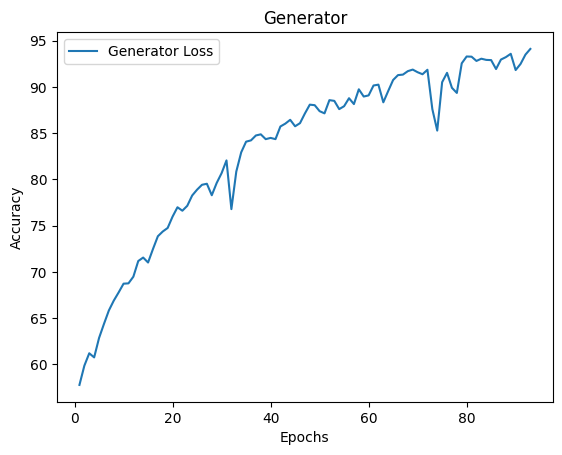

In [23]:
plt.plot(np_x,np_gen_loss ,label='Generator Loss')

#plt.yscale('linear')  # Use linear scale
#plt.ylim(0, 50)


#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Generator')

plt.legend()
plt.show()

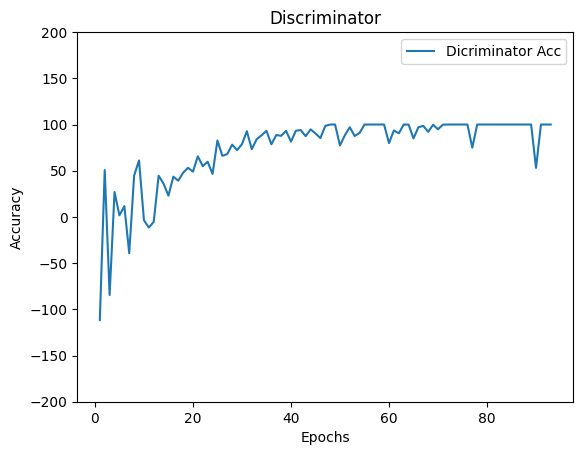

In [24]:
plt.plot(np_x,np_disc_acc ,label='Dicriminator Acc')

#plt.yscale('linear')  # Use linear scale
plt.ylim(-200, 200)


#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Discriminator')

plt.legend()
plt.show()

Testing the model


Using the generator model to Test generated
/content
Selecting a random image  from test data
(1, 32, 32, 3)
(1, 128, 128, 3)


1/1 [==============================] - 1s 733ms/step


(1, 128, 128, 3)


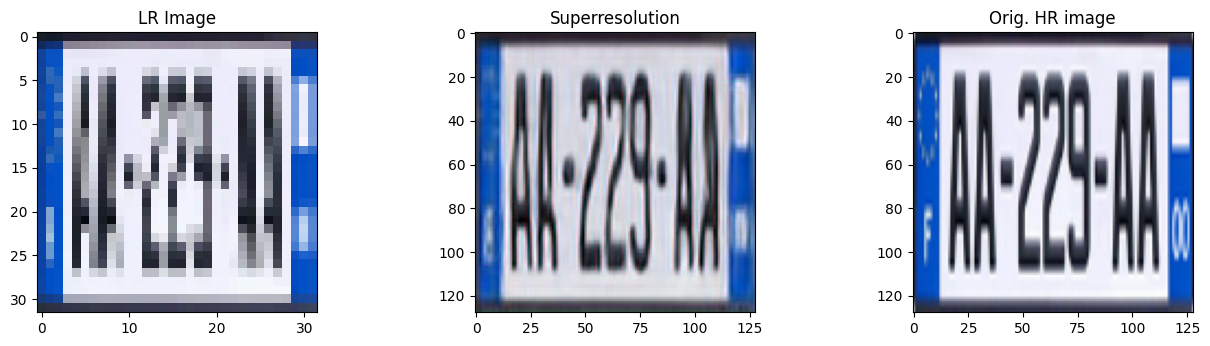

In [48]:
from keras.models import load_model
from numpy.random import randint


print("Using the generator model to Test generated")
print(os.getcwd())
generator = load_model(os.path.join(dataset_path , "gen_e_94.hdf5"), compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example

print("Selecting a random image  from test data")
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

print(src_image.shape)
print(tar_image.shape)


# generate image from source
gen_image = generator.predict(src_image)


print(gen_image.shape)
# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

Crop the license plates from the cars
Use the model.predict to generate the hr image
Pass the hr image to recognise the License plate characters

In [49]:
# Model Evaluation
generator.compile(loss=["mse"], optimizer="adam", metrics=["accuracy"])
x=generator.evaluate(src_image , tar_image)
print(x)

1/1 [==============================] - 2s 2s/step - loss: 0.0211 - accuracy: 0.7819
[0.0211410503834486, 0.78192138671875]


In [50]:
# PSNR Function
from math import log10 , sqrt
def PSNR(original, lateral):
    mse = np.mean((original - lateral) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [51]:
print(PSNR(tar_image , gen_image ))
#Accuracy -- > 64% Train more on images . This model was trained for 500 images with 0.15 train/test split for 94 epochs

64.87953821841658
